A template of the RL training, with H-network trained along side the PPO agent

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime

from utils import print_log

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load the created dataset
dataset_folder_path = Path("dataset", "20250707_downsampled_1min", "split")

In [4]:
# copied from 03_data_split.ipynb

# Helper functions for the new split folder structure
def load_split_data_from_folder(split_folder, split_type='train'):
    """Load aggregate data from split folder"""
    segments = []
    with open(split_folder / f'{split_type}_segments.txt', 'r') as f:
        for line in f:
            start_str, end_str = line.strip().split(' - ')
            start = datetime.fromisoformat(start_str)
            end = datetime.fromisoformat(end_str)
            segments.append((start, end))
    
    df = pd.read_pickle(split_folder / f'{split_type}_aggregate_df.pkl')
    return segments, df

def load_signatures_from_split_folder(split_folder, split_type, appliance):
    """Load appliance signatures from split folder"""
    sig_path = split_folder / 'load_signature_library' / split_type / appliance / 'load_signatures.pkl'
    ranges_path = split_folder / 'load_signature_library' / split_type / appliance / 'selected_ranges.txt'
    
    if not sig_path.exists():
        return pd.DataFrame(), []
    
    signatures_df = pd.read_pickle(sig_path)
    ranges = []
    if ranges_path.exists():
        with open(ranges_path, 'r') as f:
            for line in f:
                start, end = map(int, line.strip().split(','))
                ranges.append((start, end))
    
    return signatures_df, ranges

In [5]:
# convert datetime objects to timezone-naive datetime objects
def convert_to_naive_datetimes_df(df):
    """Convert datetime objects in DataFrame to timezone-naive datetime objects"""
    df['datetime'] = df['datetime'].apply(lambda x: x.replace(tzinfo=None) if isinstance(x, datetime) else x)

    return df

def convert_to_naive_datetimes(segments):
    """Convert datetime objects in segments to timezone-naive datetime objects"""
    return [(start.replace(tzinfo=None), end.replace(tzinfo=None)) for start, end in segments]

In [6]:
aggregate_load_segments_train, aggregate_load_df_train = load_split_data_from_folder(dataset_folder_path, 'train')
aggregate_load_segments_test, aggregate_load_df_test = load_split_data_from_folder(dataset_folder_path, 'test') 
aggregate_load_segments_validation, aggregate_load_df_validation = load_split_data_from_folder(dataset_folder_path, 'val')

In [7]:
aggregate_load_segments_train, aggregate_load_df_train = convert_to_naive_datetimes(aggregate_load_segments_train), convert_to_naive_datetimes_df(aggregate_load_df_train)
aggregate_load_segments_test, aggregate_load_df_test = convert_to_naive_datetimes(aggregate_load_segments_test), convert_to_naive_datetimes_df(aggregate_load_df_test)
aggregate_load_segments_validation, aggregate_load_df_validation = convert_to_naive_datetimes(aggregate_load_segments_validation), convert_to_naive_datetimes_df(aggregate_load_df_validation)

In [8]:
aggregate_load_df_train

,datetime,aggregate,timestamp
0,2013-01-08 00:00:05,234.000000,1357603205
1,2013-01-08 00:01:05,230.407069,1357603265
2,2013-01-08 00:02:05,230.680121,1357603325
3,2013-01-08 00:03:05,231.607379,1357603385
4,2013-01-08 00:04:05,231.280688,1357603445
...,...,...,...
231546,2013-12-30 23:55:01,176.973052,1388447701
231547,2013-12-30 23:56:01,177.850890,1388447761
231548,2013-12-30 23:57:01,177.333811,1388447821
231549,2013-12-30 23:58:01,178.462801,1388447881


In [9]:
aggregate_load_segments_train

[(datetime.datetime(2013, 1, 8, 0, 0),
  datetime.datetime(2013, 1, 8, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 1, 9, 0, 0),
  datetime.datetime(2013, 1, 9, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 1, 10, 0, 0),
  datetime.datetime(2013, 1, 10, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 2, 27, 0, 0),
  datetime.datetime(2013, 2, 27, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 2, 28, 0, 0),
  datetime.datetime(2013, 2, 28, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 8, 0, 0),
  datetime.datetime(2013, 3, 8, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 9, 0, 0),
  datetime.datetime(2013, 3, 9, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 10, 0, 0),
  datetime.datetime(2013, 3, 10, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 28, 0, 0),
  datetime.datetime(2013, 3, 28, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 29, 0, 0),
  datetime.datetime(2013, 3, 29, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 30, 0, 0),
  datetime.datetim

---

Experiment start

In [ ]:
# initialize experiment folder to store related information/data for future analysis

rl_datetime = datetime.now()

experiment_folder = Path(
    "experiments", rl_datetime.strftime('%Y%m%d_%H%M%S')
)

if not experiment_folder.exists():
    experiment_folder.mkdir(parents=True)

Create data loader

In [ ]:
sys.path.append(str(Path('rl_env')))
sys.path.append(str(Path('model', 'H_network')))

from rl_env.data_loader import SimpleSmartMeterDataLoader
from rl_env.training_mode import TrainingMode

sm_dl_train = SimpleSmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_train,
    aggregate_load_df=aggregate_load_df_train,
    registry_path=experiment_folder / "simple_episode_registry_train.json"
)

sm_dl_train.get_divided_segments_length()

162

In [11]:
sm_dl_train.divided_segments[7]

array([datetime.datetime(2013, 3, 10, 0, 0),
       datetime.datetime(2013, 3, 10, 23, 59, 59, 999000)], dtype=object)

In [12]:
# sample segment

sm_dl_train.get_aggregate_load_segment(13)

,timestamp,aggregate,datetime
11231,1363996805,335.000000,2013-03-23 00:00:05
11232,1363996865,317.206591,2013-03-23 00:01:05
11233,1363996925,293.301546,2013-03-23 00:02:05
11234,1363996985,276.229767,2013-03-23 00:03:05
11235,1363997045,276.501419,2013-03-23 00:04:05
...,...,...,...
12666,1364082905,173.758178,2013-03-23 23:55:05
12667,1364082965,172.392595,2013-03-23 23:56:05
12668,1364083025,174.270419,2013-03-23 23:57:05
12669,1364083085,171.201633,2013-03-23 23:58:05


In [ ]:
# create dataloader for validation and test sets
sm_dl_validation = SimpleSmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_validation,
    aggregate_load_df=aggregate_load_df_validation,
    registry_path=experiment_folder / "simple_episode_registry_validation.json"
)

# sm_dl_test = SimpleSmartMeterDataLoader(
#     aggregate_load_segments=aggregate_load_segments_test,
#     aggregate_load_df=aggregate_load_df_test
# )

(Optional) Load the pre-trained H-network and related components

In [14]:

# from model.H_network.h_network import HNetwork

# h_network_datetime = datetime(2025, 7, 13)

# h_network_path = Path("model_trained", f"h_network_{h_network_datetime.strftime('%Y%m%d')}.pth")

# h_network = HNetwork(2, 44, 1)
# h_network.load_state_dict(torch.load(h_network_path))
# h_network.eval()

Create the environment

In [16]:
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import sys

from model.H_network.h_network_rl_module import HNetworkRLModule
from model.H_network.h_network_arch import HNetworkType

h_network_rl_module = HNetworkRLModule(
    h_network_type=HNetworkType.H_NETWORK2,
    device=DEVICE
)

In [ ]:
REWARD_LAMBDA = 0.5  # lambda for the reward function

In [ ]:
from rl_env.hrl_env_hnetwork_loop import SmartMeterWorld

env_train = SmartMeterWorld(
    smart_meter_data_loader=sm_dl_train,
    h_network_rl_module=h_network_rl_module,
    mode = TrainingMode.TRAIN,
    log_folder=experiment_folder / 'logs_train',
    reward_lambda=REWARD_LAMBDA,
    # render_mode="human",
    render_mode=None,
)

In [19]:
HNetworkType.H_NETWORK2 is h_network_rl_module.h_network_type

True

In [20]:
h_network_rl_module.set_h_network(
    h_network_rl_module.initialize_h_network()
)
h_network_rl_module.initialize_h_network_training()

In [21]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env_train)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

[2025-07-19 03:30:38:121] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}
[2025-07-19 03:30:38:124] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693, 'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}
[2025-07-19 03:30:38:126] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}
[2025-07-19 03:30:38:129] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693, 'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}
[2025-07-19 03:30:38:132] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2

/root/miniforge3/envs/smartmeter/lib/python3.9/site-packages/gymnasium/utils/env_checker.py:434: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantiating the environment through `gymnasium.make`
  logger.warn(


In [22]:
obs, info = env_train.reset()
obs

[2025-07-19 03:30:38:296] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}


{'aggregate_load': array([-0.4250123], dtype=float32),
 'battery_soc': array([0.15], dtype=float32),
 'timestamp_features': array([-0.5 ,  0.  ,  0.25], dtype=float32)}

In [23]:
info

{'episode_index': 110,
 'current_step': 0,
 'datetime': '2013-09-26T00:00:00',
 'battery_soc (kWh)': 0.15000000596046448,
 'user_load (W)': None,
 'grid_load (W)': None,
 'action (kW)': None,
 'battery_action (kW)': None,
 'reward': None,
 'f_signal': None,
 'g_signal': None}

In [24]:
env_train.reset_render_window()

In [ ]:
# callbacks for training
from rl_env.hrl_env_callbacks import TrainHNetworkEveryNEpisodes, SaveCheckpointEveryNEpisodes, ValidateEveryNEpisodes

2025-07-19 03:30:38.594563: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 03:30:38.604957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752892238.616268 1555184 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752892238.619833 1555184 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752892238.629146 1555184 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [26]:
# define a custom logger

from stable_baselines3.common.logger import configure

# all logs (json files, tensorboard) will be saved in the specified foler
logger = configure(str(experiment_folder / "logs_train"), ["stdout", "json", "tensorboard"])

Logging to experiments/20250719_033035/logs_train


In [27]:
# initialize a PPO agent
from stable_baselines3 import PPO

rl_datetime = datetime.now()

rl_model = PPO(
    "MultiInputPolicy", 
    env_train, 
    verbose=2,
)

rl_model.set_logger(logger)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Show the model architecture of the policy

In [ ]:
rl_model.mlp_extractor.policy_net

In [ ]:
rl_model.mlp_extractor.value_net

Training

In [ ]:
env_train.save_env_config(env_train.log_folder.parent)

In [ ]:
every_n_episodes = 5

rl_model.learn(
    total_timesteps=24 * 60 * every_n_episodes * 200,
    progress_bar=True,
    tb_log_name="PPO_SmartMeterWorld",
    callback=[
        TrainHNetworkEveryNEpisodes(every_n_episodes=every_n_episodes, h_network_rl_module=h_network_rl_module),
        SaveCheckpointEveryNEpisodes(every_n_episodes=every_n_episodes, h_network_rl_module=h_network_rl_module, save_folder=experiment_folder / "checkpoints"),
    ]
)

# save the training results
print_log("Saving training results...")

env_train.save_episodes_rewards(experiment_folder / "logs_train")
h_network_rl_module.save_train_loss_list(experiment_folder / "logs_train" / "h_network_train_loss_list.json")

# save both RL modeel and H-network at the end of training
rl_model_path = experiment_folder / f"rl_model.zip"
h_network_path = experiment_folder / f"h_network2.pth" if h_network_rl_module.h_network_type == HNetworkType.H_NETWORK2 else experiment_folder / f"h_network.pth"

rl_model.save(rl_model_path)
h_network_rl_module.save_h_network(h_network_path)

Output()

[2025-07-19 03:30:40:052] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-08-28 00:00:02'), Timestamp('2013-08-28 23:59:02'))}


[2025-07-19 03:30:47:697] Episode 0001 info saved to experiments/20250719_033035/logs_train/episode_0001_info.json

[2025-07-19 03:30:47:698] [SmartMeterWorld] Episode finished. Sum of rewards: 49.686274773715134. Mean of rewards: 
0.034528335492505335. Std of rewards: 0.0324396658169777

[2025-07-19 03:30:47:703] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-28 00:00:05'), Timestamp('2013-03-28 23:59:05'))}

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.44e+03 |
|    ep_rew_mean     | 49.7     |
| time/              |          |
|    fps             | 203      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 2048     |
---------------------------------


[2025-07-19 03:30:56:268] Episode 0002 info saved to experiments/20250719_033035/logs_train/episode_0002_info.json

[2025-07-19 03:30:56:269] [SmartMeterWorld] Episode finished. Sum of rewards: 61.03113436232643. Mean of rewards: 
0.04241218510238112. Std of rewards: 0.04194111280412102

[2025-07-19 03:30:56:273] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 55.4         |
| time/                   |              |
|    fps                  | 179          |
|    iterations           | 2            |
|    time_elapsed         | 22           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0026651272 |
|    clip_fraction        | 0.0134       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.0478      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0795       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00156     |
|    std                  | 0.993        |
|    value_loss           | 0.165        |
------------------------------------------


[2025-07-19 03:31:04:911] Episode 0003 info saved to experiments/20250719_033035/logs_train/episode_0003_info.json

[2025-07-19 03:31:04:912] [SmartMeterWorld] Episode finished. Sum of rewards: 58.610307848028164. Mean of rewards: 
0.0407298873162115. Std of rewards: 0.039353443688615077

[2025-07-19 03:31:04:916] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-19 03:31:11:781] Episode 0004 info saved to experiments/20250719_033035/logs_train/episode_0004_info.json

[2025-07-19 03:31:11:781] [SmartMeterWorld] Episode finished. Sum of rewards: 54.50028974457589. Mean of rewards: 
0.03787372463139396. Std of rewards: 0.044109361010285154

[2025-07-19 03:31:11:786] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 56           |
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 3            |
|    time_elapsed         | 33           |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0031345435 |
|    clip_fraction        | 0.0254       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.103        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.044        |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.0026      |
|    std                  | 0.986        |
|    value_loss           | 0.133        |
------------------------------------------


[2025-07-19 03:31:21:465] Episode 0005 info saved to experiments/20250719_033035/logs_train/episode_0005_info.json

[2025-07-19 03:31:21:466] [SmartMeterWorld] Episode finished. Sum of rewards: 133.7573366695046. Mean of rewards: 
0.09295158906845334. Std of rewards: 0.07067895807111538

[2025-07-19 03:31:21:470] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

[2025-07-19 03:31:21:471] Training H-network...

[2025-07-19 03:31:21:514] H-network training (mean, std, num_batches): (0.52629814, 0.06123987, 2)

[2025-07-19 03:31:21:523] Models saved at experiments/20250719_033035/checkpoints/episode_0005/h_network2_0005.pth 
and experiments/20250719_033035/checkpoints/episode_0005/rl_model_0005.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 71.5         |
| time/                   |              |
|    fps                  | 178          |
|    iterations           | 4            |
|    time_elapsed         | 45           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0018638667 |
|    clip_fraction        | 0.0085       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.489        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0876       |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00147     |
|    std                  | 0.978        |
|    value_loss           | 0.282        |
------------------------------------------


[2025-07-19 03:31:29:720] Episode 0006 info saved to experiments/20250719_033035/logs_train/episode_0006_info.json

[2025-07-19 03:31:29:727] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-19 03:31:36:741] Episode 0007 info saved to experiments/20250719_033035/logs_train/episode_0007_info.json

[2025-07-19 03:31:36:742] [SmartMeterWorld] Episode finished. Sum of rewards: 67.58978481986762. Mean of rewards: 
0.046969968603104637. Std of rewards: 0.037207647782249303

[2025-07-19 03:31:36:745] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 68.3         |
| time/                   |              |
|    fps                  | 178          |
|    iterations           | 5            |
|    time_elapsed         | 57           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0011741766 |
|    clip_fraction        | 0.00186      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.565        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.167        |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.000803    |
|    std                  | 0.958        |
|    value_loss           | 0.363        |
------------------------------------------


[2025-07-19 03:31:45:471] Episode 0008 info saved to experiments/20250719_033035/logs_train/episode_0008_info.json

[2025-07-19 03:31:45:471] [SmartMeterWorld] Episode finished. Sum of rewards: 77.66700959909429. Mean of rewards: 
0.05397290451639634. Std of rewards: 0.047654758081334056

[2025-07-19 03:31:45:476] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-04 00:00:08'), Timestamp('2013-06-04 23:59:08'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 69.5         |
| time/                   |              |
|    fps                  | 177          |
|    iterations           | 6            |
|    time_elapsed         | 69           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0018629453 |
|    clip_fraction        | 0.00171      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.78         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0859       |
|    n_updates            | 50           |
|    policy_gradient_loss | -2.32e-05    |
|    std                  | 0.958        |
|    value_loss           | 0.194        |
------------------------------------------


[2025-07-19 03:31:55:575] Episode 0009 info saved to experiments/20250719_033035/logs_train/episode_0009_info.json

[2025-07-19 03:31:55:582] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 67.6         |
| time/                   |              |
|    fps                  | 172          |
|    iterations           | 7            |
|    time_elapsed         | 83           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0005276157 |
|    clip_fraction        | 0.000342     |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.75         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.1          |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.000219    |
|    std                  | 0.958        |
|    value_loss           | 0.248        |
------------------------------------------


[2025-07-19 03:32:04:632] Episode 0010 info saved to experiments/20250719_033035/logs_train/episode_0010_info.json

[2025-07-19 03:32:04:633] [SmartMeterWorld] Episode finished. Sum of rewards: 55.886256684378395. Mean of rewards: 
0.03883687052423795. Std of rewards: 0.03839439166998628

[2025-07-19 03:32:04:637] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

[2025-07-19 03:32:04:638] Training H-network...

[2025-07-19 03:32:04:674] H-network training (mean, std, num_batches): (0.52997869, 0.02200115, 2)

[2025-07-19 03:32:04:688] Models saved at experiments/20250719_033035/checkpoints/episode_0010/h_network2_0010.pth 
and experiments/20250719_033035/checkpoints/episode_0010/rl_model_0010.zip

[2025-07-19 03:32:12:657] Episode 0011 info saved to experiments/20250719_033035/logs_train/episode_0011_info.json

[2025-07-19 03:32:12:657] [SmartMeterWorld] Episode finished. Sum of rewards: 126.43480092178243. Mean of rewards: 
0.08786296102973064. Std of rewards: 0.07070737571395914

[2025-07-19 03:32:12:662] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 71.9         |
| time/                   |              |
|    fps                  | 171          |
|    iterations           | 8            |
|    time_elapsed         | 95           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0051346812 |
|    clip_fraction        | 0.043        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.942        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0425       |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00347     |
|    std                  | 0.966        |
|    value_loss           | 0.125        |
------------------------------------------


[2025-07-19 03:32:21:654] Episode 0012 info saved to experiments/20250719_033035/logs_train/episode_0012_info.json

[2025-07-19 03:32:21:654] [SmartMeterWorld] Episode finished. Sum of rewards: 64.18461040907086. Mean of rewards: 
0.04460362085411468. Std of rewards: 0.029887719433520244

[2025-07-19 03:32:21:659] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 71.2       |
| time/                   |            |
|    fps                  | 169        |
|    iterations           | 9          |
|    time_elapsed         | 108        |
|    total_timesteps      | 18432      |
| train/                  |            |
|    approx_kl            | 0.00355009 |
|    clip_fraction        | 0.0165     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.39      |
|    explained_variance   | 0.261      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.262      |
|    n_updates            | 80         |
|    policy_gradient_loss | -0.00189   |
|    std                  | 0.97       |
|    value_loss           | 0.73       |
----------------------------------------


[2025-07-19 03:32:31:917] Episode 0013 info saved to experiments/20250719_033035/logs_train/episode_0013_info.json

[2025-07-19 03:32:31:918] [SmartMeterWorld] Episode finished. Sum of rewards: 71.18612348165382. Mean of rewards: 
0.04946916155778585. Std of rewards: 0.045140219758510715

[2025-07-19 03:32:31:922] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

[2025-07-19 03:32:40:528] Episode 0014 info saved to experiments/20250719_033035/logs_train/episode_0014_info.json

[2025-07-19 03:32:40:529] [SmartMeterWorld] Episode finished. Sum of rewards: 137.86909646287333. Mean of rewards: 
0.09580896210067635. Std of rewards: 0.05118048812527781

[2025-07-19 03:32:40:533] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 76          |
| time/                   |             |
|    fps                  | 167         |
|    iterations           | 10          |
|    time_elapsed         | 122         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.004060305 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0799      |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00243    |
|    std                  | 0.961       |
|    value_loss           | 0.156       |
-----------------------------------------


[2025-07-19 03:32:50:314] Episode 0015 info saved to experiments/20250719_033035/logs_train/episode_0015_info.json

[2025-07-19 03:32:50:314] [SmartMeterWorld] Episode finished. Sum of rewards: 55.165750421343084. Mean of rewards: 
0.0383361712448528. Std of rewards: 0.03617335129453822

[2025-07-19 03:32:50:319] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

[2025-07-19 03:32:50:320] Training H-network...

[2025-07-19 03:32:50:353] H-network training (mean, std, num_batches): (0.48034641, 0.01305866, 2)

[2025-07-19 03:32:50:367] Models saved at experiments/20250719_033035/checkpoints/episode_0015/h_network2_0015.pth 
and experiments/20250719_033035/checkpoints/episode_0015/rl_model_0015.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 74.6         |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 11           |
|    time_elapsed         | 135          |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0021798909 |
|    clip_fraction        | 0.00845      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.703        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.148        |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00109     |
|    std                  | 0.968        |
|    value_loss           | 0.291        |
------------------------------------------


[2025-07-19 03:33:00:702] Episode 0016 info saved to experiments/20250719_033035/logs_train/episode_0016_info.json

[2025-07-19 03:33:00:702] [SmartMeterWorld] Episode finished. Sum of rewards: 79.90195901988496. Mean of rewards: 
0.05552603128553505. Std of rewards: 0.04769859925379038

[2025-07-19 03:33:00:707] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

[2025-07-19 03:33:08:620] Episode 0017 info saved to experiments/20250719_033035/logs_train/episode_0017_info.json

[2025-07-19 03:33:08:620] [SmartMeterWorld] Episode finished. Sum of rewards: 58.51730802117115. Mean of rewards: 
0.04066525922249568. Std of rewards: 0.04306146080640597

[2025-07-19 03:33:08:624] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 74           |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 12           |
|    time_elapsed         | 149          |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0026400008 |
|    clip_fraction        | 0.0138       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.869        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0637       |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00107     |
|    std                  | 0.971        |
|    value_loss           | 0.147        |
------------------------------------------


[2025-07-19 03:33:16:215] Episode 0018 info saved to experiments/20250719_033035/logs_train/episode_0018_info.json

[2025-07-19 03:33:16:216] [SmartMeterWorld] Episode finished. Sum of rewards: 53.14181681979961. Mean of rewards: 
0.036929685072828. Std of rewards: 0.03714285564087725

[2025-07-19 03:33:16:220] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 72.8        |
| time/                   |             |
|    fps                  | 166         |
|    iterations           | 13          |
|    time_elapsed         | 159         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.002883697 |
|    clip_fraction        | 0.0128      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | 0.83        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.167       |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00169    |
|    std                  | 0.973       |
|    value_loss           | 0.316       |
-----------------------------------------


[2025-07-19 03:33:24:163] Episode 0019 info saved to experiments/20250719_033035/logs_train/episode_0019_info.json

[2025-07-19 03:33:24:164] [SmartMeterWorld] Episode finished. Sum of rewards: 46.89855498051083. Mean of rewards: 
0.032591073648721866. Std of rewards: 0.0351174594827183

[2025-07-19 03:33:24:170] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 71.4        |
| time/                   |             |
|    fps                  | 168         |
|    iterations           | 14          |
|    time_elapsed         | 170         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.001346328 |
|    clip_fraction        | 0.00352     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | 0.863       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.07        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00138    |
|    std                  | 0.971       |
|    value_loss           | 0.178       |
-----------------------------------------


[2025-07-19 03:33:33:044] Episode 0020 info saved to experiments/20250719_033035/logs_train/episode_0020_info.json

[2025-07-19 03:33:33:045] [SmartMeterWorld] Episode finished. Sum of rewards: 51.34751615531866. Mean of rewards: 
0.03568277703635773. Std of rewards: 0.03949733448747325

[2025-07-19 03:33:33:049] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

[2025-07-19 03:33:33:050] Training H-network...

[2025-07-19 03:33:33:080] H-network training (mean, std, num_batches): (0.38533868, 0.04287489, 2)

[2025-07-19 03:33:33:088] Models saved at experiments/20250719_033035/checkpoints/episode_0020/h_network2_0020.pth 
and experiments/20250719_033035/checkpoints/episode_0020/rl_model_0020.zip

[2025-07-19 03:33:40:858] Episode 0021 info saved to experiments/20250719_033035/logs_train/episode_0021_info.json

[2025-07-19 03:33:40:859] [SmartMeterWorld] Episode finished. Sum of rewards: 109.67802954281257. Mean of rewards: 
0.07621822761835495. Std of rewards: 0.059194763530874286

[2025-07-19 03:33:40:863] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 72.3         |
| time/                   |              |
|    fps                  | 167          |
|    iterations           | 15           |
|    time_elapsed         | 183          |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0039024376 |
|    clip_fraction        | 0.0297       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.885        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.107        |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00268     |
|    std                  | 0.972        |
|    value_loss           | 0.189        |
------------------------------------------


[2025-07-19 03:33:49:761] Episode 0022 info saved to experiments/20250719_033035/logs_train/episode_0022_info.json

[2025-07-19 03:33:49:761] [SmartMeterWorld] Episode finished. Sum of rewards: 49.01521746940262. Mean of rewards: 
0.034061999631273536. Std of rewards: 0.03648510526317362

[2025-07-19 03:33:49:765] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 71.2        |
| time/                   |             |
|    fps                  | 167         |
|    iterations           | 16          |
|    time_elapsed         | 195         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.002632605 |
|    clip_fraction        | 0.0173      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | 0.737       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.139       |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00218    |
|    std                  | 0.964       |
|    value_loss           | 0.413       |
-----------------------------------------


[2025-07-19 03:33:58:658] Episode 0023 info saved to experiments/20250719_033035/logs_train/episode_0023_info.json

[2025-07-19 03:33:58:659] [SmartMeterWorld] Episode finished. Sum of rewards: 48.91705302932923. Mean of rewards: 
0.03399378250822049. Std of rewards: 0.03698096541258158

[2025-07-19 03:33:58:663] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

[2025-07-19 03:34:07:695] Episode 0024 info saved to experiments/20250719_033035/logs_train/episode_0024_info.json

[2025-07-19 03:34:07:696] [SmartMeterWorld] Episode finished. Sum of rewards: 38.019228451345306. Mean of rewards: 
0.026420589611775732. Std of rewards: 0.029632958449686206

[2025-07-19 03:34:07:700] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 68.9        |
| time/                   |             |
|    fps                  | 166         |
|    iterations           | 17          |
|    time_elapsed         | 208         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.004786036 |
|    clip_fraction        | 0.0276      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.814       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.044       |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00158    |
|    std                  | 0.951       |
|    value_loss           | 0.127       |
-----------------------------------------


[2025-07-19 03:34:16:726] Episode 0025 info saved to experiments/20250719_033035/logs_train/episode_0025_info.json

[2025-07-19 03:34:16:733] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

[2025-07-19 03:34:16:734] Training H-network...

[2025-07-19 03:34:16:764] H-network training (mean, std, num_batches): (0.33972704, 0.04183581, 2)

[2025-07-19 03:34:16:781] Models saved at experiments/20250719_033035/checkpoints/episode_0025/h_network2_0025.pth 
and experiments/20250719_033035/checkpoints/episode_0025/rl_model_0025.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 67.8         |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 18           |
|    time_elapsed         | 221          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0050917114 |
|    clip_fraction        | 0.035        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.36        |
|    explained_variance   | 0.839        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.13         |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00385     |
|    std                  | 0.944        |
|    value_loss           | 0.27         |
------------------------------------------


[2025-07-19 03:34:25:772] Episode 0026 info saved to experiments/20250719_033035/logs_train/episode_0026_info.json

[2025-07-19 03:34:25:773] [SmartMeterWorld] Episode finished. Sum of rewards: 23.998515255890787. Mean of rewards: 
0.016677216995059665. Std of rewards: 0.03384870950978136

[2025-07-19 03:34:25:778] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

[2025-07-19 03:34:33:942] Episode 0027 info saved to experiments/20250719_033035/logs_train/episode_0027_info.json

[2025-07-19 03:34:33:943] [SmartMeterWorld] Episode finished. Sum of rewards: 43.4291858454746. Mean of rewards: 
0.03018011525050347. Std of rewards: 0.03899341358642384

[2025-07-19 03:34:33:948] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 65.3        |
| time/                   |             |
|    fps                  | 166         |
|    iterations           | 19          |
|    time_elapsed         | 234         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.003278351 |
|    clip_fraction        | 0.0283      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.023       |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00229    |
|    std                  | 0.945       |
|    value_loss           | 0.0873      |
-----------------------------------------


[2025-07-19 03:34:45:399] Episode 0028 info saved to experiments/20250719_033035/logs_train/episode_0028_info.json

[2025-07-19 03:34:45:399] [SmartMeterWorld] Episode finished. Sum of rewards: 45.48234795368234. Mean of rewards: 
0.03160691310193355. Std of rewards: 0.04165240951234098

[2025-07-19 03:34:45:404] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 64.6         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 20           |
|    time_elapsed         | 249          |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0038134805 |
|    clip_fraction        | 0.039        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.37        |
|    explained_variance   | 0.916        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0471       |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00333     |
|    std                  | 0.957        |
|    value_loss           | 0.137        |
------------------------------------------


[2025-07-19 03:34:55:684] Episode 0029 info saved to experiments/20250719_033035/logs_train/episode_0029_info.json

[2025-07-19 03:34:55:685] [SmartMeterWorld] Episode finished. Sum of rewards: 51.82937502082904. Mean of rewards: 
0.03601763378792843. Std of rewards: 0.04596266268910428

[2025-07-19 03:34:55:690] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-04 00:00:04'), Timestamp('2013-09-04 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 64.1        |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 21          |
|    time_elapsed         | 263         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.005460086 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.94        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0536      |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0041     |
|    std                  | 0.957       |
|    value_loss           | 0.15        |
-----------------------------------------


[2025-07-19 03:35:04:975] Episode 0030 info saved to experiments/20250719_033035/logs_train/episode_0030_info.json

[2025-07-19 03:35:04:975] [SmartMeterWorld] Episode finished. Sum of rewards: 39.46184619786371. Mean of rewards: 
0.027423103681628685. Std of rewards: 0.03624287181721085

[2025-07-19 03:35:04:979] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

[2025-07-19 03:35:04:980] Training H-network...

[2025-07-19 03:35:04:996] H-network training (mean, std, num_batches): (0.32633431, 0.01962347, 2)

[2025-07-19 03:35:05:005] Models saved at experiments/20250719_033035/checkpoints/episode_0030/h_network2_0030.pth 
and experiments/20250719_033035/checkpoints/episode_0030/rl_model_0030.zip

[2025-07-19 03:35:13:721] Episode 0031 info saved to experiments/20250719_033035/logs_train/episode_0031_info.json

[2025-07-19 03:35:13:721] [SmartMeterWorld] Episode finished. Sum of rewards: 31.17968075828559. Mean of rewards: 
0.021667603028690505. Std of rewards: 0.04967112056878086

[2025-07-19 03:35:13:726] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 62.3       |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 22         |
|    time_elapsed         | 275        |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 0.00406676 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.37      |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.033      |
|    n_updates            | 210        |
|    policy_gradient_loss | -0.00179   |
|    std                  | 0.949      |
|    value_loss           | 0.157      |
----------------------------------------


[2025-07-19 03:35:22:660] Episode 0032 info saved to experiments/20250719_033035/logs_train/episode_0032_info.json

[2025-07-19 03:35:22:660] [SmartMeterWorld] Episode finished. Sum of rewards: 44.08988957698106. Mean of rewards: 
0.03063925613410775. Std of rewards: 0.05070350724219429

[2025-07-19 03:35:22:664] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 61.7         |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 23           |
|    time_elapsed         | 287          |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0028197938 |
|    clip_fraction        | 0.0189       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0.917        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0714       |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.00287     |
|    std                  | 0.919        |
|    value_loss           | 0.196        |
------------------------------------------


[2025-07-19 03:35:30:921] Episode 0033 info saved to experiments/20250719_033035/logs_train/episode_0033_info.json

[2025-07-19 03:35:30:921] [SmartMeterWorld] Episode finished. Sum of rewards: 15.407737394659781. Mean of rewards: 
0.010707253227699644. Std of rewards: 0.038722605651230826

[2025-07-19 03:35:30:925] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-19 03:35:39:207] Episode 0034 info saved to experiments/20250719_033035/logs_train/episode_0034_info.json

[2025-07-19 03:35:39:207] [SmartMeterWorld] Episode finished. Sum of rewards: 11.41523154025525. Mean of rewards: 
0.007932752981414324. Std of rewards: 0.03951221135174258

[2025-07-19 03:35:39:212] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 58.9        |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 24          |
|    time_elapsed         | 300         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.004634778 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.894       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0559      |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00382    |
|    std                  | 0.926       |
|    value_loss           | 0.16        |
-----------------------------------------


[2025-07-19 03:35:49:820] Episode 0035 info saved to experiments/20250719_033035/logs_train/episode_0035_info.json

[2025-07-19 03:35:49:820] [SmartMeterWorld] Episode finished. Sum of rewards: 27.795647230865427. Mean of rewards: 
0.019315946651053108. Std of rewards: 0.040239926970492695

[2025-07-19 03:35:49:827] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

[2025-07-19 03:35:49:828] Training H-network...

[2025-07-19 03:35:49:861] H-network training (mean, std, num_batches): (0.24320293, 0.01522519, 2)

[2025-07-19 03:35:49:875] Models saved at experiments/20250719_033035/checkpoints/episode_0035/h_network2_0035.pth 
and experiments/20250719_033035/checkpoints/episode_0035/rl_model_0035.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 58           |
| time/                   |              |
|    fps                  | 162          |
|    iterations           | 25           |
|    time_elapsed         | 314          |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0025058147 |
|    clip_fraction        | 0.0248       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.33        |
|    explained_variance   | 0.965        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.08         |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00141     |
|    std                  | 0.913        |
|    value_loss           | 0.12         |
------------------------------------------


[2025-07-19 03:35:59:516] Episode 0036 info saved to experiments/20250719_033035/logs_train/episode_0036_info.json

[2025-07-19 03:35:59:517] [SmartMeterWorld] Episode finished. Sum of rewards: 11.507685624880876. Mean of rewards: 
0.007997001824100706. Std of rewards: 0.06193036580477236

[2025-07-19 03:35:59:521] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

[2025-07-19 03:36:07:346] Episode 0037 info saved to experiments/20250719_033035/logs_train/episode_0037_info.json

[2025-07-19 03:36:07:347] [SmartMeterWorld] Episode finished. Sum of rewards: -4.5618388202479485. Mean of rewards:
-0.0031701451148352772. Std of rewards: 0.04884446797347993

[2025-07-19 03:36:07:351] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 55           |
| time/                   |              |
|    fps                  | 162          |
|    iterations           | 26           |
|    time_elapsed         | 327          |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0020822808 |
|    clip_fraction        | 0.00933      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.929        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0873       |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.000177    |
|    std                  | 0.904        |
|    value_loss           | 0.139        |
------------------------------------------


[2025-07-19 03:36:16:405] Episode 0038 info saved to experiments/20250719_033035/logs_train/episode_0038_info.json

[2025-07-19 03:36:16:406] [SmartMeterWorld] Episode finished. Sum of rewards: 10.918305108412815. Mean of rewards: 
0.007587425370682996. Std of rewards: 0.05794986129955267

[2025-07-19 03:36:16:410] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 53.9        |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 27          |
|    time_elapsed         | 340         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.002137686 |
|    clip_fraction        | 0.0152      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0913      |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.00117    |
|    std                  | 0.899       |
|    value_loss           | 0.204       |
-----------------------------------------


[2025-07-19 03:36:26:333] Episode 0039 info saved to experiments/20250719_033035/logs_train/episode_0039_info.json

[2025-07-19 03:36:26:334] [SmartMeterWorld] Episode finished. Sum of rewards: 1.5320407033127204. Mean of rewards: 
0.0010646564998698371. Std of rewards: 0.05197873655524332

[2025-07-19 03:36:26:338] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 52.5         |
| time/                   |              |
|    fps                  | 162          |
|    iterations           | 28           |
|    time_elapsed         | 353          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0033401146 |
|    clip_fraction        | 0.0137       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.3         |
|    explained_variance   | 0.937        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.086        |
|    n_updates            | 270          |
|    policy_gradient_loss | -0.0014      |
|    std                  | 0.883        |
|    value_loss           | 0.22         |
------------------------------------------


[2025-07-19 03:36:35:585] Episode 0040 info saved to experiments/20250719_033035/logs_train/episode_0040_info.json

[2025-07-19 03:36:35:586] [SmartMeterWorld] Episode finished. Sum of rewards: -8.27443522739576. Mean of rewards: 
-0.005750128719524511. Std of rewards: 0.04982291643086333

[2025-07-19 03:36:35:590] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

[2025-07-19 03:36:35:591] Training H-network...

[2025-07-19 03:36:35:625] H-network training (mean, std, num_batches): (0.18812150, 0.00650020, 2)

[2025-07-19 03:36:35:641] Models saved at experiments/20250719_033035/checkpoints/episode_0040/h_network2_0040.pth 
and experiments/20250719_033035/checkpoints/episode_0040/rl_model_0040.zip

[2025-07-19 03:36:43:744] Episode 0041 info saved to experiments/20250719_033035/logs_train/episode_0041_info.json

[2025-07-19 03:36:43:745] [SmartMeterWorld] Episode finished. Sum of rewards: -12.027400117033698. Mean of rewards:
-0.008358165473963642. Std of rewards: 0.0743667735364574

[2025-07-19 03:36:43:749] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.44e+03      |
|    ep_rew_mean          | 49.5          |
| time/                   |               |
|    fps                  | 162           |
|    iterations           | 29            |
|    time_elapsed         | 365           |
|    total_timesteps      | 59392         |
| train/                  |               |
|    approx_kl            | 0.00028469073 |
|    clip_fraction        | 0.00977       |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.3          |
|    explained_variance   | 0.941         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.156         |
|    n_updates            | 280           |
|    policy_gradient_loss | 0.000208      |
|    std                  | 0.888         |
|    value_loss           | 0.166         |
-------------------------------------------


[2025-07-19 03:36:54:304] Episode 0042 info saved to experiments/20250719_033035/logs_train/episode_0042_info.json

[2025-07-19 03:36:54:305] [SmartMeterWorld] Episode finished. Sum of rewards: -3.4765032528719204. Mean of rewards:
-0.0024159160895565746. Std of rewards: 0.06481742570716147

[2025-07-19 03:36:54:309] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 48.2        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 30          |
|    time_elapsed         | 379         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.004955706 |
|    clip_fraction        | 0.0378      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0723      |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00216    |
|    std                  | 0.891       |
|    value_loss           | 0.336       |
-----------------------------------------


[2025-07-19 03:37:03:487] Episode 0043 info saved to experiments/20250719_033035/logs_train/episode_0043_info.json

[2025-07-19 03:37:03:487] [SmartMeterWorld] Episode finished. Sum of rewards: -11.701875542898005. Mean of rewards:
-0.008131949647601099. Std of rewards: 0.06733782708571616

[2025-07-19 03:37:03:491] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

[2025-07-19 03:37:11:620] Episode 0044 info saved to experiments/20250719_033035/logs_train/episode_0044_info.json

[2025-07-19 03:37:11:620] [SmartMeterWorld] Episode finished. Sum of rewards: -6.810829045208067. Mean of rewards: 
-0.004733029218351667. Std of rewards: 0.06758734639067059

[2025-07-19 03:37:11:625] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693,
'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 45.6         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 31           |
|    time_elapsed         | 392          |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0019762283 |
|    clip_fraction        | 0.0105       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.31        |
|    explained_variance   | 0.92         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.184        |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.000682    |
|    std                  | 0.9          |
|    value_loss           | 0.366        |
------------------------------------------


[2025-07-19 03:37:16:460] Episode 0045 info saved to experiments/20250719_033035/logs_train/episode_0045_info.json

[2025-07-19 03:37:16:460] [SmartMeterWorld] Episode finished. Sum of rewards: 19.288840876483867. Mean of rewards: 
0.02787404750936975. Std of rewards: 0.06280563252650875

[2025-07-19 03:37:16:464] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

[2025-07-19 03:37:16:465] Training H-network...

[2025-07-19 03:37:16:495] H-network training (mean, std, num_batches): (0.15152173, 0.00974999, 2)

[2025-07-19 03:37:16:509] Models saved at experiments/20250719_033035/checkpoints/episode_0045/h_network2_0045.pth 
and experiments/20250719_033035/checkpoints/episode_0045/rl_model_0045.zip

[2025-07-19 03:37:24:634] Episode 0046 info saved to experiments/20250719_033035/logs_train/episode_0046_info.json

[2025-07-19 03:37:24:635] [SmartMeterWorld] Episode finished. Sum of rewards: -61.1136891611427. Mean of rewards: 
-0.042469554663754495. Std of rewards: 0.08534766929312329

[2025-07-19 03:37:24:638] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 42.7        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 32          |
|    time_elapsed         | 404         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.003143996 |
|    clip_fraction        | 0.022       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.133       |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00212    |
|    std                  | 0.889       |
|    value_loss           | 0.314       |
-----------------------------------------


[2025-07-19 03:37:33:863] Episode 0047 info saved to experiments/20250719_033035/logs_train/episode_0047_info.json

[2025-07-19 03:37:33:863] [SmartMeterWorld] Episode finished. Sum of rewards: -2.189597657196626. Mean of rewards: 
-0.0015216106026383627. Std of rewards: 0.10116300443462908

[2025-07-19 03:37:33:868] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 41.7        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 33          |
|    time_elapsed         | 417         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.005119983 |
|    clip_fraction        | 0.041       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0792      |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.00267    |
|    std                  | 0.894       |
|    value_loss           | 0.433       |
-----------------------------------------


[2025-07-19 03:37:42:820] Episode 0048 info saved to experiments/20250719_033035/logs_train/episode_0048_info.json

[2025-07-19 03:37:42:821] [SmartMeterWorld] Episode finished. Sum of rewards: -46.407461602796594. Mean of rewards:
-0.03224979958498722. Std of rewards: 0.08887151479863685

[2025-07-19 03:37:42:826] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 39.9       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 34         |
|    time_elapsed         | 430        |
|    total_timesteps      | 69632      |
| train/                  |            |
|    approx_kl            | 0.00232727 |
|    clip_fraction        | 0.0257     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.31      |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.327      |
|    n_updates            | 330        |
|    policy_gradient_loss | -0.00144   |
|    std                  | 0.898      |
|    value_loss           | 0.754      |
----------------------------------------


[2025-07-19 03:37:52:214] Episode 0049 info saved to experiments/20250719_033035/logs_train/episode_0049_info.json

[2025-07-19 03:37:52:214] [SmartMeterWorld] Episode finished. Sum of rewards: -41.3834011135686. Mean of rewards: 
-0.028758444137295766. Std of rewards: 0.08377596462565884

[2025-07-19 03:37:52:219] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693,
'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

[2025-07-19 03:37:55:078] Episode 0050 info saved to experiments/20250719_033035/logs_train/episode_0050_info.json

[2025-07-19 03:37:55:079] [SmartMeterWorld] Episode finished. Sum of rewards: 8.897562153506232. Mean of rewards: 
0.01285774877674313. Std of rewards: 0.08165073109587856

[2025-07-19 03:37:55:083] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-19 03:37:55:084] Training H-network...

[2025-07-19 03:37:55:099] H-network training (mean, std, num_batches): (0.09053900, 0.02598048, 2)

[2025-07-19 03:37:55:113] Models saved at experiments/20250719_033035/checkpoints/episode_0050/h_network2_0050.pth 
and experiments/20250719_033035/checkpoints/episode_0050/rl_model_0050.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.41e+03   |
|    ep_rew_mean          | 37.7       |
| time/                   |            |
|    fps                  | 162        |
|    iterations           | 35         |
|    time_elapsed         | 441        |
|    total_timesteps      | 71680      |
| train/                  |            |
|    approx_kl            | 0.00295291 |
|    clip_fraction        | 0.0167     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.3       |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.346      |
|    n_updates            | 340        |
|    policy_gradient_loss | -0.000799  |
|    std                  | 0.885      |
|    value_loss           | 0.755      |
----------------------------------------


[2025-07-19 03:38:04:096] Episode 0051 info saved to experiments/20250719_033035/logs_train/episode_0051_info.json

[2025-07-19 03:38:04:097] [SmartMeterWorld] Episode finished. Sum of rewards: -103.39184040256453. Mean of rewards:
-0.07184978485237281. Std of rewards: 0.11294925941331399

[2025-07-19 03:38:04:101] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

[2025-07-19 03:38:12:293] Episode 0052 info saved to experiments/20250719_033035/logs_train/episode_0052_info.json

[2025-07-19 03:38:12:294] [SmartMeterWorld] Episode finished. Sum of rewards: 73.52815392529018. Mean of rewards: 
0.051096701824385235. Std of rewards: 0.10863239019774756

[2025-07-19 03:38:12:298] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 35.6         |
| time/                   |              |
|    fps                  | 162          |
|    iterations           | 36           |
|    time_elapsed         | 454          |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 0.0042086532 |
|    clip_fraction        | 0.0255       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.3         |
|    explained_variance   | 0.895        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.394        |
|    n_updates            | 350          |
|    policy_gradient_loss | -0.00131     |
|    std                  | 0.886        |
|    value_loss           | 1.15         |
------------------------------------------


[2025-07-19 03:38:21:934] Episode 0053 info saved to experiments/20250719_033035/logs_train/episode_0053_info.json

[2025-07-19 03:38:21:934] [SmartMeterWorld] Episode finished. Sum of rewards: -97.85789161828238. Mean of rewards: 
-0.0680040942448105. Std of rewards: 0.10342849361134629

[2025-07-19 03:38:21:939] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 33.1         |
| time/                   |              |
|    fps                  | 162          |
|    iterations           | 37           |
|    time_elapsed         | 467          |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 0.0032197516 |
|    clip_fraction        | 0.0252       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.3         |
|    explained_variance   | 0.837        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.396        |
|    n_updates            | 360          |
|    policy_gradient_loss | -0.00279     |
|    std                  | 0.89         |
|    value_loss           | 1.21         |
------------------------------------------


[2025-07-19 03:38:31:520] Episode 0054 info saved to experiments/20250719_033035/logs_train/episode_0054_info.json

[2025-07-19 03:38:31:520] [SmartMeterWorld] Episode finished. Sum of rewards: -109.89320875945786. Mean of rewards:
-0.07636776147286843. Std of rewards: 0.1058019078551042

[2025-07-19 03:38:31:525] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

[2025-07-19 03:38:40:385] Episode 0055 info saved to experiments/20250719_033035/logs_train/episode_0055_info.json

[2025-07-19 03:38:40:386] [SmartMeterWorld] Episode finished. Sum of rewards: 36.722141997371736. Mean of rewards: 
0.02551920917121042. Std of rewards: 0.1256334879133489

[2025-07-19 03:38:40:391] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

[2025-07-19 03:38:40:392] Training H-network...

[2025-07-19 03:38:40:425] H-network training (mean, std, num_batches): (0.12030608, 0.04792966, 2)

[2025-07-19 03:38:40:441] Models saved at experiments/20250719_033035/checkpoints/episode_0055/h_network2_0055.pth 
and experiments/20250719_033035/checkpoints/episode_0055/rl_model_0055.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 30.6         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 38           |
|    time_elapsed         | 481          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0030768635 |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.31        |
|    explained_variance   | 0.908        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.287        |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.00219     |
|    std                  | 0.896        |
|    value_loss           | 1.02         |
------------------------------------------


[2025-07-19 03:38:50:681] Episode 0056 info saved to experiments/20250719_033035/logs_train/episode_0056_info.json

[2025-07-19 03:38:50:681] [SmartMeterWorld] Episode finished. Sum of rewards: -129.80344377876074. Mean of rewards:
-0.09020392201442734. Std of rewards: 0.14903144724976655

[2025-07-19 03:38:50:685] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-03 00:00:03'), Timestamp('2013-04-03 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 27.7         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 39           |
|    time_elapsed         | 494          |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0016331115 |
|    clip_fraction        | 0.0142       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.31        |
|    explained_variance   | 0.922        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.618        |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.00113     |
|    std                  | 0.897        |
|    value_loss           | 1.31         |
------------------------------------------


[2025-07-19 03:39:00:402] Episode 0057 info saved to experiments/20250719_033035/logs_train/episode_0057_info.json

[2025-07-19 03:39:00:402] [SmartMeterWorld] Episode finished. Sum of rewards: -110.97882668554415. Mean of rewards:
-0.07712218671684794. Std of rewards: 0.14206441708650686

[2025-07-19 03:39:00:407] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 25.3         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 40           |
|    time_elapsed         | 507          |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0043098624 |
|    clip_fraction        | 0.045        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.76         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.676        |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.00423     |
|    std                  | 0.905        |
|    value_loss           | 1.82         |
------------------------------------------


[2025-07-19 03:39:08:444] Episode 0058 info saved to experiments/20250719_033035/logs_train/episode_0058_info.json

[2025-07-19 03:39:08:445] [SmartMeterWorld] Episode finished. Sum of rewards: -112.30014183153993. Mean of rewards:
-0.07804040433046557. Std of rewards: 0.14340314753066966

[2025-07-19 03:39:08:449] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-19 03:39:16:528] Episode 0059 info saved to experiments/20250719_033035/logs_train/episode_0059_info.json

[2025-07-19 03:39:16:529] [SmartMeterWorld] Episode finished. Sum of rewards: -117.53476693823234. Mean of rewards:
-0.08167808682295508. Std of rewards: 0.1341011731880365

[2025-07-19 03:39:16:533] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 20.5        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 41          |
|    time_elapsed         | 519         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.003125887 |
|    clip_fraction        | 0.0201      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.32       |
|    explained_variance   | 0.832       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.49        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.00297    |
|    std                  | 0.91        |
|    value_loss           | 3.35        |
-----------------------------------------


[2025-07-19 03:39:25:826] Episode 0060 info saved to experiments/20250719_033035/logs_train/episode_0060_info.json

[2025-07-19 03:39:25:827] [SmartMeterWorld] Episode finished. Sum of rewards: -125.22193138880029. Mean of rewards:
-0.08702010520416982. Std of rewards: 0.15093216746038793

[2025-07-19 03:39:25:831] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-02 00:00:05'), Timestamp('2013-09-02 23:59:05'))}

[2025-07-19 03:39:25:832] Training H-network...

[2025-07-19 03:39:25:865] H-network training (mean, std, num_batches): (-0.05738429, 0.05226302, 2)

[2025-07-19 03:39:25:878] Models saved at experiments/20250719_033035/checkpoints/episode_0060/h_network2_0060.pth 
and experiments/20250719_033035/checkpoints/episode_0060/rl_model_0060.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 18.1        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 42          |
|    time_elapsed         | 532         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.001863447 |
|    clip_fraction        | 0.0127      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.33       |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.644       |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00202    |
|    std                  | 0.915       |
|    value_loss           | 1.91        |
-----------------------------------------


[2025-07-19 03:39:35:147] Episode 0061 info saved to experiments/20250719_033035/logs_train/episode_0061_info.json

[2025-07-19 03:39:35:148] [SmartMeterWorld] Episode finished. Sum of rewards: -124.85415392383858. Mean of rewards:
-0.08676452670176418. Std of rewards: 0.16252933567678068

[2025-07-19 03:39:35:152] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

[2025-07-19 03:39:43:289] Episode 0062 info saved to experiments/20250719_033035/logs_train/episode_0062_info.json

[2025-07-19 03:39:43:290] [SmartMeterWorld] Episode finished. Sum of rewards: -157.00803593526956. Mean of rewards:
-0.10910912851651806. Std of rewards: 0.14701535799445303

[2025-07-19 03:39:43:294] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 13           |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 43           |
|    time_elapsed         | 544          |
|    total_timesteps      | 88064        |
| train/                  |              |
|    approx_kl            | 0.0045568817 |
|    clip_fraction        | 0.0321       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.827        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.919        |
|    n_updates            | 420          |
|    policy_gradient_loss | -0.00237     |
|    std                  | 0.906        |
|    value_loss           | 2.59         |
------------------------------------------


[2025-07-19 03:39:52:695] Episode 0063 info saved to experiments/20250719_033035/logs_train/episode_0063_info.json

[2025-07-19 03:39:52:696] [SmartMeterWorld] Episode finished. Sum of rewards: 16.746121102779593. Mean of rewards: 
0.011637332246545945. Std of rewards: 0.15596678156127988

[2025-07-19 03:39:52:700] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 13           |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 44           |
|    time_elapsed         | 557          |
|    total_timesteps      | 90112        |
| train/                  |              |
|    approx_kl            | 0.0013758232 |
|    clip_fraction        | 0.0122       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.887        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.803        |
|    n_updates            | 430          |
|    policy_gradient_loss | -0.00048     |
|    std                  | 0.902        |
|    value_loss           | 3.13         |
------------------------------------------


[2025-07-19 03:40:01:906] Episode 0064 info saved to experiments/20250719_033035/logs_train/episode_0064_info.json

[2025-07-19 03:40:01:907] [SmartMeterWorld] Episode finished. Sum of rewards: -168.74716026826954. Mean of rewards:
-0.11726696335529492. Std of rewards: 0.17350495958413462

[2025-07-19 03:40:01:911] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

[2025-07-19 03:40:10:127] Episode 0065 info saved to experiments/20250719_033035/logs_train/episode_0065_info.json

[2025-07-19 03:40:10:128] [SmartMeterWorld] Episode finished. Sum of rewards: -149.13906955784654. Mean of rewards:
-0.1036407710617419. Std of rewards: 0.1744175680708499

[2025-07-19 03:40:10:132] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

[2025-07-19 03:40:10:134] Training H-network...

[2025-07-19 03:40:10:168] H-network training (mean, std, num_batches): (-0.01904881, 0.04513416, 2)

[2025-07-19 03:40:10:182] Models saved at experiments/20250719_033035/checkpoints/episode_0065/h_network2_0065.pth 
and experiments/20250719_033035/checkpoints/episode_0065/rl_model_0065.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 7.74         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 45           |
|    time_elapsed         | 570          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0032014288 |
|    clip_fraction        | 0.0166       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.81         |
|    learning_rate        | 0.0003       |
|    loss                 | 1.61         |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.00154     |
|    std                  | 0.901        |
|    value_loss           | 3.72         |
------------------------------------------


[2025-07-19 03:40:19:572] Episode 0066 info saved to experiments/20250719_033035/logs_train/episode_0066_info.json

[2025-07-19 03:40:19:573] [SmartMeterWorld] Episode finished. Sum of rewards: -201.8788539559375. Mean of rewards: 
-0.14029107293671822. Std of rewards: 0.17525238471292848

[2025-07-19 03:40:19:577] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 4.57         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 46           |
|    time_elapsed         | 583          |
|    total_timesteps      | 94208        |
| train/                  |              |
|    approx_kl            | 0.0011601604 |
|    clip_fraction        | 0.00303      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.31        |
|    explained_variance   | 0.88         |
|    learning_rate        | 0.0003       |
|    loss                 | 1.59         |
|    n_updates            | 450          |
|    policy_gradient_loss | -0.000646    |
|    std                  | 0.899        |
|    value_loss           | 4.7          |
------------------------------------------


[2025-07-19 03:40:28:888] Episode 0067 info saved to experiments/20250719_033035/logs_train/episode_0067_info.json

[2025-07-19 03:40:28:889] [SmartMeterWorld] Episode finished. Sum of rewards: -173.0716707881555. Mean of rewards: 
-0.12027218261859296. Std of rewards: 0.22484470137500018

[2025-07-19 03:40:28:894] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-03 00:00:01'), Timestamp('2013-10-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 1.92         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 47           |
|    time_elapsed         | 597          |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0038944758 |
|    clip_fraction        | 0.0227       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.31        |
|    explained_variance   | 0.883        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.3          |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.00314     |
|    std                  | 0.887        |
|    value_loss           | 3.49         |
------------------------------------------


[2025-07-19 03:40:39:281] Episode 0068 info saved to experiments/20250719_033035/logs_train/episode_0068_info.json

[2025-07-19 03:40:39:281] [SmartMeterWorld] Episode finished. Sum of rewards: -242.82588071650193. Mean of rewards:
-0.16874626873975124. Std of rewards: 0.19405706401342993

[2025-07-19 03:40:39:287] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

[2025-07-19 03:40:48:655] Episode 0069 info saved to experiments/20250719_033035/logs_train/episode_0069_info.json

[2025-07-19 03:40:48:656] [SmartMeterWorld] Episode finished. Sum of rewards: -240.29382657508606. Mean of rewards:
-0.16698667586871863. Std of rewards: 0.21949361438189208

[2025-07-19 03:40:48:661] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -5.14        |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 48           |
|    time_elapsed         | 611          |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0029079942 |
|    clip_fraction        | 0.0084       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.29        |
|    explained_variance   | 0.847        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.76         |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.00125     |
|    std                  | 0.872        |
|    value_loss           | 7.27         |
------------------------------------------


[2025-07-19 03:40:59:171] Episode 0070 info saved to experiments/20250719_033035/logs_train/episode_0070_info.json

[2025-07-19 03:40:59:172] [SmartMeterWorld] Episode finished. Sum of rewards: -44.72390251223961. Mean of rewards: 
-0.03107984886187601. Std of rewards: 0.21133966175262572

[2025-07-19 03:40:59:176] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

[2025-07-19 03:40:59:177] Training H-network...

[2025-07-19 03:40:59:208] H-network training (mean, std, num_batches): (-0.08119351, 0.01246815, 2)

[2025-07-19 03:40:59:222] Models saved at experiments/20250719_033035/checkpoints/episode_0070/h_network2_0070.pth 
and experiments/20250719_033035/checkpoints/episode_0070/rl_model_0070.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -5.71        |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 49           |
|    time_elapsed         | 625          |
|    total_timesteps      | 100352       |
| train/                  |              |
|    approx_kl            | 0.0028230087 |
|    clip_fraction        | 0.00723      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.28        |
|    explained_variance   | 0.907        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.19         |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.000754    |
|    std                  | 0.868        |
|    value_loss           | 5.34         |
------------------------------------------


[2025-07-19 03:41:08:667] Episode 0071 info saved to experiments/20250719_033035/logs_train/episode_0071_info.json

[2025-07-19 03:41:08:667] [SmartMeterWorld] Episode finished. Sum of rewards: -274.4536900193056. Mean of rewards: 
-0.19072528840813419. Std of rewards: 0.25695964796622917

[2025-07-19 03:41:08:672] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

[2025-07-19 03:41:17:020] Episode 0072 info saved to experiments/20250719_033035/logs_train/episode_0072_info.json

[2025-07-19 03:41:17:021] [SmartMeterWorld] Episode finished. Sum of rewards: -322.91711230458964. Mean of rewards:
-0.22440383064947192. Std of rewards: 0.27704247521132414

[2025-07-19 03:41:17:025] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -13.8        |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 50           |
|    time_elapsed         | 638          |
|    total_timesteps      | 102400       |
| train/                  |              |
|    approx_kl            | 0.0018035972 |
|    clip_fraction        | 0.00503      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.27        |
|    explained_variance   | 0.773        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.27         |
|    n_updates            | 490          |
|    policy_gradient_loss | -0.000922    |
|    std                  | 0.856        |
|    value_loss           | 10.4         |
------------------------------------------


[2025-07-19 03:41:26:447] Episode 0073 info saved to experiments/20250719_033035/logs_train/episode_0073_info.json

[2025-07-19 03:41:26:447] [SmartMeterWorld] Episode finished. Sum of rewards: -30.615747023063996. Mean of rewards:
-0.021275710231455143. Std of rewards: 0.2099351469207575

[2025-07-19 03:41:26:452] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -14.1        |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 51           |
|    time_elapsed         | 650          |
|    total_timesteps      | 104448       |
| train/                  |              |
|    approx_kl            | 0.0019346974 |
|    clip_fraction        | 0.00806      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.27        |
|    explained_variance   | 0.917        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.56         |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.000931    |
|    std                  | 0.863        |
|    value_loss           | 7.06         |
------------------------------------------


[2025-07-19 03:41:35:087] Episode 0074 info saved to experiments/20250719_033035/logs_train/episode_0074_info.json

[2025-07-19 03:41:35:088] [SmartMeterWorld] Episode finished. Sum of rewards: -259.663220241249. Mean of rewards: 
-0.18044699113359916. Std of rewards: 0.22260526409159004

[2025-07-19 03:41:35:092] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

[2025-07-19 03:41:43:906] Episode 0075 info saved to experiments/20250719_033035/logs_train/episode_0075_info.json

[2025-07-19 03:41:43:907] [SmartMeterWorld] Episode finished. Sum of rewards: -293.6868748082716. Mean of rewards: 
-0.2040909484421621. Std of rewards: 0.2446319349203537

[2025-07-19 03:41:43:912] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-01 00:00:00'), Timestamp('2013-06-01 23:59:00'))}

[2025-07-19 03:41:43:913] Training H-network...

[2025-07-19 03:41:43:945] H-network training (mean, std, num_batches): (-0.16979339, 0.04770686, 2)

[2025-07-19 03:41:43:954] Models saved at experiments/20250719_033035/checkpoints/episode_0075/h_network2_0075.pth 
and experiments/20250719_033035/checkpoints/episode_0075/rl_model_0075.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -21.1        |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 52           |
|    time_elapsed         | 664          |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 0.0028237018 |
|    clip_fraction        | 0.0176       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.27        |
|    explained_variance   | 0.86         |
|    learning_rate        | 0.0003       |
|    loss                 | 3.92         |
|    n_updates            | 510          |
|    policy_gradient_loss | -0.00226     |
|    std                  | 0.849        |
|    value_loss           | 6.61         |
------------------------------------------


[2025-07-19 03:41:53:965] Episode 0076 info saved to experiments/20250719_033035/logs_train/episode_0076_info.json

[2025-07-19 03:41:53:966] [SmartMeterWorld] Episode finished. Sum of rewards: -381.46523414435717. Mean of rewards:
-0.265090503227489. Std of rewards: 0.2969202197360237

[2025-07-19 03:41:53:970] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -25.8       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 53          |
|    time_elapsed         | 677         |
|    total_timesteps      | 108544      |
| train/                  |             |
|    approx_kl            | 0.002050685 |
|    clip_fraction        | 0.00977     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.24       |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.93        |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.00193    |
|    std                  | 0.83        |
|    value_loss           | 7.52        |
-----------------------------------------


[2025-07-19 03:42:03:431] Episode 0077 info saved to experiments/20250719_033035/logs_train/episode_0077_info.json

[2025-07-19 03:42:03:431] [SmartMeterWorld] Episode finished. Sum of rewards: -397.56529132305275. Mean of rewards:
-0.27627886818836167. Std of rewards: 0.3252072096326723

[2025-07-19 03:42:03:436] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -30.6       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 54          |
|    time_elapsed         | 690         |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.002942386 |
|    clip_fraction        | 0.0109      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.908       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.87        |
|    n_updates            | 530         |
|    policy_gradient_loss | -0.00162    |
|    std                  | 0.825       |
|    value_loss           | 8.34        |
-----------------------------------------


[2025-07-19 03:42:12:634] Episode 0078 info saved to experiments/20250719_033035/logs_train/episode_0078_info.json

[2025-07-19 03:42:12:635] [SmartMeterWorld] Episode finished. Sum of rewards: -402.15796632891534. Mean of rewards:
-0.2794704422021644. Std of rewards: 0.3222208237708094

[2025-07-19 03:42:12:640] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

[2025-07-19 03:42:20:653] Episode 0079 info saved to experiments/20250719_033035/logs_train/episode_0079_info.json

[2025-07-19 03:42:20:654] [SmartMeterWorld] Episode finished. Sum of rewards: -222.43425329067964. Mean of rewards:
-0.1545755756015841. Std of rewards: 0.28683921062738715

[2025-07-19 03:42:20:660] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-31 00:00:05'), Timestamp('2013-03-31 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -37.8        |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 55           |
|    time_elapsed         | 702          |
|    total_timesteps      | 112640       |
| train/                  |              |
|    approx_kl            | 0.0032047285 |
|    clip_fraction        | 0.00742      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.23        |
|    explained_variance   | 0.9          |
|    learning_rate        | 0.0003       |
|    loss                 | 2.06         |
|    n_updates            | 540          |
|    policy_gradient_loss | -0.000863    |
|    std                  | 0.826        |
|    value_loss           | 10.5         |
------------------------------------------


[2025-07-19 03:42:30:395] Episode 0080 info saved to experiments/20250719_033035/logs_train/episode_0080_info.json

[2025-07-19 03:42:30:396] [SmartMeterWorld] Episode finished. Sum of rewards: -210.05149011564288. Mean of rewards:
-0.14597045873220485. Std of rewards: 0.3017205196675904

[2025-07-19 03:42:30:404] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

[2025-07-19 03:42:30:405] Training H-network...

[2025-07-19 03:42:30:437] H-network training (mean, std, num_batches): (-0.21710765, 0.03899274, 2)

[2025-07-19 03:42:30:444] Models saved at experiments/20250719_033035/checkpoints/episode_0080/h_network2_0080.pth 
and experiments/20250719_033035/checkpoints/episode_0080/rl_model_0080.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -39.9        |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 56           |
|    time_elapsed         | 716          |
|    total_timesteps      | 114688       |
| train/                  |              |
|    approx_kl            | 0.0029140916 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.22        |
|    explained_variance   | 0.908        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.47         |
|    n_updates            | 550          |
|    policy_gradient_loss | -0.0021      |
|    std                  | 0.817        |
|    value_loss           | 9.35         |
------------------------------------------


[2025-07-19 03:42:39:896] Episode 0081 info saved to experiments/20250719_033035/logs_train/episode_0081_info.json

[2025-07-19 03:42:39:896] [SmartMeterWorld] Episode finished. Sum of rewards: -466.7038523132133. Mean of rewards: 
-0.3243251232197451. Std of rewards: 0.37886545779214953

[2025-07-19 03:42:39:901] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

[2025-07-19 03:42:48:460] Episode 0082 info saved to experiments/20250719_033035/logs_train/episode_0082_info.json

[2025-07-19 03:42:48:461] [SmartMeterWorld] Episode finished. Sum of rewards: -581.7339999477877. Mean of rewards: 
-0.4042626823820622. Std of rewards: 0.4093714735075773

[2025-07-19 03:42:48:465] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -51.7       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 57          |
|    time_elapsed         | 729         |
|    total_timesteps      | 116736      |
| train/                  |             |
|    approx_kl            | 0.002051175 |
|    clip_fraction        | 0.00732     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.95        |
|    n_updates            | 560         |
|    policy_gradient_loss | -0.00139    |
|    std                  | 0.824       |
|    value_loss           | 16          |
-----------------------------------------


[2025-07-19 03:42:58:414] Episode 0083 info saved to experiments/20250719_033035/logs_train/episode_0083_info.json

[2025-07-19 03:42:58:415] [SmartMeterWorld] Episode finished. Sum of rewards: -488.8575337543682. Mean of rewards: 
-0.33972031532617647. Std of rewards: 0.3814697398480085

[2025-07-19 03:42:58:419] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-05 00:00:01'), Timestamp('2013-05-05 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -57          |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 58           |
|    time_elapsed         | 742          |
|    total_timesteps      | 118784       |
| train/                  |              |
|    approx_kl            | 0.0015647791 |
|    clip_fraction        | 0.00728      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.23        |
|    explained_variance   | 0.924        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.78         |
|    n_updates            | 570          |
|    policy_gradient_loss | -0.00165     |
|    std                  | 0.834        |
|    value_loss           | 15.8         |
------------------------------------------


[2025-07-19 03:43:07:914] Episode 0084 info saved to experiments/20250719_033035/logs_train/episode_0084_info.json

[2025-07-19 03:43:07:915] [SmartMeterWorld] Episode finished. Sum of rewards: -574.7366655850876. Mean of rewards: 
-0.3994000455768504. Std of rewards: 0.4120584859143721

[2025-07-19 03:43:07:919] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-06 00:00:01'), Timestamp('2013-09-06 23:59:01'))}

[2025-07-19 03:43:16:424] Episode 0085 info saved to experiments/20250719_033035/logs_train/episode_0085_info.json

[2025-07-19 03:43:16:424] [SmartMeterWorld] Episode finished. Sum of rewards: -537.5896409429513. Mean of rewards: 
-0.37358557397008396. Std of rewards: 0.3702417755894251

[2025-07-19 03:43:16:429] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-19 03:43:16:432] Training H-network...

[2025-07-19 03:43:16:465] H-network training (mean, std, num_batches): (-0.39562948, 0.02612258, 2)

[2025-07-19 03:43:16:473] Models saved at experiments/20250719_033035/checkpoints/episode_0085/h_network2_0085.pth 
and experiments/20250719_033035/checkpoints/episode_0085/rl_model_0085.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -68.8        |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 59           |
|    time_elapsed         | 756          |
|    total_timesteps      | 120832       |
| train/                  |              |
|    approx_kl            | 0.0038819995 |
|    clip_fraction        | 0.0182       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.24        |
|    explained_variance   | 0.915        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.3         |
|    n_updates            | 580          |
|    policy_gradient_loss | -0.00202     |
|    std                  | 0.835        |
|    value_loss           | 17.8         |
------------------------------------------


[2025-07-19 03:43:26:299] Episode 0086 info saved to experiments/20250719_033035/logs_train/episode_0086_info.json

[2025-07-19 03:43:26:299] [SmartMeterWorld] Episode finished. Sum of rewards: -556.88241222662. Mean of rewards: 
-0.3869926422700629. Std of rewards: 0.44171417449185457

[2025-07-19 03:43:26:304] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -74.4        |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 60           |
|    time_elapsed         | 769          |
|    total_timesteps      | 122880       |
| train/                  |              |
|    approx_kl            | 0.0032855133 |
|    clip_fraction        | 0.0132       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.23        |
|    explained_variance   | 0.894        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.3         |
|    n_updates            | 590          |
|    policy_gradient_loss | -0.00204     |
|    std                  | 0.816        |
|    value_loss           | 19.7         |
------------------------------------------


[2025-07-19 03:43:34:864] Episode 0087 info saved to experiments/20250719_033035/logs_train/episode_0087_info.json

[2025-07-19 03:43:34:864] [SmartMeterWorld] Episode finished. Sum of rewards: -637.529436181582. Mean of rewards: 
-0.44303643932007103. Std of rewards: 0.4815885572561741

[2025-07-19 03:43:34:868] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -80.9        |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 61           |
|    time_elapsed         | 781          |
|    total_timesteps      | 124928       |
| train/                  |              |
|    approx_kl            | 0.0045506246 |
|    clip_fraction        | 0.0335       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.21        |
|    explained_variance   | 0.924        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.3         |
|    n_updates            | 600          |
|    policy_gradient_loss | -0.00295     |
|    std                  | 0.808        |
|    value_loss           | 19           |
------------------------------------------


[2025-07-19 03:43:44:033] Episode 0088 info saved to experiments/20250719_033035/logs_train/episode_0088_info.json

[2025-07-19 03:43:44:034] [SmartMeterWorld] Episode finished. Sum of rewards: -449.8428089809689. Mean of rewards: 
-0.3126079284092903. Std of rewards: 0.43250698425259887

[2025-07-19 03:43:44:038] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

[2025-07-19 03:43:52:255] Episode 0089 info saved to experiments/20250719_033035/logs_train/episode_0089_info.json

[2025-07-19 03:43:52:256] [SmartMeterWorld] Episode finished. Sum of rewards: -773.8078368067562. Mean of rewards: 
-0.537739983882388. Std of rewards: 0.526915029794436

[2025-07-19 03:43:52:260] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -92.8        |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 62           |
|    time_elapsed         | 794          |
|    total_timesteps      | 126976       |
| train/                  |              |
|    approx_kl            | 0.0027331624 |
|    clip_fraction        | 0.00415      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.2         |
|    explained_variance   | 0.904        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.73         |
|    n_updates            | 610          |
|    policy_gradient_loss | -0.000734    |
|    std                  | 0.799        |
|    value_loss           | 28.8         |
------------------------------------------


[2025-07-19 03:44:01:679] Episode 0090 info saved to experiments/20250719_033035/logs_train/episode_0090_info.json

[2025-07-19 03:44:01:679] [SmartMeterWorld] Episode finished. Sum of rewards: -534.1003397999342. Mean of rewards: 
-0.3711607642807051. Std of rewards: 0.46304359233467457

[2025-07-19 03:44:01:684] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

[2025-07-19 03:44:01:685] Training H-network...

[2025-07-19 03:44:01:716] H-network training (mean, std, num_batches): (-0.41333412, 0.05162580, 2)

[2025-07-19 03:44:01:724] Models saved at experiments/20250719_033035/checkpoints/episode_0090/h_network2_0090.pth 
and experiments/20250719_033035/checkpoints/episode_0090/rl_model_0090.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -97.7       |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 63          |
|    time_elapsed         | 806         |
|    total_timesteps      | 129024      |
| train/                  |             |
|    approx_kl            | 0.004112417 |
|    clip_fraction        | 0.0108      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.4        |
|    n_updates            | 620         |
|    policy_gradient_loss | -0.000642   |
|    std                  | 0.804       |
|    value_loss           | 25.2        |
-----------------------------------------


[2025-07-19 03:44:10:187] Episode 0091 info saved to experiments/20250719_033035/logs_train/episode_0091_info.json

[2025-07-19 03:44:10:187] [SmartMeterWorld] Episode finished. Sum of rewards: -915.3187601447945. Mean of rewards: 
-0.6360797499268894. Std of rewards: 0.6625590793964427

[2025-07-19 03:44:10:191] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693,
'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

[2025-07-19 03:44:13:625] Episode 0092 info saved to experiments/20250719_033035/logs_train/episode_0092_info.json

[2025-07-19 03:44:13:625] [SmartMeterWorld] Episode finished. Sum of rewards: -135.02971741716914. Mean of rewards:
-0.19512964944677613. Std of rewards: 0.4440195602181195

[2025-07-19 03:44:13:629] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -107         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 64           |
|    time_elapsed         | 818          |
|    total_timesteps      | 131072       |
| train/                  |              |
|    approx_kl            | 0.0018892433 |
|    clip_fraction        | 0.004        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.21        |
|    explained_variance   | 0.855        |
|    learning_rate        | 0.0003       |
|    loss                 | 23.1         |
|    n_updates            | 630          |
|    policy_gradient_loss | -0.000982    |
|    std                  | 0.812        |
|    value_loss           | 53.5         |
------------------------------------------


[2025-07-19 03:44:22:885] Episode 0093 info saved to experiments/20250719_033035/logs_train/episode_0093_info.json

[2025-07-19 03:44:22:885] [SmartMeterWorld] Episode finished. Sum of rewards: -1080.6983613261673. Mean of rewards:
-0.7510065054386157. Std of rewards: 0.6807617082110428

[2025-07-19 03:44:22:890] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-08 00:00:03'), Timestamp('2013-03-08 23:59:03'))}

[2025-07-19 03:44:31:025] Episode 0094 info saved to experiments/20250719_033035/logs_train/episode_0094_info.json

[2025-07-19 03:44:31:026] [SmartMeterWorld] Episode finished. Sum of rewards: -873.71280274086. Mean of rewards: 
-0.6071666454071298. Std of rewards: 0.6837114092313881

[2025-07-19 03:44:31:032] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -126         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 65           |
|    time_elapsed         | 831          |
|    total_timesteps      | 133120       |
| train/                  |              |
|    approx_kl            | 0.0047968426 |
|    clip_fraction        | 0.0212       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.21        |
|    explained_variance   | 0.913        |
|    learning_rate        | 0.0003       |
|    loss                 | 40           |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.00358     |
|    std                  | 0.811        |
|    value_loss           | 52.5         |
------------------------------------------


[2025-07-19 03:44:40:966] Episode 0095 info saved to experiments/20250719_033035/logs_train/episode_0095_info.json

[2025-07-19 03:44:40:966] [SmartMeterWorld] Episode finished. Sum of rewards: -763.8029634508569. Mean of rewards: 
-0.5307873269290179. Std of rewards: 0.6286260899515811

[2025-07-19 03:44:40:971] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

[2025-07-19 03:44:40:972] Training H-network...

[2025-07-19 03:44:41:004] H-network training (mean, std, num_batches): (-0.61995754, 0.05849817, 2)

[2025-07-19 03:44:41:014] Models saved at experiments/20250719_033035/checkpoints/episode_0095/h_network2_0095.pth 
and experiments/20250719_033035/checkpoints/episode_0095/rl_model_0095.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -132         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 66           |
|    time_elapsed         | 844          |
|    total_timesteps      | 135168       |
| train/                  |              |
|    approx_kl            | 0.0028182613 |
|    clip_fraction        | 0.00503      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.21        |
|    explained_variance   | 0.898        |
|    learning_rate        | 0.0003       |
|    loss                 | 43.2         |
|    n_updates            | 650          |
|    policy_gradient_loss | -0.000796    |
|    std                  | 0.81         |
|    value_loss           | 73.8         |
------------------------------------------


[2025-07-19 03:44:50:858] Episode 0096 info saved to experiments/20250719_033035/logs_train/episode_0096_info.json

[2025-07-19 03:44:50:859] [SmartMeterWorld] Episode finished. Sum of rewards: -1095.8554676949648. Mean of rewards:
-0.7615395883912192. Std of rewards: 0.8272443989795337

[2025-07-19 03:44:50:863] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -142         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 67           |
|    time_elapsed         | 858          |
|    total_timesteps      | 137216       |
| train/                  |              |
|    approx_kl            | 0.0018236024 |
|    clip_fraction        | 0.00391      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.2         |
|    explained_variance   | 0.907        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.9         |
|    n_updates            | 660          |
|    policy_gradient_loss | -0.000584    |
|    std                  | 0.804        |
|    value_loss           | 53.5         |
------------------------------------------


[2025-07-19 03:45:00:796] Episode 0097 info saved to experiments/20250719_033035/logs_train/episode_0097_info.json

[2025-07-19 03:45:00:797] [SmartMeterWorld] Episode finished. Sum of rewards: -1178.8325619004383. Mean of rewards:
-0.8192026142463092. Std of rewards: 0.9221998261775725

[2025-07-19 03:45:00:803] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-19 03:45:08:907] Episode 0098 info saved to experiments/20250719_033035/logs_train/episode_0098_info.json

[2025-07-19 03:45:08:908] [SmartMeterWorld] Episode finished. Sum of rewards: -172.08520676802215. Mean of rewards:
-0.11958666210425437. Std of rewards: 0.48410252656621033

[2025-07-19 03:45:08:913] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -153        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 68          |
|    time_elapsed         | 871         |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.001492445 |
|    clip_fraction        | 0.00195     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.849       |
|    learning_rate        | 0.0003      |
|    loss                 | 42          |
|    n_updates            | 670         |
|    policy_gradient_loss | -0.000725   |
|    std                  | 0.803       |
|    value_loss           | 114         |
-----------------------------------------


[2025-07-19 03:45:18:080] Episode 0099 info saved to experiments/20250719_033035/logs_train/episode_0099_info.json

[2025-07-19 03:45:18:081] [SmartMeterWorld] Episode finished. Sum of rewards: -1065.1383045627347. Mean of rewards:
-0.7401934013639577. Std of rewards: 0.8355600229824517

[2025-07-19 03:45:18:086] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -162         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 69           |
|    time_elapsed         | 884          |
|    total_timesteps      | 141312       |
| train/                  |              |
|    approx_kl            | 0.0041514905 |
|    clip_fraction        | 0.0329       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.19        |
|    explained_variance   | 0.873        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.7         |
|    n_updates            | 680          |
|    policy_gradient_loss | -0.00153     |
|    std                  | 0.796        |
|    value_loss           | 56.1         |
------------------------------------------


[2025-07-19 03:45:27:283] Episode 0100 info saved to experiments/20250719_033035/logs_train/episode_0100_info.json

[2025-07-19 03:45:27:284] [SmartMeterWorld] Episode finished. Sum of rewards: -1581.1476823866399. Mean of rewards:
-1.0987822671206668. Std of rewards: 1.0510662611496728

[2025-07-19 03:45:27:288] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

[2025-07-19 03:45:27:289] Training H-network...

[2025-07-19 03:45:27:321] H-network training (mean, std, num_batches): (-0.42680165, 0.02699253, 2)

[2025-07-19 03:45:27:328] Models saved at experiments/20250719_033035/checkpoints/episode_0100/h_network2_0100.pth 
and experiments/20250719_033035/checkpoints/episode_0100/rl_model_0100.zip

[2025-07-19 03:45:34:484] Episode 0101 info saved to experiments/20250719_033035/logs_train/episode_0101_info.json

[2025-07-19 03:45:34:485] [SmartMeterWorld] Episode finished. Sum of rewards: -626.2557235350564. Mean of rewards: 
-0.4352020316435419. Std of rewards: 0.8545860156144275

[2025-07-19 03:45:34:489] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -183         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 70           |
|    time_elapsed         | 895          |
|    total_timesteps      | 143360       |
| train/                  |              |
|    approx_kl            | 0.0046420186 |
|    clip_fraction        | 0.0183       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.19        |
|    explained_variance   | 0.865        |
|    learning_rate        | 0.0003       |
|    loss                 | 33.8         |
|    n_updates            | 690          |
|    policy_gradient_loss | -0.00195     |
|    std                  | 0.794        |
|    value_loss           | 121          |
------------------------------------------


[2025-07-19 03:45:43:645] Episode 0102 info saved to experiments/20250719_033035/logs_train/episode_0102_info.json

[2025-07-19 03:45:43:646] [SmartMeterWorld] Episode finished. Sum of rewards: -481.7164543621246. Mean of rewards: 
-0.33475778621412455. Std of rewards: 0.7795428900230826

[2025-07-19 03:45:43:650] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -189         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 71           |
|    time_elapsed         | 908          |
|    total_timesteps      | 145408       |
| train/                  |              |
|    approx_kl            | 0.0026671342 |
|    clip_fraction        | 0.0163       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.19        |
|    explained_variance   | 0.904        |
|    learning_rate        | 0.0003       |
|    loss                 | 79.1         |
|    n_updates            | 700          |
|    policy_gradient_loss | -0.00192     |
|    std                  | 0.789        |
|    value_loss           | 102          |
------------------------------------------


[2025-07-19 03:45:52:971] Episode 0103 info saved to experiments/20250719_033035/logs_train/episode_0103_info.json

[2025-07-19 03:45:52:972] [SmartMeterWorld] Episode finished. Sum of rewards: -1001.063081687425. Mean of rewards: 
-0.6956657968640888. Std of rewards: 0.8854173601110361

[2025-07-19 03:45:52:976] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-19 03:46:01:103] Episode 0104 info saved to experiments/20250719_033035/logs_train/episode_0104_info.json

[2025-07-19 03:46:01:104] [SmartMeterWorld] Episode finished. Sum of rewards: -1065.642854367917. Mean of rewards: 
-0.7405440266629026. Std of rewards: 0.9827805528116836

[2025-07-19 03:46:01:108] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -211         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 72           |
|    time_elapsed         | 921          |
|    total_timesteps      | 147456       |
| train/                  |              |
|    approx_kl            | 0.0028701643 |
|    clip_fraction        | 0.02         |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.18        |
|    explained_variance   | 0.914        |
|    learning_rate        | 0.0003       |
|    loss                 | 29.1         |
|    n_updates            | 710          |
|    policy_gradient_loss | -0.00196     |
|    std                  | 0.784        |
|    value_loss           | 64.2         |
------------------------------------------


[2025-07-19 03:46:10:533] Episode 0105 info saved to experiments/20250719_033035/logs_train/episode_0105_info.json

[2025-07-19 03:46:10:534] [SmartMeterWorld] Episode finished. Sum of rewards: -1524.5653974661611. Mean of rewards:
-1.0594617077596695. Std of rewards: 1.134943194835012

[2025-07-19 03:46:10:539] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

[2025-07-19 03:46:10:540] Training H-network...

[2025-07-19 03:46:10:572] H-network training (mean, std, num_batches): (-0.43485725, 0.05100599, 2)

[2025-07-19 03:46:10:579] Models saved at experiments/20250719_033035/checkpoints/episode_0105/h_network2_0105.pth 
and experiments/20250719_033035/checkpoints/episode_0105/rl_model_0105.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -227        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 73          |
|    time_elapsed         | 933         |
|    total_timesteps      | 149504      |
| train/                  |             |
|    approx_kl            | 0.001800713 |
|    clip_fraction        | 0.00664     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.18       |
|    explained_variance   | 0.85        |
|    learning_rate        | 0.0003      |
|    loss                 | 28.1        |
|    n_updates            | 720         |
|    policy_gradient_loss | -0.00104    |
|    std                  | 0.784       |
|    value_loss           | 113         |
-----------------------------------------


[2025-07-19 03:46:19:743] Episode 0106 info saved to experiments/20250719_033035/logs_train/episode_0106_info.json

[2025-07-19 03:46:19:743] [SmartMeterWorld] Episode finished. Sum of rewards: -1189.1667250613582. Mean of rewards:
-0.8263841035867671. Std of rewards: 0.974249379920341

[2025-07-19 03:46:19:748] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -240         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 74           |
|    time_elapsed         | 946          |
|    total_timesteps      | 151552       |
| train/                  |              |
|    approx_kl            | 0.0040033245 |
|    clip_fraction        | 0.0206       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.18        |
|    explained_variance   | 0.923        |
|    learning_rate        | 0.0003       |
|    loss                 | 51.6         |
|    n_updates            | 730          |
|    policy_gradient_loss | -0.00181     |
|    std                  | 0.785        |
|    value_loss           | 136          |
------------------------------------------


[2025-07-19 03:46:29:077] Episode 0107 info saved to experiments/20250719_033035/logs_train/episode_0107_info.json

[2025-07-19 03:46:29:078] [SmartMeterWorld] Episode finished. Sum of rewards: -1539.4281229461928. Mean of rewards:
-1.0697902174747689. Std of rewards: 1.1422086742739412

[2025-07-19 03:46:29:083] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-19 03:46:37:171] Episode 0108 info saved to experiments/20250719_033035/logs_train/episode_0108_info.json

[2025-07-19 03:46:37:171] [SmartMeterWorld] Episode finished. Sum of rewards: -1397.050355749336. Mean of rewards: 
-0.9708480581996772. Std of rewards: 1.1726833792621663

[2025-07-19 03:46:37:176] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -270         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 75           |
|    time_elapsed         | 959          |
|    total_timesteps      | 153600       |
| train/                  |              |
|    approx_kl            | 0.0033401297 |
|    clip_fraction        | 0.0207       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.17        |
|    explained_variance   | 0.922        |
|    learning_rate        | 0.0003       |
|    loss                 | 67.2         |
|    n_updates            | 740          |
|    policy_gradient_loss | -0.00206     |
|    std                  | 0.779        |
|    value_loss           | 114          |
------------------------------------------


[2025-07-19 03:46:47:120] Episode 0109 info saved to experiments/20250719_033035/logs_train/episode_0109_info.json

[2025-07-19 03:46:47:121] [SmartMeterWorld] Episode finished. Sum of rewards: -286.7850222737464. Mean of rewards: 
-0.19929466454047706. Std of rewards: 0.71343707587474

[2025-07-19 03:46:47:125] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -274         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 76           |
|    time_elapsed         | 973          |
|    total_timesteps      | 155648       |
| train/                  |              |
|    approx_kl            | 0.0037107908 |
|    clip_fraction        | 0.0442       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.17        |
|    explained_variance   | 0.933        |
|    learning_rate        | 0.0003       |
|    loss                 | 62.5         |
|    n_updates            | 750          |
|    policy_gradient_loss | -0.00462     |
|    std                  | 0.778        |
|    value_loss           | 142          |
------------------------------------------


[2025-07-19 03:46:57:654] Episode 0110 info saved to experiments/20250719_033035/logs_train/episode_0110_info.json

[2025-07-19 03:46:57:655] [SmartMeterWorld] Episode finished. Sum of rewards: -1443.4086770874853. Mean of rewards:
-1.0030637088863703. Std of rewards: 1.1460656766521102

[2025-07-19 03:46:57:659] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

[2025-07-19 03:46:57:660] Training H-network...

[2025-07-19 03:46:57:695] H-network training (mean, std, num_batches): (-0.45885845, 0.08609746, 2)

[2025-07-19 03:46:57:703] Models saved at experiments/20250719_033035/checkpoints/episode_0110/h_network2_0110.pth 
and experiments/20250719_033035/checkpoints/episode_0110/rl_model_0110.zip

[2025-07-19 03:47:05:988] Episode 0111 info saved to experiments/20250719_033035/logs_train/episode_0111_info.json

[2025-07-19 03:47:05:989] [SmartMeterWorld] Episode finished. Sum of rewards: -1187.0847273925247. Mean of rewards:
-0.8249372671247566. Std of rewards: 1.0544146406011041

[2025-07-19 03:47:05:994] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -302         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 77           |
|    time_elapsed         | 986          |
|    total_timesteps      | 157696       |
| train/                  |              |
|    approx_kl            | 0.0011858626 |
|    clip_fraction        | 0.00264      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.17        |
|    explained_variance   | 0.888        |
|    learning_rate        | 0.0003       |
|    loss                 | 62.2         |
|    n_updates            | 760          |
|    policy_gradient_loss | -2.16e-05    |
|    std                  | 0.778        |
|    value_loss           | 135          |
------------------------------------------


[2025-07-19 03:47:15:184] Episode 0112 info saved to experiments/20250719_033035/logs_train/episode_0112_info.json

[2025-07-19 03:47:15:185] [SmartMeterWorld] Episode finished. Sum of rewards: -1098.3779050934252. Mean of rewards:
-0.7632924983276066. Std of rewards: 0.9711804872204141

[2025-07-19 03:47:15:189] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -314         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 78           |
|    time_elapsed         | 999          |
|    total_timesteps      | 159744       |
| train/                  |              |
|    approx_kl            | 0.0043284027 |
|    clip_fraction        | 0.0167       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.17        |
|    explained_variance   | 0.936        |
|    learning_rate        | 0.0003       |
|    loss                 | 65.9         |
|    n_updates            | 770          |
|    policy_gradient_loss | -0.00106     |
|    std                  | 0.777        |
|    value_loss           | 115          |
------------------------------------------


[2025-07-19 03:47:24:350] Episode 0113 info saved to experiments/20250719_033035/logs_train/episode_0113_info.json

[2025-07-19 03:47:24:351] [SmartMeterWorld] Episode finished. Sum of rewards: -1170.0168029814713. Mean of rewards:
-0.8130763050600912. Std of rewards: 1.0380422724387453

[2025-07-19 03:47:24:355] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -326         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 79           |
|    time_elapsed         | 1012         |
|    total_timesteps      | 161792       |
| train/                  |              |
|    approx_kl            | 0.0042605703 |
|    clip_fraction        | 0.0322       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.16        |
|    explained_variance   | 0.94         |
|    learning_rate        | 0.0003       |
|    loss                 | 87.7         |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.00291     |
|    std                  | 0.773        |
|    value_loss           | 101          |
------------------------------------------


[2025-07-19 03:47:33:689] Episode 0114 info saved to experiments/20250719_033035/logs_train/episode_0114_info.json

[2025-07-19 03:47:33:690] [SmartMeterWorld] Episode finished. Sum of rewards: -1387.6818462354502. Mean of rewards:
-0.9643376276827303. Std of rewards: 1.1449843354957063

[2025-07-19 03:47:33:695] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

[2025-07-19 03:47:42:441] Episode 0115 info saved to experiments/20250719_033035/logs_train/episode_0115_info.json

[2025-07-19 03:47:42:442] [SmartMeterWorld] Episode finished. Sum of rewards: -1154.0393137833248. Mean of rewards:
-0.8019731159022404. Std of rewards: 1.0394111786740818

[2025-07-19 03:47:42:447] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

[2025-07-19 03:47:42:448] Training H-network...

[2025-07-19 03:47:42:480] H-network training (mean, std, num_batches): (-0.87497273, 0.03630534, 2)

[2025-07-19 03:47:42:489] Models saved at experiments/20250719_033035/checkpoints/episode_0115/h_network2_0115.pth 
and experiments/20250719_033035/checkpoints/episode_0115/rl_model_0115.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -353         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 80           |
|    time_elapsed         | 1025         |
|    total_timesteps      | 163840       |
| train/                  |              |
|    approx_kl            | 0.0039997837 |
|    clip_fraction        | 0.0286       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.16        |
|    explained_variance   | 0.934        |
|    learning_rate        | 0.0003       |
|    loss                 | 41.5         |
|    n_updates            | 790          |
|    policy_gradient_loss | -0.00237     |
|    std                  | 0.77         |
|    value_loss           | 85.9         |
------------------------------------------


[2025-07-19 03:47:52:272] Episode 0116 info saved to experiments/20250719_033035/logs_train/episode_0116_info.json

[2025-07-19 03:47:52:279] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -359         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 81           |
|    time_elapsed         | 1039         |
|    total_timesteps      | 165888       |
| train/                  |              |
|    approx_kl            | 0.0033069644 |
|    clip_fraction        | 0.0124       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.17        |
|    explained_variance   | 0.962        |
|    learning_rate        | 0.0003       |
|    loss                 | 22.3         |
|    n_updates            | 800          |
|    policy_gradient_loss | -0.000885    |
|    std                  | 0.78         |
|    value_loss           | 74.9         |
------------------------------------------


[2025-07-19 03:48:01:930] Episode 0117 info saved to experiments/20250719_033035/logs_train/episode_0117_info.json

[2025-07-19 03:48:01:931] [SmartMeterWorld] Episode finished. Sum of rewards: -1342.9372790689565. Mean of rewards:
-0.9332434183939934. Std of rewards: 1.1810148614952394

[2025-07-19 03:48:01:935] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

[2025-07-19 03:48:09:904] Episode 0118 info saved to experiments/20250719_033035/logs_train/episode_0118_info.json

[2025-07-19 03:48:09:905] [SmartMeterWorld] Episode finished. Sum of rewards: -1097.9443888413005. Mean of rewards:
-0.7629912361649068. Std of rewards: 1.0486934391808527

[2025-07-19 03:48:09:910] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -384         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 82           |
|    time_elapsed         | 1051         |
|    total_timesteps      | 167936       |
| train/                  |              |
|    approx_kl            | 0.0042557158 |
|    clip_fraction        | 0.0158       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.17        |
|    explained_variance   | 0.907        |
|    learning_rate        | 0.0003       |
|    loss                 | 51.4         |
|    n_updates            | 810          |
|    policy_gradient_loss | -0.00127     |
|    std                  | 0.784        |
|    value_loss           | 110          |
------------------------------------------


[2025-07-19 03:48:19:255] Episode 0119 info saved to experiments/20250719_033035/logs_train/episode_0119_info.json

[2025-07-19 03:48:19:255] [SmartMeterWorld] Episode finished. Sum of rewards: -1355.1266325881263. Mean of rewards:
-0.9417141296651328. Std of rewards: 1.217949641513478

[2025-07-19 03:48:19:260] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -398         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 83           |
|    time_elapsed         | 1064         |
|    total_timesteps      | 169984       |
| train/                  |              |
|    approx_kl            | 0.0021703718 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.18        |
|    explained_variance   | 0.939        |
|    learning_rate        | 0.0003       |
|    loss                 | 67.6         |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.00168     |
|    std                  | 0.786        |
|    value_loss           | 99.6         |
------------------------------------------


[2025-07-19 03:48:28:507] Episode 0120 info saved to experiments/20250719_033035/logs_train/episode_0120_info.json

[2025-07-19 03:48:28:508] [SmartMeterWorld] Episode finished. Sum of rewards: -1164.4536605776145. Mean of rewards:
-0.8092103270171059. Std of rewards: 1.0483108670816512

[2025-07-19 03:48:28:512] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-19 03:48:28:513] Training H-network...

[2025-07-19 03:48:28:546] H-network training (mean, std, num_batches): (-0.78385055, 0.03729129, 2)

[2025-07-19 03:48:28:553] Models saved at experiments/20250719_033035/checkpoints/episode_0120/h_network2_0120.pth 
and experiments/20250719_033035/checkpoints/episode_0120/rl_model_0120.zip

[2025-07-19 03:48:36:746] Episode 0121 info saved to experiments/20250719_033035/logs_train/episode_0121_info.json

[2025-07-19 03:48:36:746] [SmartMeterWorld] Episode finished. Sum of rewards: -1182.8165919788125. Mean of rewards:
-0.8219712244467066. Std of rewards: 1.173626221281508

[2025-07-19 03:48:36:751] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | -424       |
| time/                   |            |
|    fps                  | 159        |
|    iterations           | 84         |
|    time_elapsed         | 1077       |
|    total_timesteps      | 172032     |
| train/                  |            |
|    approx_kl            | 0.00200587 |
|    clip_fraction        | 0.00576    |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.17      |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.0003     |
|    loss                 | 70.1       |
|    n_updates            | 830        |
|    policy_gradient_loss | -0.000502  |
|    std                  | 0.778      |
|    value_loss           | 111        |
----------------------------------------


[2025-07-19 03:48:46:242] Episode 0122 info saved to experiments/20250719_033035/logs_train/episode_0122_info.json

[2025-07-19 03:48:46:242] [SmartMeterWorld] Episode finished. Sum of rewards: -1150.1088864425403. Mean of rewards:
-0.7992417556932182. Std of rewards: 1.0130504928627284

[2025-07-19 03:48:46:247] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -436         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 85           |
|    time_elapsed         | 1090         |
|    total_timesteps      | 174080       |
| train/                  |              |
|    approx_kl            | 0.0023338576 |
|    clip_fraction        | 0.0105       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.16        |
|    explained_variance   | 0.938        |
|    learning_rate        | 0.0003       |
|    loss                 | 38.6         |
|    n_updates            | 840          |
|    policy_gradient_loss | -0.000844    |
|    std                  | 0.773        |
|    value_loss           | 112          |
------------------------------------------


[2025-07-19 03:48:55:747] Episode 0123 info saved to experiments/20250719_033035/logs_train/episode_0123_info.json

[2025-07-19 03:48:55:748] [SmartMeterWorld] Episode finished. Sum of rewards: -1302.4257138527237. Mean of rewards:
-0.9050908365898005. Std of rewards: 1.0820804835218105

[2025-07-19 03:48:55:752] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-23 00:00:00'), Timestamp('2013-08-23 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -449         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 86           |
|    time_elapsed         | 1103         |
|    total_timesteps      | 176128       |
| train/                  |              |
|    approx_kl            | 0.0021535829 |
|    clip_fraction        | 0.0145       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.16        |
|    explained_variance   | 0.957        |
|    learning_rate        | 0.0003       |
|    loss                 | 28.6         |
|    n_updates            | 850          |
|    policy_gradient_loss | -0.0012      |
|    std                  | 0.773        |
|    value_loss           | 68.6         |
------------------------------------------


[2025-07-19 03:49:05:311] Episode 0124 info saved to experiments/20250719_033035/logs_train/episode_0124_info.json

[2025-07-19 03:49:05:312] [SmartMeterWorld] Episode finished. Sum of rewards: -1317.3364522882218. Mean of rewards:
-0.9154527118055747. Std of rewards: 1.133247358331127

[2025-07-19 03:49:05:317] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

[2025-07-19 03:49:13:826] Episode 0125 info saved to experiments/20250719_033035/logs_train/episode_0125_info.json

[2025-07-19 03:49:13:827] [SmartMeterWorld] Episode finished. Sum of rewards: -962.6653613740604. Mean of rewards: 
-0.6689821830257543. Std of rewards: 0.8979541194783229

[2025-07-19 03:49:13:831] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

[2025-07-19 03:49:13:833] Training H-network...

[2025-07-19 03:49:13:866] H-network training (mean, std, num_batches): (-0.94551274, 0.05318984, 2)

[2025-07-19 03:49:13:875] Models saved at experiments/20250719_033035/checkpoints/episode_0125/h_network2_0125.pth 
and experiments/20250719_033035/checkpoints/episode_0125/rl_model_0125.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -473        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 87          |
|    time_elapsed         | 1116        |
|    total_timesteps      | 178176      |
| train/                  |             |
|    approx_kl            | 0.004211064 |
|    clip_fraction        | 0.0336      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.16       |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.3        |
|    n_updates            | 860         |
|    policy_gradient_loss | -0.00301    |
|    std                  | 0.767       |
|    value_loss           | 85.5        |
-----------------------------------------


[2025-07-19 03:49:23:315] Episode 0126 info saved to experiments/20250719_033035/logs_train/episode_0126_info.json

[2025-07-19 03:49:23:316] [SmartMeterWorld] Episode finished. Sum of rewards: -1231.1671730390635. Mean of rewards:
-0.8555713502703716. Std of rewards: 1.3320434638117826

[2025-07-19 03:49:23:320] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-04 00:00:04'), Timestamp('2013-12-04 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -485         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 88           |
|    time_elapsed         | 1129         |
|    total_timesteps      | 180224       |
| train/                  |              |
|    approx_kl            | 0.0033515878 |
|    clip_fraction        | 0.0149       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.15        |
|    explained_variance   | 0.95         |
|    learning_rate        | 0.0003       |
|    loss                 | 73.5         |
|    n_updates            | 870          |
|    policy_gradient_loss | -0.00116     |
|    std                  | 0.767        |
|    value_loss           | 80.5         |
------------------------------------------


[2025-07-19 03:49:32:677] Episode 0127 info saved to experiments/20250719_033035/logs_train/episode_0127_info.json

[2025-07-19 03:49:32:677] [SmartMeterWorld] Episode finished. Sum of rewards: -828.0476860522095. Mean of rewards: 
-0.5754327213705415. Std of rewards: 1.0914762102849276

[2025-07-19 03:49:32:682] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

[2025-07-19 03:49:40:867] Episode 0128 info saved to experiments/20250719_033035/logs_train/episode_0128_info.json

[2025-07-19 03:49:40:868] [SmartMeterWorld] Episode finished. Sum of rewards: -1485.4060518253775. Mean of rewards:
-1.0322488198925486. Std of rewards: 1.3751573488944118

[2025-07-19 03:49:40:872] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -509         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 89           |
|    time_elapsed         | 1142         |
|    total_timesteps      | 182272       |
| train/                  |              |
|    approx_kl            | 0.0029551568 |
|    clip_fraction        | 0.0106       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.15        |
|    explained_variance   | 0.936        |
|    learning_rate        | 0.0003       |
|    loss                 | 24.2         |
|    n_updates            | 880          |
|    policy_gradient_loss | -0.000402    |
|    std                  | 0.764        |
|    value_loss           | 82.9         |
------------------------------------------


[2025-07-19 03:49:50:144] Episode 0129 info saved to experiments/20250719_033035/logs_train/episode_0129_info.json

[2025-07-19 03:49:50:144] [SmartMeterWorld] Episode finished. Sum of rewards: -1187.7427839719976. Mean of rewards:
-0.825394568430854. Std of rewards: 1.2483369795888823

[2025-07-19 03:49:50:149] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-27 00:00:13'), Timestamp('2013-02-27 23:59:13'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -522         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 90           |
|    time_elapsed         | 1155         |
|    total_timesteps      | 184320       |
| train/                  |              |
|    approx_kl            | 0.0023609302 |
|    clip_fraction        | 0.00977      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.15        |
|    explained_variance   | 0.945        |
|    learning_rate        | 0.0003       |
|    loss                 | 69.8         |
|    n_updates            | 890          |
|    policy_gradient_loss | -0.00119     |
|    std                  | 0.76         |
|    value_loss           | 96.7         |
------------------------------------------


[2025-07-19 03:49:59:412] Episode 0130 info saved to experiments/20250719_033035/logs_train/episode_0130_info.json

[2025-07-19 03:49:59:412] [SmartMeterWorld] Episode finished. Sum of rewards: -975.7427475926485. Mean of rewards: 
-0.6780700122256077. Std of rewards: 1.1957842722860943

[2025-07-19 03:49:59:417] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-04 00:00:00'), Timestamp('2013-08-04 23:59:00'))}

[2025-07-19 03:49:59:418] Training H-network...

[2025-07-19 03:49:59:453] H-network training (mean, std, num_batches): (-0.86053240, 0.01002079, 2)

[2025-07-19 03:49:59:460] Models saved at experiments/20250719_033035/checkpoints/episode_0130/h_network2_0130.pth 
and experiments/20250719_033035/checkpoints/episode_0130/rl_model_0130.zip

[2025-07-19 03:50:07:575] Episode 0131 info saved to experiments/20250719_033035/logs_train/episode_0131_info.json

[2025-07-19 03:50:07:576] [SmartMeterWorld] Episode finished. Sum of rewards: -1098.868016467485. Mean of rewards: 
-0.763633089970455. Std of rewards: 1.4480684064179732

[2025-07-19 03:50:07:580] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -543        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 91          |
|    time_elapsed         | 1167        |
|    total_timesteps      | 186368      |
| train/                  |             |
|    approx_kl            | 0.003510369 |
|    clip_fraction        | 0.0247      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.15       |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.5        |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.00177    |
|    std                  | 0.77        |
|    value_loss           | 95.5        |
-----------------------------------------


[2025-07-19 03:50:16:913] Episode 0132 info saved to experiments/20250719_033035/logs_train/episode_0132_info.json

[2025-07-19 03:50:16:914] [SmartMeterWorld] Episode finished. Sum of rewards: -362.70653521500844. Mean of rewards:
-0.2520545762439251. Std of rewards: 0.9724234003880812

[2025-07-19 03:50:16:918] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -547        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 92          |
|    time_elapsed         | 1180        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.006315859 |
|    clip_fraction        | 0.0376      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.15       |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.5        |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.00208    |
|    std                  | 0.764       |
|    value_loss           | 87.6        |
-----------------------------------------


[2025-07-19 03:50:26:276] Episode 0133 info saved to experiments/20250719_033035/logs_train/episode_0133_info.json

[2025-07-19 03:50:26:277] [SmartMeterWorld] Episode finished. Sum of rewards: -761.2630822603996. Mean of rewards: 
-0.529022294830021. Std of rewards: 1.1220873419510464

[2025-07-19 03:50:26:282] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -555         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 93           |
|    time_elapsed         | 1193         |
|    total_timesteps      | 190464       |
| train/                  |              |
|    approx_kl            | 0.0014829836 |
|    clip_fraction        | 0.00791      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.14        |
|    explained_variance   | 0.92         |
|    learning_rate        | 0.0003       |
|    loss                 | 22.4         |
|    n_updates            | 920          |
|    policy_gradient_loss | -0.000812    |
|    std                  | 0.756        |
|    value_loss           | 71.6         |
------------------------------------------


[2025-07-19 03:50:35:023] Episode 0134 info saved to experiments/20250719_033035/logs_train/episode_0134_info.json

[2025-07-19 03:50:35:023] [SmartMeterWorld] Episode finished. Sum of rewards: -1047.4943665545418. Mean of rewards:
-0.7279321518794586. Std of rewards: 1.2862390425862498

[2025-07-19 03:50:35:030] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-06 00:00:05'), Timestamp('2013-08-06 23:59:05'))}

[2025-07-19 03:50:43:684] Episode 0135 info saved to experiments/20250719_033035/logs_train/episode_0135_info.json

[2025-07-19 03:50:43:685] [SmartMeterWorld] Episode finished. Sum of rewards: -995.1465330719698. Mean of rewards: 
-0.6915542272911533. Std of rewards: 1.2291696481099295

[2025-07-19 03:50:43:689] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

[2025-07-19 03:50:43:691] Training H-network...

[2025-07-19 03:50:43:723] H-network training (mean, std, num_batches): (-0.60419646, 0.11320183, 2)

[2025-07-19 03:50:43:733] Models saved at experiments/20250719_033035/checkpoints/episode_0135/h_network2_0135.pth 
and experiments/20250719_033035/checkpoints/episode_0135/rl_model_0135.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -576         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 94           |
|    time_elapsed         | 1206         |
|    total_timesteps      | 192512       |
| train/                  |              |
|    approx_kl            | 0.0014760114 |
|    clip_fraction        | 0.00947      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.14        |
|    explained_variance   | 0.933        |
|    learning_rate        | 0.0003       |
|    loss                 | 17.5         |
|    n_updates            | 930          |
|    policy_gradient_loss | -0.000674    |
|    std                  | 0.754        |
|    value_loss           | 52.3         |
------------------------------------------


[2025-07-19 03:50:53:183] Episode 0136 info saved to experiments/20250719_033035/logs_train/episode_0136_info.json

[2025-07-19 03:50:53:184] [SmartMeterWorld] Episode finished. Sum of rewards: -1336.4099455129858. Mean of rewards:
-0.9287073978547499. Std of rewards: 1.4169177596243117

[2025-07-19 03:50:53:188] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -589         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 95           |
|    time_elapsed         | 1219         |
|    total_timesteps      | 194560       |
| train/                  |              |
|    approx_kl            | 0.0029793633 |
|    clip_fraction        | 0.0153       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.12        |
|    explained_variance   | 0.943        |
|    learning_rate        | 0.0003       |
|    loss                 | 48.8         |
|    n_updates            | 940          |
|    policy_gradient_loss | -0.00171     |
|    std                  | 0.738        |
|    value_loss           | 70.9         |
------------------------------------------


[2025-07-19 03:51:02:760] Episode 0137 info saved to experiments/20250719_033035/logs_train/episode_0137_info.json

[2025-07-19 03:51:02:760] [SmartMeterWorld] Episode finished. Sum of rewards: -1239.4036722902733. Mean of rewards:
-0.8612951162545351. Std of rewards: 1.481705649599326

[2025-07-19 03:51:02:765] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

[2025-07-19 03:51:10:847] Episode 0138 info saved to experiments/20250719_033035/logs_train/episode_0138_info.json

[2025-07-19 03:51:10:848] [SmartMeterWorld] Episode finished. Sum of rewards: -1494.1978276944171. Mean of rewards:
-1.0383584626090487. Std of rewards: 1.5774103521247798

[2025-07-19 03:51:10:852] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -617         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 96           |
|    time_elapsed         | 1231         |
|    total_timesteps      | 196608       |
| train/                  |              |
|    approx_kl            | 0.0028273142 |
|    clip_fraction        | 0.00869      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.12        |
|    explained_variance   | 0.903        |
|    learning_rate        | 0.0003       |
|    loss                 | 70.9         |
|    n_updates            | 950          |
|    policy_gradient_loss | -0.00114     |
|    std                  | 0.744        |
|    value_loss           | 146          |
------------------------------------------


[2025-07-19 03:51:19:984] Episode 0139 info saved to experiments/20250719_033035/logs_train/episode_0139_info.json

[2025-07-19 03:51:19:985] [SmartMeterWorld] Episode finished. Sum of rewards: -1300.2255814801854. Mean of rewards:
-0.9035619051286898. Std of rewards: 1.488678825611896

[2025-07-19 03:51:19:989] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-27 00:00:04'), Timestamp('2013-07-27 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -630        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 97          |
|    time_elapsed         | 1244        |
|    total_timesteps      | 198656      |
| train/                  |             |
|    approx_kl            | 0.004910157 |
|    clip_fraction        | 0.0332      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.12       |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.0003      |
|    loss                 | 50.1        |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0034     |
|    std                  | 0.745       |
|    value_loss           | 104         |
-----------------------------------------


[2025-07-19 03:51:29:143] Episode 0140 info saved to experiments/20250719_033035/logs_train/episode_0140_info.json

[2025-07-19 03:51:29:144] [SmartMeterWorld] Episode finished. Sum of rewards: -1708.3272843407933. Mean of rewards:
-1.1871628105217482. Std of rewards: 1.598711001369883

[2025-07-19 03:51:29:148] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

[2025-07-19 03:51:29:149] Training H-network...

[2025-07-19 03:51:29:183] H-network training (mean, std, num_batches): (-1.13240993, 0.02920949, 2)

[2025-07-19 03:51:29:191] Models saved at experiments/20250719_033035/checkpoints/episode_0140/h_network2_0140.pth 
and experiments/20250719_033035/checkpoints/episode_0140/rl_model_0140.zip

[2025-07-19 03:51:37:104] Episode 0141 info saved to experiments/20250719_033035/logs_train/episode_0141_info.json

[2025-07-19 03:51:37:105] [SmartMeterWorld] Episode finished. Sum of rewards: -975.6074707139962. Mean of rewards: 
-0.677976004665737. Std of rewards: 1.4632898285993596

[2025-07-19 03:51:37:109] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -656         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 98           |
|    time_elapsed         | 1257         |
|    total_timesteps      | 200704       |
| train/                  |              |
|    approx_kl            | 0.0031514242 |
|    clip_fraction        | 0.0251       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.12        |
|    explained_variance   | 0.93         |
|    learning_rate        | 0.0003       |
|    loss                 | 78.5         |
|    n_updates            | 970          |
|    policy_gradient_loss | -0.00257     |
|    std                  | 0.745        |
|    value_loss           | 165          |
------------------------------------------


[2025-07-19 03:51:46:380] Episode 0142 info saved to experiments/20250719_033035/logs_train/episode_0142_info.json

[2025-07-19 03:51:46:381] [SmartMeterWorld] Episode finished. Sum of rewards: -703.9399152291361. Mean of rewards: 
-0.489186876462221. Std of rewards: 1.2819956450866454

[2025-07-19 03:51:46:385] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -663         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 99           |
|    time_elapsed         | 1269         |
|    total_timesteps      | 202752       |
| train/                  |              |
|    approx_kl            | 0.0023823238 |
|    clip_fraction        | 0.0118       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.12        |
|    explained_variance   | 0.932        |
|    learning_rate        | 0.0003       |
|    loss                 | 83.1         |
|    n_updates            | 980          |
|    policy_gradient_loss | -0.00167     |
|    std                  | 0.739        |
|    value_loss           | 129          |
------------------------------------------


[2025-07-19 03:51:55:653] Episode 0143 info saved to experiments/20250719_033035/logs_train/episode_0143_info.json

[2025-07-19 03:51:55:653] [SmartMeterWorld] Episode finished. Sum of rewards: -1247.2499194101188. Mean of rewards:
-0.8667476854830587. Std of rewards: 1.4672372741570272

[2025-07-19 03:51:55:657] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -676         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 100          |
|    time_elapsed         | 1282         |
|    total_timesteps      | 204800       |
| train/                  |              |
|    approx_kl            | 0.0030702143 |
|    clip_fraction        | 0.0238       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.11        |
|    explained_variance   | 0.957        |
|    learning_rate        | 0.0003       |
|    loss                 | 24.7         |
|    n_updates            | 990          |
|    policy_gradient_loss | -0.00278     |
|    std                  | 0.729        |
|    value_loss           | 79.3         |
------------------------------------------


[2025-07-19 03:52:04:800] Episode 0144 info saved to experiments/20250719_033035/logs_train/episode_0144_info.json

[2025-07-19 03:52:04:801] [SmartMeterWorld] Episode finished. Sum of rewards: -823.5564371666737. Mean of rewards: 
-0.5723116311095711. Std of rewards: 1.2416238913651223

[2025-07-19 03:52:04:805] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-04 00:00:00'), Timestamp('2013-08-04 23:59:00'))}

[2025-07-19 03:52:12:797] Episode 0145 info saved to experiments/20250719_033035/logs_train/episode_0145_info.json

[2025-07-19 03:52:12:798] [SmartMeterWorld] Episode finished. Sum of rewards: -810.5887836333546. Mean of rewards: 
-0.5633000581190789. Std of rewards: 1.3575402842601225

[2025-07-19 03:52:12:802] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-19 03:52:12:803] Training H-network...

[2025-07-19 03:52:12:834] H-network training (mean, std, num_batches): (-1.06292069, 0.02215385, 2)

[2025-07-19 03:52:12:842] Models saved at experiments/20250719_033035/checkpoints/episode_0145/h_network2_0145.pth 
and experiments/20250719_033035/checkpoints/episode_0145/rl_model_0145.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -692         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 101          |
|    time_elapsed         | 1294         |
|    total_timesteps      | 206848       |
| train/                  |              |
|    approx_kl            | 0.0043420056 |
|    clip_fraction        | 0.0309       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0.923        |
|    learning_rate        | 0.0003       |
|    loss                 | 46.3         |
|    n_updates            | 1000         |
|    policy_gradient_loss | -0.00282     |
|    std                  | 0.727        |
|    value_loss           | 115          |
------------------------------------------


[2025-07-19 03:52:22:012] Episode 0146 info saved to experiments/20250719_033035/logs_train/episode_0146_info.json

[2025-07-19 03:52:22:013] [SmartMeterWorld] Episode finished. Sum of rewards: -1625.750822966701. Mean of rewards: 
-1.1297781952513553. Std of rewards: 1.813727604908629

[2025-07-19 03:52:22:017] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.42e+03      |
|    ep_rew_mean          | -708          |
| time/                   |               |
|    fps                  | 159           |
|    iterations           | 102           |
|    time_elapsed         | 1307          |
|    total_timesteps      | 208896        |
| train/                  |               |
|    approx_kl            | 0.00068932184 |
|    clip_fraction        | 0.00889       |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.11         |
|    explained_variance   | 0.962         |
|    learning_rate        | 0.0003        |
|    loss                 | 21.5          |
|    n_updates            | 1010          |
|    policy_gradient_loss | 7.21e-05      |
|    std                  | 0.733         |
|    value_loss           | 57.9          |
-------------------------------------------


[2025-07-19 03:52:31:343] Episode 0147 info saved to experiments/20250719_033035/logs_train/episode_0147_info.json

[2025-07-19 03:52:31:343] [SmartMeterWorld] Episode finished. Sum of rewards: -441.11940975106654. Mean of rewards:
-0.3065458024677323. Std of rewards: 1.226692674954649

[2025-07-19 03:52:31:348] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-31 00:00:05'), Timestamp('2013-03-31 23:59:05'))}

[2025-07-19 03:52:40:291] Episode 0148 info saved to experiments/20250719_033035/logs_train/episode_0148_info.json

[2025-07-19 03:52:40:291] [SmartMeterWorld] Episode finished. Sum of rewards: -600.1255901801516. Mean of rewards: 
-0.417043495608166. Std of rewards: 1.2887415590686024

[2025-07-19 03:52:40:296] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -718        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 103         |
|    time_elapsed         | 1321        |
|    total_timesteps      | 210944      |
| train/                  |             |
|    approx_kl            | 0.003572409 |
|    clip_fraction        | 0.0185      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.11       |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.0003      |
|    loss                 | 56.7        |
|    n_updates            | 1020        |
|    policy_gradient_loss | -0.00141    |
|    std                  | 0.728       |
|    value_loss           | 125         |
-----------------------------------------


[2025-07-19 03:52:50:677] Episode 0149 info saved to experiments/20250719_033035/logs_train/episode_0149_info.json

[2025-07-19 03:52:50:677] [SmartMeterWorld] Episode finished. Sum of rewards: -992.4969047343426. Mean of rewards: 
-0.6897129289328296. Std of rewards: 1.528817756087643

[2025-07-19 03:52:50:682] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -727         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 104          |
|    time_elapsed         | 1335         |
|    total_timesteps      | 212992       |
| train/                  |              |
|    approx_kl            | 0.0025837834 |
|    clip_fraction        | 0.0185       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.11        |
|    explained_variance   | 0.931        |
|    learning_rate        | 0.0003       |
|    loss                 | 32.6         |
|    n_updates            | 1030         |
|    policy_gradient_loss | -0.00148     |
|    std                  | 0.733        |
|    value_loss           | 71           |
------------------------------------------


[2025-07-19 03:53:00:755] Episode 0150 info saved to experiments/20250719_033035/logs_train/episode_0150_info.json

[2025-07-19 03:53:00:756] [SmartMeterWorld] Episode finished. Sum of rewards: -1026.96561198669. Mean of rewards: 
-0.713666165383385. Std of rewards: 1.5539854202365497

[2025-07-19 03:53:00:760] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

[2025-07-19 03:53:00:761] Training H-network...

[2025-07-19 03:53:00:795] H-network training (mean, std, num_batches): (-0.91694823, 0.07096848, 2)

[2025-07-19 03:53:00:802] Models saved at experiments/20250719_033035/checkpoints/episode_0150/h_network2_0150.pth 
and experiments/20250719_033035/checkpoints/episode_0150/rl_model_0150.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -738         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 105          |
|    time_elapsed         | 1348         |
|    total_timesteps      | 215040       |
| train/                  |              |
|    approx_kl            | 0.0021492443 |
|    clip_fraction        | 0.015        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.11        |
|    explained_variance   | 0.905        |
|    learning_rate        | 0.0003       |
|    loss                 | 20.2         |
|    n_updates            | 1040         |
|    policy_gradient_loss | -0.000399    |
|    std                  | 0.73         |
|    value_loss           | 69.7         |
------------------------------------------


[2025-07-19 03:53:10:097] Episode 0151 info saved to experiments/20250719_033035/logs_train/episode_0151_info.json

[2025-07-19 03:53:10:097] [SmartMeterWorld] Episode finished. Sum of rewards: -734.729694606161. Mean of rewards: 
-0.5105835264810009. Std of rewards: 1.2422436305264102

[2025-07-19 03:53:10:104] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-30 00:00:00'), Timestamp('2013-09-30 23:59:00'))}

[2025-07-19 03:53:18:459] Episode 0152 info saved to experiments/20250719_033035/logs_train/episode_0152_info.json

[2025-07-19 03:53:18:460] [SmartMeterWorld] Episode finished. Sum of rewards: -799.0769181055333. Mean of rewards: 
-0.555300151567431. Std of rewards: 1.3577206264995887

[2025-07-19 03:53:18:465] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-09 00:00:03'), Timestamp('2013-04-09 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -753         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 106          |
|    time_elapsed         | 1361         |
|    total_timesteps      | 217088       |
| train/                  |              |
|    approx_kl            | 0.0048467177 |
|    clip_fraction        | 0.0445       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | 0.891        |
|    learning_rate        | 0.0003       |
|    loss                 | 26.8         |
|    n_updates            | 1050         |
|    policy_gradient_loss | -0.00305     |
|    std                  | 0.712        |
|    value_loss           | 85.4         |
------------------------------------------


[2025-07-19 03:53:27:901] Episode 0153 info saved to experiments/20250719_033035/logs_train/episode_0153_info.json

[2025-07-19 03:53:27:901] [SmartMeterWorld] Episode finished. Sum of rewards: -516.3517116439776. Mean of rewards: 
-0.3588267627824727. Std of rewards: 1.131372358948478

[2025-07-19 03:53:27:906] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -757        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 107         |
|    time_elapsed         | 1374        |
|    total_timesteps      | 219136      |
| train/                  |             |
|    approx_kl            | 0.001844543 |
|    clip_fraction        | 0.0315      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.9        |
|    n_updates            | 1060        |
|    policy_gradient_loss | -0.00175    |
|    std                  | 0.716       |
|    value_loss           | 67.4        |
-----------------------------------------


[2025-07-19 03:53:37:707] Episode 0154 info saved to experiments/20250719_033035/logs_train/episode_0154_info.json

[2025-07-19 03:53:37:708] [SmartMeterWorld] Episode finished. Sum of rewards: -1066.7008629564991. Mean of rewards:
-0.7412792654318964. Std of rewards: 1.5665196835980864

[2025-07-19 03:53:37:713] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

[2025-07-19 03:53:46:252] Episode 0155 info saved to experiments/20250719_033035/logs_train/episode_0155_info.json

[2025-07-19 03:53:46:253] [SmartMeterWorld] Episode finished. Sum of rewards: -888.3603795770357. Mean of rewards: 
-0.6173456425135748. Std of rewards: 1.4275518775268834

[2025-07-19 03:53:46:257] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

[2025-07-19 03:53:46:257] Training H-network...

[2025-07-19 03:53:46:290] H-network training (mean, std, num_batches): (-1.20436037, 0.02740109, 2)

[2025-07-19 03:53:46:306] Models saved at experiments/20250719_033035/checkpoints/episode_0155/h_network2_0155.pth 
and experiments/20250719_033035/checkpoints/episode_0155/rl_model_0155.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -776        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 108         |
|    time_elapsed         | 1388        |
|    total_timesteps      | 221184      |
| train/                  |             |
|    approx_kl            | 0.003368879 |
|    clip_fraction        | 0.0163      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.853       |
|    learning_rate        | 0.0003      |
|    loss                 | 58.4        |
|    n_updates            | 1070        |
|    policy_gradient_loss | -0.00224    |
|    std                  | 0.717       |
|    value_loss           | 93.8        |
-----------------------------------------


[2025-07-19 03:53:55:903] Episode 0156 info saved to experiments/20250719_033035/logs_train/episode_0156_info.json

[2025-07-19 03:53:55:903] [SmartMeterWorld] Episode finished. Sum of rewards: -1455.4599780332535. Mean of rewards:
-1.011438483692323. Std of rewards: 2.0216669061371153

[2025-07-19 03:53:55:908] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -789         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 109          |
|    time_elapsed         | 1401         |
|    total_timesteps      | 223232       |
| train/                  |              |
|    approx_kl            | 0.0034250743 |
|    clip_fraction        | 0.0591       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | 0.929        |
|    learning_rate        | 0.0003       |
|    loss                 | 30           |
|    n_updates            | 1080         |
|    policy_gradient_loss | -0.00371     |
|    std                  | 0.72         |
|    value_loss           | 61.4         |
------------------------------------------


[2025-07-19 03:54:05:396] Episode 0157 info saved to experiments/20250719_033035/logs_train/episode_0157_info.json

[2025-07-19 03:54:05:396] [SmartMeterWorld] Episode finished. Sum of rewards: -905.2526951031874. Mean of rewards: 
-0.6290845692169466. Std of rewards: 1.6742666561168957

[2025-07-19 03:54:05:401] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-02 00:00:02'), Timestamp('2013-06-02 23:59:02'))}

[2025-07-19 03:54:13:495] Episode 0158 info saved to experiments/20250719_033035/logs_train/episode_0158_info.json

[2025-07-19 03:54:13:495] [SmartMeterWorld] Episode finished. Sum of rewards: -774.3081763727172. Mean of rewards: 
-0.5380876833722846. Std of rewards: 1.326837393226214

[2025-07-19 03:54:13:500] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -803        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 110         |
|    time_elapsed         | 1414        |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.006819967 |
|    clip_fraction        | 0.0517      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.806       |
|    learning_rate        | 0.0003      |
|    loss                 | 86.9        |
|    n_updates            | 1090        |
|    policy_gradient_loss | -0.00398    |
|    std                  | 0.727       |
|    value_loss           | 171         |
-----------------------------------------


[2025-07-19 03:54:22:686] Episode 0159 info saved to experiments/20250719_033035/logs_train/episode_0159_info.json

[2025-07-19 03:54:22:687] [SmartMeterWorld] Episode finished. Sum of rewards: -352.86467340816733. Mean of rewards:
-0.24521520042263203. Std of rewards: 1.2164496138443743

[2025-07-19 03:54:22:691] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -806         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 111          |
|    time_elapsed         | 1426         |
|    total_timesteps      | 227328       |
| train/                  |              |
|    approx_kl            | 0.0034887725 |
|    clip_fraction        | 0.0328       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0.938        |
|    learning_rate        | 0.0003       |
|    loss                 | 25.7         |
|    n_updates            | 1100         |
|    policy_gradient_loss | -0.00396     |
|    std                  | 0.73         |
|    value_loss           | 65.5         |
------------------------------------------


[2025-07-19 03:54:31:882] Episode 0160 info saved to experiments/20250719_033035/logs_train/episode_0160_info.json

[2025-07-19 03:54:31:882] [SmartMeterWorld] Episode finished. Sum of rewards: -490.14099857482137. Mean of rewards:
-0.34061222972537936. Std of rewards: 1.1600247168852886

[2025-07-19 03:54:31:887] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-26 00:00:05'), Timestamp('2013-11-26 23:59:05'))}

[2025-07-19 03:54:31:888] Training H-network...

[2025-07-19 03:54:31:919] H-network training (mean, std, num_batches): (-0.92927840, 0.01070270, 2)

[2025-07-19 03:54:31:927] Models saved at experiments/20250719_033035/checkpoints/episode_0160/h_network2_0160.pth 
and experiments/20250719_033035/checkpoints/episode_0160/rl_model_0160.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | -809       |
| time/                   |            |
|    fps                  | 159        |
|    iterations           | 112        |
|    time_elapsed         | 1439       |
|    total_timesteps      | 229376     |
| train/                  |            |
|    approx_kl            | 0.00398612 |
|    clip_fraction        | 0.0528     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.1       |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.0003     |
|    loss                 | 27.1       |
|    n_updates            | 1110       |
|    policy_gradient_loss | -0.00433   |
|    std                  | 0.727      |
|    value_loss           | 67.6       |
----------------------------------------


[2025-07-19 03:54:41:200] Episode 0161 info saved to experiments/20250719_033035/logs_train/episode_0161_info.json

[2025-07-19 03:54:41:201] [SmartMeterWorld] Episode finished. Sum of rewards: -1231.5377179071047. Mean of rewards:
-0.8558288519159866. Std of rewards: 1.6040114699584271

[2025-07-19 03:54:41:206] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

[2025-07-19 03:54:49:479] Episode 0162 info saved to experiments/20250719_033035/logs_train/episode_0162_info.json

[2025-07-19 03:54:49:480] [SmartMeterWorld] Episode finished. Sum of rewards: -1256.833339352714. Mean of rewards: 
-0.8734074630665141. Std of rewards: 1.6395960757059442

[2025-07-19 03:54:49:485] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -831        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 113         |
|    time_elapsed         | 1452        |
|    total_timesteps      | 231424      |
| train/                  |             |
|    approx_kl            | 0.005227841 |
|    clip_fraction        | 0.0319      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.882       |
|    learning_rate        | 0.0003      |
|    loss                 | 36.3        |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.00258    |
|    std                  | 0.72        |
|    value_loss           | 70.4        |
-----------------------------------------


[2025-07-19 03:54:58:745] Episode 0163 info saved to experiments/20250719_033035/logs_train/episode_0163_info.json

[2025-07-19 03:54:58:745] [SmartMeterWorld] Episode finished. Sum of rewards: -1365.2287981162965. Mean of rewards:
-0.9487343975790788. Std of rewards: 1.8908813073765367

[2025-07-19 03:54:58:750] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -845         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 114          |
|    time_elapsed         | 1464         |
|    total_timesteps      | 233472       |
| train/                  |              |
|    approx_kl            | 0.0031506633 |
|    clip_fraction        | 0.0295       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | 0.862        |
|    learning_rate        | 0.0003       |
|    loss                 | 58.9         |
|    n_updates            | 1130         |
|    policy_gradient_loss | -0.00284     |
|    std                  | 0.715        |
|    value_loss           | 93.3         |
------------------------------------------


[2025-07-19 03:55:07:779] Episode 0164 info saved to experiments/20250719_033035/logs_train/episode_0164_info.json

[2025-07-19 03:55:07:780] [SmartMeterWorld] Episode finished. Sum of rewards: -1145.2171873815737. Mean of rewards:
-0.7958423817801068. Std of rewards: 1.5857409109365164

[2025-07-19 03:55:07:785] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

[2025-07-19 03:55:15:965] Episode 0165 info saved to experiments/20250719_033035/logs_train/episode_0165_info.json

[2025-07-19 03:55:15:966] [SmartMeterWorld] Episode finished. Sum of rewards: -628.3231835243316. Mean of rewards: 
-0.436638765479035. Std of rewards: 1.2597545453979941

[2025-07-19 03:55:15:970] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

[2025-07-19 03:55:15:971] Training H-network...

[2025-07-19 03:55:16:003] H-network training (mean, std, num_batches): (-1.37499434, 0.01974910, 2)

[2025-07-19 03:55:16:010] Models saved at experiments/20250719_033035/checkpoints/episode_0165/h_network2_0165.pth 
and experiments/20250719_033035/checkpoints/episode_0165/rl_model_0165.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -860         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 115          |
|    time_elapsed         | 1477         |
|    total_timesteps      | 235520       |
| train/                  |              |
|    approx_kl            | 0.0029411167 |
|    clip_fraction        | 0.0235       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | 0.86         |
|    learning_rate        | 0.0003       |
|    loss                 | 56.7         |
|    n_updates            | 1140         |
|    policy_gradient_loss | -0.00198     |
|    std                  | 0.722        |
|    value_loss           | 114          |
------------------------------------------


[2025-07-19 03:55:25:245] Episode 0166 info saved to experiments/20250719_033035/logs_train/episode_0166_info.json

[2025-07-19 03:55:25:246] [SmartMeterWorld] Episode finished. Sum of rewards: -1044.6341873749318. Mean of rewards:
-0.7259445360492923. Std of rewards: 1.8587780223325645

[2025-07-19 03:55:25:250] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -868         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 116          |
|    time_elapsed         | 1490         |
|    total_timesteps      | 237568       |
| train/                  |              |
|    approx_kl            | 0.0038711326 |
|    clip_fraction        | 0.0223       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.08        |
|    explained_variance   | 0.914        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.9         |
|    n_updates            | 1150         |
|    policy_gradient_loss | -0.002       |
|    std                  | 0.707        |
|    value_loss           | 68.4         |
------------------------------------------


[2025-07-19 03:55:33:696] Episode 0167 info saved to experiments/20250719_033035/logs_train/episode_0167_info.json

[2025-07-19 03:55:33:696] [SmartMeterWorld] Episode finished. Sum of rewards: -1012.2424801601051. Mean of rewards:
-0.7034346630716501. Std of rewards: 1.6382602613791233

[2025-07-19 03:55:33:700] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-02 00:00:02'), Timestamp('2013-06-02 23:59:02'))}

[2025-07-19 03:55:41:582] Episode 0168 info saved to experiments/20250719_033035/logs_train/episode_0168_info.json

[2025-07-19 03:55:41:582] [SmartMeterWorld] Episode finished. Sum of rewards: -806.0398210555978. Mean of rewards: 
-0.5601388610532303. Std of rewards: 1.4540493340289045

[2025-07-19 03:55:41:587] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-01 00:00:00'), Timestamp('2013-06-01 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -882         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 117          |
|    time_elapsed         | 1501         |
|    total_timesteps      | 239616       |
| train/                  |              |
|    approx_kl            | 0.0034860463 |
|    clip_fraction        | 0.0391       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.07        |
|    explained_variance   | 0.837        |
|    learning_rate        | 0.0003       |
|    loss                 | 51.3         |
|    n_updates            | 1160         |
|    policy_gradient_loss | -0.0032      |
|    std                  | 0.703        |
|    value_loss           | 133          |
------------------------------------------


[2025-07-19 03:55:50:653] Episode 0169 info saved to experiments/20250719_033035/logs_train/episode_0169_info.json

[2025-07-19 03:55:50:654] [SmartMeterWorld] Episode finished. Sum of rewards: -1671.1627731661997. Mean of rewards:
-1.1613361870508703. Std of rewards: 2.1839809132403394

[2025-07-19 03:55:50:658] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-05 00:00:03'), Timestamp('2013-11-05 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -897         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 118          |
|    time_elapsed         | 1514         |
|    total_timesteps      | 241664       |
| train/                  |              |
|    approx_kl            | 0.0052287877 |
|    clip_fraction        | 0.0291       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.06        |
|    explained_variance   | 0.799        |
|    learning_rate        | 0.0003       |
|    loss                 | 46.4         |
|    n_updates            | 1170         |
|    policy_gradient_loss | -0.00384     |
|    std                  | 0.696        |
|    value_loss           | 142          |
------------------------------------------


[2025-07-19 03:55:59:931] Episode 0170 info saved to experiments/20250719_033035/logs_train/episode_0170_info.json

[2025-07-19 03:55:59:932] [SmartMeterWorld] Episode finished. Sum of rewards: -1214.787522287642. Mean of rewards: 
-0.8441886881776528. Std of rewards: 1.7496282186532481

[2025-07-19 03:55:59:936] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-19 03:55:59:937] Training H-network...

[2025-07-19 03:55:59:970] H-network training (mean, std, num_batches): (-1.39884943, 0.03268045, 2)

[2025-07-19 03:55:59:984] Models saved at experiments/20250719_033035/checkpoints/episode_0170/h_network2_0170.pth 
and experiments/20250719_033035/checkpoints/episode_0170/rl_model_0170.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -908         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 119          |
|    time_elapsed         | 1527         |
|    total_timesteps      | 243712       |
| train/                  |              |
|    approx_kl            | 0.0034673167 |
|    clip_fraction        | 0.0144       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.05        |
|    explained_variance   | 0.839        |
|    learning_rate        | 0.0003       |
|    loss                 | 31           |
|    n_updates            | 1180         |
|    policy_gradient_loss | -0.00102     |
|    std                  | 0.689        |
|    value_loss           | 133          |
------------------------------------------


[2025-07-19 03:56:09:382] Episode 0171 info saved to experiments/20250719_033035/logs_train/episode_0171_info.json

[2025-07-19 03:56:09:382] [SmartMeterWorld] Episode finished. Sum of rewards: -320.38258897990914. Mean of rewards:
-0.2226425218762395. Std of rewards: 1.080418214983735

[2025-07-19 03:56:09:387] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

[2025-07-19 03:56:17:762] Episode 0172 info saved to experiments/20250719_033035/logs_train/episode_0172_info.json

[2025-07-19 03:56:17:763] [SmartMeterWorld] Episode finished. Sum of rewards: -907.5165964897675. Mean of rewards: 
-0.6306578154897605. Std of rewards: 1.6897622855446661

[2025-07-19 03:56:17:767] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -915         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 120          |
|    time_elapsed         | 1540         |
|    total_timesteps      | 245760       |
| train/                  |              |
|    approx_kl            | 0.0035143082 |
|    clip_fraction        | 0.0171       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.04        |
|    explained_variance   | 0.889        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.8         |
|    n_updates            | 1190         |
|    policy_gradient_loss | -0.00111     |
|    std                  | 0.688        |
|    value_loss           | 58.5         |
------------------------------------------


[2025-07-19 03:56:27:037] Episode 0173 info saved to experiments/20250719_033035/logs_train/episode_0173_info.json

[2025-07-19 03:56:27:038] [SmartMeterWorld] Episode finished. Sum of rewards: -1226.3660824921972. Mean of rewards:
-0.8522349426630981. Std of rewards: 1.9365182110866122

[2025-07-19 03:56:27:042] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -927        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 121         |
|    time_elapsed         | 1553        |
|    total_timesteps      | 247808      |
| train/                  |             |
|    approx_kl            | 0.002979155 |
|    clip_fraction        | 0.0276      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.835       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.5        |
|    n_updates            | 1200        |
|    policy_gradient_loss | -0.00157    |
|    std                  | 0.684       |
|    value_loss           | 86.3        |
-----------------------------------------


[2025-07-19 03:56:36:689] Episode 0174 info saved to experiments/20250719_033035/logs_train/episode_0174_info.json

[2025-07-19 03:56:36:689] [SmartMeterWorld] Episode finished. Sum of rewards: -1208.1981485625622. Mean of rewards:
-0.839609554247784. Std of rewards: 1.9542507880383746

[2025-07-19 03:56:36:694] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-27 00:00:03'), Timestamp('2013-06-27 23:59:03'))}

[2025-07-19 03:56:45:285] Episode 0175 info saved to experiments/20250719_033035/logs_train/episode_0175_info.json

[2025-07-19 03:56:45:286] [SmartMeterWorld] Episode finished. Sum of rewards: -1079.7710264141976. Mean of rewards:
-0.7503620753399562. Std of rewards: 1.9643553380637375

[2025-07-19 03:56:45:290] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

[2025-07-19 03:56:45:291] Training H-network...

[2025-07-19 03:56:45:324] H-network training (mean, std, num_batches): (-1.36368990, 0.05497015, 2)

[2025-07-19 03:56:45:332] Models saved at experiments/20250719_033035/checkpoints/episode_0175/h_network2_0175.pth 
and experiments/20250719_033035/checkpoints/episode_0175/rl_model_0175.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | -944       |
| time/                   |            |
|    fps                  | 159        |
|    iterations           | 122        |
|    time_elapsed         | 1566       |
|    total_timesteps      | 249856     |
| train/                  |            |
|    approx_kl            | 0.00415823 |
|    clip_fraction        | 0.0261     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.03      |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.0003     |
|    loss                 | 49.9       |
|    n_updates            | 1210       |
|    policy_gradient_loss | -0.00378   |
|    std                  | 0.674      |
|    value_loss           | 116        |
----------------------------------------


[2025-07-19 03:56:55:143] Episode 0176 info saved to experiments/20250719_033035/logs_train/episode_0176_info.json

[2025-07-19 03:56:55:144] [SmartMeterWorld] Episode finished. Sum of rewards: -1204.5838185540806. Mean of rewards:
-0.8370978586199338. Std of rewards: 2.058189509031985

[2025-07-19 03:56:55:148] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -952         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 123          |
|    time_elapsed         | 1580         |
|    total_timesteps      | 251904       |
| train/                  |              |
|    approx_kl            | 0.0046935715 |
|    clip_fraction        | 0.0469       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.02        |
|    explained_variance   | 0.897        |
|    learning_rate        | 0.0003       |
|    loss                 | 55.3         |
|    n_updates            | 1220         |
|    policy_gradient_loss | -0.00497     |
|    std                  | 0.669        |
|    value_loss           | 114          |
------------------------------------------


[2025-07-19 03:57:04:565] Episode 0177 info saved to experiments/20250719_033035/logs_train/episode_0177_info.json

[2025-07-19 03:57:04:566] [SmartMeterWorld] Episode finished. Sum of rewards: -2062.38154344109. Mean of rewards: 
-1.433204686199507. Std of rewards: 2.6218622544750354

[2025-07-19 03:57:04:571] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-19 03:57:12:618] Episode 0178 info saved to experiments/20250719_033035/logs_train/episode_0178_info.json

[2025-07-19 03:57:12:619] [SmartMeterWorld] Episode finished. Sum of rewards: -1684.0965536721249. Mean of rewards:
-1.1703242207589468. Std of rewards: 2.5374778690585815

[2025-07-19 03:57:12:623] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-30 00:00:02'), Timestamp('2013-06-30 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -982         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 124          |
|    time_elapsed         | 1592         |
|    total_timesteps      | 253952       |
| train/                  |              |
|    approx_kl            | 0.0041384855 |
|    clip_fraction        | 0.0237       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.01        |
|    explained_variance   | 0.826        |
|    learning_rate        | 0.0003       |
|    loss                 | 84.3         |
|    n_updates            | 1230         |
|    policy_gradient_loss | -0.00121     |
|    std                  | 0.659        |
|    value_loss           | 228          |
------------------------------------------


[2025-07-19 03:57:21:991] Episode 0179 info saved to experiments/20250719_033035/logs_train/episode_0179_info.json

[2025-07-19 03:57:21:991] [SmartMeterWorld] Episode finished. Sum of rewards: -1740.6184492519137. Mean of rewards:
-1.2096028139346175. Std of rewards: 2.418122952905518

[2025-07-19 03:57:21:996] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -997        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 125         |
|    time_elapsed         | 1605        |
|    total_timesteps      | 256000      |
| train/                  |             |
|    approx_kl            | 0.002588299 |
|    clip_fraction        | 0.0174      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1          |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.0003      |
|    loss                 | 101         |
|    n_updates            | 1240        |
|    policy_gradient_loss | -0.00129    |
|    std                  | 0.659       |
|    value_loss           | 261         |
-----------------------------------------


[2025-07-19 03:57:31:178] Episode 0180 info saved to experiments/20250719_033035/logs_train/episode_0180_info.json

[2025-07-19 03:57:31:179] [SmartMeterWorld] Episode finished. Sum of rewards: -1356.2399548189799. Mean of rewards:
-0.942487807379418. Std of rewards: 2.338432618935793

[2025-07-19 03:57:31:184] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

[2025-07-19 03:57:31:185] Training H-network...

[2025-07-19 03:57:31:219] H-network training (mean, std, num_batches): (-1.40141785, 0.00109279, 2)

[2025-07-19 03:57:31:226] Models saved at experiments/20250719_033035/checkpoints/episode_0180/h_network2_0180.pth 
and experiments/20250719_033035/checkpoints/episode_0180/rl_model_0180.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -1.01e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 126          |
|    time_elapsed         | 1618         |
|    total_timesteps      | 258048       |
| train/                  |              |
|    approx_kl            | 0.0030352175 |
|    clip_fraction        | 0.0192       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.01        |
|    explained_variance   | 0.906        |
|    learning_rate        | 0.0003       |
|    loss                 | 90.8         |
|    n_updates            | 1250         |
|    policy_gradient_loss | -0.00187     |
|    std                  | 0.664        |
|    value_loss           | 234          |
------------------------------------------


[2025-07-19 03:57:40:506] Episode 0181 info saved to experiments/20250719_033035/logs_train/episode_0181_info.json

[2025-07-19 03:57:40:506] [SmartMeterWorld] Episode finished. Sum of rewards: -228.74956117673227. Mean of rewards:
-0.15896425377118306. Std of rewards: 1.3013744186739822

[2025-07-19 03:57:40:511] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

[2025-07-19 03:57:48:501] Episode 0182 info saved to experiments/20250719_033035/logs_train/episode_0182_info.json

[2025-07-19 03:57:48:502] [SmartMeterWorld] Episode finished. Sum of rewards: -1628.8884309839814. Mean of rewards:
-1.1319586038804599. Std of rewards: 2.340782385205734

[2025-07-19 03:57:48:507] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -1.02e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 127          |
|    time_elapsed         | 1630         |
|    total_timesteps      | 260096       |
| train/                  |              |
|    approx_kl            | 0.0043788413 |
|    clip_fraction        | 0.0238       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.01        |
|    explained_variance   | 0.896        |
|    learning_rate        | 0.0003       |
|    loss                 | 83.6         |
|    n_updates            | 1260         |
|    policy_gradient_loss | -0.00102     |
|    std                  | 0.659        |
|    value_loss           | 144          |
------------------------------------------


[2025-07-19 03:57:57:613] Episode 0183 info saved to experiments/20250719_033035/logs_train/episode_0183_info.json

[2025-07-19 03:57:57:613] [SmartMeterWorld] Episode finished. Sum of rewards: -579.8433632688824. Mean of rewards: 
-0.40294882784494906. Std of rewards: 1.8485960939309152

[2025-07-19 03:57:57:618] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-22 00:00:12'), Timestamp('2013-09-22 23:59:12'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -1.02e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 128          |
|    time_elapsed         | 1643         |
|    total_timesteps      | 262144       |
| train/                  |              |
|    approx_kl            | 0.0040840805 |
|    clip_fraction        | 0.0528       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.01        |
|    explained_variance   | 0.878        |
|    learning_rate        | 0.0003       |
|    loss                 | 62.9         |
|    n_updates            | 1270         |
|    policy_gradient_loss | -0.00621     |
|    std                  | 0.666        |
|    value_loss           | 118          |
------------------------------------------


[2025-07-19 03:58:07:086] Episode 0184 info saved to experiments/20250719_033035/logs_train/episode_0184_info.json

[2025-07-19 03:58:07:086] [SmartMeterWorld] Episode finished. Sum of rewards: -1826.3017474584958. Mean of rewards:
-1.2691464541059738. Std of rewards: 2.6818856738185755

[2025-07-19 03:58:07:093] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

[2025-07-19 03:58:15:356] Episode 0185 info saved to experiments/20250719_033035/logs_train/episode_0185_info.json

[2025-07-19 03:58:15:357] [SmartMeterWorld] Episode finished. Sum of rewards: -987.2329947091459. Mean of rewards: 
-0.6860548955588234. Std of rewards: 2.0388591227425654

[2025-07-19 03:58:15:361] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-19 03:58:15:362] Training H-network...

[2025-07-19 03:58:15:396] H-network training (mean, std, num_batches): (-1.31695205, 0.03594929, 2)

[2025-07-19 03:58:15:404] Models saved at experiments/20250719_033035/checkpoints/episode_0185/h_network2_0185.pth 
and experiments/20250719_033035/checkpoints/episode_0185/rl_model_0185.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -1.03e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 129          |
|    time_elapsed         | 1656         |
|    total_timesteps      | 264192       |
| train/                  |              |
|    approx_kl            | 0.0065947045 |
|    clip_fraction        | 0.0568       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.01        |
|    explained_variance   | 0.881        |
|    learning_rate        | 0.0003       |
|    loss                 | 97.8         |
|    n_updates            | 1280         |
|    policy_gradient_loss | -0.00551     |
|    std                  | 0.666        |
|    value_loss           | 311          |
------------------------------------------


[2025-07-19 03:58:24:688] Episode 0186 info saved to experiments/20250719_033035/logs_train/episode_0186_info.json

[2025-07-19 03:58:24:689] [SmartMeterWorld] Episode finished. Sum of rewards: -2328.1187966837074. Mean of rewards:
-1.6178726870630333. Std of rewards: 2.9083964945367655

[2025-07-19 03:58:24:693] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-23 00:00:00'), Timestamp('2013-08-23 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -1.05e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 130          |
|    time_elapsed         | 1669         |
|    total_timesteps      | 266240       |
| train/                  |              |
|    approx_kl            | 0.0033479799 |
|    clip_fraction        | 0.016        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.01        |
|    explained_variance   | 0.874        |
|    learning_rate        | 0.0003       |
|    loss                 | 86.4         |
|    n_updates            | 1290         |
|    policy_gradient_loss | -0.00179     |
|    std                  | 0.667        |
|    value_loss           | 163          |
------------------------------------------


[2025-07-19 03:58:34:483] Episode 0187 info saved to experiments/20250719_033035/logs_train/episode_0187_info.json

[2025-07-19 03:58:34:483] [SmartMeterWorld] Episode finished. Sum of rewards: -1929.6360525316993. Mean of rewards:
-1.3409562561026391. Std of rewards: 2.623692058183378

[2025-07-19 03:58:34:487] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-28 00:00:03'), Timestamp('2013-04-28 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -1.06e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 131          |
|    time_elapsed         | 1683         |
|    total_timesteps      | 268288       |
| train/                  |              |
|    approx_kl            | 0.0066517787 |
|    clip_fraction        | 0.0412       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.01        |
|    explained_variance   | 0.896        |
|    learning_rate        | 0.0003       |
|    loss                 | 89.1         |
|    n_updates            | 1300         |
|    policy_gradient_loss | -0.00219     |
|    std                  | 0.661        |
|    value_loss           | 251          |
------------------------------------------


[2025-07-19 03:58:44:874] Episode 0188 info saved to experiments/20250719_033035/logs_train/episode_0188_info.json

[2025-07-19 03:58:44:875] [SmartMeterWorld] Episode finished. Sum of rewards: -1642.8987299435598. Mean of rewards:
-1.1416947393631407. Std of rewards: 2.404684291660098

[2025-07-19 03:58:44:880] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

[2025-07-19 03:58:54:057] Episode 0189 info saved to experiments/20250719_033035/logs_train/episode_0189_info.json

[2025-07-19 03:58:54:058] [SmartMeterWorld] Episode finished. Sum of rewards: -1580.9095576502064. Mean of rewards:
-1.0986167878041744. Std of rewards: 2.4466682588809125

[2025-07-19 03:58:54:062] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -1.08e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 132         |
|    time_elapsed         | 1697        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.002783136 |
|    clip_fraction        | 0.0166      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1          |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.0003      |
|    loss                 | 115         |
|    n_updates            | 1310        |
|    policy_gradient_loss | -0.00166    |
|    std                  | 0.66        |
|    value_loss           | 295         |
-----------------------------------------


[2025-07-19 03:59:03:792] Episode 0190 info saved to experiments/20250719_033035/logs_train/episode_0190_info.json

[2025-07-19 03:59:03:792] [SmartMeterWorld] Episode finished. Sum of rewards: -1521.4299171074867. Mean of rewards:
-1.0572827776980434. Std of rewards: 2.3378962657973976

[2025-07-19 03:59:03:797] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

[2025-07-19 03:59:03:798] Training H-network...

[2025-07-19 03:59:03:828] H-network training (mean, std, num_batches): (-1.64539838, 0.09834445, 2)

[2025-07-19 03:59:03:836] Models saved at experiments/20250719_033035/checkpoints/episode_0190/h_network2_0190.pth 
and experiments/20250719_033035/checkpoints/episode_0190/rl_model_0190.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -1.09e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 133          |
|    time_elapsed         | 1710         |
|    total_timesteps      | 272384       |
| train/                  |              |
|    approx_kl            | 0.0029736764 |
|    clip_fraction        | 0.0167       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.997       |
|    explained_variance   | 0.936        |
|    learning_rate        | 0.0003       |
|    loss                 | 48.8         |
|    n_updates            | 1320         |
|    policy_gradient_loss | -0.000514    |
|    std                  | 0.653        |
|    value_loss           | 120          |
------------------------------------------


[2025-07-19 03:59:13:026] Episode 0191 info saved to experiments/20250719_033035/logs_train/episode_0191_info.json

[2025-07-19 03:59:13:027] [SmartMeterWorld] Episode finished. Sum of rewards: -803.5349263284596. Mean of rewards: 
-0.5583981419933696. Std of rewards: 1.6518055534820737

[2025-07-19 03:59:13:031] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

[2025-07-19 03:59:21:277] Episode 0192 info saved to experiments/20250719_033035/logs_train/episode_0192_info.json

[2025-07-19 03:59:21:277] [SmartMeterWorld] Episode finished. Sum of rewards: -1224.62522237847. Mean of rewards: 
-0.851025171909986. Std of rewards: 2.2892254544851207

[2025-07-19 03:59:21:281] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.1e+03     |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 134          |
|    time_elapsed         | 1723         |
|    total_timesteps      | 274432       |
| train/                  |              |
|    approx_kl            | 0.0034919074 |
|    clip_fraction        | 0.0408       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.988       |
|    explained_variance   | 0.866        |
|    learning_rate        | 0.0003       |
|    loss                 | 125          |
|    n_updates            | 1330         |
|    policy_gradient_loss | -0.00272     |
|    std                  | 0.647        |
|    value_loss           | 213          |
------------------------------------------


[2025-07-19 03:59:30:719] Episode 0193 info saved to experiments/20250719_033035/logs_train/episode_0193_info.json

[2025-07-19 03:59:30:720] [SmartMeterWorld] Episode finished. Sum of rewards: -630.6387378742982. Mean of rewards: 
-0.43824790679242337. Std of rewards: 1.5420123372373213

[2025-07-19 03:59:30:724] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-24 00:00:04'), Timestamp('2013-11-24 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.1e+03     |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 135          |
|    time_elapsed         | 1736         |
|    total_timesteps      | 276480       |
| train/                  |              |
|    approx_kl            | 0.0035854797 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.973       |
|    explained_variance   | 0.901        |
|    learning_rate        | 0.0003       |
|    loss                 | 61.1         |
|    n_updates            | 1340         |
|    policy_gradient_loss | -0.000318    |
|    std                  | 0.634        |
|    value_loss           | 150          |
------------------------------------------


[2025-07-19 03:59:40:512] Episode 0194 info saved to experiments/20250719_033035/logs_train/episode_0194_info.json

[2025-07-19 03:59:40:512] [SmartMeterWorld] Episode finished. Sum of rewards: -856.7070930529927. Mean of rewards: 
-0.595348918035436. Std of rewards: 1.9743329035594805

[2025-07-19 03:59:40:517] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

[2025-07-19 03:59:48:897] Episode 0195 info saved to experiments/20250719_033035/logs_train/episode_0195_info.json

[2025-07-19 03:59:48:898] [SmartMeterWorld] Episode finished. Sum of rewards: -1265.444517566471. Mean of rewards: 
-0.8793916035903196. Std of rewards: 2.047385851017865

[2025-07-19 03:59:48:902] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

[2025-07-19 03:59:48:904] Training H-network...

[2025-07-19 03:59:48:937] H-network training (mean, std, num_batches): (-1.50293142, 0.07562238, 2)

[2025-07-19 03:59:48:945] Models saved at experiments/20250719_033035/checkpoints/episode_0195/h_network2_0195.pth 
and experiments/20250719_033035/checkpoints/episode_0195/rl_model_0195.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.1e+03    |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 136         |
|    time_elapsed         | 1749        |
|    total_timesteps      | 278528      |
| train/                  |             |
|    approx_kl            | 0.003266446 |
|    clip_fraction        | 0.0432      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.962      |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.0003      |
|    loss                 | 98.6        |
|    n_updates            | 1350        |
|    policy_gradient_loss | -0.00312    |
|    std                  | 0.632       |
|    value_loss           | 174         |
-----------------------------------------


[2025-07-19 03:59:58:528] Episode 0196 info saved to experiments/20250719_033035/logs_train/episode_0196_info.json

[2025-07-19 03:59:58:529] [SmartMeterWorld] Episode finished. Sum of rewards: -1833.59682542276. Mean of rewards: 
-1.274216000988714. Std of rewards: 2.838080539457508

[2025-07-19 03:59:58:534] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.11e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 137          |
|    time_elapsed         | 1762         |
|    total_timesteps      | 280576       |
| train/                  |              |
|    approx_kl            | 0.0023598517 |
|    clip_fraction        | 0.0151       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.956       |
|    explained_variance   | 0.877        |
|    learning_rate        | 0.0003       |
|    loss                 | 66           |
|    n_updates            | 1360         |
|    policy_gradient_loss | 0.000161     |
|    std                  | 0.622        |
|    value_loss           | 97.7         |
------------------------------------------


[2025-07-19 04:00:07:758] Episode 0197 info saved to experiments/20250719_033035/logs_train/episode_0197_info.json

[2025-07-19 04:00:07:759] [SmartMeterWorld] Episode finished. Sum of rewards: -955.0127099051225. Mean of rewards: 
-0.6636641486484514. Std of rewards: 2.085860176724005

[2025-07-19 04:00:07:763] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.11e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 138          |
|    time_elapsed         | 1775         |
|    total_timesteps      | 282624       |
| train/                  |              |
|    approx_kl            | 0.0039509423 |
|    clip_fraction        | 0.0187       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.939       |
|    explained_variance   | 0.883        |
|    learning_rate        | 0.0003       |
|    loss                 | 90.2         |
|    n_updates            | 1370         |
|    policy_gradient_loss | -0.00145     |
|    std                  | 0.615        |
|    value_loss           | 203          |
------------------------------------------


[2025-07-19 04:00:16:869] Episode 0198 info saved to experiments/20250719_033035/logs_train/episode_0198_info.json

[2025-07-19 04:00:16:870] [SmartMeterWorld] Episode finished. Sum of rewards: -1651.409554610065. Mean of rewards: 
-1.1476091414941387. Std of rewards: 2.48593867968891

[2025-07-19 04:00:16:875] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-27 00:00:04'), Timestamp('2013-08-27 23:59:04'))}

[2025-07-19 04:00:24:890] Episode 0199 info saved to experiments/20250719_033035/logs_train/episode_0199_info.json

[2025-07-19 04:00:24:891] [SmartMeterWorld] Episode finished. Sum of rewards: -1576.2258836161566. Mean of rewards:
-1.0953619761057378. Std of rewards: 2.254431936092601

[2025-07-19 04:00:24:896] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-22 00:00:00'), Timestamp('2013-08-22 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.13e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 139          |
|    time_elapsed         | 1787         |
|    total_timesteps      | 284672       |
| train/                  |              |
|    approx_kl            | 0.0021901324 |
|    clip_fraction        | 0.0082       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.929       |
|    explained_variance   | 0.878        |
|    learning_rate        | 0.0003       |
|    loss                 | 93.5         |
|    n_updates            | 1380         |
|    policy_gradient_loss | -0.00067     |
|    std                  | 0.609        |
|    value_loss           | 211          |
------------------------------------------


[2025-07-19 04:00:34:033] Episode 0200 info saved to experiments/20250719_033035/logs_train/episode_0200_info.json

[2025-07-19 04:00:34:034] [SmartMeterWorld] Episode finished. Sum of rewards: -664.3526541777746. Mean of rewards: 
-0.4616766186085993. Std of rewards: 1.6063443828885309

[2025-07-19 04:00:34:039] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-19 04:00:34:039] Training H-network...

[2025-07-19 04:00:34:070] H-network training (mean, std, num_batches): (-1.29991037, 0.15636188, 2)

[2025-07-19 04:00:34:080] Models saved at experiments/20250719_033035/checkpoints/episode_0200/h_network2_0200.pth 
and experiments/20250719_033035/checkpoints/episode_0200/rl_model_0200.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.12e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 140          |
|    time_elapsed         | 1800         |
|    total_timesteps      | 286720       |
| train/                  |              |
|    approx_kl            | 0.0032980624 |
|    clip_fraction        | 0.0174       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.928       |
|    explained_variance   | 0.847        |
|    learning_rate        | 0.0003       |
|    loss                 | 69.9         |
|    n_updates            | 1390         |
|    policy_gradient_loss | -0.00111     |
|    std                  | 0.615        |
|    value_loss           | 194          |
------------------------------------------


[2025-07-19 04:00:43:136] Episode 0201 info saved to experiments/20250719_033035/logs_train/episode_0201_info.json

[2025-07-19 04:00:43:137] [SmartMeterWorld] Episode finished. Sum of rewards: -109.54735295532085. Mean of rewards:
-0.07612741692517085. Std of rewards: 1.079515371880796

[2025-07-19 04:00:43:141] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

[2025-07-19 04:00:51:173] Episode 0202 info saved to experiments/20250719_033035/logs_train/episode_0202_info.json

[2025-07-19 04:00:51:174] [SmartMeterWorld] Episode finished. Sum of rewards: -1220.0642640834506. Mean of rewards:
-0.8478556386959366. Std of rewards: 2.264904920223845

[2025-07-19 04:00:51:179] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.12e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 141          |
|    time_elapsed         | 1812         |
|    total_timesteps      | 288768       |
| train/                  |              |
|    approx_kl            | 0.0039941585 |
|    clip_fraction        | 0.0204       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.937       |
|    explained_variance   | 0.863        |
|    learning_rate        | 0.0003       |
|    loss                 | 50.3         |
|    n_updates            | 1400         |
|    policy_gradient_loss | -0.000193    |
|    std                  | 0.621        |
|    value_loss           | 117          |
------------------------------------------


[2025-07-19 04:01:00:267] Episode 0203 info saved to experiments/20250719_033035/logs_train/episode_0203_info.json

[2025-07-19 04:01:00:268] [SmartMeterWorld] Episode finished. Sum of rewards: -1699.8228557481098. Mean of rewards:
-1.1812528531953506. Std of rewards: 2.5961310254641123

[2025-07-19 04:01:00:272] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.13e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 142          |
|    time_elapsed         | 1825         |
|    total_timesteps      | 290816       |
| train/                  |              |
|    approx_kl            | 0.0034248955 |
|    clip_fraction        | 0.0214       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.935       |
|    explained_variance   | 0.897        |
|    learning_rate        | 0.0003       |
|    loss                 | 69           |
|    n_updates            | 1410         |
|    policy_gradient_loss | -0.00178     |
|    std                  | 0.611        |
|    value_loss           | 105          |
------------------------------------------


[2025-07-19 04:01:09:500] Episode 0204 info saved to experiments/20250719_033035/logs_train/episode_0204_info.json

[2025-07-19 04:01:09:501] [SmartMeterWorld] Episode finished. Sum of rewards: -1685.9937339787527. Mean of rewards:
-1.1716426226398549. Std of rewards: 2.726690395845413

[2025-07-19 04:01:09:506] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

[2025-07-19 04:01:17:611] Episode 0205 info saved to experiments/20250719_033035/logs_train/episode_0205_info.json

[2025-07-19 04:01:17:612] [SmartMeterWorld] Episode finished. Sum of rewards: -304.5361420760803. Mean of rewards: 
-0.21163039755113283. Std of rewards: 1.3894835707459137

[2025-07-19 04:01:17:616] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-19 04:01:17:617] Training H-network...

[2025-07-19 04:01:17:651] H-network training (mean, std, num_batches): (-0.97062197, 0.10529062, 2)

[2025-07-19 04:01:17:657] Models saved at experiments/20250719_033035/checkpoints/episode_0205/h_network2_0205.pth 
and experiments/20250719_033035/checkpoints/episode_0205/rl_model_0205.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.12e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 143          |
|    time_elapsed         | 1838         |
|    total_timesteps      | 292864       |
| train/                  |              |
|    approx_kl            | 0.0022599082 |
|    clip_fraction        | 0.0165       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.927       |
|    explained_variance   | 0.898        |
|    learning_rate        | 0.0003       |
|    loss                 | 81.5         |
|    n_updates            | 1420         |
|    policy_gradient_loss | -0.00165     |
|    std                  | 0.612        |
|    value_loss           | 206          |
------------------------------------------


[2025-07-19 04:01:26:996] Episode 0206 info saved to experiments/20250719_033035/logs_train/episode_0206_info.json

[2025-07-19 04:01:26:996] [SmartMeterWorld] Episode finished. Sum of rewards: -1278.7812598559015. Mean of rewards:
-0.8886596663348875. Std of rewards: 1.9669248489019606

[2025-07-19 04:01:27:001] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.12e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 144         |
|    time_elapsed         | 1850        |
|    total_timesteps      | 294912      |
| train/                  |             |
|    approx_kl            | 0.003087897 |
|    clip_fraction        | 0.0113      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.925      |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.7        |
|    n_updates            | 1430        |
|    policy_gradient_loss | 0.000339    |
|    std                  | 0.608       |
|    value_loss           | 112         |
-----------------------------------------


[2025-07-19 04:01:36:064] Episode 0207 info saved to experiments/20250719_033035/logs_train/episode_0207_info.json

[2025-07-19 04:01:36:065] [SmartMeterWorld] Episode finished. Sum of rewards: -1807.2494027977716. Mean of rewards:
-1.255906464765651. Std of rewards: 2.2982777166734163

[2025-07-19 04:01:36:072] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.13e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 145          |
|    time_elapsed         | 1863         |
|    total_timesteps      | 296960       |
| train/                  |              |
|    approx_kl            | 0.0013693474 |
|    clip_fraction        | 0.00869      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.922       |
|    explained_variance   | 0.805        |
|    learning_rate        | 0.0003       |
|    loss                 | 85.9         |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.000432    |
|    std                  | 0.608        |
|    value_loss           | 175          |
------------------------------------------


[2025-07-19 04:01:45:100] Episode 0208 info saved to experiments/20250719_033035/logs_train/episode_0208_info.json

[2025-07-19 04:01:45:101] [SmartMeterWorld] Episode finished. Sum of rewards: -894.716413702148. Mean of rewards: 
-0.6217626224476366. Std of rewards: 1.4922271502520292

[2025-07-19 04:01:45:106] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-19 04:01:52:933] Episode 0209 info saved to experiments/20250719_033035/logs_train/episode_0209_info.json

[2025-07-19 04:01:52:933] [SmartMeterWorld] Episode finished. Sum of rewards: -153.50266950163618. Mean of rewards:
-0.10667315462240173. Std of rewards: 1.1484016988131738

[2025-07-19 04:01:52:938] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-05 00:00:00'), Timestamp('2013-09-05 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.12e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 146          |
|    time_elapsed         | 1875         |
|    total_timesteps      | 299008       |
| train/                  |              |
|    approx_kl            | 0.0047550625 |
|    clip_fraction        | 0.0147       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.919       |
|    explained_variance   | 0.828        |
|    learning_rate        | 0.0003       |
|    loss                 | 81.6         |
|    n_updates            | 1450         |
|    policy_gradient_loss | 1.83e-05     |
|    std                  | 0.604        |
|    value_loss           | 179          |
------------------------------------------


[2025-07-19 04:02:01:853] Episode 0210 info saved to experiments/20250719_033035/logs_train/episode_0210_info.json

[2025-07-19 04:02:01:854] [SmartMeterWorld] Episode finished. Sum of rewards: -1533.2433733302676. Mean of rewards:
-1.0654922677764194. Std of rewards: 2.2786143866296946

[2025-07-19 04:02:01:859] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-23 00:00:00'), Timestamp('2013-08-23 23:59:00'))}

[2025-07-19 04:02:01:860] Training H-network...

[2025-07-19 04:02:01:891] H-network training (mean, std, num_batches): (-1.24116826, 0.04169667, 2)

[2025-07-19 04:02:01:898] Models saved at experiments/20250719_033035/checkpoints/episode_0210/h_network2_0210.pth 
and experiments/20250719_033035/checkpoints/episode_0210/rl_model_0210.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.12e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 147         |
|    time_elapsed         | 1887        |
|    total_timesteps      | 301056      |
| train/                  |             |
|    approx_kl            | 0.004510017 |
|    clip_fraction        | 0.0353      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.908      |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.8        |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.00156    |
|    std                  | 0.598       |
|    value_loss           | 58.6        |
-----------------------------------------


[2025-07-19 04:02:10:995] Episode 0211 info saved to experiments/20250719_033035/logs_train/episode_0211_info.json

[2025-07-19 04:02:10:996] [SmartMeterWorld] Episode finished. Sum of rewards: -1647.290387132752. Mean of rewards: 
-1.1447466206620935. Std of rewards: 2.16691253760403

[2025-07-19 04:02:11:000] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-19 04:02:19:092] Episode 0212 info saved to experiments/20250719_033035/logs_train/episode_0212_info.json

[2025-07-19 04:02:19:092] [SmartMeterWorld] Episode finished. Sum of rewards: -890.3608338541941. Mean of rewards: 
-0.6187358122683763. Std of rewards: 1.6933793873186072

[2025-07-19 04:02:19:097] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-04 00:00:04'), Timestamp('2013-12-04 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.12e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 148          |
|    time_elapsed         | 1900         |
|    total_timesteps      | 303104       |
| train/                  |              |
|    approx_kl            | 0.0037558977 |
|    clip_fraction        | 0.0419       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.909       |
|    explained_variance   | 0.845        |
|    learning_rate        | 0.0003       |
|    loss                 | 87.6         |
|    n_updates            | 1470         |
|    policy_gradient_loss | -0.00409     |
|    std                  | 0.603        |
|    value_loss           | 211          |
------------------------------------------


[2025-07-19 04:02:28:326] Episode 0213 info saved to experiments/20250719_033035/logs_train/episode_0213_info.json

[2025-07-19 04:02:28:327] [SmartMeterWorld] Episode finished. Sum of rewards: -650.9155247419573. Mean of rewards: 
-0.45233879412227784. Std of rewards: 1.452904066582835

[2025-07-19 04:02:28:331] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.12e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 149         |
|    time_elapsed         | 1913        |
|    total_timesteps      | 305152      |
| train/                  |             |
|    approx_kl            | 0.004475244 |
|    clip_fraction        | 0.0311      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.905      |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.0003      |
|    loss                 | 79          |
|    n_updates            | 1480        |
|    policy_gradient_loss | -0.00304    |
|    std                  | 0.596       |
|    value_loss           | 156         |
-----------------------------------------


[2025-07-19 04:02:37:867] Episode 0214 info saved to experiments/20250719_033035/logs_train/episode_0214_info.json

[2025-07-19 04:02:37:868] [SmartMeterWorld] Episode finished. Sum of rewards: -151.8676251496775. Mean of rewards: 
-0.10553691810262493. Std of rewards: 0.8475852912867442

[2025-07-19 04:02:37:872] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-19 04:02:46:228] Episode 0215 info saved to experiments/20250719_033035/logs_train/episode_0215_info.json

[2025-07-19 04:02:46:228] [SmartMeterWorld] Episode finished. Sum of rewards: -469.9150152433427. Mean of rewards: 
-0.32655664714617305. Std of rewards: 1.2312670075901644

[2025-07-19 04:02:46:233] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-19 04:02:46:234] Training H-network...

[2025-07-19 04:02:46:265] H-network training (mean, std, num_batches): (-1.37748194, 0.04567289, 2)

[2025-07-19 04:02:46:273] Models saved at experiments/20250719_033035/checkpoints/episode_0215/h_network2_0215.pth 
and experiments/20250719_033035/checkpoints/episode_0215/rl_model_0215.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.1e+03    |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 150         |
|    time_elapsed         | 1926        |
|    total_timesteps      | 307200      |
| train/                  |             |
|    approx_kl            | 0.005181913 |
|    clip_fraction        | 0.0367      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.896      |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.0003      |
|    loss                 | 33.3        |
|    n_updates            | 1490        |
|    policy_gradient_loss | -0.0012     |
|    std                  | 0.59        |
|    value_loss           | 105         |
-----------------------------------------


[2025-07-19 04:02:55:934] Episode 0216 info saved to experiments/20250719_033035/logs_train/episode_0216_info.json

[2025-07-19 04:02:55:935] [SmartMeterWorld] Episode finished. Sum of rewards: -765.737214846864. Mean of rewards: 
-0.5321314905120669. Std of rewards: 1.3659876154950827

[2025-07-19 04:02:55:941] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.1e+03     |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 151          |
|    time_elapsed         | 1939         |
|    total_timesteps      | 309248       |
| train/                  |              |
|    approx_kl            | 0.0043843463 |
|    clip_fraction        | 0.0304       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.884       |
|    explained_variance   | 0.866        |
|    learning_rate        | 0.0003       |
|    loss                 | 28           |
|    n_updates            | 1500         |
|    policy_gradient_loss | -0.000866    |
|    std                  | 0.582        |
|    value_loss           | 67.4         |
------------------------------------------


[2025-07-19 04:03:04:912] Episode 0217 info saved to experiments/20250719_033035/logs_train/episode_0217_info.json

[2025-07-19 04:03:04:913] [SmartMeterWorld] Episode finished. Sum of rewards: -1397.067069781674. Mean of rewards: 
-0.9708596732325749. Std of rewards: 1.678958348360837

[2025-07-19 04:03:04:918] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.1e+03     |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 152          |
|    time_elapsed         | 1951         |
|    total_timesteps      | 311296       |
| train/                  |              |
|    approx_kl            | 0.0036578646 |
|    clip_fraction        | 0.0322       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.872       |
|    explained_variance   | 0.752        |
|    learning_rate        | 0.0003       |
|    loss                 | 23           |
|    n_updates            | 1510         |
|    policy_gradient_loss | -0.00182     |
|    std                  | 0.575        |
|    value_loss           | 82.8         |
------------------------------------------


[2025-07-19 04:03:13:766] Episode 0218 info saved to experiments/20250719_033035/logs_train/episode_0218_info.json

[2025-07-19 04:03:13:767] [SmartMeterWorld] Episode finished. Sum of rewards: -1242.112797391705. Mean of rewards: 
-0.8631777605223802. Std of rewards: 1.6578163988238102

[2025-07-19 04:03:13:771] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

[2025-07-19 04:03:21:539] Episode 0219 info saved to experiments/20250719_033035/logs_train/episode_0219_info.json

[2025-07-19 04:03:21:540] [SmartMeterWorld] Episode finished. Sum of rewards: -494.8788300492739. Mean of rewards: 
-0.3439046768931713. Std of rewards: 1.5875416918094036

[2025-07-19 04:03:21:545] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.1e+03    |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 153         |
|    time_elapsed         | 1963        |
|    total_timesteps      | 313344      |
| train/                  |             |
|    approx_kl            | 0.005579017 |
|    clip_fraction        | 0.0347      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.863      |
|    explained_variance   | 0.788       |
|    learning_rate        | 0.0003      |
|    loss                 | 57.8        |
|    n_updates            | 1520        |
|    policy_gradient_loss | -0.00158    |
|    std                  | 0.571       |
|    value_loss           | 123         |
-----------------------------------------


[2025-07-19 04:03:30:530] Episode 0220 info saved to experiments/20250719_033035/logs_train/episode_0220_info.json

[2025-07-19 04:03:30:531] [SmartMeterWorld] Episode finished. Sum of rewards: -2203.0793244241536. Mean of rewards:
-1.5309793776401377. Std of rewards: 2.048159269718126

[2025-07-19 04:03:30:535] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

[2025-07-19 04:03:30:537] Training H-network...

[2025-07-19 04:03:30:568] H-network training (mean, std, num_batches): (-1.52690357, 0.01512378, 2)

[2025-07-19 04:03:30:582] Models saved at experiments/20250719_033035/checkpoints/episode_0220/h_network2_0220.pth 
and experiments/20250719_033035/checkpoints/episode_0220/rl_model_0220.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.11e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 154          |
|    time_elapsed         | 1975         |
|    total_timesteps      | 315392       |
| train/                  |              |
|    approx_kl            | 0.0038308827 |
|    clip_fraction        | 0.0377       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.843       |
|    explained_variance   | 0.893        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.5         |
|    n_updates            | 1530         |
|    policy_gradient_loss | -0.00175     |
|    std                  | 0.555        |
|    value_loss           | 50.6         |
------------------------------------------


[2025-07-19 04:03:39:443] Episode 0221 info saved to experiments/20250719_033035/logs_train/episode_0221_info.json

[2025-07-19 04:03:39:444] [SmartMeterWorld] Episode finished. Sum of rewards: -787.2006225329221. Mean of rewards: 
-0.5470469927261438. Std of rewards: 1.4040381656391525

[2025-07-19 04:03:39:448] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

[2025-07-19 04:03:47:248] Episode 0222 info saved to experiments/20250719_033035/logs_train/episode_0222_info.json

[2025-07-19 04:03:47:249] [SmartMeterWorld] Episode finished. Sum of rewards: -838.295301523679. Mean of rewards: 
-0.5825540663819851. Std of rewards: 1.3428699434288964

[2025-07-19 04:03:47:254] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.1e+03     |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 155          |
|    time_elapsed         | 1988         |
|    total_timesteps      | 317440       |
| train/                  |              |
|    approx_kl            | 0.0040551717 |
|    clip_fraction        | 0.0223       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.827       |
|    explained_variance   | 0.719        |
|    learning_rate        | 0.0003       |
|    loss                 | 70.5         |
|    n_updates            | 1540         |
|    policy_gradient_loss | -0.00203     |
|    std                  | 0.55         |
|    value_loss           | 181          |
------------------------------------------


[2025-07-19 04:03:56:167] Episode 0223 info saved to experiments/20250719_033035/logs_train/episode_0223_info.json

[2025-07-19 04:03:56:168] [SmartMeterWorld] Episode finished. Sum of rewards: -656.3293905630471. Mean of rewards: 
-0.45610103583255535. Std of rewards: 1.289582951034264

[2025-07-19 04:03:56:172] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.09e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 156         |
|    time_elapsed         | 2000        |
|    total_timesteps      | 319488      |
| train/                  |             |
|    approx_kl            | 0.002472114 |
|    clip_fraction        | 0.018       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.818      |
|    explained_variance   | 0.758       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.8        |
|    n_updates            | 1550        |
|    policy_gradient_loss | -0.000851   |
|    std                  | 0.546       |
|    value_loss           | 102         |
-----------------------------------------


[2025-07-19 04:04:05:335] Episode 0224 info saved to experiments/20250719_033035/logs_train/episode_0224_info.json

[2025-07-19 04:04:05:336] [SmartMeterWorld] Episode finished. Sum of rewards: -1341.9611780602945. Mean of rewards:
-0.9325650994164645. Std of rewards: 1.6303925357179132

[2025-07-19 04:04:05:341] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-19 04:04:13:410] Episode 0225 info saved to experiments/20250719_033035/logs_train/episode_0225_info.json

[2025-07-19 04:04:13:410] [SmartMeterWorld] Episode finished. Sum of rewards: -60.743701843207305. Mean of rewards:
-0.04221244047477925. Std of rewards: 0.7325505128420421

[2025-07-19 04:04:13:416] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-19 04:04:13:418] Training H-network...

[2025-07-19 04:04:13:449] H-network training (mean, std, num_batches): (-1.37337315, 0.00324762, 2)

[2025-07-19 04:04:13:456] Models saved at experiments/20250719_033035/checkpoints/episode_0225/h_network2_0225.pth 
and experiments/20250719_033035/checkpoints/episode_0225/rl_model_0225.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.08e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 157          |
|    time_elapsed         | 2013         |
|    total_timesteps      | 321536       |
| train/                  |              |
|    approx_kl            | 0.0041956203 |
|    clip_fraction        | 0.0314       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.805       |
|    explained_variance   | 0.765        |
|    learning_rate        | 0.0003       |
|    loss                 | 85.1         |
|    n_updates            | 1560         |
|    policy_gradient_loss | -0.00179     |
|    std                  | 0.536        |
|    value_loss           | 117          |
------------------------------------------


[2025-07-19 04:04:22:758] Episode 0226 info saved to experiments/20250719_033035/logs_train/episode_0226_info.json

[2025-07-19 04:04:22:759] [SmartMeterWorld] Episode finished. Sum of rewards: -1748.9531035150262. Mean of rewards:
-1.2153947904899411. Std of rewards: 2.129903809823343

[2025-07-19 04:04:22:764] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-02 00:00:05'), Timestamp('2013-09-02 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.09e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 158          |
|    time_elapsed         | 2025         |
|    total_timesteps      | 323584       |
| train/                  |              |
|    approx_kl            | 0.0043929834 |
|    clip_fraction        | 0.0248       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.804       |
|    explained_variance   | 0.783        |
|    learning_rate        | 0.0003       |
|    loss                 | 23.9         |
|    n_updates            | 1570         |
|    policy_gradient_loss | -0.00145     |
|    std                  | 0.545        |
|    value_loss           | 75.8         |
------------------------------------------


[2025-07-19 04:04:32:217] Episode 0227 info saved to experiments/20250719_033035/logs_train/episode_0227_info.json

[2025-07-19 04:04:32:217] [SmartMeterWorld] Episode finished. Sum of rewards: -265.76673195642525. Mean of rewards:
-0.18468848641864102. Std of rewards: 0.843587115220655

[2025-07-19 04:04:32:222] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.08e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 159          |
|    time_elapsed         | 2039         |
|    total_timesteps      | 325632       |
| train/                  |              |
|    approx_kl            | 0.0058421073 |
|    clip_fraction        | 0.0583       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.813       |
|    explained_variance   | 0.636        |
|    learning_rate        | 0.0003       |
|    loss                 | 19.8         |
|    n_updates            | 1580         |
|    policy_gradient_loss | -0.00406     |
|    std                  | 0.546        |
|    value_loss           | 106          |
------------------------------------------


[2025-07-19 04:04:42:316] Episode 0228 info saved to experiments/20250719_033035/logs_train/episode_0228_info.json

[2025-07-19 04:04:42:317] [SmartMeterWorld] Episode finished. Sum of rewards: -667.7505155393384. Mean of rewards: 
-0.4640378843219855. Std of rewards: 1.341868697181249

[2025-07-19 04:04:42:321] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-23 00:00:03'), Timestamp('2013-09-23 23:59:03'))}

[2025-07-19 04:04:51:054] Episode 0229 info saved to experiments/20250719_033035/logs_train/episode_0229_info.json

[2025-07-19 04:04:51:055] [SmartMeterWorld] Episode finished. Sum of rewards: -1155.1631169399084. Mean of rewards:
-0.8027540770951422. Std of rewards: 1.646973879333837

[2025-07-19 04:04:51:059] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | -1.08e+03  |
| time/                   |            |
|    fps                  | 159        |
|    iterations           | 160        |
|    time_elapsed         | 2052       |
|    total_timesteps      | 327680     |
| train/                  |            |
|    approx_kl            | 0.00671951 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.82      |
|    explained_variance   | 0.82       |
|    learning_rate        | 0.0003     |
|    loss                 | 30.2       |
|    n_updates            | 1590       |
|    policy_gradient_loss | -0.00097   |
|    std                  | 0.555      |
|    value_loss           | 58.6       |
----------------------------------------


[2025-07-19 04:05:01:150] Episode 0230 info saved to experiments/20250719_033035/logs_train/episode_0230_info.json

[2025-07-19 04:05:01:150] [SmartMeterWorld] Episode finished. Sum of rewards: -605.4034048206493. Mean of rewards: 
-0.420711191675225. Std of rewards: 1.1914560531479932

[2025-07-19 04:05:01:155] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

[2025-07-19 04:05:01:156] Training H-network...

[2025-07-19 04:05:01:188] H-network training (mean, std, num_batches): (-1.58722508, 0.04487216, 2)

[2025-07-19 04:05:01:202] Models saved at experiments/20250719_033035/checkpoints/episode_0230/h_network2_0230.pth 
and experiments/20250719_033035/checkpoints/episode_0230/rl_model_0230.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.07e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 161          |
|    time_elapsed         | 2066         |
|    total_timesteps      | 329728       |
| train/                  |              |
|    approx_kl            | 0.0034883893 |
|    clip_fraction        | 0.0386       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.82        |
|    explained_variance   | 0.869        |
|    learning_rate        | 0.0003       |
|    loss                 | 26.7         |
|    n_updates            | 1600         |
|    policy_gradient_loss | -0.00243     |
|    std                  | 0.543        |
|    value_loss           | 78.9         |
------------------------------------------


[2025-07-19 04:05:10:446] Episode 0231 info saved to experiments/20250719_033035/logs_train/episode_0231_info.json

[2025-07-19 04:05:10:447] [SmartMeterWorld] Episode finished. Sum of rewards: -1242.09448380855. Mean of rewards: 
-0.86316503391838. Std of rewards: 1.9905555817135554

[2025-07-19 04:05:10:451] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

[2025-07-19 04:05:18:430] Episode 0232 info saved to experiments/20250719_033035/logs_train/episode_0232_info.json

[2025-07-19 04:05:18:430] [SmartMeterWorld] Episode finished. Sum of rewards: -1880.2999836521365. Mean of rewards:
-1.3066712881529805. Std of rewards: 2.238468560459713

[2025-07-19 04:05:18:435] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.09e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 162         |
|    time_elapsed         | 2079        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.004053163 |
|    clip_fraction        | 0.0157      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.803      |
|    explained_variance   | 0.733       |
|    learning_rate        | 0.0003      |
|    loss                 | 59.3        |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.000528   |
|    std                  | 0.537       |
|    value_loss           | 107         |
-----------------------------------------


[2025-07-19 04:05:27:655] Episode 0233 info saved to experiments/20250719_033035/logs_train/episode_0233_info.json

[2025-07-19 04:05:27:656] [SmartMeterWorld] Episode finished. Sum of rewards: -108.61319959092366. Mean of rewards:
-0.07547824849959947. Std of rewards: 0.985143703099524

[2025-07-19 04:05:27:660] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-06 00:00:05'), Timestamp('2013-08-06 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.08e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 163          |
|    time_elapsed         | 2091         |
|    total_timesteps      | 333824       |
| train/                  |              |
|    approx_kl            | 0.0025421479 |
|    clip_fraction        | 0.0223       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.793       |
|    explained_variance   | 0.743        |
|    learning_rate        | 0.0003       |
|    loss                 | 41.1         |
|    n_updates            | 1620         |
|    policy_gradient_loss | -0.001       |
|    std                  | 0.531        |
|    value_loss           | 159          |
------------------------------------------


[2025-07-19 04:05:37:164] Episode 0234 info saved to experiments/20250719_033035/logs_train/episode_0234_info.json

[2025-07-19 04:05:37:165] [SmartMeterWorld] Episode finished. Sum of rewards: -1053.1573809699664. Mean of rewards:
-0.7318675336830902. Std of rewards: 1.8034308007233104

[2025-07-19 04:05:37:169] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.08e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 164          |
|    time_elapsed         | 2105         |
|    total_timesteps      | 335872       |
| train/                  |              |
|    approx_kl            | 0.0055238474 |
|    clip_fraction        | 0.0455       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.786       |
|    explained_variance   | 0.801        |
|    learning_rate        | 0.0003       |
|    loss                 | 23           |
|    n_updates            | 1630         |
|    policy_gradient_loss | -0.00364     |
|    std                  | 0.53         |
|    value_loss           | 88.6         |
------------------------------------------


[2025-07-19 04:05:46:810] Episode 0235 info saved to experiments/20250719_033035/logs_train/episode_0235_info.json

[2025-07-19 04:05:46:810] [SmartMeterWorld] Episode finished. Sum of rewards: -565.1237198144834. Mean of rewards: 
-0.3927197496973474. Std of rewards: 1.3936518769293071

[2025-07-19 04:05:46:815] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-06 00:00:00'), Timestamp('2013-10-06 23:59:00'))}

[2025-07-19 04:05:46:816] Training H-network...

[2025-07-19 04:05:46:848] H-network training (mean, std, num_batches): (-1.39745224, 0.07480192, 2)

[2025-07-19 04:05:46:856] Models saved at experiments/20250719_033035/checkpoints/episode_0235/h_network2_0235.pth 
and experiments/20250719_033035/checkpoints/episode_0235/rl_model_0235.zip

[2025-07-19 04:05:55:086] Episode 0236 info saved to experiments/20250719_033035/logs_train/episode_0236_info.json

[2025-07-19 04:05:55:087] [SmartMeterWorld] Episode finished. Sum of rewards: -682.2346701645716. Mean of rewards: 
-0.4741033149163105. Std of rewards: 1.7652714648189072

[2025-07-19 04:05:55:091] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.07e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 165         |
|    time_elapsed         | 2117        |
|    total_timesteps      | 337920      |
| train/                  |             |
|    approx_kl            | 0.004474883 |
|    clip_fraction        | 0.0477      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.783      |
|    explained_variance   | 0.856       |
|    learning_rate        | 0.0003      |
|    loss                 | 60.7        |
|    n_updates            | 1640        |
|    policy_gradient_loss | -0.00296    |
|    std                  | 0.529       |
|    value_loss           | 112         |
-----------------------------------------


[2025-07-19 04:06:04:385] Episode 0237 info saved to experiments/20250719_033035/logs_train/episode_0237_info.json

[2025-07-19 04:06:04:386] [SmartMeterWorld] Episode finished. Sum of rewards: -701.7844076875928. Mean of rewards: 
-0.48768895600249756. Std of rewards: 1.61820771695932

[2025-07-19 04:06:04:390] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.07e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 166         |
|    time_elapsed         | 2130        |
|    total_timesteps      | 339968      |
| train/                  |             |
|    approx_kl            | 0.005018379 |
|    clip_fraction        | 0.039       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.778      |
|    explained_variance   | 0.801       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.7        |
|    n_updates            | 1650        |
|    policy_gradient_loss | -0.00394    |
|    std                  | 0.525       |
|    value_loss           | 68.3        |
-----------------------------------------


[2025-07-19 04:06:13:487] Episode 0238 info saved to experiments/20250719_033035/logs_train/episode_0238_info.json

[2025-07-19 04:06:13:487] [SmartMeterWorld] Episode finished. Sum of rewards: -676.0553765286998. Mean of rewards: 
-0.4698091567259897. Std of rewards: 1.538362744456533

[2025-07-19 04:06:13:491] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

[2025-07-19 04:06:21:285] Episode 0239 info saved to experiments/20250719_033035/logs_train/episode_0239_info.json

[2025-07-19 04:06:21:285] [SmartMeterWorld] Episode finished. Sum of rewards: -1051.3412225268025. Mean of rewards:
-0.7306054360853391. Std of rewards: 2.176275705653601

[2025-07-19 04:06:21:290] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.06e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 167          |
|    time_elapsed         | 2142         |
|    total_timesteps      | 342016       |
| train/                  |              |
|    approx_kl            | 0.0041246912 |
|    clip_fraction        | 0.0318       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.778       |
|    explained_variance   | 0.649        |
|    learning_rate        | 0.0003       |
|    loss                 | 41.4         |
|    n_updates            | 1660         |
|    policy_gradient_loss | -0.00248     |
|    std                  | 0.527        |
|    value_loss           | 97           |
------------------------------------------


[2025-07-19 04:06:30:299] Episode 0240 info saved to experiments/20250719_033035/logs_train/episode_0240_info.json

[2025-07-19 04:06:30:300] [SmartMeterWorld] Episode finished. Sum of rewards: -937.9268505776181. Mean of rewards: 
-0.6517907231255159. Std of rewards: 1.8971869911160641

[2025-07-19 04:06:30:304] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

[2025-07-19 04:06:30:305] Training H-network...

[2025-07-19 04:06:30:321] H-network training (mean, std, num_batches): (-1.75516450, 0.00217736, 2)

[2025-07-19 04:06:30:334] Models saved at experiments/20250719_033035/checkpoints/episode_0240/h_network2_0240.pth 
and experiments/20250719_033035/checkpoints/episode_0240/rl_model_0240.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.05e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 168         |
|    time_elapsed         | 2154        |
|    total_timesteps      | 344064      |
| train/                  |             |
|    approx_kl            | 0.004927395 |
|    clip_fraction        | 0.0497      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.775      |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.0003      |
|    loss                 | 34.3        |
|    n_updates            | 1670        |
|    policy_gradient_loss | -0.000753   |
|    std                  | 0.523       |
|    value_loss           | 83.7        |
-----------------------------------------


[2025-07-19 04:06:38:401] Episode 0241 info saved to experiments/20250719_033035/logs_train/episode_0241_info.json

[2025-07-19 04:06:38:401] [SmartMeterWorld] Episode finished. Sum of rewards: -1287.6085207061315. Mean of rewards:
-0.8947939685240668. Std of rewards: 2.474066877151529

[2025-07-19 04:06:38:405] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-06 00:00:05'), Timestamp('2013-08-06 23:59:05'))}

[2025-07-19 04:06:46:458] Episode 0242 info saved to experiments/20250719_033035/logs_train/episode_0242_info.json

[2025-07-19 04:06:46:459] [SmartMeterWorld] Episode finished. Sum of rewards: -1047.8137211497371. Mean of rewards:
-0.7281540800206653. Std of rewards: 2.137989213886733

[2025-07-19 04:06:46:463] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-04 00:00:00'), Timestamp('2013-08-04 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.05e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 169          |
|    time_elapsed         | 2166         |
|    total_timesteps      | 346112       |
| train/                  |              |
|    approx_kl            | 0.0041863276 |
|    clip_fraction        | 0.0281       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.772       |
|    explained_variance   | 0.537        |
|    learning_rate        | 0.0003       |
|    loss                 | 62.5         |
|    n_updates            | 1680         |
|    policy_gradient_loss | -0.00215     |
|    std                  | 0.524        |
|    value_loss           | 187          |
------------------------------------------


[2025-07-19 04:06:55:671] Episode 0243 info saved to experiments/20250719_033035/logs_train/episode_0243_info.json

[2025-07-19 04:06:55:671] [SmartMeterWorld] Episode finished. Sum of rewards: -373.69416749383254. Mean of rewards:
-0.25969017893942464. Std of rewards: 1.2501185038028186

[2025-07-19 04:06:55:676] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.05e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 170          |
|    time_elapsed         | 2179         |
|    total_timesteps      | 348160       |
| train/                  |              |
|    approx_kl            | 0.0062401546 |
|    clip_fraction        | 0.0567       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.77        |
|    explained_variance   | 0.877        |
|    learning_rate        | 0.0003       |
|    loss                 | 29.5         |
|    n_updates            | 1690         |
|    policy_gradient_loss | -0.00497     |
|    std                  | 0.523        |
|    value_loss           | 113          |
------------------------------------------


[2025-07-19 04:07:04:766] Episode 0244 info saved to experiments/20250719_033035/logs_train/episode_0244_info.json

[2025-07-19 04:07:04:767] [SmartMeterWorld] Episode finished. Sum of rewards: -990.4311174349385. Mean of rewards: 
-0.6882773574947443. Std of rewards: 2.1429831784995472

[2025-07-19 04:07:04:772] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1.44e+03  |
|    ep_rew_mean          | -1.05e+03 |
| time/                   |           |
|    fps                  | 159       |
|    iterations           | 171       |
|    time_elapsed         | 2191      |
|    total_timesteps      | 350208    |
| train/                  |           |
|    approx_kl            | 0.0078226 |
|    clip_fraction        | 0.0534    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.757    |
|    explained_variance   | 0.838     |
|    learning_rate        | 0.0003    |
|    loss                 | 14.5      |
|    n_updates            | 1700      |
|    policy_gradient_loss | -0.00468  |
|    std                  | 0.508     |
|    value_loss           | 64.6      |
---------------------------------------


[2025-07-19 04:07:13:868] Episode 0245 info saved to experiments/20250719_033035/logs_train/episode_0245_info.json

[2025-07-19 04:07:13:869] [SmartMeterWorld] Episode finished. Sum of rewards: -472.7429300343763. Mean of rewards: 
-0.32852184158052533. Std of rewards: 1.498562200921286

[2025-07-19 04:07:13:874] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-19 04:07:13:875] Training H-network...

[2025-07-19 04:07:13:907] H-network training (mean, std, num_batches): (-1.75988925, 0.00219059, 2)

[2025-07-19 04:07:13:915] Models saved at experiments/20250719_033035/checkpoints/episode_0245/h_network2_0245.pth 
and experiments/20250719_033035/checkpoints/episode_0245/rl_model_0245.zip

[2025-07-19 04:07:22:008] Episode 0246 info saved to experiments/20250719_033035/logs_train/episode_0246_info.json

[2025-07-19 04:07:22:008] [SmartMeterWorld] Episode finished. Sum of rewards: -409.5003309256883. Mean of rewards: 
-0.2845728498441196. Std of rewards: 1.5601057311654634

[2025-07-19 04:07:22:012] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-09 00:00:03'), Timestamp('2013-04-09 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.03e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 172         |
|    time_elapsed         | 2204        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.003922859 |
|    clip_fraction        | 0.0318      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.727      |
|    explained_variance   | 0.626       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.9        |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.00133    |
|    std                  | 0.494       |
|    value_loss           | 88.7        |
-----------------------------------------


[2025-07-19 04:07:30:863] Episode 0247 info saved to experiments/20250719_033035/logs_train/episode_0247_info.json

[2025-07-19 04:07:30:863] [SmartMeterWorld] Episode finished. Sum of rewards: -279.870433876384. Mean of rewards: 
-0.194489530143422. Std of rewards: 1.2000101916841284

[2025-07-19 04:07:30:868] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.03e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 173          |
|    time_elapsed         | 2216         |
|    total_timesteps      | 354304       |
| train/                  |              |
|    approx_kl            | 0.0052221417 |
|    clip_fraction        | 0.04         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.706       |
|    explained_variance   | 0.819        |
|    learning_rate        | 0.0003       |
|    loss                 | 32.1         |
|    n_updates            | 1720         |
|    policy_gradient_loss | -0.00163     |
|    std                  | 0.487        |
|    value_loss           | 58.3         |
------------------------------------------


[2025-07-19 04:07:39:856] Episode 0248 info saved to experiments/20250719_033035/logs_train/episode_0248_info.json

[2025-07-19 04:07:39:857] [SmartMeterWorld] Episode finished. Sum of rewards: -1047.4820493169595. Mean of rewards:
-0.7279235922980952. Std of rewards: 2.5861833736051905

[2025-07-19 04:07:39:861] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-04 00:00:00'), Timestamp('2013-08-04 23:59:00'))}

[2025-07-19 04:07:47:860] Episode 0249 info saved to experiments/20250719_033035/logs_train/episode_0249_info.json

[2025-07-19 04:07:47:860] [SmartMeterWorld] Episode finished. Sum of rewards: -329.59971855978404. Mean of rewards:
-0.2290477543848392. Std of rewards: 1.3455734750176618

[2025-07-19 04:07:47:865] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.03e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 174         |
|    time_elapsed         | 2228        |
|    total_timesteps      | 356352      |
| train/                  |             |
|    approx_kl            | 0.003507432 |
|    clip_fraction        | 0.0166      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | 0.745       |
|    learning_rate        | 0.0003      |
|    loss                 | 89.3        |
|    n_updates            | 1730        |
|    policy_gradient_loss | -0.000699   |
|    std                  | 0.474       |
|    value_loss           | 117         |
-----------------------------------------


[2025-07-19 04:07:56:891] Episode 0250 info saved to experiments/20250719_033035/logs_train/episode_0250_info.json

[2025-07-19 04:07:56:892] [SmartMeterWorld] Episode finished. Sum of rewards: -887.975736971197. Mean of rewards: 
-0.617078343968865. Std of rewards: 2.392731290472307

[2025-07-19 04:07:56:896] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-27 00:00:13'), Timestamp('2013-02-27 23:59:13'))}

[2025-07-19 04:07:56:897] Training H-network...

[2025-07-19 04:07:56:930] H-network training (mean, std, num_batches): (-1.66593558, 0.02027994, 2)

[2025-07-19 04:07:56:945] Models saved at experiments/20250719_033035/checkpoints/episode_0250/h_network2_0250.pth 
and experiments/20250719_033035/checkpoints/episode_0250/rl_model_0250.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.03e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 175          |
|    time_elapsed         | 2241         |
|    total_timesteps      | 358400       |
| train/                  |              |
|    approx_kl            | 0.0050915754 |
|    clip_fraction        | 0.0632       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.66        |
|    explained_variance   | 0.862        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.6         |
|    n_updates            | 1740         |
|    policy_gradient_loss | -0.00106     |
|    std                  | 0.464        |
|    value_loss           | 26.9         |
------------------------------------------


[2025-07-19 04:08:05:973] Episode 0251 info saved to experiments/20250719_033035/logs_train/episode_0251_info.json

[2025-07-19 04:08:05:974] [SmartMeterWorld] Episode finished. Sum of rewards: -850.7206440946355. Mean of rewards: 
-0.5911887728246253. Std of rewards: 2.59921207987796

[2025-07-19 04:08:05:978] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-19 04:08:13:739] Episode 0252 info saved to experiments/20250719_033035/logs_train/episode_0252_info.json

[2025-07-19 04:08:13:739] [SmartMeterWorld] Episode finished. Sum of rewards: -172.31904897909908. Mean of rewards:
-0.11974916537810912. Std of rewards: 1.40632323160408

[2025-07-19 04:08:13:744] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-29 00:00:01'), Timestamp('2013-10-29 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.02e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 176         |
|    time_elapsed         | 2253        |
|    total_timesteps      | 360448      |
| train/                  |             |
|    approx_kl            | 0.005079438 |
|    clip_fraction        | 0.0367      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.652      |
|    explained_variance   | 0.801       |
|    learning_rate        | 0.0003      |
|    loss                 | 46.8        |
|    n_updates            | 1750        |
|    policy_gradient_loss | -0.00324    |
|    std                  | 0.465       |
|    value_loss           | 147         |
-----------------------------------------


[2025-07-19 04:08:22:798] Episode 0253 info saved to experiments/20250719_033035/logs_train/episode_0253_info.json

[2025-07-19 04:08:22:799] [SmartMeterWorld] Episode finished. Sum of rewards: -1463.1814261946258. Mean of rewards:
-1.016804326750956. Std of rewards: 2.847650564626414

[2025-07-19 04:08:22:803] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.03e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 177         |
|    time_elapsed         | 2266        |
|    total_timesteps      | 362496      |
| train/                  |             |
|    approx_kl            | 0.003647802 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.649      |
|    explained_variance   | 0.628       |
|    learning_rate        | 0.0003      |
|    loss                 | 22          |
|    n_updates            | 1760        |
|    policy_gradient_loss | -0.00134    |
|    std                  | 0.46        |
|    value_loss           | 83          |
-----------------------------------------


[2025-07-19 04:08:31:845] Episode 0254 info saved to experiments/20250719_033035/logs_train/episode_0254_info.json

[2025-07-19 04:08:31:846] [SmartMeterWorld] Episode finished. Sum of rewards: -731.9960962219309. Mean of rewards: 
-0.5086838750673595. Std of rewards: 2.2014117615960176

[2025-07-19 04:08:31:850] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-24 00:00:04'), Timestamp('2013-11-24 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.03e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 178         |
|    time_elapsed         | 2279        |
|    total_timesteps      | 364544      |
| train/                  |             |
|    approx_kl            | 0.002687975 |
|    clip_fraction        | 0.0153      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.636      |
|    explained_variance   | 0.262       |
|    learning_rate        | 0.0003      |
|    loss                 | 74.5        |
|    n_updates            | 1770        |
|    policy_gradient_loss | -0.00088    |
|    std                  | 0.454       |
|    value_loss           | 245         |
-----------------------------------------


[2025-07-19 04:08:41:596] Episode 0255 info saved to experiments/20250719_033035/logs_train/episode_0255_info.json

[2025-07-19 04:08:41:597] [SmartMeterWorld] Episode finished. Sum of rewards: -869.2470197386888. Mean of rewards: 
-0.6040632520769192. Std of rewards: 2.4420571934631075

[2025-07-19 04:08:41:601] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

[2025-07-19 04:08:41:602] Training H-network...

[2025-07-19 04:08:41:634] H-network training (mean, std, num_batches): (-0.90582016, 0.15569660, 2)

[2025-07-19 04:08:41:643] Models saved at experiments/20250719_033035/checkpoints/episode_0255/h_network2_0255.pth 
and experiments/20250719_033035/checkpoints/episode_0255/rl_model_0255.zip

[2025-07-19 04:08:50:440] Episode 0256 info saved to experiments/20250719_033035/logs_train/episode_0256_info.json

[2025-07-19 04:08:50:441] [SmartMeterWorld] Episode finished. Sum of rewards: -89.51969732338303. Mean of rewards: 
-0.06220965762570048. Std of rewards: 0.8457319531003413

[2025-07-19 04:08:50:445] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.01e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 179          |
|    time_elapsed         | 2292         |
|    total_timesteps      | 366592       |
| train/                  |              |
|    approx_kl            | 0.0044813287 |
|    clip_fraction        | 0.0428       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.626       |
|    explained_variance   | 0.496        |
|    learning_rate        | 0.0003       |
|    loss                 | 98.5         |
|    n_updates            | 1780         |
|    policy_gradient_loss | -0.0032      |
|    std                  | 0.45         |
|    value_loss           | 191          |
------------------------------------------


[2025-07-19 04:09:00:324] Episode 0257 info saved to experiments/20250719_033035/logs_train/episode_0257_info.json

[2025-07-19 04:09:00:324] [SmartMeterWorld] Episode finished. Sum of rewards: -474.2803514366686. Mean of rewards: 
-0.3295902372735708. Std of rewards: 1.8006781443674822

[2025-07-19 04:09:00:329] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.01e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 180          |
|    time_elapsed         | 2305         |
|    total_timesteps      | 368640       |
| train/                  |              |
|    approx_kl            | 0.0068905046 |
|    clip_fraction        | 0.0645       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.618       |
|    explained_variance   | 0.786        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.81         |
|    n_updates            | 1790         |
|    policy_gradient_loss | -0.00238     |
|    std                  | 0.448        |
|    value_loss           | 27           |
------------------------------------------


[2025-07-19 04:09:09:376] Episode 0258 info saved to experiments/20250719_033035/logs_train/episode_0258_info.json

[2025-07-19 04:09:09:377] [SmartMeterWorld] Episode finished. Sum of rewards: -1315.182043263558. Mean of rewards: 
-0.9139555547349275. Std of rewards: 3.058622566535477

[2025-07-19 04:09:09:381] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

[2025-07-19 04:09:17:256] Episode 0259 info saved to experiments/20250719_033035/logs_train/episode_0259_info.json

[2025-07-19 04:09:17:257] [SmartMeterWorld] Episode finished. Sum of rewards: -45.97389740494803. Mean of rewards: 
-0.031948504103508024. Std of rewards: 0.6719964858036127

[2025-07-19 04:09:17:261] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.01e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 181         |
|    time_elapsed         | 2318        |
|    total_timesteps      | 370688      |
| train/                  |             |
|    approx_kl            | 0.004260497 |
|    clip_fraction        | 0.0332      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.62       |
|    explained_variance   | 0.665       |
|    learning_rate        | 0.0003      |
|    loss                 | 53          |
|    n_updates            | 1800        |
|    policy_gradient_loss | -0.00436    |
|    std                  | 0.453       |
|    value_loss           | 166         |
-----------------------------------------


[2025-07-19 04:09:26:350] Episode 0260 info saved to experiments/20250719_033035/logs_train/episode_0260_info.json

[2025-07-19 04:09:26:351] [SmartMeterWorld] Episode finished. Sum of rewards: -614.1679922545871. Mean of rewards: 
-0.42680194041319336. Std of rewards: 1.9173404096778675

[2025-07-19 04:09:26:355] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-29 00:00:03'), Timestamp('2013-09-29 23:59:03'))}

[2025-07-19 04:09:26:356] Training H-network...

[2025-07-19 04:09:26:387] H-network training (mean, std, num_batches): (-1.36741692, 0.09669954, 2)

[2025-07-19 04:09:26:394] Models saved at experiments/20250719_033035/checkpoints/episode_0260/h_network2_0260.pth 
and experiments/20250719_033035/checkpoints/episode_0260/rl_model_0260.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.01e+03   |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 182         |
|    time_elapsed         | 2330        |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.003822027 |
|    clip_fraction        | 0.0226      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.616      |
|    explained_variance   | 0.726       |
|    learning_rate        | 0.0003      |
|    loss                 | 29.3        |
|    n_updates            | 1810        |
|    policy_gradient_loss | -0.000379   |
|    std                  | 0.443       |
|    value_loss           | 44.7        |
-----------------------------------------


[2025-07-19 04:09:35:349] Episode 0261 info saved to experiments/20250719_033035/logs_train/episode_0261_info.json

[2025-07-19 04:09:35:350] [SmartMeterWorld] Episode finished. Sum of rewards: -976.5771015298538. Mean of rewards: 
-0.6786498273313777. Std of rewards: 2.1439535619555308

[2025-07-19 04:09:35:354] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-22 00:00:12'), Timestamp('2013-09-22 23:59:12'))}

[2025-07-19 04:09:43:197] Episode 0262 info saved to experiments/20250719_033035/logs_train/episode_0262_info.json

[2025-07-19 04:09:43:198] [SmartMeterWorld] Episode finished. Sum of rewards: -1640.43986060673. Mean of rewards: 
-1.1399860045911967. Std of rewards: 2.89379797911655

[2025-07-19 04:09:43:202] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.01e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 183          |
|    time_elapsed         | 2343         |
|    total_timesteps      | 374784       |
| train/                  |              |
|    approx_kl            | 0.0023878382 |
|    clip_fraction        | 0.0206       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.605       |
|    explained_variance   | 0.625        |
|    learning_rate        | 0.0003       |
|    loss                 | 38.1         |
|    n_updates            | 1820         |
|    policy_gradient_loss | -0.00134     |
|    std                  | 0.444        |
|    value_loss           | 100          |
------------------------------------------


[2025-07-19 04:09:52:059] Episode 0263 info saved to experiments/20250719_033035/logs_train/episode_0263_info.json

[2025-07-19 04:09:52:060] [SmartMeterWorld] Episode finished. Sum of rewards: -9.533947591273545. Mean of rewards: 
-0.006625397909154658. Std of rewards: 0.4546696267761785

[2025-07-19 04:09:52:064] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1e+03       |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 184          |
|    time_elapsed         | 2355         |
|    total_timesteps      | 376832       |
| train/                  |              |
|    approx_kl            | 0.0033504958 |
|    clip_fraction        | 0.0216       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.606       |
|    explained_variance   | 0.713        |
|    learning_rate        | 0.0003       |
|    loss                 | 121          |
|    n_updates            | 1830         |
|    policy_gradient_loss | -0.00224     |
|    std                  | 0.443        |
|    value_loss           | 213          |
------------------------------------------


[2025-07-19 04:10:00:954] Episode 0264 info saved to experiments/20250719_033035/logs_train/episode_0264_info.json

[2025-07-19 04:10:00:955] [SmartMeterWorld] Episode finished. Sum of rewards: -1764.9504311062697. Mean of rewards:
-1.2265117658834395. Std of rewards: 2.9136050322773928

[2025-07-19 04:10:00:960] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.01e+03    |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 185          |
|    time_elapsed         | 2367         |
|    total_timesteps      | 378880       |
| train/                  |              |
|    approx_kl            | 0.0059541604 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.611       |
|    explained_variance   | 0.836        |
|    learning_rate        | 0.0003       |
|    loss                 | 24.9         |
|    n_updates            | 1840         |
|    policy_gradient_loss | -0.000352    |
|    std                  | 0.448        |
|    value_loss           | 51           |
------------------------------------------


[2025-07-19 04:10:09:886] Episode 0265 info saved to experiments/20250719_033035/logs_train/episode_0265_info.json

[2025-07-19 04:10:09:887] [SmartMeterWorld] Episode finished. Sum of rewards: -497.4678846508217. Mean of rewards: 
-0.34570388092482396. Std of rewards: 1.2897359877496015

[2025-07-19 04:10:09:891] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-19 04:10:09:892] Training H-network...

[2025-07-19 04:10:09:925] H-network training (mean, std, num_batches): (-1.74518251, 0.00830531, 2)

[2025-07-19 04:10:09:939] Models saved at experiments/20250719_033035/checkpoints/episode_0265/h_network2_0265.pth 
and experiments/20250719_033035/checkpoints/episode_0265/rl_model_0265.zip

[2025-07-19 04:10:17:844] Episode 0266 info saved to experiments/20250719_033035/logs_train/episode_0266_info.json

[2025-07-19 04:10:17:845] [SmartMeterWorld] Episode finished. Sum of rewards: -947.0886883445863. Mean of rewards: 
-0.6581575318586425. Std of rewards: 1.9551899463636158

[2025-07-19 04:10:17:849] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-03 00:00:01'), Timestamp('2013-05-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1e+03      |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 186         |
|    time_elapsed         | 2379        |
|    total_timesteps      | 380928      |
| train/                  |             |
|    approx_kl            | 0.004250916 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.619      |
|    explained_variance   | 0.666       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.8        |
|    n_updates            | 1850        |
|    policy_gradient_loss | -0.00297    |
|    std                  | 0.45        |
|    value_loss           | 155         |
-----------------------------------------


[2025-07-19 04:10:26:857] Episode 0267 info saved to experiments/20250719_033035/logs_train/episode_0267_info.json

[2025-07-19 04:10:26:857] [SmartMeterWorld] Episode finished. Sum of rewards: -1305.8859996716087. Mean of rewards:
-0.9074954827460832. Std of rewards: 2.231941899297777

[2025-07-19 04:10:26:862] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-07 00:00:05'), Timestamp('2013-12-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -1.01e+03   |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 187         |
|    time_elapsed         | 2392        |
|    total_timesteps      | 382976      |
| train/                  |             |
|    approx_kl            | 0.004366312 |
|    clip_fraction        | 0.0442      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.614      |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.0003      |
|    loss                 | 68.9        |
|    n_updates            | 1860        |
|    policy_gradient_loss | -0.00301    |
|    std                  | 0.445       |
|    value_loss           | 98.4        |
-----------------------------------------


[2025-07-19 04:10:36:787] Episode 0268 info saved to experiments/20250719_033035/logs_train/episode_0268_info.json

[2025-07-19 04:10:36:788] [SmartMeterWorld] Episode finished. Sum of rewards: -387.765315784705. Mean of rewards: 
-0.26946860026734143. Std of rewards: 1.268329520507725

[2025-07-19 04:10:36:792] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-19 04:10:45:759] Episode 0269 info saved to experiments/20250719_033035/logs_train/episode_0269_info.json

[2025-07-19 04:10:45:760] [SmartMeterWorld] Episode finished. Sum of rewards: -1272.5118423005406. Mean of rewards:
-0.8843028785966235. Std of rewards: 2.3684786013965544

[2025-07-19 04:10:45:765] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -999        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 188         |
|    time_elapsed         | 2406        |
|    total_timesteps      | 385024      |
| train/                  |             |
|    approx_kl            | 0.003600506 |
|    clip_fraction        | 0.0185      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.61       |
|    explained_variance   | 0.846       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.4        |
|    n_updates            | 1870        |
|    policy_gradient_loss | -0.00104    |
|    std                  | 0.446       |
|    value_loss           | 152         |
-----------------------------------------


[2025-07-19 04:10:56:004] Episode 0270 info saved to experiments/20250719_033035/logs_train/episode_0270_info.json

[2025-07-19 04:10:56:004] [SmartMeterWorld] Episode finished. Sum of rewards: -1589.5801614211848. Mean of rewards:
-1.104642224754127. Std of rewards: 2.2765246530405765

[2025-07-19 04:10:56:009] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

[2025-07-19 04:10:56:010] Training H-network...

[2025-07-19 04:10:56:042] H-network training (mean, std, num_batches): (-1.77399713, 0.04002708, 2)

[2025-07-19 04:10:56:049] Models saved at experiments/20250719_033035/checkpoints/episode_0270/h_network2_0270.pth 
and experiments/20250719_033035/checkpoints/episode_0270/rl_model_0270.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1e+03       |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 189          |
|    time_elapsed         | 2420         |
|    total_timesteps      | 387072       |
| train/                  |              |
|    approx_kl            | 0.0033954158 |
|    clip_fraction        | 0.0171       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.603       |
|    explained_variance   | 0.898        |
|    learning_rate        | 0.0003       |
|    loss                 | 35.4         |
|    n_updates            | 1880         |
|    policy_gradient_loss | -0.000781    |
|    std                  | 0.438        |
|    value_loss           | 122          |
------------------------------------------


[2025-07-19 04:11:05:455] Episode 0271 info saved to experiments/20250719_033035/logs_train/episode_0271_info.json

[2025-07-19 04:11:05:463] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-08 00:00:03'), Timestamp('2013-03-08 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1.01e+03    |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 190          |
|    time_elapsed         | 2433         |
|    total_timesteps      | 389120       |
| train/                  |              |
|    approx_kl            | 0.0018734821 |
|    clip_fraction        | 0.013        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.593       |
|    explained_variance   | 0.744        |
|    learning_rate        | 0.0003       |
|    loss                 | 61.7         |
|    n_updates            | 1890         |
|    policy_gradient_loss | 7.1e-05      |
|    std                  | 0.437        |
|    value_loss           | 137          |
------------------------------------------


[2025-07-19 04:11:14:545] Episode 0272 info saved to experiments/20250719_033035/logs_train/episode_0272_info.json

[2025-07-19 04:11:14:546] [SmartMeterWorld] Episode finished. Sum of rewards: -897.7643084758373. Mean of rewards: 
-0.62388068691858. Std of rewards: 1.8583762201027738

[2025-07-19 04:11:14:550] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-28 00:00:05'), Timestamp('2013-03-28 23:59:05'))}

[2025-07-19 04:11:22:535] Episode 0273 info saved to experiments/20250719_033035/logs_train/episode_0273_info.json

[2025-07-19 04:11:22:535] [SmartMeterWorld] Episode finished. Sum of rewards: -1110.450978485685. Mean of rewards: 
-0.7716824033951974. Std of rewards: 2.1034286621341134

[2025-07-19 04:11:22:540] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -1e+03       |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 191          |
|    time_elapsed         | 2445         |
|    total_timesteps      | 391168       |
| train/                  |              |
|    approx_kl            | 0.0048748357 |
|    clip_fraction        | 0.0376       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.593       |
|    explained_variance   | 0.794        |
|    learning_rate        | 0.0003       |
|    loss                 | 66.3         |
|    n_updates            | 1900         |
|    policy_gradient_loss | -0.00269     |
|    std                  | 0.439        |
|    value_loss           | 167          |
------------------------------------------


[2025-07-19 04:11:31:570] Episode 0274 info saved to experiments/20250719_033035/logs_train/episode_0274_info.json

[2025-07-19 04:11:31:570] [SmartMeterWorld] Episode finished. Sum of rewards: -219.0311755539289. Mean of rewards: 
-0.15221068488806735. Std of rewards: 1.0884894207292735

[2025-07-19 04:11:31:575] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -994         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 192          |
|    time_elapsed         | 2458         |
|    total_timesteps      | 393216       |
| train/                  |              |
|    approx_kl            | 0.0030333125 |
|    clip_fraction        | 0.0332       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.593       |
|    explained_variance   | 0.903        |
|    learning_rate        | 0.0003       |
|    loss                 | 20.2         |
|    n_updates            | 1910         |
|    policy_gradient_loss | -0.000981    |
|    std                  | 0.435        |
|    value_loss           | 93.9         |
------------------------------------------


[2025-07-19 04:11:41:131] Episode 0275 info saved to experiments/20250719_033035/logs_train/episode_0275_info.json

[2025-07-19 04:11:41:131] [SmartMeterWorld] Episode finished. Sum of rewards: -809.3741459310646. Mean of rewards: 
-0.5624559735448669. Std of rewards: 1.557439019150382

[2025-07-19 04:11:41:135] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

[2025-07-19 04:11:41:136] Training H-network...

[2025-07-19 04:11:41:169] H-network training (mean, std, num_batches): (-1.73370159, 0.01409829, 2)

[2025-07-19 04:11:41:182] Models saved at experiments/20250719_033035/checkpoints/episode_0275/h_network2_0275.pth 
and experiments/20250719_033035/checkpoints/episode_0275/rl_model_0275.zip

[2025-07-19 04:11:49:480] Episode 0276 info saved to experiments/20250719_033035/logs_train/episode_0276_info.json

[2025-07-19 04:11:49:480] [SmartMeterWorld] Episode finished. Sum of rewards: -979.5057271004437. Mean of rewards: 
-0.6806850084089248. Std of rewards: 1.8563382241738977

[2025-07-19 04:11:49:484] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -989         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 193          |
|    time_elapsed         | 2470         |
|    total_timesteps      | 395264       |
| train/                  |              |
|    approx_kl            | 0.0026662974 |
|    clip_fraction        | 0.0278       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.588       |
|    explained_variance   | 0.833        |
|    learning_rate        | 0.0003       |
|    loss                 | 50.6         |
|    n_updates            | 1920         |
|    policy_gradient_loss | -0.00197     |
|    std                  | 0.436        |
|    value_loss           | 123          |
------------------------------------------


[2025-07-19 04:11:59:019] Episode 0277 info saved to experiments/20250719_033035/logs_train/episode_0277_info.json

[2025-07-19 04:11:59:019] [SmartMeterWorld] Episode finished. Sum of rewards: -264.52138735153926. Mean of rewards:
-0.1838230627877268. Std of rewards: 0.7544055355969113

[2025-07-19 04:11:59:024] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -971         |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 194          |
|    time_elapsed         | 2483         |
|    total_timesteps      | 397312       |
| train/                  |              |
|    approx_kl            | 0.0064903847 |
|    clip_fraction        | 0.041        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.585       |
|    explained_variance   | 0.878        |
|    learning_rate        | 0.0003       |
|    loss                 | 28.4         |
|    n_updates            | 1930         |
|    policy_gradient_loss | -0.000965    |
|    std                  | 0.431        |
|    value_loss           | 87.3         |
------------------------------------------


[2025-07-19 04:12:07:774] Episode 0278 info saved to experiments/20250719_033035/logs_train/episode_0278_info.json

[2025-07-19 04:12:07:775] [SmartMeterWorld] Episode finished. Sum of rewards: -105.12614515885315. Mean of rewards:
-0.07305500011039134. Std of rewards: 0.7514156745795653

[2025-07-19 04:12:07:779] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

[2025-07-19 04:12:14:543] Episode 0279 info saved to experiments/20250719_033035/logs_train/episode_0279_info.json

[2025-07-19 04:12:14:544] [SmartMeterWorld] Episode finished. Sum of rewards: -1023.8911284820895. Mean of rewards:
-0.7115296236845653. Std of rewards: 1.7451838851057544

[2025-07-19 04:12:14:549] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -948         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 195          |
|    time_elapsed         | 2494         |
|    total_timesteps      | 399360       |
| train/                  |              |
|    approx_kl            | 0.0029373793 |
|    clip_fraction        | 0.0256       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.578       |
|    explained_variance   | 0.88         |
|    learning_rate        | 0.0003       |
|    loss                 | 12.6         |
|    n_updates            | 1940         |
|    policy_gradient_loss | -0.000408    |
|    std                  | 0.432        |
|    value_loss           | 42.8         |
------------------------------------------


[2025-07-19 04:12:23:541] Episode 0280 info saved to experiments/20250719_033035/logs_train/episode_0280_info.json

[2025-07-19 04:12:23:541] [SmartMeterWorld] Episode finished. Sum of rewards: -805.3198441056874. Mean of rewards: 
-0.5596385296078429. Std of rewards: 1.5603458227641085

[2025-07-19 04:12:23:545] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

[2025-07-19 04:12:23:546] Training H-network...

[2025-07-19 04:12:23:576] H-network training (mean, std, num_batches): (-1.73683780, 0.02034098, 2)

[2025-07-19 04:12:23:590] Models saved at experiments/20250719_033035/checkpoints/episode_0280/h_network2_0280.pth 
and experiments/20250719_033035/checkpoints/episode_0280/rl_model_0280.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -943         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 196          |
|    time_elapsed         | 2507         |
|    total_timesteps      | 401408       |
| train/                  |              |
|    approx_kl            | 0.0023387785 |
|    clip_fraction        | 0.0251       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.586       |
|    explained_variance   | 0.835        |
|    learning_rate        | 0.0003       |
|    loss                 | 35.7         |
|    n_updates            | 1950         |
|    policy_gradient_loss | 0.000395     |
|    std                  | 0.435        |
|    value_loss           | 71.6         |
------------------------------------------


[2025-07-19 04:12:32:670] Episode 0281 info saved to experiments/20250719_033035/logs_train/episode_0281_info.json

[2025-07-19 04:12:32:671] [SmartMeterWorld] Episode finished. Sum of rewards: -977.339653302814. Mean of rewards: 
-0.6791797451722127. Std of rewards: 1.6299326372056016

[2025-07-19 04:12:32:676] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-23 00:00:05'), Timestamp('2013-03-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -950         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 197          |
|    time_elapsed         | 2520         |
|    total_timesteps      | 403456       |
| train/                  |              |
|    approx_kl            | 0.0025820013 |
|    clip_fraction        | 0.0362       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.578       |
|    explained_variance   | 0.833        |
|    learning_rate        | 0.0003       |
|    loss                 | 14.2         |
|    n_updates            | 1960         |
|    policy_gradient_loss | -0.00107     |
|    std                  | 0.426        |
|    value_loss           | 59.2         |
------------------------------------------


[2025-07-19 04:12:41:986] Episode 0282 info saved to experiments/20250719_033035/logs_train/episode_0282_info.json

[2025-07-19 04:12:41:987] [SmartMeterWorld] Episode finished. Sum of rewards: -1048.5141102316616. Mean of rewards:
-0.7286407993270768. Std of rewards: 2.1836378875473472

[2025-07-19 04:12:41:991] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-19 04:12:50:233] Episode 0283 info saved to experiments/20250719_033035/logs_train/episode_0283_info.json

[2025-07-19 04:12:50:234] [SmartMeterWorld] Episode finished. Sum of rewards: -314.5886453528818. Mean of rewards: 
-0.21861615382410046. Std of rewards: 1.2905266335217156

[2025-07-19 04:12:50:238] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -942         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 198          |
|    time_elapsed         | 2532         |
|    total_timesteps      | 405504       |
| train/                  |              |
|    approx_kl            | 0.0054630656 |
|    clip_fraction        | 0.0378       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.565       |
|    explained_variance   | 0.866        |
|    learning_rate        | 0.0003       |
|    loss                 | 47           |
|    n_updates            | 1970         |
|    policy_gradient_loss | -0.00303     |
|    std                  | 0.426        |
|    value_loss           | 134          |
------------------------------------------


[2025-07-19 04:12:59:516] Episode 0284 info saved to experiments/20250719_033035/logs_train/episode_0284_info.json

[2025-07-19 04:12:59:516] [SmartMeterWorld] Episode finished. Sum of rewards: -853.8760467617454. Mean of rewards: 
-0.5933815474369319. Std of rewards: 1.8029056838842195

[2025-07-19 04:12:59:521] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -932         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 199          |
|    time_elapsed         | 2545         |
|    total_timesteps      | 407552       |
| train/                  |              |
|    approx_kl            | 0.0048905686 |
|    clip_fraction        | 0.0401       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.568       |
|    explained_variance   | 0.893        |
|    learning_rate        | 0.0003       |
|    loss                 | 13           |
|    n_updates            | 1980         |
|    policy_gradient_loss | -0.00281     |
|    std                  | 0.429        |
|    value_loss           | 50           |
------------------------------------------


[2025-07-19 04:13:08:970] Episode 0285 info saved to experiments/20250719_033035/logs_train/episode_0285_info.json

[2025-07-19 04:13:08:971] [SmartMeterWorld] Episode finished. Sum of rewards: -1394.6339141963845. Mean of rewards:
-0.9691688076416861. Std of rewards: 2.6170431729482018

[2025-07-19 04:13:08:976] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-19 04:13:08:977] Training H-network...

[2025-07-19 04:13:09:009] H-network training (mean, std, num_batches): (-1.83179641, 0.00942433, 2)

[2025-07-19 04:13:09:022] Models saved at experiments/20250719_033035/checkpoints/episode_0285/h_network2_0285.pth 
and experiments/20250719_033035/checkpoints/episode_0285/rl_model_0285.zip

[2025-07-19 04:13:17:251] Episode 0286 info saved to experiments/20250719_033035/logs_train/episode_0286_info.json

[2025-07-19 04:13:17:252] [SmartMeterWorld] Episode finished. Sum of rewards: -1150.8258472432053. Mean of rewards:
-0.7997399911349585. Std of rewards: 2.2768565779931276

[2025-07-19 04:13:17:256] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -924        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 200         |
|    time_elapsed         | 2558        |
|    total_timesteps      | 409600      |
| train/                  |             |
|    approx_kl            | 0.003167101 |
|    clip_fraction        | 0.0146      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.566      |
|    explained_variance   | 0.737       |
|    learning_rate        | 0.0003      |
|    loss                 | 66.6        |
|    n_updates            | 1990        |
|    policy_gradient_loss | -0.00138    |
|    std                  | 0.422       |
|    value_loss           | 207         |
-----------------------------------------


[2025-07-19 04:13:26:358] Episode 0287 info saved to experiments/20250719_033035/logs_train/episode_0287_info.json

[2025-07-19 04:13:26:359] [SmartMeterWorld] Episode finished. Sum of rewards: -831.1652593429591. Mean of rewards: 
-0.5775992073265851. Std of rewards: 1.997338523201543

[2025-07-19 04:13:26:363] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -913        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 201         |
|    time_elapsed         | 2571        |
|    total_timesteps      | 411648      |
| train/                  |             |
|    approx_kl            | 0.002636982 |
|    clip_fraction        | 0.0271      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.552      |
|    explained_variance   | 0.82        |
|    learning_rate        | 0.0003      |
|    loss                 | 60.7        |
|    n_updates            | 2000        |
|    policy_gradient_loss | -0.00101    |
|    std                  | 0.418       |
|    value_loss           | 142         |
-----------------------------------------


[2025-07-19 04:13:35:489] Episode 0288 info saved to experiments/20250719_033035/logs_train/episode_0288_info.json

[2025-07-19 04:13:35:490] [SmartMeterWorld] Episode finished. Sum of rewards: -1504.3051324362677. Mean of rewards:
-1.0453823019015076. Std of rewards: 2.7464433485020336

[2025-07-19 04:13:35:494] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

[2025-07-19 04:13:43:424] Episode 0289 info saved to experiments/20250719_033035/logs_train/episode_0289_info.json

[2025-07-19 04:13:43:425] [SmartMeterWorld] Episode finished. Sum of rewards: -2007.4323682722015. Mean of rewards:
-1.395019018952192. Std of rewards: 3.2594287676414204

[2025-07-19 04:13:43:429] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -916         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 202          |
|    time_elapsed         | 2583         |
|    total_timesteps      | 413696       |
| train/                  |              |
|    approx_kl            | 0.0036050002 |
|    clip_fraction        | 0.0391       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.548       |
|    explained_variance   | 0.869        |
|    learning_rate        | 0.0003       |
|    loss                 | 64.3         |
|    n_updates            | 2010         |
|    policy_gradient_loss | -0.00285     |
|    std                  | 0.419        |
|    value_loss           | 195          |
------------------------------------------


[2025-07-19 04:13:52:440] Episode 0290 info saved to experiments/20250719_033035/logs_train/episode_0290_info.json

[2025-07-19 04:13:52:441] [SmartMeterWorld] Episode finished. Sum of rewards: -1194.5358162338698. Mean of rewards:
-0.83011523018337. Std of rewards: 2.4456688597595693

[2025-07-19 04:13:52:445] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

[2025-07-19 04:13:52:446] Training H-network...

[2025-07-19 04:13:52:479] H-network training (mean, std, num_batches): (-1.72942024, 0.00079948, 2)

[2025-07-19 04:13:52:486] Models saved at experiments/20250719_033035/checkpoints/episode_0290/h_network2_0290.pth 
and experiments/20250719_033035/checkpoints/episode_0290/rl_model_0290.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -913         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 203          |
|    time_elapsed         | 2595         |
|    total_timesteps      | 415744       |
| train/                  |              |
|    approx_kl            | 0.0027126258 |
|    clip_fraction        | 0.0414       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.555       |
|    explained_variance   | 0.681        |
|    learning_rate        | 0.0003       |
|    loss                 | 173          |
|    n_updates            | 2020         |
|    policy_gradient_loss | -0.00292     |
|    std                  | 0.425        |
|    value_loss           | 437          |
------------------------------------------


[2025-07-19 04:14:01:596] Episode 0291 info saved to experiments/20250719_033035/logs_train/episode_0291_info.json

[2025-07-19 04:14:01:596] [SmartMeterWorld] Episode finished. Sum of rewards: -632.3450083467089. Mean of rewards: 
-0.4394336402687341. Std of rewards: 1.9425744924772448

[2025-07-19 04:14:01:601] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -911        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 204         |
|    time_elapsed         | 2608        |
|    total_timesteps      | 417792      |
| train/                  |             |
|    approx_kl            | 0.005214747 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.563      |
|    explained_variance   | 0.814       |
|    learning_rate        | 0.0003      |
|    loss                 | 35.2        |
|    n_updates            | 2030        |
|    policy_gradient_loss | -0.00236    |
|    std                  | 0.426       |
|    value_loss           | 143         |
-----------------------------------------


[2025-07-19 04:14:10:621] Episode 0292 info saved to experiments/20250719_033035/logs_train/episode_0292_info.json

[2025-07-19 04:14:10:621] [SmartMeterWorld] Episode finished. Sum of rewards: -688.5358947671468. Mean of rewards: 
-0.47848220623151116. Std of rewards: 1.947889510828682

[2025-07-19 04:14:10:626] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

[2025-07-19 04:14:17:887] Episode 0293 info saved to experiments/20250719_033035/logs_train/episode_0293_info.json

[2025-07-19 04:14:17:887] [SmartMeterWorld] Episode finished. Sum of rewards: -1132.1007724537953. Mean of rewards:
-0.7867274304751866. Std of rewards: 2.4928860771348806

[2025-07-19 04:14:17:892] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -911         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 205          |
|    time_elapsed         | 2619         |
|    total_timesteps      | 419840       |
| train/                  |              |
|    approx_kl            | 0.0056694653 |
|    clip_fraction        | 0.0365       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.568       |
|    explained_variance   | 0.811        |
|    learning_rate        | 0.0003       |
|    loss                 | 46.3         |
|    n_updates            | 2040         |
|    policy_gradient_loss | -0.00216     |
|    std                  | 0.428        |
|    value_loss           | 143          |
------------------------------------------


[2025-07-19 04:14:26:776] Episode 0294 info saved to experiments/20250719_033035/logs_train/episode_0294_info.json

[2025-07-19 04:14:26:776] [SmartMeterWorld] Episode finished. Sum of rewards: -155.21234968001406. Mean of rewards:
-0.10786125759556212. Std of rewards: 1.4173125734398082

[2025-07-19 04:14:26:780] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -904        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 206         |
|    time_elapsed         | 2632        |
|    total_timesteps      | 421888      |
| train/                  |             |
|    approx_kl            | 0.005926868 |
|    clip_fraction        | 0.0475      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.573      |
|    explained_variance   | 0.784       |
|    learning_rate        | 0.0003      |
|    loss                 | 123         |
|    n_updates            | 2050        |
|    policy_gradient_loss | -0.0018     |
|    std                  | 0.429       |
|    value_loss           | 225         |
-----------------------------------------


[2025-07-19 04:14:36:158] Episode 0295 info saved to experiments/20250719_033035/logs_train/episode_0295_info.json

[2025-07-19 04:14:36:158] [SmartMeterWorld] Episode finished. Sum of rewards: -792.0151144308265. Mean of rewards: 
-0.5503927132945279. Std of rewards: 2.1898320141092555

[2025-07-19 04:14:36:163] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-09 00:00:03'), Timestamp('2013-03-09 23:59:03'))}

[2025-07-19 04:14:36:164] Training H-network...

[2025-07-19 04:14:36:195] H-network training (mean, std, num_batches): (-1.44854510, 0.07382369, 2)

[2025-07-19 04:14:36:202] Models saved at experiments/20250719_033035/checkpoints/episode_0295/h_network2_0295.pth 
and experiments/20250719_033035/checkpoints/episode_0295/rl_model_0295.zip

[2025-07-19 04:14:44:723] Episode 0296 info saved to experiments/20250719_033035/logs_train/episode_0296_info.json

[2025-07-19 04:14:44:724] [SmartMeterWorld] Episode finished. Sum of rewards: -1463.4560171043825. Mean of rewards:
-1.0169951473970704. Std of rewards: 3.3108312937824285

[2025-07-19 04:14:44:729] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -895         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 207          |
|    time_elapsed         | 2645         |
|    total_timesteps      | 423936       |
| train/                  |              |
|    approx_kl            | 0.0045842407 |
|    clip_fraction        | 0.046        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.563       |
|    explained_variance   | 0.821        |
|    learning_rate        | 0.0003       |
|    loss                 | 44.7         |
|    n_updates            | 2060         |
|    policy_gradient_loss | -0.00265     |
|    std                  | 0.421        |
|    value_loss           | 124          |
------------------------------------------


[2025-07-19 04:14:54:350] Episode 0297 info saved to experiments/20250719_033035/logs_train/episode_0297_info.json

[2025-07-19 04:14:54:351] [SmartMeterWorld] Episode finished. Sum of rewards: -801.5947349764299. Mean of rewards: 
-0.5570498505743081. Std of rewards: 2.4799124315261176

[2025-07-19 04:14:54:356] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -894         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 208          |
|    time_elapsed         | 2658         |
|    total_timesteps      | 425984       |
| train/                  |              |
|    approx_kl            | 0.0043360884 |
|    clip_fraction        | 0.0373       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.551       |
|    explained_variance   | 0.887        |
|    learning_rate        | 0.0003       |
|    loss                 | 51.1         |
|    n_updates            | 2070         |
|    policy_gradient_loss | -0.00282     |
|    std                  | 0.418        |
|    value_loss           | 136          |
------------------------------------------


[2025-07-19 04:15:03:796] Episode 0298 info saved to experiments/20250719_033035/logs_train/episode_0298_info.json

[2025-07-19 04:15:03:797] [SmartMeterWorld] Episode finished. Sum of rewards: -748.0665313844105. Mean of rewards: 
-0.5198516548884019. Std of rewards: 2.1437060829962267

[2025-07-19 04:15:03:801] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

[2025-07-19 04:15:11:738] Episode 0299 info saved to experiments/20250719_033035/logs_train/episode_0299_info.json

[2025-07-19 04:15:11:738] [SmartMeterWorld] Episode finished. Sum of rewards: -25.199949401937708. Mean of rewards:
-0.01751212606111031. Std of rewards: 0.8695442224820404

[2025-07-19 04:15:11:743] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693,
'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -869        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 209         |
|    time_elapsed         | 2671        |
|    total_timesteps      | 428032      |
| train/                  |             |
|    approx_kl            | 0.004793771 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.547      |
|    explained_variance   | 0.877       |
|    learning_rate        | 0.0003      |
|    loss                 | 56.2        |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.00127    |
|    std                  | 0.418       |
|    value_loss           | 114         |
-----------------------------------------


[2025-07-19 04:15:16:303] Episode 0300 info saved to experiments/20250719_033035/logs_train/episode_0300_info.json

[2025-07-19 04:15:16:304] [SmartMeterWorld] Episode finished. Sum of rewards: -228.41345781667835. Mean of rewards:
-0.33007725118017106. Std of rewards: 1.2207343117643674

[2025-07-19 04:15:16:307] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

[2025-07-19 04:15:16:308] Training H-network...

[2025-07-19 04:15:16:337] H-network training (mean, std, num_batches): (-2.03476930, 0.20307469, 2)

[2025-07-19 04:15:16:354] Models saved at experiments/20250719_033035/checkpoints/episode_0300/h_network2_0300.pth 
and experiments/20250719_033035/checkpoints/episode_0300/rl_model_0300.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -865         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 210          |
|    time_elapsed         | 2683         |
|    total_timesteps      | 430080       |
| train/                  |              |
|    approx_kl            | 0.0030734655 |
|    clip_fraction        | 0.0391       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.551       |
|    explained_variance   | 0.724        |
|    learning_rate        | 0.0003       |
|    loss                 | 32.4         |
|    n_updates            | 2090         |
|    policy_gradient_loss | -0.00221     |
|    std                  | 0.423        |
|    value_loss           | 119          |
------------------------------------------


[2025-07-19 04:15:25:222] Episode 0301 info saved to experiments/20250719_033035/logs_train/episode_0301_info.json

[2025-07-19 04:15:25:223] [SmartMeterWorld] Episode finished. Sum of rewards: -130.22073614372454. Mean of rewards:
-0.09049390975936358. Std of rewards: 1.0206308854349335

[2025-07-19 04:15:25:227] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-04 00:00:08'), Timestamp('2013-06-04 23:59:08'))}

[2025-07-19 04:15:33:155] Episode 0302 info saved to experiments/20250719_033035/logs_train/episode_0302_info.json

[2025-07-19 04:15:33:155] [SmartMeterWorld] Episode finished. Sum of rewards: -1386.2071174008404. Mean of rewards:
-0.9633127987497159. Std of rewards: 2.990783461812243

[2025-07-19 04:15:33:160] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 458,
'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

[2025-07-19 04:15:35:203] Episode 0303 info saved to experiments/20250719_033035/logs_train/episode_0303_info.json

[2025-07-19 04:15:35:204] [SmartMeterWorld] Episode finished. Sum of rewards: -51.981410466621405. Mean of rewards:
-0.11374488067094393. Std of rewards: 0.6774238812729759

[2025-07-19 04:15:35:207] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-22 00:00:12'), Timestamp('2013-09-22 23:59:12'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -850         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 211          |
|    time_elapsed         | 2695         |
|    total_timesteps      | 432128       |
| train/                  |              |
|    approx_kl            | 0.0035815134 |
|    clip_fraction        | 0.0253       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.551       |
|    explained_variance   | 0.809        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.9         |
|    n_updates            | 2100         |
|    policy_gradient_loss | -0.00192     |
|    std                  | 0.417        |
|    value_loss           | 84.8         |
------------------------------------------


[2025-07-19 04:15:44:285] Episode 0304 info saved to experiments/20250719_033035/logs_train/episode_0304_info.json

[2025-07-19 04:15:44:285] [SmartMeterWorld] Episode finished. Sum of rewards: -1551.8592628068009. Mean of rewards:
-1.0784289526107045. Std of rewards: 2.931821713451838

[2025-07-19 04:15:44:290] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -849        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 212         |
|    time_elapsed         | 2707        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.002587595 |
|    clip_fraction        | 0.0175      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.555      |
|    explained_variance   | 0.708       |
|    learning_rate        | 0.0003      |
|    loss                 | 94.5        |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.00139    |
|    std                  | 0.427       |
|    value_loss           | 220         |
-----------------------------------------


[2025-07-19 04:15:53:197] Episode 0305 info saved to experiments/20250719_033035/logs_train/episode_0305_info.json

[2025-07-19 04:15:53:198] [SmartMeterWorld] Episode finished. Sum of rewards: -1090.5857023182084. Mean of rewards:
-0.7578774859751268. Std of rewards: 2.6330858254640783

[2025-07-19 04:15:53:202] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

[2025-07-19 04:15:53:203] Training H-network...

[2025-07-19 04:15:53:234] H-network training (mean, std, num_batches): (-1.27476424, 0.43879193, 2)

[2025-07-19 04:15:53:241] Models saved at experiments/20250719_033035/checkpoints/episode_0305/h_network2_0305.pth 
and experiments/20250719_033035/checkpoints/episode_0305/rl_model_0305.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -857         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 213          |
|    time_elapsed         | 2720         |
|    total_timesteps      | 436224       |
| train/                  |              |
|    approx_kl            | 0.0043468876 |
|    clip_fraction        | 0.0593       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.56        |
|    explained_variance   | 0.787        |
|    learning_rate        | 0.0003       |
|    loss                 | 99.9         |
|    n_updates            | 2120         |
|    policy_gradient_loss | -0.00502     |
|    std                  | 0.419        |
|    value_loss           | 221          |
------------------------------------------


[2025-07-19 04:16:02:258] Episode 0306 info saved to experiments/20250719_033035/logs_train/episode_0306_info.json

[2025-07-19 04:16:02:259] [SmartMeterWorld] Episode finished. Sum of rewards: -149.47573903392467. Mean of rewards:
-0.10387473178174038. Std of rewards: 1.1529037097744013

[2025-07-19 04:16:02:263] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-26 00:00:01'), Timestamp('2013-07-26 23:59:01'))}

[2025-07-19 04:16:10:173] Episode 0307 info saved to experiments/20250719_033035/logs_train/episode_0307_info.json

[2025-07-19 04:16:10:174] [SmartMeterWorld] Episode finished. Sum of rewards: -62.025334720355175. Mean of rewards:
-0.04310308180705707. Std of rewards: 1.0197381770173644

[2025-07-19 04:16:10:178] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-07 00:00:05'), Timestamp('2013-09-07 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -828         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 214          |
|    time_elapsed         | 2732         |
|    total_timesteps      | 438272       |
| train/                  |              |
|    approx_kl            | 0.0022371926 |
|    clip_fraction        | 0.0142       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.543       |
|    explained_variance   | 0.833        |
|    learning_rate        | 0.0003       |
|    loss                 | 38.4         |
|    n_updates            | 2130         |
|    policy_gradient_loss | -8.22e-05    |
|    std                  | 0.414        |
|    value_loss           | 96.6         |
------------------------------------------


[2025-07-19 04:16:19:215] Episode 0308 info saved to experiments/20250719_033035/logs_train/episode_0308_info.json

[2025-07-19 04:16:19:216] [SmartMeterWorld] Episode finished. Sum of rewards: -600.0400831066526. Mean of rewards: 
-0.4169840744313083. Std of rewards: 2.130169307973398

[2025-07-19 04:16:19:220] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -825        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 215         |
|    time_elapsed         | 2744        |
|    total_timesteps      | 440320      |
| train/                  |             |
|    approx_kl            | 0.007637121 |
|    clip_fraction        | 0.0764      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.524      |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.2         |
|    n_updates            | 2140        |
|    policy_gradient_loss | -0.00321    |
|    std                  | 0.405       |
|    value_loss           | 21.2        |
-----------------------------------------


[2025-07-19 04:16:28:268] Episode 0309 info saved to experiments/20250719_033035/logs_train/episode_0309_info.json

[2025-07-19 04:16:28:268] [SmartMeterWorld] Episode finished. Sum of rewards: -866.7389350476391. Mean of rewards: 
-0.602320316224905. Std of rewards: 2.452739034862332

[2025-07-19 04:16:28:273] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-19 04:16:36:837] Episode 0310 info saved to experiments/20250719_033035/logs_train/episode_0310_info.json

[2025-07-19 04:16:36:838] [SmartMeterWorld] Episode finished. Sum of rewards: -549.9071468275155. Mean of rewards: 
-0.3821453417842359. Std of rewards: 2.198691122306929

[2025-07-19 04:16:36:842] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-19 04:16:36:843] Training H-network...

[2025-07-19 04:16:36:878] H-network training (mean, std, num_batches): (-1.46314710, 0.05586499, 2)

[2025-07-19 04:16:36:885] Models saved at experiments/20250719_033035/checkpoints/episode_0310/h_network2_0310.pth 
and experiments/20250719_033035/checkpoints/episode_0310/rl_model_0310.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -823        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 216         |
|    time_elapsed         | 2757        |
|    total_timesteps      | 442368      |
| train/                  |             |
|    approx_kl            | 0.004281644 |
|    clip_fraction        | 0.0498      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.514      |
|    explained_variance   | 0.809       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.8        |
|    n_updates            | 2150        |
|    policy_gradient_loss | -0.0044     |
|    std                  | 0.405       |
|    value_loss           | 126         |
-----------------------------------------


[2025-07-19 04:16:46:919] Episode 0311 info saved to experiments/20250719_033035/logs_train/episode_0311_info.json

[2025-07-19 04:16:46:920] [SmartMeterWorld] Episode finished. Sum of rewards: -614.3212986621443. Mean of rewards: 
-0.4269084771800863. Std of rewards: 2.1598812290596867

[2025-07-19 04:16:46:924] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -812         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 217          |
|    time_elapsed         | 2771         |
|    total_timesteps      | 444416       |
| train/                  |              |
|    approx_kl            | 0.0055101253 |
|    clip_fraction        | 0.0406       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.518       |
|    explained_variance   | 0.843        |
|    learning_rate        | 0.0003       |
|    loss                 | 34.7         |
|    n_updates            | 2160         |
|    policy_gradient_loss | -0.00152     |
|    std                  | 0.406        |
|    value_loss           | 61.7         |
------------------------------------------


[2025-07-19 04:16:57:124] Episode 0312 info saved to experiments/20250719_033035/logs_train/episode_0312_info.json

[2025-07-19 04:16:57:125] [SmartMeterWorld] Episode finished. Sum of rewards: -55.715028566008925. Mean of rewards:
-0.03871787947603123. Std of rewards: 1.002374616570462

[2025-07-19 04:16:57:129] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-06 00:00:00'), Timestamp('2013-10-06 23:59:00'))}

[2025-07-19 04:17:05:241] Episode 0313 info saved to experiments/20250719_033035/logs_train/episode_0313_info.json

[2025-07-19 04:17:05:241] [SmartMeterWorld] Episode finished. Sum of rewards: -391.735245140043. Mean of rewards: 
-0.27222741149412283. Std of rewards: 1.707722601943866

[2025-07-19 04:17:05:246] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -801         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 218          |
|    time_elapsed         | 2785         |
|    total_timesteps      | 446464       |
| train/                  |              |
|    approx_kl            | 0.0031949372 |
|    clip_fraction        | 0.0233       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.516       |
|    explained_variance   | 0.666        |
|    learning_rate        | 0.0003       |
|    loss                 | 82.5         |
|    n_updates            | 2170         |
|    policy_gradient_loss | -0.00118     |
|    std                  | 0.405        |
|    value_loss           | 83.3         |
------------------------------------------


[2025-07-19 04:17:14:407] Episode 0314 info saved to experiments/20250719_033035/logs_train/episode_0314_info.json

[2025-07-19 04:17:14:407] [SmartMeterWorld] Episode finished. Sum of rewards: -591.204089085443. Mean of rewards: 
-0.4108437033255334. Std of rewards: 1.9677235231594987

[2025-07-19 04:17:14:412] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -806         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 219          |
|    time_elapsed         | 2797         |
|    total_timesteps      | 448512       |
| train/                  |              |
|    approx_kl            | 0.0042412975 |
|    clip_fraction        | 0.0485       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.511       |
|    explained_variance   | 0.846        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.4         |
|    n_updates            | 2180         |
|    policy_gradient_loss | -0.00263     |
|    std                  | 0.402        |
|    value_loss           | 39.7         |
------------------------------------------


[2025-07-19 04:17:23:523] Episode 0315 info saved to experiments/20250719_033035/logs_train/episode_0315_info.json

[2025-07-19 04:17:23:524] [SmartMeterWorld] Episode finished. Sum of rewards: -21.72396467293571. Mean of rewards: 
-0.015096570307807994. Std of rewards: 0.8111814266605817

[2025-07-19 04:17:23:529] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

[2025-07-19 04:17:23:530] Training H-network...

[2025-07-19 04:17:23:562] H-network training (mean, std, num_batches): (-1.50530028, 0.07309353, 2)

[2025-07-19 04:17:23:569] Models saved at experiments/20250719_033035/checkpoints/episode_0315/h_network2_0315.pth 
and experiments/20250719_033035/checkpoints/episode_0315/rl_model_0315.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -801        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 220         |
|    time_elapsed         | 2810        |
|    total_timesteps      | 450560      |
| train/                  |             |
|    approx_kl            | 0.002597082 |
|    clip_fraction        | 0.0231      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.506      |
|    explained_variance   | 0.828       |
|    learning_rate        | 0.0003      |
|    loss                 | 29          |
|    n_updates            | 2190        |
|    policy_gradient_loss | -0.00051    |
|    std                  | 0.401       |
|    value_loss           | 51.2        |
-----------------------------------------


[2025-07-19 04:17:32:944] Episode 0316 info saved to experiments/20250719_033035/logs_train/episode_0316_info.json

[2025-07-19 04:17:32:944] [SmartMeterWorld] Episode finished. Sum of rewards: -535.7296789506956. Mean of rewards: 
-0.37229303610194214. Std of rewards: 1.5709564501621887

[2025-07-19 04:17:32:949] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

[2025-07-19 04:17:41:315] Episode 0317 info saved to experiments/20250719_033035/logs_train/episode_0317_info.json

[2025-07-19 04:17:41:316] [SmartMeterWorld] Episode finished. Sum of rewards: -1215.8057588621753. Mean of rewards:
-0.8448962882989399. Std of rewards: 2.531308730428759

[2025-07-19 04:17:41:320] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -797        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 221         |
|    time_elapsed         | 2823        |
|    total_timesteps      | 452608      |
| train/                  |             |
|    approx_kl            | 0.005860829 |
|    clip_fraction        | 0.0632      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.512      |
|    explained_variance   | 0.503       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.6         |
|    n_updates            | 2200        |
|    policy_gradient_loss | -0.000487   |
|    std                  | 0.407       |
|    value_loss           | 58          |
-----------------------------------------


[2025-07-19 04:17:50:924] Episode 0318 info saved to experiments/20250719_033035/logs_train/episode_0318_info.json

[2025-07-19 04:17:50:925] [SmartMeterWorld] Episode finished. Sum of rewards: -685.385467755931. Mean of rewards: 
-0.47629288933699127. Std of rewards: 1.9174218109570844

[2025-07-19 04:17:50:929] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -791         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 222          |
|    time_elapsed         | 2836         |
|    total_timesteps      | 454656       |
| train/                  |              |
|    approx_kl            | 0.0037908596 |
|    clip_fraction        | 0.0263       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.518       |
|    explained_variance   | 0.688        |
|    learning_rate        | 0.0003       |
|    loss                 | 82.2         |
|    n_updates            | 2210         |
|    policy_gradient_loss | -0.00159     |
|    std                  | 0.406        |
|    value_loss           | 141          |
------------------------------------------


[2025-07-19 04:18:00:355] Episode 0319 info saved to experiments/20250719_033035/logs_train/episode_0319_info.json

[2025-07-19 04:18:00:355] [SmartMeterWorld] Episode finished. Sum of rewards: -1415.8391170422017. Mean of rewards:
-0.9839048763323146. Std of rewards: 2.8155115271000417

[2025-07-19 04:18:00:360] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-27 00:00:05'), Timestamp('2013-04-27 23:59:05'))}

[2025-07-19 04:18:08:208] Episode 0320 info saved to experiments/20250719_033035/logs_train/episode_0320_info.json

[2025-07-19 04:18:08:209] [SmartMeterWorld] Episode finished. Sum of rewards: -1382.8850097792542. Mean of rewards:
-0.9610041763580638. Std of rewards: 2.68572762515014

[2025-07-19 04:18:08:214] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

[2025-07-19 04:18:08:215] Training H-network...

[2025-07-19 04:18:08:245] H-network training (mean, std, num_batches): (-1.84872347, 0.11106342, 2)

[2025-07-19 04:18:08:252] Models saved at experiments/20250719_033035/checkpoints/episode_0320/h_network2_0320.pth 
and experiments/20250719_033035/checkpoints/episode_0320/rl_model_0320.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -792         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 223          |
|    time_elapsed         | 2848         |
|    total_timesteps      | 456704       |
| train/                  |              |
|    approx_kl            | 0.0033894377 |
|    clip_fraction        | 0.0243       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.515       |
|    explained_variance   | 0.727        |
|    learning_rate        | 0.0003       |
|    loss                 | 29.7         |
|    n_updates            | 2220         |
|    policy_gradient_loss | -0.00146     |
|    std                  | 0.404        |
|    value_loss           | 110          |
------------------------------------------


[2025-07-19 04:18:17:141] Episode 0321 info saved to experiments/20250719_033035/logs_train/episode_0321_info.json

[2025-07-19 04:18:17:142] [SmartMeterWorld] Episode finished. Sum of rewards: -791.9731715770183. Mean of rewards: 
-0.55036356607159. Std of rewards: 1.9535610545366893

[2025-07-19 04:18:17:146] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -793         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 224          |
|    time_elapsed         | 2861         |
|    total_timesteps      | 458752       |
| train/                  |              |
|    approx_kl            | 0.0026169028 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.504       |
|    explained_variance   | 0.581        |
|    learning_rate        | 0.0003       |
|    loss                 | 395          |
|    n_updates            | 2230         |
|    policy_gradient_loss | -0.00141     |
|    std                  | 0.397        |
|    value_loss           | 341          |
------------------------------------------


[2025-07-19 04:18:26:185] Episode 0322 info saved to experiments/20250719_033035/logs_train/episode_0322_info.json

[2025-07-19 04:18:26:185] [SmartMeterWorld] Episode finished. Sum of rewards: -474.4944774286953. Mean of rewards: 
-0.3297390392138247. Std of rewards: 1.4430685210050738

[2025-07-19 04:18:26:189] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -789        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 225         |
|    time_elapsed         | 2873        |
|    total_timesteps      | 460800      |
| train/                  |             |
|    approx_kl            | 0.005550523 |
|    clip_fraction        | 0.051       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.493      |
|    explained_variance   | 0.579       |
|    learning_rate        | 0.0003      |
|    loss                 | 81.1        |
|    n_updates            | 2240        |
|    policy_gradient_loss | -0.00203    |
|    std                  | 0.396       |
|    value_loss           | 119         |
-----------------------------------------


[2025-07-19 04:18:35:283] Episode 0323 info saved to experiments/20250719_033035/logs_train/episode_0323_info.json

[2025-07-19 04:18:35:284] [SmartMeterWorld] Episode finished. Sum of rewards: -684.2572431915326. Mean of rewards: 
-0.47550885558827866. Std of rewards: 1.8869936339179956

[2025-07-19 04:18:35:288] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

[2025-07-19 04:18:43:627] Episode 0324 info saved to experiments/20250719_033035/logs_train/episode_0324_info.json

[2025-07-19 04:18:43:627] [SmartMeterWorld] Episode finished. Sum of rewards: -475.77779826062545. Mean of rewards:
-0.3306308535515121. Std of rewards: 1.2995074842124101

[2025-07-19 04:18:43:632] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -781         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 226          |
|    time_elapsed         | 2886         |
|    total_timesteps      | 462848       |
| train/                  |              |
|    approx_kl            | 0.0047545256 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.499       |
|    explained_variance   | 0.826        |
|    learning_rate        | 0.0003       |
|    loss                 | 34.6         |
|    n_updates            | 2250         |
|    policy_gradient_loss | -0.00123     |
|    std                  | 0.402        |
|    value_loss           | 89.6         |
------------------------------------------


[2025-07-19 04:18:52:921] Episode 0325 info saved to experiments/20250719_033035/logs_train/episode_0325_info.json

[2025-07-19 04:18:52:922] [SmartMeterWorld] Episode finished. Sum of rewards: -273.72369757891227. Mean of rewards:
-0.1902179969276666. Std of rewards: 1.02390028635765

[2025-07-19 04:18:52:926] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

[2025-07-19 04:18:52:927] Training H-network...

[2025-07-19 04:18:52:958] H-network training (mean, std, num_batches): (-1.84035307, 0.06718594, 2)

[2025-07-19 04:18:52:966] Models saved at experiments/20250719_033035/checkpoints/episode_0325/h_network2_0325.pth 
and experiments/20250719_033035/checkpoints/episode_0325/rl_model_0325.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -783         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 227          |
|    time_elapsed         | 2899         |
|    total_timesteps      | 464896       |
| train/                  |              |
|    approx_kl            | 0.0031633824 |
|    clip_fraction        | 0.0273       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.51        |
|    explained_variance   | 0.858        |
|    learning_rate        | 0.0003       |
|    loss                 | 20.4         |
|    n_updates            | 2260         |
|    policy_gradient_loss | -0.000959    |
|    std                  | 0.405        |
|    value_loss           | 40.4         |
------------------------------------------


[2025-07-19 04:19:02:404] Episode 0326 info saved to experiments/20250719_033035/logs_train/episode_0326_info.json

[2025-07-19 04:19:02:405] [SmartMeterWorld] Episode finished. Sum of rewards: -1935.095012794493. Mean of rewards: 
-1.3447498351594818. Std of rewards: 2.7178062559278215

[2025-07-19 04:19:02:409] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

[2025-07-19 04:19:10:710] Episode 0327 info saved to experiments/20250719_033035/logs_train/episode_0327_info.json

[2025-07-19 04:19:10:710] [SmartMeterWorld] Episode finished. Sum of rewards: -300.3676364003352. Mean of rewards: 
-0.20873359027125452. Std of rewards: 1.2619043788631494

[2025-07-19 04:19:10:715] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-10 00:00:05'), Timestamp('2013-04-10 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -785         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 228          |
|    time_elapsed         | 2912         |
|    total_timesteps      | 466944       |
| train/                  |              |
|    approx_kl            | 0.0032017136 |
|    clip_fraction        | 0.027        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.517       |
|    explained_variance   | 0.703        |
|    learning_rate        | 0.0003       |
|    loss                 | 62.2         |
|    n_updates            | 2270         |
|    policy_gradient_loss | -0.000911    |
|    std                  | 0.407        |
|    value_loss           | 175          |
------------------------------------------


[2025-07-19 04:19:20:210] Episode 0328 info saved to experiments/20250719_033035/logs_train/episode_0328_info.json

[2025-07-19 04:19:20:211] [SmartMeterWorld] Episode finished. Sum of rewards: -1470.9771524333564. Mean of rewards:
-1.0222217876534805. Std of rewards: 2.3911027784028325

[2025-07-19 04:19:20:216] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -793         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 229          |
|    time_elapsed         | 2925         |
|    total_timesteps      | 468992       |
| train/                  |              |
|    approx_kl            | 0.0030989316 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.519       |
|    explained_variance   | 0.781        |
|    learning_rate        | 0.0003       |
|    loss                 | 20.6         |
|    n_updates            | 2280         |
|    policy_gradient_loss | -0.00161     |
|    std                  | 0.407        |
|    value_loss           | 63.2         |
------------------------------------------


[2025-07-19 04:19:29:477] Episode 0329 info saved to experiments/20250719_033035/logs_train/episode_0329_info.json

[2025-07-19 04:19:29:477] [SmartMeterWorld] Episode finished. Sum of rewards: -1790.2011237100762. Mean of rewards:
-1.2440591547672544. Std of rewards: 2.686925896929367

[2025-07-19 04:19:29:482] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-19 04:19:37:359] Episode 0330 info saved to experiments/20250719_033035/logs_train/episode_0330_info.json

[2025-07-19 04:19:37:359] [SmartMeterWorld] Episode finished. Sum of rewards: -813.1131626856783. Mean of rewards: 
-0.5650543173632229. Std of rewards: 2.0596399457360697

[2025-07-19 04:19:37:364] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-19 04:19:37:365] Training H-network...

[2025-07-19 04:19:37:398] H-network training (mean, std, num_batches): (-1.78599906, 0.10059190, 2)

[2025-07-19 04:19:37:405] Models saved at experiments/20250719_033035/checkpoints/episode_0330/h_network2_0330.pth 
and experiments/20250719_033035/checkpoints/episode_0330/rl_model_0330.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -801         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 230          |
|    time_elapsed         | 2937         |
|    total_timesteps      | 471040       |
| train/                  |              |
|    approx_kl            | 0.0038555278 |
|    clip_fraction        | 0.0249       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.521       |
|    explained_variance   | 0.752        |
|    learning_rate        | 0.0003       |
|    loss                 | 104          |
|    n_updates            | 2290         |
|    policy_gradient_loss | -0.000511    |
|    std                  | 0.408        |
|    value_loss           | 298          |
------------------------------------------


[2025-07-19 04:19:46:442] Episode 0331 info saved to experiments/20250719_033035/logs_train/episode_0331_info.json

[2025-07-19 04:19:46:443] [SmartMeterWorld] Episode finished. Sum of rewards: -219.14414884413745. Mean of rewards:
-0.15228919308140212. Std of rewards: 0.9969833692436167

[2025-07-19 04:19:46:447] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -791         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 231          |
|    time_elapsed         | 2950         |
|    total_timesteps      | 473088       |
| train/                  |              |
|    approx_kl            | 0.0032204252 |
|    clip_fraction        | 0.0232       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.522       |
|    explained_variance   | 0.7          |
|    learning_rate        | 0.0003       |
|    loss                 | 110          |
|    n_updates            | 2300         |
|    policy_gradient_loss | -0.000362    |
|    std                  | 0.408        |
|    value_loss           | 201          |
------------------------------------------


[2025-07-19 04:19:55:429] Episode 0332 info saved to experiments/20250719_033035/logs_train/episode_0332_info.json

[2025-07-19 04:19:55:429] [SmartMeterWorld] Episode finished. Sum of rewards: -560.0146169096336. Mean of rewards: 
-0.3891692959761183. Std of rewards: 1.6881432592925096

[2025-07-19 04:19:55:433] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -778        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 232         |
|    time_elapsed         | 2962        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.006376691 |
|    clip_fraction        | 0.0301      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.516      |
|    explained_variance   | 0.84        |
|    learning_rate        | 0.0003      |
|    loss                 | 26.9        |
|    n_updates            | 2310        |
|    policy_gradient_loss | -0.00146    |
|    std                  | 0.403       |
|    value_loss           | 62.3        |
-----------------------------------------


[2025-07-19 04:20:04:302] Episode 0333 info saved to experiments/20250719_033035/logs_train/episode_0333_info.json

[2025-07-19 04:20:04:303] [SmartMeterWorld] Episode finished. Sum of rewards: -767.8573342009063. Mean of rewards: 
-0.5336048187636586. Std of rewards: 1.736679688784769

[2025-07-19 04:20:04:308] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-19 04:20:12:218] Episode 0334 info saved to experiments/20250719_033035/logs_train/episode_0334_info.json

[2025-07-19 04:20:12:219] [SmartMeterWorld] Episode finished. Sum of rewards: -415.7947984055396. Mean of rewards: 
-0.2889470454520779. Std of rewards: 1.4688224749003111

[2025-07-19 04:20:12:224] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-26 00:00:05'), Timestamp('2013-11-26 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -778         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 233          |
|    time_elapsed         | 2974         |
|    total_timesteps      | 477184       |
| train/                  |              |
|    approx_kl            | 0.0064993696 |
|    clip_fraction        | 0.0641       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.514       |
|    explained_variance   | 0.809        |
|    learning_rate        | 0.0003       |
|    loss                 | 34.7         |
|    n_updates            | 2320         |
|    policy_gradient_loss | -0.00523     |
|    std                  | 0.406        |
|    value_loss           | 82.2         |
------------------------------------------


[2025-07-19 04:20:21:181] Episode 0335 info saved to experiments/20250719_033035/logs_train/episode_0335_info.json

[2025-07-19 04:20:21:182] [SmartMeterWorld] Episode finished. Sum of rewards: -617.4928410553598. Mean of rewards: 
-0.42911246772436384. Std of rewards: 1.4763584286815643

[2025-07-19 04:20:21:186] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-05 00:00:01'), Timestamp('2013-05-05 23:59:01'))}

[2025-07-19 04:20:21:187] Training H-network...

[2025-07-19 04:20:21:217] H-network training (mean, std, num_batches): (-1.94658065, 0.01184165, 2)

[2025-07-19 04:20:21:224] Models saved at experiments/20250719_033035/checkpoints/episode_0335/h_network2_0335.pth 
and experiments/20250719_033035/checkpoints/episode_0335/rl_model_0335.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -779         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 234          |
|    time_elapsed         | 2987         |
|    total_timesteps      | 479232       |
| train/                  |              |
|    approx_kl            | 0.0045404574 |
|    clip_fraction        | 0.072        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.514       |
|    explained_variance   | 0.884        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.9         |
|    n_updates            | 2330         |
|    policy_gradient_loss | -0.00361     |
|    std                  | 0.401        |
|    value_loss           | 36           |
------------------------------------------


[2025-07-19 04:20:30:234] Episode 0336 info saved to experiments/20250719_033035/logs_train/episode_0336_info.json

[2025-07-19 04:20:30:235] [SmartMeterWorld] Episode finished. Sum of rewards: -1295.5040139392127. Mean of rewards:
-0.9002807602079329. Std of rewards: 2.1747120823459083

[2025-07-19 04:20:30:239] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

[2025-07-19 04:20:37:460] Episode 0337 info saved to experiments/20250719_033035/logs_train/episode_0337_info.json

[2025-07-19 04:20:37:460] [SmartMeterWorld] Episode finished. Sum of rewards: -977.8808522888817. Mean of rewards: 
-0.6795558389776784. Std of rewards: 2.178511490816703

[2025-07-19 04:20:37:464] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -788         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 235          |
|    time_elapsed         | 2998         |
|    total_timesteps      | 481280       |
| train/                  |              |
|    approx_kl            | 0.0020559104 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.506       |
|    explained_variance   | 0.789        |
|    learning_rate        | 0.0003       |
|    loss                 | 67.5         |
|    n_updates            | 2340         |
|    policy_gradient_loss | 0.00052      |
|    std                  | 0.4          |
|    value_loss           | 144          |
------------------------------------------


[2025-07-19 04:20:47:059] Episode 0338 info saved to experiments/20250719_033035/logs_train/episode_0338_info.json

[2025-07-19 04:20:47:060] [SmartMeterWorld] Episode finished. Sum of rewards: -923.0644583418663. Mean of rewards: 
-0.6414624449908718. Std of rewards: 2.0437597060616253

[2025-07-19 04:20:47:064] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-24 00:00:05'), Timestamp('2013-10-24 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -790         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 236          |
|    time_elapsed         | 3012         |
|    total_timesteps      | 483328       |
| train/                  |              |
|    approx_kl            | 0.0028518038 |
|    clip_fraction        | 0.0276       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.512       |
|    explained_variance   | 0.863        |
|    learning_rate        | 0.0003       |
|    loss                 | 24.4         |
|    n_updates            | 2350         |
|    policy_gradient_loss | -0.0011      |
|    std                  | 0.408        |
|    value_loss           | 82.5         |
------------------------------------------


[2025-07-19 04:20:56:621] Episode 0339 info saved to experiments/20250719_033035/logs_train/episode_0339_info.json

[2025-07-19 04:20:56:622] [SmartMeterWorld] Episode finished. Sum of rewards: -1094.9938820298373. Mean of rewards:
-0.7609408492215686. Std of rewards: 2.1677661167383624

[2025-07-19 04:20:56:626] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-19 04:21:04:788] Episode 0340 info saved to experiments/20250719_033035/logs_train/episode_0340_info.json

[2025-07-19 04:21:04:789] [SmartMeterWorld] Episode finished. Sum of rewards: -1563.9110422634253. Mean of rewards:
-1.0868040599467879. Std of rewards: 2.3905185190291927

[2025-07-19 04:21:04:795] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

[2025-07-19 04:21:04:796] Training H-network...

[2025-07-19 04:21:04:827] H-network training (mean, std, num_batches): (-2.00182867, 0.12303591, 2)

[2025-07-19 04:21:04:835] Models saved at experiments/20250719_033035/checkpoints/episode_0340/h_network2_0340.pth 
and experiments/20250719_033035/checkpoints/episode_0340/rl_model_0340.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -797        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 237         |
|    time_elapsed         | 3025        |
|    total_timesteps      | 485376      |
| train/                  |             |
|    approx_kl            | 0.004657604 |
|    clip_fraction        | 0.0463      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.518      |
|    explained_variance   | 0.761       |
|    learning_rate        | 0.0003      |
|    loss                 | 91.3        |
|    n_updates            | 2360        |
|    policy_gradient_loss | -0.00267    |
|    std                  | 0.404       |
|    value_loss           | 193         |
-----------------------------------------


[2025-07-19 04:21:13:743] Episode 0341 info saved to experiments/20250719_033035/logs_train/episode_0341_info.json

[2025-07-19 04:21:13:744] [SmartMeterWorld] Episode finished. Sum of rewards: -1013.0740927441661. Mean of rewards:
-0.7040125731370155. Std of rewards: 2.2729106157441854

[2025-07-19 04:21:13:748] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-07 00:00:05'), Timestamp('2013-09-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -794        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 238         |
|    time_elapsed         | 3037        |
|    total_timesteps      | 487424      |
| train/                  |             |
|    approx_kl            | 0.007582048 |
|    clip_fraction        | 0.0491      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.504      |
|    explained_variance   | 0.772       |
|    learning_rate        | 0.0003      |
|    loss                 | 42.9        |
|    n_updates            | 2370        |
|    policy_gradient_loss | -0.00182    |
|    std                  | 0.396       |
|    value_loss           | 196         |
-----------------------------------------


[2025-07-19 04:21:22:629] Episode 0342 info saved to experiments/20250719_033035/logs_train/episode_0342_info.json

[2025-07-19 04:21:22:629] [SmartMeterWorld] Episode finished. Sum of rewards: -575.1707337334942. Mean of rewards: 
-0.39970169126719474. Std of rewards: 1.7019455733230808

[2025-07-19 04:21:22:634] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -789         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 239          |
|    time_elapsed         | 3049         |
|    total_timesteps      | 489472       |
| train/                  |              |
|    approx_kl            | 0.0059017474 |
|    clip_fraction        | 0.0487       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.495       |
|    explained_variance   | 0.787        |
|    learning_rate        | 0.0003       |
|    loss                 | 48.1         |
|    n_updates            | 2380         |
|    policy_gradient_loss | -0.00102     |
|    std                  | 0.398        |
|    value_loss           | 107          |
------------------------------------------


[2025-07-19 04:21:31:637] Episode 0343 info saved to experiments/20250719_033035/logs_train/episode_0343_info.json

[2025-07-19 04:21:31:637] [SmartMeterWorld] Episode finished. Sum of rewards: -369.2410024841217. Mean of rewards: 
-0.2565955541932737. Std of rewards: 1.1147823774327346

[2025-07-19 04:21:31:641] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-19 04:21:39:698] Episode 0344 info saved to experiments/20250719_033035/logs_train/episode_0344_info.json

[2025-07-19 04:21:39:698] [SmartMeterWorld] Episode finished. Sum of rewards: -112.38885046319761. Mean of rewards:
-0.07810205035663492. Std of rewards: 1.099781512799581

[2025-07-19 04:21:39:704] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -780        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 240         |
|    time_elapsed         | 3061        |
|    total_timesteps      | 491520      |
| train/                  |             |
|    approx_kl            | 0.004146569 |
|    clip_fraction        | 0.0311      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.5        |
|    explained_variance   | 0.871       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.8        |
|    n_updates            | 2390        |
|    policy_gradient_loss | -0.0021     |
|    std                  | 0.399       |
|    value_loss           | 45.4        |
-----------------------------------------


[2025-07-19 04:21:48:699] Episode 0345 info saved to experiments/20250719_033035/logs_train/episode_0345_info.json

[2025-07-19 04:21:48:699] [SmartMeterWorld] Episode finished. Sum of rewards: -353.89664688253936. Mean of rewards:
-0.24593234668696184. Std of rewards: 1.5161500853527285

[2025-07-19 04:21:48:704] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-29 00:00:04'), Timestamp('2013-07-29 23:59:04'))}

[2025-07-19 04:21:48:705] Training H-network...

[2025-07-19 04:21:48:738] H-network training (mean, std, num_batches): (-1.64310652, 0.07965440, 2)

[2025-07-19 04:21:48:744] Models saved at experiments/20250719_033035/checkpoints/episode_0345/h_network2_0345.pth 
and experiments/20250719_033035/checkpoints/episode_0345/rl_model_0345.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -779         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 241          |
|    time_elapsed         | 3074         |
|    total_timesteps      | 493568       |
| train/                  |              |
|    approx_kl            | 0.0063448083 |
|    clip_fraction        | 0.0526       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.51        |
|    explained_variance   | 0.906        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.86         |
|    n_updates            | 2400         |
|    policy_gradient_loss | -0.00181     |
|    std                  | 0.406        |
|    value_loss           | 23.3         |
------------------------------------------


[2025-07-19 04:21:57:908] Episode 0346 info saved to experiments/20250719_033035/logs_train/episode_0346_info.json

[2025-07-19 04:21:57:909] [SmartMeterWorld] Episode finished. Sum of rewards: -633.4307261299906. Mean of rewards: 
-0.44018813490617786. Std of rewards: 1.8588702739576635

[2025-07-19 04:21:57:914] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-30 00:00:00'), Timestamp('2013-09-30 23:59:00'))}

[2025-07-19 04:22:05:714] Episode 0347 info saved to experiments/20250719_033035/logs_train/episode_0347_info.json

[2025-07-19 04:22:05:714] [SmartMeterWorld] Episode finished. Sum of rewards: -601.2927305247579. Mean of rewards: 
-0.4178545729845429. Std of rewards: 1.4847998677734355

[2025-07-19 04:22:05:718] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-29 00:00:04'), Timestamp('2013-11-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -785         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 242          |
|    time_elapsed         | 3086         |
|    total_timesteps      | 495616       |
| train/                  |              |
|    approx_kl            | 0.0049746307 |
|    clip_fraction        | 0.0434       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.516       |
|    explained_variance   | 0.835        |
|    learning_rate        | 0.0003       |
|    loss                 | 23.4         |
|    n_updates            | 2410         |
|    policy_gradient_loss | -0.00193     |
|    std                  | 0.406        |
|    value_loss           | 60.6         |
------------------------------------------


[2025-07-19 04:22:14:610] Episode 0348 info saved to experiments/20250719_033035/logs_train/episode_0348_info.json

[2025-07-19 04:22:14:611] [SmartMeterWorld] Episode finished. Sum of rewards: -716.9124296132211. Mean of rewards: 
-0.4982018273893126. Std of rewards: 1.8750139488720228

[2025-07-19 04:22:14:615] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-28 00:00:02'), Timestamp('2013-08-28 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -781         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 243          |
|    time_elapsed         | 3099         |
|    total_timesteps      | 497664       |
| train/                  |              |
|    approx_kl            | 0.0030870691 |
|    clip_fraction        | 0.0239       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.518       |
|    explained_variance   | 0.77         |
|    learning_rate        | 0.0003       |
|    loss                 | 16.2         |
|    n_updates            | 2420         |
|    policy_gradient_loss | -0.000543    |
|    std                  | 0.408        |
|    value_loss           | 72.3         |
------------------------------------------


[2025-07-19 04:22:23:588] Episode 0349 info saved to experiments/20250719_033035/logs_train/episode_0349_info.json

[2025-07-19 04:22:23:589] [SmartMeterWorld] Episode finished. Sum of rewards: -946.9046228324808. Mean of rewards: 
-0.6580296197584985. Std of rewards: 2.0385409217321606

[2025-07-19 04:22:23:594] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-19 04:22:31:880] Episode 0350 info saved to experiments/20250719_033035/logs_train/episode_0350_info.json

[2025-07-19 04:22:31:881] [SmartMeterWorld] Episode finished. Sum of rewards: -161.37866952640172. Mean of rewards:
-0.11214639994885453. Std of rewards: 1.411487743773323

[2025-07-19 04:22:31:885] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

[2025-07-19 04:22:31:887] Training H-network...

[2025-07-19 04:22:31:918] H-network training (mean, std, num_batches): (-1.81477463, 0.00016189, 2)

[2025-07-19 04:22:31:930] Models saved at experiments/20250719_033035/checkpoints/episode_0350/h_network2_0350.pth 
and experiments/20250719_033035/checkpoints/episode_0350/rl_model_0350.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -780         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 244          |
|    time_elapsed         | 3112         |
|    total_timesteps      | 499712       |
| train/                  |              |
|    approx_kl            | 0.0046586664 |
|    clip_fraction        | 0.0483       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.521       |
|    explained_variance   | 0.788        |
|    learning_rate        | 0.0003       |
|    loss                 | 40.2         |
|    n_updates            | 2430         |
|    policy_gradient_loss | -0.0021      |
|    std                  | 0.406        |
|    value_loss           | 88.1         |
------------------------------------------


[2025-07-19 04:22:41:268] Episode 0351 info saved to experiments/20250719_033035/logs_train/episode_0351_info.json

[2025-07-19 04:22:41:269] [SmartMeterWorld] Episode finished. Sum of rewards: -497.2222323913479. Mean of rewards: 
-0.34553317052908167. Std of rewards: 1.5597810022201215

[2025-07-19 04:22:41:273] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -777         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 245          |
|    time_elapsed         | 3124         |
|    total_timesteps      | 501760       |
| train/                  |              |
|    approx_kl            | 0.0021843188 |
|    clip_fraction        | 0.0215       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.514       |
|    explained_variance   | 0.708        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.24         |
|    n_updates            | 2440         |
|    policy_gradient_loss | 0.000425     |
|    std                  | 0.403        |
|    value_loss           | 74.8         |
------------------------------------------


[2025-07-19 04:22:51:246] Episode 0352 info saved to experiments/20250719_033035/logs_train/episode_0352_info.json

[2025-07-19 04:22:51:246] [SmartMeterWorld] Episode finished. Sum of rewards: -547.9449625856711. Mean of rewards: 
-0.3807817669115153. Std of rewards: 1.875109159700382

[2025-07-19 04:22:51:251] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -780         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 246          |
|    time_elapsed         | 3138         |
|    total_timesteps      | 503808       |
| train/                  |              |
|    approx_kl            | 0.0050357757 |
|    clip_fraction        | 0.0463       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.512       |
|    explained_variance   | 0.832        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.6         |
|    n_updates            | 2450         |
|    policy_gradient_loss | -0.00234     |
|    std                  | 0.404        |
|    value_loss           | 37.5         |
------------------------------------------


[2025-07-19 04:23:01:206] Episode 0353 info saved to experiments/20250719_033035/logs_train/episode_0353_info.json

[2025-07-19 04:23:01:206] [SmartMeterWorld] Episode finished. Sum of rewards: -601.254922539733. Mean of rewards: 
-0.4178282991936984. Std of rewards: 2.0369299058906654

[2025-07-19 04:23:01:211] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

[2025-07-19 04:23:09:292] Episode 0354 info saved to experiments/20250719_033035/logs_train/episode_0354_info.json

[2025-07-19 04:23:09:293] [SmartMeterWorld] Episode finished. Sum of rewards: -205.78434958149333. Mean of rewards:
-0.14300510742285857. Std of rewards: 1.132821298883722

[2025-07-19 04:23:09:298] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-31 00:00:05'), Timestamp('2013-03-31 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -767        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 247         |
|    time_elapsed         | 3151        |
|    total_timesteps      | 505856      |
| train/                  |             |
|    approx_kl            | 0.005142171 |
|    clip_fraction        | 0.0383      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.505      |
|    explained_variance   | 0.799       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.8        |
|    n_updates            | 2460        |
|    policy_gradient_loss | 0.000121    |
|    std                  | 0.398       |
|    value_loss           | 55.1        |
-----------------------------------------


[2025-07-19 04:23:18:428] Episode 0355 info saved to experiments/20250719_033035/logs_train/episode_0355_info.json

[2025-07-19 04:23:18:429] [SmartMeterWorld] Episode finished. Sum of rewards: -176.1869229473366. Mean of rewards: 
-0.12243705555756533. Std of rewards: 1.0161267942129615

[2025-07-19 04:23:18:433] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

[2025-07-19 04:23:18:434] Training H-network...

[2025-07-19 04:23:18:465] H-network training (mean, std, num_batches): (-1.82947135, 0.01278055, 2)

[2025-07-19 04:23:18:472] Models saved at experiments/20250719_033035/checkpoints/episode_0355/h_network2_0355.pth 
and experiments/20250719_033035/checkpoints/episode_0355/rl_model_0355.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -760        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 248         |
|    time_elapsed         | 3163        |
|    total_timesteps      | 507904      |
| train/                  |             |
|    approx_kl            | 0.007280196 |
|    clip_fraction        | 0.0458      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.485      |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.06        |
|    n_updates            | 2470        |
|    policy_gradient_loss | -0.00133    |
|    std                  | 0.389       |
|    value_loss           | 23.8        |
-----------------------------------------


[2025-07-19 04:23:27:594] Episode 0356 info saved to experiments/20250719_033035/logs_train/episode_0356_info.json

[2025-07-19 04:23:27:595] [SmartMeterWorld] Episode finished. Sum of rewards: -1009.0785071441354. Mean of rewards:
-0.7012359326922399. Std of rewards: 2.426988360100108

[2025-07-19 04:23:27:599] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-31 00:00:03'), Timestamp('2013-10-31 23:59:03'))}

[2025-07-19 04:23:35:687] Episode 0357 info saved to experiments/20250719_033035/logs_train/episode_0357_info.json

[2025-07-19 04:23:35:687] [SmartMeterWorld] Episode finished. Sum of rewards: -540.587264728205. Mean of rewards: 
-0.37566870377220607. Std of rewards: 1.848225900204472

[2025-07-19 04:23:35:692] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | -770       |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 249        |
|    time_elapsed         | 3176       |
|    total_timesteps      | 509952     |
| train/                  |            |
|    approx_kl            | 0.00314458 |
|    clip_fraction        | 0.0333     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.476     |
|    explained_variance   | 0.681      |
|    learning_rate        | 0.0003     |
|    loss                 | 19.8       |
|    n_updates            | 2480       |
|    policy_gradient_loss | 0.00019    |
|    std                  | 0.39       |
|    value_loss           | 65         |
----------------------------------------


[2025-07-19 04:23:45:223] Episode 0358 info saved to experiments/20250719_033035/logs_train/episode_0358_info.json

[2025-07-19 04:23:45:224] [SmartMeterWorld] Episode finished. Sum of rewards: -953.9654984139631. Mean of rewards: 
-0.6629364130743318. Std of rewards: 2.569149819977751

[2025-07-19 04:23:45:229] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -766         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 250          |
|    time_elapsed         | 3189         |
|    total_timesteps      | 512000       |
| train/                  |              |
|    approx_kl            | 0.0037977365 |
|    clip_fraction        | 0.0306       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.47        |
|    explained_variance   | 0.732        |
|    learning_rate        | 0.0003       |
|    loss                 | 51.2         |
|    n_updates            | 2490         |
|    policy_gradient_loss | -0.00276     |
|    std                  | 0.384        |
|    value_loss           | 73.9         |
------------------------------------------


[2025-07-19 04:23:54:889] Episode 0359 info saved to experiments/20250719_033035/logs_train/episode_0359_info.json

[2025-07-19 04:23:54:890] [SmartMeterWorld] Episode finished. Sum of rewards: -494.06221620360026. Mean of rewards:
-0.34333718985656747. Std of rewards: 1.7888507745434572

[2025-07-19 04:23:54:895] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-07 00:00:03'), Timestamp('2013-08-07 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | -770       |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 251        |
|    time_elapsed         | 3202       |
|    total_timesteps      | 514048     |
| train/                  |            |
|    approx_kl            | 0.00679426 |
|    clip_fraction        | 0.0539     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.458     |
|    explained_variance   | 0.34       |
|    learning_rate        | 0.0003     |
|    loss                 | 58.9       |
|    n_updates            | 2500       |
|    policy_gradient_loss | -0.000995  |
|    std                  | 0.381      |
|    value_loss           | 123        |
----------------------------------------


[2025-07-19 04:24:04:206] Episode 0360 info saved to experiments/20250719_033035/logs_train/episode_0360_info.json

[2025-07-19 04:24:04:206] [SmartMeterWorld] Episode finished. Sum of rewards: -381.7196063174531. Mean of rewards: 
-0.2652672733269301. Std of rewards: 1.5057768803718663

[2025-07-19 04:24:04:211] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 458,
'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

[2025-07-19 04:24:04:212] Training H-network...

[2025-07-19 04:24:04:244] H-network training (mean, std, num_batches): (-2.18012476, 0.07113814, 2)

[2025-07-19 04:24:04:251] Models saved at experiments/20250719_033035/checkpoints/episode_0360/h_network2_0360.pth 
and experiments/20250719_033035/checkpoints/episode_0360/rl_model_0360.zip

[2025-07-19 04:24:06:358] Episode 0361 info saved to experiments/20250719_033035/logs_train/episode_0361_info.json

[2025-07-19 04:24:06:359] [SmartMeterWorld] Episode finished. Sum of rewards: -110.47530512702505. Mean of rewards:
-0.24174027380092997. Std of rewards: 0.8484899646439781

[2025-07-19 04:24:06:363] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-19 04:24:14:256] Episode 0362 info saved to experiments/20250719_033035/logs_train/episode_0362_info.json

[2025-07-19 04:24:14:256] [SmartMeterWorld] Episode finished. Sum of rewards: -523.746418521609. Mean of rewards: 
-0.36396554449034585. Std of rewards: 2.1078335306096374

[2025-07-19 04:24:14:261] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -748         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 252          |
|    time_elapsed         | 3214         |
|    total_timesteps      | 516096       |
| train/                  |              |
|    approx_kl            | 0.0061106067 |
|    clip_fraction        | 0.0443       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.446       |
|    explained_variance   | 0.627        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.1         |
|    n_updates            | 2510         |
|    policy_gradient_loss | -0.00309     |
|    std                  | 0.376        |
|    value_loss           | 50.7         |
------------------------------------------


[2025-07-19 04:24:23:236] Episode 0363 info saved to experiments/20250719_033035/logs_train/episode_0363_info.json

[2025-07-19 04:24:23:237] [SmartMeterWorld] Episode finished. Sum of rewards: -353.0897802212357. Mean of rewards: 
-0.24537163323226968. Std of rewards: 1.691043982477096

[2025-07-19 04:24:23:241] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -752        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 253         |
|    time_elapsed         | 3226        |
|    total_timesteps      | 518144      |
| train/                  |             |
|    approx_kl            | 0.008436961 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.435      |
|    explained_variance   | 0.691       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.7        |
|    n_updates            | 2520        |
|    policy_gradient_loss | 0.000901    |
|    std                  | 0.373       |
|    value_loss           | 61.7        |
-----------------------------------------


[2025-07-19 04:24:31:918] Episode 0364 info saved to experiments/20250719_033035/logs_train/episode_0364_info.json

[2025-07-19 04:24:31:918] [SmartMeterWorld] Episode finished. Sum of rewards: -122.64877108733825. Mean of rewards:
-0.08523194655131218. Std of rewards: 1.2713396642256611

[2025-07-19 04:24:31:922] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -735         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 254          |
|    time_elapsed         | 3238         |
|    total_timesteps      | 520192       |
| train/                  |              |
|    approx_kl            | 0.0025783372 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.422       |
|    explained_variance   | 0.731        |
|    learning_rate        | 0.0003       |
|    loss                 | 27.9         |
|    n_updates            | 2530         |
|    policy_gradient_loss | 0.000621     |
|    std                  | 0.366        |
|    value_loss           | 34.4         |
------------------------------------------


[2025-07-19 04:24:40:654] Episode 0365 info saved to experiments/20250719_033035/logs_train/episode_0365_info.json

[2025-07-19 04:24:40:655] [SmartMeterWorld] Episode finished. Sum of rewards: -342.72941566619227. Mean of rewards:
-0.2381719358347405. Std of rewards: 1.6316964140528438

[2025-07-19 04:24:40:660] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

[2025-07-19 04:24:40:661] Training H-network...

[2025-07-19 04:24:40:691] H-network training (mean, std, num_batches): (-1.59449500, 0.29261142, 2)

[2025-07-19 04:24:40:698] Models saved at experiments/20250719_033035/checkpoints/episode_0365/h_network2_0365.pth 
and experiments/20250719_033035/checkpoints/episode_0365/rl_model_0365.zip

[2025-07-19 04:24:48:902] Episode 0366 info saved to experiments/20250719_033035/logs_train/episode_0366_info.json

[2025-07-19 04:24:48:903] [SmartMeterWorld] Episode finished. Sum of rewards: -476.46110870302545. Mean of rewards:
-0.3311057044496353. Std of rewards: 1.6672433175546397

[2025-07-19 04:24:48:908] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -729        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 255         |
|    time_elapsed         | 3251        |
|    total_timesteps      | 522240      |
| train/                  |             |
|    approx_kl            | 0.005566713 |
|    clip_fraction        | 0.0683      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.404      |
|    explained_variance   | 0.786       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.08        |
|    n_updates            | 2540        |
|    policy_gradient_loss | -0.00334    |
|    std                  | 0.36        |
|    value_loss           | 28.9        |
-----------------------------------------


[2025-07-19 04:24:58:274] Episode 0367 info saved to experiments/20250719_033035/logs_train/episode_0367_info.json

[2025-07-19 04:24:58:275] [SmartMeterWorld] Episode finished. Sum of rewards: -976.4831978932507. Mean of rewards: 
-0.6785845711558373. Std of rewards: 2.593666437397443

[2025-07-19 04:24:58:279] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-23 00:00:05'), Timestamp('2013-03-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -726         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 256          |
|    time_elapsed         | 3264         |
|    total_timesteps      | 524288       |
| train/                  |              |
|    approx_kl            | 0.0041340906 |
|    clip_fraction        | 0.0291       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.404       |
|    explained_variance   | 0.851        |
|    learning_rate        | 0.0003       |
|    loss                 | 22.6         |
|    n_updates            | 2550         |
|    policy_gradient_loss | 0.000181     |
|    std                  | 0.364        |
|    value_loss           | 30.3         |
------------------------------------------


[2025-07-19 04:25:07:669] Episode 0368 info saved to experiments/20250719_033035/logs_train/episode_0368_info.json

[2025-07-19 04:25:07:670] [SmartMeterWorld] Episode finished. Sum of rewards: -681.2788193761857. Mean of rewards: 
-0.4734390683642701. Std of rewards: 2.1416940973479237

[2025-07-19 04:25:07:674] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

[2025-07-19 04:25:16:013] Episode 0369 info saved to experiments/20250719_033035/logs_train/episode_0369_info.json

[2025-07-19 04:25:16:014] [SmartMeterWorld] Episode finished. Sum of rewards: -50.76447361267703. Mean of rewards: 
-0.0352776050122842. Std of rewards: 0.8299309386953949

[2025-07-19 04:25:16:019] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -716         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 257          |
|    time_elapsed         | 3277         |
|    total_timesteps      | 526336       |
| train/                  |              |
|    approx_kl            | 0.0031240392 |
|    clip_fraction        | 0.0548       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.405       |
|    explained_variance   | 0.755        |
|    learning_rate        | 0.0003       |
|    loss                 | 26.1         |
|    n_updates            | 2560         |
|    policy_gradient_loss | -0.00347     |
|    std                  | 0.362        |
|    value_loss           | 78.4         |
------------------------------------------


[2025-07-19 04:25:25:403] Episode 0370 info saved to experiments/20250719_033035/logs_train/episode_0370_info.json

[2025-07-19 04:25:25:403] [SmartMeterWorld] Episode finished. Sum of rewards: -751.91995976449. Mean of rewards: 
-0.522529506438144. Std of rewards: 2.197937963311339

[2025-07-19 04:25:25:407] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}

[2025-07-19 04:25:25:408] Training H-network...

[2025-07-19 04:25:25:445] H-network training (mean, std, num_batches): (-2.00810313, 0.03706145, 2)

[2025-07-19 04:25:25:454] Models saved at experiments/20250719_033035/checkpoints/episode_0370/h_network2_0370.pth 
and experiments/20250719_033035/checkpoints/episode_0370/rl_model_0370.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -708        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 258         |
|    time_elapsed         | 3290        |
|    total_timesteps      | 528384      |
| train/                  |             |
|    approx_kl            | 0.006621859 |
|    clip_fraction        | 0.0631      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.396      |
|    explained_variance   | 0.878       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.3        |
|    n_updates            | 2570        |
|    policy_gradient_loss | -0.00153    |
|    std                  | 0.357       |
|    value_loss           | 14.2        |
-----------------------------------------


[2025-07-19 04:25:34:664] Episode 0371 info saved to experiments/20250719_033035/logs_train/episode_0371_info.json

[2025-07-19 04:25:34:665] [SmartMeterWorld] Episode finished. Sum of rewards: -629.5152765187731. Mean of rewards: 
-0.4374671831263186. Std of rewards: 2.0890483249370013

[2025-07-19 04:25:34:669] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

[2025-07-19 04:25:42:641] Episode 0372 info saved to experiments/20250719_033035/logs_train/episode_0372_info.json

[2025-07-19 04:25:42:642] [SmartMeterWorld] Episode finished. Sum of rewards: -86.69613864513367. Mean of rewards: 
-0.06024749037187886. Std of rewards: 0.9491416535022625

[2025-07-19 04:25:42:647] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -701         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 259          |
|    time_elapsed         | 3302         |
|    total_timesteps      | 530432       |
| train/                  |              |
|    approx_kl            | 0.0038269828 |
|    clip_fraction        | 0.023        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.38        |
|    explained_variance   | 0.649        |
|    learning_rate        | 0.0003       |
|    loss                 | 25.1         |
|    n_updates            | 2580         |
|    policy_gradient_loss | -0.00112     |
|    std                  | 0.351        |
|    value_loss           | 52.3         |
------------------------------------------


[2025-07-19 04:25:51:681] Episode 0373 info saved to experiments/20250719_033035/logs_train/episode_0373_info.json

[2025-07-19 04:25:51:682] [SmartMeterWorld] Episode finished. Sum of rewards: -846.270322333183. Mean of rewards: 
-0.5880961239285495. Std of rewards: 2.379176136537967

[2025-07-19 04:25:51:686] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -698         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 260          |
|    time_elapsed         | 3315         |
|    total_timesteps      | 532480       |
| train/                  |              |
|    approx_kl            | 0.0036490103 |
|    clip_fraction        | 0.0213       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.367       |
|    explained_variance   | 0.762        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.8         |
|    n_updates            | 2590         |
|    policy_gradient_loss | -0.000229    |
|    std                  | 0.347        |
|    value_loss           | 34.2         |
------------------------------------------


[2025-07-19 04:26:00:864] Episode 0374 info saved to experiments/20250719_033035/logs_train/episode_0374_info.json

[2025-07-19 04:26:00:864] [SmartMeterWorld] Episode finished. Sum of rewards: -471.59709750128786. Mean of rewards:
-0.3277255715783794. Std of rewards: 1.8451293926490033

[2025-07-19 04:26:00:869] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-06 00:00:03'), Timestamp('2013-11-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -700         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 261          |
|    time_elapsed         | 3327         |
|    total_timesteps      | 534528       |
| train/                  |              |
|    approx_kl            | 0.0041818907 |
|    clip_fraction        | 0.0342       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.358       |
|    explained_variance   | 0.61         |
|    learning_rate        | 0.0003       |
|    loss                 | 20.8         |
|    n_updates            | 2600         |
|    policy_gradient_loss | -0.00124     |
|    std                  | 0.346        |
|    value_loss           | 67.5         |
------------------------------------------


[2025-07-19 04:26:09:954] Episode 0375 info saved to experiments/20250719_033035/logs_train/episode_0375_info.json

[2025-07-19 04:26:09:954] [SmartMeterWorld] Episode finished. Sum of rewards: -436.5472853459011. Mean of rewards: 
-0.30336850962189077. Std of rewards: 1.6787355768710504

[2025-07-19 04:26:09:959] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-27 00:00:04'), Timestamp('2013-12-27 23:59:04'))}

[2025-07-19 04:26:09:960] Training H-network...

[2025-07-19 04:26:09:991] H-network training (mean, std, num_batches): (-1.87814075, 0.13103288, 2)

[2025-07-19 04:26:09:998] Models saved at experiments/20250719_033035/checkpoints/episode_0375/h_network2_0375.pth 
and experiments/20250719_033035/checkpoints/episode_0375/rl_model_0375.zip

[2025-07-19 04:26:17:959] Episode 0376 info saved to experiments/20250719_033035/logs_train/episode_0376_info.json

[2025-07-19 04:26:17:959] [SmartMeterWorld] Episode finished. Sum of rewards: -5.8769636530418214. Mean of rewards:
-0.00408406091246829. Std of rewards: 0.6953628407477549

[2025-07-19 04:26:17:964] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -687        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 262         |
|    time_elapsed         | 3340        |
|    total_timesteps      | 536576      |
| train/                  |             |
|    approx_kl            | 0.003923349 |
|    clip_fraction        | 0.0315      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.356      |
|    explained_variance   | 0.754       |
|    learning_rate        | 0.0003      |
|    loss                 | 61.7        |
|    n_updates            | 2610        |
|    policy_gradient_loss | -0.00185    |
|    std                  | 0.346       |
|    value_loss           | 67.4        |
-----------------------------------------


[2025-07-19 04:26:26:949] Episode 0377 info saved to experiments/20250719_033035/logs_train/episode_0377_info.json

[2025-07-19 04:26:26:949] [SmartMeterWorld] Episode finished. Sum of rewards: -607.1759258787988. Mean of rewards: 
-0.421942964474495. Std of rewards: 2.2048237548050866

[2025-07-19 04:26:26:954] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -690         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 263          |
|    time_elapsed         | 3352         |
|    total_timesteps      | 538624       |
| train/                  |              |
|    approx_kl            | 0.0064182514 |
|    clip_fraction        | 0.052        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.353       |
|    explained_variance   | 0.863        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.24         |
|    n_updates            | 2620         |
|    policy_gradient_loss | -0.00137     |
|    std                  | 0.344        |
|    value_loss           | 11.9         |
------------------------------------------


[2025-07-19 04:26:36:423] Episode 0378 info saved to experiments/20250719_033035/logs_train/episode_0378_info.json

[2025-07-19 04:26:36:424] [SmartMeterWorld] Episode finished. Sum of rewards: -991.2233008275309. Mean of rewards: 
-0.6888278671490835. Std of rewards: 2.718161788752311

[2025-07-19 04:26:36:428] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-29 00:00:01'), Timestamp('2013-12-29 23:59:01'))}

[2025-07-19 04:26:44:885] Episode 0379 info saved to experiments/20250719_033035/logs_train/episode_0379_info.json

[2025-07-19 04:26:44:886] [SmartMeterWorld] Episode finished. Sum of rewards: -353.3894859249105. Mean of rewards: 
-0.2455799068275957. Std of rewards: 1.4443743783592409

[2025-07-19 04:26:44:891] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -693        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 264         |
|    time_elapsed         | 3365        |
|    total_timesteps      | 540672      |
| train/                  |             |
|    approx_kl            | 0.004132591 |
|    clip_fraction        | 0.0221      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.349      |
|    explained_variance   | 0.566       |
|    learning_rate        | 0.0003      |
|    loss                 | 32.8        |
|    n_updates            | 2630        |
|    policy_gradient_loss | -0.00017    |
|    std                  | 0.341       |
|    value_loss           | 96.7        |
-----------------------------------------


[2025-07-19 04:26:54:527] Episode 0380 info saved to experiments/20250719_033035/logs_train/episode_0380_info.json

[2025-07-19 04:26:54:528] [SmartMeterWorld] Episode finished. Sum of rewards: -492.35693279943064. Mean of rewards:
-0.3421521423206602. Std of rewards: 1.7746859925732992

[2025-07-19 04:26:54:533] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

[2025-07-19 04:26:54:534] Training H-network...

[2025-07-19 04:26:54:566] H-network training (mean, std, num_batches): (-1.98713571, 0.01279157, 2)

[2025-07-19 04:26:54:574] Models saved at experiments/20250719_033035/checkpoints/episode_0380/h_network2_0380.pth 
and experiments/20250719_033035/checkpoints/episode_0380/rl_model_0380.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -689         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 265          |
|    time_elapsed         | 3379         |
|    total_timesteps      | 542720       |
| train/                  |              |
|    approx_kl            | 0.0031174195 |
|    clip_fraction        | 0.0277       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.347       |
|    explained_variance   | 0.768        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.7         |
|    n_updates            | 2640         |
|    policy_gradient_loss | 0.000994     |
|    std                  | 0.343        |
|    value_loss           | 44.1         |
------------------------------------------


[2025-07-19 04:27:03:774] Episode 0381 info saved to experiments/20250719_033035/logs_train/episode_0381_info.json

[2025-07-19 04:27:03:775] [SmartMeterWorld] Episode finished. Sum of rewards: -934.3785368649953. Mean of rewards: 
-0.6493249040062514. Std of rewards: 2.473140681485943

[2025-07-19 04:27:03:779] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

[2025-07-19 04:27:11:688] Episode 0382 info saved to experiments/20250719_033035/logs_train/episode_0382_info.json

[2025-07-19 04:27:11:688] [SmartMeterWorld] Episode finished. Sum of rewards: -366.1812552660174. Mean of rewards: 
-0.25446925313830226. Std of rewards: 1.4513533821847975

[2025-07-19 04:27:11:693] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-10 00:00:05'), Timestamp('2013-06-10 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -682        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 266         |
|    time_elapsed         | 3391        |
|    total_timesteps      | 544768      |
| train/                  |             |
|    approx_kl            | 0.004354314 |
|    clip_fraction        | 0.0261      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.347      |
|    explained_variance   | 0.728       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.6        |
|    n_updates            | 2650        |
|    policy_gradient_loss | -0.00119    |
|    std                  | 0.342       |
|    value_loss           | 54.9        |
-----------------------------------------


[2025-07-19 04:27:20:689] Episode 0383 info saved to experiments/20250719_033035/logs_train/episode_0383_info.json

[2025-07-19 04:27:20:690] [SmartMeterWorld] Episode finished. Sum of rewards: -959.9261922535223. Mean of rewards: 
-0.6670786603568604. Std of rewards: 2.587424290174139

[2025-07-19 04:27:20:694] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -689        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 267         |
|    time_elapsed         | 3403        |
|    total_timesteps      | 546816      |
| train/                  |             |
|    approx_kl            | 0.002942691 |
|    clip_fraction        | 0.0365      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.347      |
|    explained_variance   | 0.562       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.3        |
|    n_updates            | 2660        |
|    policy_gradient_loss | -0.00288    |
|    std                  | 0.343       |
|    value_loss           | 60.5        |
-----------------------------------------


[2025-07-19 04:27:29:656] Episode 0384 info saved to experiments/20250719_033035/logs_train/episode_0384_info.json

[2025-07-19 04:27:29:657] [SmartMeterWorld] Episode finished. Sum of rewards: -929.8069734407032. Mean of rewards: 
-0.6461480010011835. Std of rewards: 2.7387743901180794

[2025-07-19 04:27:29:661] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -689        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 268         |
|    time_elapsed         | 3416        |
|    total_timesteps      | 548864      |
| train/                  |             |
|    approx_kl            | 0.006817638 |
|    clip_fraction        | 0.0502      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.354      |
|    explained_variance   | 0.669       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.2        |
|    n_updates            | 2670        |
|    policy_gradient_loss | -0.00415    |
|    std                  | 0.347       |
|    value_loss           | 72.5        |
-----------------------------------------


[2025-07-19 04:27:38:597] Episode 0385 info saved to experiments/20250719_033035/logs_train/episode_0385_info.json

[2025-07-19 04:27:38:598] [SmartMeterWorld] Episode finished. Sum of rewards: -91.2242490414221. Mean of rewards: 
-0.06339419669313563. Std of rewards: 1.163891609038132

[2025-07-19 04:27:38:602] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

[2025-07-19 04:27:38:603] Training H-network...

[2025-07-19 04:27:38:635] H-network training (mean, std, num_batches): (-1.90378159, 0.12730294, 2)

[2025-07-19 04:27:38:642] Models saved at experiments/20250719_033035/checkpoints/episode_0385/h_network2_0385.pth 
and experiments/20250719_033035/checkpoints/episode_0385/rl_model_0385.zip

[2025-07-19 04:27:46:443] Episode 0386 info saved to experiments/20250719_033035/logs_train/episode_0386_info.json

[2025-07-19 04:27:46:443] [SmartMeterWorld] Episode finished. Sum of rewards: -951.0338196378171. Mean of rewards: 
-0.660899110241707. Std of rewards: 2.8476842392746105

[2025-07-19 04:27:46:448] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -674        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 269         |
|    time_elapsed         | 3428        |
|    total_timesteps      | 550912      |
| train/                  |             |
|    approx_kl            | 0.005988946 |
|    clip_fraction        | 0.0433      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.363      |
|    explained_variance   | 0.505       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.6        |
|    n_updates            | 2680        |
|    policy_gradient_loss | -0.00404    |
|    std                  | 0.349       |
|    value_loss           | 99          |
-----------------------------------------


[2025-07-19 04:27:55:443] Episode 0387 info saved to experiments/20250719_033035/logs_train/episode_0387_info.json

[2025-07-19 04:27:55:443] [SmartMeterWorld] Episode finished. Sum of rewards: -459.17838097036514. Mean of rewards:
-0.3190954697500798. Std of rewards: 1.8917105674654413

[2025-07-19 04:27:55:447] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -671        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 270         |
|    time_elapsed         | 3440        |
|    total_timesteps      | 552960      |
| train/                  |             |
|    approx_kl            | 0.005056153 |
|    clip_fraction        | 0.032       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.358      |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.0003      |
|    loss                 | 75.9        |
|    n_updates            | 2690        |
|    policy_gradient_loss | -0.0005     |
|    std                  | 0.343       |
|    value_loss           | 108         |
-----------------------------------------


[2025-07-19 04:28:04:417] Episode 0388 info saved to experiments/20250719_033035/logs_train/episode_0388_info.json

[2025-07-19 04:28:04:417] [SmartMeterWorld] Episode finished. Sum of rewards: -62.543406529010426. Mean of rewards:
-0.04346310391175153. Std of rewards: 1.1504065911766779

[2025-07-19 04:28:04:422] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

[2025-07-19 04:28:12:207] Episode 0389 info saved to experiments/20250719_033035/logs_train/episode_0389_info.json

[2025-07-19 04:28:12:208] [SmartMeterWorld] Episode finished. Sum of rewards: -488.8648648276796. Mean of rewards: 
-0.3397254098871987. Std of rewards: 1.9050995871906

[2025-07-19 04:28:12:212] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -641        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 271         |
|    time_elapsed         | 3452        |
|    total_timesteps      | 555008      |
| train/                  |             |
|    approx_kl            | 0.005852271 |
|    clip_fraction        | 0.0557      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.339      |
|    explained_variance   | 0.744       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.2        |
|    n_updates            | 2700        |
|    policy_gradient_loss | -0.00344    |
|    std                  | 0.336       |
|    value_loss           | 61.1        |
-----------------------------------------


[2025-07-19 04:28:21:069] Episode 0390 info saved to experiments/20250719_033035/logs_train/episode_0390_info.json

[2025-07-19 04:28:21:070] [SmartMeterWorld] Episode finished. Sum of rewards: -636.70888326428. Mean of rewards: 
-0.44246621491610655. Std of rewards: 1.661605282451816

[2025-07-19 04:28:21:075] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-19 04:28:21:076] Training H-network...

[2025-07-19 04:28:21:106] H-network training (mean, std, num_batches): (-1.84559172, 0.00183493, 2)

[2025-07-19 04:28:21:114] Models saved at experiments/20250719_033035/checkpoints/episode_0390/h_network2_0390.pth 
and experiments/20250719_033035/checkpoints/episode_0390/rl_model_0390.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -635         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 272          |
|    time_elapsed         | 3465         |
|    total_timesteps      | 557056       |
| train/                  |              |
|    approx_kl            | 0.0034132753 |
|    clip_fraction        | 0.044        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.334       |
|    explained_variance   | 0.799        |
|    learning_rate        | 0.0003       |
|    loss                 | 17.3         |
|    n_updates            | 2710         |
|    policy_gradient_loss | -0.00191     |
|    std                  | 0.34         |
|    value_loss           | 45.5         |
------------------------------------------


[2025-07-19 04:28:30:134] Episode 0391 info saved to experiments/20250719_033035/logs_train/episode_0391_info.json

[2025-07-19 04:28:30:134] [SmartMeterWorld] Episode finished. Sum of rewards: -677.5117536530196. Mean of rewards: 
-0.470821232559429. Std of rewards: 2.101601778118469

[2025-07-19 04:28:30:139] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -636         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 273          |
|    time_elapsed         | 3478         |
|    total_timesteps      | 559104       |
| train/                  |              |
|    approx_kl            | 0.0045054285 |
|    clip_fraction        | 0.0513       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.35        |
|    explained_variance   | 0.717        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.4         |
|    n_updates            | 2720         |
|    policy_gradient_loss | -0.00344     |
|    std                  | 0.347        |
|    value_loss           | 53.7         |
------------------------------------------


[2025-07-19 04:28:40:075] Episode 0392 info saved to experiments/20250719_033035/logs_train/episode_0392_info.json

[2025-07-19 04:28:40:076] [SmartMeterWorld] Episode finished. Sum of rewards: -80.17648921759533. Mean of rewards: 
-0.05571680974120593. Std of rewards: 0.9968325990237933

[2025-07-19 04:28:40:080] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

[2025-07-19 04:28:49:032] Episode 0393 info saved to experiments/20250719_033035/logs_train/episode_0393_info.json

[2025-07-19 04:28:49:032] [SmartMeterWorld] Episode finished. Sum of rewards: -598.0768379958052. Mean of rewards: 
-0.4156197623320396. Std of rewards: 2.0163322586795207

[2025-07-19 04:28:49:036] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -624        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 274         |
|    time_elapsed         | 3492        |
|    total_timesteps      | 561152      |
| train/                  |             |
|    approx_kl            | 0.005711793 |
|    clip_fraction        | 0.0681      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.36       |
|    explained_variance   | 0.853       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.6        |
|    n_updates            | 2730        |
|    policy_gradient_loss | -0.00378    |
|    std                  | 0.347       |
|    value_loss           | 33.9        |
-----------------------------------------


[2025-07-19 04:28:58:943] Episode 0394 info saved to experiments/20250719_033035/logs_train/episode_0394_info.json

[2025-07-19 04:28:58:943] [SmartMeterWorld] Episode finished. Sum of rewards: -478.7305929155971. Mean of rewards: 
-0.33268283037914925. Std of rewards: 1.1693535785016367

[2025-07-19 04:28:58:947] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -628         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 275          |
|    time_elapsed         | 3505         |
|    total_timesteps      | 563200       |
| train/                  |              |
|    approx_kl            | 0.0048092618 |
|    clip_fraction        | 0.0326       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.365       |
|    explained_variance   | 0.827        |
|    learning_rate        | 0.0003       |
|    loss                 | 17.4         |
|    n_updates            | 2740         |
|    policy_gradient_loss | -0.000614    |
|    std                  | 0.351        |
|    value_loss           | 48.7         |
------------------------------------------


[2025-07-19 04:29:08:280] Episode 0395 info saved to experiments/20250719_033035/logs_train/episode_0395_info.json

[2025-07-19 04:29:08:280] [SmartMeterWorld] Episode finished. Sum of rewards: -689.0184708674909. Mean of rewards: 
-0.47881756140895815. Std of rewards: 2.259406165687202

[2025-07-19 04:29:08:285] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-28 00:00:03'), Timestamp('2013-04-28 23:59:03'))}

[2025-07-19 04:29:08:286] Training H-network...

[2025-07-19 04:29:08:318] H-network training (mean, std, num_batches): (-1.91331840, 0.08133149, 2)

[2025-07-19 04:29:08:325] Models saved at experiments/20250719_033035/checkpoints/episode_0395/h_network2_0395.pth 
and experiments/20250719_033035/checkpoints/episode_0395/rl_model_0395.zip

[2025-07-19 04:29:16:306] Episode 0396 info saved to experiments/20250719_033035/logs_train/episode_0396_info.json

[2025-07-19 04:29:16:306] [SmartMeterWorld] Episode finished. Sum of rewards: -1190.104614430024. Mean of rewards: 
-0.8270358682627007. Std of rewards: 2.2996687542654985

[2025-07-19 04:29:16:311] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -624        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 276         |
|    time_elapsed         | 3517        |
|    total_timesteps      | 565248      |
| train/                  |             |
|    approx_kl            | 0.004164345 |
|    clip_fraction        | 0.0423      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.372      |
|    explained_variance   | 0.79        |
|    learning_rate        | 0.0003      |
|    loss                 | 13.7        |
|    n_updates            | 2750        |
|    policy_gradient_loss | -0.00163    |
|    std                  | 0.351       |
|    value_loss           | 75.6        |
-----------------------------------------


[2025-07-19 04:29:25:348] Episode 0397 info saved to experiments/20250719_033035/logs_train/episode_0397_info.json

[2025-07-19 04:29:25:349] [SmartMeterWorld] Episode finished. Sum of rewards: -584.6597396740151. Mean of rewards: 
-0.4062958580083493. Std of rewards: 1.9208591023165975

[2025-07-19 04:29:25:353] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -622        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 277         |
|    time_elapsed         | 3530        |
|    total_timesteps      | 567296      |
| train/                  |             |
|    approx_kl            | 0.004906103 |
|    clip_fraction        | 0.0314      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.367      |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.7        |
|    n_updates            | 2760        |
|    policy_gradient_loss | -0.00139    |
|    std                  | 0.347       |
|    value_loss           | 81.9        |
-----------------------------------------


[2025-07-19 04:29:34:728] Episode 0398 info saved to experiments/20250719_033035/logs_train/episode_0398_info.json

[2025-07-19 04:29:34:728] [SmartMeterWorld] Episode finished. Sum of rewards: -37.86172241418435. Mean of rewards: 
-0.026311134408745235. Std of rewards: 0.6163828250043217

[2025-07-19 04:29:34:733] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

[2025-07-19 04:29:43:011] Episode 0399 info saved to experiments/20250719_033035/logs_train/episode_0399_info.json

[2025-07-19 04:29:43:011] [SmartMeterWorld] Episode finished. Sum of rewards: -88.14344582350273. Mean of rewards: 
-0.06125326325469269. Std of rewards: 1.1231933201387412

[2025-07-19 04:29:43:016] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-24 00:00:05'), Timestamp('2013-10-24 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.41e+03   |
|    ep_rew_mean          | -615       |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 278        |
|    time_elapsed         | 3543       |
|    total_timesteps      | 569344     |
| train/                  |            |
|    approx_kl            | 0.00255352 |
|    clip_fraction        | 0.0218     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.361     |
|    explained_variance   | 0.743      |
|    learning_rate        | 0.0003     |
|    loss                 | 15.3       |
|    n_updates            | 2770       |
|    policy_gradient_loss | -0.000269  |
|    std                  | 0.348      |
|    value_loss           | 48.2       |
----------------------------------------


[2025-07-19 04:29:53:129] Episode 0400 info saved to experiments/20250719_033035/logs_train/episode_0400_info.json

[2025-07-19 04:29:53:129] [SmartMeterWorld] Episode finished. Sum of rewards: -664.6156205098108. Mean of rewards: 
-0.46185936102141006. Std of rewards: 1.8181019150142008

[2025-07-19 04:29:53:133] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

[2025-07-19 04:29:53:134] Training H-network...

[2025-07-19 04:29:53:173] H-network training (mean, std, num_batches): (-1.90672278, 0.00834548, 2)

[2025-07-19 04:29:53:180] Models saved at experiments/20250719_033035/checkpoints/episode_0400/h_network2_0400.pth 
and experiments/20250719_033035/checkpoints/episode_0400/rl_model_0400.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -620         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 279          |
|    time_elapsed         | 3557         |
|    total_timesteps      | 571392       |
| train/                  |              |
|    approx_kl            | 0.0052381996 |
|    clip_fraction        | 0.0617       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.373       |
|    explained_variance   | 0.738        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.7          |
|    n_updates            | 2780         |
|    policy_gradient_loss | -0.00442     |
|    std                  | 0.354        |
|    value_loss           | 18.3         |
------------------------------------------


[2025-07-19 04:30:02:766] Episode 0401 info saved to experiments/20250719_033035/logs_train/episode_0401_info.json

[2025-07-19 04:30:02:766] [SmartMeterWorld] Episode finished. Sum of rewards: -251.08750329166986. Mean of rewards:
-0.1744874936008826. Std of rewards: 0.9180051711210836

[2025-07-19 04:30:02:770] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -621         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 280          |
|    time_elapsed         | 3570         |
|    total_timesteps      | 573440       |
| train/                  |              |
|    approx_kl            | 0.0046609216 |
|    clip_fraction        | 0.0279       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.375       |
|    explained_variance   | 0.861        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.44         |
|    n_updates            | 2790         |
|    policy_gradient_loss | -0.00138     |
|    std                  | 0.35         |
|    value_loss           | 30.2         |
------------------------------------------


[2025-07-19 04:30:11:577] Episode 0402 info saved to experiments/20250719_033035/logs_train/episode_0402_info.json

[2025-07-19 04:30:11:578] [SmartMeterWorld] Episode finished. Sum of rewards: -1113.0922251887716. Mean of rewards:
-0.7735178771290983. Std of rewards: 2.974964346014363

[2025-07-19 04:30:11:582] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

[2025-07-19 04:30:19:425] Episode 0403 info saved to experiments/20250719_033035/logs_train/episode_0403_info.json

[2025-07-19 04:30:19:426] [SmartMeterWorld] Episode finished. Sum of rewards: -498.8039955306608. Mean of rewards: 
-0.3466323804938566. Std of rewards: 1.2410352366510171

[2025-07-19 04:30:19:430] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -623         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 281          |
|    time_elapsed         | 3581         |
|    total_timesteps      | 575488       |
| train/                  |              |
|    approx_kl            | 0.0043740207 |
|    clip_fraction        | 0.0464       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.365       |
|    explained_variance   | 0.79         |
|    learning_rate        | 0.0003       |
|    loss                 | 23.1         |
|    n_updates            | 2800         |
|    policy_gradient_loss | -0.0027      |
|    std                  | 0.347        |
|    value_loss           | 103          |
------------------------------------------


[2025-07-19 04:30:28:266] Episode 0404 info saved to experiments/20250719_033035/logs_train/episode_0404_info.json

[2025-07-19 04:30:28:267] [SmartMeterWorld] Episode finished. Sum of rewards: -526.7449516343138. Mean of rewards: 
-0.36604930620869547. Std of rewards: 1.92358053787574

[2025-07-19 04:30:28:271] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -612         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 282          |
|    time_elapsed         | 3594         |
|    total_timesteps      | 577536       |
| train/                  |              |
|    approx_kl            | 0.0039365264 |
|    clip_fraction        | 0.0319       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.363       |
|    explained_variance   | 0.87         |
|    learning_rate        | 0.0003       |
|    loss                 | 9.19         |
|    n_updates            | 2810         |
|    policy_gradient_loss | 0.000813     |
|    std                  | 0.348        |
|    value_loss           | 28.6         |
------------------------------------------


[2025-07-19 04:30:37:540] Episode 0405 info saved to experiments/20250719_033035/logs_train/episode_0405_info.json

[2025-07-19 04:30:37:540] [SmartMeterWorld] Episode finished. Sum of rewards: -182.00230078568737. Mean of rewards:
-0.12647831882257637. Std of rewards: 1.2773228626918127

[2025-07-19 04:30:37:547] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-19 04:30:37:548] Training H-network...

[2025-07-19 04:30:37:579] H-network training (mean, std, num_batches): (-2.28792179, 0.01665866, 2)

[2025-07-19 04:30:37:587] Models saved at experiments/20250719_033035/checkpoints/episode_0405/h_network2_0405.pth 
and experiments/20250719_033035/checkpoints/episode_0405/rl_model_0405.zip

[2025-07-19 04:30:45:903] Episode 0406 info saved to experiments/20250719_033035/logs_train/episode_0406_info.json

[2025-07-19 04:30:45:903] [SmartMeterWorld] Episode finished. Sum of rewards: -132.59079719086432. Mean of rewards:
-0.09214092925007943. Std of rewards: 1.3589648446084686

[2025-07-19 04:30:45:907] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -603         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 283          |
|    time_elapsed         | 3607         |
|    total_timesteps      | 579584       |
| train/                  |              |
|    approx_kl            | 0.0028128736 |
|    clip_fraction        | 0.0327       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.362       |
|    explained_variance   | 0.715        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.8         |
|    n_updates            | 2820         |
|    policy_gradient_loss | -0.00218     |
|    std                  | 0.348        |
|    value_loss           | 49.1         |
------------------------------------------


[2025-07-19 04:30:55:280] Episode 0407 info saved to experiments/20250719_033035/logs_train/episode_0407_info.json

[2025-07-19 04:30:55:281] [SmartMeterWorld] Episode finished. Sum of rewards: -32.49126489618184. Mean of rewards: 
-0.02257905830172472. Std of rewards: 0.6177815767479459

[2025-07-19 04:30:55:285] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -603         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 284          |
|    time_elapsed         | 3620         |
|    total_timesteps      | 581632       |
| train/                  |              |
|    approx_kl            | 0.0060178135 |
|    clip_fraction        | 0.0452       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.354       |
|    explained_variance   | 0.865        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.4          |
|    n_updates            | 2830         |
|    policy_gradient_loss | 0.00044      |
|    std                  | 0.342        |
|    value_loss           | 10.7         |
------------------------------------------


[2025-07-19 04:31:04:586] Episode 0408 info saved to experiments/20250719_033035/logs_train/episode_0408_info.json

[2025-07-19 04:31:04:587] [SmartMeterWorld] Episode finished. Sum of rewards: -372.6024355282223. Mean of rewards: 
-0.25893150488410166. Std of rewards: 1.5053640026372923

[2025-07-19 04:31:04:591] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693,
'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

[2025-07-19 04:31:08:190] Episode 0409 info saved to experiments/20250719_033035/logs_train/episode_0409_info.json

[2025-07-19 04:31:08:191] [SmartMeterWorld] Episode finished. Sum of rewards: -255.07518153858553. Mean of rewards:
-0.36860575366847625. Std of rewards: 0.9308755531018508

[2025-07-19 04:31:08:195] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -594         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 285          |
|    time_elapsed         | 3632         |
|    total_timesteps      | 583680       |
| train/                  |              |
|    approx_kl            | 0.0052194754 |
|    clip_fraction        | 0.0544       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.351       |
|    explained_variance   | 0.859        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.37         |
|    n_updates            | 2840         |
|    policy_gradient_loss | -0.00193     |
|    std                  | 0.346        |
|    value_loss           | 15.5         |
------------------------------------------


[2025-07-19 04:31:17:495] Episode 0410 info saved to experiments/20250719_033035/logs_train/episode_0410_info.json

[2025-07-19 04:31:17:495] [SmartMeterWorld] Episode finished. Sum of rewards: -221.38071863309648. Mean of rewards:
-0.15384344588818388. Std of rewards: 1.4149789041779377

[2025-07-19 04:31:17:500] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

[2025-07-19 04:31:17:501] Training H-network...

[2025-07-19 04:31:17:532] H-network training (mean, std, num_batches): (-1.67665011, 0.00250918, 2)

[2025-07-19 04:31:17:545] Models saved at experiments/20250719_033035/checkpoints/episode_0410/h_network2_0410.pth 
and experiments/20250719_033035/checkpoints/episode_0410/rl_model_0410.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -591         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 286          |
|    time_elapsed         | 3645         |
|    total_timesteps      | 585728       |
| train/                  |              |
|    approx_kl            | 0.0058553535 |
|    clip_fraction        | 0.06         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.351       |
|    explained_variance   | 0.823        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.5         |
|    n_updates            | 2850         |
|    policy_gradient_loss | -0.00468     |
|    std                  | 0.342        |
|    value_loss           | 30.7         |
------------------------------------------


[2025-07-19 04:31:26:878] Episode 0411 info saved to experiments/20250719_033035/logs_train/episode_0411_info.json

[2025-07-19 04:31:26:879] [SmartMeterWorld] Episode finished. Sum of rewards: -237.90803029138974. Mean of rewards:
-0.1653287215367546. Std of rewards: 1.6904378073424702

[2025-07-19 04:31:26:884] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

[2025-07-19 04:31:34:993] Episode 0412 info saved to experiments/20250719_033035/logs_train/episode_0412_info.json

[2025-07-19 04:31:34:994] [SmartMeterWorld] Episode finished. Sum of rewards: -32.88385514118776. Mean of rewards: 
-0.02285187987573857. Std of rewards: 0.7018233336863475

[2025-07-19 04:31:34:999] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | -587       |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 287        |
|    time_elapsed         | 3657       |
|    total_timesteps      | 587776     |
| train/                  |            |
|    approx_kl            | 0.00718121 |
|    clip_fraction        | 0.0592     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.355     |
|    explained_variance   | 0.801      |
|    learning_rate        | 0.0003     |
|    loss                 | 13.8       |
|    n_updates            | 2860       |
|    policy_gradient_loss | -0.00322   |
|    std                  | 0.348      |
|    value_loss           | 20.3       |
----------------------------------------


[2025-07-19 04:31:43:862] Episode 0413 info saved to experiments/20250719_033035/logs_train/episode_0413_info.json

[2025-07-19 04:31:43:863] [SmartMeterWorld] Episode finished. Sum of rewards: -661.7471475510342. Mean of rewards: 
-0.4598659816198982. Std of rewards: 1.992052918514903

[2025-07-19 04:31:43:867] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -590        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 288         |
|    time_elapsed         | 3670        |
|    total_timesteps      | 589824      |
| train/                  |             |
|    approx_kl            | 0.009614267 |
|    clip_fraction        | 0.0564      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.36       |
|    explained_variance   | 0.787       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.22        |
|    n_updates            | 2870        |
|    policy_gradient_loss | -0.00104    |
|    std                  | 0.344       |
|    value_loss           | 18.9        |
-----------------------------------------


[2025-07-19 04:31:52:960] Episode 0414 info saved to experiments/20250719_033035/logs_train/episode_0414_info.json

[2025-07-19 04:31:52:961] [SmartMeterWorld] Episode finished. Sum of rewards: -581.3911881977881. Mean of rewards: 
-0.4040244532298728. Std of rewards: 2.051339294554244

[2025-07-19 04:31:52:965] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

[2025-07-19 04:32:01:032] Episode 0415 info saved to experiments/20250719_033035/logs_train/episode_0415_info.json

[2025-07-19 04:32:01:033] [SmartMeterWorld] Episode finished. Sum of rewards: -848.3406096976258. Mean of rewards: 
-0.5895348225834781. Std of rewards: 2.561968208938169

[2025-07-19 04:32:01:038] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-28 00:00:03'), Timestamp('2013-12-28 23:59:03'))}

[2025-07-19 04:32:01:039] Training H-network...

[2025-07-19 04:32:01:070] H-network training (mean, std, num_batches): (-2.09369230, 0.00508666, 2)

[2025-07-19 04:32:01:077] Models saved at experiments/20250719_033035/checkpoints/episode_0415/h_network2_0415.pth 
and experiments/20250719_033035/checkpoints/episode_0415/rl_model_0415.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -598         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 289          |
|    time_elapsed         | 3682         |
|    total_timesteps      | 591872       |
| train/                  |              |
|    approx_kl            | 0.0020697913 |
|    clip_fraction        | 0.0248       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.347       |
|    explained_variance   | 0.678        |
|    learning_rate        | 0.0003       |
|    loss                 | 19.3         |
|    n_updates            | 2880         |
|    policy_gradient_loss | -0.000617    |
|    std                  | 0.34         |
|    value_loss           | 51.6         |
------------------------------------------


[2025-07-19 04:32:10:000] Episode 0416 info saved to experiments/20250719_033035/logs_train/episode_0416_info.json

[2025-07-19 04:32:10:001] [SmartMeterWorld] Episode finished. Sum of rewards: -549.9408668555149. Mean of rewards: 
-0.3821687747432346. Std of rewards: 2.1464459270929153

[2025-07-19 04:32:10:006] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -598         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 290          |
|    time_elapsed         | 3695         |
|    total_timesteps      | 593920       |
| train/                  |              |
|    approx_kl            | 0.0039809495 |
|    clip_fraction        | 0.0488       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.341       |
|    explained_variance   | 0.648        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.2         |
|    n_updates            | 2890         |
|    policy_gradient_loss | -0.000834    |
|    std                  | 0.341        |
|    value_loss           | 63.8         |
------------------------------------------


[2025-07-19 04:32:18:899] Episode 0417 info saved to experiments/20250719_033035/logs_train/episode_0417_info.json

[2025-07-19 04:32:18:900] [SmartMeterWorld] Episode finished. Sum of rewards: -304.5827541626863. Mean of rewards: 
-0.21166278955016396. Std of rewards: 1.3956238180806984

[2025-07-19 04:32:18:904] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

[2025-07-19 04:32:26:758] Episode 0418 info saved to experiments/20250719_033035/logs_train/episode_0418_info.json

[2025-07-19 04:32:26:759] [SmartMeterWorld] Episode finished. Sum of rewards: -161.91053675695315. Mean of rewards:
-0.11251600886515191. Std of rewards: 1.339485905067057

[2025-07-19 04:32:26:764] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-09 00:00:03'), Timestamp('2013-03-09 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -584        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 291         |
|    time_elapsed         | 3707        |
|    total_timesteps      | 595968      |
| train/                  |             |
|    approx_kl            | 0.006299022 |
|    clip_fraction        | 0.0475      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.341      |
|    explained_variance   | 0.715       |
|    learning_rate        | 0.0003      |
|    loss                 | 79.7        |
|    n_updates            | 2900        |
|    policy_gradient_loss | -0.00315    |
|    std                  | 0.34        |
|    value_loss           | 83          |
-----------------------------------------


[2025-07-19 04:32:36:258] Episode 0419 info saved to experiments/20250719_033035/logs_train/episode_0419_info.json

[2025-07-19 04:32:36:259] [SmartMeterWorld] Episode finished. Sum of rewards: -1157.8502388780073. Mean of rewards:
-0.8046214307699847. Std of rewards: 3.2516875048508402

[2025-07-19 04:32:36:263] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -581         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 292          |
|    time_elapsed         | 3720         |
|    total_timesteps      | 598016       |
| train/                  |              |
|    approx_kl            | 0.0042743227 |
|    clip_fraction        | 0.0312       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.34        |
|    explained_variance   | 0.891        |
|    learning_rate        | 0.0003       |
|    loss                 | 11           |
|    n_updates            | 2910         |
|    policy_gradient_loss | -0.00149     |
|    std                  | 0.339        |
|    value_loss           | 21.6         |
------------------------------------------


[2025-07-19 04:32:45:849] Episode 0420 info saved to experiments/20250719_033035/logs_train/episode_0420_info.json

[2025-07-19 04:32:45:850] [SmartMeterWorld] Episode finished. Sum of rewards: -87.32515619739884. Mean of rewards: 
-0.060684611672966564. Std of rewards: 1.1106110562908813

[2025-07-19 04:32:45:855] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-19 04:32:45:856] Training H-network...

[2025-07-19 04:32:45:888] H-network training (mean, std, num_batches): (-2.00097924, 0.10143608, 2)

[2025-07-19 04:32:45:897] Models saved at experiments/20250719_033035/checkpoints/episode_0420/h_network2_0420.pth 
and experiments/20250719_033035/checkpoints/episode_0420/rl_model_0420.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -568        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 293         |
|    time_elapsed         | 3733        |
|    total_timesteps      | 600064      |
| train/                  |             |
|    approx_kl            | 0.003139634 |
|    clip_fraction        | 0.0235      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.341      |
|    explained_variance   | 0.558       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.3        |
|    n_updates            | 2920        |
|    policy_gradient_loss | -0.000533   |
|    std                  | 0.343       |
|    value_loss           | 130         |
-----------------------------------------


[2025-07-19 04:32:55:569] Episode 0421 info saved to experiments/20250719_033035/logs_train/episode_0421_info.json

[2025-07-19 04:32:55:570] [SmartMeterWorld] Episode finished. Sum of rewards: -449.73315702239. Mean of rewards: 
-0.3125317282990893. Std of rewards: 1.9267678391731746

[2025-07-19 04:32:55:574] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-19 04:33:03:782] Episode 0422 info saved to experiments/20250719_033035/logs_train/episode_0422_info.json

[2025-07-19 04:33:03:782] [SmartMeterWorld] Episode finished. Sum of rewards: -571.823705077845. Mean of rewards: 
-0.3973757505752914. Std of rewards: 1.9844989652846192

[2025-07-19 04:33:03:787] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -566         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 294          |
|    time_elapsed         | 3746         |
|    total_timesteps      | 602112       |
| train/                  |              |
|    approx_kl            | 0.0050039324 |
|    clip_fraction        | 0.06         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.358       |
|    explained_variance   | 0.68         |
|    learning_rate        | 0.0003       |
|    loss                 | 15           |
|    n_updates            | 2930         |
|    policy_gradient_loss | -0.00383     |
|    std                  | 0.35         |
|    value_loss           | 38.6         |
------------------------------------------


[2025-07-19 04:33:12:586] Episode 0423 info saved to experiments/20250719_033035/logs_train/episode_0423_info.json

[2025-07-19 04:33:12:586] [SmartMeterWorld] Episode finished. Sum of rewards: -619.1815114189438. Mean of rewards: 
-0.4302859704092726. Std of rewards: 2.046909093304724

[2025-07-19 04:33:12:593] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -565         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 295          |
|    time_elapsed         | 3758         |
|    total_timesteps      | 604160       |
| train/                  |              |
|    approx_kl            | 0.0032637916 |
|    clip_fraction        | 0.0289       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.367       |
|    explained_variance   | 0.742        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.15         |
|    n_updates            | 2940         |
|    policy_gradient_loss | -0.00103     |
|    std                  | 0.348        |
|    value_loss           | 54           |
------------------------------------------


[2025-07-19 04:33:21:556] Episode 0424 info saved to experiments/20250719_033035/logs_train/episode_0424_info.json

[2025-07-19 04:33:21:556] [SmartMeterWorld] Episode finished. Sum of rewards: -540.1709468361754. Mean of rewards: 
-0.3753793932148544. Std of rewards: 1.7737861414133431

[2025-07-19 04:33:21:561] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

[2025-07-19 04:33:29:444] Episode 0425 info saved to experiments/20250719_033035/logs_train/episode_0425_info.json

[2025-07-19 04:33:29:444] [SmartMeterWorld] Episode finished. Sum of rewards: -581.9182380067257. Mean of rewards: 
-0.4043907143896627. Std of rewards: 2.095180228375161

[2025-07-19 04:33:29:449] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-19 04:33:29:450] Training H-network...

[2025-07-19 04:33:29:484] H-network training (mean, std, num_batches): (-2.22938907, 0.04910529, 2)

[2025-07-19 04:33:29:491] Models saved at experiments/20250719_033035/checkpoints/episode_0425/h_network2_0425.pth 
and experiments/20250719_033035/checkpoints/episode_0425/rl_model_0425.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -569         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 296          |
|    time_elapsed         | 3770         |
|    total_timesteps      | 606208       |
| train/                  |              |
|    approx_kl            | 0.0039327117 |
|    clip_fraction        | 0.0466       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.357       |
|    explained_variance   | 0.649        |
|    learning_rate        | 0.0003       |
|    loss                 | 20.6         |
|    n_updates            | 2950         |
|    policy_gradient_loss | -0.00176     |
|    std                  | 0.343        |
|    value_loss           | 59.3         |
------------------------------------------


[2025-07-19 04:33:37:875] Episode 0426 info saved to experiments/20250719_033035/logs_train/episode_0426_info.json

[2025-07-19 04:33:37:876] [SmartMeterWorld] Episode finished. Sum of rewards: -381.2528616902621. Mean of rewards: 
-0.2649429198681458. Std of rewards: 1.6919877023490493

[2025-07-19 04:33:37:880] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -553        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 297         |
|    time_elapsed         | 3782        |
|    total_timesteps      | 608256      |
| train/                  |             |
|    approx_kl            | 0.004964291 |
|    clip_fraction        | 0.044       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.344      |
|    explained_variance   | 0.798       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.5        |
|    n_updates            | 2960        |
|    policy_gradient_loss | -0.00247    |
|    std                  | 0.34        |
|    value_loss           | 52.1        |
-----------------------------------------


[2025-07-19 04:33:46:311] Episode 0427 info saved to experiments/20250719_033035/logs_train/episode_0427_info.json

[2025-07-19 04:33:46:312] [SmartMeterWorld] Episode finished. Sum of rewards: -533.3834821519546. Mean of rewards: 
-0.37066260052255284. Std of rewards: 1.799646564456517

[2025-07-19 04:33:46:316] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

[2025-07-19 04:33:54:105] Episode 0428 info saved to experiments/20250719_033035/logs_train/episode_0428_info.json

[2025-07-19 04:33:54:106] [SmartMeterWorld] Episode finished. Sum of rewards: -890.1117873376767. Mean of rewards: 
-0.6185627431116576. Std of rewards: 2.374280017648387

[2025-07-19 04:33:54:110] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -550         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 298          |
|    time_elapsed         | 3794         |
|    total_timesteps      | 610304       |
| train/                  |              |
|    approx_kl            | 0.0025841626 |
|    clip_fraction        | 0.0335       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.329       |
|    explained_variance   | 0.778        |
|    learning_rate        | 0.0003       |
|    loss                 | 14.7         |
|    n_updates            | 2970         |
|    policy_gradient_loss | -0.00148     |
|    std                  | 0.333        |
|    value_loss           | 32           |
------------------------------------------


[2025-07-19 04:34:03:136] Episode 0429 info saved to experiments/20250719_033035/logs_train/episode_0429_info.json

[2025-07-19 04:34:03:137] [SmartMeterWorld] Episode finished. Sum of rewards: -369.5093200166427. Mean of rewards: 
-0.25678201529995986. Std of rewards: 1.5700869326103108

[2025-07-19 04:34:03:141] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -536         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 299          |
|    time_elapsed         | 3806         |
|    total_timesteps      | 612352       |
| train/                  |              |
|    approx_kl            | 0.0027909451 |
|    clip_fraction        | 0.0238       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.317       |
|    explained_variance   | 0.778        |
|    learning_rate        | 0.0003       |
|    loss                 | 17.1         |
|    n_updates            | 2980         |
|    policy_gradient_loss | -0.000689    |
|    std                  | 0.33         |
|    value_loss           | 57.6         |
------------------------------------------


[2025-07-19 04:34:12:099] Episode 0430 info saved to experiments/20250719_033035/logs_train/episode_0430_info.json

[2025-07-19 04:34:12:100] [SmartMeterWorld] Episode finished. Sum of rewards: -323.3317501762584. Mean of rewards: 
-0.22469197371525954. Std of rewards: 1.4420483317923543

[2025-07-19 04:34:12:104] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-03 00:00:01'), Timestamp('2013-05-03 23:59:01'))}

[2025-07-19 04:34:12:105] Training H-network...

[2025-07-19 04:34:12:136] H-network training (mean, std, num_batches): (-2.22660267, 0.02773917, 2)

[2025-07-19 04:34:12:143] Models saved at experiments/20250719_033035/checkpoints/episode_0430/h_network2_0430.pth 
and experiments/20250719_033035/checkpoints/episode_0430/rl_model_0430.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -531        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 300         |
|    time_elapsed         | 3819        |
|    total_timesteps      | 614400      |
| train/                  |             |
|    approx_kl            | 0.007391064 |
|    clip_fraction        | 0.0658      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.311      |
|    explained_variance   | 0.882       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.4        |
|    n_updates            | 2990        |
|    policy_gradient_loss | -0.00522    |
|    std                  | 0.329       |
|    value_loss           | 24.4        |
-----------------------------------------


[2025-07-19 04:34:20:961] Episode 0431 info saved to experiments/20250719_033035/logs_train/episode_0431_info.json

[2025-07-19 04:34:20:962] [SmartMeterWorld] Episode finished. Sum of rewards: -1024.993547203158. Mean of rewards: 
-0.7122957242551473. Std of rewards: 2.9922696798858324

[2025-07-19 04:34:20:967] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-19 04:34:28:850] Episode 0432 info saved to experiments/20250719_033035/logs_train/episode_0432_info.json

[2025-07-19 04:34:28:851] [SmartMeterWorld] Episode finished. Sum of rewards: -760.8324544787622. Mean of rewards: 
-0.528723039943546. Std of rewards: 2.06566084797885

[2025-07-19 04:34:28:855] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-27 00:00:03'), Timestamp('2013-06-27 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -541         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 301          |
|    time_elapsed         | 3831         |
|    total_timesteps      | 616448       |
| train/                  |              |
|    approx_kl            | 0.0031867828 |
|    clip_fraction        | 0.0335       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.313       |
|    explained_variance   | 0.724        |
|    learning_rate        | 0.0003       |
|    loss                 | 39.3         |
|    n_updates            | 3000         |
|    policy_gradient_loss | -2.83e-05    |
|    std                  | 0.332        |
|    value_loss           | 112          |
------------------------------------------


[2025-07-19 04:34:39:077] Episode 0433 info saved to experiments/20250719_033035/logs_train/episode_0433_info.json

[2025-07-19 04:34:39:077] [SmartMeterWorld] Episode finished. Sum of rewards: -663.3124830657499. Mean of rewards: 
-0.46095377558425976. Std of rewards: 2.4579241343803315

[2025-07-19 04:34:39:082] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -540        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 302         |
|    time_elapsed         | 3845        |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.004296031 |
|    clip_fraction        | 0.0482      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.312      |
|    explained_variance   | 0.767       |
|    learning_rate        | 0.0003      |
|    loss                 | 25.6        |
|    n_updates            | 3010        |
|    policy_gradient_loss | -0.0015     |
|    std                  | 0.328       |
|    value_loss           | 56          |
-----------------------------------------


[2025-07-19 04:34:49:246] Episode 0434 info saved to experiments/20250719_033035/logs_train/episode_0434_info.json

[2025-07-19 04:34:49:247] [SmartMeterWorld] Episode finished. Sum of rewards: -592.4791239251748. Mean of rewards: 
-0.41172975950324847. Std of rewards: 2.2384453915191447

[2025-07-19 04:34:49:251] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-05 00:00:03'), Timestamp('2013-11-05 23:59:03'))}

[2025-07-19 04:34:58:075] Episode 0435 info saved to experiments/20250719_033035/logs_train/episode_0435_info.json

[2025-07-19 04:34:58:076] [SmartMeterWorld] Episode finished. Sum of rewards: -388.4343056489001. Mean of rewards: 
-0.26993349940854766. Std of rewards: 1.5654426862142765

[2025-07-19 04:34:58:080] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

[2025-07-19 04:34:58:081] Training H-network...

[2025-07-19 04:34:58:112] H-network training (mean, std, num_batches): (-2.35732889, 0.11259437, 2)

[2025-07-19 04:34:58:119] Models saved at experiments/20250719_033035/checkpoints/episode_0435/h_network2_0435.pth 
and experiments/20250719_033035/checkpoints/episode_0435/rl_model_0435.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -539         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 303          |
|    time_elapsed         | 3859         |
|    total_timesteps      | 620544       |
| train/                  |              |
|    approx_kl            | 0.0048687207 |
|    clip_fraction        | 0.0318       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.306       |
|    explained_variance   | 0.603        |
|    learning_rate        | 0.0003       |
|    loss                 | 17.9         |
|    n_updates            | 3020         |
|    policy_gradient_loss | -0.000765    |
|    std                  | 0.328        |
|    value_loss           | 62.5         |
------------------------------------------


[2025-07-19 04:35:07:411] Episode 0436 info saved to experiments/20250719_033035/logs_train/episode_0436_info.json

[2025-07-19 04:35:07:412] [SmartMeterWorld] Episode finished. Sum of rewards: -662.017584734564. Mean of rewards: 
-0.4600539157293693. Std of rewards: 2.23427760612804

[2025-07-19 04:35:07:416] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -533        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 304         |
|    time_elapsed         | 3872        |
|    total_timesteps      | 622592      |
| train/                  |             |
|    approx_kl            | 0.003513335 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.304      |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.5        |
|    n_updates            | 3030        |
|    policy_gradient_loss | 6.49e-05    |
|    std                  | 0.327       |
|    value_loss           | 25.1        |
-----------------------------------------


[2025-07-19 04:35:16:503] Episode 0437 info saved to experiments/20250719_033035/logs_train/episode_0437_info.json

[2025-07-19 04:35:16:503] [SmartMeterWorld] Episode finished. Sum of rewards: -560.3215899539816. Mean of rewards: 
-0.38938261984293254. Std of rewards: 1.3119434201057782

[2025-07-19 04:35:16:508] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

[2025-07-19 04:35:24:523] Episode 0438 info saved to experiments/20250719_033035/logs_train/episode_0438_info.json

[2025-07-19 04:35:24:523] [SmartMeterWorld] Episode finished. Sum of rewards: -576.3662892494091. Mean of rewards: 
-0.400532515114252. Std of rewards: 1.863825641091232

[2025-07-19 04:35:24:527] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -525         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 305          |
|    time_elapsed         | 3884         |
|    total_timesteps      | 624640       |
| train/                  |              |
|    approx_kl            | 0.0031158268 |
|    clip_fraction        | 0.0251       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.296       |
|    explained_variance   | 0.818        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.4         |
|    n_updates            | 3040         |
|    policy_gradient_loss | -0.00128     |
|    std                  | 0.325        |
|    value_loss           | 46.7         |
------------------------------------------


[2025-07-19 04:35:33:783] Episode 0439 info saved to experiments/20250719_033035/logs_train/episode_0439_info.json

[2025-07-19 04:35:33:784] [SmartMeterWorld] Episode finished. Sum of rewards: -896.6241164418784. Mean of rewards: 
-0.6230883366517566. Std of rewards: 2.4034628272357104

[2025-07-19 04:35:33:788] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | -523       |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 306        |
|    time_elapsed         | 3897       |
|    total_timesteps      | 626688     |
| train/                  |            |
|    approx_kl            | 0.00327871 |
|    clip_fraction        | 0.0334     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.296     |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.0003     |
|    loss                 | 15.7       |
|    n_updates            | 3050       |
|    policy_gradient_loss | -0.000302  |
|    std                  | 0.325      |
|    value_loss           | 43.2       |
----------------------------------------


[2025-07-19 04:35:43:335] Episode 0440 info saved to experiments/20250719_033035/logs_train/episode_0440_info.json

[2025-07-19 04:35:43:335] [SmartMeterWorld] Episode finished. Sum of rewards: -325.9727562376273. Mean of rewards: 
-0.2265272802207271. Std of rewards: 1.2651705333713321

[2025-07-19 04:35:43:340] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

[2025-07-19 04:35:43:341] Training H-network...

[2025-07-19 04:35:43:374] H-network training (mean, std, num_batches): (-2.45623934, 0.10972250, 2)

[2025-07-19 04:35:43:382] Models saved at experiments/20250719_033035/checkpoints/episode_0440/h_network2_0440.pth 
and experiments/20250719_033035/checkpoints/episode_0440/rl_model_0440.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -511         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 307          |
|    time_elapsed         | 3910         |
|    total_timesteps      | 628736       |
| train/                  |              |
|    approx_kl            | 0.0050924197 |
|    clip_fraction        | 0.0446       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.297       |
|    explained_variance   | 0.78         |
|    learning_rate        | 0.0003       |
|    loss                 | 27.2         |
|    n_updates            | 3060         |
|    policy_gradient_loss | -0.000746    |
|    std                  | 0.325        |
|    value_loss           | 62.3         |
------------------------------------------


[2025-07-19 04:35:53:145] Episode 0441 info saved to experiments/20250719_033035/logs_train/episode_0441_info.json

[2025-07-19 04:35:53:146] [SmartMeterWorld] Episode finished. Sum of rewards: -1482.9912330989812. Mean of rewards:
-1.0305706970806006. Std of rewards: 3.772282859334134

[2025-07-19 04:35:53:150] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

[2025-07-19 04:36:01:324] Episode 0442 info saved to experiments/20250719_033035/logs_train/episode_0442_info.json

[2025-07-19 04:36:01:324] [SmartMeterWorld] Episode finished. Sum of rewards: -803.2673262205684. Mean of rewards: 
-0.5582121794444526. Std of rewards: 2.1296649325015657

[2025-07-19 04:36:01:329] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -518        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 308         |
|    time_elapsed         | 3923        |
|    total_timesteps      | 630784      |
| train/                  |             |
|    approx_kl            | 0.006578297 |
|    clip_fraction        | 0.0419      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.292      |
|    explained_variance   | 0.806       |
|    learning_rate        | 0.0003      |
|    loss                 | 63.8        |
|    n_updates            | 3070        |
|    policy_gradient_loss | -0.00101    |
|    std                  | 0.323       |
|    value_loss           | 132         |
-----------------------------------------


[2025-07-19 04:36:10:293] Episode 0443 info saved to experiments/20250719_033035/logs_train/episode_0443_info.json

[2025-07-19 04:36:10:294] [SmartMeterWorld] Episode finished. Sum of rewards: -341.6510052241617. Mean of rewards: 
-0.23742251926626853. Std of rewards: 1.4594389758834085

[2025-07-19 04:36:10:298] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -518         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 309          |
|    time_elapsed         | 3935         |
|    total_timesteps      | 632832       |
| train/                  |              |
|    approx_kl            | 0.0067263236 |
|    clip_fraction        | 0.0404       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.287       |
|    explained_variance   | 0.877        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.1         |
|    n_updates            | 3080         |
|    policy_gradient_loss | -0.00183     |
|    std                  | 0.322        |
|    value_loss           | 43.9         |
------------------------------------------


[2025-07-19 04:36:19:234] Episode 0444 info saved to experiments/20250719_033035/logs_train/episode_0444_info.json

[2025-07-19 04:36:19:234] [SmartMeterWorld] Episode finished. Sum of rewards: -883.61448805599. Mean of rewards: 
-0.6140475942015226. Std of rewards: 2.74108773636357

[2025-07-19 04:36:19:239] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

[2025-07-19 04:36:27:151] Episode 0445 info saved to experiments/20250719_033035/logs_train/episode_0445_info.json

[2025-07-19 04:36:27:152] [SmartMeterWorld] Episode finished. Sum of rewards: -497.4258683398275. Mean of rewards: 
-0.3456746826545013. Std of rewards: 1.8784385939154218

[2025-07-19 04:36:27:156] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

[2025-07-19 04:36:27:157] Training H-network...

[2025-07-19 04:36:27:188] H-network training (mean, std, num_batches): (-2.31169176, 0.08342624, 2)

[2025-07-19 04:36:27:196] Models saved at experiments/20250719_033035/checkpoints/episode_0445/h_network2_0445.pth 
and experiments/20250719_033035/checkpoints/episode_0445/rl_model_0445.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -527        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 310         |
|    time_elapsed         | 3948        |
|    total_timesteps      | 634880      |
| train/                  |             |
|    approx_kl            | 0.006279719 |
|    clip_fraction        | 0.0389      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.271      |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.8        |
|    n_updates            | 3090        |
|    policy_gradient_loss | -0.00281    |
|    std                  | 0.313       |
|    value_loss           | 43.5        |
-----------------------------------------


[2025-07-19 04:36:36:379] Episode 0446 info saved to experiments/20250719_033035/logs_train/episode_0446_info.json

[2025-07-19 04:36:36:379] [SmartMeterWorld] Episode finished. Sum of rewards: -94.27792639766034. Mean of rewards: 
-0.06551627963701202. Std of rewards: 1.2597908072326667

[2025-07-19 04:36:36:384] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -521        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 311         |
|    time_elapsed         | 3960        |
|    total_timesteps      | 636928      |
| train/                  |             |
|    approx_kl            | 0.004044648 |
|    clip_fraction        | 0.0274      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.257      |
|    explained_variance   | 0.832       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.9        |
|    n_updates            | 3100        |
|    policy_gradient_loss | -0.00169    |
|    std                  | 0.313       |
|    value_loss           | 51.6        |
-----------------------------------------


[2025-07-19 04:36:45:913] Episode 0447 info saved to experiments/20250719_033035/logs_train/episode_0447_info.json

[2025-07-19 04:36:45:914] [SmartMeterWorld] Episode finished. Sum of rewards: -561.9818960279707. Mean of rewards: 
-0.39053641141624. Std of rewards: 2.0406177575585116

[2025-07-19 04:36:45:919] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-19 04:36:54:204] Episode 0448 info saved to experiments/20250719_033035/logs_train/episode_0448_info.json

[2025-07-19 04:36:54:205] [SmartMeterWorld] Episode finished. Sum of rewards: -62.002583195575156. Mean of rewards:
-0.043087271157453214. Std of rewards: 1.1689209711227142

[2025-07-19 04:36:54:210] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -514         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 312          |
|    time_elapsed         | 3974         |
|    total_timesteps      | 638976       |
| train/                  |              |
|    approx_kl            | 0.0040160334 |
|    clip_fraction        | 0.0465       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.261       |
|    explained_variance   | 0.861        |
|    learning_rate        | 0.0003       |
|    loss                 | 16.8         |
|    n_updates            | 3110         |
|    policy_gradient_loss | -0.00127     |
|    std                  | 0.315        |
|    value_loss           | 37.5         |
------------------------------------------


[2025-07-19 04:37:03:441] Episode 0449 info saved to experiments/20250719_033035/logs_train/episode_0449_info.json

[2025-07-19 04:37:03:442] [SmartMeterWorld] Episode finished. Sum of rewards: -184.42673999041588. Mean of rewards:
-0.12816312716498665. Std of rewards: 1.6661457426438055

[2025-07-19 04:37:03:446] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-07 00:00:05'), Timestamp('2013-12-07 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -507         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 313          |
|    time_elapsed         | 3986         |
|    total_timesteps      | 641024       |
| train/                  |              |
|    approx_kl            | 0.0058851135 |
|    clip_fraction        | 0.0507       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.27        |
|    explained_variance   | 0.701        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.87         |
|    n_updates            | 3120         |
|    policy_gradient_loss | -0.000666    |
|    std                  | 0.318        |
|    value_loss           | 25.7         |
------------------------------------------


[2025-07-19 04:37:12:805] Episode 0450 info saved to experiments/20250719_033035/logs_train/episode_0450_info.json

[2025-07-19 04:37:12:806] [SmartMeterWorld] Episode finished. Sum of rewards: -269.14037466542965. Mean of rewards:
-0.18703292193566975. Std of rewards: 1.5415982470467609

[2025-07-19 04:37:12:811] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-10 00:00:05'), Timestamp('2013-04-10 23:59:05'))}

[2025-07-19 04:37:12:812] Training H-network...

[2025-07-19 04:37:12:844] H-network training (mean, std, num_batches): (-1.42710406, 0.21159631, 2)

[2025-07-19 04:37:12:850] Models saved at experiments/20250719_033035/checkpoints/episode_0450/h_network2_0450.pth 
and experiments/20250719_033035/checkpoints/episode_0450/rl_model_0450.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -508        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 314         |
|    time_elapsed         | 3999        |
|    total_timesteps      | 643072      |
| train/                  |             |
|    approx_kl            | 0.008715447 |
|    clip_fraction        | 0.058       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.261      |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.73        |
|    n_updates            | 3130        |
|    policy_gradient_loss | -0.00357    |
|    std                  | 0.31        |
|    value_loss           | 20          |
-----------------------------------------


[2025-07-19 04:37:22:203] Episode 0451 info saved to experiments/20250719_033035/logs_train/episode_0451_info.json

[2025-07-19 04:37:22:204] [SmartMeterWorld] Episode finished. Sum of rewards: -707.231619511534. Mean of rewards: 
-0.4914743707515868. Std of rewards: 1.9933526491170912

[2025-07-19 04:37:22:208] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-19 04:37:30:513] Episode 0452 info saved to experiments/20250719_033035/logs_train/episode_0452_info.json

[2025-07-19 04:37:30:513] [SmartMeterWorld] Episode finished. Sum of rewards: -495.41362372945434. Mean of rewards:
-0.34427631947842474. Std of rewards: 2.3077231316128524

[2025-07-19 04:37:30:518] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -509         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 315          |
|    time_elapsed         | 4012         |
|    total_timesteps      | 645120       |
| train/                  |              |
|    approx_kl            | 0.0037004258 |
|    clip_fraction        | 0.0323       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.241       |
|    explained_variance   | 0.691        |
|    learning_rate        | 0.0003       |
|    loss                 | 20.1         |
|    n_updates            | 3140         |
|    policy_gradient_loss | -0.000497    |
|    std                  | 0.305        |
|    value_loss           | 50.5         |
------------------------------------------


[2025-07-19 04:37:39:554] Episode 0453 info saved to experiments/20250719_033035/logs_train/episode_0453_info.json

[2025-07-19 04:37:39:555] [SmartMeterWorld] Episode finished. Sum of rewards: -851.8129289225675. Mean of rewards: 
-0.5919478310789205. Std of rewards: 2.759346713453521

[2025-07-19 04:37:39:559] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -512         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 316          |
|    time_elapsed         | 4024         |
|    total_timesteps      | 647168       |
| train/                  |              |
|    approx_kl            | 0.0046333233 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.238       |
|    explained_variance   | 0.634        |
|    learning_rate        | 0.0003       |
|    loss                 | 14.8         |
|    n_updates            | 3150         |
|    policy_gradient_loss | -0.00219     |
|    std                  | 0.309        |
|    value_loss           | 50.1         |
------------------------------------------


[2025-07-19 04:37:48:690] Episode 0454 info saved to experiments/20250719_033035/logs_train/episode_0454_info.json

[2025-07-19 04:37:48:691] [SmartMeterWorld] Episode finished. Sum of rewards: -692.7089328568716. Mean of rewards: 
-0.48138216320838817. Std of rewards: 1.879761060935149

[2025-07-19 04:37:48:695] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-04 00:00:04'), Timestamp('2013-09-04 23:59:04'))}

[2025-07-19 04:37:56:625] Episode 0455 info saved to experiments/20250719_033035/logs_train/episode_0455_info.json

[2025-07-19 04:37:56:625] [SmartMeterWorld] Episode finished. Sum of rewards: -437.07900662675183. Mean of rewards:
-0.30373801711379506. Std of rewards: 1.5302165212250658

[2025-07-19 04:37:56:630] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-30 00:00:02'), Timestamp('2013-06-30 23:59:02'))}

[2025-07-19 04:37:56:631] Training H-network...

[2025-07-19 04:37:56:661] H-network training (mean, std, num_batches): (-2.25943220, 0.06620753, 2)

[2025-07-19 04:37:56:668] Models saved at experiments/20250719_033035/checkpoints/episode_0455/h_network2_0455.pth 
and experiments/20250719_033035/checkpoints/episode_0455/rl_model_0455.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -519         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 317          |
|    time_elapsed         | 4037         |
|    total_timesteps      | 649216       |
| train/                  |              |
|    approx_kl            | 0.0032942262 |
|    clip_fraction        | 0.037        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.248       |
|    explained_variance   | 0.667        |
|    learning_rate        | 0.0003       |
|    loss                 | 14.9         |
|    n_updates            | 3160         |
|    policy_gradient_loss | -0.000562    |
|    std                  | 0.311        |
|    value_loss           | 62.3         |
------------------------------------------


[2025-07-19 04:38:05:657] Episode 0456 info saved to experiments/20250719_033035/logs_train/episode_0456_info.json

[2025-07-19 04:38:05:657] [SmartMeterWorld] Episode finished. Sum of rewards: -667.1792995942117. Mean of rewards: 
-0.46364093092023034. Std of rewards: 1.6495980434804918

[2025-07-19 04:38:05:662] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -516         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 318          |
|    time_elapsed         | 4049         |
|    total_timesteps      | 651264       |
| train/                  |              |
|    approx_kl            | 0.0057350635 |
|    clip_fraction        | 0.0681       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.259       |
|    explained_variance   | 0.833        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.5         |
|    n_updates            | 3170         |
|    policy_gradient_loss | -0.00204     |
|    std                  | 0.316        |
|    value_loss           | 33.3         |
------------------------------------------


[2025-07-19 04:38:14:653] Episode 0457 info saved to experiments/20250719_033035/logs_train/episode_0457_info.json

[2025-07-19 04:38:14:653] [SmartMeterWorld] Episode finished. Sum of rewards: -759.5007939773661. Mean of rewards: 
-0.5277976330627974. Std of rewards: 2.5578281214045426

[2025-07-19 04:38:14:657] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -518         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 319          |
|    time_elapsed         | 4062         |
|    total_timesteps      | 653312       |
| train/                  |              |
|    approx_kl            | 0.0040949658 |
|    clip_fraction        | 0.0325       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.264       |
|    explained_variance   | 0.827        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.3         |
|    n_updates            | 3180         |
|    policy_gradient_loss | -0.00195     |
|    std                  | 0.315        |
|    value_loss           | 54.2         |
------------------------------------------


[2025-07-19 04:38:23:623] Episode 0458 info saved to experiments/20250719_033035/logs_train/episode_0458_info.json

[2025-07-19 04:38:23:624] [SmartMeterWorld] Episode finished. Sum of rewards: -601.4776596957913. Mean of rewards: 
-0.41798308526462125. Std of rewards: 2.1581769169871388

[2025-07-19 04:38:23:628] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-19 04:38:31:688] Episode 0459 info saved to experiments/20250719_033035/logs_train/episode_0459_info.json

[2025-07-19 04:38:31:689] [SmartMeterWorld] Episode finished. Sum of rewards: -471.3675767200216. Mean of rewards: 
-0.3275660713829194. Std of rewards: 2.0100577513581133

[2025-07-19 04:38:31:694] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -514         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 320          |
|    time_elapsed         | 4074         |
|    total_timesteps      | 655360       |
| train/                  |              |
|    approx_kl            | 0.0034956327 |
|    clip_fraction        | 0.0377       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.261       |
|    explained_variance   | 0.779        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.8         |
|    n_updates            | 3190         |
|    policy_gradient_loss | -0.000767    |
|    std                  | 0.315        |
|    value_loss           | 47.8         |
------------------------------------------


[2025-07-19 04:38:41:296] Episode 0460 info saved to experiments/20250719_033035/logs_train/episode_0460_info.json

[2025-07-19 04:38:41:296] [SmartMeterWorld] Episode finished. Sum of rewards: -364.48347939452367. Mean of rewards:
-0.25328942278979977. Std of rewards: 1.65237605415989

[2025-07-19 04:38:41:301] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

[2025-07-19 04:38:41:302] Training H-network...

[2025-07-19 04:38:41:332] H-network training (mean, std, num_batches): (-2.20137811, 0.05855799, 2)

[2025-07-19 04:38:41:340] Models saved at experiments/20250719_033035/checkpoints/episode_0460/h_network2_0460.pth 
and experiments/20250719_033035/checkpoints/episode_0460/rl_model_0460.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -514         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 321          |
|    time_elapsed         | 4088         |
|    total_timesteps      | 657408       |
| train/                  |              |
|    approx_kl            | 0.0051890626 |
|    clip_fraction        | 0.0451       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.262       |
|    explained_variance   | 0.82         |
|    learning_rate        | 0.0003       |
|    loss                 | 12.4         |
|    n_updates            | 3200         |
|    policy_gradient_loss | -0.00152     |
|    std                  | 0.315        |
|    value_loss           | 43.1         |
------------------------------------------


[2025-07-19 04:38:50:975] Episode 0461 info saved to experiments/20250719_033035/logs_train/episode_0461_info.json

[2025-07-19 04:38:50:976] [SmartMeterWorld] Episode finished. Sum of rewards: -498.67937992628214. Mean of rewards:
-0.3465457817416822. Std of rewards: 1.8183413560952157

[2025-07-19 04:38:50:981] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

[2025-07-19 04:38:59:392] Episode 0462 info saved to experiments/20250719_033035/logs_train/episode_0462_info.json

[2025-07-19 04:38:59:392] [SmartMeterWorld] Episode finished. Sum of rewards: -34.109622284212634. Mean of rewards:
-0.023703698599174837. Std of rewards: 0.49921775952040953

[2025-07-19 04:38:59:397] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 458,
'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -513        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 322         |
|    time_elapsed         | 4100        |
|    total_timesteps      | 659456      |
| train/                  |             |
|    approx_kl            | 0.004363997 |
|    clip_fraction        | 0.0365      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.27       |
|    explained_variance   | 0.801       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.2        |
|    n_updates            | 3210        |
|    policy_gradient_loss | -0.00177    |
|    std                  | 0.319       |
|    value_loss           | 30          |
-----------------------------------------


[2025-07-19 04:39:02:600] Episode 0463 info saved to experiments/20250719_033035/logs_train/episode_0463_info.json

[2025-07-19 04:39:02:601] [SmartMeterWorld] Episode finished. Sum of rewards: -132.0673337656626. Mean of rewards: 
-0.28898760123777356. Std of rewards: 0.8147084777835509

[2025-07-19 04:39:02:605] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

[2025-07-19 04:39:10:465] Episode 0464 info saved to experiments/20250719_033035/logs_train/episode_0464_info.json

[2025-07-19 04:39:10:466] [SmartMeterWorld] Episode finished. Sum of rewards: -684.2359252542346. Mean of rewards: 
-0.47549404117736915. Std of rewards: 2.0257864832374435

[2025-07-19 04:39:10:470] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -517        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 323         |
|    time_elapsed         | 4112        |
|    total_timesteps      | 661504      |
| train/                  |             |
|    approx_kl            | 0.003029883 |
|    clip_fraction        | 0.0313      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.27       |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.5        |
|    n_updates            | 3220        |
|    policy_gradient_loss | 0.00326     |
|    std                  | 0.315       |
|    value_loss           | 24.2        |
-----------------------------------------


[2025-07-19 04:39:19:473] Episode 0465 info saved to experiments/20250719_033035/logs_train/episode_0465_info.json

[2025-07-19 04:39:19:474] [SmartMeterWorld] Episode finished. Sum of rewards: -450.67210223104007. Mean of rewards:
-0.31318422670676777. Std of rewards: 1.7415320347160734

[2025-07-19 04:39:19:478] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

[2025-07-19 04:39:19:479] Training H-network...

[2025-07-19 04:39:19:509] H-network training (mean, std, num_batches): (-2.39743686, 0.18476057, 2)

[2025-07-19 04:39:19:516] Models saved at experiments/20250719_033035/checkpoints/episode_0465/h_network2_0465.pth 
and experiments/20250719_033035/checkpoints/episode_0465/rl_model_0465.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -518        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 324         |
|    time_elapsed         | 4125        |
|    total_timesteps      | 663552      |
| train/                  |             |
|    approx_kl            | 0.003732901 |
|    clip_fraction        | 0.0374      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.257      |
|    explained_variance   | 0.673       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.5        |
|    n_updates            | 3230        |
|    policy_gradient_loss | -0.00216    |
|    std                  | 0.31        |
|    value_loss           | 62.4        |
-----------------------------------------


[2025-07-19 04:39:28:607] Episode 0466 info saved to experiments/20250719_033035/logs_train/episode_0466_info.json

[2025-07-19 04:39:28:608] [SmartMeterWorld] Episode finished. Sum of rewards: -714.9563860274498. Mean of rewards: 
-0.4968425198244957. Std of rewards: 2.0176533384571527

[2025-07-19 04:39:28:613] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-19 04:39:35:496] Episode 0467 info saved to experiments/20250719_033035/logs_train/episode_0467_info.json

[2025-07-19 04:39:35:497] [SmartMeterWorld] Episode finished. Sum of rewards: -1260.6606922693738. Mean of rewards:
-0.87606719407184. Std of rewards: 2.4228792040394067

[2025-07-19 04:39:35:502] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -523         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 325          |
|    time_elapsed         | 4136         |
|    total_timesteps      | 665600       |
| train/                  |              |
|    approx_kl            | 0.0050984174 |
|    clip_fraction        | 0.0482       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.248       |
|    explained_variance   | 0.75         |
|    learning_rate        | 0.0003       |
|    loss                 | 31.7         |
|    n_updates            | 3240         |
|    policy_gradient_loss | -0.00139     |
|    std                  | 0.31         |
|    value_loss           | 64.1         |
------------------------------------------


[2025-07-19 04:39:44:385] Episode 0468 info saved to experiments/20250719_033035/logs_train/episode_0468_info.json

[2025-07-19 04:39:44:386] [SmartMeterWorld] Episode finished. Sum of rewards: -774.0236124443096. Mean of rewards: 
-0.537889932205913. Std of rewards: 2.206599378763359

[2025-07-19 04:39:44:390] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -524         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 326          |
|    time_elapsed         | 4148         |
|    total_timesteps      | 667648       |
| train/                  |              |
|    approx_kl            | 0.0040766504 |
|    clip_fraction        | 0.0148       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.248       |
|    explained_variance   | 0.549        |
|    learning_rate        | 0.0003       |
|    loss                 | 41.4         |
|    n_updates            | 3250         |
|    policy_gradient_loss | -0.0004      |
|    std                  | 0.308        |
|    value_loss           | 143          |
------------------------------------------


[2025-07-19 04:39:53:371] Episode 0469 info saved to experiments/20250719_033035/logs_train/episode_0469_info.json

[2025-07-19 04:39:53:372] [SmartMeterWorld] Episode finished. Sum of rewards: -885.5058669024554. Mean of rewards: 
-0.615361964490934. Std of rewards: 2.142199495929249

[2025-07-19 04:39:53:376] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

[2025-07-19 04:40:01:315] Episode 0470 info saved to experiments/20250719_033035/logs_train/episode_0470_info.json

[2025-07-19 04:40:01:315] [SmartMeterWorld] Episode finished. Sum of rewards: -938.7184855120028. Mean of rewards: 
-0.6523408516414181. Std of rewards: 2.6182975106832695

[2025-07-19 04:40:01:320] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

[2025-07-19 04:40:01:321] Training H-network...

[2025-07-19 04:40:01:353] H-network training (mean, std, num_batches): (-2.25800109, 0.07674098, 2)

[2025-07-19 04:40:01:360] Models saved at experiments/20250719_033035/checkpoints/episode_0470/h_network2_0470.pth 
and experiments/20250719_033035/checkpoints/episode_0470/rl_model_0470.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -534         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 327          |
|    time_elapsed         | 4161         |
|    total_timesteps      | 669696       |
| train/                  |              |
|    approx_kl            | 0.0036192322 |
|    clip_fraction        | 0.0199       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.241       |
|    explained_variance   | 0.716        |
|    learning_rate        | 0.0003       |
|    loss                 | 54.9         |
|    n_updates            | 3260         |
|    policy_gradient_loss | -0.00119     |
|    std                  | 0.307        |
|    value_loss           | 90.2         |
------------------------------------------


[2025-07-19 04:40:10:244] Episode 0471 info saved to experiments/20250719_033035/logs_train/episode_0471_info.json

[2025-07-19 04:40:10:245] [SmartMeterWorld] Episode finished. Sum of rewards: -92.60255683790913. Mean of rewards: 
-0.06435202004024257. Std of rewards: 0.9723569319637898

[2025-07-19 04:40:10:249] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -529        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 328         |
|    time_elapsed         | 4173        |
|    total_timesteps      | 671744      |
| train/                  |             |
|    approx_kl            | 0.002940121 |
|    clip_fraction        | 0.0181      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.241      |
|    explained_variance   | 0.72        |
|    learning_rate        | 0.0003      |
|    loss                 | 91.7        |
|    n_updates            | 3270        |
|    policy_gradient_loss | -0.000586   |
|    std                  | 0.309       |
|    value_loss           | 144         |
-----------------------------------------


[2025-07-19 04:40:19:116] Episode 0472 info saved to experiments/20250719_033035/logs_train/episode_0472_info.json

[2025-07-19 04:40:19:117] [SmartMeterWorld] Episode finished. Sum of rewards: -417.3685529286725. Mean of rewards: 
-0.2900406900129755. Std of rewards: 1.938707649793815

[2025-07-19 04:40:19:121] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -532         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 329          |
|    time_elapsed         | 4185         |
|    total_timesteps      | 673792       |
| train/                  |              |
|    approx_kl            | 0.0044533852 |
|    clip_fraction        | 0.0518       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.238       |
|    explained_variance   | 0.804        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.8         |
|    n_updates            | 3280         |
|    policy_gradient_loss | -0.00176     |
|    std                  | 0.304        |
|    value_loss           | 26.5         |
------------------------------------------


[2025-07-19 04:40:28:105] Episode 0473 info saved to experiments/20250719_033035/logs_train/episode_0473_info.json

[2025-07-19 04:40:28:105] [SmartMeterWorld] Episode finished. Sum of rewards: -623.0590587389856. Mean of rewards: 
-0.4329805828623938. Std of rewards: 2.1350528345170883

[2025-07-19 04:40:28:109] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-22 00:00:00'), Timestamp('2013-08-22 23:59:00'))}

[2025-07-19 04:40:36:755] Episode 0474 info saved to experiments/20250719_033035/logs_train/episode_0474_info.json

[2025-07-19 04:40:36:755] [SmartMeterWorld] Episode finished. Sum of rewards: -291.38467452494444. Mean of rewards:
-0.20249108723067688. Std of rewards: 1.0078936713210938

[2025-07-19 04:40:36:760] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -528        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 330         |
|    time_elapsed         | 4199        |
|    total_timesteps      | 675840      |
| train/                  |             |
|    approx_kl            | 0.005414256 |
|    clip_fraction        | 0.0618      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 0.789       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.5        |
|    n_updates            | 3290        |
|    policy_gradient_loss | -0.00215    |
|    std                  | 0.303       |
|    value_loss           | 49.3        |
-----------------------------------------


[2025-07-19 04:40:46:931] Episode 0475 info saved to experiments/20250719_033035/logs_train/episode_0475_info.json

[2025-07-19 04:40:46:932] [SmartMeterWorld] Episode finished. Sum of rewards: -531.8300469244535. Mean of rewards: 
-0.3695830763894741. Std of rewards: 1.7553929117166134

[2025-07-19 04:40:46:936] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-29 00:00:04'), Timestamp('2013-11-29 23:59:04'))}

[2025-07-19 04:40:46:937] Training H-network...

[2025-07-19 04:40:46:970] H-network training (mean, std, num_batches): (-1.94392943, 0.11330557, 2)

[2025-07-19 04:40:46:978] Models saved at experiments/20250719_033035/checkpoints/episode_0475/h_network2_0475.pth 
and experiments/20250719_033035/checkpoints/episode_0475/rl_model_0475.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -529        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 331         |
|    time_elapsed         | 4213        |
|    total_timesteps      | 677888      |
| train/                  |             |
|    approx_kl            | 0.004833179 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 0.877       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.6        |
|    n_updates            | 3300        |
|    policy_gradient_loss | -0.00189    |
|    std                  | 0.301       |
|    value_loss           | 27.8        |
-----------------------------------------


[2025-07-19 04:40:57:333] Episode 0476 info saved to experiments/20250719_033035/logs_train/episode_0476_info.json

[2025-07-19 04:40:57:334] [SmartMeterWorld] Episode finished. Sum of rewards: -626.9159339213542. Mean of rewards: 
-0.435660829688223. Std of rewards: 1.8447393830497802

[2025-07-19 04:40:57:338] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-23 00:00:05'), Timestamp('2013-03-23 23:59:05'))}

[2025-07-19 04:41:05:523] Episode 0477 info saved to experiments/20250719_033035/logs_train/episode_0477_info.json

[2025-07-19 04:41:05:524] [SmartMeterWorld] Episode finished. Sum of rewards: -767.7687598543878. Mean of rewards: 
-0.5335432660558626. Std of rewards: 2.115494224911419

[2025-07-19 04:41:05:528] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-24 00:00:05'), Timestamp('2013-10-24 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -537         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 332          |
|    time_elapsed         | 4226         |
|    total_timesteps      | 679936       |
| train/                  |              |
|    approx_kl            | 0.0045630964 |
|    clip_fraction        | 0.0335       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.209       |
|    explained_variance   | 0.785        |
|    learning_rate        | 0.0003       |
|    loss                 | 55.6         |
|    n_updates            | 3310         |
|    policy_gradient_loss | -4e-05       |
|    std                  | 0.296        |
|    value_loss           | 60.5         |
------------------------------------------


[2025-07-19 04:41:14:545] Episode 0478 info saved to experiments/20250719_033035/logs_train/episode_0478_info.json

[2025-07-19 04:41:14:546] [SmartMeterWorld] Episode finished. Sum of rewards: -721.0399771526871. Mean of rewards: 
-0.5010701717530821. Std of rewards: 2.010207372767165

[2025-07-19 04:41:14:550] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -534        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 333         |
|    time_elapsed         | 4238        |
|    total_timesteps      | 681984      |
| train/                  |             |
|    approx_kl            | 0.004457852 |
|    clip_fraction        | 0.0335      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.2        |
|    n_updates            | 3320        |
|    policy_gradient_loss | -0.00128    |
|    std                  | 0.3         |
|    value_loss           | 50.2        |
-----------------------------------------


[2025-07-19 04:41:23:641] Episode 0479 info saved to experiments/20250719_033035/logs_train/episode_0479_info.json

[2025-07-19 04:41:23:642] [SmartMeterWorld] Episode finished. Sum of rewards: -277.480543555006. Mean of rewards: 
-0.19282873075400006. Std of rewards: 1.5088337633366689

[2025-07-19 04:41:23:647] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-23 00:00:01'), Timestamp('2013-10-23 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -533         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 334          |
|    time_elapsed         | 4251         |
|    total_timesteps      | 684032       |
| train/                  |              |
|    approx_kl            | 0.0044450676 |
|    clip_fraction        | 0.0285       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.209       |
|    explained_variance   | 0.855        |
|    learning_rate        | 0.0003       |
|    loss                 | 24           |
|    n_updates            | 3330         |
|    policy_gradient_loss | -0.00061     |
|    std                  | 0.296        |
|    value_loss           | 43.3         |
------------------------------------------


[2025-07-19 04:41:32:844] Episode 0480 info saved to experiments/20250719_033035/logs_train/episode_0480_info.json

[2025-07-19 04:41:32:845] [SmartMeterWorld] Episode finished. Sum of rewards: -479.8379307417586. Mean of rewards: 
-0.33345234936883833. Std of rewards: 1.7856194558533751

[2025-07-19 04:41:32:849] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

[2025-07-19 04:41:32:851] Training H-network...

[2025-07-19 04:41:32:868] H-network training (mean, std, num_batches): (-2.28751826, 0.05173469, 2)

[2025-07-19 04:41:32:875] Models saved at experiments/20250719_033035/checkpoints/episode_0480/h_network2_0480.pth 
and experiments/20250719_033035/checkpoints/episode_0480/rl_model_0480.zip

[2025-07-19 04:41:40:941] Episode 0481 info saved to experiments/20250719_033035/logs_train/episode_0481_info.json

[2025-07-19 04:41:40:942] [SmartMeterWorld] Episode finished. Sum of rewards: -602.8758492053189. Mean of rewards: 
-0.4189547249515753. Std of rewards: 2.0423275023229466

[2025-07-19 04:41:40:946] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-25 00:00:00'), Timestamp('2013-12-25 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -530        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 335         |
|    time_elapsed         | 4264        |
|    total_timesteps      | 686080      |
| train/                  |             |
|    approx_kl            | 0.005623104 |
|    clip_fraction        | 0.0591      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.5        |
|    n_updates            | 3340        |
|    policy_gradient_loss | -0.0037     |
|    std                  | 0.293       |
|    value_loss           | 39.4        |
-----------------------------------------


[2025-07-19 04:41:50:731] Episode 0482 info saved to experiments/20250719_033035/logs_train/episode_0482_info.json

[2025-07-19 04:41:50:731] [SmartMeterWorld] Episode finished. Sum of rewards: -124.60721360668688. Mean of rewards:
-0.08659292119992135. Std of rewards: 1.2064946998168027

[2025-07-19 04:41:50:736] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-27 00:00:04'), Timestamp('2013-07-27 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -527         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 336          |
|    time_elapsed         | 4277         |
|    total_timesteps      | 688128       |
| train/                  |              |
|    approx_kl            | 0.0029547976 |
|    clip_fraction        | 0.0358       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.201       |
|    explained_variance   | 0.767        |
|    learning_rate        | 0.0003       |
|    loss                 | 20.4         |
|    n_updates            | 3350         |
|    policy_gradient_loss | -0.00031     |
|    std                  | 0.3          |
|    value_loss           | 55.1         |
------------------------------------------


[2025-07-19 04:42:00:322] Episode 0483 info saved to experiments/20250719_033035/logs_train/episode_0483_info.json

[2025-07-19 04:42:00:323] [SmartMeterWorld] Episode finished. Sum of rewards: -1047.1158044040228. Mean of rewards:
-0.7276690788075209. Std of rewards: 2.5789797314416103

[2025-07-19 04:42:00:327] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

[2025-07-19 04:42:08:230] Episode 0484 info saved to experiments/20250719_033035/logs_train/episode_0484_info.json

[2025-07-19 04:42:08:230] [SmartMeterWorld] Episode finished. Sum of rewards: -808.917528817392. Mean of rewards: 
-0.5621386579689999. Std of rewards: 2.166574437853402

[2025-07-19 04:42:08:235] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -527         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 337          |
|    time_elapsed         | 4289         |
|    total_timesteps      | 690176       |
| train/                  |              |
|    approx_kl            | 0.0031634544 |
|    clip_fraction        | 0.0272       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.217       |
|    explained_variance   | 0.813        |
|    learning_rate        | 0.0003       |
|    loss                 | 16.9         |
|    n_updates            | 3360         |
|    policy_gradient_loss | 0.000905     |
|    std                  | 0.301        |
|    value_loss           | 59.8         |
------------------------------------------


[2025-07-19 04:42:17:161] Episode 0485 info saved to experiments/20250719_033035/logs_train/episode_0485_info.json

[2025-07-19 04:42:17:162] [SmartMeterWorld] Episode finished. Sum of rewards: -393.55542841889286. Mean of rewards:
-0.2734923060589945. Std of rewards: 1.170764821767001

[2025-07-19 04:42:17:167] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

[2025-07-19 04:42:17:168] Training H-network...

[2025-07-19 04:42:17:199] H-network training (mean, std, num_batches): (-2.19561219, 0.02967691, 2)

[2025-07-19 04:42:17:209] Models saved at experiments/20250719_033035/checkpoints/episode_0485/h_network2_0485.pth 
and experiments/20250719_033035/checkpoints/episode_0485/rl_model_0485.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -530        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 338         |
|    time_elapsed         | 4302        |
|    total_timesteps      | 692224      |
| train/                  |             |
|    approx_kl            | 0.005604315 |
|    clip_fraction        | 0.0569      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.0003      |
|    loss                 | 16          |
|    n_updates            | 3370        |
|    policy_gradient_loss | -0.00132    |
|    std                  | 0.299       |
|    value_loss           | 54.5        |
-----------------------------------------


[2025-07-19 04:42:25:956] Episode 0486 info saved to experiments/20250719_033035/logs_train/episode_0486_info.json

[2025-07-19 04:42:25:957] [SmartMeterWorld] Episode finished. Sum of rewards: -408.8458979893174. Mean of rewards: 
-0.28411806670557077. Std of rewards: 2.070403827622613

[2025-07-19 04:42:25:961] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-29 00:00:03'), Timestamp('2013-09-29 23:59:03'))}

[2025-07-19 04:42:34:068] Episode 0487 info saved to experiments/20250719_033035/logs_train/episode_0487_info.json

[2025-07-19 04:42:34:068] [SmartMeterWorld] Episode finished. Sum of rewards: -548.3578742910199. Mean of rewards: 
-0.3810687104176637. Std of rewards: 1.7566795916710078

[2025-07-19 04:42:34:072] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -526         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 339          |
|    time_elapsed         | 4314         |
|    total_timesteps      | 694272       |
| train/                  |              |
|    approx_kl            | 0.0056605265 |
|    clip_fraction        | 0.0381       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.208       |
|    explained_variance   | 0.819        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.1         |
|    n_updates            | 3380         |
|    policy_gradient_loss | -0.00129     |
|    std                  | 0.297        |
|    value_loss           | 31.7         |
------------------------------------------


[2025-07-19 04:42:43:433] Episode 0488 info saved to experiments/20250719_033035/logs_train/episode_0488_info.json

[2025-07-19 04:42:43:433] [SmartMeterWorld] Episode finished. Sum of rewards: -564.0743336944138. Mean of rewards: 
-0.39199050291481047. Std of rewards: 2.0795203444890014

[2025-07-19 04:42:43:438] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -531         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 340          |
|    time_elapsed         | 4327         |
|    total_timesteps      | 696320       |
| train/                  |              |
|    approx_kl            | 0.0050819544 |
|    clip_fraction        | 0.0453       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.206       |
|    explained_variance   | 0.919        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.92         |
|    n_updates            | 3390         |
|    policy_gradient_loss | -0.00149     |
|    std                  | 0.299        |
|    value_loss           | 29.8         |
------------------------------------------


[2025-07-19 04:42:52:780] Episode 0489 info saved to experiments/20250719_033035/logs_train/episode_0489_info.json

[2025-07-19 04:42:52:781] [SmartMeterWorld] Episode finished. Sum of rewards: -396.5248565657118. Mean of rewards: 
-0.2755558419497646. Std of rewards: 2.2196832406458005

[2025-07-19 04:42:52:785] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -530         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 341          |
|    time_elapsed         | 4340         |
|    total_timesteps      | 698368       |
| train/                  |              |
|    approx_kl            | 0.0049636075 |
|    clip_fraction        | 0.0421       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.216       |
|    explained_variance   | 0.824        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.2         |
|    n_updates            | 3400         |
|    policy_gradient_loss | -0.000693    |
|    std                  | 0.302        |
|    value_loss           | 35.9         |
------------------------------------------


[2025-07-19 04:43:02:234] Episode 0490 info saved to experiments/20250719_033035/logs_train/episode_0490_info.json

[2025-07-19 04:43:02:235] [SmartMeterWorld] Episode finished. Sum of rewards: -724.3802437494913. Mean of rewards: 
-0.5033914133074993. Std of rewards: 2.6250550249658544

[2025-07-19 04:43:02:239] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-19 04:43:02:240] Training H-network...

[2025-07-19 04:43:02:273] H-network training (mean, std, num_batches): (-2.12514424, 0.06456709, 2)

[2025-07-19 04:43:02:280] Models saved at experiments/20250719_033035/checkpoints/episode_0490/h_network2_0490.pth 
and experiments/20250719_033035/checkpoints/episode_0490/rl_model_0490.zip

[2025-07-19 04:43:10:555] Episode 0491 info saved to experiments/20250719_033035/logs_train/episode_0491_info.json

[2025-07-19 04:43:10:556] [SmartMeterWorld] Episode finished. Sum of rewards: -909.1800732584247. Mean of rewards: 
-0.6318138104645059. Std of rewards: 2.5589385448416193

[2025-07-19 04:43:10:560] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -533         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 342          |
|    time_elapsed         | 4353         |
|    total_timesteps      | 700416       |
| train/                  |              |
|    approx_kl            | 0.0055351206 |
|    clip_fraction        | 0.0407       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.221       |
|    explained_variance   | 0.758        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.6         |
|    n_updates            | 3410         |
|    policy_gradient_loss | 0.000134     |
|    std                  | 0.302        |
|    value_loss           | 63           |
------------------------------------------


[2025-07-19 04:43:19:928] Episode 0492 info saved to experiments/20250719_033035/logs_train/episode_0492_info.json

[2025-07-19 04:43:19:928] [SmartMeterWorld] Episode finished. Sum of rewards: -594.6881747229789. Mean of rewards: 
-0.4132648886191651. Std of rewards: 2.7052864089852884

[2025-07-19 04:43:19:933] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -538         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 343          |
|    time_elapsed         | 4366         |
|    total_timesteps      | 702464       |
| train/                  |              |
|    approx_kl            | 0.0052108075 |
|    clip_fraction        | 0.033        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.225       |
|    explained_variance   | 0.819        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.2         |
|    n_updates            | 3420         |
|    policy_gradient_loss | -0.00198     |
|    std                  | 0.303        |
|    value_loss           | 64.5         |
------------------------------------------


[2025-07-19 04:43:29:385] Episode 0493 info saved to experiments/20250719_033035/logs_train/episode_0493_info.json

[2025-07-19 04:43:29:386] [SmartMeterWorld] Episode finished. Sum of rewards: -34.637274141464424. Mean of rewards:
-0.024070378138613166. Std of rewards: 0.9175654830920743

[2025-07-19 04:43:29:391] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

[2025-07-19 04:43:37:362] Episode 0494 info saved to experiments/20250719_033035/logs_train/episode_0494_info.json

[2025-07-19 04:43:37:363] [SmartMeterWorld] Episode finished. Sum of rewards: -110.82746422029524. Mean of rewards:
-0.07701700084801605. Std of rewards: 1.1965597628848437

[2025-07-19 04:43:37:367] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -529         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 344          |
|    time_elapsed         | 4378         |
|    total_timesteps      | 704512       |
| train/                  |              |
|    approx_kl            | 0.0064554038 |
|    clip_fraction        | 0.0642       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.225       |
|    explained_variance   | 0.49         |
|    learning_rate        | 0.0003       |
|    loss                 | 18.6         |
|    n_updates            | 3430         |
|    policy_gradient_loss | -0.00371     |
|    std                  | 0.303        |
|    value_loss           | 60.9         |
------------------------------------------


[2025-07-19 04:43:46:521] Episode 0495 info saved to experiments/20250719_033035/logs_train/episode_0495_info.json

[2025-07-19 04:43:46:522] [SmartMeterWorld] Episode finished. Sum of rewards: -486.0096049121238. Mean of rewards: 
-0.33774121258660394. Std of rewards: 1.8158815661788614

[2025-07-19 04:43:46:526] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

[2025-07-19 04:43:46:527] Training H-network...

[2025-07-19 04:43:46:560] H-network training (mean, std, num_batches): (-1.94111985, 0.07328087, 2)

[2025-07-19 04:43:46:567] Models saved at experiments/20250719_033035/checkpoints/episode_0495/h_network2_0495.pth 
and experiments/20250719_033035/checkpoints/episode_0495/rl_model_0495.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -527        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 345         |
|    time_elapsed         | 4391        |
|    total_timesteps      | 706560      |
| train/                  |             |
|    approx_kl            | 0.003556313 |
|    clip_fraction        | 0.044       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.228      |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.24        |
|    n_updates            | 3440        |
|    policy_gradient_loss | -0.000581   |
|    std                  | 0.304       |
|    value_loss           | 15.7        |
-----------------------------------------


[2025-07-19 04:43:55:700] Episode 0496 info saved to experiments/20250719_033035/logs_train/episode_0496_info.json

[2025-07-19 04:43:55:701] [SmartMeterWorld] Episode finished. Sum of rewards: -31.879276791203814. Mean of rewards:
-0.02215377122390811. Std of rewards: 0.8765291398980359

[2025-07-19 04:43:55:705] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-27 00:00:04'), Timestamp('2013-12-27 23:59:04'))}

[2025-07-19 04:44:03:594] Episode 0497 info saved to experiments/20250719_033035/logs_train/episode_0497_info.json

[2025-07-19 04:44:03:595] [SmartMeterWorld] Episode finished. Sum of rewards: -14.744714638080717. Mean of rewards:
-0.01024650079088306. Std of rewards: 0.8070686587292902

[2025-07-19 04:44:03:599] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-29 00:00:04'), Timestamp('2013-07-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -509         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 346          |
|    time_elapsed         | 4403         |
|    total_timesteps      | 708608       |
| train/                  |              |
|    approx_kl            | 0.0051207114 |
|    clip_fraction        | 0.0485       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.23        |
|    explained_variance   | 0.655        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.26         |
|    n_updates            | 3450         |
|    policy_gradient_loss | -0.00271     |
|    std                  | 0.305        |
|    value_loss           | 34.1         |
------------------------------------------


[2025-07-19 04:44:12:625] Episode 0498 info saved to experiments/20250719_033035/logs_train/episode_0498_info.json

[2025-07-19 04:44:12:626] [SmartMeterWorld] Episode finished. Sum of rewards: -344.3390402355517. Mean of rewards: 
-0.2392905074604244. Std of rewards: 1.890610503823492

[2025-07-19 04:44:12:630] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -513         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 347          |
|    time_elapsed         | 4416         |
|    total_timesteps      | 710656       |
| train/                  |              |
|    approx_kl            | 0.0048869476 |
|    clip_fraction        | 0.0458       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.227       |
|    explained_variance   | 0.898        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.3          |
|    n_updates            | 3460         |
|    policy_gradient_loss | -0.000757    |
|    std                  | 0.301        |
|    value_loss           | 8.47         |
------------------------------------------


[2025-07-19 04:44:21:448] Episode 0499 info saved to experiments/20250719_033035/logs_train/episode_0499_info.json

[2025-07-19 04:44:21:449] [SmartMeterWorld] Episode finished. Sum of rewards: -161.0998818886669. Mean of rewards: 
-0.1119526628830207. Std of rewards: 1.4578617364052013

[2025-07-19 04:44:21:453] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -513         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 348          |
|    time_elapsed         | 4428         |
|    total_timesteps      | 712704       |
| train/                  |              |
|    approx_kl            | 0.0069284104 |
|    clip_fraction        | 0.0531       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.21        |
|    explained_variance   | 0.554        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.78         |
|    n_updates            | 3470         |
|    policy_gradient_loss | 0.000742     |
|    std                  | 0.295        |
|    value_loss           | 24.7         |
------------------------------------------


[2025-07-19 04:44:30:348] Episode 0500 info saved to experiments/20250719_033035/logs_train/episode_0500_info.json

[2025-07-19 04:44:30:349] [SmartMeterWorld] Episode finished. Sum of rewards: -517.0965185360853. Mean of rewards: 
-0.35934434922590924. Std of rewards: 1.7307904829547747

[2025-07-19 04:44:30:354] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-19 04:44:30:355] Training H-network...

[2025-07-19 04:44:30:388] H-network training (mean, std, num_batches): (-2.07925141, 0.04832375, 2)

[2025-07-19 04:44:30:396] Models saved at experiments/20250719_033035/checkpoints/episode_0500/h_network2_0500.pth 
and experiments/20250719_033035/checkpoints/episode_0500/rl_model_0500.zip

[2025-07-19 04:44:38:728] Episode 0501 info saved to experiments/20250719_033035/logs_train/episode_0501_info.json

[2025-07-19 04:44:38:729] [SmartMeterWorld] Episode finished. Sum of rewards: -335.9268761937185. Mean of rewards: 
-0.23344466726457058. Std of rewards: 2.078680316524182

[2025-07-19 04:44:38:733] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -513         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 349          |
|    time_elapsed         | 4441         |
|    total_timesteps      | 714752       |
| train/                  |              |
|    approx_kl            | 0.0027484824 |
|    clip_fraction        | 0.0286       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.196       |
|    explained_variance   | 0.719        |
|    learning_rate        | 0.0003       |
|    loss                 | 22.2         |
|    n_updates            | 3480         |
|    policy_gradient_loss | -0.00129     |
|    std                  | 0.294        |
|    value_loss           | 38.6         |
------------------------------------------


[2025-07-19 04:44:48:472] Episode 0502 info saved to experiments/20250719_033035/logs_train/episode_0502_info.json

[2025-07-19 04:44:48:473] [SmartMeterWorld] Episode finished. Sum of rewards: -766.6199822184133. Mean of rewards: 
-0.5327449494221072. Std of rewards: 2.631222195590942

[2025-07-19 04:44:48:477] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-07 00:00:03'), Timestamp('2013-08-07 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -509        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 350         |
|    time_elapsed         | 4454        |
|    total_timesteps      | 716800      |
| train/                  |             |
|    approx_kl            | 0.008105613 |
|    clip_fraction        | 0.0408      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 0.699       |
|    learning_rate        | 0.0003      |
|    loss                 | 24          |
|    n_updates            | 3490        |
|    policy_gradient_loss | 0.00133     |
|    std                  | 0.293       |
|    value_loss           | 41          |
-----------------------------------------


[2025-07-19 04:44:58:016] Episode 0503 info saved to experiments/20250719_033035/logs_train/episode_0503_info.json

[2025-07-19 04:44:58:016] [SmartMeterWorld] Episode finished. Sum of rewards: -215.0599260567434. Mean of rewards: 
-0.1494509562590295. Std of rewards: 0.6884835705805694

[2025-07-19 04:44:58:021] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

[2025-07-19 04:45:06:053] Episode 0504 info saved to experiments/20250719_033035/logs_train/episode_0504_info.json

[2025-07-19 04:45:06:054] [SmartMeterWorld] Episode finished. Sum of rewards: -345.4724456633532. Mean of rewards: 
-0.24007814153116927. Std of rewards: 1.5626560413250385

[2025-07-19 04:45:06:059] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -505         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 351          |
|    time_elapsed         | 4467         |
|    total_timesteps      | 718848       |
| train/                  |              |
|    approx_kl            | 0.0036223708 |
|    clip_fraction        | 0.0511       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.195       |
|    explained_variance   | 0.592        |
|    learning_rate        | 0.0003       |
|    loss                 | 28           |
|    n_updates            | 3500         |
|    policy_gradient_loss | -0.00265     |
|    std                  | 0.295        |
|    value_loss           | 52.2         |
------------------------------------------


[2025-07-19 04:45:15:188] Episode 0505 info saved to experiments/20250719_033035/logs_train/episode_0505_info.json

[2025-07-19 04:45:15:189] [SmartMeterWorld] Episode finished. Sum of rewards: -308.26670524731156. Mean of rewards:
-0.21422286674587207. Std of rewards: 1.6218723020332215

[2025-07-19 04:45:15:194] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

[2025-07-19 04:45:15:195] Training H-network...

[2025-07-19 04:45:15:228] H-network training (mean, std, num_batches): (-2.26593280, 0.01461387, 2)

[2025-07-19 04:45:15:236] Models saved at experiments/20250719_033035/checkpoints/episode_0505/h_network2_0505.pth 
and experiments/20250719_033035/checkpoints/episode_0505/rl_model_0505.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -506         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 352          |
|    time_elapsed         | 4479         |
|    total_timesteps      | 720896       |
| train/                  |              |
|    approx_kl            | 0.0057435688 |
|    clip_fraction        | 0.0484       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.197       |
|    explained_variance   | 0.893        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.51         |
|    n_updates            | 3510         |
|    policy_gradient_loss | -0.00233     |
|    std                  | 0.295        |
|    value_loss           | 16.7         |
------------------------------------------


[2025-07-19 04:45:24:350] Episode 0506 info saved to experiments/20250719_033035/logs_train/episode_0506_info.json

[2025-07-19 04:45:24:350] [SmartMeterWorld] Episode finished. Sum of rewards: -816.1581387749708. Mean of rewards: 
-0.5671703535614805. Std of rewards: 2.4066056882863043

[2025-07-19 04:45:24:355] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-19 04:45:32:282] Episode 0507 info saved to experiments/20250719_033035/logs_train/episode_0507_info.json

[2025-07-19 04:45:32:282] [SmartMeterWorld] Episode finished. Sum of rewards: -327.32137087748765. Mean of rewards:
-0.2274644689906094. Std of rewards: 1.4389189790514558

[2025-07-19 04:45:32:287] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -516         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 353          |
|    time_elapsed         | 4492         |
|    total_timesteps      | 722944       |
| train/                  |              |
|    approx_kl            | 0.0043524867 |
|    clip_fraction        | 0.0289       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.197       |
|    explained_variance   | 0.841        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.65         |
|    n_updates            | 3520         |
|    policy_gradient_loss | 0.000441     |
|    std                  | 0.294        |
|    value_loss           | 35.9         |
------------------------------------------


[2025-07-19 04:45:41:442] Episode 0508 info saved to experiments/20250719_033035/logs_train/episode_0508_info.json

[2025-07-19 04:45:41:443] [SmartMeterWorld] Episode finished. Sum of rewards: -121.85561038042086. Mean of rewards:
-0.08468075773483034. Std of rewards: 1.2120979045040412

[2025-07-19 04:45:41:447] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -513         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 354          |
|    time_elapsed         | 4504         |
|    total_timesteps      | 724992       |
| train/                  |              |
|    approx_kl            | 0.0068748146 |
|    clip_fraction        | 0.0595       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.191       |
|    explained_variance   | 0.725        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.6         |
|    n_updates            | 3530         |
|    policy_gradient_loss | -0.000241    |
|    std                  | 0.291        |
|    value_loss           | 43.3         |
------------------------------------------


[2025-07-19 04:45:50:607] Episode 0509 info saved to experiments/20250719_033035/logs_train/episode_0509_info.json

[2025-07-19 04:45:50:607] [SmartMeterWorld] Episode finished. Sum of rewards: -426.4989490498952. Mean of rewards: 
-0.29638564909652154. Std of rewards: 2.224825451357836

[2025-07-19 04:45:50:612] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -515        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 355         |
|    time_elapsed         | 4517        |
|    total_timesteps      | 727040      |
| train/                  |             |
|    approx_kl            | 0.005772587 |
|    clip_fraction        | 0.0424      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 0.763       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.6        |
|    n_updates            | 3540        |
|    policy_gradient_loss | -0.000542   |
|    std                  | 0.289       |
|    value_loss           | 24.5        |
-----------------------------------------


[2025-07-19 04:45:59:643] Episode 0510 info saved to experiments/20250719_033035/logs_train/episode_0510_info.json

[2025-07-19 04:45:59:644] [SmartMeterWorld] Episode finished. Sum of rewards: -589.6088496722007. Mean of rewards: 
-0.40973512833370457. Std of rewards: 2.1152384328256977

[2025-07-19 04:45:59:648] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-29 00:00:01'), Timestamp('2013-10-29 23:59:01'))}

[2025-07-19 04:45:59:649] Training H-network...

[2025-07-19 04:45:59:680] H-network training (mean, std, num_batches): (-2.29042125, 0.01309609, 2)

[2025-07-19 04:45:59:690] Models saved at experiments/20250719_033035/checkpoints/episode_0510/h_network2_0510.pth 
and experiments/20250719_033035/checkpoints/episode_0510/rl_model_0510.zip

[2025-07-19 04:46:07:508] Episode 0511 info saved to experiments/20250719_033035/logs_train/episode_0511_info.json

[2025-07-19 04:46:07:509] [SmartMeterWorld] Episode finished. Sum of rewards: -710.7852867583795. Mean of rewards: 
-0.4939439101865043. Std of rewards: 2.1306849664234817

[2025-07-19 04:46:07:513] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-29 00:00:04'), Timestamp('2013-11-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -523         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 356          |
|    time_elapsed         | 4529         |
|    total_timesteps      | 729088       |
| train/                  |              |
|    approx_kl            | 0.0054697758 |
|    clip_fraction        | 0.0488       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.173       |
|    explained_variance   | 0.69         |
|    learning_rate        | 0.0003       |
|    loss                 | 20.2         |
|    n_updates            | 3550         |
|    policy_gradient_loss | -0.00124     |
|    std                  | 0.286        |
|    value_loss           | 46.2         |
------------------------------------------


[2025-07-19 04:46:16:534] Episode 0512 info saved to experiments/20250719_033035/logs_train/episode_0512_info.json

[2025-07-19 04:46:16:535] [SmartMeterWorld] Episode finished. Sum of rewards: -546.6007995367728. Mean of rewards: 
-0.3798476716725306. Std of rewards: 1.8209384105682282

[2025-07-19 04:46:16:539] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -528         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 357          |
|    time_elapsed         | 4541         |
|    total_timesteps      | 731136       |
| train/                  |              |
|    approx_kl            | 0.0033111095 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.162       |
|    explained_variance   | 0.691        |
|    learning_rate        | 0.0003       |
|    loss                 | 24           |
|    n_updates            | 3560         |
|    policy_gradient_loss | 0.000321     |
|    std                  | 0.284        |
|    value_loss           | 44.8         |
------------------------------------------


[2025-07-19 04:46:25:455] Episode 0513 info saved to experiments/20250719_033035/logs_train/episode_0513_info.json

[2025-07-19 04:46:25:456] [SmartMeterWorld] Episode finished. Sum of rewards: -621.7009148849501. Mean of rewards: 
-0.4320367719839804. Std of rewards: 1.5947592777867856

[2025-07-19 04:46:25:461] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

[2025-07-19 04:46:33:614] Episode 0514 info saved to experiments/20250719_033035/logs_train/episode_0514_info.json

[2025-07-19 04:46:33:615] [SmartMeterWorld] Episode finished. Sum of rewards: -822.8007487922216. Mean of rewards: 
-0.5717864828298963. Std of rewards: 2.2926880234395344

[2025-07-19 04:46:33:619] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -530         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 358          |
|    time_elapsed         | 4554         |
|    total_timesteps      | 733184       |
| train/                  |              |
|    approx_kl            | 0.0060421154 |
|    clip_fraction        | 0.0387       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.152       |
|    explained_variance   | 0.697        |
|    learning_rate        | 0.0003       |
|    loss                 | 25.7         |
|    n_updates            | 3570         |
|    policy_gradient_loss | -0.00153     |
|    std                  | 0.28         |
|    value_loss           | 47.8         |
------------------------------------------


[2025-07-19 04:46:43:845] Episode 0515 info saved to experiments/20250719_033035/logs_train/episode_0515_info.json

[2025-07-19 04:46:43:846] [SmartMeterWorld] Episode finished. Sum of rewards: -652.9161318300878. Mean of rewards: 
-0.4537290700695522. Std of rewards: 1.8915254509988255

[2025-07-19 04:46:43:850] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

[2025-07-19 04:46:43:851] Training H-network...

[2025-07-19 04:46:43:885] H-network training (mean, std, num_batches): (-2.54213941, 0.03477752, 2)

[2025-07-19 04:46:43:893] Models saved at experiments/20250719_033035/checkpoints/episode_0515/h_network2_0515.pth 
and experiments/20250719_033035/checkpoints/episode_0515/rl_model_0515.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -528        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 359         |
|    time_elapsed         | 4568        |
|    total_timesteps      | 735232      |
| train/                  |             |
|    approx_kl            | 0.005712452 |
|    clip_fraction        | 0.0565      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.142      |
|    explained_variance   | 0.757       |
|    learning_rate        | 0.0003      |
|    loss                 | 26.8        |
|    n_updates            | 3580        |
|    policy_gradient_loss | -0.0021     |
|    std                  | 0.277       |
|    value_loss           | 71.2        |
-----------------------------------------


[2025-07-19 04:46:54:153] Episode 0516 info saved to experiments/20250719_033035/logs_train/episode_0516_info.json

[2025-07-19 04:46:54:153] [SmartMeterWorld] Episode finished. Sum of rewards: -419.1476416435565. Mean of rewards: 
-0.2912770268544527. Std of rewards: 1.4601456064066036

[2025-07-19 04:46:54:157] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -527        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 360         |
|    time_elapsed         | 4582        |
|    total_timesteps      | 737280      |
| train/                  |             |
|    approx_kl            | 0.006181121 |
|    clip_fraction        | 0.0459      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.127      |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.8        |
|    n_updates            | 3590        |
|    policy_gradient_loss | -0.00248    |
|    std                  | 0.272       |
|    value_loss           | 34.5        |
-----------------------------------------


[2025-07-19 04:47:03:805] Episode 0517 info saved to experiments/20250719_033035/logs_train/episode_0517_info.json

[2025-07-19 04:47:03:806] [SmartMeterWorld] Episode finished. Sum of rewards: -528.0897067099222. Mean of rewards: 
-0.36698381286304604. Std of rewards: 2.02306120460031

[2025-07-19 04:47:03:810] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

[2025-07-19 04:47:11:844] Episode 0518 info saved to experiments/20250719_033035/logs_train/episode_0518_info.json

[2025-07-19 04:47:11:844] [SmartMeterWorld] Episode finished. Sum of rewards: -636.1448796720515. Mean of rewards: 
-0.44207427357334966. Std of rewards: 1.6117918837774836

[2025-07-19 04:47:11:849] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-07 00:00:01'), Timestamp('2013-04-07 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -534         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 361          |
|    time_elapsed         | 4594         |
|    total_timesteps      | 739328       |
| train/                  |              |
|    approx_kl            | 0.0058581172 |
|    clip_fraction        | 0.0501       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.11        |
|    explained_variance   | 0.812        |
|    learning_rate        | 0.0003       |
|    loss                 | 20.3         |
|    n_updates            | 3600         |
|    policy_gradient_loss | -0.00158     |
|    std                  | 0.268        |
|    value_loss           | 46.2         |
------------------------------------------


[2025-07-19 04:47:20:926] Episode 0519 info saved to experiments/20250719_033035/logs_train/episode_0519_info.json

[2025-07-19 04:47:20:926] [SmartMeterWorld] Episode finished. Sum of rewards: -764.7122114986796. Mean of rewards: 
-0.5314191879768437. Std of rewards: 1.9594101037633085

[2025-07-19 04:47:20:931] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-07 00:00:05'), Timestamp('2013-12-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -530        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 362         |
|    time_elapsed         | 4607        |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.004340279 |
|    clip_fraction        | 0.0332      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0935     |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.1        |
|    n_updates            | 3610        |
|    policy_gradient_loss | -0.00091    |
|    std                  | 0.264       |
|    value_loss           | 43.9        |
-----------------------------------------


[2025-07-19 04:47:30:060] Episode 0520 info saved to experiments/20250719_033035/logs_train/episode_0520_info.json

[2025-07-19 04:47:30:061] [SmartMeterWorld] Episode finished. Sum of rewards: -231.6578614685351. Mean of rewards: 
-0.16098531026305438. Std of rewards: 1.414941317331107

[2025-07-19 04:47:30:065] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

[2025-07-19 04:47:30:066] Training H-network...

[2025-07-19 04:47:30:107] Models saved at experiments/20250719_033035/checkpoints/episode_0520/h_network2_0520.pth 
and experiments/20250719_033035/checkpoints/episode_0520/rl_model_0520.zip

[2025-07-19 04:47:38:464] Episode 0521 info saved to experiments/20250719_033035/logs_train/episode_0521_info.json

[2025-07-19 04:47:38:464] [SmartMeterWorld] Episode finished. Sum of rewards: -108.92117109074458. Mean of rewards:
-0.07569226622011431. Std of rewards: 1.103622346305436

[2025-07-19 04:47:38:468] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -528        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 363         |
|    time_elapsed         | 4620        |
|    total_timesteps      | 743424      |
| train/                  |             |
|    approx_kl            | 0.005040747 |
|    clip_fraction        | 0.0473      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0879     |
|    explained_variance   | 0.69        |
|    learning_rate        | 0.0003      |
|    loss                 | 14.6        |
|    n_updates            | 3620        |
|    policy_gradient_loss | -0.000364   |
|    std                  | 0.265       |
|    value_loss           | 59.2        |
-----------------------------------------


[2025-07-19 04:47:48:147] Episode 0522 info saved to experiments/20250719_033035/logs_train/episode_0522_info.json

[2025-07-19 04:47:48:148] [SmartMeterWorld] Episode finished. Sum of rewards: -599.0346213734014. Mean of rewards: 
-0.41628535189256394. Std of rewards: 2.138003452570976

[2025-07-19 04:47:48:152] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -528         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 364          |
|    time_elapsed         | 4633         |
|    total_timesteps      | 745472       |
| train/                  |              |
|    approx_kl            | 0.0059712357 |
|    clip_fraction        | 0.0386       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0724      |
|    explained_variance   | 0.869        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.5         |
|    n_updates            | 3630         |
|    policy_gradient_loss | -0.00127     |
|    std                  | 0.257        |
|    value_loss           | 28.1         |
------------------------------------------


[2025-07-19 04:47:57:972] Episode 0523 info saved to experiments/20250719_033035/logs_train/episode_0523_info.json

[2025-07-19 04:47:57:973] [SmartMeterWorld] Episode finished. Sum of rewards: -38.49110453840058. Mean of rewards: 
-0.026748509060737044. Std of rewards: 0.7220801228951297

[2025-07-19 04:47:57:977] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-19 04:48:06:024] Episode 0524 info saved to experiments/20250719_033035/logs_train/episode_0524_info.json

[2025-07-19 04:48:06:024] [SmartMeterWorld] Episode finished. Sum of rewards: -1192.9190881221266. Mean of rewards:
-0.828991722114056. Std of rewards: 3.267514502694272

[2025-07-19 04:48:06:028] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -529         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 365          |
|    time_elapsed         | 4646         |
|    total_timesteps      | 747520       |
| train/                  |              |
|    approx_kl            | 0.0049169217 |
|    clip_fraction        | 0.0555       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0594      |
|    explained_variance   | 0.504        |
|    learning_rate        | 0.0003       |
|    loss                 | 20.6         |
|    n_updates            | 3640         |
|    policy_gradient_loss | -0.00228     |
|    std                  | 0.257        |
|    value_loss           | 61.9         |
------------------------------------------


[2025-07-19 04:48:14:942] Episode 0525 info saved to experiments/20250719_033035/logs_train/episode_0525_info.json

[2025-07-19 04:48:14:943] [SmartMeterWorld] Episode finished. Sum of rewards: -235.61824124806762. Mean of rewards:
-0.16373748523145765. Std of rewards: 0.9762641765962449

[2025-07-19 04:48:14:948] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

[2025-07-19 04:48:14:949] Training H-network...

[2025-07-19 04:48:14:983] H-network training (mean, std, num_batches): (-1.98144555, 0.10927010, 2)

[2025-07-19 04:48:14:990] Models saved at experiments/20250719_033035/checkpoints/episode_0525/h_network2_0525.pth 
and experiments/20250719_033035/checkpoints/episode_0525/rl_model_0525.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -526        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 366         |
|    time_elapsed         | 4658        |
|    total_timesteps      | 749568      |
| train/                  |             |
|    approx_kl            | 0.003853833 |
|    clip_fraction        | 0.0377      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0595     |
|    explained_variance   | 0.75        |
|    learning_rate        | 0.0003      |
|    loss                 | 30.9        |
|    n_updates            | 3650        |
|    policy_gradient_loss | 0.00026     |
|    std                  | 0.256       |
|    value_loss           | 115         |
-----------------------------------------


[2025-07-19 04:48:23:948] Episode 0526 info saved to experiments/20250719_033035/logs_train/episode_0526_info.json

[2025-07-19 04:48:23:948] [SmartMeterWorld] Episode finished. Sum of rewards: -58.228387376325806. Mean of rewards:
-0.04046448045609855. Std of rewards: 1.1036682024403999

[2025-07-19 04:48:23:952] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-24 00:00:01'), Timestamp('2013-08-24 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -522         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 367          |
|    time_elapsed         | 4671         |
|    total_timesteps      | 751616       |
| train/                  |              |
|    approx_kl            | 0.0027633887 |
|    clip_fraction        | 0.0495       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0617      |
|    explained_variance   | 0.755        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.5          |
|    n_updates            | 3660         |
|    policy_gradient_loss | -0.00033     |
|    std                  | 0.258        |
|    value_loss           | 18.6         |
------------------------------------------


[2025-07-19 04:48:33:195] Episode 0527 info saved to experiments/20250719_033035/logs_train/episode_0527_info.json

[2025-07-19 04:48:33:196] [SmartMeterWorld] Episode finished. Sum of rewards: -1029.3007602282355. Mean of rewards:
-0.7152889230217054. Std of rewards: 2.6200106964750525

[2025-07-19 04:48:33:201] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

[2025-07-19 04:48:41:629] Episode 0528 info saved to experiments/20250719_033035/logs_train/episode_0528_info.json

[2025-07-19 04:48:41:630] [SmartMeterWorld] Episode finished. Sum of rewards: -766.5815235176311. Mean of rewards: 
-0.5327182234312934. Std of rewards: 2.7530956737178265

[2025-07-19 04:48:41:634] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -526         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 368          |
|    time_elapsed         | 4684         |
|    total_timesteps      | 753664       |
| train/                  |              |
|    approx_kl            | 0.0060755783 |
|    clip_fraction        | 0.0425       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.058       |
|    explained_variance   | 0.847        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.9         |
|    n_updates            | 3670         |
|    policy_gradient_loss | -0.000595    |
|    std                  | 0.255        |
|    value_loss           | 68.5         |
------------------------------------------


[2025-07-19 04:48:50:947] Episode 0529 info saved to experiments/20250719_033035/logs_train/episode_0529_info.json

[2025-07-19 04:48:50:947] [SmartMeterWorld] Episode finished. Sum of rewards: -62.1100115589549. Mean of rewards: 
-0.043161926031240395. Std of rewards: 1.1284812815909364

[2025-07-19 04:48:50:952] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-09 00:00:03'), Timestamp('2013-03-09 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -523        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 369         |
|    time_elapsed         | 4697        |
|    total_timesteps      | 755712      |
| train/                  |             |
|    approx_kl            | 0.012127659 |
|    clip_fraction        | 0.0583      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0532     |
|    explained_variance   | 0.492       |
|    learning_rate        | 0.0003      |
|    loss                 | 34          |
|    n_updates            | 3680        |
|    policy_gradient_loss | -0.00246    |
|    std                  | 0.256       |
|    value_loss           | 87.9        |
-----------------------------------------


[2025-07-19 04:49:00:364] Episode 0530 info saved to experiments/20250719_033035/logs_train/episode_0530_info.json

[2025-07-19 04:49:00:365] [SmartMeterWorld] Episode finished. Sum of rewards: -1073.729550369738. Mean of rewards: 
-0.7461636903194862. Std of rewards: 3.017819801380526

[2025-07-19 04:49:00:369] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-07 00:00:03'), Timestamp('2013-08-07 23:59:03'))}

[2025-07-19 04:49:00:370] Training H-network...

[2025-07-19 04:49:00:402] H-network training (mean, std, num_batches): (-2.05866039, 0.05780089, 2)

[2025-07-19 04:49:00:409] Models saved at experiments/20250719_033035/checkpoints/episode_0530/h_network2_0530.pth 
and experiments/20250719_033035/checkpoints/episode_0530/rl_model_0530.zip

[2025-07-19 04:49:08:810] Episode 0531 info saved to experiments/20250719_033035/logs_train/episode_0531_info.json

[2025-07-19 04:49:08:810] [SmartMeterWorld] Episode finished. Sum of rewards: -228.56237405957904. Mean of rewards:
-0.15883417238330708. Std of rewards: 0.7171862623753175

[2025-07-19 04:49:08:815] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -523         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 370          |
|    time_elapsed         | 4710         |
|    total_timesteps      | 757760       |
| train/                  |              |
|    approx_kl            | 0.0061990144 |
|    clip_fraction        | 0.046        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0513      |
|    explained_variance   | 0.802        |
|    learning_rate        | 0.0003       |
|    loss                 | 40.8         |
|    n_updates            | 3690         |
|    policy_gradient_loss | -0.0011      |
|    std                  | 0.254        |
|    value_loss           | 109          |
------------------------------------------


[2025-07-19 04:49:18:246] Episode 0532 info saved to experiments/20250719_033035/logs_train/episode_0532_info.json

[2025-07-19 04:49:18:246] [SmartMeterWorld] Episode finished. Sum of rewards: -503.8624406256686. Mean of rewards: 
-0.3501476307336132. Std of rewards: 1.9263564127439599

[2025-07-19 04:49:18:250] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | -520       |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 371        |
|    time_elapsed         | 4723       |
|    total_timesteps      | 759808     |
| train/                  |            |
|    approx_kl            | 0.00663372 |
|    clip_fraction        | 0.0809     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.045     |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.0003     |
|    loss                 | 10.5       |
|    n_updates            | 3700       |
|    policy_gradient_loss | -0.00433   |
|    std                  | 0.251      |
|    value_loss           | 19.8       |
----------------------------------------


[2025-07-19 04:49:27:588] Episode 0533 info saved to experiments/20250719_033035/logs_train/episode_0533_info.json

[2025-07-19 04:49:27:588] [SmartMeterWorld] Episode finished. Sum of rewards: -577.8023418466043. Mean of rewards: 
-0.4015304668843653. Std of rewards: 1.603113553679767

[2025-07-19 04:49:27:593] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-06 00:00:00'), Timestamp('2013-10-06 23:59:00'))}

[2025-07-19 04:49:35:593] Episode 0534 info saved to experiments/20250719_033035/logs_train/episode_0534_info.json

[2025-07-19 04:49:35:594] [SmartMeterWorld] Episode finished. Sum of rewards: -414.63563323770114. Mean of rewards:
-0.28814151024162654. Std of rewards: 1.8837403153577135

[2025-07-19 04:49:35:598] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-01 00:00:05'), Timestamp('2013-04-01 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -517         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 372          |
|    time_elapsed         | 4735         |
|    total_timesteps      | 761856       |
| train/                  |              |
|    approx_kl            | 0.0075810356 |
|    clip_fraction        | 0.0389       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.041       |
|    explained_variance   | 0.746        |
|    learning_rate        | 0.0003       |
|    loss                 | 28.3         |
|    n_updates            | 3710         |
|    policy_gradient_loss | 0.000194     |
|    std                  | 0.252        |
|    value_loss           | 46.3         |
------------------------------------------


[2025-07-19 04:49:44:695] Episode 0535 info saved to experiments/20250719_033035/logs_train/episode_0535_info.json

[2025-07-19 04:49:44:696] [SmartMeterWorld] Episode finished. Sum of rewards: -587.2819216704276. Mean of rewards: 
-0.40811808316221504. Std of rewards: 1.830078600173375

[2025-07-19 04:49:44:701] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

[2025-07-19 04:49:44:701] Training H-network...

[2025-07-19 04:49:44:734] H-network training (mean, std, num_batches): (-2.30197644, 0.13381457, 2)

[2025-07-19 04:49:44:741] Models saved at experiments/20250719_033035/checkpoints/episode_0535/h_network2_0535.pth 
and experiments/20250719_033035/checkpoints/episode_0535/rl_model_0535.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -519         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 373          |
|    time_elapsed         | 4748         |
|    total_timesteps      | 763904       |
| train/                  |              |
|    approx_kl            | 0.0060913214 |
|    clip_fraction        | 0.034        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0371      |
|    explained_variance   | 0.872        |
|    learning_rate        | 0.0003       |
|    loss                 | 20.8         |
|    n_updates            | 3720         |
|    policy_gradient_loss | 0.000802     |
|    std                  | 0.249        |
|    value_loss           | 36.8         |
------------------------------------------


[2025-07-19 04:49:53:948] Episode 0536 info saved to experiments/20250719_033035/logs_train/episode_0536_info.json

[2025-07-19 04:49:53:948] [SmartMeterWorld] Episode finished. Sum of rewards: -378.5280328558848. Mean of rewards: 
-0.2630493626517618. Std of rewards: 1.1612651839111898

[2025-07-19 04:49:53:953] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -517        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 374         |
|    time_elapsed         | 4761        |
|    total_timesteps      | 765952      |
| train/                  |             |
|    approx_kl            | 0.004741865 |
|    clip_fraction        | 0.0495      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0333     |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.6        |
|    n_updates            | 3730        |
|    policy_gradient_loss | 0.000858    |
|    std                  | 0.251       |
|    value_loss           | 30.8        |
-----------------------------------------


[2025-07-19 04:50:03:043] Episode 0537 info saved to experiments/20250719_033035/logs_train/episode_0537_info.json

[2025-07-19 04:50:03:043] [SmartMeterWorld] Episode finished. Sum of rewards: -985.6437666253295. Mean of rewards: 
-0.6849504980023136. Std of rewards: 3.150221280572925

[2025-07-19 04:50:03:049] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-19 04:50:10:850] Episode 0538 info saved to experiments/20250719_033035/logs_train/episode_0538_info.json

[2025-07-19 04:50:10:851] [SmartMeterWorld] Episode finished. Sum of rewards: -781.2963098009967. Mean of rewards: 
-0.5429439261994412. Std of rewards: 2.1247343524259703

[2025-07-19 04:50:10:855] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -523         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 375          |
|    time_elapsed         | 4773         |
|    total_timesteps      | 768000       |
| train/                  |              |
|    approx_kl            | 0.0077068186 |
|    clip_fraction        | 0.0788       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0414      |
|    explained_variance   | 0.691        |
|    learning_rate        | 0.0003       |
|    loss                 | 34.3         |
|    n_updates            | 3740         |
|    policy_gradient_loss | -0.00364     |
|    std                  | 0.253        |
|    value_loss           | 84.4         |
------------------------------------------


[2025-07-19 04:50:19:924] Episode 0539 info saved to experiments/20250719_033035/logs_train/episode_0539_info.json

[2025-07-19 04:50:19:925] [SmartMeterWorld] Episode finished. Sum of rewards: -639.61770980083. Mean of rewards: 
-0.44448763710967953. Std of rewards: 2.083856417869918

[2025-07-19 04:50:19:930] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -520         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 376          |
|    time_elapsed         | 4785         |
|    total_timesteps      | 770048       |
| train/                  |              |
|    approx_kl            | 0.0061905817 |
|    clip_fraction        | 0.0496       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0384      |
|    explained_variance   | 0.86         |
|    learning_rate        | 0.0003       |
|    loss                 | 32           |
|    n_updates            | 3750         |
|    policy_gradient_loss | -0.00215     |
|    std                  | 0.25         |
|    value_loss           | 48.6         |
------------------------------------------


[2025-07-19 04:50:29:081] Episode 0540 info saved to experiments/20250719_033035/logs_train/episode_0540_info.json

[2025-07-19 04:50:29:082] [SmartMeterWorld] Episode finished. Sum of rewards: -568.9084661880371. Mean of rewards: 
-0.39534987226409757. Std of rewards: 1.5551187849589017

[2025-07-19 04:50:29:086] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

[2025-07-19 04:50:29:087] Training H-network...

[2025-07-19 04:50:29:117] H-network training (mean, std, num_batches): (-2.43917811, 0.10762298, 2)

[2025-07-19 04:50:29:126] Models saved at experiments/20250719_033035/checkpoints/episode_0540/h_network2_0540.pth 
and experiments/20250719_033035/checkpoints/episode_0540/rl_model_0540.zip

[2025-07-19 04:50:37:545] Episode 0541 info saved to experiments/20250719_033035/logs_train/episode_0541_info.json

[2025-07-19 04:50:37:546] [SmartMeterWorld] Episode finished. Sum of rewards: -631.0934602995081. Mean of rewards: 
-0.43856390569805964. Std of rewards: 1.9268149013993803

[2025-07-19 04:50:37:550] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -514         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 377          |
|    time_elapsed         | 4798         |
|    total_timesteps      | 772096       |
| train/                  |              |
|    approx_kl            | 0.0056230854 |
|    clip_fraction        | 0.0595       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0344      |
|    explained_variance   | 0.762        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.2         |
|    n_updates            | 3760         |
|    policy_gradient_loss | -0.0023      |
|    std                  | 0.251        |
|    value_loss           | 55.3         |
------------------------------------------


[2025-07-19 04:50:46:961] Episode 0542 info saved to experiments/20250719_033035/logs_train/episode_0542_info.json

[2025-07-19 04:50:46:961] [SmartMeterWorld] Episode finished. Sum of rewards: -567.4888885146424. Mean of rewards: 
-0.39436336936389216. Std of rewards: 1.0306908724992707

[2025-07-19 04:50:46:966] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -512         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 378          |
|    time_elapsed         | 4811         |
|    total_timesteps      | 774144       |
| train/                  |              |
|    approx_kl            | 0.0032356984 |
|    clip_fraction        | 0.0547       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0315      |
|    explained_variance   | 0.901        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.5         |
|    n_updates            | 3770         |
|    policy_gradient_loss | 0.00152      |
|    std                  | 0.249        |
|    value_loss           | 39           |
------------------------------------------


[2025-07-19 04:50:56:625] Episode 0543 info saved to experiments/20250719_033035/logs_train/episode_0543_info.json

[2025-07-19 04:50:56:626] [SmartMeterWorld] Episode finished. Sum of rewards: -476.59369325580707. Mean of rewards:
-0.33119784103947675. Std of rewards: 1.2828462496051596

[2025-07-19 04:50:56:632] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

[2025-07-19 04:51:04:760] Episode 0544 info saved to experiments/20250719_033035/logs_train/episode_0544_info.json

[2025-07-19 04:51:04:760] [SmartMeterWorld] Episode finished. Sum of rewards: -570.5376407160144. Mean of rewards: 
-0.39648202968451224. Std of rewards: 1.0650521580190317

[2025-07-19 04:51:04:764] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -510         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 379          |
|    time_elapsed         | 4824         |
|    total_timesteps      | 776192       |
| train/                  |              |
|    approx_kl            | 0.0037983172 |
|    clip_fraction        | 0.0263       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0239      |
|    explained_variance   | 0.895        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.9         |
|    n_updates            | 3780         |
|    policy_gradient_loss | -0.00114     |
|    std                  | 0.247        |
|    value_loss           | 29.1         |
------------------------------------------


[2025-07-19 04:51:13:875] Episode 0545 info saved to experiments/20250719_033035/logs_train/episode_0545_info.json

[2025-07-19 04:51:13:875] [SmartMeterWorld] Episode finished. Sum of rewards: -543.112028087244. Mean of rewards: 
-0.3774232300814764. Std of rewards: 1.7619476592111931

[2025-07-19 04:51:13:880] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

[2025-07-19 04:51:13:881] Training H-network...

[2025-07-19 04:51:13:913] H-network training (mean, std, num_batches): (-2.32188213, 0.15304053, 2)

[2025-07-19 04:51:13:920] Models saved at experiments/20250719_033035/checkpoints/episode_0545/h_network2_0545.pth 
and experiments/20250719_033035/checkpoints/episode_0545/rl_model_0545.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -511        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 380         |
|    time_elapsed         | 4837        |
|    total_timesteps      | 778240      |
| train/                  |             |
|    approx_kl            | 0.011353759 |
|    clip_fraction        | 0.0647      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0269     |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.77        |
|    n_updates            | 3790        |
|    policy_gradient_loss | -0.00101    |
|    std                  | 0.251       |
|    value_loss           | 20.5        |
-----------------------------------------


[2025-07-19 04:51:22:710] Episode 0546 info saved to experiments/20250719_033035/logs_train/episode_0546_info.json

[2025-07-19 04:51:22:710] [SmartMeterWorld] Episode finished. Sum of rewards: -630.2260494011027. Mean of rewards: 
-0.43796111841633173. Std of rewards: 2.088228476804779

[2025-07-19 04:51:22:715] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -516         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 381          |
|    time_elapsed         | 4849         |
|    total_timesteps      | 780288       |
| train/                  |              |
|    approx_kl            | 0.0034868312 |
|    clip_fraction        | 0.0187       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0326      |
|    explained_variance   | 0.778        |
|    learning_rate        | 0.0003       |
|    loss                 | 44.9         |
|    n_updates            | 3800         |
|    policy_gradient_loss | 5.34e-05     |
|    std                  | 0.249        |
|    value_loss           | 102          |
------------------------------------------


[2025-07-19 04:51:31:547] Episode 0547 info saved to experiments/20250719_033035/logs_train/episode_0547_info.json

[2025-07-19 04:51:31:547] [SmartMeterWorld] Episode finished. Sum of rewards: -815.1187324117624. Mean of rewards: 
-0.5664480419817668. Std of rewards: 2.20404334439922

[2025-07-19 04:51:31:552] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

[2025-07-19 04:51:38:590] Episode 0548 info saved to experiments/20250719_033035/logs_train/episode_0548_info.json

[2025-07-19 04:51:38:591] [SmartMeterWorld] Episode finished. Sum of rewards: -91.68336144178554. Mean of rewards: 
-0.06371324631117822. Std of rewards: 0.9531205790200271

[2025-07-19 04:51:38:595] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -519        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 382         |
|    time_elapsed         | 4860        |
|    total_timesteps      | 782336      |
| train/                  |             |
|    approx_kl            | 0.005702818 |
|    clip_fraction        | 0.054       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0254     |
|    explained_variance   | 0.829       |
|    learning_rate        | 0.0003      |
|    loss                 | 46          |
|    n_updates            | 3810        |
|    policy_gradient_loss | -0.000528   |
|    std                  | 0.247       |
|    value_loss           | 76.9        |
-----------------------------------------


[2025-07-19 04:51:47:670] Episode 0549 info saved to experiments/20250719_033035/logs_train/episode_0549_info.json

[2025-07-19 04:51:47:671] [SmartMeterWorld] Episode finished. Sum of rewards: -774.9326487026427. Mean of rewards: 
-0.5385216460754988. Std of rewards: 2.0839424563747344

[2025-07-19 04:51:47:675] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -525        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 383         |
|    time_elapsed         | 4873        |
|    total_timesteps      | 784384      |
| train/                  |             |
|    approx_kl            | 0.005044511 |
|    clip_fraction        | 0.0514      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0164     |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.54        |
|    n_updates            | 3820        |
|    policy_gradient_loss | 0.000436    |
|    std                  | 0.244       |
|    value_loss           | 33.5        |
-----------------------------------------


[2025-07-19 04:51:56:791] Episode 0550 info saved to experiments/20250719_033035/logs_train/episode_0550_info.json

[2025-07-19 04:51:56:792] [SmartMeterWorld] Episode finished. Sum of rewards: -29.30591153052629. Mean of rewards: 
-0.02036547013935114. Std of rewards: 0.41609165064778625

[2025-07-19 04:51:56:796] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

[2025-07-19 04:51:56:797] Training H-network...

[2025-07-19 04:51:56:830] H-network training (mean, std, num_batches): (-2.14327669, 0.04733896, 2)

[2025-07-19 04:51:56:837] Models saved at experiments/20250719_033035/checkpoints/episode_0550/h_network2_0550.pth 
and experiments/20250719_033035/checkpoints/episode_0550/rl_model_0550.zip

[2025-07-19 04:52:04:801] Episode 0551 info saved to experiments/20250719_033035/logs_train/episode_0551_info.json

[2025-07-19 04:52:04:802] [SmartMeterWorld] Episode finished. Sum of rewards: -277.8159355570171. Mean of rewards: 
-0.1930618037227352. Std of rewards: 0.7741279428691659

[2025-07-19 04:52:04:807] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -518        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 384         |
|    time_elapsed         | 4885        |
|    total_timesteps      | 786432      |
| train/                  |             |
|    approx_kl            | 0.004793283 |
|    clip_fraction        | 0.0492      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.00729    |
|    explained_variance   | 0.479       |
|    learning_rate        | 0.0003      |
|    loss                 | 26.1        |
|    n_updates            | 3830        |
|    policy_gradient_loss | -0.000457   |
|    std                  | 0.243       |
|    value_loss           | 53.4        |
-----------------------------------------


[2025-07-19 04:52:13:625] Episode 0552 info saved to experiments/20250719_033035/logs_train/episode_0552_info.json

[2025-07-19 04:52:13:626] [SmartMeterWorld] Episode finished. Sum of rewards: -120.21035981483422. Mean of rewards:
-0.08353742864130242. Std of rewards: 0.7987097263990836

[2025-07-19 04:52:13:633] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -514         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 385          |
|    time_elapsed         | 4897         |
|    total_timesteps      | 788480       |
| train/                  |              |
|    approx_kl            | 0.0057687457 |
|    clip_fraction        | 0.0638       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0011      |
|    explained_variance   | 0.954        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.05         |
|    n_updates            | 3840         |
|    policy_gradient_loss | -0.000721    |
|    std                  | 0.241        |
|    value_loss           | 11.5         |
------------------------------------------


[2025-07-19 04:52:22:534] Episode 0553 info saved to experiments/20250719_033035/logs_train/episode_0553_info.json

[2025-07-19 04:52:22:534] [SmartMeterWorld] Episode finished. Sum of rewards: -550.8743385550221. Mean of rewards: 
-0.3828174694614466. Std of rewards: 2.3214039722460025

[2025-07-19 04:52:22:539] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

[2025-07-19 04:52:30:653] Episode 0554 info saved to experiments/20250719_033035/logs_train/episode_0554_info.json

[2025-07-19 04:52:30:653] [SmartMeterWorld] Episode finished. Sum of rewards: -915.4932633622941. Mean of rewards: 
-0.6362010169300163. Std of rewards: 2.2418010645965833

[2025-07-19 04:52:30:657] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -513        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 386         |
|    time_elapsed         | 4910        |
|    total_timesteps      | 790528      |
| train/                  |             |
|    approx_kl            | 0.006350058 |
|    clip_fraction        | 0.0337      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.00119     |
|    explained_variance   | 0.791       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.64        |
|    n_updates            | 3850        |
|    policy_gradient_loss | 0.000167    |
|    std                  | 0.241       |
|    value_loss           | 26.3        |
-----------------------------------------


[2025-07-19 04:52:40:796] Episode 0555 info saved to experiments/20250719_033035/logs_train/episode_0555_info.json

[2025-07-19 04:52:40:797] [SmartMeterWorld] Episode finished. Sum of rewards: -530.8463447456114. Mean of rewards: 
-0.3688994751533086. Std of rewards: 2.0013390489869822

[2025-07-19 04:52:40:801] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-23 00:00:01'), Timestamp('2013-10-23 23:59:01'))}

[2025-07-19 04:52:40:803] Training H-network...

[2025-07-19 04:52:40:835] H-network training (mean, std, num_batches): (-2.26914155, 0.10678613, 2)

[2025-07-19 04:52:40:843] Models saved at experiments/20250719_033035/checkpoints/episode_0555/h_network2_0555.pth 
and experiments/20250719_033035/checkpoints/episode_0555/rl_model_0555.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -514         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 387          |
|    time_elapsed         | 4924         |
|    total_timesteps      | 792576       |
| train/                  |              |
|    approx_kl            | 0.0047587734 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.000685     |
|    explained_variance   | 0.688        |
|    learning_rate        | 0.0003       |
|    loss                 | 57.1         |
|    n_updates            | 3860         |
|    policy_gradient_loss | -0.00323     |
|    std                  | 0.242        |
|    value_loss           | 135          |
------------------------------------------


[2025-07-19 04:52:50:865] Episode 0556 info saved to experiments/20250719_033035/logs_train/episode_0556_info.json

[2025-07-19 04:52:50:865] [SmartMeterWorld] Episode finished. Sum of rewards: -368.1433948595747. Mean of rewards: 
-0.2558327969837209. Std of rewards: 1.6021514484149022

[2025-07-19 04:52:50:870] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -511        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 388         |
|    time_elapsed         | 4938        |
|    total_timesteps      | 794624      |
| train/                  |             |
|    approx_kl            | 0.004445399 |
|    clip_fraction        | 0.0504      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.00304    |
|    explained_variance   | 0.553       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.9        |
|    n_updates            | 3870        |
|    policy_gradient_loss | -0.000598   |
|    std                  | 0.244       |
|    value_loss           | 70.1        |
-----------------------------------------


[2025-07-19 04:53:00:948] Episode 0557 info saved to experiments/20250719_033035/logs_train/episode_0557_info.json

[2025-07-19 04:53:00:948] [SmartMeterWorld] Episode finished. Sum of rewards: -541.1429817753619. Mean of rewards: 
-0.3760548865707857. Std of rewards: 1.7453514092480378

[2025-07-19 04:53:00:953] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

[2025-07-19 04:53:08:960] Episode 0558 info saved to experiments/20250719_033035/logs_train/episode_0558_info.json

[2025-07-19 04:53:08:961] [SmartMeterWorld] Episode finished. Sum of rewards: -611.0011140645202. Mean of rewards: 
-0.42460119114977063. Std of rewards: 1.9143874319457905

[2025-07-19 04:53:08:966] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -509        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 389         |
|    time_elapsed         | 4950        |
|    total_timesteps      | 796672      |
| train/                  |             |
|    approx_kl            | 0.004209632 |
|    clip_fraction        | 0.0585      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.00497    |
|    explained_variance   | 0.646       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.9        |
|    n_updates            | 3880        |
|    policy_gradient_loss | -0.00114    |
|    std                  | 0.242       |
|    value_loss           | 31          |
-----------------------------------------


[2025-07-19 04:53:18:144] Episode 0559 info saved to experiments/20250719_033035/logs_train/episode_0559_info.json

[2025-07-19 04:53:18:145] [SmartMeterWorld] Episode finished. Sum of rewards: -152.7069165006645. Mean of rewards: 
-0.10612016435070482. Std of rewards: 1.0131748078434437

[2025-07-19 04:53:18:150] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -506        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 390         |
|    time_elapsed         | 4963        |
|    total_timesteps      | 798720      |
| train/                  |             |
|    approx_kl            | 0.005006603 |
|    clip_fraction        | 0.0305      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.00731     |
|    explained_variance   | 0.776       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.1        |
|    n_updates            | 3890        |
|    policy_gradient_loss | -0.0016     |
|    std                  | 0.238       |
|    value_loss           | 39.6        |
-----------------------------------------


[2025-07-19 04:53:27:329] Episode 0560 info saved to experiments/20250719_033035/logs_train/episode_0560_info.json

[2025-07-19 04:53:27:330] [SmartMeterWorld] Episode finished. Sum of rewards: -426.08210870870744. Mean of rewards:
-0.2960959754751257. Std of rewards: 1.6882924061230835

[2025-07-19 04:53:27:335] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

[2025-07-19 04:53:27:336] Training H-network...

[2025-07-19 04:53:27:367] H-network training (mean, std, num_batches): (-2.31106222, 0.13175356, 2)

[2025-07-19 04:53:27:374] Models saved at experiments/20250719_033035/checkpoints/episode_0560/h_network2_0560.pth 
and experiments/20250719_033035/checkpoints/episode_0560/rl_model_0560.zip

[2025-07-19 04:53:35:527] Episode 0561 info saved to experiments/20250719_033035/logs_train/episode_0561_info.json

[2025-07-19 04:53:35:527] [SmartMeterWorld] Episode finished. Sum of rewards: -761.3109191710262. Mean of rewards: 
-0.5290555379923729. Std of rewards: 2.120959155061503

[2025-07-19 04:53:35:531] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -509        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 391         |
|    time_elapsed         | 4976        |
|    total_timesteps      | 800768      |
| train/                  |             |
|    approx_kl            | 0.005454122 |
|    clip_fraction        | 0.0585      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0164      |
|    explained_variance   | 0.792       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.8        |
|    n_updates            | 3900        |
|    policy_gradient_loss | -0.00319    |
|    std                  | 0.238       |
|    value_loss           | 47.7        |
-----------------------------------------


[2025-07-19 04:53:45:218] Episode 0562 info saved to experiments/20250719_033035/logs_train/episode_0562_info.json

[2025-07-19 04:53:45:219] [SmartMeterWorld] Episode finished. Sum of rewards: -512.7464603898367. Mean of rewards: 
-0.3563213762264326. Std of rewards: 1.6095767914927714

[2025-07-19 04:53:45:223] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-10 00:00:05'), Timestamp('2013-06-10 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -514         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 392          |
|    time_elapsed         | 4989         |
|    total_timesteps      | 802816       |
| train/                  |              |
|    approx_kl            | 0.0047593676 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0156       |
|    explained_variance   | 0.794        |
|    learning_rate        | 0.0003       |
|    loss                 | 39.9         |
|    n_updates            | 3910         |
|    policy_gradient_loss | -0.000485    |
|    std                  | 0.239        |
|    value_loss           | 67.9         |
------------------------------------------


[2025-07-19 04:53:54:791] Episode 0563 info saved to experiments/20250719_033035/logs_train/episode_0563_info.json

[2025-07-19 04:53:54:791] [SmartMeterWorld] Episode finished. Sum of rewards: -890.9096481433813. Mean of rewards: 
-0.6191171981538429. Std of rewards: 2.5488426155496215

[2025-07-19 04:53:54:795] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -522        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 393         |
|    time_elapsed         | 5002        |
|    total_timesteps      | 804864      |
| train/                  |             |
|    approx_kl            | 0.004700264 |
|    clip_fraction        | 0.0379      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.00649     |
|    explained_variance   | 0.878       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.3        |
|    n_updates            | 3920        |
|    policy_gradient_loss | -0.00191    |
|    std                  | 0.242       |
|    value_loss           | 34.5        |
-----------------------------------------


[2025-07-19 04:54:04:195] Episode 0564 info saved to experiments/20250719_033035/logs_train/episode_0564_info.json

[2025-07-19 04:54:04:195] [SmartMeterWorld] Episode finished. Sum of rewards: -518.9700427452. Mean of rewards: 
-0.36064631184516904. Std of rewards: 2.045049412467556

[2025-07-19 04:54:04:199] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-19 04:54:12:266] Episode 0565 info saved to experiments/20250719_033035/logs_train/episode_0565_info.json

[2025-07-19 04:54:12:267] [SmartMeterWorld] Episode finished. Sum of rewards: -514.4708595577596. Mean of rewards: 
-0.357519707823321. Std of rewards: 2.2881561185412016

[2025-07-19 04:54:12:271] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-19 04:54:12:272] Training H-network...

[2025-07-19 04:54:12:304] H-network training (mean, std, num_batches): (-2.29782152, 0.04016876, 2)

[2025-07-19 04:54:12:311] Models saved at experiments/20250719_033035/checkpoints/episode_0565/h_network2_0565.pth 
and experiments/20250719_033035/checkpoints/episode_0565/rl_model_0565.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | -521       |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 394        |
|    time_elapsed         | 5014       |
|    total_timesteps      | 806912     |
| train/                  |            |
|    approx_kl            | 0.00416022 |
|    clip_fraction        | 0.0495     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.00326    |
|    explained_variance   | 0.753      |
|    learning_rate        | 0.0003     |
|    loss                 | 14.9       |
|    n_updates            | 3930       |
|    policy_gradient_loss | -0.000801  |
|    std                  | 0.24       |
|    value_loss           | 73.4       |
----------------------------------------


[2025-07-19 04:54:21:260] Episode 0566 info saved to experiments/20250719_033035/logs_train/episode_0566_info.json

[2025-07-19 04:54:21:261] [SmartMeterWorld] Episode finished. Sum of rewards: -421.7805867126823. Mean of rewards: 
-0.2931067315585001. Std of rewards: 1.9656797992077844

[2025-07-19 04:54:21:265] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -518        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 395         |
|    time_elapsed         | 5027        |
|    total_timesteps      | 808960      |
| train/                  |             |
|    approx_kl            | 0.006240453 |
|    clip_fraction        | 0.0528      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0126      |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.5        |
|    n_updates            | 3940        |
|    policy_gradient_loss | -0.00104    |
|    std                  | 0.238       |
|    value_loss           | 51.2        |
-----------------------------------------


[2025-07-19 04:54:30:355] Episode 0567 info saved to experiments/20250719_033035/logs_train/episode_0567_info.json

[2025-07-19 04:54:30:356] [SmartMeterWorld] Episode finished. Sum of rewards: -487.0857691769578. Mean of rewards: 
-0.33848906822582114. Std of rewards: 1.796126252525033

[2025-07-19 04:54:30:360] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

[2025-07-19 04:54:37:430] Episode 0568 info saved to experiments/20250719_033035/logs_train/episode_0568_info.json

[2025-07-19 04:54:37:431] [SmartMeterWorld] Episode finished. Sum of rewards: -204.8025779232617. Mean of rewards: 
-0.14232284775765244. Std of rewards: 1.4404049400349184

[2025-07-19 04:54:37:436] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-29 00:00:01'), Timestamp('2013-12-29 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -504         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 396          |
|    time_elapsed         | 5038         |
|    total_timesteps      | 811008       |
| train/                  |              |
|    approx_kl            | 0.0060021416 |
|    clip_fraction        | 0.0384       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0184       |
|    explained_variance   | 0.835        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.1         |
|    n_updates            | 3950         |
|    policy_gradient_loss | -0.000606    |
|    std                  | 0.236        |
|    value_loss           | 44.1         |
------------------------------------------


[2025-07-19 04:54:46:474] Episode 0569 info saved to experiments/20250719_033035/logs_train/episode_0569_info.json

[2025-07-19 04:54:46:475] [SmartMeterWorld] Episode finished. Sum of rewards: -360.1317093872045. Mean of rewards: 
-0.2502652601717887. Std of rewards: 1.1637744969283825

[2025-07-19 04:54:46:480] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -499        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 397         |
|    time_elapsed         | 5051        |
|    total_timesteps      | 813056      |
| train/                  |             |
|    approx_kl            | 0.009413026 |
|    clip_fraction        | 0.0744      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0202      |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.8        |
|    n_updates            | 3960        |
|    policy_gradient_loss | 0.000812    |
|    std                  | 0.239       |
|    value_loss           | 28.3        |
-----------------------------------------


[2025-07-19 04:54:55:668] Episode 0570 info saved to experiments/20250719_033035/logs_train/episode_0570_info.json

[2025-07-19 04:54:55:669] [SmartMeterWorld] Episode finished. Sum of rewards: -677.8720418388925. Mean of rewards: 
-0.47107160655934016. Std of rewards: 2.281928826612179

[2025-07-19 04:54:55:673] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

[2025-07-19 04:54:55:674] Training H-network...

[2025-07-19 04:54:55:706] H-network training (mean, std, num_batches): (-2.22380435, 0.04535496, 2)

[2025-07-19 04:54:55:713] Models saved at experiments/20250719_033035/checkpoints/episode_0570/h_network2_0570.pth 
and experiments/20250719_033035/checkpoints/episode_0570/rl_model_0570.zip

[2025-07-19 04:55:03:739] Episode 0571 info saved to experiments/20250719_033035/logs_train/episode_0571_info.json

[2025-07-19 04:55:03:740] [SmartMeterWorld] Episode finished. Sum of rewards: -847.4965160927105. Mean of rewards: 
-0.5889482391193257. Std of rewards: 2.704038396673248

[2025-07-19 04:55:03:746] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -504         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 398          |
|    time_elapsed         | 5064         |
|    total_timesteps      | 815104       |
| train/                  |              |
|    approx_kl            | 0.0038139983 |
|    clip_fraction        | 0.0566       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0215       |
|    explained_variance   | 0.69         |
|    learning_rate        | 0.0003       |
|    loss                 | 12.5         |
|    n_updates            | 3970         |
|    policy_gradient_loss | -0.00146     |
|    std                  | 0.235        |
|    value_loss           | 45.5         |
------------------------------------------


[2025-07-19 04:55:12:724] Episode 0572 info saved to experiments/20250719_033035/logs_train/episode_0572_info.json

[2025-07-19 04:55:12:725] [SmartMeterWorld] Episode finished. Sum of rewards: -32.70266277876373. Mean of rewards: 
-0.022725964404978274. Std of rewards: 0.5511523258954376

[2025-07-19 04:55:12:729] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -500        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 399         |
|    time_elapsed         | 5076        |
|    total_timesteps      | 817152      |
| train/                  |             |
|    approx_kl            | 0.004595219 |
|    clip_fraction        | 0.0601      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0362      |
|    explained_variance   | 0.666       |
|    learning_rate        | 0.0003      |
|    loss                 | 37          |
|    n_updates            | 3980        |
|    policy_gradient_loss | 0.000253    |
|    std                  | 0.231       |
|    value_loss           | 87.3        |
-----------------------------------------


[2025-07-19 04:55:21:953] Episode 0573 info saved to experiments/20250719_033035/logs_train/episode_0573_info.json

[2025-07-19 04:55:21:953] [SmartMeterWorld] Episode finished. Sum of rewards: -416.2084418542341. Mean of rewards: 
-0.2892344974664585. Std of rewards: 1.7831072552334333

[2025-07-19 04:55:21:958] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -498        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 400         |
|    time_elapsed         | 5089        |
|    total_timesteps      | 819200      |
| train/                  |             |
|    approx_kl            | 0.006432582 |
|    clip_fraction        | 0.0533      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.051       |
|    explained_variance   | 0.817       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.86        |
|    n_updates            | 3990        |
|    policy_gradient_loss | -0.00102    |
|    std                  | 0.229       |
|    value_loss           | 17.3        |
-----------------------------------------


[2025-07-19 04:55:31:178] Episode 0574 info saved to experiments/20250719_033035/logs_train/episode_0574_info.json

[2025-07-19 04:55:31:179] [SmartMeterWorld] Episode finished. Sum of rewards: -507.2018554039014. Mean of rewards: 
-0.35246828033627586. Std of rewards: 0.9300818460557346

[2025-07-19 04:55:31:183] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

[2025-07-19 04:55:39:151] Episode 0575 info saved to experiments/20250719_033035/logs_train/episode_0575_info.json

[2025-07-19 04:55:39:152] [SmartMeterWorld] Episode finished. Sum of rewards: -80.51403597883842. Mean of rewards: 
-0.055951380110381. Std of rewards: 1.0241577954902985

[2025-07-19 04:55:39:156] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

[2025-07-19 04:55:39:157] Training H-network...

[2025-07-19 04:55:39:188] H-network training (mean, std, num_batches): (-2.08234560, 0.03774512, 2)

[2025-07-19 04:55:39:195] Models saved at experiments/20250719_033035/checkpoints/episode_0575/h_network2_0575.pth 
and experiments/20250719_033035/checkpoints/episode_0575/rl_model_0575.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -496         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 401          |
|    time_elapsed         | 5101         |
|    total_timesteps      | 821248       |
| train/                  |              |
|    approx_kl            | 0.0047995476 |
|    clip_fraction        | 0.0303       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0595       |
|    explained_variance   | 0.758        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.27         |
|    n_updates            | 4000         |
|    policy_gradient_loss | 0.000668     |
|    std                  | 0.228        |
|    value_loss           | 32.2         |
------------------------------------------


[2025-07-19 04:55:48:205] Episode 0576 info saved to experiments/20250719_033035/logs_train/episode_0576_info.json

[2025-07-19 04:55:48:206] [SmartMeterWorld] Episode finished. Sum of rewards: -605.4233072306929. Mean of rewards: 
-0.4207250223979799. Std of rewards: 2.130163596521615

[2025-07-19 04:55:48:211] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -496         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 402          |
|    time_elapsed         | 5114         |
|    total_timesteps      | 823296       |
| train/                  |              |
|    approx_kl            | 0.0053781127 |
|    clip_fraction        | 0.0466       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0555       |
|    explained_variance   | 0.865        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.03         |
|    n_updates            | 4010         |
|    policy_gradient_loss | -0.000292    |
|    std                  | 0.23         |
|    value_loss           | 15.8         |
------------------------------------------


[2025-07-19 04:55:57:222] Episode 0577 info saved to experiments/20250719_033035/logs_train/episode_0577_info.json

[2025-07-19 04:55:57:222] [SmartMeterWorld] Episode finished. Sum of rewards: -935.1448501961819. Mean of rewards: 
-0.649857435855581. Std of rewards: 2.7793017994657077

[2025-07-19 04:56:05:131] Episode 0578 info saved to experiments/20250719_033035/logs_train/episode_0578_info.json

[2025-07-19 04:56:05:131] [SmartMeterWorld] Episode finished. Sum of rewards: -665.5551763198506. Mean of rewards: 
-0.46251228375250075. Std of rewards: 1.5665906885329697

[2025-07-19 04:56:05:136] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -497         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 403          |
|    time_elapsed         | 5126         |
|    total_timesteps      | 825344       |
| train/                  |              |
|    approx_kl            | 0.0069350027 |
|    clip_fraction        | 0.0514       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0491       |
|    explained_variance   | 0.707        |
|    learning_rate        | 0.0003       |
|    loss                 | 35.7         |
|    n_updates            | 4020         |
|    policy_gradient_loss | 0.000644     |
|    std                  | 0.231        |
|    value_loss           | 76           |
------------------------------------------


[2025-07-19 04:56:14:289] Episode 0579 info saved to experiments/20250719_033035/logs_train/episode_0579_info.json

[2025-07-19 04:56:14:289] [SmartMeterWorld] Episode finished. Sum of rewards: -608.3551480557469. Mean of rewards: 
-0.42276243784276996. Std of rewards: 2.046011018121499

[2025-07-19 04:56:14:293] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -500        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 404         |
|    time_elapsed         | 5139        |
|    total_timesteps      | 827392      |
| train/                  |             |
|    approx_kl            | 0.005755822 |
|    clip_fraction        | 0.0495      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0433      |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.0003      |
|    loss                 | 21          |
|    n_updates            | 4030        |
|    policy_gradient_loss | -0.00266    |
|    std                  | 0.233       |
|    value_loss           | 51.9        |
-----------------------------------------


[2025-07-19 04:56:23:691] Episode 0580 info saved to experiments/20250719_033035/logs_train/episode_0580_info.json

[2025-07-19 04:56:23:692] [SmartMeterWorld] Episode finished. Sum of rewards: -744.361973131081. Mean of rewards: 
-0.5172772572140926. Std of rewards: 2.409473549871607

[2025-07-19 04:56:23:697] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

[2025-07-19 04:56:23:698] Training H-network...

[2025-07-19 04:56:23:730] H-network training (mean, std, num_batches): (-2.52264500, 0.08687139, 2)

[2025-07-19 04:56:23:737] Models saved at experiments/20250719_033035/checkpoints/episode_0580/h_network2_0580.pth 
and experiments/20250719_033035/checkpoints/episode_0580/rl_model_0580.zip

[2025-07-19 04:56:31:982] Episode 0581 info saved to experiments/20250719_033035/logs_train/episode_0581_info.json

[2025-07-19 04:56:31:982] [SmartMeterWorld] Episode finished. Sum of rewards: -642.0154095560821. Mean of rewards: 
-0.44615386348581065. Std of rewards: 2.093962841074147

[2025-07-19 04:56:31:987] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | -503       |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 405        |
|    time_elapsed         | 5152       |
|    total_timesteps      | 829440     |
| train/                  |            |
|    approx_kl            | 0.00513767 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.0329     |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.0003     |
|    loss                 | 30         |
|    n_updates            | 4040       |
|    policy_gradient_loss | -0.0026    |
|    std                  | 0.235      |
|    value_loss           | 62.9       |
----------------------------------------


[2025-07-19 04:56:41:732] Episode 0582 info saved to experiments/20250719_033035/logs_train/episode_0582_info.json

[2025-07-19 04:56:41:732] [SmartMeterWorld] Episode finished. Sum of rewards: -371.01796428672634. Mean of rewards:
-0.2578304129859099. Std of rewards: 1.5853684580105893

[2025-07-19 04:56:41:737] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -505         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 406          |
|    time_elapsed         | 5165         |
|    total_timesteps      | 831488       |
| train/                  |              |
|    approx_kl            | 0.0041912715 |
|    clip_fraction        | 0.0486       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0206       |
|    explained_variance   | 0.862        |
|    learning_rate        | 0.0003       |
|    loss                 | 19.5         |
|    n_updates            | 4050         |
|    policy_gradient_loss | -0.00129     |
|    std                  | 0.238        |
|    value_loss           | 52.8         |
------------------------------------------


[2025-07-19 04:56:51:459] Episode 0583 info saved to experiments/20250719_033035/logs_train/episode_0583_info.json

[2025-07-19 04:56:51:460] [SmartMeterWorld] Episode finished. Sum of rewards: -217.93815247661882. Mean of rewards:
-0.15145111360432156. Std of rewards: 1.0484345572854998

[2025-07-19 04:56:51:465] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -497         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 407          |
|    time_elapsed         | 5178         |
|    total_timesteps      | 833536       |
| train/                  |              |
|    approx_kl            | 0.0052070133 |
|    clip_fraction        | 0.0445       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0163       |
|    explained_variance   | 0.878        |
|    learning_rate        | 0.0003       |
|    loss                 | 16.4         |
|    n_updates            | 4060         |
|    policy_gradient_loss | 0.000601     |
|    std                  | 0.239        |
|    value_loss           | 36.3         |
------------------------------------------


[2025-07-19 04:57:01:131] Episode 0584 info saved to experiments/20250719_033035/logs_train/episode_0584_info.json

[2025-07-19 04:57:01:131] [SmartMeterWorld] Episode finished. Sum of rewards: -1157.2243643962058. Mean of rewards:
-0.8041864936735307. Std of rewards: 2.6369100390834364

[2025-07-19 04:57:01:136] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

[2025-07-19 04:57:09:009] Episode 0585 info saved to experiments/20250719_033035/logs_train/episode_0585_info.json

[2025-07-19 04:57:09:010] [SmartMeterWorld] Episode finished. Sum of rewards: -671.8886544457433. Mean of rewards: 
-0.46691358891295554. Std of rewards: 2.3829693654379303

[2025-07-19 04:57:09:014] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}

[2025-07-19 04:57:09:015] Training H-network...

[2025-07-19 04:57:09:047] H-network training (mean, std, num_batches): (-2.63319778, 0.11402774, 2)

[2025-07-19 04:57:09:053] Models saved at experiments/20250719_033035/checkpoints/episode_0585/h_network2_0585.pth 
and experiments/20250719_033035/checkpoints/episode_0585/rl_model_0585.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -503         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 408          |
|    time_elapsed         | 5191         |
|    total_timesteps      | 835584       |
| train/                  |              |
|    approx_kl            | 0.0046217074 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0144       |
|    explained_variance   | 0.806        |
|    learning_rate        | 0.0003       |
|    loss                 | 50.3         |
|    n_updates            | 4070         |
|    policy_gradient_loss | 0.00121      |
|    std                  | 0.238        |
|    value_loss           | 85.9         |
------------------------------------------


[2025-07-19 04:57:17:981] Episode 0586 info saved to experiments/20250719_033035/logs_train/episode_0586_info.json

[2025-07-19 04:57:17:982] [SmartMeterWorld] Episode finished. Sum of rewards: -545.649016943335. Mean of rewards: 
-0.3791862522191344. Std of rewards: 1.8637862034296102

[2025-07-19 04:57:17:986] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -505         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 409          |
|    time_elapsed         | 5203         |
|    total_timesteps      | 837632       |
| train/                  |              |
|    approx_kl            | 0.0061936444 |
|    clip_fraction        | 0.0605       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0184       |
|    explained_variance   | 0.866        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.7         |
|    n_updates            | 4080         |
|    policy_gradient_loss | 0.000823     |
|    std                  | 0.238        |
|    value_loss           | 65.8         |
------------------------------------------


[2025-07-19 04:57:26:947] Episode 0587 info saved to experiments/20250719_033035/logs_train/episode_0587_info.json

[2025-07-19 04:57:26:948] [SmartMeterWorld] Episode finished. Sum of rewards: -431.3283323348116. Mean of rewards: 
-0.2997417180922938. Std of rewards: 2.278699410085056

[2025-07-19 04:57:26:952] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-31 00:00:03'), Timestamp('2013-10-31 23:59:03'))}

[2025-07-19 04:57:34:756] Episode 0588 info saved to experiments/20250719_033035/logs_train/episode_0588_info.json

[2025-07-19 04:57:34:757] [SmartMeterWorld] Episode finished. Sum of rewards: -585.2889591992258. Mean of rewards: 
-0.4067331196658976. Std of rewards: 2.1258750157286026

[2025-07-19 04:57:34:762] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-28 00:00:03'), Timestamp('2013-12-28 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -504        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 410         |
|    time_elapsed         | 5215        |
|    total_timesteps      | 839680      |
| train/                  |             |
|    approx_kl            | 0.005024208 |
|    clip_fraction        | 0.0682      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.018       |
|    explained_variance   | 0.706       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.6        |
|    n_updates            | 4090        |
|    policy_gradient_loss | -0.00398    |
|    std                  | 0.238       |
|    value_loss           | 57.7        |
-----------------------------------------


[2025-07-19 04:57:43:675] Episode 0589 info saved to experiments/20250719_033035/logs_train/episode_0589_info.json

[2025-07-19 04:57:43:676] [SmartMeterWorld] Episode finished. Sum of rewards: -532.1228748230635. Mean of rewards: 
-0.3697865704121349. Std of rewards: 2.1676784908096667

[2025-07-19 04:57:43:680] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -505         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 411          |
|    time_elapsed         | 5227         |
|    total_timesteps      | 841728       |
| train/                  |              |
|    approx_kl            | 0.0056622075 |
|    clip_fraction        | 0.0663       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0254       |
|    explained_variance   | 0.908        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.9         |
|    n_updates            | 4100         |
|    policy_gradient_loss | -0.00304     |
|    std                  | 0.234        |
|    value_loss           | 33           |
------------------------------------------


[2025-07-19 04:57:52:630] Episode 0590 info saved to experiments/20250719_033035/logs_train/episode_0590_info.json

[2025-07-19 04:57:52:631] [SmartMeterWorld] Episode finished. Sum of rewards: -755.8649113773331. Mean of rewards: 
-0.5252709599564503. Std of rewards: 2.538195935115617

[2025-07-19 04:57:52:635] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

[2025-07-19 04:57:52:637] Training H-network...

[2025-07-19 04:57:52:667] H-network training (mean, std, num_batches): (-2.34419489, 0.09579802, 2)

[2025-07-19 04:57:52:674] Models saved at experiments/20250719_033035/checkpoints/episode_0590/h_network2_0590.pth 
and experiments/20250719_033035/checkpoints/episode_0590/rl_model_0590.zip

[2025-07-19 04:58:00:537] Episode 0591 info saved to experiments/20250719_033035/logs_train/episode_0591_info.json

[2025-07-19 04:58:00:538] [SmartMeterWorld] Episode finished. Sum of rewards: -646.2450405634132. Mean of rewards: 
-0.4490931484109882. Std of rewards: 2.384800224317022

[2025-07-19 04:58:00:542] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -503         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 412          |
|    time_elapsed         | 5240         |
|    total_timesteps      | 843776       |
| train/                  |              |
|    approx_kl            | 0.0018443107 |
|    clip_fraction        | 0.0293       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0327       |
|    explained_variance   | 0.807        |
|    learning_rate        | 0.0003       |
|    loss                 | 46.4         |
|    n_updates            | 4110         |
|    policy_gradient_loss | 0.000794     |
|    std                  | 0.235        |
|    value_loss           | 82.2         |
------------------------------------------


[2025-07-19 04:58:09:706] Episode 0592 info saved to experiments/20250719_033035/logs_train/episode_0592_info.json

[2025-07-19 04:58:09:707] [SmartMeterWorld] Episode finished. Sum of rewards: -348.68582251807936. Mean of rewards:
-0.24231120397364816. Std of rewards: 0.9061038569464006

[2025-07-19 04:58:09:712] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-06 00:00:00'), Timestamp('2013-10-06 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -500         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 413          |
|    time_elapsed         | 5252         |
|    total_timesteps      | 845824       |
| train/                  |              |
|    approx_kl            | 0.0027736616 |
|    clip_fraction        | 0.0226       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0347       |
|    explained_variance   | 0.804        |
|    learning_rate        | 0.0003       |
|    loss                 | 39.2         |
|    n_updates            | 4120         |
|    policy_gradient_loss | 0.00169      |
|    std                  | 0.232        |
|    value_loss           | 74.5         |
------------------------------------------


[2025-07-19 04:58:18:822] Episode 0593 info saved to experiments/20250719_033035/logs_train/episode_0593_info.json

[2025-07-19 04:58:18:823] [SmartMeterWorld] Episode finished. Sum of rewards: -459.9336565135681. Mean of rewards: 
-0.3196203311421595. Std of rewards: 2.0961202747776615

[2025-07-19 04:58:18:828] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-26 00:00:05'), Timestamp('2013-11-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -505        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 414         |
|    time_elapsed         | 5265        |
|    total_timesteps      | 847872      |
| train/                  |             |
|    approx_kl            | 0.003971299 |
|    clip_fraction        | 0.0492      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0454      |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.5         |
|    n_updates            | 4130        |
|    policy_gradient_loss | -0.0012     |
|    std                  | 0.23        |
|    value_loss           | 20.1        |
-----------------------------------------


[2025-07-19 04:58:28:004] Episode 0594 info saved to experiments/20250719_033035/logs_train/episode_0594_info.json

[2025-07-19 04:58:28:004] [SmartMeterWorld] Episode finished. Sum of rewards: -519.2029557832182. Mean of rewards: 
-0.36080816941154864. Std of rewards: 1.7318762183778569

[2025-07-19 04:58:28:009] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-19 04:58:36:463] Episode 0595 info saved to experiments/20250719_033035/logs_train/episode_0595_info.json

[2025-07-19 04:58:36:463] [SmartMeterWorld] Episode finished. Sum of rewards: -394.31200673919153. Mean of rewards:
-0.2740180727860951. Std of rewards: 2.0107543508068266

[2025-07-19 04:58:36:468] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

[2025-07-19 04:58:36:468] Training H-network...

[2025-07-19 04:58:36:502] H-network training (mean, std, num_batches): (-2.49121130, 0.05757797, 2)

[2025-07-19 04:58:36:509] Models saved at experiments/20250719_033035/checkpoints/episode_0595/h_network2_0595.pth 
and experiments/20250719_033035/checkpoints/episode_0595/rl_model_0595.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -508        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 415         |
|    time_elapsed         | 5278        |
|    total_timesteps      | 849920      |
| train/                  |             |
|    approx_kl            | 0.005745958 |
|    clip_fraction        | 0.0637      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0464      |
|    explained_variance   | 0.768       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.5        |
|    n_updates            | 4140        |
|    policy_gradient_loss | -8.93e-05   |
|    std                  | 0.232       |
|    value_loss           | 58.8        |
-----------------------------------------


[2025-07-19 04:58:46:732] Episode 0596 info saved to experiments/20250719_033035/logs_train/episode_0596_info.json

[2025-07-19 04:58:46:732] [SmartMeterWorld] Episode finished. Sum of rewards: -432.5845703368959. Mean of rewards: 
-0.30061471183939936. Std of rewards: 1.7325231451025298

[2025-07-19 04:58:46:737] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -512         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 416          |
|    time_elapsed         | 5292         |
|    total_timesteps      | 851968       |
| train/                  |              |
|    approx_kl            | 0.0045557125 |
|    clip_fraction        | 0.0407       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0492       |
|    explained_variance   | 0.91         |
|    learning_rate        | 0.0003       |
|    loss                 | 9.06         |
|    n_updates            | 4150         |
|    policy_gradient_loss | -0.00108     |
|    std                  | 0.229        |
|    value_loss           | 36           |
------------------------------------------


[2025-07-19 04:58:56:893] Episode 0597 info saved to experiments/20250719_033035/logs_train/episode_0597_info.json

[2025-07-19 04:58:56:894] [SmartMeterWorld] Episode finished. Sum of rewards: -204.02573447881505. Mean of rewards:
-0.14178299824796053. Std of rewards: 0.8302912892925489

[2025-07-19 04:58:56:898] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

[2025-07-19 04:59:05:089] Episode 0598 info saved to experiments/20250719_033035/logs_train/episode_0598_info.json

[2025-07-19 04:59:05:089] [SmartMeterWorld] Episode finished. Sum of rewards: -330.12496368528764. Mean of rewards:
-0.22941276142132544. Std of rewards: 1.568796882364258

[2025-07-19 04:59:05:094] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-27 00:00:13'), Timestamp('2013-02-27 23:59:13'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -514        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 417         |
|    time_elapsed         | 5305        |
|    total_timesteps      | 854016      |
| train/                  |             |
|    approx_kl            | 0.005861357 |
|    clip_fraction        | 0.057       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0666      |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.5         |
|    n_updates            | 4160        |
|    policy_gradient_loss | -0.00255    |
|    std                  | 0.224       |
|    value_loss           | 21.9        |
-----------------------------------------


[2025-07-19 04:59:14:313] Episode 0599 info saved to experiments/20250719_033035/logs_train/episode_0599_info.json

[2025-07-19 04:59:14:313] [SmartMeterWorld] Episode finished. Sum of rewards: -613.7880592690576. Mean of rewards: 
-0.42653791471094976. Std of rewards: 2.951075363680205

[2025-07-19 04:59:14:318] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -518        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 418         |
|    time_elapsed         | 5318        |
|    total_timesteps      | 856064      |
| train/                  |             |
|    approx_kl            | 0.004635284 |
|    clip_fraction        | 0.0424      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0838      |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.8        |
|    n_updates            | 4170        |
|    policy_gradient_loss | -0.000775   |
|    std                  | 0.221       |
|    value_loss           | 17          |
-----------------------------------------


[2025-07-19 04:59:23:502] Episode 0600 info saved to experiments/20250719_033035/logs_train/episode_0600_info.json

[2025-07-19 04:59:23:502] [SmartMeterWorld] Episode finished. Sum of rewards: -111.95166891505974. Mean of rewards:
-0.07779824108065295. Std of rewards: 0.9924346175928681

[2025-07-19 04:59:23:509] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

[2025-07-19 04:59:23:510] Training H-network...

[2025-07-19 04:59:23:542] H-network training (mean, std, num_batches): (-2.08127964, 0.20062172, 2)

[2025-07-19 04:59:23:549] Models saved at experiments/20250719_033035/checkpoints/episode_0600/h_network2_0600.pth 
and experiments/20250719_033035/checkpoints/episode_0600/rl_model_0600.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -514        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 419         |
|    time_elapsed         | 5331        |
|    total_timesteps      | 858112      |
| train/                  |             |
|    approx_kl            | 0.006301335 |
|    clip_fraction        | 0.0463      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0903      |
|    explained_variance   | 0.434       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.2        |
|    n_updates            | 4180        |
|    policy_gradient_loss | -0.000404   |
|    std                  | 0.221       |
|    value_loss           | 63.3        |
-----------------------------------------


[2025-07-19 04:59:32:975] Episode 0601 info saved to experiments/20250719_033035/logs_train/episode_0601_info.json

[2025-07-19 04:59:32:975] [SmartMeterWorld] Episode finished. Sum of rewards: -481.9338144138271. Mean of rewards: 
-0.33490883558987283. Std of rewards: 2.120258929056799

[2025-07-19 04:59:32:980] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-07 00:00:03'), Timestamp('2013-08-07 23:59:03'))}

[2025-07-19 04:59:41:275] Episode 0602 info saved to experiments/20250719_033035/logs_train/episode_0602_info.json

[2025-07-19 04:59:41:276] [SmartMeterWorld] Episode finished. Sum of rewards: -252.08957068304295. Mean of rewards:
-0.17518385731969618. Std of rewards: 0.9306045074879575

[2025-07-19 04:59:41:281] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-23 00:00:01'), Timestamp('2013-10-23 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | -510       |
| time/                   |            |
|    fps                  | 160        |
|    iterations           | 420        |
|    time_elapsed         | 5344       |
|    total_timesteps      | 860160     |
| train/                  |            |
|    approx_kl            | 0.00821017 |
|    clip_fraction        | 0.0596     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.0952     |
|    explained_variance   | 0.685      |
|    learning_rate        | 0.0003     |
|    loss                 | 16.7       |
|    n_updates            | 4190       |
|    policy_gradient_loss | -0.000515  |
|    std                  | 0.219      |
|    value_loss           | 44.9       |
----------------------------------------


[2025-07-19 04:59:50:618] Episode 0603 info saved to experiments/20250719_033035/logs_train/episode_0603_info.json

[2025-07-19 04:59:50:618] [SmartMeterWorld] Episode finished. Sum of rewards: -310.91372179618264. Mean of rewards:
-0.21606235010158623. Std of rewards: 1.5766819902198357

[2025-07-19 04:59:50:623] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -511        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 421         |
|    time_elapsed         | 5357        |
|    total_timesteps      | 862208      |
| train/                  |             |
|    approx_kl            | 0.006053253 |
|    clip_fraction        | 0.0627      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.109       |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.59        |
|    n_updates            | 4200        |
|    policy_gradient_loss | -0.0025     |
|    std                  | 0.215       |
|    value_loss           | 17          |
-----------------------------------------


[2025-07-19 05:00:00:290] Episode 0604 info saved to experiments/20250719_033035/logs_train/episode_0604_info.json

[2025-07-19 05:00:00:291] [SmartMeterWorld] Episode finished. Sum of rewards: -85.71387879718118. Mean of rewards: 
-0.05956489145043858. Std of rewards: 0.8907852975759262

[2025-07-19 05:00:00:296] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 458,
'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

[2025-07-19 05:00:02:359] Episode 0605 info saved to experiments/20250719_033035/logs_train/episode_0605_info.json

[2025-07-19 05:00:02:360] [SmartMeterWorld] Episode finished. Sum of rewards: -158.01757921091365. Mean of rewards:
-0.3457715081201608. Std of rewards: 0.9916837718389055

[2025-07-19 05:00:02:364] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

[2025-07-19 05:00:02:365] Training H-network...

[2025-07-19 05:00:02:395] H-network training (mean, std, num_batches): (-2.35294056, 0.09547853, 2)

[2025-07-19 05:00:02:402] Models saved at experiments/20250719_033035/checkpoints/episode_0605/h_network2_0605.pth 
and experiments/20250719_033035/checkpoints/episode_0605/rl_model_0605.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -507        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 422         |
|    time_elapsed         | 5369        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.008355707 |
|    clip_fraction        | 0.0477      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.129       |
|    explained_variance   | 0.759       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.29        |
|    n_updates            | 4210        |
|    policy_gradient_loss | -0.000262   |
|    std                  | 0.211       |
|    value_loss           | 11.5        |
-----------------------------------------


[2025-07-19 05:00:11:540] Episode 0606 info saved to experiments/20250719_033035/logs_train/episode_0606_info.json

[2025-07-19 05:00:11:541] [SmartMeterWorld] Episode finished. Sum of rewards: -617.403174661756. Mean of rewards: 
-0.42905015612352687. Std of rewards: 2.4636985845602215

[2025-07-19 05:00:11:545] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

[2025-07-19 05:00:19:526] Episode 0607 info saved to experiments/20250719_033035/logs_train/episode_0607_info.json

[2025-07-19 05:00:19:527] [SmartMeterWorld] Episode finished. Sum of rewards: -429.9027029111776. Mean of rewards: 
-0.29875100966725315. Std of rewards: 1.6212572342933391

[2025-07-19 05:00:19:531] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -506        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 423         |
|    time_elapsed         | 5381        |
|    total_timesteps      | 866304      |
| train/                  |             |
|    approx_kl            | 0.004193995 |
|    clip_fraction        | 0.0451      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.137       |
|    explained_variance   | 0.76        |
|    learning_rate        | 0.0003      |
|    loss                 | 18.3        |
|    n_updates            | 4220        |
|    policy_gradient_loss | -0.0016     |
|    std                  | 0.211       |
|    value_loss           | 50.2        |
-----------------------------------------


[2025-07-19 05:00:28:562] Episode 0608 info saved to experiments/20250719_033035/logs_train/episode_0608_info.json

[2025-07-19 05:00:28:563] [SmartMeterWorld] Episode finished. Sum of rewards: -516.0715360607967. Mean of rewards: 
-0.35863206119582863. Std of rewards: 1.8471280513953687

[2025-07-19 05:00:28:567] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -510        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 424         |
|    time_elapsed         | 5394        |
|    total_timesteps      | 868352      |
| train/                  |             |
|    approx_kl            | 0.005016419 |
|    clip_fraction        | 0.0765      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.128       |
|    explained_variance   | 0.804       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.7        |
|    n_updates            | 4230        |
|    policy_gradient_loss | -0.0061     |
|    std                  | 0.215       |
|    value_loss           | 33.6        |
-----------------------------------------


[2025-07-19 05:00:37:624] Episode 0609 info saved to experiments/20250719_033035/logs_train/episode_0609_info.json

[2025-07-19 05:00:37:625] [SmartMeterWorld] Episode finished. Sum of rewards: -18.73250432605144. Mean of rewards: 
-0.013017723645622965. Std of rewards: 0.6634907426103374

[2025-07-19 05:00:37:629] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

[2025-07-19 05:00:45:808] Episode 0610 info saved to experiments/20250719_033035/logs_train/episode_0610_info.json

[2025-07-19 05:00:45:808] [SmartMeterWorld] Episode finished. Sum of rewards: -180.81008969060747. Mean of rewards:
-0.12564981910396625. Std of rewards: 1.3405144877482815

[2025-07-19 05:00:45:813] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-19 05:00:45:814] Training H-network...

[2025-07-19 05:00:45:847] H-network training (mean, std, num_batches): (-2.40144444, 0.00010085, 2)

[2025-07-19 05:00:45:854] Models saved at experiments/20250719_033035/checkpoints/episode_0610/h_network2_0610.pth 
and experiments/20250719_033035/checkpoints/episode_0610/rl_model_0610.zip

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1.43e+03  |
|    ep_rew_mean          | -502      |
| time/                   |           |
|    fps                  | 160       |
|    iterations           | 425       |
|    time_elapsed         | 5406      |
|    total_timesteps      | 870400    |
| train/                  |           |
|    approx_kl            | 0.7096522 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.113     |
|    explained_variance   | 0.186     |
|    learning_rate        | 0.0003    |
|    loss                 | 14.4      |
|    n_updates            | 4240      |
|    policy_gradient_loss | 0.00543   |
|    std                  | 0.217     |
|    value_loss           | 30.4      |
---------------------------------------


[2025-07-19 05:00:54:905] Episode 0611 info saved to experiments/20250719_033035/logs_train/episode_0611_info.json

[2025-07-19 05:00:54:906] [SmartMeterWorld] Episode finished. Sum of rewards: -26.14661451028622. Mean of rewards: 
-0.018169989235779192. Std of rewards: 0.738135519711305

[2025-07-19 05:00:54:910] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -495         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 426          |
|    time_elapsed         | 5419         |
|    total_timesteps      | 872448       |
| train/                  |              |
|    approx_kl            | 0.0034658667 |
|    clip_fraction        | 0.05         |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.109        |
|    explained_variance   | 0.685        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.36         |
|    n_updates            | 4250         |
|    policy_gradient_loss | 0.00367      |
|    std                  | 0.217        |
|    value_loss           | 19           |
------------------------------------------


[2025-07-19 05:01:04:022] Episode 0612 info saved to experiments/20250719_033035/logs_train/episode_0612_info.json

[2025-07-19 05:01:04:023] [SmartMeterWorld] Episode finished. Sum of rewards: -237.16908726197877. Mean of rewards:
-0.16481521005001976. Std of rewards: 0.9111971009872168

[2025-07-19 05:01:04:027] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

[2025-07-19 05:01:12:171] Episode 0613 info saved to experiments/20250719_033035/logs_train/episode_0613_info.json

[2025-07-19 05:01:12:172] [SmartMeterWorld] Episode finished. Sum of rewards: -35.586143140563074. Mean of rewards:
-0.024729772856541408. Std of rewards: 0.6312587598980628

[2025-07-19 05:01:12:176] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -486        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 427         |
|    time_elapsed         | 5432        |
|    total_timesteps      | 874496      |
| train/                  |             |
|    approx_kl            | 0.006294855 |
|    clip_fraction        | 0.0561      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.114       |
|    explained_variance   | 0.901       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.1         |
|    n_updates            | 4260        |
|    policy_gradient_loss | -0.00175    |
|    std                  | 0.215       |
|    value_loss           | 10.3        |
-----------------------------------------


[2025-07-19 05:01:21:454] Episode 0614 info saved to experiments/20250719_033035/logs_train/episode_0614_info.json

[2025-07-19 05:01:21:454] [SmartMeterWorld] Episode finished. Sum of rewards: -233.5682717780223. Mean of rewards: 
-0.16231290603059229. Std of rewards: 1.268812492983579

[2025-07-19 05:01:21:459] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-28 00:00:03'), Timestamp('2013-04-28 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -480        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 428         |
|    time_elapsed         | 5444        |
|    total_timesteps      | 876544      |
| train/                  |             |
|    approx_kl            | 0.007829934 |
|    clip_fraction        | 0.0548      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.121       |
|    explained_variance   | 0.661       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.74        |
|    n_updates            | 4270        |
|    policy_gradient_loss | 0.00276     |
|    std                  | 0.213       |
|    value_loss           | 13.1        |
-----------------------------------------


[2025-07-19 05:01:30:608] Episode 0615 info saved to experiments/20250719_033035/logs_train/episode_0615_info.json

[2025-07-19 05:01:30:609] [SmartMeterWorld] Episode finished. Sum of rewards: -986.9245005120836. Mean of rewards: 
-0.6858405146018641. Std of rewards: 2.1842056474043443

[2025-07-19 05:01:30:614] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

[2025-07-19 05:01:30:615] Training H-network...

[2025-07-19 05:01:30:647] H-network training (mean, std, num_batches): (-2.23846781, 0.06669343, 2)

[2025-07-19 05:01:30:654] Models saved at experiments/20250719_033035/checkpoints/episode_0615/h_network2_0615.pth 
and experiments/20250719_033035/checkpoints/episode_0615/rl_model_0615.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -484        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 429         |
|    time_elapsed         | 5457        |
|    total_timesteps      | 878592      |
| train/                  |             |
|    approx_kl            | 0.005333749 |
|    clip_fraction        | 0.0311      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.128       |
|    explained_variance   | 0.779       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.8        |
|    n_updates            | 4280        |
|    policy_gradient_loss | 0.00221     |
|    std                  | 0.212       |
|    value_loss           | 37.2        |
-----------------------------------------


[2025-07-19 05:01:39:707] Episode 0616 info saved to experiments/20250719_033035/logs_train/episode_0616_info.json

[2025-07-19 05:01:39:708] [SmartMeterWorld] Episode finished. Sum of rewards: -524.8885273412661. Mean of rewards: 
-0.36475922678336753. Std of rewards: 2.0586398142035818

[2025-07-19 05:01:39:713] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

[2025-07-19 05:01:47:622] Episode 0617 info saved to experiments/20250719_033035/logs_train/episode_0617_info.json

[2025-07-19 05:01:47:630] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -480         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 430          |
|    time_elapsed         | 5469         |
|    total_timesteps      | 880640       |
| train/                  |              |
|    approx_kl            | 0.0033899345 |
|    clip_fraction        | 0.0338       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.133        |
|    explained_variance   | 0.682        |
|    learning_rate        | 0.0003       |
|    loss                 | 13           |
|    n_updates            | 4290         |
|    policy_gradient_loss | -0.000489    |
|    std                  | 0.211        |
|    value_loss           | 50.4         |
------------------------------------------


[2025-07-19 05:01:56:686] Episode 0618 info saved to experiments/20250719_033035/logs_train/episode_0618_info.json

[2025-07-19 05:01:56:687] [SmartMeterWorld] Episode finished. Sum of rewards: -289.429039991465. Mean of rewards: 
-0.2011320639273558. Std of rewards: 0.9267763804392575

[2025-07-19 05:01:56:691] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -477        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 431         |
|    time_elapsed         | 5482        |
|    total_timesteps      | 882688      |
| train/                  |             |
|    approx_kl            | 0.005581366 |
|    clip_fraction        | 0.0423      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.133       |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.52        |
|    n_updates            | 4300        |
|    policy_gradient_loss | -0.00174    |
|    std                  | 0.212       |
|    value_loss           | 16.3        |
-----------------------------------------


[2025-07-19 05:02:05:836] Episode 0619 info saved to experiments/20250719_033035/logs_train/episode_0619_info.json

[2025-07-19 05:02:05:836] [SmartMeterWorld] Episode finished. Sum of rewards: -370.5781713799332. Mean of rewards: 
-0.2575247890062071. Std of rewards: 1.235894172443394

[2025-07-19 05:02:05:841] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

[2025-07-19 05:02:12:796] Episode 0620 info saved to experiments/20250719_033035/logs_train/episode_0620_info.json

[2025-07-19 05:02:12:797] [SmartMeterWorld] Episode finished. Sum of rewards: -417.05768293317794. Mean of rewards:
-0.28982465804946284. Std of rewards: 1.3875244256413226

[2025-07-19 05:02:12:801] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-28 00:00:03'), Timestamp('2013-12-28 23:59:03'))}

[2025-07-19 05:02:12:802] Training H-network...

[2025-07-19 05:02:12:833] H-network training (mean, std, num_batches): (-2.37360096, 0.04948974, 2)

[2025-07-19 05:02:12:840] Models saved at experiments/20250719_033035/checkpoints/episode_0620/h_network2_0620.pth 
and experiments/20250719_033035/checkpoints/episode_0620/rl_model_0620.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -475         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 432          |
|    time_elapsed         | 5493         |
|    total_timesteps      | 884736       |
| train/                  |              |
|    approx_kl            | 0.0032500192 |
|    clip_fraction        | 0.0274       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.134        |
|    explained_variance   | 0.826        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.77         |
|    n_updates            | 4310         |
|    policy_gradient_loss | 0.000321     |
|    std                  | 0.211        |
|    value_loss           | 20.6         |
------------------------------------------


[2025-07-19 05:02:21:981] Episode 0621 info saved to experiments/20250719_033035/logs_train/episode_0621_info.json

[2025-07-19 05:02:21:982] [SmartMeterWorld] Episode finished. Sum of rewards: -315.1302350870115. Mean of rewards: 
-0.2189925191709596. Std of rewards: 1.642594450248649

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -477        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 433         |
|    time_elapsed         | 5506        |
|    total_timesteps      | 886784      |
| train/                  |             |
|    approx_kl            | 0.008303849 |
|    clip_fraction        | 0.0793      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.141       |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.34        |
|    n_updates            | 4320        |
|    policy_gradient_loss | -0.00308    |
|    std                  | 0.209       |
|    value_loss           | 19          |
-----------------------------------------


[2025-07-19 05:02:31:111] Episode 0622 info saved to experiments/20250719_033035/logs_train/episode_0622_info.json

[2025-07-19 05:02:31:111] [SmartMeterWorld] Episode finished. Sum of rewards: -388.90595902310065. Mean of rewards:
-0.27026126408832496. Std of rewards: 2.0090214651209046

[2025-07-19 05:02:31:116] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-29 00:00:01'), Timestamp('2013-10-29 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -475        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 434         |
|    time_elapsed         | 5519        |
|    total_timesteps      | 888832      |
| train/                  |             |
|    approx_kl            | 0.004451012 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.145       |
|    explained_variance   | 0.702       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.4        |
|    n_updates            | 4330        |
|    policy_gradient_loss | 0.00619     |
|    std                  | 0.209       |
|    value_loss           | 36.8        |
-----------------------------------------


[2025-07-19 05:02:40:655] Episode 0623 info saved to experiments/20250719_033035/logs_train/episode_0623_info.json

[2025-07-19 05:02:40:656] [SmartMeterWorld] Episode finished. Sum of rewards: -604.7630798880284. Mean of rewards: 
-0.4202662125698604. Std of rewards: 1.7198338631149377

[2025-07-19 05:02:40:661] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-10 00:00:05'), Timestamp('2013-06-10 23:59:05'))}

[2025-07-19 05:02:49:057] Episode 0624 info saved to experiments/20250719_033035/logs_train/episode_0624_info.json

[2025-07-19 05:02:49:058] [SmartMeterWorld] Episode finished. Sum of rewards: -873.2594447227104. Mean of rewards: 
-0.606851594664843. Std of rewards: 2.967228624608302

[2025-07-19 05:02:49:063] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-06 00:00:01'), Timestamp('2013-09-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -477        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 435         |
|    time_elapsed         | 5532        |
|    total_timesteps      | 890880      |
| train/                  |             |
|    approx_kl            | 0.005505878 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.14        |
|    explained_variance   | 0.62        |
|    learning_rate        | 0.0003      |
|    loss                 | 29.5        |
|    n_updates            | 4340        |
|    policy_gradient_loss | -0.00219    |
|    std                  | 0.211       |
|    value_loss           | 57.3        |
-----------------------------------------


[2025-07-19 05:02:58:617] Episode 0625 info saved to experiments/20250719_033035/logs_train/episode_0625_info.json

[2025-07-19 05:02:58:617] [SmartMeterWorld] Episode finished. Sum of rewards: -524.3095858296687. Mean of rewards: 
-0.36435690467662846. Std of rewards: 1.5095866623153313

[2025-07-19 05:02:58:622] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-27 00:00:03'), Timestamp('2013-06-27 23:59:03'))}

[2025-07-19 05:02:58:623] Training H-network...

[2025-07-19 05:02:58:656] H-network training (mean, std, num_batches): (-2.57096481, 0.04368401, 2)

[2025-07-19 05:02:58:664] Models saved at experiments/20250719_033035/checkpoints/episode_0625/h_network2_0625.pth 
and experiments/20250719_033035/checkpoints/episode_0625/rl_model_0625.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -480         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 436          |
|    time_elapsed         | 5545         |
|    total_timesteps      | 892928       |
| train/                  |              |
|    approx_kl            | 0.0038064118 |
|    clip_fraction        | 0.0338       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.143        |
|    explained_variance   | 0.652        |
|    learning_rate        | 0.0003       |
|    loss                 | 27.7         |
|    n_updates            | 4350         |
|    policy_gradient_loss | -0.000509    |
|    std                  | 0.208        |
|    value_loss           | 87.7         |
------------------------------------------


[2025-07-19 05:03:07:688] Episode 0626 info saved to experiments/20250719_033035/logs_train/episode_0626_info.json

[2025-07-19 05:03:07:689] [SmartMeterWorld] Episode finished. Sum of rewards: -681.4368316575805. Mean of rewards: 
-0.4735488753701043. Std of rewards: 2.9641428037148296

[2025-07-19 05:03:07:693] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693,
'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

[2025-07-19 05:03:11:162] Episode 0627 info saved to experiments/20250719_033035/logs_train/episode_0627_info.json

[2025-07-19 05:03:11:163] [SmartMeterWorld] Episode finished. Sum of rewards: -187.8259326133872. Mean of rewards: 
-0.2714247581118311. Std of rewards: 0.8245600447192648

[2025-07-19 05:03:11:167] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -478        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 437         |
|    time_elapsed         | 5557        |
|    total_timesteps      | 894976      |
| train/                  |             |
|    approx_kl            | 0.007126166 |
|    clip_fraction        | 0.0695      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.145       |
|    explained_variance   | 0.761       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.6        |
|    n_updates            | 4360        |
|    policy_gradient_loss | -0.00324    |
|    std                  | 0.21        |
|    value_loss           | 43.6        |
-----------------------------------------


[2025-07-19 05:03:20:063] Episode 0628 info saved to experiments/20250719_033035/logs_train/episode_0628_info.json

[2025-07-19 05:03:20:064] [SmartMeterWorld] Episode finished. Sum of rewards: -442.5357726783802. Mean of rewards: 
-0.3075300713539809. Std of rewards: 2.150453167056649

[2025-07-19 05:03:20:068] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-27 00:00:04'), Timestamp('2013-12-27 23:59:04'))}

[2025-07-19 05:03:27:906] Episode 0629 info saved to experiments/20250719_033035/logs_train/episode_0629_info.json

[2025-07-19 05:03:27:907] [SmartMeterWorld] Episode finished. Sum of rewards: -7.117455797931211. Mean of rewards: 
-0.0049461124377562496. Std of rewards: 0.8446071393330894

[2025-07-19 05:03:27:911] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 458,
'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -474        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 438         |
|    time_elapsed         | 5569        |
|    total_timesteps      | 897024      |
| train/                  |             |
|    approx_kl            | 0.003628916 |
|    clip_fraction        | 0.0339      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.141       |
|    explained_variance   | 0.584       |
|    learning_rate        | 0.0003      |
|    loss                 | 32.1        |
|    n_updates            | 4370        |
|    policy_gradient_loss | -0.000298   |
|    std                  | 0.21        |
|    value_loss           | 80.6        |
-----------------------------------------


[2025-07-19 05:03:31:080] Episode 0630 info saved to experiments/20250719_033035/logs_train/episode_0630_info.json

[2025-07-19 05:03:31:081] [SmartMeterWorld] Episode finished. Sum of rewards: -169.68480838022097. Mean of rewards:
-0.37130155006612875. Std of rewards: 1.1281901033423414

[2025-07-19 05:03:31:085] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-24 00:00:01'), Timestamp('2013-08-24 23:59:01'))}

[2025-07-19 05:03:31:086] Training H-network...

[2025-07-19 05:03:31:108] H-network training (mean, std, num_batches): (-1.87918258, 0.00000000, 1)

[2025-07-19 05:03:31:120] Models saved at experiments/20250719_033035/checkpoints/episode_0630/h_network2_0630.pth 
and experiments/20250719_033035/checkpoints/episode_0630/rl_model_0630.zip

[2025-07-19 05:03:38:951] Episode 0631 info saved to experiments/20250719_033035/logs_train/episode_0631_info.json

[2025-07-19 05:03:38:952] [SmartMeterWorld] Episode finished. Sum of rewards: -996.8666878797287. Mean of rewards: 
-0.6927496093674269. Std of rewards: 3.2297898012460196

[2025-07-19 05:03:38:956] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-25 00:00:00'), Timestamp('2013-12-25 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -473         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 439          |
|    time_elapsed         | 5581         |
|    total_timesteps      | 899072       |
| train/                  |              |
|    approx_kl            | 0.0028565025 |
|    clip_fraction        | 0.0547       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.141        |
|    explained_variance   | 0.902        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.5          |
|    n_updates            | 4380         |
|    policy_gradient_loss | 0.00202      |
|    std                  | 0.21         |
|    value_loss           | 19.8         |
------------------------------------------


[2025-07-19 05:03:47:952] Episode 0632 info saved to experiments/20250719_033035/logs_train/episode_0632_info.json

[2025-07-19 05:03:47:952] [SmartMeterWorld] Episode finished. Sum of rewards: 34.04789583191324. Mean of rewards: 
0.023660803218841814. Std of rewards: 0.2867913483416218

[2025-07-19 05:03:47:958] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -468        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 440         |
|    time_elapsed         | 5593        |
|    total_timesteps      | 901120      |
| train/                  |             |
|    approx_kl            | 0.002660961 |
|    clip_fraction        | 0.0283      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.148       |
|    explained_variance   | 0.607       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.5        |
|    n_updates            | 4390        |
|    policy_gradient_loss | 0.00104     |
|    std                  | 0.207       |
|    value_loss           | 116         |
-----------------------------------------


[2025-07-19 05:03:56:939] Episode 0633 info saved to experiments/20250719_033035/logs_train/episode_0633_info.json

[2025-07-19 05:03:56:940] [SmartMeterWorld] Episode finished. Sum of rewards: -181.11762106174382. Mean of rewards:
-0.12586353096716033. Std of rewards: 1.832339149748126

[2025-07-19 05:03:56:944] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-19 05:04:05:109] Episode 0634 info saved to experiments/20250719_033035/logs_train/episode_0634_info.json

[2025-07-19 05:04:05:110] [SmartMeterWorld] Episode finished. Sum of rewards: -295.29705635806863. Mean of rewards:
-0.20520990712860848. Std of rewards: 1.6611088087769459

[2025-07-19 05:04:05:114] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -462         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 441          |
|    time_elapsed         | 5606         |
|    total_timesteps      | 903168       |
| train/                  |              |
|    approx_kl            | 0.0048492346 |
|    clip_fraction        | 0.0406       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.163        |
|    explained_variance   | 0.686        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.58         |
|    n_updates            | 4400         |
|    policy_gradient_loss | 0.000373     |
|    std                  | 0.205        |
|    value_loss           | 18.4         |
------------------------------------------


[2025-07-19 05:04:14:375] Episode 0635 info saved to experiments/20250719_033035/logs_train/episode_0635_info.json

[2025-07-19 05:04:14:375] [SmartMeterWorld] Episode finished. Sum of rewards: -666.3269265925368. Mean of rewards: 
-0.46304859387945485. Std of rewards: 1.7874920771016043

[2025-07-19 05:04:14:381] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-23 00:00:03'), Timestamp('2013-09-23 23:59:03'))}

[2025-07-19 05:04:14:382] Training H-network...

[2025-07-19 05:04:14:414] H-network training (mean, std, num_batches): (-1.93936586, 0.03003025, 2)

[2025-07-19 05:04:14:421] Models saved at experiments/20250719_033035/checkpoints/episode_0635/h_network2_0635.pth 
and experiments/20250719_033035/checkpoints/episode_0635/rl_model_0635.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -463        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 442         |
|    time_elapsed         | 5618        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.008435296 |
|    clip_fraction        | 0.082       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.163       |
|    explained_variance   | 0.416       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.5        |
|    n_updates            | 4410        |
|    policy_gradient_loss | 0.00598     |
|    std                  | 0.206       |
|    value_loss           | 37.7        |
-----------------------------------------


[2025-07-19 05:04:23:613] Episode 0636 info saved to experiments/20250719_033035/logs_train/episode_0636_info.json

[2025-07-19 05:04:23:613] [SmartMeterWorld] Episode finished. Sum of rewards: -3084.0755231022736. Mean of rewards:
-2.143207451773643. Std of rewards: 5.576382058265682

[2025-07-19 05:04:23:617] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

[2025-07-19 05:04:31:858] Episode 0637 info saved to experiments/20250719_033035/logs_train/episode_0637_info.json

[2025-07-19 05:04:31:859] [SmartMeterWorld] Episode finished. Sum of rewards: -560.4178424509935. Mean of rewards: 
-0.38944950830506775. Std of rewards: 1.8588734893258543

[2025-07-19 05:04:31:864] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-24 00:00:01'), Timestamp('2013-08-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -486        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 443         |
|    time_elapsed         | 5631        |
|    total_timesteps      | 907264      |
| train/                  |             |
|    approx_kl            | 0.003407896 |
|    clip_fraction        | 0.0367      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.165       |
|    explained_variance   | 0.384       |
|    learning_rate        | 0.0003      |
|    loss                 | 311         |
|    n_updates            | 4420        |
|    policy_gradient_loss | 0.00149     |
|    std                  | 0.205       |
|    value_loss           | 259         |
-----------------------------------------


[2025-07-19 05:04:42:101] Episode 0638 info saved to experiments/20250719_033035/logs_train/episode_0638_info.json

[2025-07-19 05:04:42:102] [SmartMeterWorld] Episode finished. Sum of rewards: -907.8608893467256. Mean of rewards: 
-0.6308970739032141. Std of rewards: 2.32913005731976

[2025-07-19 05:04:42:107] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-27 00:00:13'), Timestamp('2013-02-27 23:59:13'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -487         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 444          |
|    time_elapsed         | 5645         |
|    total_timesteps      | 909312       |
| train/                  |              |
|    approx_kl            | 0.0037052017 |
|    clip_fraction        | 0.0268       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.167        |
|    explained_variance   | 0.0886       |
|    learning_rate        | 0.0003       |
|    loss                 | 150          |
|    n_updates            | 4430         |
|    policy_gradient_loss | -0.00197     |
|    std                  | 0.205        |
|    value_loss           | 786          |
------------------------------------------


[2025-07-19 05:04:52:308] Episode 0639 info saved to experiments/20250719_033035/logs_train/episode_0639_info.json

[2025-07-19 05:04:52:309] [SmartMeterWorld] Episode finished. Sum of rewards: -554.378783699317. Mean of rewards: 
-0.3852528031266967. Std of rewards: 2.5245025862045614

[2025-07-19 05:04:52:314] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -486         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 445          |
|    time_elapsed         | 5659         |
|    total_timesteps      | 911360       |
| train/                  |              |
|    approx_kl            | 0.0047210087 |
|    clip_fraction        | 0.0355       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.161        |
|    explained_variance   | 0.799        |
|    learning_rate        | 0.0003       |
|    loss                 | 37.5         |
|    n_updates            | 4440         |
|    policy_gradient_loss | -0.000419    |
|    std                  | 0.207        |
|    value_loss           | 70           |
------------------------------------------


[2025-07-19 05:05:02:037] Episode 0640 info saved to experiments/20250719_033035/logs_train/episode_0640_info.json

[2025-07-19 05:05:02:038] [SmartMeterWorld] Episode finished. Sum of rewards: -476.890414163233. Mean of rewards: 
-0.33140404041920296. Std of rewards: 2.005380889620064

[2025-07-19 05:05:02:045] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-08 00:00:03'), Timestamp('2013-03-08 23:59:03'))}

[2025-07-19 05:05:02:046] Training H-network...

[2025-07-19 05:05:02:078] H-network training (mean, std, num_batches): (-2.16990471, 0.18537641, 2)

[2025-07-19 05:05:02:085] Models saved at experiments/20250719_033035/checkpoints/episode_0640/h_network2_0640.pth 
and experiments/20250719_033035/checkpoints/episode_0640/rl_model_0640.zip

[2025-07-19 05:05:10:204] Episode 0641 info saved to experiments/20250719_033035/logs_train/episode_0641_info.json

[2025-07-19 05:05:10:205] [SmartMeterWorld] Episode finished. Sum of rewards: -556.0265070819452. Mean of rewards: 
-0.38639785064763305. Std of rewards: 1.6449027971612524

[2025-07-19 05:05:10:210] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-23 00:00:05'), Timestamp('2013-03-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -485         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 446          |
|    time_elapsed         | 5671         |
|    total_timesteps      | 913408       |
| train/                  |              |
|    approx_kl            | 0.0055654435 |
|    clip_fraction        | 0.0537       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.156        |
|    explained_variance   | 0.778        |
|    learning_rate        | 0.0003       |
|    loss                 | 23.4         |
|    n_updates            | 4450         |
|    policy_gradient_loss | -0.00181     |
|    std                  | 0.207        |
|    value_loss           | 77.7         |
------------------------------------------


[2025-07-19 05:05:19:326] Episode 0642 info saved to experiments/20250719_033035/logs_train/episode_0642_info.json

[2025-07-19 05:05:19:327] [SmartMeterWorld] Episode finished. Sum of rewards: -810.9180400838832. Mean of rewards: 
-0.5635288673272294. Std of rewards: 1.7882652176289848

[2025-07-19 05:05:19:331] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-03 00:00:03'), Timestamp('2013-11-03 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -487        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 447         |
|    time_elapsed         | 5684        |
|    total_timesteps      | 915456      |
| train/                  |             |
|    approx_kl            | 0.005133697 |
|    clip_fraction        | 0.0502      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.16        |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.07        |
|    n_updates            | 4460        |
|    policy_gradient_loss | 0.000783    |
|    std                  | 0.206       |
|    value_loss           | 25.2        |
-----------------------------------------


[2025-07-19 05:05:28:520] Episode 0643 info saved to experiments/20250719_033035/logs_train/episode_0643_info.json

[2025-07-19 05:05:28:521] [SmartMeterWorld] Episode finished. Sum of rewards: -534.4033802403903. Mean of rewards: 
-0.3713713552747679. Std of rewards: 1.5781097447642856

[2025-07-19 05:05:28:526] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

[2025-07-19 05:05:36:887] Episode 0644 info saved to experiments/20250719_033035/logs_train/episode_0644_info.json

[2025-07-19 05:05:36:887] [SmartMeterWorld] Episode finished. Sum of rewards: -631.5559754631735. Mean of rewards: 
-0.43888531998830654. Std of rewards: 1.7643704961755078

[2025-07-19 05:05:36:892] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-23 00:00:00'), Timestamp('2013-08-23 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -488        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 448         |
|    time_elapsed         | 5697        |
|    total_timesteps      | 917504      |
| train/                  |             |
|    approx_kl            | 0.002972852 |
|    clip_fraction        | 0.0333      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.16        |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.1        |
|    n_updates            | 4470        |
|    policy_gradient_loss | 0.000422    |
|    std                  | 0.206       |
|    value_loss           | 52          |
-----------------------------------------


[2025-07-19 05:05:46:422] Episode 0645 info saved to experiments/20250719_033035/logs_train/episode_0645_info.json

[2025-07-19 05:05:46:423] [SmartMeterWorld] Episode finished. Sum of rewards: -1065.05654509133. Mean of rewards: 
-0.7401365844971017. Std of rewards: 2.0451465273076566

[2025-07-19 05:05:46:427] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-19 05:05:46:428] Training H-network...

[2025-07-19 05:05:46:462] H-network training (mean, std, num_batches): (-2.36635602, 0.04289639, 2)

[2025-07-19 05:05:46:470] Models saved at experiments/20250719_033035/checkpoints/episode_0645/h_network2_0645.pth 
and experiments/20250719_033035/checkpoints/episode_0645/rl_model_0645.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -494         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 449          |
|    time_elapsed         | 5710         |
|    total_timesteps      | 919552       |
| train/                  |              |
|    approx_kl            | 0.0036239019 |
|    clip_fraction        | 0.0495       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.159        |
|    explained_variance   | 0.8          |
|    learning_rate        | 0.0003       |
|    loss                 | 31.7         |
|    n_updates            | 4480         |
|    policy_gradient_loss | 0.00133      |
|    std                  | 0.206        |
|    value_loss           | 58.2         |
------------------------------------------


[2025-07-19 05:05:55:996] Episode 0646 info saved to experiments/20250719_033035/logs_train/episode_0646_info.json

[2025-07-19 05:05:55:997] [SmartMeterWorld] Episode finished. Sum of rewards: -365.7428180735731. Mean of rewards: 
-0.2541645712811485. Std of rewards: 1.0922033440148902

[2025-07-19 05:05:56:002] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-27 00:00:13'), Timestamp('2013-02-27 23:59:13'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -491         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 450          |
|    time_elapsed         | 5723         |
|    total_timesteps      | 921600       |
| train/                  |              |
|    approx_kl            | 0.0053412206 |
|    clip_fraction        | 0.0317       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.161        |
|    explained_variance   | 0.82         |
|    learning_rate        | 0.0003       |
|    loss                 | 52.1         |
|    n_updates            | 4490         |
|    policy_gradient_loss | -0.00077     |
|    std                  | 0.206        |
|    value_loss           | 77.8         |
------------------------------------------


[2025-07-19 05:06:05:266] Episode 0647 info saved to experiments/20250719_033035/logs_train/episode_0647_info.json

[2025-07-19 05:06:05:266] [SmartMeterWorld] Episode finished. Sum of rewards: -621.6864889471116. Mean of rewards: 
-0.4320267470098064. Std of rewards: 2.0685383935197312

[2025-07-19 05:06:05:272] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

[2025-07-19 05:06:13:366] Episode 0648 info saved to experiments/20250719_033035/logs_train/episode_0648_info.json

[2025-07-19 05:06:13:367] [SmartMeterWorld] Episode finished. Sum of rewards: -638.3445880217291. Mean of rewards: 
-0.4436029103695129. Std of rewards: 1.5789815079312284

[2025-07-19 05:06:13:372] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.41e+03   |
|    ep_rew_mean          | -494       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 451        |
|    time_elapsed         | 5735       |
|    total_timesteps      | 923648     |
| train/                  |            |
|    approx_kl            | 0.00494142 |
|    clip_fraction        | 0.0519     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.17       |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.0003     |
|    loss                 | 24.5       |
|    n_updates            | 4500       |
|    policy_gradient_loss | 0.000588   |
|    std                  | 0.202      |
|    value_loss           | 49.4       |
----------------------------------------


[2025-07-19 05:06:22:253] Episode 0649 info saved to experiments/20250719_033035/logs_train/episode_0649_info.json

[2025-07-19 05:06:22:254] [SmartMeterWorld] Episode finished. Sum of rewards: -590.0554467574443. Mean of rewards: 
-0.41004548072094676. Std of rewards: 1.5401590659815796

[2025-07-19 05:06:22:258] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -493        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 452         |
|    time_elapsed         | 5748        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.006891987 |
|    clip_fraction        | 0.0803      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.178       |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.62        |
|    n_updates            | 4510        |
|    policy_gradient_loss | 0.00107     |
|    std                  | 0.203       |
|    value_loss           | 27.4        |
-----------------------------------------


[2025-07-19 05:06:31:338] Episode 0650 info saved to experiments/20250719_033035/logs_train/episode_0650_info.json

[2025-07-19 05:06:31:338] [SmartMeterWorld] Episode finished. Sum of rewards: -612.7969543903823. Mean of rewards: 
-0.42584916913855553. Std of rewards: 1.4589486863050152

[2025-07-19 05:06:31:343] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

[2025-07-19 05:06:31:344] Training H-network...

[2025-07-19 05:06:31:376] H-network training (mean, std, num_batches): (-2.14526701, 0.02306175, 2)

[2025-07-19 05:06:31:383] Models saved at experiments/20250719_033035/checkpoints/episode_0650/h_network2_0650.pth 
and experiments/20250719_033035/checkpoints/episode_0650/rl_model_0650.zip

[2025-07-19 05:06:39:355] Episode 0651 info saved to experiments/20250719_033035/logs_train/episode_0651_info.json

[2025-07-19 05:06:39:356] [SmartMeterWorld] Episode finished. Sum of rewards: -691.6469158871952. Mean of rewards: 
-0.4806441389070152. Std of rewards: 1.5325372287778947

[2025-07-19 05:06:39:360] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -503        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 453         |
|    time_elapsed         | 5760        |
|    total_timesteps      | 927744      |
| train/                  |             |
|    approx_kl            | 0.004124297 |
|    clip_fraction        | 0.0528      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.176       |
|    explained_variance   | 0.819       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.8        |
|    n_updates            | 4520        |
|    policy_gradient_loss | -0.000766   |
|    std                  | 0.203       |
|    value_loss           | 45.7        |
-----------------------------------------


[2025-07-19 05:06:48:425] Episode 0652 info saved to experiments/20250719_033035/logs_train/episode_0652_info.json

[2025-07-19 05:06:48:426] [SmartMeterWorld] Episode finished. Sum of rewards: -207.6799986202877. Mean of rewards: 
-0.14432244518435564. Std of rewards: 0.9645925671290098

[2025-07-19 05:06:48:430] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -503         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 454          |
|    time_elapsed         | 5773         |
|    total_timesteps      | 929792       |
| train/                  |              |
|    approx_kl            | 0.0043384605 |
|    clip_fraction        | 0.0394       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.168        |
|    explained_variance   | 0.89         |
|    learning_rate        | 0.0003       |
|    loss                 | 13.3         |
|    n_updates            | 4530         |
|    policy_gradient_loss | 0.000159     |
|    std                  | 0.207        |
|    value_loss           | 37.1         |
------------------------------------------


[2025-07-19 05:06:57:655] Episode 0653 info saved to experiments/20250719_033035/logs_train/episode_0653_info.json

[2025-07-19 05:06:57:655] [SmartMeterWorld] Episode finished. Sum of rewards: -642.699805821695. Mean of rewards: 
-0.4466294689518375. Std of rewards: 1.6606333682844772

[2025-07-19 05:06:57:660] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-03 00:00:03'), Timestamp('2013-11-03 23:59:03'))}

[2025-07-19 05:07:05:493] Episode 0654 info saved to experiments/20250719_033035/logs_train/episode_0654_info.json

[2025-07-19 05:07:05:494] [SmartMeterWorld] Episode finished. Sum of rewards: -426.6303980754351. Mean of rewards: 
-0.29647699657778664. Std of rewards: 1.1268197099011408

[2025-07-19 05:07:05:498] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -499        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 455         |
|    time_elapsed         | 5785        |
|    total_timesteps      | 931840      |
| train/                  |             |
|    approx_kl            | 0.005533471 |
|    clip_fraction        | 0.0413      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.157       |
|    explained_variance   | 0.849       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.3        |
|    n_updates            | 4540        |
|    policy_gradient_loss | -0.00131    |
|    std                  | 0.207       |
|    value_loss           | 53.7        |
-----------------------------------------


[2025-07-19 05:07:14:742] Episode 0655 info saved to experiments/20250719_033035/logs_train/episode_0655_info.json

[2025-07-19 05:07:14:743] [SmartMeterWorld] Episode finished. Sum of rewards: -272.3009086868478. Mean of rewards: 
-0.18922926246480037. Std of rewards: 0.9167830350870533

[2025-07-19 05:07:14:747] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-03 00:00:03'), Timestamp('2013-11-03 23:59:03'))}

[2025-07-19 05:07:14:748] Training H-network...

[2025-07-19 05:07:14:778] H-network training (mean, std, num_batches): (-2.40743876, 0.01164699, 2)

[2025-07-19 05:07:14:785] Models saved at experiments/20250719_033035/checkpoints/episode_0655/h_network2_0655.pth 
and experiments/20250719_033035/checkpoints/episode_0655/rl_model_0655.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -497        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 456         |
|    time_elapsed         | 5798        |
|    total_timesteps      | 933888      |
| train/                  |             |
|    approx_kl            | 0.005396553 |
|    clip_fraction        | 0.0426      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.174       |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.3        |
|    n_updates            | 4550        |
|    policy_gradient_loss | 0.000652    |
|    std                  | 0.2         |
|    value_loss           | 22.3        |
-----------------------------------------


[2025-07-19 05:07:23:992] Episode 0656 info saved to experiments/20250719_033035/logs_train/episode_0656_info.json

[2025-07-19 05:07:23:992] [SmartMeterWorld] Episode finished. Sum of rewards: -554.9058671050067. Mean of rewards: 
-0.3856190876337773. Std of rewards: 1.5005129674130484

[2025-07-19 05:07:23:996] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -499        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 457         |
|    time_elapsed         | 5811        |
|    total_timesteps      | 935936      |
| train/                  |             |
|    approx_kl            | 0.004122085 |
|    clip_fraction        | 0.0374      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.191       |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.21        |
|    n_updates            | 4560        |
|    policy_gradient_loss | -0.00178    |
|    std                  | 0.201       |
|    value_loss           | 17.7        |
-----------------------------------------


[2025-07-19 05:07:33:258] Episode 0657 info saved to experiments/20250719_033035/logs_train/episode_0657_info.json

[2025-07-19 05:07:33:259] [SmartMeterWorld] Episode finished. Sum of rewards: -349.06177434517565. Mean of rewards:
-0.24257246306127433. Std of rewards: 1.2506644803647686

[2025-07-19 05:07:33:264] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-19 05:07:41:373] Episode 0658 info saved to experiments/20250719_033035/logs_train/episode_0658_info.json

[2025-07-19 05:07:41:374] [SmartMeterWorld] Episode finished. Sum of rewards: -667.2905092548068. Mean of rewards: 
-0.4637182135196712. Std of rewards: 1.613570164817965

[2025-07-19 05:07:41:378] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -497         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 458          |
|    time_elapsed         | 5823         |
|    total_timesteps      | 937984       |
| train/                  |              |
|    approx_kl            | 0.0057332274 |
|    clip_fraction        | 0.0534       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.183        |
|    explained_variance   | 0.878        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.4         |
|    n_updates            | 4570         |
|    policy_gradient_loss | -0.000162    |
|    std                  | 0.202        |
|    value_loss           | 29           |
------------------------------------------


[2025-07-19 05:07:50:395] Episode 0659 info saved to experiments/20250719_033035/logs_train/episode_0659_info.json

[2025-07-19 05:07:50:402] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -498         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 459          |
|    time_elapsed         | 5836         |
|    total_timesteps      | 940032       |
| train/                  |              |
|    approx_kl            | 0.0036609976 |
|    clip_fraction        | 0.0432       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.183        |
|    explained_variance   | 0.878        |
|    learning_rate        | 0.0003       |
|    loss                 | 14.2         |
|    n_updates            | 4580         |
|    policy_gradient_loss | 0.000992     |
|    std                  | 0.201        |
|    value_loss           | 46.3         |
------------------------------------------


[2025-07-19 05:07:59:524] Episode 0660 info saved to experiments/20250719_033035/logs_train/episode_0660_info.json

[2025-07-19 05:07:59:525] [SmartMeterWorld] Episode finished. Sum of rewards: -598.31441409248. Mean of rewards: 
-0.41578486038393264. Std of rewards: 1.6746465859466027

[2025-07-19 05:07:59:530] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

[2025-07-19 05:07:59:531] Training H-network...

[2025-07-19 05:07:59:563] H-network training (mean, std, num_batches): (-2.31816292, 0.01520705, 2)

[2025-07-19 05:07:59:576] Models saved at experiments/20250719_033035/checkpoints/episode_0660/h_network2_0660.pth 
and experiments/20250719_033035/checkpoints/episode_0660/rl_model_0660.zip

[2025-07-19 05:08:07:611] Episode 0661 info saved to experiments/20250719_033035/logs_train/episode_0661_info.json

[2025-07-19 05:08:07:612] [SmartMeterWorld] Episode finished. Sum of rewards: -689.9800762223997. Mean of rewards: 
-0.47948580696483634. Std of rewards: 1.607734110628127

[2025-07-19 05:08:07:617] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-28 00:00:03'), Timestamp('2013-04-28 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -499         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 460          |
|    time_elapsed         | 5848         |
|    total_timesteps      | 942080       |
| train/                  |              |
|    approx_kl            | 0.0073193256 |
|    clip_fraction        | 0.0573       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.184        |
|    explained_variance   | 0.854        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.2         |
|    n_updates            | 4590         |
|    policy_gradient_loss | -0.00143     |
|    std                  | 0.201        |
|    value_loss           | 31.4         |
------------------------------------------


[2025-07-19 05:08:16:745] Episode 0662 info saved to experiments/20250719_033035/logs_train/episode_0662_info.json

[2025-07-19 05:08:16:746] [SmartMeterWorld] Episode finished. Sum of rewards: -929.0804747526606. Mean of rewards: 
-0.6456431374236682. Std of rewards: 1.875684980926626

[2025-07-19 05:08:16:751] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -503        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 461         |
|    time_elapsed         | 5861        |
|    total_timesteps      | 944128      |
| train/                  |             |
|    approx_kl            | 0.008330213 |
|    clip_fraction        | 0.0891      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.189       |
|    explained_variance   | 0.919       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.4        |
|    n_updates            | 4600        |
|    policy_gradient_loss | -0.00297    |
|    std                  | 0.2         |
|    value_loss           | 37.1        |
-----------------------------------------


[2025-07-19 05:08:25:735] Episode 0663 info saved to experiments/20250719_033035/logs_train/episode_0663_info.json

[2025-07-19 05:08:25:736] [SmartMeterWorld] Episode finished. Sum of rewards: -34.246884921202884. Mean of rewards:
-0.02379908611619383. Std of rewards: 0.6335858621951103

[2025-07-19 05:08:25:741] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-19 05:08:33:905] Episode 0664 info saved to experiments/20250719_033035/logs_train/episode_0664_info.json

[2025-07-19 05:08:33:905] [SmartMeterWorld] Episode finished. Sum of rewards: -402.35083570350884. Mean of rewards:
-0.279604472344342. Std of rewards: 1.5583468626440773

[2025-07-19 05:08:33:910] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-29 00:00:03'), Timestamp('2013-09-29 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -493         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 462          |
|    time_elapsed         | 5874         |
|    total_timesteps      | 946176       |
| train/                  |              |
|    approx_kl            | 0.0077909813 |
|    clip_fraction        | 0.0491       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.196        |
|    explained_variance   | 0.728        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.9         |
|    n_updates            | 4610         |
|    policy_gradient_loss | 0.000276     |
|    std                  | 0.198        |
|    value_loss           | 42.6         |
------------------------------------------


[2025-07-19 05:08:43:556] Episode 0665 info saved to experiments/20250719_033035/logs_train/episode_0665_info.json

[2025-07-19 05:08:43:557] [SmartMeterWorld] Episode finished. Sum of rewards: -628.4984642973131. Mean of rewards: 
-0.43676057282648445. Std of rewards: 1.597201869423392

[2025-07-19 05:08:43:561] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-31 00:00:03'), Timestamp('2013-10-31 23:59:03'))}

[2025-07-19 05:08:43:562] Training H-network...

[2025-07-19 05:08:43:595] H-network training (mean, std, num_batches): (-2.25838923, 0.08616138, 2)

[2025-07-19 05:08:43:609] Models saved at experiments/20250719_033035/checkpoints/episode_0665/h_network2_0665.pth 
and experiments/20250719_033035/checkpoints/episode_0665/rl_model_0665.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -495        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 463         |
|    time_elapsed         | 5887        |
|    total_timesteps      | 948224      |
| train/                  |             |
|    approx_kl            | 0.007704939 |
|    clip_fraction        | 0.0466      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.202       |
|    explained_variance   | 0.75        |
|    learning_rate        | 0.0003      |
|    loss                 | 14.9        |
|    n_updates            | 4620        |
|    policy_gradient_loss | -0.00073    |
|    std                  | 0.198       |
|    value_loss           | 28.1        |
-----------------------------------------


[2025-07-19 05:08:53:249] Episode 0666 info saved to experiments/20250719_033035/logs_train/episode_0666_info.json

[2025-07-19 05:08:53:249] [SmartMeterWorld] Episode finished. Sum of rewards: -532.672253604433. Mean of rewards: 
-0.3701683485784801. Std of rewards: 1.7352632383305506

[2025-07-19 05:08:53:254] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-08 00:00:03'), Timestamp('2013-03-08 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -496         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 464          |
|    time_elapsed         | 5900         |
|    total_timesteps      | 950272       |
| train/                  |              |
|    approx_kl            | 0.0064839534 |
|    clip_fraction        | 0.0492       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.198        |
|    explained_variance   | 0.895        |
|    learning_rate        | 0.0003       |
|    loss                 | 17.4         |
|    n_updates            | 4630         |
|    policy_gradient_loss | 0.00102      |
|    std                  | 0.199        |
|    value_loss           | 34.5         |
------------------------------------------


[2025-07-19 05:09:02:724] Episode 0667 info saved to experiments/20250719_033035/logs_train/episode_0667_info.json

[2025-07-19 05:09:02:725] [SmartMeterWorld] Episode finished. Sum of rewards: -487.9957977542437. Mean of rewards: 
-0.3391214716846713. Std of rewards: 1.788178043665182

[2025-07-19 05:09:02:729] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

[2025-07-19 05:09:10:722] Episode 0668 info saved to experiments/20250719_033035/logs_train/episode_0668_info.json

[2025-07-19 05:09:10:722] [SmartMeterWorld] Episode finished. Sum of rewards: -634.8245631001708. Mean of rewards: 
-0.44115674989587933. Std of rewards: 2.0145530952190085

[2025-07-19 05:09:10:726] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-03 00:00:01'), Timestamp('2013-10-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -500        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 465         |
|    time_elapsed         | 5912        |
|    total_timesteps      | 952320      |
| train/                  |             |
|    approx_kl            | 0.005800894 |
|    clip_fraction        | 0.0507      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.21        |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.15        |
|    n_updates            | 4640        |
|    policy_gradient_loss | -0.00108    |
|    std                  | 0.193       |
|    value_loss           | 38          |
-----------------------------------------


[2025-07-19 05:09:19:746] Episode 0669 info saved to experiments/20250719_033035/logs_train/episode_0669_info.json

[2025-07-19 05:09:19:747] [SmartMeterWorld] Episode finished. Sum of rewards: -729.4686847877578. Mean of rewards: 
-0.506927508539095. Std of rewards: 1.9087731325019064

[2025-07-19 05:09:19:752] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-27 00:00:04'), Timestamp('2013-08-27 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -504         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 466          |
|    time_elapsed         | 5925         |
|    total_timesteps      | 954368       |
| train/                  |              |
|    approx_kl            | 0.0054669287 |
|    clip_fraction        | 0.0448       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.224        |
|    explained_variance   | 0.888        |
|    learning_rate        | 0.0003       |
|    loss                 | 14.6         |
|    n_updates            | 4650         |
|    policy_gradient_loss | -0.000182    |
|    std                  | 0.194        |
|    value_loss           | 35           |
------------------------------------------


[2025-07-19 05:09:28:749] Episode 0670 info saved to experiments/20250719_033035/logs_train/episode_0670_info.json

[2025-07-19 05:09:28:750] [SmartMeterWorld] Episode finished. Sum of rewards: -925.6711733882166. Mean of rewards: 
-0.6432739217430271. Std of rewards: 2.6335386536563625

[2025-07-19 05:09:28:755] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

[2025-07-19 05:09:28:756] Training H-network...

[2025-07-19 05:09:28:787] H-network training (mean, std, num_batches): (-2.63847125, 0.06065905, 2)

[2025-07-19 05:09:28:794] Models saved at experiments/20250719_033035/checkpoints/episode_0670/h_network2_0670.pth 
and experiments/20250719_033035/checkpoints/episode_0670/rl_model_0670.zip

[2025-07-19 05:09:36:620] Episode 0671 info saved to experiments/20250719_033035/logs_train/episode_0671_info.json

[2025-07-19 05:09:36:620] [SmartMeterWorld] Episode finished. Sum of rewards: -26.854505483829108. Mean of rewards:
-0.01866192180947123. Std of rewards: 0.5572011240937093

[2025-07-19 05:09:36:625] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -498         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 467          |
|    time_elapsed         | 5937         |
|    total_timesteps      | 956416       |
| train/                  |              |
|    approx_kl            | 0.0045898138 |
|    clip_fraction        | 0.0462       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.217        |
|    explained_variance   | 0.637        |
|    learning_rate        | 0.0003       |
|    loss                 | 39.2         |
|    n_updates            | 4660         |
|    policy_gradient_loss | -0.00334     |
|    std                  | 0.195        |
|    value_loss           | 80.7         |
------------------------------------------


[2025-07-19 05:09:45:623] Episode 0672 info saved to experiments/20250719_033035/logs_train/episode_0672_info.json

[2025-07-19 05:09:45:624] [SmartMeterWorld] Episode finished. Sum of rewards: -463.344450825578. Mean of rewards: 
-0.3219905843124237. Std of rewards: 2.144445168019795

[2025-07-19 05:09:45:628] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -502        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 468         |
|    time_elapsed         | 5949        |
|    total_timesteps      | 958464      |
| train/                  |             |
|    approx_kl            | 0.008307233 |
|    clip_fraction        | 0.082       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.218       |
|    explained_variance   | 0.878       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.5        |
|    n_updates            | 4670        |
|    policy_gradient_loss | -0.00301    |
|    std                  | 0.194       |
|    value_loss           | 21.4        |
-----------------------------------------


[2025-07-19 05:09:54:667] Episode 0673 info saved to experiments/20250719_033035/logs_train/episode_0673_info.json

[2025-07-19 05:09:54:668] [SmartMeterWorld] Episode finished. Sum of rewards: -310.5395745853119. Mean of rewards: 
-0.21580234509055665. Std of rewards: 1.9592646524406339

[2025-07-19 05:09:54:673] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

[2025-07-19 05:10:02:605] Episode 0674 info saved to experiments/20250719_033035/logs_train/episode_0674_info.json

[2025-07-19 05:10:02:606] [SmartMeterWorld] Episode finished. Sum of rewards: -631.6290941947503. Mean of rewards: 
-0.4389361321714724. Std of rewards: 1.9281845740979247

[2025-07-19 05:10:02:610] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -502         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 469          |
|    time_elapsed         | 5962         |
|    total_timesteps      | 960512       |
| train/                  |              |
|    approx_kl            | 0.0038083217 |
|    clip_fraction        | 0.0681       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.217        |
|    explained_variance   | 0.717        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.3         |
|    n_updates            | 4680         |
|    policy_gradient_loss | -0.000836    |
|    std                  | 0.195        |
|    value_loss           | 43.8         |
------------------------------------------


[2025-07-19 05:10:11:596] Episode 0675 info saved to experiments/20250719_033035/logs_train/episode_0675_info.json

[2025-07-19 05:10:11:597] [SmartMeterWorld] Episode finished. Sum of rewards: -169.98035337335685. Mean of rewards:
-0.11812394258051237. Std of rewards: 1.5982601958747291

[2025-07-19 05:10:11:601] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

[2025-07-19 05:10:11:602] Training H-network...

[2025-07-19 05:10:11:633] H-network training (mean, std, num_batches): (-2.48659587, 0.15048933, 2)

[2025-07-19 05:10:11:640] Models saved at experiments/20250719_033035/checkpoints/episode_0675/h_network2_0675.pth 
and experiments/20250719_033035/checkpoints/episode_0675/rl_model_0675.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -503        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 470         |
|    time_elapsed         | 5974        |
|    total_timesteps      | 962560      |
| train/                  |             |
|    approx_kl            | 0.005763728 |
|    clip_fraction        | 0.0889      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.228       |
|    explained_variance   | 0.791       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.7        |
|    n_updates            | 4690        |
|    policy_gradient_loss | 0.00355     |
|    std                  | 0.191       |
|    value_loss           | 38.7        |
-----------------------------------------


[2025-07-19 05:10:20:482] Episode 0676 info saved to experiments/20250719_033035/logs_train/episode_0676_info.json

[2025-07-19 05:10:20:483] [SmartMeterWorld] Episode finished. Sum of rewards: -662.1387878437657. Mean of rewards: 
-0.460138143046397. Std of rewards: 2.894613077397666

[2025-07-19 05:10:20:487] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-02 00:00:05'), Timestamp('2013-09-02 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -504        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 471         |
|    time_elapsed         | 5987        |
|    total_timesteps      | 964608      |
| train/                  |             |
|    approx_kl            | 0.005880078 |
|    clip_fraction        | 0.0476      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.244       |
|    explained_variance   | 0.847       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.03        |
|    n_updates            | 4700        |
|    policy_gradient_loss | -0.00196    |
|    std                  | 0.19        |
|    value_loss           | 28.9        |
-----------------------------------------


[2025-07-19 05:10:29:530] Episode 0677 info saved to experiments/20250719_033035/logs_train/episode_0677_info.json

[2025-07-19 05:10:29:531] [SmartMeterWorld] Episode finished. Sum of rewards: -33.92409021364735. Mean of rewards: 
-0.023574767347913375. Std of rewards: 0.29658744763577155

[2025-07-19 05:10:29:535] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

[2025-07-19 05:10:38:346] Episode 0678 info saved to experiments/20250719_033035/logs_train/episode_0678_info.json

[2025-07-19 05:10:38:346] [SmartMeterWorld] Episode finished. Sum of rewards: -431.0307674529929. Mean of rewards: 
-0.2995349322119466. Std of rewards: 2.4464031671476985

[2025-07-19 05:10:38:351] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -493         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 472          |
|    time_elapsed         | 6000         |
|    total_timesteps      | 966656       |
| train/                  |              |
|    approx_kl            | 0.0044632535 |
|    clip_fraction        | 0.0461       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.246        |
|    explained_variance   | 0.393        |
|    learning_rate        | 0.0003       |
|    loss                 | 16.1         |
|    n_updates            | 4710         |
|    policy_gradient_loss | 0.00177      |
|    std                  | 0.188        |
|    value_loss           | 46.7         |
------------------------------------------


[2025-07-19 05:10:48:655] Episode 0679 info saved to experiments/20250719_033035/logs_train/episode_0679_info.json

[2025-07-19 05:10:48:656] [SmartMeterWorld] Episode finished. Sum of rewards: -538.4975424340136. Mean of rewards: 
-0.37421649925921674. Std of rewards: 2.2396478616469673

[2025-07-19 05:10:48:660] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -492         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 473          |
|    time_elapsed         | 6014         |
|    total_timesteps      | 968704       |
| train/                  |              |
|    approx_kl            | 0.0073325112 |
|    clip_fraction        | 0.059        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.253        |
|    explained_variance   | 0.733        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.9         |
|    n_updates            | 4720         |
|    policy_gradient_loss | -0.0014      |
|    std                  | 0.188        |
|    value_loss           | 60.6         |
------------------------------------------


[2025-07-19 05:10:58:815] Episode 0680 info saved to experiments/20250719_033035/logs_train/episode_0680_info.json

[2025-07-19 05:10:58:816] [SmartMeterWorld] Episode finished. Sum of rewards: -274.450224643679. Mean of rewards: 
-0.19072288022493303. Std of rewards: 0.9250020074941008

[2025-07-19 05:10:58:820] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

[2025-07-19 05:10:58:821] Training H-network...

[2025-07-19 05:10:58:853] H-network training (mean, std, num_batches): (-2.37498701, 0.11750424, 2)

[2025-07-19 05:10:58:860] Models saved at experiments/20250719_033035/checkpoints/episode_0680/h_network2_0680.pth 
and experiments/20250719_033035/checkpoints/episode_0680/rl_model_0680.zip

[2025-07-19 05:11:06:961] Episode 0681 info saved to experiments/20250719_033035/logs_train/episode_0681_info.json

[2025-07-19 05:11:06:962] [SmartMeterWorld] Episode finished. Sum of rewards: -352.0803024026567. Mean of rewards: 
-0.24467011980726605. Std of rewards: 1.9753211362130914

[2025-07-19 05:11:06:967] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-25 00:00:00'), Timestamp('2013-12-25 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -484         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 474          |
|    time_elapsed         | 6027         |
|    total_timesteps      | 970752       |
| train/                  |              |
|    approx_kl            | 0.0040139193 |
|    clip_fraction        | 0.0545       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.259        |
|    explained_variance   | 0.784        |
|    learning_rate        | 0.0003       |
|    loss                 | 19.1         |
|    n_updates            | 4730         |
|    policy_gradient_loss | 0.00201      |
|    std                  | 0.187        |
|    value_loss           | 39.4         |
------------------------------------------


[2025-07-19 05:11:15:978] Episode 0682 info saved to experiments/20250719_033035/logs_train/episode_0682_info.json

[2025-07-19 05:11:15:979] [SmartMeterWorld] Episode finished. Sum of rewards: 3.2919297166505954. Mean of rewards: 
0.002287650949722446. Std of rewards: 0.7412907674148175

[2025-07-19 05:11:15:983] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-28 00:00:03'), Timestamp('2013-12-28 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -481         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 475          |
|    time_elapsed         | 6040         |
|    total_timesteps      | 972800       |
| train/                  |              |
|    approx_kl            | 0.0029787275 |
|    clip_fraction        | 0.0586       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.259        |
|    explained_variance   | 0.822        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.9         |
|    n_updates            | 4740         |
|    policy_gradient_loss | 0.00014      |
|    std                  | 0.187        |
|    value_loss           | 23.7         |
------------------------------------------


[2025-07-19 05:11:24:238] Episode 0683 info saved to experiments/20250719_033035/logs_train/episode_0683_info.json

[2025-07-19 05:11:24:239] [SmartMeterWorld] Episode finished. Sum of rewards: -419.35391377438714. Mean of rewards:
-0.2914203709342503. Std of rewards: 2.5500989217174275

[2025-07-19 05:11:24:243] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -483        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 476         |
|    time_elapsed         | 6051        |
|    total_timesteps      | 974848      |
| train/                  |             |
|    approx_kl            | 0.004234088 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.255       |
|    explained_variance   | 0.702       |
|    learning_rate        | 0.0003      |
|    loss                 | 19          |
|    n_updates            | 4750        |
|    policy_gradient_loss | -0.000246   |
|    std                  | 0.188       |
|    value_loss           | 33.4        |
-----------------------------------------


[2025-07-19 05:11:33:349] Episode 0684 info saved to experiments/20250719_033035/logs_train/episode_0684_info.json

[2025-07-19 05:11:33:350] [SmartMeterWorld] Episode finished. Sum of rewards: -182.2538795676408. Mean of rewards: 
-0.12665314771899985. Std of rewards: 1.7057788376654974

[2025-07-19 05:11:33:356] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-28 00:00:05'), Timestamp('2013-03-28 23:59:05'))}

[2025-07-19 05:11:41:858] Episode 0685 info saved to experiments/20250719_033035/logs_train/episode_0685_info.json

[2025-07-19 05:11:41:859] [SmartMeterWorld] Episode finished. Sum of rewards: -395.36064212871634. Mean of rewards:
-0.2747467978656808. Std of rewards: 2.7941500865450655

[2025-07-19 05:11:41:864] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

[2025-07-19 05:11:41:865] Training H-network...

[2025-07-19 05:11:41:896] H-network training (mean, std, num_batches): (-1.21421468, 0.34833312, 2)

[2025-07-19 05:11:41:904] Models saved at experiments/20250719_033035/checkpoints/episode_0685/h_network2_0685.pth 
and experiments/20250719_033035/checkpoints/episode_0685/rl_model_0685.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -470        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 477         |
|    time_elapsed         | 6064        |
|    total_timesteps      | 976896      |
| train/                  |             |
|    approx_kl            | 0.004036324 |
|    clip_fraction        | 0.0488      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.255       |
|    explained_variance   | 0.667       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.15        |
|    n_updates            | 4760        |
|    policy_gradient_loss | 0.00228     |
|    std                  | 0.187       |
|    value_loss           | 32.1        |
-----------------------------------------


[2025-07-19 05:11:51:450] Episode 0686 info saved to experiments/20250719_033035/logs_train/episode_0686_info.json

[2025-07-19 05:11:51:451] [SmartMeterWorld] Episode finished. Sum of rewards: -263.78040153897035. Mean of rewards:
-0.18330813171575414. Std of rewards: 2.045668729551695

[2025-07-19 05:11:51:459] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -467        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 478         |
|    time_elapsed         | 6078        |
|    total_timesteps      | 978944      |
| train/                  |             |
|    approx_kl            | 0.008457969 |
|    clip_fraction        | 0.0844      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.259       |
|    explained_variance   | 0.665       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.43        |
|    n_updates            | 4770        |
|    policy_gradient_loss | -0.00156    |
|    std                  | 0.186       |
|    value_loss           | 39.4        |
-----------------------------------------


[2025-07-19 05:12:00:931] Episode 0687 info saved to experiments/20250719_033035/logs_train/episode_0687_info.json

[2025-07-19 05:12:00:932] [SmartMeterWorld] Episode finished. Sum of rewards: -1064.1244323867088. Mean of rewards:
-0.7394888341811781. Std of rewards: 3.4745690078293996

[2025-07-19 05:12:00:936] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

[2025-07-19 05:12:08:711] Episode 0688 info saved to experiments/20250719_033035/logs_train/episode_0688_info.json

[2025-07-19 05:12:08:711] [SmartMeterWorld] Episode finished. Sum of rewards: -421.36824581346804. Mean of rewards:
-0.2928201847209642. Std of rewards: 2.0801037391115877

[2025-07-19 05:12:08:716] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -472         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 479          |
|    time_elapsed         | 6090         |
|    total_timesteps      | 980992       |
| train/                  |              |
|    approx_kl            | 0.0059763594 |
|    clip_fraction        | 0.039        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.264        |
|    explained_variance   | 0.469        |
|    learning_rate        | 0.0003       |
|    loss                 | 23.1         |
|    n_updates            | 4780         |
|    policy_gradient_loss | -0.00248     |
|    std                  | 0.186        |
|    value_loss           | 140          |
------------------------------------------


[2025-07-19 05:12:17:696] Episode 0689 info saved to experiments/20250719_033035/logs_train/episode_0689_info.json

[2025-07-19 05:12:17:696] [SmartMeterWorld] Episode finished. Sum of rewards: -35.930167543734235. Mean of rewards:
-0.02496884471420027. Std of rewards: 0.5634278555327779

[2025-07-19 05:12:17:700] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-07 00:00:01'), Timestamp('2013-04-07 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -467        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 480         |
|    time_elapsed         | 6102        |
|    total_timesteps      | 983040      |
| train/                  |             |
|    approx_kl            | 0.014078356 |
|    clip_fraction        | 0.0979      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.261       |
|    explained_variance   | 0.839       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.3        |
|    n_updates            | 4790        |
|    policy_gradient_loss | -0.00266    |
|    std                  | 0.187       |
|    value_loss           | 32.1        |
-----------------------------------------


[2025-07-19 05:12:26:708] Episode 0690 info saved to experiments/20250719_033035/logs_train/episode_0690_info.json

[2025-07-19 05:12:26:709] [SmartMeterWorld] Episode finished. Sum of rewards: -832.0010064811339. Mean of rewards: 
-0.5781799906053735. Std of rewards: 2.4137739091032353

[2025-07-19 05:12:26:713] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

[2025-07-19 05:12:26:714] Training H-network...

[2025-07-19 05:12:26:746] H-network training (mean, std, num_batches): (-2.18428051, 0.00243819, 2)

[2025-07-19 05:12:26:753] Models saved at experiments/20250719_033035/checkpoints/episode_0690/h_network2_0690.pth 
and experiments/20250719_033035/checkpoints/episode_0690/rl_model_0690.zip

[2025-07-19 05:12:34:959] Episode 0691 info saved to experiments/20250719_033035/logs_train/episode_0691_info.json

[2025-07-19 05:12:34:960] [SmartMeterWorld] Episode finished. Sum of rewards: -634.1592916569114. Mean of rewards: 
-0.44069443478590026. Std of rewards: 1.59015805927066

[2025-07-19 05:12:34:965] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -468        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 481         |
|    time_elapsed         | 6115        |
|    total_timesteps      | 985088      |
| train/                  |             |
|    approx_kl            | 0.006141716 |
|    clip_fraction        | 0.0485      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.262       |
|    explained_variance   | 0.832       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.4         |
|    n_updates            | 4800        |
|    policy_gradient_loss | -0.00228    |
|    std                  | 0.185       |
|    value_loss           | 32.1        |
-----------------------------------------


[2025-07-19 05:12:44:328] Episode 0692 info saved to experiments/20250719_033035/logs_train/episode_0692_info.json

[2025-07-19 05:12:44:329] [SmartMeterWorld] Episode finished. Sum of rewards: -393.4036487670921. Mean of rewards: 
-0.2733868302759497. Std of rewards: 1.385330981469271

[2025-07-19 05:12:44:333] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -468         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 482          |
|    time_elapsed         | 6128         |
|    total_timesteps      | 987136       |
| train/                  |              |
|    approx_kl            | 0.0039291633 |
|    clip_fraction        | 0.0525       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.265        |
|    explained_variance   | 0.79         |
|    learning_rate        | 0.0003       |
|    loss                 | 16.4         |
|    n_updates            | 4810         |
|    policy_gradient_loss | -6.55e-05    |
|    std                  | 0.186        |
|    value_loss           | 44.5         |
------------------------------------------


[2025-07-19 05:12:53:625] Episode 0693 info saved to experiments/20250719_033035/logs_train/episode_0693_info.json

[2025-07-19 05:12:53:626] [SmartMeterWorld] Episode finished. Sum of rewards: -51.348852079050275. Mean of rewards:
-0.03568370540587233. Std of rewards: 0.5494520950332449

[2025-07-19 05:12:53:632] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -464        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 483         |
|    time_elapsed         | 6141        |
|    total_timesteps      | 989184      |
| train/                  |             |
|    approx_kl            | 0.005211359 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.262       |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.6        |
|    n_updates            | 4820        |
|    policy_gradient_loss | -0.0013     |
|    std                  | 0.186       |
|    value_loss           | 23.6        |
-----------------------------------------


[2025-07-19 05:13:02:959] Episode 0694 info saved to experiments/20250719_033035/logs_train/episode_0694_info.json

[2025-07-19 05:13:02:960] [SmartMeterWorld] Episode finished. Sum of rewards: -418.80740232152465. Mean of rewards:
-0.2910405853519973. Std of rewards: 1.9202230235768103

[2025-07-19 05:13:02:964] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-23 00:00:01'), Timestamp('2013-10-23 23:59:01'))}

[2025-07-19 05:13:11:166] Episode 0695 info saved to experiments/20250719_033035/logs_train/episode_0695_info.json

[2025-07-19 05:13:11:166] [SmartMeterWorld] Episode finished. Sum of rewards: -346.1770930644889. Mean of rewards: 
-0.24056782005871377. Std of rewards: 1.6229387809985398

[2025-07-19 05:13:11:171] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-28 00:00:05'), Timestamp('2013-03-28 23:59:05'))}

[2025-07-19 05:13:11:172] Training H-network...

[2025-07-19 05:13:11:202] H-network training (mean, std, num_batches): (-2.09739405, 0.13985151, 2)

[2025-07-19 05:13:11:210] Models saved at experiments/20250719_033035/checkpoints/episode_0695/h_network2_0695.pth 
and experiments/20250719_033035/checkpoints/episode_0695/rl_model_0695.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -462         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 484          |
|    time_elapsed         | 6153         |
|    total_timesteps      | 991232       |
| train/                  |              |
|    approx_kl            | 0.0055423044 |
|    clip_fraction        | 0.0708       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.259        |
|    explained_variance   | 0.78         |
|    learning_rate        | 0.0003       |
|    loss                 | 42.9         |
|    n_updates            | 4830         |
|    policy_gradient_loss | 0.00437      |
|    std                  | 0.187        |
|    value_loss           | 35.9         |
------------------------------------------


[2025-07-19 05:13:20:682] Episode 0696 info saved to experiments/20250719_033035/logs_train/episode_0696_info.json

[2025-07-19 05:13:20:683] [SmartMeterWorld] Episode finished. Sum of rewards: -451.0222905736178. Mean of rewards: 
-0.31342758205254745. Std of rewards: 1.7248988644646859

[2025-07-19 05:13:20:688] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-27 00:00:04'), Timestamp('2013-08-27 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -463         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 485          |
|    time_elapsed         | 6167         |
|    total_timesteps      | 993280       |
| train/                  |              |
|    approx_kl            | 0.0027901367 |
|    clip_fraction        | 0.029        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.247        |
|    explained_variance   | 0.851        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.53         |
|    n_updates            | 4840         |
|    policy_gradient_loss | -0.000266    |
|    std                  | 0.19         |
|    value_loss           | 21.4         |
------------------------------------------


[2025-07-19 05:13:30:088] Episode 0697 info saved to experiments/20250719_033035/logs_train/episode_0697_info.json

[2025-07-19 05:13:30:088] [SmartMeterWorld] Episode finished. Sum of rewards: -1033.264789989539. Mean of rewards: 
-0.718043634461111. Std of rewards: 2.252399884847348

[2025-07-19 05:13:30:094] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

[2025-07-19 05:13:38:148] Episode 0698 info saved to experiments/20250719_033035/logs_train/episode_0698_info.json

[2025-07-19 05:13:38:149] [SmartMeterWorld] Episode finished. Sum of rewards: -460.3365165852256. Mean of rewards: 
-0.3199002894963342. Std of rewards: 1.3683538649284182

[2025-07-19 05:13:38:153] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-06 00:00:05'), Timestamp('2013-08-06 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -472        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 486         |
|    time_elapsed         | 6179        |
|    total_timesteps      | 995328      |
| train/                  |             |
|    approx_kl            | 0.003058124 |
|    clip_fraction        | 0.0496      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.243       |
|    explained_variance   | 0.719       |
|    learning_rate        | 0.0003      |
|    loss                 | 65.2        |
|    n_updates            | 4850        |
|    policy_gradient_loss | -0.0016     |
|    std                  | 0.189       |
|    value_loss           | 77.6        |
-----------------------------------------


[2025-07-19 05:13:47:207] Episode 0699 info saved to experiments/20250719_033035/logs_train/episode_0699_info.json

[2025-07-19 05:13:47:208] [SmartMeterWorld] Episode finished. Sum of rewards: -649.5096961358057. Mean of rewards: 
-0.45136184582057365. Std of rewards: 1.7957268710923737

[2025-07-19 05:13:47:212] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -473        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 487         |
|    time_elapsed         | 6191        |
|    total_timesteps      | 997376      |
| train/                  |             |
|    approx_kl            | 0.011257956 |
|    clip_fraction        | 0.0791      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.25        |
|    explained_variance   | 0.814       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.7        |
|    n_updates            | 4860        |
|    policy_gradient_loss | -0.000953   |
|    std                  | 0.189       |
|    value_loss           | 36.3        |
-----------------------------------------


[2025-07-19 05:13:56:227] Episode 0700 info saved to experiments/20250719_033035/logs_train/episode_0700_info.json

[2025-07-19 05:13:56:227] [SmartMeterWorld] Episode finished. Sum of rewards: -98.52287309995477. Mean of rewards: 
-0.06846620785264408. Std of rewards: 0.8299305224986849

[2025-07-19 05:13:56:232] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

[2025-07-19 05:13:56:233] Training H-network...

[2025-07-19 05:13:56:265] H-network training (mean, std, num_batches): (-2.22639585, 0.03860736, 2)

[2025-07-19 05:13:56:272] Models saved at experiments/20250719_033035/checkpoints/episode_0700/h_network2_0700.pth 
and experiments/20250719_033035/checkpoints/episode_0700/rl_model_0700.zip

[2025-07-19 05:14:04:268] Episode 0701 info saved to experiments/20250719_033035/logs_train/episode_0701_info.json

[2025-07-19 05:14:04:268] [SmartMeterWorld] Episode finished. Sum of rewards: -580.4536812636759. Mean of rewards: 
-0.4033729543180504. Std of rewards: 1.4417950032197449

[2025-07-19 05:14:04:272] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | -473        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 488         |
|    time_elapsed         | 6204        |
|    total_timesteps      | 999424      |
| train/                  |             |
|    approx_kl            | 0.005284426 |
|    clip_fraction        | 0.0585      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.249       |
|    explained_variance   | 0.728       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.7        |
|    n_updates            | 4870        |
|    policy_gradient_loss | -0.000812   |
|    std                  | 0.189       |
|    value_loss           | 34.4        |
-----------------------------------------


[2025-07-19 05:14:13:228] Episode 0702 info saved to experiments/20250719_033035/logs_train/episode_0702_info.json

[2025-07-19 05:14:13:229] [SmartMeterWorld] Episode finished. Sum of rewards: -49.456781733413706. Mean of rewards:
-0.03436885457499215. Std of rewards: 0.680025443936575

[2025-07-19 05:14:13:233] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.41e+03   |
|    ep_rew_mean          | -471       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 489        |
|    time_elapsed         | 6216       |
|    total_timesteps      | 1001472    |
| train/                  |            |
|    approx_kl            | 0.00496953 |
|    clip_fraction        | 0.0801     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.244      |
|    explained_variance   | 0.599      |
|    learning_rate        | 0.0003     |
|    loss                 | 10.7       |
|    n_updates            | 4880       |
|    policy_gradient_loss | 0.0031     |
|    std                  | 0.191      |
|    value_loss           | 39.9       |
----------------------------------------


[2025-07-19 05:14:22:346] Episode 0703 info saved to experiments/20250719_033035/logs_train/episode_0703_info.json

[2025-07-19 05:14:22:347] [SmartMeterWorld] Episode finished. Sum of rewards: -185.38363384514184. Mean of rewards:
-0.12882809857202343. Std of rewards: 0.6155265611140966

[2025-07-19 05:14:22:351] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | -470         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 490          |
|    time_elapsed         | 6229         |
|    total_timesteps      | 1003520      |
| train/                  |              |
|    approx_kl            | 0.0050661275 |
|    clip_fraction        | 0.035        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.243        |
|    explained_variance   | 0.891        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.45         |
|    n_updates            | 4890         |
|    policy_gradient_loss | -0.000744    |
|    std                  | 0.189        |
|    value_loss           | 15           |
------------------------------------------


[2025-07-19 05:14:31:437] Episode 0704 info saved to experiments/20250719_033035/logs_train/episode_0704_info.json

[2025-07-19 05:14:31:437] [SmartMeterWorld] Episode finished. Sum of rewards: -283.9254054375186. Mean of rewards: 
-0.1973074394979282. Std of rewards: 1.010255646381373

[2025-07-19 05:14:31:442] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-19 05:14:39:926] Episode 0705 info saved to experiments/20250719_033035/logs_train/episode_0705_info.json

[2025-07-19 05:14:39:926] [SmartMeterWorld] Episode finished. Sum of rewards: -760.6884989868447. Mean of rewards: 
-0.5286230013807116. Std of rewards: 1.5391446017408164

[2025-07-19 05:14:39:930] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-27 00:00:03'), Timestamp('2013-06-27 23:59:03'))}

[2025-07-19 05:14:39:931] Training H-network...

[2025-07-19 05:14:39:965] H-network training (mean, std, num_batches): (-2.08207560, 0.08799005, 2)

[2025-07-19 05:14:39:979] Models saved at experiments/20250719_033035/checkpoints/episode_0705/h_network2_0705.pth 
and experiments/20250719_033035/checkpoints/episode_0705/rl_model_0705.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | -478       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 491        |
|    time_elapsed         | 6242       |
|    total_timesteps      | 1005568    |
| train/                  |            |
|    approx_kl            | 0.01106669 |
|    clip_fraction        | 0.0674     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.241      |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.0003     |
|    loss                 | 5.16       |
|    n_updates            | 4900       |
|    policy_gradient_loss | -0.00159   |
|    std                  | 0.192      |
|    value_loss           | 10.8       |
----------------------------------------


[2025-07-19 05:14:49:638] Episode 0706 info saved to experiments/20250719_033035/logs_train/episode_0706_info.json

[2025-07-19 05:14:49:639] [SmartMeterWorld] Episode finished. Sum of rewards: -432.744834722617. Mean of rewards: 
-0.30072608389341027. Std of rewards: 1.4609058951439027

[2025-07-19 05:14:49:643] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-10 00:00:05'), Timestamp('2013-06-10 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -476         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 492          |
|    time_elapsed         | 6255         |
|    total_timesteps      | 1007616      |
| train/                  |              |
|    approx_kl            | 0.0043210187 |
|    clip_fraction        | 0.0442       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.233        |
|    explained_variance   | 0.809        |
|    learning_rate        | 0.0003       |
|    loss                 | 29.1         |
|    n_updates            | 4910         |
|    policy_gradient_loss | 0.000668     |
|    std                  | 0.192        |
|    value_loss           | 55.1         |
------------------------------------------


[2025-07-19 05:14:59:308] Episode 0707 info saved to experiments/20250719_033035/logs_train/episode_0707_info.json

[2025-07-19 05:14:59:309] [SmartMeterWorld] Episode finished. Sum of rewards: -784.9325164268321. Mean of rewards: 
-0.5454708244800783. Std of rewards: 1.7171159079253868

[2025-07-19 05:14:59:314] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-09 00:00:03'), Timestamp('2013-03-09 23:59:03'))}

[2025-07-19 05:15:07:088] Episode 0708 info saved to experiments/20250719_033035/logs_train/episode_0708_info.json

[2025-07-19 05:15:07:089] [SmartMeterWorld] Episode finished. Sum of rewards: -859.5310889108259. Mean of rewards: 
-0.5973113890971686. Std of rewards: 1.7275510386997832

[2025-07-19 05:15:07:094] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -483        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 493         |
|    time_elapsed         | 6268        |
|    total_timesteps      | 1009664     |
| train/                  |             |
|    approx_kl            | 0.004914999 |
|    clip_fraction        | 0.0429      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.232       |
|    explained_variance   | 0.772       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.8        |
|    n_updates            | 4920        |
|    policy_gradient_loss | 0.00119     |
|    std                  | 0.191       |
|    value_loss           | 43.1        |
-----------------------------------------


[2025-07-19 05:15:16:397] Episode 0709 info saved to experiments/20250719_033035/logs_train/episode_0709_info.json

[2025-07-19 05:15:16:398] [SmartMeterWorld] Episode finished. Sum of rewards: -378.259018144842. Mean of rewards: 
-0.26286241705687324. Std of rewards: 1.168133137302939

[2025-07-19 05:15:16:403] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -487        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 494         |
|    time_elapsed         | 6280        |
|    total_timesteps      | 1011712     |
| train/                  |             |
|    approx_kl            | 0.006895382 |
|    clip_fraction        | 0.061       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.239       |
|    explained_variance   | 0.815       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.7        |
|    n_updates            | 4930        |
|    policy_gradient_loss | 0.000744    |
|    std                  | 0.19        |
|    value_loss           | 45          |
-----------------------------------------


[2025-07-19 05:15:25:143] Episode 0710 info saved to experiments/20250719_033035/logs_train/episode_0710_info.json

[2025-07-19 05:15:25:144] [SmartMeterWorld] Episode finished. Sum of rewards: -381.0626858422262. Mean of rewards: 
-0.2648107615303867. Std of rewards: 1.0271453333962053

[2025-07-19 05:15:25:151] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

[2025-07-19 05:15:25:152] Training H-network...

[2025-07-19 05:15:25:187] H-network training (mean, std, num_batches): (-2.30989623, 0.06250262, 2)

[2025-07-19 05:15:25:202] Models saved at experiments/20250719_033035/checkpoints/episode_0710/h_network2_0710.pth 
and experiments/20250719_033035/checkpoints/episode_0710/rl_model_0710.zip

[2025-07-19 05:15:32:611] Episode 0711 info saved to experiments/20250719_033035/logs_train/episode_0711_info.json

[2025-07-19 05:15:32:612] [SmartMeterWorld] Episode finished. Sum of rewards: -696.7285711916127. Mean of rewards: 
-0.4841755185487229. Std of rewards: 1.4635174799750197

[2025-07-19 05:15:32:616] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -496        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 495         |
|    time_elapsed         | 6292        |
|    total_timesteps      | 1013760     |
| train/                  |             |
|    approx_kl            | 0.006451634 |
|    clip_fraction        | 0.0507      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.251       |
|    explained_variance   | 0.829       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.79        |
|    n_updates            | 4940        |
|    policy_gradient_loss | -0.00108    |
|    std                  | 0.187       |
|    value_loss           | 26.8        |
-----------------------------------------


[2025-07-19 05:15:41:447] Episode 0712 info saved to experiments/20250719_033035/logs_train/episode_0712_info.json

[2025-07-19 05:15:41:447] [SmartMeterWorld] Episode finished. Sum of rewards: -346.96061148785725. Mean of rewards:
-0.24111230819170043. Std of rewards: 0.9503933038368747

[2025-07-19 05:15:41:452] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -497        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 496         |
|    time_elapsed         | 6304        |
|    total_timesteps      | 1015808     |
| train/                  |             |
|    approx_kl            | 0.010618402 |
|    clip_fraction        | 0.0702      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.261       |
|    explained_variance   | 0.718       |
|    learning_rate        | 0.0003      |
|    loss                 | 12          |
|    n_updates            | 4950        |
|    policy_gradient_loss | -0.00273    |
|    std                  | 0.186       |
|    value_loss           | 52.7        |
-----------------------------------------


[2025-07-19 05:15:50:427] Episode 0713 info saved to experiments/20250719_033035/logs_train/episode_0713_info.json

[2025-07-19 05:15:50:428] [SmartMeterWorld] Episode finished. Sum of rewards: -439.9436537664805. Mean of rewards: 
-0.3057287378502291. Std of rewards: 1.359957726566666

[2025-07-19 05:15:50:433] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -501         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 497          |
|    time_elapsed         | 6317         |
|    total_timesteps      | 1017856      |
| train/                  |              |
|    approx_kl            | 0.0068548312 |
|    clip_fraction        | 0.075        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.279        |
|    explained_variance   | 0.922        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.09         |
|    n_updates            | 4960         |
|    policy_gradient_loss | -0.0023      |
|    std                  | 0.181        |
|    value_loss           | 13.4         |
------------------------------------------


[2025-07-19 05:15:59:453] Episode 0714 info saved to experiments/20250719_033035/logs_train/episode_0714_info.json

[2025-07-19 05:15:59:453] [SmartMeterWorld] Episode finished. Sum of rewards: -520.8367515875422. Mean of rewards: 
-0.36194353828182196. Std of rewards: 1.4968360068469477

[2025-07-19 05:15:59:458] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

[2025-07-19 05:16:07:324] Episode 0715 info saved to experiments/20250719_033035/logs_train/episode_0715_info.json

[2025-07-19 05:16:07:325] [SmartMeterWorld] Episode finished. Sum of rewards: -661.462769384803. Mean of rewards: 
-0.4596683595446855. Std of rewards: 1.8709465701536656

[2025-07-19 05:16:07:330] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-19 05:16:07:331] Training H-network...

[2025-07-19 05:16:07:361] H-network training (mean, std, num_batches): (-2.19749653, 0.02998054, 2)

[2025-07-19 05:16:07:368] Models saved at experiments/20250719_033035/checkpoints/episode_0715/h_network2_0715.pth 
and experiments/20250719_033035/checkpoints/episode_0715/rl_model_0715.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -500        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 498         |
|    time_elapsed         | 6329        |
|    total_timesteps      | 1019904     |
| train/                  |             |
|    approx_kl            | 0.013605699 |
|    clip_fraction        | 0.0792      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.29        |
|    explained_variance   | 0.823       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.65        |
|    n_updates            | 4970        |
|    policy_gradient_loss | 0.00336     |
|    std                  | 0.181       |
|    value_loss           | 32.4        |
-----------------------------------------


[2025-07-19 05:16:16:226] Episode 0716 info saved to experiments/20250719_033035/logs_train/episode_0716_info.json

[2025-07-19 05:16:16:227] [SmartMeterWorld] Episode finished. Sum of rewards: -256.633870335088. Mean of rewards: 
-0.1783418139924165. Std of rewards: 1.0536795009734434

[2025-07-19 05:16:16:231] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -498        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 499         |
|    time_elapsed         | 6341        |
|    total_timesteps      | 1021952     |
| train/                  |             |
|    approx_kl            | 0.006135935 |
|    clip_fraction        | 0.0576      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.289       |
|    explained_variance   | 0.813       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.1        |
|    n_updates            | 4980        |
|    policy_gradient_loss | -0.000498   |
|    std                  | 0.181       |
|    value_loss           | 41.7        |
-----------------------------------------


[2025-07-19 05:16:25:203] Episode 0717 info saved to experiments/20250719_033035/logs_train/episode_0717_info.json

[2025-07-19 05:16:25:203] [SmartMeterWorld] Episode finished. Sum of rewards: -210.14921949813046. Mean of rewards:
-0.14603837352198107. Std of rewards: 0.8941393439260032

[2025-07-19 05:16:25:208] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

[2025-07-19 05:16:33:553] Episode 0718 info saved to experiments/20250719_033035/logs_train/episode_0718_info.json

[2025-07-19 05:16:33:554] [SmartMeterWorld] Episode finished. Sum of rewards: -1053.5100862486843. Mean of rewards:
-0.7321126381158345. Std of rewards: 2.2086547206020692

[2025-07-19 05:16:33:558] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -506        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 500         |
|    time_elapsed         | 6354        |
|    total_timesteps      | 1024000     |
| train/                  |             |
|    approx_kl            | 0.011464393 |
|    clip_fraction        | 0.0936      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.295       |
|    explained_variance   | 0.846       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.76        |
|    n_updates            | 4990        |
|    policy_gradient_loss | 3.34e-06    |
|    std                  | 0.18        |
|    value_loss           | 18.6        |
-----------------------------------------


[2025-07-19 05:16:43:839] Episode 0719 info saved to experiments/20250719_033035/logs_train/episode_0719_info.json

[2025-07-19 05:16:43:840] [SmartMeterWorld] Episode finished. Sum of rewards: -195.7355914991354. Mean of rewards: 
-0.13602195378675142. Std of rewards: 0.8116909039451043

[2025-07-19 05:16:43:845] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -505         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 501          |
|    time_elapsed         | 6368         |
|    total_timesteps      | 1026048      |
| train/                  |              |
|    approx_kl            | 0.0058176606 |
|    clip_fraction        | 0.0577       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.296        |
|    explained_variance   | 0.759        |
|    learning_rate        | 0.0003       |
|    loss                 | 34.5         |
|    n_updates            | 5000         |
|    policy_gradient_loss | -0.0048      |
|    std                  | 0.18         |
|    value_loss           | 73           |
------------------------------------------


[2025-07-19 05:16:54:092] Episode 0720 info saved to experiments/20250719_033035/logs_train/episode_0720_info.json

[2025-07-19 05:16:54:093] [SmartMeterWorld] Episode finished. Sum of rewards: -506.01981888944147. Mean of rewards:
-0.351646851208784. Std of rewards: 1.6034403306356941

[2025-07-19 05:16:54:097] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-19 05:16:54:098] Training H-network...

[2025-07-19 05:16:54:132] H-network training (mean, std, num_batches): (-2.37455273, 0.01026440, 2)

[2025-07-19 05:16:54:139] Models saved at experiments/20250719_033035/checkpoints/episode_0720/h_network2_0720.pth 
and experiments/20250719_033035/checkpoints/episode_0720/rl_model_0720.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -506         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 502          |
|    time_elapsed         | 6382         |
|    total_timesteps      | 1028096      |
| train/                  |              |
|    approx_kl            | 0.0060684723 |
|    clip_fraction        | 0.0668       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.301        |
|    explained_variance   | 0.769        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.8         |
|    n_updates            | 5010         |
|    policy_gradient_loss | -0.0014      |
|    std                  | 0.178        |
|    value_loss           | 38.2         |
------------------------------------------


[2025-07-19 05:17:03:639] Episode 0721 info saved to experiments/20250719_033035/logs_train/episode_0721_info.json

[2025-07-19 05:17:03:639] [SmartMeterWorld] Episode finished. Sum of rewards: -218.7076795169076. Mean of rewards: 
-0.15198587874698227. Std of rewards: 1.0183597888418074

[2025-07-19 05:17:03:645] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-04 00:00:08'), Timestamp('2013-06-04 23:59:08'))}

[2025-07-19 05:17:11:669] Episode 0722 info saved to experiments/20250719_033035/logs_train/episode_0722_info.json

[2025-07-19 05:17:11:669] [SmartMeterWorld] Episode finished. Sum of rewards: -1230.0776942457935. Mean of rewards:
-0.8548142420054161. Std of rewards: 2.4352638230108705

[2025-07-19 05:17:11:674] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -513        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 503         |
|    time_elapsed         | 6394        |
|    total_timesteps      | 1030144     |
| train/                  |             |
|    approx_kl            | 0.004878951 |
|    clip_fraction        | 0.0554      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.305       |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.8        |
|    n_updates            | 5020        |
|    policy_gradient_loss | -0.00106    |
|    std                  | 0.178       |
|    value_loss           | 23.6        |
-----------------------------------------


[2025-07-19 05:17:20:814] Episode 0723 info saved to experiments/20250719_033035/logs_train/episode_0723_info.json

[2025-07-19 05:17:20:814] [SmartMeterWorld] Episode finished. Sum of rewards: -297.39406075752277. Mean of rewards:
-0.2066671721733997. Std of rewards: 1.1138074319693785

[2025-07-19 05:17:20:818] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-31 00:00:05'), Timestamp('2013-03-31 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | -510         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 504          |
|    time_elapsed         | 6407         |
|    total_timesteps      | 1032192      |
| train/                  |              |
|    approx_kl            | 0.0042968183 |
|    clip_fraction        | 0.0423       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.304        |
|    explained_variance   | 0.58         |
|    learning_rate        | 0.0003       |
|    loss                 | 39.7         |
|    n_updates            | 5030         |
|    policy_gradient_loss | -0.00083     |
|    std                  | 0.179        |
|    value_loss           | 99.8         |
------------------------------------------


[2025-07-19 05:17:30:129] Episode 0724 info saved to experiments/20250719_033035/logs_train/episode_0724_info.json

[2025-07-19 05:17:30:129] [SmartMeterWorld] Episode finished. Sum of rewards: -262.91265624171564. Mean of rewards:
-0.18270511205122686. Std of rewards: 0.9088895762912644

[2025-07-19 05:17:30:135] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-19 05:17:38:474] Episode 0725 info saved to experiments/20250719_033035/logs_train/episode_0725_info.json

[2025-07-19 05:17:38:475] [SmartMeterWorld] Episode finished. Sum of rewards: -4.16579278790023. Mean of rewards: 
-0.0028949220207784942. Std of rewards: 0.49463039640181905

[2025-07-19 05:17:38:479] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-30 00:00:02'), Timestamp('2013-05-30 23:59:02'))}

[2025-07-19 05:17:38:480] Training H-network...

[2025-07-19 05:17:38:513] H-network training (mean, std, num_batches): (-2.14412248, 0.05979693, 2)

[2025-07-19 05:17:38:520] Models saved at experiments/20250719_033035/checkpoints/episode_0725/h_network2_0725.pth 
and experiments/20250719_033035/checkpoints/episode_0725/rl_model_0725.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -499        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 505         |
|    time_elapsed         | 6420        |
|    total_timesteps      | 1034240     |
| train/                  |             |
|    approx_kl            | 0.006370511 |
|    clip_fraction        | 0.0601      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.319       |
|    explained_variance   | 0.529       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.38        |
|    n_updates            | 5040        |
|    policy_gradient_loss | -0.00134    |
|    std                  | 0.173       |
|    value_loss           | 26.3        |
-----------------------------------------


[2025-07-19 05:17:48:090] Episode 0726 info saved to experiments/20250719_033035/logs_train/episode_0726_info.json

[2025-07-19 05:17:48:091] [SmartMeterWorld] Episode finished. Sum of rewards: -481.52193112804076. Mean of rewards:
-0.3346226067602786. Std of rewards: 1.6192034063971332

[2025-07-19 05:17:48:096] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-25 00:00:00'), Timestamp('2013-12-25 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | -497        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 506         |
|    time_elapsed         | 6433        |
|    total_timesteps      | 1036288     |
| train/                  |             |
|    approx_kl            | 0.006142666 |
|    clip_fraction        | 0.06        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.343       |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.71        |
|    n_updates            | 5050        |
|    policy_gradient_loss | 2.19e-05    |
|    std                  | 0.17        |
|    value_loss           | 18.7        |
-----------------------------------------


[2025-07-19 05:17:57:825] Episode 0727 info saved to experiments/20250719_033035/logs_train/episode_0727_info.json

[2025-07-19 05:17:57:826] [SmartMeterWorld] Episode finished. Sum of rewards: 31.095275376986795. Mean of rewards: 
0.021608947447523858. Std of rewards: 0.37820992024501093

[2025-07-19 05:17:57:830] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-31 00:00:03'), Timestamp('2013-10-31 23:59:03'))}

[2025-07-19 05:18:05:845] Episode 0728 info saved to experiments/20250719_033035/logs_train/episode_0728_info.json

[2025-07-19 05:18:05:846] [SmartMeterWorld] Episode finished. Sum of rewards: -507.92647835120766. Mean of rewards:
-0.35297184041084606. Std of rewards: 1.7115675400300934

[2025-07-19 05:18:05:851] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -495         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 507          |
|    time_elapsed         | 6446         |
|    total_timesteps      | 1038336      |
| train/                  |              |
|    approx_kl            | 0.0051233675 |
|    clip_fraction        | 0.0558       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.357        |
|    explained_variance   | 0.683        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.45         |
|    n_updates            | 5060         |
|    policy_gradient_loss | -0.000407    |
|    std                  | 0.168        |
|    value_loss           | 20.1         |
------------------------------------------


[2025-07-19 05:18:14:837] Episode 0729 info saved to experiments/20250719_033035/logs_train/episode_0729_info.json

[2025-07-19 05:18:14:837] [SmartMeterWorld] Episode finished. Sum of rewards: -620.7354025741272. Mean of rewards: 
-0.43136581137882396. Std of rewards: 1.9845174352440607

[2025-07-19 05:18:14:842] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -501        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 508         |
|    time_elapsed         | 6458        |
|    total_timesteps      | 1040384     |
| train/                  |             |
|    approx_kl            | 0.009078426 |
|    clip_fraction        | 0.0883      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.359       |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.3         |
|    n_updates            | 5070        |
|    policy_gradient_loss | -0.00178    |
|    std                  | 0.17        |
|    value_loss           | 13.1        |
-----------------------------------------


[2025-07-19 05:18:23:752] Episode 0730 info saved to experiments/20250719_033035/logs_train/episode_0730_info.json

[2025-07-19 05:18:23:752] [SmartMeterWorld] Episode finished. Sum of rewards: -450.35502828230193. Mean of rewards:
-0.31296388344843673. Std of rewards: 0.8461051037973648

[2025-07-19 05:18:23:757] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-06 00:00:01'), Timestamp('2013-09-06 23:59:01'))}

[2025-07-19 05:18:23:758] Training H-network...

[2025-07-19 05:18:23:788] H-network training (mean, std, num_batches): (-2.40948808, 0.08448732, 2)

[2025-07-19 05:18:23:795] Models saved at experiments/20250719_033035/checkpoints/episode_0730/h_network2_0730.pth 
and experiments/20250719_033035/checkpoints/episode_0730/rl_model_0730.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -504         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 509          |
|    time_elapsed         | 6471         |
|    total_timesteps      | 1042432      |
| train/                  |              |
|    approx_kl            | 0.0040115295 |
|    clip_fraction        | 0.0456       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.35         |
|    explained_variance   | 0.723        |
|    learning_rate        | 0.0003       |
|    loss                 | 14.8         |
|    n_updates            | 5080         |
|    policy_gradient_loss | -0.00528     |
|    std                  | 0.172        |
|    value_loss           | 50.1         |
------------------------------------------


[2025-07-19 05:18:32:816] Episode 0731 info saved to experiments/20250719_033035/logs_train/episode_0731_info.json

[2025-07-19 05:18:32:817] [SmartMeterWorld] Episode finished. Sum of rewards: -570.6585649296983. Mean of rewards: 
-0.39656606318950544. Std of rewards: 1.6167353232305866

[2025-07-19 05:18:32:821] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

[2025-07-19 05:18:41:104] Episode 0732 info saved to experiments/20250719_033035/logs_train/episode_0732_info.json

[2025-07-19 05:18:41:104] [SmartMeterWorld] Episode finished. Sum of rewards: -151.27967007291727. Mean of rewards:
-0.1051283322257941. Std of rewards: 1.1077767507224279

[2025-07-19 05:18:41:109] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -502        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 510         |
|    time_elapsed         | 6483        |
|    total_timesteps      | 1044480     |
| train/                  |             |
|    approx_kl            | 0.004693052 |
|    clip_fraction        | 0.0403      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.353       |
|    explained_variance   | 0.828       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.1        |
|    n_updates            | 5090        |
|    policy_gradient_loss | 0.00179     |
|    std                  | 0.169       |
|    value_loss           | 34.1        |
-----------------------------------------


[2025-07-19 05:18:50:507] Episode 0733 info saved to experiments/20250719_033035/logs_train/episode_0733_info.json

[2025-07-19 05:18:50:507] [SmartMeterWorld] Episode finished. Sum of rewards: -233.55036260363886. Mean of rewards:
-0.16230046046118046. Std of rewards: 0.8620458038962473

[2025-07-19 05:18:50:511] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-27 00:00:04'), Timestamp('2013-08-27 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -502        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 511         |
|    time_elapsed         | 6496        |
|    total_timesteps      | 1046528     |
| train/                  |             |
|    approx_kl            | 0.004093503 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.366       |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.18        |
|    n_updates            | 5100        |
|    policy_gradient_loss | -0.00153    |
|    std                  | 0.167       |
|    value_loss           | 14.6        |
-----------------------------------------


[2025-07-19 05:18:59:899] Episode 0734 info saved to experiments/20250719_033035/logs_train/episode_0734_info.json

[2025-07-19 05:18:59:899] [SmartMeterWorld] Episode finished. Sum of rewards: -1187.1479507243725. Mean of rewards:
-0.8249812027271533. Std of rewards: 3.2804917924794625

[2025-07-19 05:18:59:904] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

[2025-07-19 05:19:08:286] Episode 0735 info saved to experiments/20250719_033035/logs_train/episode_0735_info.json

[2025-07-19 05:19:08:286] [SmartMeterWorld] Episode finished. Sum of rewards: -506.13823661572445. Mean of rewards:
-0.3517291428879243. Std of rewards: 2.0594387937189196

[2025-07-19 05:19:08:291] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

[2025-07-19 05:19:08:292] Training H-network...

[2025-07-19 05:19:08:322] H-network training (mean, std, num_batches): (-2.56876087, 0.07381511, 2)

[2025-07-19 05:19:08:329] Models saved at experiments/20250719_033035/checkpoints/episode_0735/h_network2_0735.pth 
and experiments/20250719_033035/checkpoints/episode_0735/rl_model_0735.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -510         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 512          |
|    time_elapsed         | 6509         |
|    total_timesteps      | 1048576      |
| train/                  |              |
|    approx_kl            | 0.0032901894 |
|    clip_fraction        | 0.0377       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.371        |
|    explained_variance   | 0.413        |
|    learning_rate        | 0.0003       |
|    loss                 | 33.1         |
|    n_updates            | 5110         |
|    policy_gradient_loss | -0.000416    |
|    std                  | 0.167        |
|    value_loss           | 108          |
------------------------------------------


[2025-07-19 05:19:17:615] Episode 0736 info saved to experiments/20250719_033035/logs_train/episode_0736_info.json

[2025-07-19 05:19:17:616] [SmartMeterWorld] Episode finished. Sum of rewards: -1210.3104212313958. Mean of rewards:
-0.8410774296257124. Std of rewards: 3.5572039311572152

[2025-07-19 05:19:17:620] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -491         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 513          |
|    time_elapsed         | 6522         |
|    total_timesteps      | 1050624      |
| train/                  |              |
|    approx_kl            | 0.0046237377 |
|    clip_fraction        | 0.0294       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.375        |
|    explained_variance   | 0.758        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.8         |
|    n_updates            | 5120         |
|    policy_gradient_loss | -0.00143     |
|    std                  | 0.166        |
|    value_loss           | 72.2         |
------------------------------------------


[2025-07-19 05:19:27:054] Episode 0737 info saved to experiments/20250719_033035/logs_train/episode_0737_info.json

[2025-07-19 05:19:27:055] [SmartMeterWorld] Episode finished. Sum of rewards: -498.39433742886257. Mean of rewards:
-0.3463476980047697. Std of rewards: 1.7579147085788247

[2025-07-19 05:19:27:059] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

[2025-07-19 05:19:35:164] Episode 0738 info saved to experiments/20250719_033035/logs_train/episode_0738_info.json

[2025-07-19 05:19:35:165] [SmartMeterWorld] Episode finished. Sum of rewards: -436.09007802463225. Mean of rewards:
-0.30305078389480977. Std of rewards: 1.8346137975828074

[2025-07-19 05:19:35:169] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | -485       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 514        |
|    time_elapsed         | 6535       |
|    total_timesteps      | 1052672    |
| train/                  |            |
|    approx_kl            | 0.00786092 |
|    clip_fraction        | 0.0571     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.378      |
|    explained_variance   | 0.491      |
|    learning_rate        | 0.0003     |
|    loss                 | 120        |
|    n_updates            | 5130       |
|    policy_gradient_loss | -0.00159   |
|    std                  | 0.166      |
|    value_loss           | 167        |
----------------------------------------


[2025-07-19 05:19:44:279] Episode 0739 info saved to experiments/20250719_033035/logs_train/episode_0739_info.json

[2025-07-19 05:19:44:280] [SmartMeterWorld] Episode finished. Sum of rewards: -31.753611277920545. Mean of rewards:
-0.022066442861654306. Std of rewards: 0.6073935340117763

[2025-07-19 05:19:44:284] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -480         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 515          |
|    time_elapsed         | 6547         |
|    total_timesteps      | 1054720      |
| train/                  |              |
|    approx_kl            | 0.0057171867 |
|    clip_fraction        | 0.0545       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.378        |
|    explained_variance   | 0.769        |
|    learning_rate        | 0.0003       |
|    loss                 | 22.1         |
|    n_updates            | 5140         |
|    policy_gradient_loss | 0.00129      |
|    std                  | 0.165        |
|    value_loss           | 55.9         |
------------------------------------------


[2025-07-19 05:19:53:366] Episode 0740 info saved to experiments/20250719_033035/logs_train/episode_0740_info.json

[2025-07-19 05:19:53:367] [SmartMeterWorld] Episode finished. Sum of rewards: -346.77120326969714. Mean of rewards:
-0.24098068330069314. Std of rewards: 1.1421217330049507

[2025-07-19 05:19:53:371] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-02 00:00:02'), Timestamp('2013-06-02 23:59:02'))}

[2025-07-19 05:19:53:372] Training H-network...

[2025-07-19 05:19:53:403] H-network training (mean, std, num_batches): (-2.46864426, 0.00269854, 2)

[2025-07-19 05:19:53:413] Models saved at experiments/20250719_033035/checkpoints/episode_0740/h_network2_0740.pth 
and experiments/20250719_033035/checkpoints/episode_0740/rl_model_0740.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -479         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 516          |
|    time_elapsed         | 6560         |
|    total_timesteps      | 1056768      |
| train/                  |              |
|    approx_kl            | 0.0032625948 |
|    clip_fraction        | 0.0415       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.387        |
|    explained_variance   | 0.864        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.87         |
|    n_updates            | 5150         |
|    policy_gradient_loss | -0.000121    |
|    std                  | 0.163        |
|    value_loss           | 20           |
------------------------------------------


[2025-07-19 05:20:02:492] Episode 0741 info saved to experiments/20250719_033035/logs_train/episode_0741_info.json

[2025-07-19 05:20:02:492] [SmartMeterWorld] Episode finished. Sum of rewards: -294.6579765436076. Mean of rewards: 
-0.20476579328951255. Std of rewards: 1.8464619743041986

[2025-07-19 05:20:02:497] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

[2025-07-19 05:20:10:391] Episode 0742 info saved to experiments/20250719_033035/logs_train/episode_0742_info.json

[2025-07-19 05:20:10:391] [SmartMeterWorld] Episode finished. Sum of rewards: -185.08968534307786. Mean of rewards:
-0.12862382581172915. Std of rewards: 1.1230087069045671

[2025-07-19 05:20:10:395] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -470        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 517         |
|    time_elapsed         | 6572        |
|    total_timesteps      | 1058816     |
| train/                  |             |
|    approx_kl            | 0.011296786 |
|    clip_fraction        | 0.0481      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.395       |
|    explained_variance   | 0.716       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.3        |
|    n_updates            | 5160        |
|    policy_gradient_loss | -0.00119    |
|    std                  | 0.163       |
|    value_loss           | 31.8        |
-----------------------------------------


[2025-07-19 05:20:19:393] Episode 0743 info saved to experiments/20250719_033035/logs_train/episode_0743_info.json

[2025-07-19 05:20:19:393] [SmartMeterWorld] Episode finished. Sum of rewards: -519.2627898589712. Mean of rewards: 
-0.36084974972826356. Std of rewards: 2.031253188839347

[2025-07-19 05:20:19:399] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-01 00:00:05'), Timestamp('2013-04-01 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -470        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 518         |
|    time_elapsed         | 6585        |
|    total_timesteps      | 1060864     |
| train/                  |             |
|    approx_kl            | 0.004194172 |
|    clip_fraction        | 0.059       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.395       |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.5        |
|    n_updates            | 5170        |
|    policy_gradient_loss | -0.000276   |
|    std                  | 0.163       |
|    value_loss           | 29.6        |
-----------------------------------------


[2025-07-19 05:20:28:421] Episode 0744 info saved to experiments/20250719_033035/logs_train/episode_0744_info.json

[2025-07-19 05:20:28:422] [SmartMeterWorld] Episode finished. Sum of rewards: -897.4968410384164. Mean of rewards: 
-0.6236948165659602. Std of rewards: 3.1375263920903045

[2025-07-19 05:20:28:427] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

[2025-07-19 05:20:36:847] Episode 0745 info saved to experiments/20250719_033035/logs_train/episode_0745_info.json

[2025-07-19 05:20:36:847] [SmartMeterWorld] Episode finished. Sum of rewards: -495.03570495838693. Mean of rewards:
-0.34401369350826033. Std of rewards: 2.0137167030438774

[2025-07-19 05:20:36:851] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-03 00:00:01'), Timestamp('2013-10-03 23:59:01'))}

[2025-07-19 05:20:36:853] Training H-network...

[2025-07-19 05:20:36:885] H-network training (mean, std, num_batches): (-2.52286017, 0.05304801, 2)

[2025-07-19 05:20:36:893] Models saved at experiments/20250719_033035/checkpoints/episode_0745/h_network2_0745.pth 
and experiments/20250719_033035/checkpoints/episode_0745/rl_model_0745.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -467        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 519         |
|    time_elapsed         | 6597        |
|    total_timesteps      | 1062912     |
| train/                  |             |
|    approx_kl            | 0.017950678 |
|    clip_fraction        | 0.0935      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.386       |
|    explained_variance   | 0.496       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.3        |
|    n_updates            | 5180        |
|    policy_gradient_loss | 0.00194     |
|    std                  | 0.166       |
|    value_loss           | 85.7        |
-----------------------------------------


[2025-07-19 05:20:46:509] Episode 0746 info saved to experiments/20250719_033035/logs_train/episode_0746_info.json

[2025-07-19 05:20:46:510] [SmartMeterWorld] Episode finished. Sum of rewards: -840.1258738900569. Mean of rewards: 
-0.5838261806046265. Std of rewards: 2.632693906684847

[2025-07-19 05:20:46:514] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -472        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 520         |
|    time_elapsed         | 6611        |
|    total_timesteps      | 1064960     |
| train/                  |             |
|    approx_kl            | 0.005443946 |
|    clip_fraction        | 0.0631      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.374       |
|    explained_variance   | 0.778       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.7        |
|    n_updates            | 5190        |
|    policy_gradient_loss | 0.00214     |
|    std                  | 0.167       |
|    value_loss           | 49.2        |
-----------------------------------------


[2025-07-19 05:20:56:150] Episode 0747 info saved to experiments/20250719_033035/logs_train/episode_0747_info.json

[2025-07-19 05:20:56:151] [SmartMeterWorld] Episode finished. Sum of rewards: -407.91331429957694. Mean of rewards:
-0.2834699890893509. Std of rewards: 1.8317128783077032

[2025-07-19 05:20:56:155] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

[2025-07-19 05:21:04:223] Episode 0748 info saved to experiments/20250719_033035/logs_train/episode_0748_info.json

[2025-07-19 05:21:04:224] [SmartMeterWorld] Episode finished. Sum of rewards: -14.671574798695747. Mean of rewards:
-0.010195673939329889. Std of rewards: 0.6838376944892006

[2025-07-19 05:21:04:228] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-22 00:00:12'), Timestamp('2013-09-22 23:59:12'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -463         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 521          |
|    time_elapsed         | 6624         |
|    total_timesteps      | 1067008      |
| train/                  |              |
|    approx_kl            | 0.0070585855 |
|    clip_fraction        | 0.0571       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.37         |
|    explained_variance   | 0.683        |
|    learning_rate        | 0.0003       |
|    loss                 | 26.4         |
|    n_updates            | 5200         |
|    policy_gradient_loss | 0.0011       |
|    std                  | 0.167        |
|    value_loss           | 81.8         |
------------------------------------------


[2025-07-19 05:21:13:161] Episode 0749 info saved to experiments/20250719_033035/logs_train/episode_0749_info.json

[2025-07-19 05:21:13:161] [SmartMeterWorld] Episode finished. Sum of rewards: -832.069435157001. Mean of rewards: 
-0.5782275435420431. Std of rewards: 2.497442215585746

[2025-07-19 05:21:13:165] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-26 00:00:01'), Timestamp('2013-07-26 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -466         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 522          |
|    time_elapsed         | 6636         |
|    total_timesteps      | 1069056      |
| train/                  |              |
|    approx_kl            | 0.0035448123 |
|    clip_fraction        | 0.0507       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.368        |
|    explained_variance   | 0.624        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.6         |
|    n_updates            | 5210         |
|    policy_gradient_loss | 0.00116      |
|    std                  | 0.169        |
|    value_loss           | 22           |
------------------------------------------


[2025-07-19 05:21:22:113] Episode 0750 info saved to experiments/20250719_033035/logs_train/episode_0750_info.json

[2025-07-19 05:21:22:114] [SmartMeterWorld] Episode finished. Sum of rewards: -105.80237699946397. Mean of rewards:
-0.07352493189677828. Std of rewards: 1.5863245196697804

[2025-07-19 05:21:22:119] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

[2025-07-19 05:21:22:120] Training H-network...

[2025-07-19 05:21:22:151] H-network training (mean, std, num_batches): (-2.41637719, 0.03025448, 2)

[2025-07-19 05:21:22:158] Models saved at experiments/20250719_033035/checkpoints/episode_0750/h_network2_0750.pth 
and experiments/20250719_033035/checkpoints/episode_0750/rl_model_0750.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | -461       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 523        |
|    time_elapsed         | 6648       |
|    total_timesteps      | 1071104    |
| train/                  |            |
|    approx_kl            | 0.00476416 |
|    clip_fraction        | 0.0401     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.365      |
|    explained_variance   | 0.753      |
|    learning_rate        | 0.0003     |
|    loss                 | 23.3       |
|    n_updates            | 5220       |
|    policy_gradient_loss | -0.0021    |
|    std                  | 0.167      |
|    value_loss           | 57.8       |
----------------------------------------


[2025-07-19 05:21:31:261] Episode 0751 info saved to experiments/20250719_033035/logs_train/episode_0751_info.json

[2025-07-19 05:21:31:262] [SmartMeterWorld] Episode finished. Sum of rewards: -410.83148513599616. Mean of rewards:
-0.28549790488950216. Std of rewards: 2.3955007524488625

[2025-07-19 05:21:31:266] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

[2025-07-19 05:21:38:599] Episode 0752 info saved to experiments/20250719_033035/logs_train/episode_0752_info.json

[2025-07-19 05:21:38:600] [SmartMeterWorld] Episode finished. Sum of rewards: -541.4559695196733. Mean of rewards: 
-0.37627239021519837. Std of rewards: 3.1902530327250687

[2025-07-19 05:21:38:605] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -461        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 524         |
|    time_elapsed         | 6660        |
|    total_timesteps      | 1073152     |
| train/                  |             |
|    approx_kl            | 0.010366812 |
|    clip_fraction        | 0.0657      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.361       |
|    explained_variance   | 0.075       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.7        |
|    n_updates            | 5230        |
|    policy_gradient_loss | 0.000644    |
|    std                  | 0.17        |
|    value_loss           | 48.6        |
-----------------------------------------


[2025-07-19 05:21:47:157] Episode 0753 info saved to experiments/20250719_033035/logs_train/episode_0753_info.json

[2025-07-19 05:21:47:158] [SmartMeterWorld] Episode finished. Sum of rewards: -73.30206987250098. Mean of rewards: 
-0.05093958990444833. Std of rewards: 1.4759335724864764

[2025-07-19 05:21:47:162] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -455         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 525          |
|    time_elapsed         | 6672         |
|    total_timesteps      | 1075200      |
| train/                  |              |
|    approx_kl            | 0.0038566953 |
|    clip_fraction        | 0.0334       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.358        |
|    explained_variance   | 0.508        |
|    learning_rate        | 0.0003       |
|    loss                 | 128          |
|    n_updates            | 5240         |
|    policy_gradient_loss | 0.00401      |
|    std                  | 0.168        |
|    value_loss           | 184          |
------------------------------------------


[2025-07-19 05:21:56:157] Episode 0754 info saved to experiments/20250719_033035/logs_train/episode_0754_info.json

[2025-07-19 05:21:56:158] [SmartMeterWorld] Episode finished. Sum of rewards: -317.28040857108107. Mean of rewards:
-0.2204867328499507. Std of rewards: 1.851016629214303

[2025-07-19 05:21:56:162] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

[2025-07-19 05:22:04:117] Episode 0755 info saved to experiments/20250719_033035/logs_train/episode_0755_info.json

[2025-07-19 05:22:04:117] [SmartMeterWorld] Episode finished. Sum of rewards: -563.1223625799522. Mean of rewards: 
-0.3913289524530579. Std of rewards: 2.5206823312741986

[2025-07-19 05:22:04:122] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

[2025-07-19 05:22:04:123] Training H-network...

[2025-07-19 05:22:04:154] H-network training (mean, std, num_batches): (-2.36907160, 0.02164662, 2)

[2025-07-19 05:22:04:161] Models saved at experiments/20250719_033035/checkpoints/episode_0755/h_network2_0755.pth 
and experiments/20250719_033035/checkpoints/episode_0755/rl_model_0755.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -457         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 526          |
|    time_elapsed         | 6684         |
|    total_timesteps      | 1077248      |
| train/                  |              |
|    approx_kl            | 0.0040296786 |
|    clip_fraction        | 0.0419       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.358        |
|    explained_variance   | 0.573        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.14         |
|    n_updates            | 5250         |
|    policy_gradient_loss | -0.000219    |
|    std                  | 0.17         |
|    value_loss           | 31.9         |
------------------------------------------


[2025-07-19 05:22:13:125] Episode 0756 info saved to experiments/20250719_033035/logs_train/episode_0756_info.json

[2025-07-19 05:22:13:126] [SmartMeterWorld] Episode finished. Sum of rewards: -639.0913302999114. Mean of rewards: 
-0.44412184176505215. Std of rewards: 3.1818327949795693

[2025-07-19 05:22:13:131] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-06 00:00:01'), Timestamp('2013-09-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -458        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 527         |
|    time_elapsed         | 6697        |
|    total_timesteps      | 1079296     |
| train/                  |             |
|    approx_kl            | 0.021956768 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.353       |
|    explained_variance   | 0.674       |
|    learning_rate        | 0.0003      |
|    loss                 | 26          |
|    n_updates            | 5260        |
|    policy_gradient_loss | 0.00184     |
|    std                  | 0.17        |
|    value_loss           | 53.4        |
-----------------------------------------


[2025-07-19 05:22:21:921] Episode 0757 info saved to experiments/20250719_033035/logs_train/episode_0757_info.json

[2025-07-19 05:22:21:922] [SmartMeterWorld] Episode finished. Sum of rewards: -528.3833443347655. Mean of rewards: 
-0.3671878695863553. Std of rewards: 2.045850121362543

[2025-07-19 05:22:21:926] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -460         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 528          |
|    time_elapsed         | 6709         |
|    total_timesteps      | 1081344      |
| train/                  |              |
|    approx_kl            | 0.0102352705 |
|    clip_fraction        | 0.0495       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.359        |
|    explained_variance   | 0.501        |
|    learning_rate        | 0.0003       |
|    loss                 | 49.4         |
|    n_updates            | 5270         |
|    policy_gradient_loss | 4.49e-05     |
|    std                  | 0.168        |
|    value_loss           | 148          |
------------------------------------------


[2025-07-19 05:22:31:036] Episode 0758 info saved to experiments/20250719_033035/logs_train/episode_0758_info.json

[2025-07-19 05:22:31:037] [SmartMeterWorld] Episode finished. Sum of rewards: -1267.2037626605425. Mean of rewards:
-0.8806141505632697. Std of rewards: 4.3519684169108075

[2025-07-19 05:22:31:041] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

[2025-07-19 05:22:39:981] Episode 0759 info saved to experiments/20250719_033035/logs_train/episode_0759_info.json

[2025-07-19 05:22:39:982] [SmartMeterWorld] Episode finished. Sum of rewards: -113.33882462913827. Mean of rewards:
-0.07876221308487712. Std of rewards: 0.9992015965561863

[2025-07-19 05:22:39:987] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-06 00:00:01'), Timestamp('2013-09-06 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -465         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 529          |
|    time_elapsed         | 6723         |
|    total_timesteps      | 1083392      |
| train/                  |              |
|    approx_kl            | 0.0043172594 |
|    clip_fraction        | 0.0602       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.364        |
|    explained_variance   | 0.433        |
|    learning_rate        | 0.0003       |
|    loss                 | 160          |
|    n_updates            | 5280         |
|    policy_gradient_loss | -0.00351     |
|    std                  | 0.169        |
|    value_loss           | 240          |
------------------------------------------


[2025-07-19 05:22:50:059] Episode 0760 info saved to experiments/20250719_033035/logs_train/episode_0760_info.json

[2025-07-19 05:22:50:060] [SmartMeterWorld] Episode finished. Sum of rewards: -495.3185001872884. Mean of rewards: 
-0.34421021555753145. Std of rewards: 1.959720006509542

[2025-07-19 05:22:50:064] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-02 00:00:02'), Timestamp('2013-06-02 23:59:02'))}

[2025-07-19 05:22:50:065] Training H-network...

[2025-07-19 05:22:50:097] H-network training (mean, std, num_batches): (-2.57419682, 0.07290983, 2)

[2025-07-19 05:22:50:105] Models saved at experiments/20250719_033035/checkpoints/episode_0760/h_network2_0760.pth 
and experiments/20250719_033035/checkpoints/episode_0760/rl_model_0760.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -464         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 530          |
|    time_elapsed         | 6737         |
|    total_timesteps      | 1085440      |
| train/                  |              |
|    approx_kl            | 0.0063789864 |
|    clip_fraction        | 0.0459       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.362        |
|    explained_variance   | 0.864        |
|    learning_rate        | 0.0003       |
|    loss                 | 17.9         |
|    n_updates            | 5290         |
|    policy_gradient_loss | 0.00212      |
|    std                  | 0.168        |
|    value_loss           | 36.2         |
------------------------------------------


[2025-07-19 05:23:00:190] Episode 0761 info saved to experiments/20250719_033035/logs_train/episode_0761_info.json

[2025-07-19 05:23:00:190] [SmartMeterWorld] Episode finished. Sum of rewards: -260.6097991785147. Mean of rewards: 
-0.1811047944256532. Std of rewards: 2.0845765698899217

[2025-07-19 05:23:00:195] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

[2025-07-19 05:23:08:116] Episode 0762 info saved to experiments/20250719_033035/logs_train/episode_0762_info.json

[2025-07-19 05:23:08:117] [SmartMeterWorld] Episode finished. Sum of rewards: -531.8021830041912. Mean of rewards: 
-0.36956371299804736. Std of rewards: 2.690948500364991

[2025-07-19 05:23:08:124] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-03 00:00:03'), Timestamp('2013-04-03 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -456         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 531          |
|    time_elapsed         | 6749         |
|    total_timesteps      | 1087488      |
| train/                  |              |
|    approx_kl            | 0.0059542325 |
|    clip_fraction        | 0.0921       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.355        |
|    explained_variance   | 0.666        |
|    learning_rate        | 0.0003       |
|    loss                 | 26.1         |
|    n_updates            | 5300         |
|    policy_gradient_loss | -0.00326     |
|    std                  | 0.171        |
|    value_loss           | 34.4         |
------------------------------------------


[2025-07-19 05:23:17:368] Episode 0763 info saved to experiments/20250719_033035/logs_train/episode_0763_info.json

[2025-07-19 05:23:17:368] [SmartMeterWorld] Episode finished. Sum of rewards: -279.65959991216056. Mean of rewards:
-0.19434301592227868. Std of rewards: 2.3230127942537697

[2025-07-19 05:23:17:373] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -458         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 532          |
|    time_elapsed         | 6762         |
|    total_timesteps      | 1089536      |
| train/                  |              |
|    approx_kl            | 0.0048385384 |
|    clip_fraction        | 0.0245       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.35         |
|    explained_variance   | 0.768        |
|    learning_rate        | 0.0003       |
|    loss                 | 23.7         |
|    n_updates            | 5310         |
|    policy_gradient_loss | 0.000818     |
|    std                  | 0.17         |
|    value_loss           | 57.8         |
------------------------------------------


[2025-07-19 05:23:26:558] Episode 0764 info saved to experiments/20250719_033035/logs_train/episode_0764_info.json

[2025-07-19 05:23:26:559] [SmartMeterWorld] Episode finished. Sum of rewards: -548.2593992630631. Mean of rewards: 
-0.38100027745869497. Std of rewards: 2.497525052934039

[2025-07-19 05:23:26:563] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-29 00:00:03'), Timestamp('2013-09-29 23:59:03'))}

[2025-07-19 05:23:34:772] Episode 0765 info saved to experiments/20250719_033035/logs_train/episode_0765_info.json

[2025-07-19 05:23:34:773] [SmartMeterWorld] Episode finished. Sum of rewards: -585.0820693176471. Mean of rewards: 
-0.40658934629440296. Std of rewards: 2.6769278274343935

[2025-07-19 05:23:34:777] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

[2025-07-19 05:23:34:778] Training H-network...

[2025-07-19 05:23:34:809] H-network training (mean, std, num_batches): (-2.37897682, 0.15895486, 2)

[2025-07-19 05:23:34:820] Models saved at experiments/20250719_033035/checkpoints/episode_0765/h_network2_0765.pth 
and experiments/20250719_033035/checkpoints/episode_0765/rl_model_0765.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -459         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 533          |
|    time_elapsed         | 6775         |
|    total_timesteps      | 1091584      |
| train/                  |              |
|    approx_kl            | 0.0035365531 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.359        |
|    explained_variance   | 0.719        |
|    learning_rate        | 0.0003       |
|    loss                 | 35.4         |
|    n_updates            | 5320         |
|    policy_gradient_loss | 0.000157     |
|    std                  | 0.168        |
|    value_loss           | 63.1         |
------------------------------------------


[2025-07-19 05:23:44:253] Episode 0766 info saved to experiments/20250719_033035/logs_train/episode_0766_info.json

[2025-07-19 05:23:44:254] [SmartMeterWorld] Episode finished. Sum of rewards: -481.9786404436909. Mean of rewards: 
-0.3349399864097909. Std of rewards: 2.3303914647297788

[2025-07-19 05:23:44:258] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -458         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 534          |
|    time_elapsed         | 6788         |
|    total_timesteps      | 1093632      |
| train/                  |              |
|    approx_kl            | 0.0036472918 |
|    clip_fraction        | 0.0501       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.364        |
|    explained_variance   | 0.755        |
|    learning_rate        | 0.0003       |
|    loss                 | 40.5         |
|    n_updates            | 5330         |
|    policy_gradient_loss | 0.00162      |
|    std                  | 0.168        |
|    value_loss           | 76.6         |
------------------------------------------


[2025-07-19 05:23:54:068] Episode 0767 info saved to experiments/20250719_033035/logs_train/episode_0767_info.json

[2025-07-19 05:23:54:068] [SmartMeterWorld] Episode finished. Sum of rewards: -497.83247709124356. Mean of rewards:
-0.3459572460675767. Std of rewards: 1.951958333983729

[2025-07-19 05:23:54:073] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -459         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 535          |
|    time_elapsed         | 6801         |
|    total_timesteps      | 1095680      |
| train/                  |              |
|    approx_kl            | 0.0052836966 |
|    clip_fraction        | 0.0392       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.369        |
|    explained_variance   | 0.715        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.6         |
|    n_updates            | 5340         |
|    policy_gradient_loss | -0.00101     |
|    std                  | 0.167        |
|    value_loss           | 74           |
------------------------------------------


[2025-07-19 05:24:03:357] Episode 0768 info saved to experiments/20250719_033035/logs_train/episode_0768_info.json

[2025-07-19 05:24:03:358] [SmartMeterWorld] Episode finished. Sum of rewards: -411.67441908163136. Mean of rewards:
-0.28608368247507326. Std of rewards: 1.9209584587290387

[2025-07-19 05:24:03:362] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

[2025-07-19 05:24:11:202] Episode 0769 info saved to experiments/20250719_033035/logs_train/episode_0769_info.json

[2025-07-19 05:24:11:203] [SmartMeterWorld] Episode finished. Sum of rewards: -16.45533617734837. Mean of rewards: 
-0.011435257941173275. Std of rewards: 0.7431405892796685

[2025-07-19 05:24:11:207] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1.44e+03  |
|    ep_rew_mean          | -449      |
| time/                   |           |
|    fps                  | 161       |
|    iterations           | 536       |
|    time_elapsed         | 6813      |
|    total_timesteps      | 1097728   |
| train/                  |           |
|    approx_kl            | 0.0096039 |
|    clip_fraction        | 0.0532    |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.375     |
|    explained_variance   | 0.586     |
|    learning_rate        | 0.0003    |
|    loss                 | 31        |
|    n_updates            | 5350      |
|    policy_gradient_loss | 0.00229   |
|    std                  | 0.165     |
|    value_loss           | 72.3      |
---------------------------------------


[2025-07-19 05:24:20:229] Episode 0770 info saved to experiments/20250719_033035/logs_train/episode_0770_info.json

[2025-07-19 05:24:20:230] [SmartMeterWorld] Episode finished. Sum of rewards: -96.68932186855874. Mean of rewards: 
-0.06719202353617695. Std of rewards: 1.3126228460651173

[2025-07-19 05:24:20:234] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

[2025-07-19 05:24:20:235] Training H-network...

[2025-07-19 05:24:20:266] H-network training (mean, std, num_batches): (-2.27659059, 0.07923794, 2)

[2025-07-19 05:24:20:273] Models saved at experiments/20250719_033035/checkpoints/episode_0770/h_network2_0770.pth 
and experiments/20250719_033035/checkpoints/episode_0770/rl_model_0770.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -441        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 537         |
|    time_elapsed         | 6826        |
|    total_timesteps      | 1099776     |
| train/                  |             |
|    approx_kl            | 0.005692647 |
|    clip_fraction        | 0.0511      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.389       |
|    explained_variance   | 0.747       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.75        |
|    n_updates            | 5360        |
|    policy_gradient_loss | -0.00112    |
|    std                  | 0.163       |
|    value_loss           | 19.4        |
-----------------------------------------


[2025-07-19 05:24:29:358] Episode 0771 info saved to experiments/20250719_033035/logs_train/episode_0771_info.json

[2025-07-19 05:24:29:359] [SmartMeterWorld] Episode finished. Sum of rewards: -12.144562388006952. Mean of rewards:
-0.008439584703271014. Std of rewards: 0.8243034494276281

[2025-07-19 05:24:29:364] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-30 00:00:02'), Timestamp('2013-06-30 23:59:02'))}

[2025-07-19 05:24:37:522] Episode 0772 info saved to experiments/20250719_033035/logs_train/episode_0772_info.json

[2025-07-19 05:24:37:523] [SmartMeterWorld] Episode finished. Sum of rewards: -577.8628380980044. Mean of rewards: 
-0.40157250736483924. Std of rewards: 1.8943428625708

[2025-07-19 05:24:37:527] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -442         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 538          |
|    time_elapsed         | 6838         |
|    total_timesteps      | 1101824      |
| train/                  |              |
|    approx_kl            | 0.0059605762 |
|    clip_fraction        | 0.0707       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.416        |
|    explained_variance   | 0.726        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.77         |
|    n_updates            | 5370         |
|    policy_gradient_loss | -0.0021      |
|    std                  | 0.157        |
|    value_loss           | 15.5         |
------------------------------------------


[2025-07-19 05:24:46:976] Episode 0773 info saved to experiments/20250719_033035/logs_train/episode_0773_info.json

[2025-07-19 05:24:46:977] [SmartMeterWorld] Episode finished. Sum of rewards: -598.8814508982334. Mean of rewards: 
-0.4161789095887652. Std of rewards: 2.070827464185532

[2025-07-19 05:24:46:981] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -445        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 539         |
|    time_elapsed         | 6851        |
|    total_timesteps      | 1103872     |
| train/                  |             |
|    approx_kl            | 0.007037742 |
|    clip_fraction        | 0.0738      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.432       |
|    explained_variance   | 0.799       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.7        |
|    n_updates            | 5380        |
|    policy_gradient_loss | -0.00369    |
|    std                  | 0.157       |
|    value_loss           | 50.7        |
-----------------------------------------


[2025-07-19 05:24:56:428] Episode 0774 info saved to experiments/20250719_033035/logs_train/episode_0774_info.json

[2025-07-19 05:24:56:429] [SmartMeterWorld] Episode finished. Sum of rewards: -124.18351066547291. Mean of rewards:
-0.08629847857225345. Std of rewards: 1.555607918636078

[2025-07-19 05:24:56:433] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-19 05:25:04:768] Episode 0775 info saved to experiments/20250719_033035/logs_train/episode_0775_info.json

[2025-07-19 05:25:04:769] [SmartMeterWorld] Episode finished. Sum of rewards: -130.4458702523594. Mean of rewards: 
-0.09065036153742842. Std of rewards: 1.2109028791244554

[2025-07-19 05:25:04:774] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

[2025-07-19 05:25:04:775] Training H-network...

[2025-07-19 05:25:04:808] H-network training (mean, std, num_batches): (-2.57421422, 0.02213836, 2)

[2025-07-19 05:25:04:815] Models saved at experiments/20250719_033035/checkpoints/episode_0775/h_network2_0775.pth 
and experiments/20250719_033035/checkpoints/episode_0775/rl_model_0775.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -439        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 540         |
|    time_elapsed         | 6865        |
|    total_timesteps      | 1105920     |
| train/                  |             |
|    approx_kl            | 0.004737868 |
|    clip_fraction        | 0.0476      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.424       |
|    explained_variance   | 0.748       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.6        |
|    n_updates            | 5390        |
|    policy_gradient_loss | -0.0023     |
|    std                  | 0.16        |
|    value_loss           | 43.9        |
-----------------------------------------


[2025-07-19 05:25:14:137] Episode 0776 info saved to experiments/20250719_033035/logs_train/episode_0776_info.json

[2025-07-19 05:25:14:137] [SmartMeterWorld] Episode finished. Sum of rewards: -415.44173134874035. Mean of rewards:
-0.2887016896099651. Std of rewards: 1.624673920566204

[2025-07-19 05:25:14:142] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -437        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 541         |
|    time_elapsed         | 6877        |
|    total_timesteps      | 1107968     |
| train/                  |             |
|    approx_kl            | 0.015441618 |
|    clip_fraction        | 0.0815      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.427       |
|    explained_variance   | 0.721       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.84        |
|    n_updates            | 5400        |
|    policy_gradient_loss | 0.00267     |
|    std                  | 0.156       |
|    value_loss           | 24.4        |
-----------------------------------------


[2025-07-19 05:25:23:469] Episode 0777 info saved to experiments/20250719_033035/logs_train/episode_0777_info.json

[2025-07-19 05:25:23:469] [SmartMeterWorld] Episode finished. Sum of rewards: -235.7691714745987. Mean of rewards: 
-0.16384237072592006. Std of rewards: 1.605421622972545

[2025-07-19 05:25:23:473] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -439        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 542         |
|    time_elapsed         | 6890        |
|    total_timesteps      | 1110016     |
| train/                  |             |
|    approx_kl            | 0.008661738 |
|    clip_fraction        | 0.0605      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.446       |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.9        |
|    n_updates            | 5410        |
|    policy_gradient_loss | -0.000901   |
|    std                  | 0.154       |
|    value_loss           | 28.3        |
-----------------------------------------


[2025-07-19 05:25:32:781] Episode 0778 info saved to experiments/20250719_033035/logs_train/episode_0778_info.json

[2025-07-19 05:25:32:782] [SmartMeterWorld] Episode finished. Sum of rewards: -478.65976885979137. Mean of rewards:
-0.3326336128282079. Std of rewards: 2.472503729967091

[2025-07-19 05:25:32:786] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

[2025-07-19 05:25:40:675] Episode 0779 info saved to experiments/20250719_033035/logs_train/episode_0779_info.json

[2025-07-19 05:25:40:675] [SmartMeterWorld] Episode finished. Sum of rewards: -222.74514821276145. Mean of rewards:
-0.15479162488725604. Std of rewards: 1.469092576471723

[2025-07-19 05:25:40:680] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-01 00:00:05'), Timestamp('2013-04-01 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | -436       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 543        |
|    time_elapsed         | 6902       |
|    total_timesteps      | 1112064    |
| train/                  |            |
|    approx_kl            | 0.01029413 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.449      |
|    explained_variance   | 0.81       |
|    learning_rate        | 0.0003     |
|    loss                 | 9.07       |
|    n_updates            | 5420       |
|    policy_gradient_loss | 0.00135    |
|    std                  | 0.156      |
|    value_loss           | 38.8       |
----------------------------------------


[2025-07-19 05:25:49:743] Episode 0780 info saved to experiments/20250719_033035/logs_train/episode_0780_info.json

[2025-07-19 05:25:49:744] [SmartMeterWorld] Episode finished. Sum of rewards: -578.568477700254. Mean of rewards: 
-0.4020628753997601. Std of rewards: 2.262422555729539

[2025-07-19 05:25:49:748] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

[2025-07-19 05:25:49:750] Training H-network...

[2025-07-19 05:25:49:785] H-network training (mean, std, num_batches): (-2.68307531, 0.00699818, 2)

[2025-07-19 05:25:49:793] Models saved at experiments/20250719_033035/checkpoints/episode_0780/h_network2_0780.pth 
and experiments/20250719_033035/checkpoints/episode_0780/rl_model_0780.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | -439       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 544        |
|    time_elapsed         | 6915       |
|    total_timesteps      | 1114112    |
| train/                  |            |
|    approx_kl            | 0.00334784 |
|    clip_fraction        | 0.0386     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.437      |
|    explained_variance   | 0.691      |
|    learning_rate        | 0.0003     |
|    loss                 | 10.7       |
|    n_updates            | 5430       |
|    policy_gradient_loss | 0.0011     |
|    std                  | 0.157      |
|    value_loss           | 32         |
----------------------------------------


[2025-07-19 05:25:58:991] Episode 0781 info saved to experiments/20250719_033035/logs_train/episode_0781_info.json

[2025-07-19 05:25:58:991] [SmartMeterWorld] Episode finished. Sum of rewards: -1984.7949682736635. Mean of rewards:
-1.3792876777440324. Std of rewards: 5.5317468662330995

[2025-07-19 05:25:58:996] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

[2025-07-19 05:26:06:875] Episode 0782 info saved to experiments/20250719_033035/logs_train/episode_0782_info.json

[2025-07-19 05:26:06:876] [SmartMeterWorld] Episode finished. Sum of rewards: -88.24871363342501. Mean of rewards: 
-0.06132641670147671. Std of rewards: 1.322802150389512

[2025-07-19 05:26:06:880] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -456         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 545          |
|    time_elapsed         | 6927         |
|    total_timesteps      | 1116160      |
| train/                  |              |
|    approx_kl            | 0.0042552548 |
|    clip_fraction        | 0.0412       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.427        |
|    explained_variance   | 0.101        |
|    learning_rate        | 0.0003       |
|    loss                 | 786          |
|    n_updates            | 5440         |
|    policy_gradient_loss | -0.00343     |
|    std                  | 0.158        |
|    value_loss           | 1.08e+03     |
------------------------------------------


[2025-07-19 05:26:15:923] Episode 0783 info saved to experiments/20250719_033035/logs_train/episode_0783_info.json

[2025-07-19 05:26:15:923] [SmartMeterWorld] Episode finished. Sum of rewards: -172.0594814842426. Mean of rewards: 
-0.11956878490913296. Std of rewards: 1.8577676445187272

[2025-07-19 05:26:15:928] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -454         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 546          |
|    time_elapsed         | 6940         |
|    total_timesteps      | 1118208      |
| train/                  |              |
|    approx_kl            | 0.0042992635 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.423        |
|    explained_variance   | 0.624        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.05         |
|    n_updates            | 5450         |
|    policy_gradient_loss | 0.0023       |
|    std                  | 0.159        |
|    value_loss           | 62.9         |
------------------------------------------


[2025-07-19 05:26:24:949] Episode 0784 info saved to experiments/20250719_033035/logs_train/episode_0784_info.json

[2025-07-19 05:26:24:950] [SmartMeterWorld] Episode finished. Sum of rewards: -293.05124770917837. Mean of rewards:
-0.20364923398830953. Std of rewards: 1.5624470738253

[2025-07-19 05:26:24:954] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

[2025-07-19 05:26:33:058] Episode 0785 info saved to experiments/20250719_033035/logs_train/episode_0785_info.json

[2025-07-19 05:26:33:059] [SmartMeterWorld] Episode finished. Sum of rewards: -765.3634585907774. Mean of rewards: 
-0.5318717571860854. Std of rewards: 2.014646615464807

[2025-07-19 05:26:33:063] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-07 00:00:05'), Timestamp('2013-12-07 23:59:05'))}

[2025-07-19 05:26:33:064] Training H-network...

[2025-07-19 05:26:33:095] H-network training (mean, std, num_batches): (-2.73232591, 0.09752786, 2)

[2025-07-19 05:26:33:102] Models saved at experiments/20250719_033035/checkpoints/episode_0785/h_network2_0785.pth 
and experiments/20250719_033035/checkpoints/episode_0785/rl_model_0785.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -459         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 547          |
|    time_elapsed         | 6953         |
|    total_timesteps      | 1120256      |
| train/                  |              |
|    approx_kl            | 0.0054412684 |
|    clip_fraction        | 0.0458       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.42         |
|    explained_variance   | 0.595        |
|    learning_rate        | 0.0003       |
|    loss                 | 25           |
|    n_updates            | 5460         |
|    policy_gradient_loss | -0.0018      |
|    std                  | 0.159        |
|    value_loss           | 48.4         |
------------------------------------------


[2025-07-19 05:26:42:723] Episode 0786 info saved to experiments/20250719_033035/logs_train/episode_0786_info.json

[2025-07-19 05:26:42:723] [SmartMeterWorld] Episode finished. Sum of rewards: -177.6318423159626. Mean of rewards: 
-0.1234411690868401. Std of rewards: 1.8283732093728877

[2025-07-19 05:26:42:728] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -458         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 548          |
|    time_elapsed         | 6966         |
|    total_timesteps      | 1122304      |
| train/                  |              |
|    approx_kl            | 0.0048833825 |
|    clip_fraction        | 0.0568       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.417        |
|    explained_variance   | 0.524        |
|    learning_rate        | 0.0003       |
|    loss                 | 28.8         |
|    n_updates            | 5470         |
|    policy_gradient_loss | 0.00139      |
|    std                  | 0.16         |
|    value_loss           | 48.9         |
------------------------------------------


[2025-07-19 05:26:52:423] Episode 0787 info saved to experiments/20250719_033035/logs_train/episode_0787_info.json

[2025-07-19 05:26:52:424] [SmartMeterWorld] Episode finished. Sum of rewards: -536.7152173757227. Mean of rewards: 
-0.37297791339522013. Std of rewards: 2.632171916132679

[2025-07-19 05:26:52:428] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | -453       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 549        |
|    time_elapsed         | 6979       |
|    total_timesteps      | 1124352    |
| train/                  |            |
|    approx_kl            | 0.00586469 |
|    clip_fraction        | 0.0637     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.416      |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.0003     |
|    loss                 | 13.7       |
|    n_updates            | 5480       |
|    policy_gradient_loss | 0.00257    |
|    std                  | 0.158      |
|    value_loss           | 46.3       |
----------------------------------------


[2025-07-19 05:27:01:772] Episode 0788 info saved to experiments/20250719_033035/logs_train/episode_0788_info.json

[2025-07-19 05:27:01:772] [SmartMeterWorld] Episode finished. Sum of rewards: -161.34874199887952. Mean of rewards:
-0.1121256025009585. Std of rewards: 1.092709687271465

[2025-07-19 05:27:01:776] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

[2025-07-19 05:27:09:603] Episode 0789 info saved to experiments/20250719_033035/logs_train/episode_0789_info.json

[2025-07-19 05:27:09:604] [SmartMeterWorld] Episode finished. Sum of rewards: -410.80980494168654. Mean of rewards:
-0.28548283873640456. Std of rewards: 2.0788000792138503

[2025-07-19 05:27:09:608] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-26 00:00:01'), Timestamp('2013-07-26 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -454         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 550          |
|    time_elapsed         | 6991         |
|    total_timesteps      | 1126400      |
| train/                  |              |
|    approx_kl            | 0.0051078303 |
|    clip_fraction        | 0.0586       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.419        |
|    explained_variance   | 0.653        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.6         |
|    n_updates            | 5490         |
|    policy_gradient_loss | 0.00142      |
|    std                  | 0.16         |
|    value_loss           | 50.1         |
------------------------------------------


[2025-07-19 05:27:18:662] Episode 0790 info saved to experiments/20250719_033035/logs_train/episode_0790_info.json

[2025-07-19 05:27:18:663] [SmartMeterWorld] Episode finished. Sum of rewards: -104.06532320904229. Mean of rewards:
-0.07231780626062702. Std of rewards: 1.5108205867688576

[2025-07-19 05:27:18:667] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

[2025-07-19 05:27:18:668] Training H-network...

[2025-07-19 05:27:18:700] H-network training (mean, std, num_batches): (-2.37824154, 0.01934242, 2)

[2025-07-19 05:27:18:707] Models saved at experiments/20250719_033035/checkpoints/episode_0790/h_network2_0790.pth 
and experiments/20250719_033035/checkpoints/episode_0790/rl_model_0790.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -447        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 551         |
|    time_elapsed         | 7004        |
|    total_timesteps      | 1128448     |
| train/                  |             |
|    approx_kl            | 0.003999325 |
|    clip_fraction        | 0.0399      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.423       |
|    explained_variance   | 0.804       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.8        |
|    n_updates            | 5500        |
|    policy_gradient_loss | 0.00096     |
|    std                  | 0.157       |
|    value_loss           | 40.1        |
-----------------------------------------


[2025-07-19 05:27:27:698] Episode 0791 info saved to experiments/20250719_033035/logs_train/episode_0791_info.json

[2025-07-19 05:27:27:699] [SmartMeterWorld] Episode finished. Sum of rewards: -407.5021260030049. Mean of rewards: 
-0.28318424322654784. Std of rewards: 2.3497730369177834

[2025-07-19 05:27:27:704] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

[2025-07-19 05:27:35:344] Episode 0792 info saved to experiments/20250719_033035/logs_train/episode_0792_info.json

[2025-07-19 05:27:35:345] [SmartMeterWorld] Episode finished. Sum of rewards: -193.8964568398351. Mean of rewards: 
-0.13474388939529905. Std of rewards: 1.6774299002534012

[2025-07-19 05:27:35:349] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-23 00:00:05'), Timestamp('2013-03-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -442         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 552          |
|    time_elapsed         | 7016         |
|    total_timesteps      | 1130496      |
| train/                  |              |
|    approx_kl            | 0.0038447366 |
|    clip_fraction        | 0.0684       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.435        |
|    explained_variance   | 0.77         |
|    learning_rate        | 0.0003       |
|    loss                 | 38.7         |
|    n_updates            | 5510         |
|    policy_gradient_loss | 0.000769     |
|    std                  | 0.156        |
|    value_loss           | 56           |
------------------------------------------


[2025-07-19 05:27:44:304] Episode 0793 info saved to experiments/20250719_033035/logs_train/episode_0793_info.json

[2025-07-19 05:27:44:305] [SmartMeterWorld] Episode finished. Sum of rewards: -310.3690731759084. Mean of rewards: 
-0.21568385905205495. Std of rewards: 1.3433602460970493

[2025-07-19 05:27:44:309] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -445        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 553         |
|    time_elapsed         | 7028        |
|    total_timesteps      | 1132544     |
| train/                  |             |
|    approx_kl            | 0.008313127 |
|    clip_fraction        | 0.0844      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.435       |
|    explained_variance   | 0.654       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.8        |
|    n_updates            | 5520        |
|    policy_gradient_loss | -0.000551   |
|    std                  | 0.157       |
|    value_loss           | 39.3        |
-----------------------------------------


[2025-07-19 05:27:53:330] Episode 0794 info saved to experiments/20250719_033035/logs_train/episode_0794_info.json

[2025-07-19 05:27:53:331] [SmartMeterWorld] Episode finished. Sum of rewards: -103.96893606905036. Mean of rewards:
-0.07225082423144577. Std of rewards: 1.233273738637674

[2025-07-19 05:27:53:335] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -442        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 554         |
|    time_elapsed         | 7041        |
|    total_timesteps      | 1134592     |
| train/                  |             |
|    approx_kl            | 0.008093631 |
|    clip_fraction        | 0.0622      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.417       |
|    explained_variance   | 0.7         |
|    learning_rate        | 0.0003      |
|    loss                 | 1.95        |
|    n_updates            | 5530        |
|    policy_gradient_loss | -0.000264   |
|    std                  | 0.163       |
|    value_loss           | 17.2        |
-----------------------------------------


[2025-07-19 05:28:02:313] Episode 0795 info saved to experiments/20250719_033035/logs_train/episode_0795_info.json

[2025-07-19 05:28:02:313] [SmartMeterWorld] Episode finished. Sum of rewards: -546.7361062422848. Mean of rewards: 
-0.3799416999598916. Std of rewards: 1.97185838154427

[2025-07-19 05:28:02:318] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

[2025-07-19 05:28:02:319] Training H-network...

[2025-07-19 05:28:02:355] H-network training (mean, std, num_batches): (-2.73029661, 0.03623724, 2)

[2025-07-19 05:28:02:369] Models saved at experiments/20250719_033035/checkpoints/episode_0795/h_network2_0795.pth 
and experiments/20250719_033035/checkpoints/episode_0795/rl_model_0795.zip

[2025-07-19 05:28:10:421] Episode 0796 info saved to experiments/20250719_033035/logs_train/episode_0796_info.json

[2025-07-19 05:28:10:421] [SmartMeterWorld] Episode finished. Sum of rewards: -305.81466733296713. Mean of rewards:
-0.21251887931408356. Std of rewards: 2.2572295915157192

[2025-07-19 05:28:10:425] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -442        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 555         |
|    time_elapsed         | 7053        |
|    total_timesteps      | 1136640     |
| train/                  |             |
|    approx_kl            | 0.004451894 |
|    clip_fraction        | 0.0542      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.397       |
|    explained_variance   | 0.534       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.7        |
|    n_updates            | 5540        |
|    policy_gradient_loss | 0.000923    |
|    std                  | 0.163       |
|    value_loss           | 55.6        |
-----------------------------------------


[2025-07-19 05:28:19:337] Episode 0797 info saved to experiments/20250719_033035/logs_train/episode_0797_info.json

[2025-07-19 05:28:19:337] [SmartMeterWorld] Episode finished. Sum of rewards: -308.24097126945634. Mean of rewards:
-0.21420498350900344. Std of rewards: 1.5372434206538148

[2025-07-19 05:28:19:341] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -435         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 556          |
|    time_elapsed         | 7065         |
|    total_timesteps      | 1138688      |
| train/                  |              |
|    approx_kl            | 0.0043092305 |
|    clip_fraction        | 0.0605       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.394        |
|    explained_variance   | 0.679        |
|    learning_rate        | 0.0003       |
|    loss                 | 19.8         |
|    n_updates            | 5550         |
|    policy_gradient_loss | 0.00149      |
|    std                  | 0.164        |
|    value_loss           | 54.1         |
------------------------------------------


[2025-07-19 05:28:28:448] Episode 0798 info saved to experiments/20250719_033035/logs_train/episode_0798_info.json

[2025-07-19 05:28:28:449] [SmartMeterWorld] Episode finished. Sum of rewards: -543.4348710001906. Mean of rewards: 
-0.37764758234898566. Std of rewards: 1.9972324099177357

[2025-07-19 05:28:28:454] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

[2025-07-19 05:28:37:225] Episode 0799 info saved to experiments/20250719_033035/logs_train/episode_0799_info.json

[2025-07-19 05:28:37:226] [SmartMeterWorld] Episode finished. Sum of rewards: -174.88932826511189. Mean of rewards:
-0.12153532193544944. Std of rewards: 1.5193858065234829

[2025-07-19 05:28:37:230] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -431        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 557         |
|    time_elapsed         | 7078        |
|    total_timesteps      | 1140736     |
| train/                  |             |
|    approx_kl            | 0.005491646 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.397       |
|    explained_variance   | 0.676       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.2        |
|    n_updates            | 5560        |
|    policy_gradient_loss | -0.00148    |
|    std                  | 0.162       |
|    value_loss           | 41.8        |
-----------------------------------------


[2025-07-19 05:28:47:314] Episode 0800 info saved to experiments/20250719_033035/logs_train/episode_0800_info.json

[2025-07-19 05:28:47:321] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

[2025-07-19 05:28:47:322] Training H-network...

[2025-07-19 05:28:47:353] H-network training (mean, std, num_batches): (-2.79008400, 0.06287324, 2)

[2025-07-19 05:28:47:360] Models saved at experiments/20250719_033035/checkpoints/episode_0800/h_network2_0800.pth 
and experiments/20250719_033035/checkpoints/episode_0800/rl_model_0800.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -431        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 558         |
|    time_elapsed         | 7092        |
|    total_timesteps      | 1142784     |
| train/                  |             |
|    approx_kl            | 0.008203069 |
|    clip_fraction        | 0.089       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.403       |
|    explained_variance   | 0.468       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.5        |
|    n_updates            | 5570        |
|    policy_gradient_loss | -0.000975   |
|    std                  | 0.162       |
|    value_loss           | 35.5        |
-----------------------------------------


[2025-07-19 05:28:57:506] Episode 0801 info saved to experiments/20250719_033035/logs_train/episode_0801_info.json

[2025-07-19 05:28:57:506] [SmartMeterWorld] Episode finished. Sum of rewards: -122.40645192249367. Mean of rewards:
-0.08506355241312971. Std of rewards: 0.7362182099010134

[2025-07-19 05:28:57:511] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-19 05:29:05:762] Episode 0802 info saved to experiments/20250719_033035/logs_train/episode_0802_info.json

[2025-07-19 05:29:05:763] [SmartMeterWorld] Episode finished. Sum of rewards: -724.6336447842862. Mean of rewards: 
-0.5035675085366825. Std of rewards: 2.7775102701299312

[2025-07-19 05:29:05:767] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -433        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 559         |
|    time_elapsed         | 7106        |
|    total_timesteps      | 1144832     |
| train/                  |             |
|    approx_kl            | 0.004733257 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.408       |
|    explained_variance   | 0.815       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.42        |
|    n_updates            | 5580        |
|    policy_gradient_loss | 0.00146     |
|    std                  | 0.16        |
|    value_loss           | 11.6        |
-----------------------------------------


[2025-07-19 05:29:15:005] Episode 0803 info saved to experiments/20250719_033035/logs_train/episode_0803_info.json

[2025-07-19 05:29:15:006] [SmartMeterWorld] Episode finished. Sum of rewards: -896.6441610022837. Mean of rewards: 
-0.6231022661586401. Std of rewards: 4.147325354132445

[2025-07-19 05:29:15:010] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -440         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 560          |
|    time_elapsed         | 7118         |
|    total_timesteps      | 1146880      |
| train/                  |              |
|    approx_kl            | 0.0036121458 |
|    clip_fraction        | 0.0484       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.411        |
|    explained_variance   | 0.679        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.3         |
|    n_updates            | 5590         |
|    policy_gradient_loss | -0.000304    |
|    std                  | 0.161        |
|    value_loss           | 58.2         |
------------------------------------------


[2025-07-19 05:29:24:307] Episode 0804 info saved to experiments/20250719_033035/logs_train/episode_0804_info.json

[2025-07-19 05:29:24:308] [SmartMeterWorld] Episode finished. Sum of rewards: -825.0206229174623. Mean of rewards: 
-0.5733291333686318. Std of rewards: 2.306666730732534

[2025-07-19 05:29:24:312] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -446        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 561         |
|    time_elapsed         | 7131        |
|    total_timesteps      | 1148928     |
| train/                  |             |
|    approx_kl            | 0.003097231 |
|    clip_fraction        | 0.0198      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.411       |
|    explained_variance   | 0.466       |
|    learning_rate        | 0.0003      |
|    loss                 | 85          |
|    n_updates            | 5600        |
|    policy_gradient_loss | -0.00018    |
|    std                  | 0.16        |
|    value_loss           | 192         |
-----------------------------------------


[2025-07-19 05:29:33:318] Episode 0805 info saved to experiments/20250719_033035/logs_train/episode_0805_info.json

[2025-07-19 05:29:33:319] [SmartMeterWorld] Episode finished. Sum of rewards: -685.8193110020617. Mean of rewards: 
-0.4765943787366654. Std of rewards: 2.850101505719625

[2025-07-19 05:29:33:324] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-19 05:29:33:325] Training H-network...

[2025-07-19 05:29:33:343] H-network training (mean, std, num_batches): (-2.76051033, 0.10294068, 2)

[2025-07-19 05:29:33:349] Models saved at experiments/20250719_033035/checkpoints/episode_0805/h_network2_0805.pth 
and experiments/20250719_033035/checkpoints/episode_0805/rl_model_0805.zip

[2025-07-19 05:29:41:529] Episode 0806 info saved to experiments/20250719_033035/logs_train/episode_0806_info.json

[2025-07-19 05:29:41:530] [SmartMeterWorld] Episode finished. Sum of rewards: -842.8002057567359. Mean of rewards: 
-0.5856846461130885. Std of rewards: 3.3999168760497476

[2025-07-19 05:29:41:534] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-01 00:00:00'), Timestamp('2013-06-01 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | -449       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 562        |
|    time_elapsed         | 7144       |
|    total_timesteps      | 1150976    |
| train/                  |            |
|    approx_kl            | 0.01148475 |
|    clip_fraction        | 0.0988     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.418      |
|    explained_variance   | 0.745      |
|    learning_rate        | 0.0003     |
|    loss                 | 25.6       |
|    n_updates            | 5610       |
|    policy_gradient_loss | 0.00134    |
|    std                  | 0.158      |
|    value_loss           | 48.8       |
----------------------------------------


[2025-07-19 05:29:51:052] Episode 0807 info saved to experiments/20250719_033035/logs_train/episode_0807_info.json

[2025-07-19 05:29:51:053] [SmartMeterWorld] Episode finished. Sum of rewards: -747.2675797650022. Mean of rewards: 
-0.519296441810286. Std of rewards: 2.5728990406806913

[2025-07-19 05:29:51:057] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-23 00:00:01'), Timestamp('2013-10-23 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -449        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 563         |
|    time_elapsed         | 7157        |
|    total_timesteps      | 1153024     |
| train/                  |             |
|    approx_kl            | 0.003965918 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.425       |
|    explained_variance   | 0.711       |
|    learning_rate        | 0.0003      |
|    loss                 | 26.6        |
|    n_updates            | 5620        |
|    policy_gradient_loss | 0.00051     |
|    std                  | 0.158       |
|    value_loss           | 86          |
-----------------------------------------


[2025-07-19 05:30:00:799] Episode 0808 info saved to experiments/20250719_033035/logs_train/episode_0808_info.json

[2025-07-19 05:30:00:800] [SmartMeterWorld] Episode finished. Sum of rewards: -367.7060604639273. Mean of rewards: 
-0.2555288814898729. Std of rewards: 2.531827291094816

[2025-07-19 05:30:00:804] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-19 05:30:08:707] Episode 0809 info saved to experiments/20250719_033035/logs_train/episode_0809_info.json

[2025-07-19 05:30:08:708] [SmartMeterWorld] Episode finished. Sum of rewards: -47.482182678338674. Mean of rewards:
-0.03299665231295247. Std of rewards: 0.8620080988803231

[2025-07-19 05:30:08:712] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -441        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 564         |
|    time_elapsed         | 7169        |
|    total_timesteps      | 1155072     |
| train/                  |             |
|    approx_kl            | 0.004484839 |
|    clip_fraction        | 0.039       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.43        |
|    explained_variance   | 0.718       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.9        |
|    n_updates            | 5630        |
|    policy_gradient_loss | 0.000312    |
|    std                  | 0.157       |
|    value_loss           | 75.5        |
-----------------------------------------


[2025-07-19 05:30:17:679] Episode 0810 info saved to experiments/20250719_033035/logs_train/episode_0810_info.json

[2025-07-19 05:30:17:679] [SmartMeterWorld] Episode finished. Sum of rewards: -719.9321159446246. Mean of rewards: 
-0.5003002890511643. Std of rewards: 3.008300115746951

[2025-07-19 05:30:17:684] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

[2025-07-19 05:30:17:685] Training H-network...

[2025-07-19 05:30:17:715] H-network training (mean, std, num_batches): (-2.31631899, 0.01577950, 2)

[2025-07-19 05:30:17:721] Models saved at experiments/20250719_033035/checkpoints/episode_0810/h_network2_0810.pth 
and experiments/20250719_033035/checkpoints/episode_0810/rl_model_0810.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -444        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 565         |
|    time_elapsed         | 7182        |
|    total_timesteps      | 1157120     |
| train/                  |             |
|    approx_kl            | 0.011004429 |
|    clip_fraction        | 0.0757      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.427       |
|    explained_variance   | 0.858       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.19        |
|    n_updates            | 5640        |
|    policy_gradient_loss | 0.00128     |
|    std                  | 0.159       |
|    value_loss           | 14.5        |
-----------------------------------------


[2025-07-19 05:30:26:715] Episode 0811 info saved to experiments/20250719_033035/logs_train/episode_0811_info.json

[2025-07-19 05:30:26:716] [SmartMeterWorld] Episode finished. Sum of rewards: -707.4347723725199. Mean of rewards: 
-0.4916155471664471. Std of rewards: 1.8517562908412661

[2025-07-19 05:30:26:721] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-24 00:00:04'), Timestamp('2013-11-24 23:59:04'))}

[2025-07-19 05:30:34:900] Episode 0812 info saved to experiments/20250719_033035/logs_train/episode_0812_info.json

[2025-07-19 05:30:34:900] [SmartMeterWorld] Episode finished. Sum of rewards: -314.0704664237997. Mean of rewards: 
-0.21825605727852532. Std of rewards: 2.619603157052125

[2025-07-19 05:30:34:905] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-23 00:00:05'), Timestamp('2013-12-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -444         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 566          |
|    time_elapsed         | 7195         |
|    total_timesteps      | 1159168      |
| train/                  |              |
|    approx_kl            | 0.0088796895 |
|    clip_fraction        | 0.0608       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.416        |
|    explained_variance   | 0.526        |
|    learning_rate        | 0.0003       |
|    loss                 | 38.2         |
|    n_updates            | 5650         |
|    policy_gradient_loss | -0.00175     |
|    std                  | 0.16         |
|    value_loss           | 79.4         |
------------------------------------------


[2025-07-19 05:30:44:206] Episode 0813 info saved to experiments/20250719_033035/logs_train/episode_0813_info.json

[2025-07-19 05:30:44:207] [SmartMeterWorld] Episode finished. Sum of rewards: -35.77025806342344. Mean of rewards: 
-0.024857719293553487. Std of rewards: 0.8547978704627659

[2025-07-19 05:30:44:211] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -440        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 567         |
|    time_elapsed         | 7207        |
|    total_timesteps      | 1161216     |
| train/                  |             |
|    approx_kl            | 0.006770554 |
|    clip_fraction        | 0.0585      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.402       |
|    explained_variance   | 0.732       |
|    learning_rate        | 0.0003      |
|    loss                 | 22          |
|    n_updates            | 5660        |
|    policy_gradient_loss | -0.00239    |
|    std                  | 0.163       |
|    value_loss           | 50.7        |
-----------------------------------------


[2025-07-19 05:30:53:623] Episode 0814 info saved to experiments/20250719_033035/logs_train/episode_0814_info.json

[2025-07-19 05:30:53:623] [SmartMeterWorld] Episode finished. Sum of rewards: -516.4177254500429. Mean of rewards: 
-0.3588726375608356. Std of rewards: 3.1631146941196118

[2025-07-19 05:30:53:628] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -440        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 568         |
|    time_elapsed         | 7221        |
|    total_timesteps      | 1163264     |
| train/                  |             |
|    approx_kl            | 0.009191523 |
|    clip_fraction        | 0.0788      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.378       |
|    explained_variance   | 0.682       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.98        |
|    n_updates            | 5670        |
|    policy_gradient_loss | -0.00333    |
|    std                  | 0.169       |
|    value_loss           | 26.8        |
-----------------------------------------


[2025-07-19 05:31:03:023] Episode 0815 info saved to experiments/20250719_033035/logs_train/episode_0815_info.json

[2025-07-19 05:31:03:023] [SmartMeterWorld] Episode finished. Sum of rewards: -679.6622439372376. Mean of rewards: 
-0.4723156663914082. Std of rewards: 2.593705889954397

[2025-07-19 05:31:03:028] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

[2025-07-19 05:31:03:029] Training H-network...

[2025-07-19 05:31:03:061] H-network training (mean, std, num_batches): (-2.81098652, 0.03081656, 2)

[2025-07-19 05:31:03:069] Models saved at experiments/20250719_033035/checkpoints/episode_0815/h_network2_0815.pth 
and experiments/20250719_033035/checkpoints/episode_0815/rl_model_0815.zip

[2025-07-19 05:31:11:254] Episode 0816 info saved to experiments/20250719_033035/logs_train/episode_0816_info.json

[2025-07-19 05:31:11:254] [SmartMeterWorld] Episode finished. Sum of rewards: -491.4374700626555. Mean of rewards: 
-0.3415131828093494. Std of rewards: 2.8784593965833314

[2025-07-19 05:31:11:258] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -442         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 569          |
|    time_elapsed         | 7233         |
|    total_timesteps      | 1165312      |
| train/                  |              |
|    approx_kl            | 0.0055815876 |
|    clip_fraction        | 0.0448       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.362        |
|    explained_variance   | 0.571        |
|    learning_rate        | 0.0003       |
|    loss                 | 25.1         |
|    n_updates            | 5680         |
|    policy_gradient_loss | -0.0013      |
|    std                  | 0.168        |
|    value_loss           | 98.3         |
------------------------------------------


[2025-07-19 05:31:20:715] Episode 0817 info saved to experiments/20250719_033035/logs_train/episode_0817_info.json

[2025-07-19 05:31:20:716] [SmartMeterWorld] Episode finished. Sum of rewards: -453.27258153870406. Mean of rewards:
-0.3149913700755408. Std of rewards: 2.509992759920348

[2025-07-19 05:31:20:721] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -445         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 570          |
|    time_elapsed         | 7246         |
|    total_timesteps      | 1167360      |
| train/                  |              |
|    approx_kl            | 0.0056701987 |
|    clip_fraction        | 0.0437       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.373        |
|    explained_variance   | 0.659        |
|    learning_rate        | 0.0003       |
|    loss                 | 39.4         |
|    n_updates            | 5690         |
|    policy_gradient_loss | 9.71e-05     |
|    std                  | 0.166        |
|    value_loss           | 133          |
------------------------------------------


[2025-07-19 05:31:30:075] Episode 0818 info saved to experiments/20250719_033035/logs_train/episode_0818_info.json

[2025-07-19 05:31:30:076] [SmartMeterWorld] Episode finished. Sum of rewards: -538.7088596258745. Mean of rewards: 
-0.3743633492883071. Std of rewards: 2.3786857506845274

[2025-07-19 05:31:30:080] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-22 00:00:00'), Timestamp('2013-08-22 23:59:00'))}

[2025-07-19 05:31:36:879] Episode 0819 info saved to experiments/20250719_033035/logs_train/episode_0819_info.json

[2025-07-19 05:31:36:879] [SmartMeterWorld] Episode finished. Sum of rewards: -175.82244770210323. Mean of rewards:
-0.12218377185691714. Std of rewards: 0.7828633335635108

[2025-07-19 05:31:36:884] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -439        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 571         |
|    time_elapsed         | 7257        |
|    total_timesteps      | 1169408     |
| train/                  |             |
|    approx_kl            | 0.005879704 |
|    clip_fraction        | 0.0617      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.378       |
|    explained_variance   | 0.744       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.7        |
|    n_updates            | 5700        |
|    policy_gradient_loss | -0.00134    |
|    std                  | 0.166       |
|    value_loss           | 75          |
-----------------------------------------


[2025-07-19 05:31:45:732] Episode 0820 info saved to experiments/20250719_033035/logs_train/episode_0820_info.json

[2025-07-19 05:31:45:732] [SmartMeterWorld] Episode finished. Sum of rewards: -453.9437576051048. Mean of rewards: 
-0.31545778846775746. Std of rewards: 2.064595305967469

[2025-07-19 05:31:45:739] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

[2025-07-19 05:31:45:740] Training H-network...

[2025-07-19 05:31:45:772] H-network training (mean, std, num_batches): (-2.59408450, 0.13823223, 2)

[2025-07-19 05:31:45:782] Models saved at experiments/20250719_033035/checkpoints/episode_0820/h_network2_0820.pth 
and experiments/20250719_033035/checkpoints/episode_0820/rl_model_0820.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -439         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 572          |
|    time_elapsed         | 7270         |
|    total_timesteps      | 1171456      |
| train/                  |              |
|    approx_kl            | 0.0060721873 |
|    clip_fraction        | 0.0624       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.373        |
|    explained_variance   | 0.904        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.92         |
|    n_updates            | 5710         |
|    policy_gradient_loss | 0.0018       |
|    std                  | 0.167        |
|    value_loss           | 12.7         |
------------------------------------------


[2025-07-19 05:31:54:925] Episode 0821 info saved to experiments/20250719_033035/logs_train/episode_0821_info.json

[2025-07-19 05:31:54:925] [SmartMeterWorld] Episode finished. Sum of rewards: -1458.935679031824. Mean of rewards: 
-1.0138538422736765. Std of rewards: 4.443405955942733

[2025-07-19 05:31:54:929] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-19 05:32:02:950] Episode 0822 info saved to experiments/20250719_033035/logs_train/episode_0822_info.json

[2025-07-19 05:32:02:950] [SmartMeterWorld] Episode finished. Sum of rewards: -220.29399571152422. Mean of rewards:
-0.15308825275297033. Std of rewards: 2.0112364581375224

[2025-07-19 05:32:02:954] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-05 00:00:00'), Timestamp('2013-09-05 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -441        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 573         |
|    time_elapsed         | 7283        |
|    total_timesteps      | 1173504     |
| train/                  |             |
|    approx_kl            | 0.006182131 |
|    clip_fraction        | 0.0429      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.37        |
|    explained_variance   | 0.655       |
|    learning_rate        | 0.0003      |
|    loss                 | 62.5        |
|    n_updates            | 5720        |
|    policy_gradient_loss | -0.00517    |
|    std                  | 0.167       |
|    value_loss           | 156         |
-----------------------------------------


[2025-07-19 05:32:12:036] Episode 0823 info saved to experiments/20250719_033035/logs_train/episode_0823_info.json

[2025-07-19 05:32:12:036] [SmartMeterWorld] Episode finished. Sum of rewards: -900.1604920505089. Mean of rewards: 
-0.625545859659839. Std of rewards: 3.982519833827398

[2025-07-19 05:32:12:043] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -447         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 574          |
|    time_elapsed         | 7295         |
|    total_timesteps      | 1175552      |
| train/                  |              |
|    approx_kl            | 0.0061597927 |
|    clip_fraction        | 0.058        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.374        |
|    explained_variance   | 0.463        |
|    learning_rate        | 0.0003       |
|    loss                 | 59.7         |
|    n_updates            | 5730         |
|    policy_gradient_loss | 0.002        |
|    std                  | 0.166        |
|    value_loss           | 121          |
------------------------------------------


[2025-07-19 05:32:21:077] Episode 0824 info saved to experiments/20250719_033035/logs_train/episode_0824_info.json

[2025-07-19 05:32:21:077] [SmartMeterWorld] Episode finished. Sum of rewards: -260.2907597889938. Mean of rewards: 
-0.18088308532939068. Std of rewards: 2.2004017524383985

[2025-07-19 05:32:21:082] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | -447       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 575        |
|    time_elapsed         | 7307       |
|    total_timesteps      | 1177600    |
| train/                  |            |
|    approx_kl            | 0.00575429 |
|    clip_fraction        | 0.0451     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.374      |
|    explained_variance   | 0.678      |
|    learning_rate        | 0.0003     |
|    loss                 | 18.3       |
|    n_updates            | 5740       |
|    policy_gradient_loss | -0.00235   |
|    std                  | 0.167      |
|    value_loss           | 78.7       |
----------------------------------------


[2025-07-19 05:32:30:144] Episode 0825 info saved to experiments/20250719_033035/logs_train/episode_0825_info.json

[2025-07-19 05:32:30:144] [SmartMeterWorld] Episode finished. Sum of rewards: -350.0120474602122. Mean of rewards: 
-0.24323283353732655. Std of rewards: 2.162386167710615

[2025-07-19 05:32:30:149] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-03 00:00:01'), Timestamp('2013-10-03 23:59:01'))}

[2025-07-19 05:32:30:150] Training H-network...

[2025-07-19 05:32:30:184] H-network training (mean, std, num_batches): (-2.46412277, 0.16804194, 2)

[2025-07-19 05:32:30:191] Models saved at experiments/20250719_033035/checkpoints/episode_0825/h_network2_0825.pth 
and experiments/20250719_033035/checkpoints/episode_0825/rl_model_0825.zip

[2025-07-19 05:32:38:496] Episode 0826 info saved to experiments/20250719_033035/logs_train/episode_0826_info.json

[2025-07-19 05:32:38:496] [SmartMeterWorld] Episode finished. Sum of rewards: -971.3230911714055. Mean of rewards: 
-0.6749986735034087. Std of rewards: 3.200685498157786

[2025-07-19 05:32:38:501] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -455        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 576         |
|    time_elapsed         | 7320        |
|    total_timesteps      | 1179648     |
| train/                  |             |
|    approx_kl            | 0.007858452 |
|    clip_fraction        | 0.0783      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.372       |
|    explained_variance   | 0.787       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.37        |
|    n_updates            | 5750        |
|    policy_gradient_loss | -0.000507   |
|    std                  | 0.166       |
|    value_loss           | 36.4        |
-----------------------------------------


[2025-07-19 05:32:48:042] Episode 0827 info saved to experiments/20250719_033035/logs_train/episode_0827_info.json

[2025-07-19 05:32:48:042] [SmartMeterWorld] Episode finished. Sum of rewards: -520.2181782955664. Mean of rewards: 
-0.3615136749795455. Std of rewards: 3.0661102577779227

[2025-07-19 05:32:48:047] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -461        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 577         |
|    time_elapsed         | 7333        |
|    total_timesteps      | 1181696     |
| train/                  |             |
|    approx_kl            | 0.010214975 |
|    clip_fraction        | 0.0831      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.376       |
|    explained_variance   | 0.732       |
|    learning_rate        | 0.0003      |
|    loss                 | 27          |
|    n_updates            | 5760        |
|    policy_gradient_loss | 0.00346     |
|    std                  | 0.166       |
|    value_loss           | 101         |
-----------------------------------------


[2025-07-19 05:32:57:724] Episode 0828 info saved to experiments/20250719_033035/logs_train/episode_0828_info.json

[2025-07-19 05:32:57:725] [SmartMeterWorld] Episode finished. Sum of rewards: -510.83867438989074. Mean of rewards:
-0.35499560416253584. Std of rewards: 2.3538946826899125

[2025-07-19 05:32:57:729] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-22 00:00:12'), Timestamp('2013-09-22 23:59:12'))}

[2025-07-19 05:33:05:741] Episode 0829 info saved to experiments/20250719_033035/logs_train/episode_0829_info.json

[2025-07-19 05:33:05:742] [SmartMeterWorld] Episode finished. Sum of rewards: -1219.5050848558951. Mean of rewards:
-0.8474670499346052. Std of rewards: 3.8391874230484366

[2025-07-19 05:33:05:746] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-08 00:00:03'), Timestamp('2013-03-08 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -467         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 578          |
|    time_elapsed         | 7346         |
|    total_timesteps      | 1183744      |
| train/                  |              |
|    approx_kl            | 0.0032230313 |
|    clip_fraction        | 0.0505       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.38         |
|    explained_variance   | 0.636        |
|    learning_rate        | 0.0003       |
|    loss                 | 96.9         |
|    n_updates            | 5770         |
|    policy_gradient_loss | -0.000457    |
|    std                  | 0.165        |
|    value_loss           | 119          |
------------------------------------------


[2025-07-19 05:33:14:800] Episode 0830 info saved to experiments/20250719_033035/logs_train/episode_0830_info.json

[2025-07-19 05:33:14:800] [SmartMeterWorld] Episode finished. Sum of rewards: -426.2928606045476. Mean of rewards: 
-0.29624243266472955. Std of rewards: 2.5375219926394696

[2025-07-19 05:33:14:805] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-01 00:00:05'), Timestamp('2013-04-01 23:59:05'))}

[2025-07-19 05:33:14:806] Training H-network...

[2025-07-19 05:33:14:836] H-network training (mean, std, num_batches): (-2.01629657, 0.19995052, 2)

[2025-07-19 05:33:14:846] Models saved at experiments/20250719_033035/checkpoints/episode_0830/h_network2_0830.pth 
and experiments/20250719_033035/checkpoints/episode_0830/rl_model_0830.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -467        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 579         |
|    time_elapsed         | 7358        |
|    total_timesteps      | 1185792     |
| train/                  |             |
|    approx_kl            | 0.004049533 |
|    clip_fraction        | 0.0473      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.384       |
|    explained_variance   | 0.577       |
|    learning_rate        | 0.0003      |
|    loss                 | 42.8        |
|    n_updates            | 5780        |
|    policy_gradient_loss | -0.00097    |
|    std                  | 0.165       |
|    value_loss           | 143         |
-----------------------------------------


[2025-07-19 05:33:23:814] Episode 0831 info saved to experiments/20250719_033035/logs_train/episode_0831_info.json

[2025-07-19 05:33:23:815] [SmartMeterWorld] Episode finished. Sum of rewards: -767.744863398413. Mean of rewards: 
-0.533526659762622. Std of rewards: 3.094089072139467

[2025-07-19 05:33:23:820] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-02 00:00:05'), Timestamp('2013-09-02 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -469         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 580          |
|    time_elapsed         | 7371         |
|    total_timesteps      | 1187840      |
| train/                  |              |
|    approx_kl            | 0.0067626443 |
|    clip_fraction        | 0.0625       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.387        |
|    explained_variance   | 0.783        |
|    learning_rate        | 0.0003       |
|    loss                 | 25.2         |
|    n_updates            | 5790         |
|    policy_gradient_loss | -0.00138     |
|    std                  | 0.164        |
|    value_loss           | 69.1         |
------------------------------------------


[2025-07-19 05:33:32:879] Episode 0832 info saved to experiments/20250719_033035/logs_train/episode_0832_info.json

[2025-07-19 05:33:32:880] [SmartMeterWorld] Episode finished. Sum of rewards: -31.22027424880956. Mean of rewards: 
-0.021695812542605632. Std of rewards: 0.30663386990928587

[2025-07-19 05:33:32:884] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

[2025-07-19 05:33:41:877] Episode 0833 info saved to experiments/20250719_033035/logs_train/episode_0833_info.json

[2025-07-19 05:33:41:878] [SmartMeterWorld] Episode finished. Sum of rewards: -850.6082556408703. Mean of rewards: 
-0.5911106710499451. Std of rewards: 2.586537454099681

[2025-07-19 05:33:41:883] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-02 00:00:02'), Timestamp('2013-06-02 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -474        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 581         |
|    time_elapsed         | 7384        |
|    total_timesteps      | 1189888     |
| train/                  |             |
|    approx_kl            | 0.021653613 |
|    clip_fraction        | 0.0767      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.395       |
|    explained_variance   | 0.818       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.15        |
|    n_updates            | 5800        |
|    policy_gradient_loss | 0.00611     |
|    std                  | 0.162       |
|    value_loss           | 32.7        |
-----------------------------------------


[2025-07-19 05:33:50:887] Episode 0834 info saved to experiments/20250719_033035/logs_train/episode_0834_info.json

[2025-07-19 05:33:50:888] [SmartMeterWorld] Episode finished. Sum of rewards: -402.5436185132911. Mean of rewards: 
-0.2797384423302935. Std of rewards: 2.435800635047525

[2025-07-19 05:33:50:893] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-29 00:00:04'), Timestamp('2013-07-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -466         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 582          |
|    time_elapsed         | 7397         |
|    total_timesteps      | 1191936      |
| train/                  |              |
|    approx_kl            | 0.0038114996 |
|    clip_fraction        | 0.0418       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.404        |
|    explained_variance   | 0.794        |
|    learning_rate        | 0.0003       |
|    loss                 | 46.6         |
|    n_updates            | 5810         |
|    policy_gradient_loss | -0.000242    |
|    std                  | 0.161        |
|    value_loss           | 72.7         |
------------------------------------------


[2025-07-19 05:34:00:047] Episode 0835 info saved to experiments/20250719_033035/logs_train/episode_0835_info.json

[2025-07-19 05:34:00:047] [SmartMeterWorld] Episode finished. Sum of rewards: -299.6505617733308. Mean of rewards: 
-0.2082352757285135. Std of rewards: 1.5872364828738301

[2025-07-19 05:34:00:054] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

[2025-07-19 05:34:00:055] Training H-network...

[2025-07-19 05:34:00:087] H-network training (mean, std, num_batches): (-2.52092934, 0.12375760, 2)

[2025-07-19 05:34:00:095] Models saved at experiments/20250719_033035/checkpoints/episode_0835/h_network2_0835.pth 
and experiments/20250719_033035/checkpoints/episode_0835/rl_model_0835.zip

[2025-07-19 05:34:08:229] Episode 0836 info saved to experiments/20250719_033035/logs_train/episode_0836_info.json

[2025-07-19 05:34:08:236] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -457        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 583         |
|    time_elapsed         | 7409        |
|    total_timesteps      | 1193984     |
| train/                  |             |
|    approx_kl            | 0.006369017 |
|    clip_fraction        | 0.073       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.403       |
|    explained_variance   | 0.642       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.2        |
|    n_updates            | 5820        |
|    policy_gradient_loss | 0.000343    |
|    std                  | 0.162       |
|    value_loss           | 54.5        |
-----------------------------------------


[2025-07-19 05:34:17:438] Episode 0837 info saved to experiments/20250719_033035/logs_train/episode_0837_info.json

[2025-07-19 05:34:17:439] [SmartMeterWorld] Episode finished. Sum of rewards: -583.8799938688052. Mean of rewards: 
-0.405753991569704. Std of rewards: 1.925542056025545

[2025-07-19 05:34:17:443] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -458        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 584         |
|    time_elapsed         | 7422        |
|    total_timesteps      | 1196032     |
| train/                  |             |
|    approx_kl            | 0.010601195 |
|    clip_fraction        | 0.0483      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.394       |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.6        |
|    n_updates            | 5830        |
|    policy_gradient_loss | -4.26e-05   |
|    std                  | 0.164       |
|    value_loss           | 36.5        |
-----------------------------------------


[2025-07-19 05:34:26:411] Episode 0838 info saved to experiments/20250719_033035/logs_train/episode_0838_info.json

[2025-07-19 05:34:26:412] [SmartMeterWorld] Episode finished. Sum of rewards: -412.9050091143465. Mean of rewards: 
-0.28693885275493064. Std of rewards: 1.3670954555291008

[2025-07-19 05:34:26:416] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

[2025-07-19 05:34:34:817] Episode 0839 info saved to experiments/20250719_033035/logs_train/episode_0839_info.json

[2025-07-19 05:34:34:818] [SmartMeterWorld] Episode finished. Sum of rewards: -451.4658766744564. Mean of rewards: 
-0.3137358420253336. Std of rewards: 1.5602551288441426

[2025-07-19 05:34:34:822] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -462        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 585         |
|    time_elapsed         | 7435        |
|    total_timesteps      | 1198080     |
| train/                  |             |
|    approx_kl            | 0.006067496 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.393       |
|    explained_variance   | 0.81        |
|    learning_rate        | 0.0003      |
|    loss                 | 18.7        |
|    n_updates            | 5840        |
|    policy_gradient_loss | 0.000782    |
|    std                  | 0.163       |
|    value_loss           | 42.7        |
-----------------------------------------


[2025-07-19 05:34:45:138] Episode 0840 info saved to experiments/20250719_033035/logs_train/episode_0840_info.json

[2025-07-19 05:34:45:138] [SmartMeterWorld] Episode finished. Sum of rewards: -367.48309266345075. Mean of rewards:
-0.25537393513790846. Std of rewards: 1.6661413739327098

[2025-07-19 05:34:45:143] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-04 00:00:04'), Timestamp('2013-12-04 23:59:04'))}

[2025-07-19 05:34:45:144] Training H-network...

[2025-07-19 05:34:45:178] H-network training (mean, std, num_batches): (-2.43372965, 0.17765737, 2)

[2025-07-19 05:34:45:186] Models saved at experiments/20250719_033035/checkpoints/episode_0840/h_network2_0840.pth 
and experiments/20250719_033035/checkpoints/episode_0840/rl_model_0840.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -462        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 586         |
|    time_elapsed         | 7449        |
|    total_timesteps      | 1200128     |
| train/                  |             |
|    approx_kl            | 0.004903501 |
|    clip_fraction        | 0.057       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.396       |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.62        |
|    n_updates            | 5850        |
|    policy_gradient_loss | 0.00113     |
|    std                  | 0.163       |
|    value_loss           | 29.8        |
-----------------------------------------


[2025-07-19 05:34:55:217] Episode 0841 info saved to experiments/20250719_033035/logs_train/episode_0841_info.json

[2025-07-19 05:34:55:218] [SmartMeterWorld] Episode finished. Sum of rewards: -466.34650319397. Mean of rewards: 
-0.3240767916566845. Std of rewards: 1.3715164501733892

[2025-07-19 05:34:55:223] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -463         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 587          |
|    time_elapsed         | 7463         |
|    total_timesteps      | 1202176      |
| train/                  |              |
|    approx_kl            | 0.0048703644 |
|    clip_fraction        | 0.0658       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.399        |
|    explained_variance   | 0.875        |
|    learning_rate        | 0.0003       |
|    loss                 | 14           |
|    n_updates            | 5860         |
|    policy_gradient_loss | -0.000618    |
|    std                  | 0.162        |
|    value_loss           | 28.7         |
------------------------------------------


[2025-07-19 05:35:04:697] Episode 0842 info saved to experiments/20250719_033035/logs_train/episode_0842_info.json

[2025-07-19 05:35:04:698] [SmartMeterWorld] Episode finished. Sum of rewards: -777.8698662755207. Mean of rewards: 
-0.5405627979676991. Std of rewards: 2.60971757121723

[2025-07-19 05:35:04:702] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

[2025-07-19 05:35:12:594] Episode 0843 info saved to experiments/20250719_033035/logs_train/episode_0843_info.json

[2025-07-19 05:35:12:595] [SmartMeterWorld] Episode finished. Sum of rewards: -369.4794445432911. Mean of rewards: 
-0.25676125402591304. Std of rewards: 1.4450041207100541

[2025-07-19 05:35:12:599] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -468         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 588          |
|    time_elapsed         | 7475         |
|    total_timesteps      | 1204224      |
| train/                  |              |
|    approx_kl            | 0.0023384718 |
|    clip_fraction        | 0.0407       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.406        |
|    explained_variance   | 0.819        |
|    learning_rate        | 0.0003       |
|    loss                 | 34.8         |
|    n_updates            | 5870         |
|    policy_gradient_loss | 0.000505     |
|    std                  | 0.16         |
|    value_loss           | 64.5         |
------------------------------------------


[2025-07-19 05:35:21:740] Episode 0844 info saved to experiments/20250719_033035/logs_train/episode_0844_info.json

[2025-07-19 05:35:21:740] [SmartMeterWorld] Episode finished. Sum of rewards: -487.9433364328479. Mean of rewards: 
-0.3390850148942645. Std of rewards: 1.6003880744133854

[2025-07-19 05:35:21:744] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -464         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 589          |
|    time_elapsed         | 7488         |
|    total_timesteps      | 1206272      |
| train/                  |              |
|    approx_kl            | 0.0066518327 |
|    clip_fraction        | 0.0621       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.411        |
|    explained_variance   | 0.876        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.61         |
|    n_updates            | 5880         |
|    policy_gradient_loss | -0.00211     |
|    std                  | 0.161        |
|    value_loss           | 30           |
------------------------------------------


[2025-07-19 05:35:31:068] Episode 0845 info saved to experiments/20250719_033035/logs_train/episode_0845_info.json

[2025-07-19 05:35:31:069] [SmartMeterWorld] Episode finished. Sum of rewards: -1166.9203557068795. Mean of rewards:
-0.8109245001437704. Std of rewards: 2.8158621909650074

[2025-07-19 05:35:31:073] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-19 05:35:31:074] Training H-network...

[2025-07-19 05:35:31:110] H-network training (mean, std, num_batches): (-2.46798265, 0.05372131, 2)

[2025-07-19 05:35:31:119] Models saved at experiments/20250719_033035/checkpoints/episode_0845/h_network2_0845.pth 
and experiments/20250719_033035/checkpoints/episode_0845/rl_model_0845.zip

[2025-07-19 05:35:39:511] Episode 0846 info saved to experiments/20250719_033035/logs_train/episode_0846_info.json

[2025-07-19 05:35:39:512] [SmartMeterWorld] Episode finished. Sum of rewards: -272.2962556296944. Mean of rewards: 
-0.18922602892959908. Std of rewards: 1.4460857839322916

[2025-07-19 05:35:39:516] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -465         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 590          |
|    time_elapsed         | 7500         |
|    total_timesteps      | 1208320      |
| train/                  |              |
|    approx_kl            | 0.0057024076 |
|    clip_fraction        | 0.0751       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.408        |
|    explained_variance   | 0.81         |
|    learning_rate        | 0.0003       |
|    loss                 | 68.6         |
|    n_updates            | 5890         |
|    policy_gradient_loss | -0.00196     |
|    std                  | 0.162        |
|    value_loss           | 108          |
------------------------------------------


[2025-07-19 05:35:49:014] Episode 0847 info saved to experiments/20250719_033035/logs_train/episode_0847_info.json

[2025-07-19 05:35:49:015] [SmartMeterWorld] Episode finished. Sum of rewards: -219.06599627248923. Mean of rewards:
-0.15223488274669172. Std of rewards: 1.171966366224362

[2025-07-19 05:35:49:019] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -463         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 591          |
|    time_elapsed         | 7514         |
|    total_timesteps      | 1210368      |
| train/                  |              |
|    approx_kl            | 0.0049803206 |
|    clip_fraction        | 0.0663       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.399        |
|    explained_variance   | 0.929        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.79         |
|    n_updates            | 5900         |
|    policy_gradient_loss | 0.00028      |
|    std                  | 0.163        |
|    value_loss           | 21.5         |
------------------------------------------


[2025-07-19 05:35:58:681] Episode 0848 info saved to experiments/20250719_033035/logs_train/episode_0848_info.json

[2025-07-19 05:35:58:681] [SmartMeterWorld] Episode finished. Sum of rewards: -472.7865164370693. Mean of rewards: 
-0.32855213095001284. Std of rewards: 1.341862305407864

[2025-07-19 05:35:58:686] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-27 00:00:03'), Timestamp('2013-06-27 23:59:03'))}

[2025-07-19 05:36:06:594] Episode 0849 info saved to experiments/20250719_033035/logs_train/episode_0849_info.json

[2025-07-19 05:36:06:595] [SmartMeterWorld] Episode finished. Sum of rewards: -613.6359918059537. Mean of rewards: 
-0.4264322389200516. Std of rewards: 2.238463734357058

[2025-07-19 05:36:06:599] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -465         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 592          |
|    time_elapsed         | 7526         |
|    total_timesteps      | 1212416      |
| train/                  |              |
|    approx_kl            | 0.0040777633 |
|    clip_fraction        | 0.0434       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.397        |
|    explained_variance   | 0.827        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.96         |
|    n_updates            | 5910         |
|    policy_gradient_loss | 0.000121     |
|    std                  | 0.162        |
|    value_loss           | 24.2         |
------------------------------------------


[2025-07-19 05:36:15:646] Episode 0850 info saved to experiments/20250719_033035/logs_train/episode_0850_info.json

[2025-07-19 05:36:15:647] [SmartMeterWorld] Episode finished. Sum of rewards: -231.3446873927093. Mean of rewards: 
-0.16076767713183412. Std of rewards: 1.5203382403475174

[2025-07-19 05:36:15:651] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

[2025-07-19 05:36:15:652] Training H-network...

[2025-07-19 05:36:15:686] H-network training (mean, std, num_batches): (-2.39783299, 0.05852187, 2)

[2025-07-19 05:36:15:693] Models saved at experiments/20250719_033035/checkpoints/episode_0850/h_network2_0850.pth 
and experiments/20250719_033035/checkpoints/episode_0850/rl_model_0850.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -467         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 593          |
|    time_elapsed         | 7539         |
|    total_timesteps      | 1214464      |
| train/                  |              |
|    approx_kl            | 0.0075270724 |
|    clip_fraction        | 0.0558       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.408        |
|    explained_variance   | 0.794        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.6         |
|    n_updates            | 5920         |
|    policy_gradient_loss | 0.000941     |
|    std                  | 0.159        |
|    value_loss           | 33.7         |
------------------------------------------


[2025-07-19 05:36:24:741] Episode 0851 info saved to experiments/20250719_033035/logs_train/episode_0851_info.json

[2025-07-19 05:36:24:741] [SmartMeterWorld] Episode finished. Sum of rewards: -402.9754035990122. Mean of rewards: 
-0.2800385014586599. Std of rewards: 1.6060667311883972

[2025-07-19 05:36:24:746] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -467         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 594          |
|    time_elapsed         | 7551         |
|    total_timesteps      | 1216512      |
| train/                  |              |
|    approx_kl            | 0.0054186783 |
|    clip_fraction        | 0.0434       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.427        |
|    explained_variance   | 0.867        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.79         |
|    n_updates            | 5930         |
|    policy_gradient_loss | 0.0016       |
|    std                  | 0.157        |
|    value_loss           | 20.1         |
------------------------------------------


[2025-07-19 05:36:33:817] Episode 0852 info saved to experiments/20250719_033035/logs_train/episode_0852_info.json

[2025-07-19 05:36:33:817] [SmartMeterWorld] Episode finished. Sum of rewards: -412.6418336548894. Mean of rewards: 
-0.2867559650138212. Std of rewards: 1.5876282160259179

[2025-07-19 05:36:33:822] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

[2025-07-19 05:36:42:089] Episode 0853 info saved to experiments/20250719_033035/logs_train/episode_0853_info.json

[2025-07-19 05:36:42:090] [SmartMeterWorld] Episode finished. Sum of rewards: -669.821552418266. Mean of rewards: 
-0.46547710383479224. Std of rewards: 2.152027138343828

[2025-07-19 05:36:42:095] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | -471       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 595        |
|    time_elapsed         | 7564       |
|    total_timesteps      | 1218560    |
| train/                  |            |
|    approx_kl            | 0.00947275 |
|    clip_fraction        | 0.0784     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.434      |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.0003     |
|    loss                 | 14.4       |
|    n_updates            | 5940       |
|    policy_gradient_loss | -0.00336   |
|    std                  | 0.157      |
|    value_loss           | 36.7       |
----------------------------------------


[2025-07-19 05:36:51:477] Episode 0854 info saved to experiments/20250719_033035/logs_train/episode_0854_info.json

[2025-07-19 05:36:51:478] [SmartMeterWorld] Episode finished. Sum of rewards: -458.60544397772276. Mean of rewards:
-0.31869732034588005. Std of rewards: 1.7224486230393936

[2025-07-19 05:36:51:482] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-28 00:00:03'), Timestamp('2013-04-28 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -473         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 596          |
|    time_elapsed         | 7577         |
|    total_timesteps      | 1220608      |
| train/                  |              |
|    approx_kl            | 0.0060121664 |
|    clip_fraction        | 0.0564       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.434        |
|    explained_variance   | 0.827        |
|    learning_rate        | 0.0003       |
|    loss                 | 16.9         |
|    n_updates            | 5950         |
|    policy_gradient_loss | 0.00257      |
|    std                  | 0.157        |
|    value_loss           | 39.5         |
------------------------------------------


[2025-07-19 05:37:00:843] Episode 0855 info saved to experiments/20250719_033035/logs_train/episode_0855_info.json

[2025-07-19 05:37:00:843] [SmartMeterWorld] Episode finished. Sum of rewards: -1004.2902472965341. Mean of rewards:
-0.6979084414847346. Std of rewards: 2.109414933973771

[2025-07-19 05:37:00:848] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-26 00:00:05'), Timestamp('2013-11-26 23:59:05'))}

[2025-07-19 05:37:00:848] Training H-network...

[2025-07-19 05:37:00:880] H-network training (mean, std, num_batches): (-2.51465547, 0.02064669, 2)

[2025-07-19 05:37:00:889] Models saved at experiments/20250719_033035/checkpoints/episode_0855/h_network2_0855.pth 
and experiments/20250719_033035/checkpoints/episode_0855/rl_model_0855.zip

[2025-07-19 05:37:09:073] Episode 0856 info saved to experiments/20250719_033035/logs_train/episode_0856_info.json

[2025-07-19 05:37:09:073] [SmartMeterWorld] Episode finished. Sum of rewards: -825.0069238921. Mean of rewards: 
-0.5733196135455881. Std of rewards: 1.4999901330051228

[2025-07-19 05:37:09:078] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -479        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 597         |
|    time_elapsed         | 7590        |
|    total_timesteps      | 1222656     |
| train/                  |             |
|    approx_kl            | 0.009008225 |
|    clip_fraction        | 0.072       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.439       |
|    explained_variance   | 0.709       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.8        |
|    n_updates            | 5960        |
|    policy_gradient_loss | -0.00324    |
|    std                  | 0.155       |
|    value_loss           | 50.6        |
-----------------------------------------


[2025-07-19 05:37:18:388] Episode 0857 info saved to experiments/20250719_033035/logs_train/episode_0857_info.json

[2025-07-19 05:37:18:388] [SmartMeterWorld] Episode finished. Sum of rewards: -381.11046577665235. Mean of rewards:
-0.2648439650984377. Std of rewards: 1.6025220881667115

[2025-07-19 05:37:18:393] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -477        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 598         |
|    time_elapsed         | 7603        |
|    total_timesteps      | 1224704     |
| train/                  |             |
|    approx_kl            | 0.008080032 |
|    clip_fraction        | 0.0632      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.45        |
|    explained_variance   | 0.835       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.4        |
|    n_updates            | 5970        |
|    policy_gradient_loss | 0.00183     |
|    std                  | 0.154       |
|    value_loss           | 55.7        |
-----------------------------------------


[2025-07-19 05:37:27:902] Episode 0858 info saved to experiments/20250719_033035/logs_train/episode_0858_info.json

[2025-07-19 05:37:27:903] [SmartMeterWorld] Episode finished. Sum of rewards: -300.9282892706687. Mean of rewards: 
-0.2091232031067889. Std of rewards: 1.1935336378145558

[2025-07-19 05:37:27:907] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-19 05:37:35:903] Episode 0859 info saved to experiments/20250719_033035/logs_train/episode_0859_info.json

[2025-07-19 05:37:35:903] [SmartMeterWorld] Episode finished. Sum of rewards: -550.3426512885878. Mean of rewards: 
-0.3824479856070793. Std of rewards: 1.757267580657147

[2025-07-19 05:37:35:908] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -472        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 599         |
|    time_elapsed         | 7616        |
|    total_timesteps      | 1226752     |
| train/                  |             |
|    approx_kl            | 0.005125677 |
|    clip_fraction        | 0.0491      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.458       |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.2        |
|    n_updates            | 5980        |
|    policy_gradient_loss | 0.00018     |
|    std                  | 0.153       |
|    value_loss           | 22          |
-----------------------------------------


[2025-07-19 05:37:45:002] Episode 0860 info saved to experiments/20250719_033035/logs_train/episode_0860_info.json

[2025-07-19 05:37:45:003] [SmartMeterWorld] Episode finished. Sum of rewards: -416.94467694867444. Mean of rewards:
-0.2897461271359791. Std of rewards: 0.8703245845166522

[2025-07-19 05:37:45:007] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-19 05:37:45:008] Training H-network...

[2025-07-19 05:37:45:039] H-network training (mean, std, num_batches): (-2.50308979, 0.02638829, 2)

[2025-07-19 05:37:45:046] Models saved at experiments/20250719_033035/checkpoints/episode_0860/h_network2_0860.pth 
and experiments/20250719_033035/checkpoints/episode_0860/rl_model_0860.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -471        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 600         |
|    time_elapsed         | 7628        |
|    total_timesteps      | 1228800     |
| train/                  |             |
|    approx_kl            | 0.006721014 |
|    clip_fraction        | 0.0472      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.464       |
|    explained_variance   | 0.772       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.1        |
|    n_updates            | 5990        |
|    policy_gradient_loss | -0.000113   |
|    std                  | 0.152       |
|    value_loss           | 52.4        |
-----------------------------------------


[2025-07-19 05:37:54:144] Episode 0861 info saved to experiments/20250719_033035/logs_train/episode_0861_info.json

[2025-07-19 05:37:54:145] [SmartMeterWorld] Episode finished. Sum of rewards: -1145.108366790558. Mean of rewards: 
-0.7957667594097019. Std of rewards: 1.9035798543534663

[2025-07-19 05:37:54:150] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -480        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 601         |
|    time_elapsed         | 7640        |
|    total_timesteps      | 1230848     |
| train/                  |             |
|    approx_kl            | 0.007210346 |
|    clip_fraction        | 0.0381      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.464       |
|    explained_variance   | 0.825       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.8        |
|    n_updates            | 6000        |
|    policy_gradient_loss | 0.00259     |
|    std                  | 0.152       |
|    value_loss           | 39.7        |
-----------------------------------------


[2025-07-19 05:38:03:144] Episode 0862 info saved to experiments/20250719_033035/logs_train/episode_0862_info.json

[2025-07-19 05:38:03:145] [SmartMeterWorld] Episode finished. Sum of rewards: -438.3482821186933. Mean of rewards: 
-0.3046200709650396. Std of rewards: 1.820034826075204

[2025-07-19 05:38:03:150] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

[2025-07-19 05:38:11:020] Episode 0863 info saved to experiments/20250719_033035/logs_train/episode_0863_info.json

[2025-07-19 05:38:11:021] [SmartMeterWorld] Episode finished. Sum of rewards: -35.05915079844791. Mean of rewards: 
-0.024363551631999943. Std of rewards: 0.5886759263404074

[2025-07-19 05:38:11:025] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -477         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 602          |
|    time_elapsed         | 7653         |
|    total_timesteps      | 1232896      |
| train/                  |              |
|    approx_kl            | 0.0065099215 |
|    clip_fraction        | 0.0425       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.461        |
|    explained_variance   | 0.827        |
|    learning_rate        | 0.0003       |
|    loss                 | 23.9         |
|    n_updates            | 6010         |
|    policy_gradient_loss | -0.000979    |
|    std                  | 0.153        |
|    value_loss           | 76.4         |
------------------------------------------


[2025-07-19 05:38:20:213] Episode 0864 info saved to experiments/20250719_033035/logs_train/episode_0864_info.json

[2025-07-19 05:38:20:214] [SmartMeterWorld] Episode finished. Sum of rewards: -332.9802727851035. Mean of rewards: 
-0.2313969929013919. Std of rewards: 1.3129182414337606

[2025-07-19 05:38:20:218] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -475        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 603         |
|    time_elapsed         | 7665        |
|    total_timesteps      | 1234944     |
| train/                  |             |
|    approx_kl            | 0.008898693 |
|    clip_fraction        | 0.066       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.459       |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.66        |
|    n_updates            | 6020        |
|    policy_gradient_loss | -0.00101    |
|    std                  | 0.153       |
|    value_loss           | 13.5        |
-----------------------------------------


[2025-07-19 05:38:29:561] Episode 0865 info saved to experiments/20250719_033035/logs_train/episode_0865_info.json

[2025-07-19 05:38:29:562] [SmartMeterWorld] Episode finished. Sum of rewards: -568.3216210443104. Mean of rewards: 
-0.39494205770973567. Std of rewards: 1.8548171963278008

[2025-07-19 05:38:29:566] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

[2025-07-19 05:38:29:567] Training H-network...

[2025-07-19 05:38:29:597] H-network training (mean, std, num_batches): (-2.24394476, 0.06164730, 2)

[2025-07-19 05:38:29:605] Models saved at experiments/20250719_033035/checkpoints/episode_0865/h_network2_0865.pth 
and experiments/20250719_033035/checkpoints/episode_0865/rl_model_0865.zip

[2025-07-19 05:38:38:079] Episode 0866 info saved to experiments/20250719_033035/logs_train/episode_0866_info.json

[2025-07-19 05:38:38:079] [SmartMeterWorld] Episode finished. Sum of rewards: -504.87610111376006. Mean of rewards:
-0.3508520508087273. Std of rewards: 1.9727432195432888

[2025-07-19 05:38:38:084] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -475        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 604         |
|    time_elapsed         | 7678        |
|    total_timesteps      | 1236992     |
| train/                  |             |
|    approx_kl            | 0.004070808 |
|    clip_fraction        | 0.0556      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.459       |
|    explained_variance   | 0.716       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.1        |
|    n_updates            | 6030        |
|    policy_gradient_loss | -0.00122    |
|    std                  | 0.153       |
|    value_loss           | 44.8        |
-----------------------------------------


[2025-07-19 05:38:47:973] Episode 0867 info saved to experiments/20250719_033035/logs_train/episode_0867_info.json

[2025-07-19 05:38:47:974] [SmartMeterWorld] Episode finished. Sum of rewards: -336.3127485002065. Mean of rewards: 
-0.23371282036150398. Std of rewards: 1.3328052057749948

[2025-07-19 05:38:47:979] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -473        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 605         |
|    time_elapsed         | 7692        |
|    total_timesteps      | 1239040     |
| train/                  |             |
|    approx_kl            | 0.007281744 |
|    clip_fraction        | 0.0575      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.461       |
|    explained_variance   | 0.841       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.2        |
|    n_updates            | 6040        |
|    policy_gradient_loss | -0.00105    |
|    std                  | 0.152       |
|    value_loss           | 44.1        |
-----------------------------------------


[2025-07-19 05:38:57:693] Episode 0868 info saved to experiments/20250719_033035/logs_train/episode_0868_info.json

[2025-07-19 05:38:57:693] [SmartMeterWorld] Episode finished. Sum of rewards: -520.8869382592513. Mean of rewards: 
-0.36197841435667144. Std of rewards: 2.257265025774119

[2025-07-19 05:38:57:697] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -474        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 606         |
|    time_elapsed         | 7705        |
|    total_timesteps      | 1241088     |
| train/                  |             |
|    approx_kl            | 0.006629963 |
|    clip_fraction        | 0.0533      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.464       |
|    explained_variance   | 0.811       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.7        |
|    n_updates            | 6050        |
|    policy_gradient_loss | 0.00077     |
|    std                  | 0.152       |
|    value_loss           | 46.4        |
-----------------------------------------


[2025-07-19 05:39:06:860] Episode 0869 info saved to experiments/20250719_033035/logs_train/episode_0869_info.json

[2025-07-19 05:39:06:861] [SmartMeterWorld] Episode finished. Sum of rewards: -331.07173533420263. Mean of rewards:
-0.23007069863391352. Std of rewards: 1.1814165444583957

[2025-07-19 05:39:06:865] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-31 00:00:03'), Timestamp('2013-10-31 23:59:03'))}

[2025-07-19 05:39:14:843] Episode 0870 info saved to experiments/20250719_033035/logs_train/episode_0870_info.json

[2025-07-19 05:39:14:844] [SmartMeterWorld] Episode finished. Sum of rewards: -582.638397402463. Mean of rewards: 
-0.4048911726215872. Std of rewards: 2.127133266354435

[2025-07-19 05:39:14:848] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-19 05:39:14:849] Training H-network...

[2025-07-19 05:39:14:881] H-network training (mean, std, num_batches): (-2.73264992, 0.03278387, 2)

[2025-07-19 05:39:14:888] Models saved at experiments/20250719_033035/checkpoints/episode_0870/h_network2_0870.pth 
and experiments/20250719_033035/checkpoints/episode_0870/rl_model_0870.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -482         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 607          |
|    time_elapsed         | 7717         |
|    total_timesteps      | 1243136      |
| train/                  |              |
|    approx_kl            | 0.0024555922 |
|    clip_fraction        | 0.0463       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.468        |
|    explained_variance   | 0.895        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.79         |
|    n_updates            | 6060         |
|    policy_gradient_loss | 0.00155      |
|    std                  | 0.151        |
|    value_loss           | 29.5         |
------------------------------------------


[2025-07-19 05:39:23:785] Episode 0871 info saved to experiments/20250719_033035/logs_train/episode_0871_info.json

[2025-07-19 05:39:23:785] [SmartMeterWorld] Episode finished. Sum of rewards: -703.7220945066127. Mean of rewards: 
-0.4890355069538648. Std of rewards: 2.1656503816476613

[2025-07-19 05:39:23:790] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -489         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 608          |
|    time_elapsed         | 7730         |
|    total_timesteps      | 1245184      |
| train/                  |              |
|    approx_kl            | 0.0043968544 |
|    clip_fraction        | 0.0525       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.469        |
|    explained_variance   | 0.845        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.6         |
|    n_updates            | 6070         |
|    policy_gradient_loss | 6.12e-05     |
|    std                  | 0.152        |
|    value_loss           | 36.5         |
------------------------------------------


[2025-07-19 05:39:32:764] Episode 0872 info saved to experiments/20250719_033035/logs_train/episode_0872_info.json

[2025-07-19 05:39:32:765] [SmartMeterWorld] Episode finished. Sum of rewards: -821.2357830925738. Mean of rewards: 
-0.5706989458600226. Std of rewards: 2.113364933140358

[2025-07-19 05:39:40:755] Episode 0873 info saved to experiments/20250719_033035/logs_train/episode_0873_info.json

[2025-07-19 05:39:40:755] [SmartMeterWorld] Episode finished. Sum of rewards: -645.8960444578122. Mean of rewards: 
-0.448850621582914. Std of rewards: 2.3060303038487304

[2025-07-19 05:39:40:760] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-27 00:00:05'), Timestamp('2013-04-27 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -492        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 609         |
|    time_elapsed         | 7742        |
|    total_timesteps      | 1247232     |
| train/                  |             |
|    approx_kl            | 0.009707641 |
|    clip_fraction        | 0.0748      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.467       |
|    explained_variance   | 0.727       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.8        |
|    n_updates            | 6080        |
|    policy_gradient_loss | 0.000235    |
|    std                  | 0.152       |
|    value_loss           | 44.5        |
-----------------------------------------


[2025-07-19 05:39:49:965] Episode 0874 info saved to experiments/20250719_033035/logs_train/episode_0874_info.json

[2025-07-19 05:39:49:965] [SmartMeterWorld] Episode finished. Sum of rewards: -667.1714752480707. Mean of rewards: 
-0.46363549357058476. Std of rewards: 2.457458632736509

[2025-07-19 05:39:49:970] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -497         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 610          |
|    time_elapsed         | 7755         |
|    total_timesteps      | 1249280      |
| train/                  |              |
|    approx_kl            | 0.0056155017 |
|    clip_fraction        | 0.052        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.467        |
|    explained_variance   | 0.892        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.6          |
|    n_updates            | 6090         |
|    policy_gradient_loss | 0.00293      |
|    std                  | 0.152        |
|    value_loss           | 38.9         |
------------------------------------------


[2025-07-19 05:39:59:016] Episode 0875 info saved to experiments/20250719_033035/logs_train/episode_0875_info.json

[2025-07-19 05:39:59:017] [SmartMeterWorld] Episode finished. Sum of rewards: -663.9351401229961. Mean of rewards: 
-0.461386476805418. Std of rewards: 1.913835032829902

[2025-07-19 05:39:59:021] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

[2025-07-19 05:39:59:022] Training H-network...

[2025-07-19 05:39:59:053] H-network training (mean, std, num_batches): (-2.54689789, 0.00285363, 2)

[2025-07-19 05:39:59:063] Models saved at experiments/20250719_033035/checkpoints/episode_0875/h_network2_0875.pth 
and experiments/20250719_033035/checkpoints/episode_0875/rl_model_0875.zip

[2025-07-19 05:40:07:002] Episode 0876 info saved to experiments/20250719_033035/logs_train/episode_0876_info.json

[2025-07-19 05:40:07:002] [SmartMeterWorld] Episode finished. Sum of rewards: -808.9476831844438. Mean of rewards: 
-0.5621596130538166. Std of rewards: 2.6644868096978866

[2025-07-19 05:40:07:006] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-01 00:00:05'), Timestamp('2013-04-01 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -507         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 611          |
|    time_elapsed         | 7767         |
|    total_timesteps      | 1251328      |
| train/                  |              |
|    approx_kl            | 0.0056897113 |
|    clip_fraction        | 0.0574       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.46         |
|    explained_variance   | 0.831        |
|    learning_rate        | 0.0003       |
|    loss                 | 27.5         |
|    n_updates            | 6100         |
|    policy_gradient_loss | -0.00334     |
|    std                  | 0.153        |
|    value_loss           | 60.1         |
------------------------------------------


[2025-07-19 05:40:15:884] Episode 0877 info saved to experiments/20250719_033035/logs_train/episode_0877_info.json

[2025-07-19 05:40:15:885] [SmartMeterWorld] Episode finished. Sum of rewards: -579.7140765657407. Mean of rewards: 
-0.402858983019973. Std of rewards: 2.2207090253834445

[2025-07-19 05:40:15:889] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-29 00:00:01'), Timestamp('2013-12-29 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -510        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 612         |
|    time_elapsed         | 7779        |
|    total_timesteps      | 1253376     |
| train/                  |             |
|    approx_kl            | 0.007816812 |
|    clip_fraction        | 0.0701      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.449       |
|    explained_variance   | 0.878       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.3        |
|    n_updates            | 6110        |
|    policy_gradient_loss | -0.00207    |
|    std                  | 0.156       |
|    value_loss           | 51.8        |
-----------------------------------------


[2025-07-19 05:40:24:713] Episode 0878 info saved to experiments/20250719_033035/logs_train/episode_0878_info.json

[2025-07-19 05:40:24:714] [SmartMeterWorld] Episode finished. Sum of rewards: -318.0810768363584. Mean of rewards: 
-0.22104313887168722. Std of rewards: 1.1991813157284055

[2025-07-19 05:40:24:718] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -509        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 613         |
|    time_elapsed         | 7792        |
|    total_timesteps      | 1255424     |
| train/                  |             |
|    approx_kl            | 0.005544938 |
|    clip_fraction        | 0.059       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.443       |
|    explained_variance   | 0.901       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.3        |
|    n_updates            | 6120        |
|    policy_gradient_loss | 0.00019     |
|    std                  | 0.155       |
|    value_loss           | 40.7        |
-----------------------------------------


[2025-07-19 05:40:34:144] Episode 0879 info saved to experiments/20250719_033035/logs_train/episode_0879_info.json

[2025-07-19 05:40:34:144] [SmartMeterWorld] Episode finished. Sum of rewards: -213.67440874517217. Mean of rewards:
-0.14848812282499804. Std of rewards: 1.3286916954057095

[2025-07-19 05:40:34:149] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

[2025-07-19 05:40:42:832] Episode 0880 info saved to experiments/20250719_033035/logs_train/episode_0880_info.json

[2025-07-19 05:40:42:832] [SmartMeterWorld] Episode finished. Sum of rewards: -410.92219349697405. Mean of rewards:
-0.28556094058163517. Std of rewards: 2.3701104450639017

[2025-07-19 05:40:42:837] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

[2025-07-19 05:40:42:837] Training H-network...

[2025-07-19 05:40:42:871] H-network training (mean, std, num_batches): (-2.86435533, 0.01940560, 2)

[2025-07-19 05:40:42:878] Models saved at experiments/20250719_033035/checkpoints/episode_0880/h_network2_0880.pth 
and experiments/20250719_033035/checkpoints/episode_0880/rl_model_0880.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -507         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 614          |
|    time_elapsed         | 7805         |
|    total_timesteps      | 1257472      |
| train/                  |              |
|    approx_kl            | 0.0073504644 |
|    clip_fraction        | 0.0678       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.442        |
|    explained_variance   | 0.907        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.7          |
|    n_updates            | 6130         |
|    policy_gradient_loss | -0.00103     |
|    std                  | 0.156        |
|    value_loss           | 22.8         |
------------------------------------------


[2025-07-19 05:40:52:982] Episode 0881 info saved to experiments/20250719_033035/logs_train/episode_0881_info.json

[2025-07-19 05:40:52:983] [SmartMeterWorld] Episode finished. Sum of rewards: -429.2462371643285. Mean of rewards: 
-0.29829481387375106. Std of rewards: 2.2360471093760332

[2025-07-19 05:40:52:987] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -491         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 615          |
|    time_elapsed         | 7819         |
|    total_timesteps      | 1259520      |
| train/                  |              |
|    approx_kl            | 0.0072806673 |
|    clip_fraction        | 0.0701       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.438        |
|    explained_variance   | 0.811        |
|    learning_rate        | 0.0003       |
|    loss                 | 17.7         |
|    n_updates            | 6140         |
|    policy_gradient_loss | -0.00129     |
|    std                  | 0.157        |
|    value_loss           | 42.6         |
------------------------------------------


[2025-07-19 05:41:02:657] Episode 0882 info saved to experiments/20250719_033035/logs_train/episode_0882_info.json

[2025-07-19 05:41:02:658] [SmartMeterWorld] Episode finished. Sum of rewards: -808.0678326556211. Mean of rewards: 
-0.5615481811366363. Std of rewards: 3.4167092399248085

[2025-07-19 05:41:02:662] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-05 00:00:00'), Timestamp('2013-09-05 23:59:00'))}

[2025-07-19 05:41:10:730] Episode 0883 info saved to experiments/20250719_033035/logs_train/episode_0883_info.json

[2025-07-19 05:41:10:730] [SmartMeterWorld] Episode finished. Sum of rewards: -822.9001510557345. Mean of rewards: 
-0.5718555601499188. Std of rewards: 3.215705591629762

[2025-07-19 05:41:10:735] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -505        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 616         |
|    time_elapsed         | 7832        |
|    total_timesteps      | 1261568     |
| train/                  |             |
|    approx_kl            | 0.004509907 |
|    clip_fraction        | 0.0482      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.449       |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.0003      |
|    loss                 | 33.6        |
|    n_updates            | 6150        |
|    policy_gradient_loss | -0.00246    |
|    std                  | 0.152       |
|    value_loss           | 99.4        |
-----------------------------------------


[2025-07-19 05:41:19:842] Episode 0884 info saved to experiments/20250719_033035/logs_train/episode_0884_info.json

[2025-07-19 05:41:19:842] [SmartMeterWorld] Episode finished. Sum of rewards: -17.343539722658555. Mean of rewards:
-0.012052494595315202. Std of rewards: 0.5488557365453458

[2025-07-19 05:41:19:847] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -502         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 617          |
|    time_elapsed         | 7844         |
|    total_timesteps      | 1263616      |
| train/                  |              |
|    approx_kl            | 0.0062023196 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.465        |
|    explained_variance   | 0.857        |
|    learning_rate        | 0.0003       |
|    loss                 | 17.6         |
|    n_updates            | 6160         |
|    policy_gradient_loss | -0.0013      |
|    std                  | 0.152        |
|    value_loss           | 54.8         |
------------------------------------------


[2025-07-19 05:41:29:094] Episode 0885 info saved to experiments/20250719_033035/logs_train/episode_0885_info.json

[2025-07-19 05:41:29:094] [SmartMeterWorld] Episode finished. Sum of rewards: -390.0836473219404. Mean of rewards: 
-0.27107967152323836. Std of rewards: 2.3595657212112138

[2025-07-19 05:41:29:099] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

[2025-07-19 05:41:29:100] Training H-network...

[2025-07-19 05:41:29:134] H-network training (mean, std, num_batches): (-2.49217379, 0.11568391, 2)

[2025-07-19 05:41:29:142] Models saved at experiments/20250719_033035/checkpoints/episode_0885/h_network2_0885.pth 
and experiments/20250719_033035/checkpoints/episode_0885/rl_model_0885.zip

[2025-07-19 05:41:37:613] Episode 0886 info saved to experiments/20250719_033035/logs_train/episode_0886_info.json

[2025-07-19 05:41:37:614] [SmartMeterWorld] Episode finished. Sum of rewards: -545.4059477261565. Mean of rewards: 
-0.379017336849309. Std of rewards: 2.6514254498344862

[2025-07-19 05:41:37:619] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -502        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 618         |
|    time_elapsed         | 7857        |
|    total_timesteps      | 1265664     |
| train/                  |             |
|    approx_kl            | 0.004677318 |
|    clip_fraction        | 0.0569      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.469       |
|    explained_variance   | 0.88        |
|    learning_rate        | 0.0003      |
|    loss                 | 6.63        |
|    n_updates            | 6170        |
|    policy_gradient_loss | -0.000787   |
|    std                  | 0.15        |
|    value_loss           | 25.4        |
-----------------------------------------


[2025-07-19 05:41:47:267] Episode 0887 info saved to experiments/20250719_033035/logs_train/episode_0887_info.json

[2025-07-19 05:41:47:268] [SmartMeterWorld] Episode finished. Sum of rewards: -108.5827074677133. Mean of rewards: 
-0.07545705869889732. Std of rewards: 1.4136093134105794

[2025-07-19 05:41:47:272] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -498         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 619          |
|    time_elapsed         | 7871         |
|    total_timesteps      | 1267712      |
| train/                  |              |
|    approx_kl            | 0.0060191695 |
|    clip_fraction        | 0.08         |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.476        |
|    explained_variance   | 0.686        |
|    learning_rate        | 0.0003       |
|    loss                 | 40.8         |
|    n_updates            | 6180         |
|    policy_gradient_loss | -0.00188     |
|    std                  | 0.15         |
|    value_loss           | 63           |
------------------------------------------


[2025-07-19 05:41:57:012] Episode 0888 info saved to experiments/20250719_033035/logs_train/episode_0888_info.json

[2025-07-19 05:41:57:013] [SmartMeterWorld] Episode finished. Sum of rewards: -568.6899277173313. Mean of rewards: 
-0.3951980039731275. Std of rewards: 2.1782964062255594

[2025-07-19 05:41:57:018] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-22 00:00:00'), Timestamp('2013-08-22 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -502        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 620         |
|    time_elapsed         | 7884        |
|    total_timesteps      | 1269760     |
| train/                  |             |
|    approx_kl            | 0.006235865 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.481       |
|    explained_variance   | 0.75        |
|    learning_rate        | 0.0003      |
|    loss                 | 14.5        |
|    n_updates            | 6190        |
|    policy_gradient_loss | 0.000553    |
|    std                  | 0.149       |
|    value_loss           | 34.8        |
-----------------------------------------


[2025-07-19 05:42:06:273] Episode 0889 info saved to experiments/20250719_033035/logs_train/episode_0889_info.json

[2025-07-19 05:42:06:274] [SmartMeterWorld] Episode finished. Sum of rewards: -240.04596363895584. Mean of rewards:
-0.16681442921400697. Std of rewards: 0.9929847631629407

[2025-07-19 05:42:06:278] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-05 00:00:00'), Timestamp('2013-09-05 23:59:00'))}

[2025-07-19 05:42:14:134] Episode 0890 info saved to experiments/20250719_033035/logs_train/episode_0890_info.json

[2025-07-19 05:42:14:134] [SmartMeterWorld] Episode finished. Sum of rewards: -864.6027834073224. Mean of rewards: 
-0.6008358467041844. Std of rewards: 3.5481223637554824

[2025-07-19 05:42:14:139] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

[2025-07-19 05:42:14:140] Training H-network...

[2025-07-19 05:42:14:171] H-network training (mean, std, num_batches): (-2.58708632, 0.02360499, 2)

[2025-07-19 05:42:14:178] Models saved at experiments/20250719_033035/checkpoints/episode_0890/h_network2_0890.pth 
and experiments/20250719_033035/checkpoints/episode_0890/rl_model_0890.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -508        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 621         |
|    time_elapsed         | 7896        |
|    total_timesteps      | 1271808     |
| train/                  |             |
|    approx_kl            | 0.009311264 |
|    clip_fraction        | 0.0694      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.484       |
|    explained_variance   | 0.9         |
|    learning_rate        | 0.0003      |
|    loss                 | 6.89        |
|    n_updates            | 6200        |
|    policy_gradient_loss | -0.00192    |
|    std                  | 0.149       |
|    value_loss           | 26.9        |
-----------------------------------------


[2025-07-19 05:42:23:075] Episode 0891 info saved to experiments/20250719_033035/logs_train/episode_0891_info.json

[2025-07-19 05:42:23:076] [SmartMeterWorld] Episode finished. Sum of rewards: -637.9438306438773. Mean of rewards: 
-0.4433244132341045. Std of rewards: 2.604224871252464

[2025-07-19 05:42:23:080] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -510         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 622          |
|    time_elapsed         | 7908         |
|    total_timesteps      | 1273856      |
| train/                  |              |
|    approx_kl            | 0.0029714096 |
|    clip_fraction        | 0.0489       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.491        |
|    explained_variance   | 0.864        |
|    learning_rate        | 0.0003       |
|    loss                 | 28.9         |
|    n_updates            | 6210         |
|    policy_gradient_loss | -0.00137     |
|    std                  | 0.147        |
|    value_loss           | 64.2         |
------------------------------------------


[2025-07-19 05:42:32:028] Episode 0892 info saved to experiments/20250719_033035/logs_train/episode_0892_info.json

[2025-07-19 05:42:32:029] [SmartMeterWorld] Episode finished. Sum of rewards: -521.2158292288088. Mean of rewards: 
-0.36220696958221504. Std of rewards: 2.565165445742913

[2025-07-19 05:42:32:034] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

[2025-07-19 05:42:40:155] Episode 0893 info saved to experiments/20250719_033035/logs_train/episode_0893_info.json

[2025-07-19 05:42:40:155] [SmartMeterWorld] Episode finished. Sum of rewards: -437.1821276495433. Mean of rewards: 
-0.3038096787001688. Std of rewards: 1.2533188193778242

[2025-07-19 05:42:40:160] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -515        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 623         |
|    time_elapsed         | 7921        |
|    total_timesteps      | 1275904     |
| train/                  |             |
|    approx_kl            | 0.005920687 |
|    clip_fraction        | 0.0607      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.499       |
|    explained_variance   | 0.773       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.3        |
|    n_updates            | 6220        |
|    policy_gradient_loss | -0.000615   |
|    std                  | 0.148       |
|    value_loss           | 57          |
-----------------------------------------


[2025-07-19 05:42:49:455] Episode 0894 info saved to experiments/20250719_033035/logs_train/episode_0894_info.json

[2025-07-19 05:42:49:456] [SmartMeterWorld] Episode finished. Sum of rewards: -575.8436895487589. Mean of rewards: 
-0.4001693464550103. Std of rewards: 2.2797072664531286

[2025-07-19 05:42:49:460] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -519         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 624          |
|    time_elapsed         | 7934         |
|    total_timesteps      | 1277952      |
| train/                  |              |
|    approx_kl            | 0.0074432045 |
|    clip_fraction        | 0.0826       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.502        |
|    explained_variance   | 0.621        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.4         |
|    n_updates            | 6230         |
|    policy_gradient_loss | 0.00298      |
|    std                  | 0.145        |
|    value_loss           | 51.2         |
------------------------------------------


[2025-07-19 05:42:58:877] Episode 0895 info saved to experiments/20250719_033035/logs_train/episode_0895_info.json

[2025-07-19 05:42:58:878] [SmartMeterWorld] Episode finished. Sum of rewards: -15.30871154331473. Mean of rewards: 
-0.010638437486667646. Std of rewards: 0.5757457589935524

[2025-07-19 05:42:58:883] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

[2025-07-19 05:42:58:883] Training H-network...

[2025-07-19 05:42:58:914] H-network training (mean, std, num_batches): (-2.46581745, 0.08073616, 2)

[2025-07-19 05:42:58:921] Models saved at experiments/20250719_033035/checkpoints/episode_0895/h_network2_0895.pth 
and experiments/20250719_033035/checkpoints/episode_0895/rl_model_0895.zip

[2025-07-19 05:43:07:051] Episode 0896 info saved to experiments/20250719_033035/logs_train/episode_0896_info.json

[2025-07-19 05:43:07:051] [SmartMeterWorld] Episode finished. Sum of rewards: -82.61970705452664. Mean of rewards: 
-0.057414667862770476. Std of rewards: 0.9912235987605371

[2025-07-19 05:43:07:056] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -512        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 625         |
|    time_elapsed         | 7947        |
|    total_timesteps      | 1280000     |
| train/                  |             |
|    approx_kl            | 0.009508539 |
|    clip_fraction        | 0.0864      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.512       |
|    explained_variance   | 0.603       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.1        |
|    n_updates            | 6240        |
|    policy_gradient_loss | 0.00542     |
|    std                  | 0.145       |
|    value_loss           | 54.4        |
-----------------------------------------


[2025-07-19 05:43:16:418] Episode 0897 info saved to experiments/20250719_033035/logs_train/episode_0897_info.json

[2025-07-19 05:43:16:418] [SmartMeterWorld] Episode finished. Sum of rewards: -159.87294278750696. Mean of rewards:
-0.11110002973419511. Std of rewards: 0.8588210386941172

[2025-07-19 05:43:16:423] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -510        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 626         |
|    time_elapsed         | 7959        |
|    total_timesteps      | 1282048     |
| train/                  |             |
|    approx_kl            | 0.005154882 |
|    clip_fraction        | 0.0735      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.499       |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.77        |
|    n_updates            | 6250        |
|    policy_gradient_loss | -0.000861   |
|    std                  | 0.148       |
|    value_loss           | 12.1        |
-----------------------------------------


[2025-07-19 05:43:25:885] Episode 0898 info saved to experiments/20250719_033035/logs_train/episode_0898_info.json

[2025-07-19 05:43:25:886] [SmartMeterWorld] Episode finished. Sum of rewards: -598.0728941360669. Mean of rewards: 
-0.4156170216372933. Std of rewards: 3.0557543039835786

[2025-07-19 05:43:25:890] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -511        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 627         |
|    time_elapsed         | 7972        |
|    total_timesteps      | 1284096     |
| train/                  |             |
|    approx_kl            | 0.009001344 |
|    clip_fraction        | 0.0776      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.494       |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.55        |
|    n_updates            | 6260        |
|    policy_gradient_loss | -0.000147   |
|    std                  | 0.147       |
|    value_loss           | 23          |
-----------------------------------------


[2025-07-19 05:43:35:152] Episode 0899 info saved to experiments/20250719_033035/logs_train/episode_0899_info.json

[2025-07-19 05:43:35:153] [SmartMeterWorld] Episode finished. Sum of rewards: -324.8326990642254. Mean of rewards: 
-0.22573502367215104. Std of rewards: 1.6775230016253593

[2025-07-19 05:43:35:158] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-27 00:00:04'), Timestamp('2013-08-27 23:59:04'))}

[2025-07-19 05:43:43:108] Episode 0900 info saved to experiments/20250719_033035/logs_train/episode_0900_info.json

[2025-07-19 05:43:43:108] [SmartMeterWorld] Episode finished. Sum of rewards: -1281.8868456110001. Mean of rewards:
-0.8908178218283539. Std of rewards: 4.717609570366491

[2025-07-19 05:43:43:114] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 458,
'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

[2025-07-19 05:43:43:115] Training H-network...

[2025-07-19 05:43:43:153] H-network training (mean, std, num_batches): (-2.70297945, 0.00274074, 2)

[2025-07-19 05:43:43:163] Models saved at experiments/20250719_033035/checkpoints/episode_0900/h_network2_0900.pth 
and experiments/20250719_033035/checkpoints/episode_0900/rl_model_0900.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -524         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 628          |
|    time_elapsed         | 7985         |
|    total_timesteps      | 1286144      |
| train/                  |              |
|    approx_kl            | 0.0040925834 |
|    clip_fraction        | 0.0595       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.493        |
|    explained_variance   | 0.411        |
|    learning_rate        | 0.0003       |
|    loss                 | 33.4         |
|    n_updates            | 6270         |
|    policy_gradient_loss | 0.00419      |
|    std                  | 0.149        |
|    value_loss           | 81.6         |
------------------------------------------


[2025-07-19 05:43:46:315] Episode 0901 info saved to experiments/20250719_033035/logs_train/episode_0901_info.json

[2025-07-19 05:43:46:316] [SmartMeterWorld] Episode finished. Sum of rewards: -192.10278939151902. Mean of rewards:
-0.42035621311054466. Std of rewards: 1.2239264535799241

[2025-07-19 05:43:46:319] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-19 05:43:54:325] Episode 0902 info saved to experiments/20250719_033035/logs_train/episode_0902_info.json

[2025-07-19 05:43:54:326] [SmartMeterWorld] Episode finished. Sum of rewards: -131.2136021191297. Mean of rewards: 
-0.0911838791654826. Std of rewards: 1.4729834472249592

[2025-07-19 05:43:54:332] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-01 00:00:00'), Timestamp('2013-06-01 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -519        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 629         |
|    time_elapsed         | 7997        |
|    total_timesteps      | 1288192     |
| train/                  |             |
|    approx_kl            | 0.004685315 |
|    clip_fraction        | 0.0288      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.492       |
|    explained_variance   | 0.377       |
|    learning_rate        | 0.0003      |
|    loss                 | 202         |
|    n_updates            | 6280        |
|    policy_gradient_loss | 2.91e-05    |
|    std                  | 0.147       |
|    value_loss           | 263         |
-----------------------------------------


[2025-07-19 05:44:03:297] Episode 0903 info saved to experiments/20250719_033035/logs_train/episode_0903_info.json

[2025-07-19 05:44:03:298] [SmartMeterWorld] Episode finished. Sum of rewards: -757.8335956050441. Mean of rewards: 
-0.5266390518450614. Std of rewards: 2.6183680335502753

[2025-07-19 05:44:03:302] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-07 00:00:01'), Timestamp('2013-04-07 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -518         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 630          |
|    time_elapsed         | 8009         |
|    total_timesteps      | 1290240      |
| train/                  |              |
|    approx_kl            | 0.0046162643 |
|    clip_fraction        | 0.0545       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.492        |
|    explained_variance   | 0.755        |
|    learning_rate        | 0.0003       |
|    loss                 | 17.3         |
|    n_updates            | 6290         |
|    policy_gradient_loss | -0.00169     |
|    std                  | 0.148        |
|    value_loss           | 43.6         |
------------------------------------------


[2025-07-19 05:44:12:261] Episode 0904 info saved to experiments/20250719_033035/logs_train/episode_0904_info.json

[2025-07-19 05:44:12:261] [SmartMeterWorld] Episode finished. Sum of rewards: -731.0115057532192. Mean of rewards: 
-0.50799965653455. Std of rewards: 2.830413728384754

[2025-07-19 05:44:12:266] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

[2025-07-19 05:44:20:352] Episode 0905 info saved to experiments/20250719_033035/logs_train/episode_0905_info.json

[2025-07-19 05:44:20:353] [SmartMeterWorld] Episode finished. Sum of rewards: -1881.2284984283071. Mean of rewards:
-1.307316538171163. Std of rewards: 4.954034833160694

[2025-07-19 05:44:20:358] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

[2025-07-19 05:44:20:359] Training H-network...

[2025-07-19 05:44:20:390] H-network training (mean, std, num_batches): (-2.38182163, 0.41332102, 2)

[2025-07-19 05:44:20:397] Models saved at experiments/20250719_033035/checkpoints/episode_0905/h_network2_0905.pth 
and experiments/20250719_033035/checkpoints/episode_0905/rl_model_0905.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -529         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 631          |
|    time_elapsed         | 8022         |
|    total_timesteps      | 1292288      |
| train/                  |              |
|    approx_kl            | 0.0060037947 |
|    clip_fraction        | 0.0594       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.492        |
|    explained_variance   | 0.638        |
|    learning_rate        | 0.0003       |
|    loss                 | 57.6         |
|    n_updates            | 6300         |
|    policy_gradient_loss | -0.00204     |
|    std                  | 0.148        |
|    value_loss           | 99.6         |
------------------------------------------


[2025-07-19 05:44:29:523] Episode 0906 info saved to experiments/20250719_033035/logs_train/episode_0906_info.json

[2025-07-19 05:44:29:524] [SmartMeterWorld] Episode finished. Sum of rewards: -53.41546859901564. Mean of rewards: 
-0.037119853091741296. Std of rewards: 0.7841094957616157

[2025-07-19 05:44:29:531] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -521        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 632         |
|    time_elapsed         | 8035        |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.011930624 |
|    clip_fraction        | 0.0568      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.493       |
|    explained_variance   | 0.379       |
|    learning_rate        | 0.0003      |
|    loss                 | 256         |
|    n_updates            | 6310        |
|    policy_gradient_loss | -0.00319    |
|    std                  | 0.148       |
|    value_loss           | 482         |
-----------------------------------------


[2025-07-19 05:44:39:184] Episode 0907 info saved to experiments/20250719_033035/logs_train/episode_0907_info.json

[2025-07-19 05:44:39:185] [SmartMeterWorld] Episode finished. Sum of rewards: -397.1678541715244. Mean of rewards: 
-0.27600267836797965. Std of rewards: 2.1712670249580714

[2025-07-19 05:44:39:189] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-30 00:00:02'), Timestamp('2013-06-30 23:59:02'))}

[2025-07-19 05:44:47:668] Episode 0908 info saved to experiments/20250719_033035/logs_train/episode_0908_info.json

[2025-07-19 05:44:47:668] [SmartMeterWorld] Episode finished. Sum of rewards: -523.3451506021602. Mean of rewards: 
-0.36368669256578173. Std of rewards: 1.6959832000923503

[2025-07-19 05:44:47:673] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -519         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 633          |
|    time_elapsed         | 8048         |
|    total_timesteps      | 1296384      |
| train/                  |              |
|    approx_kl            | 0.0072032376 |
|    clip_fraction        | 0.0542       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.49         |
|    explained_variance   | 0.781        |
|    learning_rate        | 0.0003       |
|    loss                 | 20.3         |
|    n_updates            | 6320         |
|    policy_gradient_loss | -0.000271    |
|    std                  | 0.148        |
|    value_loss           | 62.6         |
------------------------------------------


[2025-07-19 05:44:57:406] Episode 0909 info saved to experiments/20250719_033035/logs_train/episode_0909_info.json

[2025-07-19 05:44:57:406] [SmartMeterWorld] Episode finished. Sum of rewards: -168.24982842682968. Mean of rewards:
-0.11692135401447516. Std of rewards: 0.7641532555959084

[2025-07-19 05:44:57:411] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-05 00:00:03'), Timestamp('2013-11-05 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -520         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 634          |
|    time_elapsed         | 8061         |
|    total_timesteps      | 1298432      |
| train/                  |              |
|    approx_kl            | 0.0045538875 |
|    clip_fraction        | 0.0605       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.482        |
|    explained_variance   | 0.828        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.2         |
|    n_updates            | 6330         |
|    policy_gradient_loss | -0.000475    |
|    std                  | 0.15         |
|    value_loss           | 44.6         |
------------------------------------------


[2025-07-19 05:45:06:562] Episode 0910 info saved to experiments/20250719_033035/logs_train/episode_0910_info.json

[2025-07-19 05:45:06:569] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-09 00:00:03'), Timestamp('2013-03-09 23:59:03'))}

[2025-07-19 05:45:06:570] Training H-network...

[2025-07-19 05:45:06:602] H-network training (mean, std, num_batches): (-2.91377699, 0.02004039, 2)

[2025-07-19 05:45:06:609] Models saved at experiments/20250719_033035/checkpoints/episode_0910/h_network2_0910.pth 
and experiments/20250719_033035/checkpoints/episode_0910/rl_model_0910.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -518        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 635         |
|    time_elapsed         | 8074        |
|    total_timesteps      | 1300480     |
| train/                  |             |
|    approx_kl            | 0.005201067 |
|    clip_fraction        | 0.0598      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.475       |
|    explained_variance   | 0.818       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.2        |
|    n_updates            | 6340        |
|    policy_gradient_loss | 0.00162     |
|    std                  | 0.151       |
|    value_loss           | 46.1        |
-----------------------------------------


[2025-07-19 05:45:15:722] Episode 0911 info saved to experiments/20250719_033035/logs_train/episode_0911_info.json

[2025-07-19 05:45:15:723] [SmartMeterWorld] Episode finished. Sum of rewards: -680.0990282264638. Mean of rewards: 
-0.4726191996014332. Std of rewards: 3.2267996959111422

[2025-07-19 05:45:15:727] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-29 00:00:03'), Timestamp('2013-09-29 23:59:03'))}

[2025-07-19 05:45:23:647] Episode 0912 info saved to experiments/20250719_033035/logs_train/episode_0912_info.json

[2025-07-19 05:45:23:647] [SmartMeterWorld] Episode finished. Sum of rewards: -576.4747389761553. Mean of rewards: 
-0.4006078797610521. Std of rewards: 2.78209819193337

[2025-07-19 05:45:23:652] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-02 00:00:05'), Timestamp('2013-09-02 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -520        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 636         |
|    time_elapsed         | 8086        |
|    total_timesteps      | 1302528     |
| train/                  |             |
|    approx_kl            | 0.010322953 |
|    clip_fraction        | 0.0879      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.474       |
|    explained_variance   | 0.665       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.1        |
|    n_updates            | 6350        |
|    policy_gradient_loss | 0.00107     |
|    std                  | 0.151       |
|    value_loss           | 97.4        |
-----------------------------------------


[2025-07-19 05:45:32:568] Episode 0913 info saved to experiments/20250719_033035/logs_train/episode_0913_info.json

[2025-07-19 05:45:32:568] [SmartMeterWorld] Episode finished. Sum of rewards: -5.3886439358549. Mean of rewards: 
-0.003744714340413435. Std of rewards: 0.32425204942234975

[2025-07-19 05:45:32:573] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -520        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 637         |
|    time_elapsed         | 8098        |
|    total_timesteps      | 1304576     |
| train/                  |             |
|    approx_kl            | 0.009280248 |
|    clip_fraction        | 0.0615      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.47        |
|    explained_variance   | 0.778       |
|    learning_rate        | 0.0003      |
|    loss                 | 50.6        |
|    n_updates            | 6360        |
|    policy_gradient_loss | 0.000816    |
|    std                  | 0.152       |
|    value_loss           | 69.2        |
-----------------------------------------


[2025-07-19 05:45:41:539] Episode 0914 info saved to experiments/20250719_033035/logs_train/episode_0914_info.json

[2025-07-19 05:45:41:540] [SmartMeterWorld] Episode finished. Sum of rewards: -15.082034514908733. Mean of rewards:
-0.010480913491944919. Std of rewards: 0.6056066316272402

[2025-07-19 05:45:41:545] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

[2025-07-19 05:45:49:328] Episode 0915 info saved to experiments/20250719_033035/logs_train/episode_0915_info.json

[2025-07-19 05:45:49:329] [SmartMeterWorld] Episode finished. Sum of rewards: -509.53124697797284. Mean of rewards:
-0.3540870375107515. Std of rewards: 1.9490623253969817

[2025-07-19 05:45:49:335] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-19 05:45:49:336] Training H-network...

[2025-07-19 05:45:49:366] H-network training (mean, std, num_batches): (-2.77119231, 0.01730800, 2)

[2025-07-19 05:45:49:373] Models saved at experiments/20250719_033035/checkpoints/episode_0915/h_network2_0915.pth 
and experiments/20250719_033035/checkpoints/episode_0915/rl_model_0915.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -513        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 638         |
|    time_elapsed         | 8110        |
|    total_timesteps      | 1306624     |
| train/                  |             |
|    approx_kl            | 0.007081332 |
|    clip_fraction        | 0.0685      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.465       |
|    explained_variance   | 0.872       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.19        |
|    n_updates            | 6370        |
|    policy_gradient_loss | 0.00032     |
|    std                  | 0.152       |
|    value_loss           | 13.8        |
-----------------------------------------


[2025-07-19 05:45:58:355] Episode 0916 info saved to experiments/20250719_033035/logs_train/episode_0916_info.json

[2025-07-19 05:45:58:356] [SmartMeterWorld] Episode finished. Sum of rewards: -325.87787760072024. Mean of rewards:
-0.22646134649111868. Std of rewards: 2.3048308264503587

[2025-07-19 05:45:58:360] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -511         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 639          |
|    time_elapsed         | 8123         |
|    total_timesteps      | 1308672      |
| train/                  |              |
|    approx_kl            | 0.0055896174 |
|    clip_fraction        | 0.0576       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.468        |
|    explained_variance   | 0.888        |
|    learning_rate        | 0.0003       |
|    loss                 | 23.7         |
|    n_updates            | 6380         |
|    policy_gradient_loss | -0.000217    |
|    std                  | 0.151        |
|    value_loss           | 31.9         |
------------------------------------------


[2025-07-19 05:46:07:364] Episode 0917 info saved to experiments/20250719_033035/logs_train/episode_0917_info.json

[2025-07-19 05:46:07:364] [SmartMeterWorld] Episode finished. Sum of rewards: -11.965859062727672. Mean of rewards:
-0.008315398931707928. Std of rewards: 0.5582228565050165

[2025-07-19 05:46:07:368] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

[2025-07-19 05:46:15:270] Episode 0918 info saved to experiments/20250719_033035/logs_train/episode_0918_info.json

[2025-07-19 05:46:15:271] [SmartMeterWorld] Episode finished. Sum of rewards: -489.7952623438969. Mean of rewards: 
-0.3403719682723387. Std of rewards: 2.388274801277083

[2025-07-19 05:46:15:275] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-03 00:00:03'), Timestamp('2013-11-03 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | -507       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 640        |
|    time_elapsed         | 8135       |
|    total_timesteps      | 1310720    |
| train/                  |            |
|    approx_kl            | 0.44519615 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.47       |
|    explained_variance   | 0.629      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.58       |
|    n_updates            | 6390       |
|    policy_gradient_loss | 0.0116     |
|    std                  | 0.151      |
|    value_loss           | 53.6       |
----------------------------------------


[2025-07-19 05:46:24:300] Episode 0919 info saved to experiments/20250719_033035/logs_train/episode_0919_info.json

[2025-07-19 05:46:24:300] [SmartMeterWorld] Episode finished. Sum of rewards: -234.56778534066817. Mean of rewards:
-0.1630074950247867. Std of rewards: 1.5084005141449657

[2025-07-19 05:46:24:304] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -507         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 641          |
|    time_elapsed         | 8147         |
|    total_timesteps      | 1312768      |
| train/                  |              |
|    approx_kl            | 0.0061235405 |
|    clip_fraction        | 0.0514       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.459        |
|    explained_variance   | 0.649        |
|    learning_rate        | 0.0003       |
|    loss                 | 16.2         |
|    n_updates            | 6400         |
|    policy_gradient_loss | 0.00164      |
|    std                  | 0.154        |
|    value_loss           | 65.7         |
------------------------------------------


[2025-07-19 05:46:33:750] Episode 0920 info saved to experiments/20250719_033035/logs_train/episode_0920_info.json

[2025-07-19 05:46:33:751] [SmartMeterWorld] Episode finished. Sum of rewards: -448.25883422025373. Mean of rewards:
-0.31150718152901613. Std of rewards: 2.1669695147458286

[2025-07-19 05:46:33:755] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

[2025-07-19 05:46:33:756] Training H-network...

[2025-07-19 05:46:33:790] H-network training (mean, std, num_batches): (-2.69632161, 0.02763093, 2)

[2025-07-19 05:46:33:798] Models saved at experiments/20250719_033035/checkpoints/episode_0920/h_network2_0920.pth 
and experiments/20250719_033035/checkpoints/episode_0920/rl_model_0920.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -507        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 642         |
|    time_elapsed         | 8161        |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.005241949 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.457       |
|    explained_variance   | 0.694       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.3        |
|    n_updates            | 6410        |
|    policy_gradient_loss | -0.00106    |
|    std                  | 0.152       |
|    value_loss           | 51.8        |
-----------------------------------------


[2025-07-19 05:46:43:981] Episode 0921 info saved to experiments/20250719_033035/logs_train/episode_0921_info.json

[2025-07-19 05:46:43:982] [SmartMeterWorld] Episode finished. Sum of rewards: -1044.3121573703486. Mean of rewards:
-0.7257207486937789. Std of rewards: 4.586568576887219

[2025-07-19 05:46:43:988] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-23 00:00:03'), Timestamp('2013-09-23 23:59:03'))}

[2025-07-19 05:46:52:734] Episode 0922 info saved to experiments/20250719_033035/logs_train/episode_0922_info.json

[2025-07-19 05:46:52:734] [SmartMeterWorld] Episode finished. Sum of rewards: -5611.49113646937. Mean of rewards: 
-3.899576884273364. Std of rewards: 9.975149985250336

[2025-07-19 05:46:52:738] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-09 00:00:03'), Timestamp('2013-04-09 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -557         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 643          |
|    time_elapsed         | 8175         |
|    total_timesteps      | 1316864      |
| train/                  |              |
|    approx_kl            | 0.0030599171 |
|    clip_fraction        | 0.0459       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.466        |
|    explained_variance   | 0.526        |
|    learning_rate        | 0.0003       |
|    loss                 | 55.9         |
|    n_updates            | 6420         |
|    policy_gradient_loss | -0.000922    |
|    std                  | 0.152        |
|    value_loss           | 136          |
------------------------------------------


[2025-07-19 05:47:02:749] Episode 0923 info saved to experiments/20250719_033035/logs_train/episode_0923_info.json

[2025-07-19 05:47:02:750] [SmartMeterWorld] Episode finished. Sum of rewards: -180.47292751752903. Mean of rewards:
-0.1254155159955031. Std of rewards: 1.208402307663903

[2025-07-19 05:47:02:754] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | -550       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 644        |
|    time_elapsed         | 8188       |
|    total_timesteps      | 1318912    |
| train/                  |            |
|    approx_kl            | 0.00285936 |
|    clip_fraction        | 0.0197     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.468      |
|    explained_variance   | 0.0497     |
|    learning_rate        | 0.0003     |
|    loss                 | 2.75e+03   |
|    n_updates            | 6430       |
|    policy_gradient_loss | 0.000329   |
|    std                  | 0.152      |
|    value_loss           | 5.71e+03   |
----------------------------------------


[2025-07-19 05:47:11:964] Episode 0924 info saved to experiments/20250719_033035/logs_train/episode_0924_info.json

[2025-07-19 05:47:11:964] [SmartMeterWorld] Episode finished. Sum of rewards: -576.8930859851824. Mean of rewards: 
-0.4008986004066589. Std of rewards: 3.0586333409339805

[2025-07-19 05:47:11:968] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-24 00:00:01'), Timestamp('2013-08-24 23:59:01'))}

[2025-07-19 05:47:19:875] Episode 0925 info saved to experiments/20250719_033035/logs_train/episode_0925_info.json

[2025-07-19 05:47:19:875] [SmartMeterWorld] Episode finished. Sum of rewards: -798.8995703329182. Mean of rewards: 
-0.5551769078060567. Std of rewards: 2.7009545076414616

[2025-07-19 05:47:19:880] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-19 05:47:19:881] Training H-network...

[2025-07-19 05:47:19:912] H-network training (mean, std, num_batches): (-2.83326232, 0.00856793, 2)

[2025-07-19 05:47:19:919] Models saved at experiments/20250719_033035/checkpoints/episode_0925/h_network2_0925.pth 
and experiments/20250719_033035/checkpoints/episode_0925/rl_model_0925.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -557         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 645          |
|    time_elapsed         | 8200         |
|    total_timesteps      | 1320960      |
| train/                  |              |
|    approx_kl            | 0.0037807298 |
|    clip_fraction        | 0.0416       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.469        |
|    explained_variance   | 0.523        |
|    learning_rate        | 0.0003       |
|    loss                 | 48.3         |
|    n_updates            | 6440         |
|    policy_gradient_loss | 0.00195      |
|    std                  | 0.151        |
|    value_loss           | 164          |
------------------------------------------


[2025-07-19 05:47:29:188] Episode 0926 info saved to experiments/20250719_033035/logs_train/episode_0926_info.json

[2025-07-19 05:47:29:189] [SmartMeterWorld] Episode finished. Sum of rewards: -159.36904147262248. Mean of rewards:
-0.11074985508868827. Std of rewards: 1.800060908318291

[2025-07-19 05:47:29:193] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -549         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 646          |
|    time_elapsed         | 8213         |
|    total_timesteps      | 1323008      |
| train/                  |              |
|    approx_kl            | 0.0072548133 |
|    clip_fraction        | 0.0612       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.483        |
|    explained_variance   | 0.745        |
|    learning_rate        | 0.0003       |
|    loss                 | 32.5         |
|    n_updates            | 6450         |
|    policy_gradient_loss | 0.000578     |
|    std                  | 0.148        |
|    value_loss           | 90.2         |
------------------------------------------


[2025-07-19 05:47:38:905] Episode 0927 info saved to experiments/20250719_033035/logs_train/episode_0927_info.json

[2025-07-19 05:47:38:906] [SmartMeterWorld] Episode finished. Sum of rewards: -444.16046708935977. Mean of rewards:
-0.30865911541998503. Std of rewards: 2.193553100674324

[2025-07-19 05:47:38:910] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-01 00:00:05'), Timestamp('2013-04-01 23:59:05'))}

[2025-07-19 05:47:47:452] Episode 0928 info saved to experiments/20250719_033035/logs_train/episode_0928_info.json

[2025-07-19 05:47:47:452] [SmartMeterWorld] Episode finished. Sum of rewards: -647.9705438588938. Mean of rewards: 
-0.4502922472959649. Std of rewards: 3.0805710441952328

[2025-07-19 05:47:47:457] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -550        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 647         |
|    time_elapsed         | 8227        |
|    total_timesteps      | 1325056     |
| train/                  |             |
|    approx_kl            | 0.011213216 |
|    clip_fraction        | 0.0908      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.482       |
|    explained_variance   | 0.682       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.6        |
|    n_updates            | 6460        |
|    policy_gradient_loss | -0.00356    |
|    std                  | 0.151       |
|    value_loss           | 74.2        |
-----------------------------------------


[2025-07-19 05:47:57:365] Episode 0929 info saved to experiments/20250719_033035/logs_train/episode_0929_info.json

[2025-07-19 05:47:57:365] [SmartMeterWorld] Episode finished. Sum of rewards: -494.3671132655177. Mean of rewards: 
-0.3435490710670725. Std of rewards: 2.3919082064723933

[2025-07-19 05:47:57:370] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -543        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 648         |
|    time_elapsed         | 8240        |
|    total_timesteps      | 1327104     |
| train/                  |             |
|    approx_kl            | 0.011989732 |
|    clip_fraction        | 0.0523      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.461       |
|    explained_variance   | 0.704       |
|    learning_rate        | 0.0003      |
|    loss                 | 42.7        |
|    n_updates            | 6470        |
|    policy_gradient_loss | 0.000352    |
|    std                  | 0.154       |
|    value_loss           | 85.2        |
-----------------------------------------


[2025-07-19 05:48:06:504] Episode 0930 info saved to experiments/20250719_033035/logs_train/episode_0930_info.json

[2025-07-19 05:48:06:505] [SmartMeterWorld] Episode finished. Sum of rewards: -24.10156041195439. Mean of rewards: 
-0.01674882585959301. Std of rewards: 1.0307522141087404

[2025-07-19 05:48:06:509] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

[2025-07-19 05:48:06:510] Training H-network...

[2025-07-19 05:48:06:541] H-network training (mean, std, num_batches): (-2.84040463, 0.00575268, 2)

[2025-07-19 05:48:06:548] Models saved at experiments/20250719_033035/checkpoints/episode_0930/h_network2_0930.pth 
and experiments/20250719_033035/checkpoints/episode_0930/rl_model_0930.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -539         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 649          |
|    time_elapsed         | 8253         |
|    total_timesteps      | 1329152      |
| train/                  |              |
|    approx_kl            | 0.0035469776 |
|    clip_fraction        | 0.054        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.453        |
|    explained_variance   | 0.783        |
|    learning_rate        | 0.0003       |
|    loss                 | 38.3         |
|    n_updates            | 6480         |
|    policy_gradient_loss | -0.00127     |
|    std                  | 0.154        |
|    value_loss           | 56.7         |
------------------------------------------


[2025-07-19 05:48:15:595] Episode 0931 info saved to experiments/20250719_033035/logs_train/episode_0931_info.json

[2025-07-19 05:48:15:595] [SmartMeterWorld] Episode finished. Sum of rewards: -661.4620892897291. Mean of rewards: 
-0.45966788692823257. Std of rewards: 3.7973157090895775

[2025-07-19 05:48:15:600] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

[2025-07-19 05:48:23:566] Episode 0932 info saved to experiments/20250719_033035/logs_train/episode_0932_info.json

[2025-07-19 05:48:23:566] [SmartMeterWorld] Episode finished. Sum of rewards: -492.4188228056008. Mean of rewards: 
-0.34219515135899964. Std of rewards: 2.679295288156945

[2025-07-19 05:48:23:571] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -542        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 650         |
|    time_elapsed         | 8265        |
|    total_timesteps      | 1331200     |
| train/                  |             |
|    approx_kl            | 0.006678398 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.449       |
|    explained_variance   | 0.738       |
|    learning_rate        | 0.0003      |
|    loss                 | 39.8        |
|    n_updates            | 6490        |
|    policy_gradient_loss | 0.000688    |
|    std                  | 0.155       |
|    value_loss           | 139         |
-----------------------------------------


[2025-07-19 05:48:32:114] Episode 0933 info saved to experiments/20250719_033035/logs_train/episode_0933_info.json

[2025-07-19 05:48:32:115] [SmartMeterWorld] Episode finished. Sum of rewards: -18.519479109840045. Mean of rewards:
-0.012869686664239094. Std of rewards: 0.7615409842189294

[2025-07-19 05:48:32:120] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -534        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 651         |
|    time_elapsed         | 8277        |
|    total_timesteps      | 1333248     |
| train/                  |             |
|    approx_kl            | 0.013060713 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.456       |
|    explained_variance   | 0.752       |
|    learning_rate        | 0.0003      |
|    loss                 | 35          |
|    n_updates            | 6500        |
|    policy_gradient_loss | 0.000363    |
|    std                  | 0.153       |
|    value_loss           | 61.5        |
-----------------------------------------


[2025-07-19 05:48:40:688] Episode 0934 info saved to experiments/20250719_033035/logs_train/episode_0934_info.json

[2025-07-19 05:48:40:688] [SmartMeterWorld] Episode finished. Sum of rewards: 11.951225613594083. Mean of rewards: 
0.008305229752323914. Std of rewards: 0.5054435356434664

[2025-07-19 05:48:40:693] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

[2025-07-19 05:48:49:042] Episode 0935 info saved to experiments/20250719_033035/logs_train/episode_0935_info.json

[2025-07-19 05:48:49:042] [SmartMeterWorld] Episode finished. Sum of rewards: -110.69486208339387. Mean of rewards:
-0.07692485203849465. Std of rewards: 1.6779422207050363

[2025-07-19 05:48:49:047] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-23 00:00:03'), Timestamp('2013-09-23 23:59:03'))}

[2025-07-19 05:48:49:047] Training H-network...

[2025-07-19 05:48:49:079] H-network training (mean, std, num_batches): (-2.50258362, 0.04006326, 2)

[2025-07-19 05:48:49:086] Models saved at experiments/20250719_033035/checkpoints/episode_0935/h_network2_0935.pth 
and experiments/20250719_033035/checkpoints/episode_0935/rl_model_0935.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -528         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 652          |
|    time_elapsed         | 8289         |
|    total_timesteps      | 1335296      |
| train/                  |              |
|    approx_kl            | 0.0054562357 |
|    clip_fraction        | 0.0632       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.469        |
|    explained_variance   | 0.876        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.2          |
|    n_updates            | 6510         |
|    policy_gradient_loss | 0.00162      |
|    std                  | 0.151        |
|    value_loss           | 16.4         |
------------------------------------------


[2025-07-19 05:48:58:519] Episode 0936 info saved to experiments/20250719_033035/logs_train/episode_0936_info.json

[2025-07-19 05:48:58:520] [SmartMeterWorld] Episode finished. Sum of rewards: -6418.932029423739. Mean of rewards: 
-4.46068938806375. Std of rewards: 12.363040517342291

[2025-07-19 05:48:58:527] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -587         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 653          |
|    time_elapsed         | 8302         |
|    total_timesteps      | 1337344      |
| train/                  |              |
|    approx_kl            | 0.0059894063 |
|    clip_fraction        | 0.057        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.47         |
|    explained_variance   | 0.446        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.2         |
|    n_updates            | 6520         |
|    policy_gradient_loss | 0.00938      |
|    std                  | 0.151        |
|    value_loss           | 45.8         |
------------------------------------------


[2025-07-19 05:49:08:030] Episode 0937 info saved to experiments/20250719_033035/logs_train/episode_0937_info.json

[2025-07-19 05:49:08:031] [SmartMeterWorld] Episode finished. Sum of rewards: -216.37134526526143. Mean of rewards:
-0.15036229691818023. Std of rewards: 2.3530256226713004

[2025-07-19 05:49:08:037] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -583         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 654          |
|    time_elapsed         | 8316         |
|    total_timesteps      | 1339392      |
| train/                  |              |
|    approx_kl            | 0.0012592985 |
|    clip_fraction        | 0.0121       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.468        |
|    explained_variance   | 0.0437       |
|    learning_rate        | 0.0003       |
|    loss                 | 3.1e+03      |
|    n_updates            | 6530         |
|    policy_gradient_loss | -0.000109    |
|    std                  | 0.152        |
|    value_loss           | 8e+03        |
------------------------------------------


[2025-07-19 05:49:17:358] Episode 0938 info saved to experiments/20250719_033035/logs_train/episode_0938_info.json

[2025-07-19 05:49:17:359] [SmartMeterWorld] Episode finished. Sum of rewards: -393.98198670571765. Mean of rewards:
-0.2737887329435137. Std of rewards: 2.3591668100522143

[2025-07-19 05:49:17:363] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-05 00:00:01'), Timestamp('2013-05-05 23:59:01'))}

[2025-07-19 05:49:25:664] Episode 0939 info saved to experiments/20250719_033035/logs_train/episode_0939_info.json

[2025-07-19 05:49:25:664] [SmartMeterWorld] Episode finished. Sum of rewards: -582.9206338837555. Mean of rewards: 
-0.4050873063820394. Std of rewards: 3.0029425235771194

[2025-07-19 05:49:25:669] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-29 00:00:01'), Timestamp('2013-10-29 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -584         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 655          |
|    time_elapsed         | 8328         |
|    total_timesteps      | 1341440      |
| train/                  |              |
|    approx_kl            | 0.0035921184 |
|    clip_fraction        | 0.0353       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.468        |
|    explained_variance   | 0.773        |
|    learning_rate        | 0.0003       |
|    loss                 | 23.4         |
|    n_updates            | 6540         |
|    policy_gradient_loss | -0.00125     |
|    std                  | 0.151        |
|    value_loss           | 96.5         |
------------------------------------------


[2025-07-19 05:49:34:096] Episode 0940 info saved to experiments/20250719_033035/logs_train/episode_0940_info.json

[2025-07-19 05:49:34:097] [SmartMeterWorld] Episode finished. Sum of rewards: -1496.4331964632645. Mean of rewards:
-1.0399118807944858. Std of rewards: 4.5998085846726315

[2025-07-19 05:49:34:101] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

[2025-07-19 05:49:34:102] Training H-network...

[2025-07-19 05:49:34:134] H-network training (mean, std, num_batches): (-2.88875985, 0.00738263, 2)

[2025-07-19 05:49:34:141] Models saved at experiments/20250719_033035/checkpoints/episode_0940/h_network2_0940.pth 
and experiments/20250719_033035/checkpoints/episode_0940/rl_model_0940.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -596        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 656         |
|    time_elapsed         | 8340        |
|    total_timesteps      | 1343488     |
| train/                  |             |
|    approx_kl            | 0.005215067 |
|    clip_fraction        | 0.0367      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.466       |
|    explained_variance   | 0.611       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.9        |
|    n_updates            | 6550        |
|    policy_gradient_loss | 0.000343    |
|    std                  | 0.152       |
|    value_loss           | 100         |
-----------------------------------------


[2025-07-19 05:49:43:050] Episode 0941 info saved to experiments/20250719_033035/logs_train/episode_0941_info.json

[2025-07-19 05:49:43:050] [SmartMeterWorld] Episode finished. Sum of rewards: 24.440280799897785. Mean of rewards: 
0.016984211813688522. Std of rewards: 0.5510235818174988

[2025-07-19 05:49:43:054] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

[2025-07-19 05:49:51:205] Episode 0942 info saved to experiments/20250719_033035/logs_train/episode_0942_info.json

[2025-07-19 05:49:51:206] [SmartMeterWorld] Episode finished. Sum of rewards: -342.93991152837015. Mean of rewards:
-0.23831821509963128. Std of rewards: 2.773862792832125

[2025-07-19 05:49:51:212] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -586         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 657          |
|    time_elapsed         | 8352         |
|    total_timesteps      | 1345536      |
| train/                  |              |
|    approx_kl            | 0.0047643483 |
|    clip_fraction        | 0.0454       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.461        |
|    explained_variance   | 0.593        |
|    learning_rate        | 0.0003       |
|    loss                 | 165          |
|    n_updates            | 6560         |
|    policy_gradient_loss | -0.00105     |
|    std                  | 0.153        |
|    value_loss           | 395          |
------------------------------------------


[2025-07-19 05:50:00:315] Episode 0943 info saved to experiments/20250719_033035/logs_train/episode_0943_info.json

[2025-07-19 05:50:00:316] [SmartMeterWorld] Episode finished. Sum of rewards: -350.74198589139917. Mean of rewards:
-0.24374008748533607. Std of rewards: 1.8749621564164567

[2025-07-19 05:50:00:320] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -586        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 658         |
|    time_elapsed         | 8365        |
|    total_timesteps      | 1347584     |
| train/                  |             |
|    approx_kl            | 0.011112679 |
|    clip_fraction        | 0.0515      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.472       |
|    explained_variance   | 0.63        |
|    learning_rate        | 0.0003      |
|    loss                 | 50.3        |
|    n_updates            | 6570        |
|    policy_gradient_loss | 0.0016      |
|    std                  | 0.149       |
|    value_loss           | 78.4        |
-----------------------------------------


[2025-07-19 05:50:09:541] Episode 0944 info saved to experiments/20250719_033035/logs_train/episode_0944_info.json

[2025-07-19 05:50:09:541] [SmartMeterWorld] Episode finished. Sum of rewards: -803.5077205359511. Mean of rewards: 
-0.5583792359527083. Std of rewards: 4.413867735979389

[2025-07-19 05:50:09:546] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

[2025-07-19 05:50:17:450] Episode 0945 info saved to experiments/20250719_033035/logs_train/episode_0945_info.json

[2025-07-19 05:50:17:451] [SmartMeterWorld] Episode finished. Sum of rewards: -449.45028084608265. Mean of rewards:
-0.3123351499972761. Std of rewards: 2.9719719273586067

[2025-07-19 05:50:17:456] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

[2025-07-19 05:50:17:457] Training H-network...

[2025-07-19 05:50:17:490] H-network training (mean, std, num_batches): (-1.97260559, 0.63755286, 2)

[2025-07-19 05:50:17:497] Models saved at experiments/20250719_033035/checkpoints/episode_0945/h_network2_0945.pth 
and experiments/20250719_033035/checkpoints/episode_0945/rl_model_0945.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | -582       |
| time/                   |            |
|    fps                  | 161        |
|    iterations           | 659        |
|    time_elapsed         | 8378       |
|    total_timesteps      | 1349632    |
| train/                  |            |
|    approx_kl            | 0.00480283 |
|    clip_fraction        | 0.0365     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.487      |
|    explained_variance   | 0.476      |
|    learning_rate        | 0.0003     |
|    loss                 | 21.9       |
|    n_updates            | 6580       |
|    policy_gradient_loss | 0.00134    |
|    std                  | 0.148      |
|    value_loss           | 407        |
----------------------------------------


[2025-07-19 05:50:26:565] Episode 0946 info saved to experiments/20250719_033035/logs_train/episode_0946_info.json

[2025-07-19 05:50:26:565] [SmartMeterWorld] Episode finished. Sum of rewards: -170.93401566843264. Mean of rewards:
-0.1187866682893903. Std of rewards: 1.4590318423282773

[2025-07-19 05:50:26:570] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -581        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 660         |
|    time_elapsed         | 8390        |
|    total_timesteps      | 1351680     |
| train/                  |             |
|    approx_kl            | 0.027128333 |
|    clip_fraction        | 0.0835      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.499       |
|    explained_variance   | 0.728       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.2        |
|    n_updates            | 6590        |
|    policy_gradient_loss | 0.00253     |
|    std                  | 0.146       |
|    value_loss           | 61.5        |
-----------------------------------------


[2025-07-19 05:50:35:986] Episode 0947 info saved to experiments/20250719_033035/logs_train/episode_0947_info.json

[2025-07-19 05:50:35:987] [SmartMeterWorld] Episode finished. Sum of rewards: -161.76785684864234. Mean of rewards:
-0.11241685673984878. Std of rewards: 1.9927969512019985

[2025-07-19 05:50:35:991] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-26 00:00:01'), Timestamp('2013-07-26 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -581         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 661          |
|    time_elapsed         | 8404         |
|    total_timesteps      | 1353728      |
| train/                  |              |
|    approx_kl            | 0.0028790797 |
|    clip_fraction        | 0.0465       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.512        |
|    explained_variance   | 0.781        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.7         |
|    n_updates            | 6600         |
|    policy_gradient_loss | 0.00114      |
|    std                  | 0.144        |
|    value_loss           | 40.7         |
------------------------------------------


[2025-07-19 05:50:45:752] Episode 0948 info saved to experiments/20250719_033035/logs_train/episode_0948_info.json

[2025-07-19 05:50:45:752] [SmartMeterWorld] Episode finished. Sum of rewards: -16.7536022415838. Mean of rewards: 
-0.01164253109213607. Std of rewards: 0.6809308357913453

[2025-07-19 05:50:45:757] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-24 00:00:04'), Timestamp('2013-11-24 23:59:04'))}

[2025-07-19 05:50:54:261] Episode 0949 info saved to experiments/20250719_033035/logs_train/episode_0949_info.json

[2025-07-19 05:50:54:262] [SmartMeterWorld] Episode finished. Sum of rewards: -162.88546648654045. Mean of rewards:
-0.11319351388918725. Std of rewards: 1.7267781868316792

[2025-07-19 05:50:54:266] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -572        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 662         |
|    time_elapsed         | 8417        |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.005579808 |
|    clip_fraction        | 0.0509      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.506       |
|    explained_variance   | 0.603       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.97        |
|    n_updates            | 6610        |
|    policy_gradient_loss | 0.000108    |
|    std                  | 0.148       |
|    value_loss           | 20.4        |
-----------------------------------------


[2025-07-19 05:51:03:669] Episode 0950 info saved to experiments/20250719_033035/logs_train/episode_0950_info.json

[2025-07-19 05:51:03:670] [SmartMeterWorld] Episode finished. Sum of rewards: -545.2057761471226. Mean of rewards: 
-0.37887823220786665. Std of rewards: 3.4244179746703023

[2025-07-19 05:51:03:675] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

[2025-07-19 05:51:03:676] Training H-network...

[2025-07-19 05:51:03:707] H-network training (mean, std, num_batches): (0.60603219, 2.49795145, 2)

[2025-07-19 05:51:03:714] Models saved at experiments/20250719_033035/checkpoints/episode_0950/h_network2_0950.pth 
and experiments/20250719_033035/checkpoints/episode_0950/rl_model_0950.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -575         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 663          |
|    time_elapsed         | 8429         |
|    total_timesteps      | 1357824      |
| train/                  |              |
|    approx_kl            | 0.0066900626 |
|    clip_fraction        | 0.0487       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.498        |
|    explained_variance   | 0.825        |
|    learning_rate        | 0.0003       |
|    loss                 | 30.4         |
|    n_updates            | 6620         |
|    policy_gradient_loss | 0.00152      |
|    std                  | 0.147        |
|    value_loss           | 48.5         |
------------------------------------------


[2025-07-19 05:51:12:697] Episode 0951 info saved to experiments/20250719_033035/logs_train/episode_0951_info.json

[2025-07-19 05:51:12:698] [SmartMeterWorld] Episode finished. Sum of rewards: -755.3212802252856. Mean of rewards: 
-0.5248931759730968. Std of rewards: 2.173201380796999

[2025-07-19 05:51:12:702] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-30 00:00:02'), Timestamp('2013-06-30 23:59:02'))}

[2025-07-19 05:51:20:563] Episode 0952 info saved to experiments/20250719_033035/logs_train/episode_0952_info.json

[2025-07-19 05:51:20:564] [SmartMeterWorld] Episode finished. Sum of rewards: -1486.9608196981612. Mean of rewards:
-1.0333292701168624. Std of rewards: 2.777358092879838

[2025-07-19 05:51:20:568] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -589         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 664          |
|    time_elapsed         | 8441         |
|    total_timesteps      | 1359872      |
| train/                  |              |
|    approx_kl            | 0.0073738745 |
|    clip_fraction        | 0.0498       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.502        |
|    explained_variance   | 0.591        |
|    learning_rate        | 0.0003       |
|    loss                 | 35.1         |
|    n_updates            | 6630         |
|    policy_gradient_loss | 0.000545     |
|    std                  | 0.147        |
|    value_loss           | 221          |
------------------------------------------


[2025-07-19 05:51:29:547] Episode 0953 info saved to experiments/20250719_033035/logs_train/episode_0953_info.json

[2025-07-19 05:51:29:548] [SmartMeterWorld] Episode finished. Sum of rewards: -51.47689796280413. Mean of rewards: 
-0.03577268795191388. Std of rewards: 0.6101990098853162

[2025-07-19 05:51:29:552] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -583        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 665         |
|    time_elapsed         | 8454        |
|    total_timesteps      | 1361920     |
| train/                  |             |
|    approx_kl            | 0.004970858 |
|    clip_fraction        | 0.0408      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.503       |
|    explained_variance   | 0.46        |
|    learning_rate        | 0.0003      |
|    loss                 | 91.3        |
|    n_updates            | 6640        |
|    policy_gradient_loss | -0.00128    |
|    std                  | 0.146       |
|    value_loss           | 174         |
-----------------------------------------


[2025-07-19 05:51:38:535] Episode 0954 info saved to experiments/20250719_033035/logs_train/episode_0954_info.json

[2025-07-19 05:51:38:536] [SmartMeterWorld] Episode finished. Sum of rewards: -561.4944571136007. Mean of rewards: 
-0.39019767693787366. Std of rewards: 1.7630435107926923

[2025-07-19 05:51:38:540] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-03 00:00:03'), Timestamp('2013-04-03 23:59:03'))}

[2025-07-19 05:51:46:537] Episode 0955 info saved to experiments/20250719_033035/logs_train/episode_0955_info.json

[2025-07-19 05:51:46:538] [SmartMeterWorld] Episode finished. Sum of rewards: -429.62109781442445. Mean of rewards:
-0.2985553146729832. Std of rewards: 2.5673623805396466

[2025-07-19 05:51:46:543] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-19 05:51:46:543] Training H-network...

[2025-07-19 05:51:46:575] H-network training (mean, std, num_batches): (-1.53793907, 0.90937567, 2)

[2025-07-19 05:51:46:586] Models saved at experiments/20250719_033035/checkpoints/episode_0955/h_network2_0955.pth 
and experiments/20250719_033035/checkpoints/episode_0955/rl_model_0955.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -578         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 666          |
|    time_elapsed         | 8466         |
|    total_timesteps      | 1363968      |
| train/                  |              |
|    approx_kl            | 0.0072067017 |
|    clip_fraction        | 0.0703       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.506        |
|    explained_variance   | 0.799        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.4         |
|    n_updates            | 6650         |
|    policy_gradient_loss | -0.00115     |
|    std                  | 0.146        |
|    value_loss           | 46           |
------------------------------------------


[2025-07-19 05:51:55:706] Episode 0956 info saved to experiments/20250719_033035/logs_train/episode_0956_info.json

[2025-07-19 05:51:55:707] [SmartMeterWorld] Episode finished. Sum of rewards: 21.12304784517602. Mean of rewards: 
0.014678976959816606. Std of rewards: 0.3322316861778264

[2025-07-19 05:51:55:711] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -570        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 667         |
|    time_elapsed         | 8479        |
|    total_timesteps      | 1366016     |
| train/                  |             |
|    approx_kl            | 0.004614936 |
|    clip_fraction        | 0.0619      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.51        |
|    explained_variance   | 0.727       |
|    learning_rate        | 0.0003      |
|    loss                 | 42.7        |
|    n_updates            | 6660        |
|    policy_gradient_loss | -0.00105    |
|    std                  | 0.145       |
|    value_loss           | 77.1        |
-----------------------------------------


[2025-07-19 05:52:04:665] Episode 0957 info saved to experiments/20250719_033035/logs_train/episode_0957_info.json

[2025-07-19 05:52:04:666] [SmartMeterWorld] Episode finished. Sum of rewards: -1591.4606730526764. Mean of rewards:
-1.1059490431220838. Std of rewards: 3.307006587235684

[2025-07-19 05:52:04:670] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -582         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 668          |
|    time_elapsed         | 8491         |
|    total_timesteps      | 1368064      |
| train/                  |              |
|    approx_kl            | 0.0054432773 |
|    clip_fraction        | 0.0345       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.512        |
|    explained_variance   | 0.585        |
|    learning_rate        | 0.0003       |
|    loss                 | 117          |
|    n_updates            | 6670         |
|    policy_gradient_loss | -0.00306     |
|    std                  | 0.145        |
|    value_loss           | 272          |
------------------------------------------


[2025-07-19 05:52:13:746] Episode 0958 info saved to experiments/20250719_033035/logs_train/episode_0958_info.json

[2025-07-19 05:52:13:747] [SmartMeterWorld] Episode finished. Sum of rewards: -426.0040073011698. Mean of rewards: 
-0.29604170069574065. Std of rewards: 1.272357145814748

[2025-07-19 05:52:13:751] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-19 05:52:21:703] Episode 0959 info saved to experiments/20250719_033035/logs_train/episode_0959_info.json

[2025-07-19 05:52:21:704] [SmartMeterWorld] Episode finished. Sum of rewards: -271.4893639769356. Mean of rewards: 
-0.18866529810766886. Std of rewards: 1.184897755235821

[2025-07-19 05:52:21:708] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-05 00:00:01'), Timestamp('2013-05-05 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -580         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 669          |
|    time_elapsed         | 8503         |
|    total_timesteps      | 1370112      |
| train/                  |              |
|    approx_kl            | 0.0045161988 |
|    clip_fraction        | 0.0413       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.514        |
|    explained_variance   | 0.516        |
|    learning_rate        | 0.0003       |
|    loss                 | 297          |
|    n_updates            | 6680         |
|    policy_gradient_loss | 0.00106      |
|    std                  | 0.145        |
|    value_loss           | 344          |
------------------------------------------


[2025-07-19 05:52:30:843] Episode 0960 info saved to experiments/20250719_033035/logs_train/episode_0960_info.json

[2025-07-19 05:52:30:843] [SmartMeterWorld] Episode finished. Sum of rewards: -507.50867199382793. Mean of rewards:
-0.3526814954786851. Std of rewards: 1.335789541314364

[2025-07-19 05:52:30:848] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-07 00:00:05'), Timestamp('2013-12-07 23:59:05'))}

[2025-07-19 05:52:30:849] Training H-network...

[2025-07-19 05:52:30:868] H-network training (mean, std, num_batches): (-1.53852832, 0.14899421, 2)

[2025-07-19 05:52:30:875] Models saved at experiments/20250719_033035/checkpoints/episode_0960/h_network2_0960.pth 
and experiments/20250719_033035/checkpoints/episode_0960/rl_model_0960.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -581         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 670          |
|    time_elapsed         | 8516         |
|    total_timesteps      | 1372160      |
| train/                  |              |
|    approx_kl            | 0.0051169526 |
|    clip_fraction        | 0.052        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.524        |
|    explained_variance   | 0.657        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.6         |
|    n_updates            | 6690         |
|    policy_gradient_loss | -0.000294    |
|    std                  | 0.141        |
|    value_loss           | 39.9         |
------------------------------------------


[2025-07-19 05:52:39:986] Episode 0961 info saved to experiments/20250719_033035/logs_train/episode_0961_info.json

[2025-07-19 05:52:39:986] [SmartMeterWorld] Episode finished. Sum of rewards: -189.7460156890267. Mean of rewards: 
-0.1318596356421312. Std of rewards: 0.8547122335315973

[2025-07-19 05:52:39:991] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

[2025-07-19 05:52:48:720] Episode 0962 info saved to experiments/20250719_033035/logs_train/episode_0962_info.json

[2025-07-19 05:52:48:720] [SmartMeterWorld] Episode finished. Sum of rewards: -333.92893539836194. Mean of rewards:
-0.23205624419622098. Std of rewards: 0.9497331088309554

[2025-07-19 05:52:48:725] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-22 00:00:00'), Timestamp('2013-08-22 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -570         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 671          |
|    time_elapsed         | 8529         |
|    total_timesteps      | 1374208      |
| train/                  |              |
|    approx_kl            | 0.0059269634 |
|    clip_fraction        | 0.0581       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.543        |
|    explained_variance   | 0.797        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.89         |
|    n_updates            | 6700         |
|    policy_gradient_loss | -0.000948    |
|    std                  | 0.14         |
|    value_loss           | 26.7         |
------------------------------------------


[2025-07-19 05:52:58:820] Episode 0963 info saved to experiments/20250719_033035/logs_train/episode_0963_info.json

[2025-07-19 05:52:58:821] [SmartMeterWorld] Episode finished. Sum of rewards: -219.685774249705. Mean of rewards: 
-0.15266558321730744. Std of rewards: 0.6517536389262844

[2025-07-19 05:52:58:825] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-04 00:00:04'), Timestamp('2013-09-04 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -572        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 672         |
|    time_elapsed         | 8543        |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.009001584 |
|    clip_fraction        | 0.0756      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.552       |
|    explained_variance   | 0.827       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.1         |
|    n_updates            | 6710        |
|    policy_gradient_loss | 0.00128     |
|    std                  | 0.139       |
|    value_loss           | 19.7        |
-----------------------------------------


[2025-07-19 05:53:08:091] Episode 0964 info saved to experiments/20250719_033035/logs_train/episode_0964_info.json

[2025-07-19 05:53:08:092] [SmartMeterWorld] Episode finished. Sum of rewards: -364.87812165580715. Mean of rewards:
-0.25356367036539734. Std of rewards: 0.9768252610052868

[2025-07-19 05:53:08:096] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

[2025-07-19 05:53:16:128] Episode 0965 info saved to experiments/20250719_033035/logs_train/episode_0965_info.json

[2025-07-19 05:53:16:129] [SmartMeterWorld] Episode finished. Sum of rewards: -662.532463960871. Mean of rewards: 
-0.4604117192222868. Std of rewards: 1.162565115506509

[2025-07-19 05:53:16:134] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

[2025-07-19 05:53:16:135] Training H-network...

[2025-07-19 05:53:16:165] H-network training (mean, std, num_batches): (-1.72547436, 0.04439163, 2)

[2025-07-19 05:53:16:174] Models saved at experiments/20250719_033035/checkpoints/episode_0965/h_network2_0965.pth 
and experiments/20250719_033035/checkpoints/episode_0965/rl_model_0965.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -574        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 673         |
|    time_elapsed         | 8556        |
|    total_timesteps      | 1378304     |
| train/                  |             |
|    approx_kl            | 0.003948437 |
|    clip_fraction        | 0.051       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.552       |
|    explained_variance   | 0.84        |
|    learning_rate        | 0.0003      |
|    loss                 | 9.2         |
|    n_updates            | 6720        |
|    policy_gradient_loss | 0.00184     |
|    std                  | 0.14        |
|    value_loss           | 20.3        |
-----------------------------------------


[2025-07-19 05:53:25:358] Episode 0966 info saved to experiments/20250719_033035/logs_train/episode_0966_info.json

[2025-07-19 05:53:25:359] [SmartMeterWorld] Episode finished. Sum of rewards: -169.64000070952738. Mean of rewards:
-0.1178874223137786. Std of rewards: 0.4126298003722225

[2025-07-19 05:53:25:363] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -570         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 674          |
|    time_elapsed         | 8568         |
|    total_timesteps      | 1380352      |
| train/                  |              |
|    approx_kl            | 0.0059863525 |
|    clip_fraction        | 0.0743       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.543        |
|    explained_variance   | 0.852        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.3         |
|    n_updates            | 6730         |
|    policy_gradient_loss | -0.00146     |
|    std                  | 0.141        |
|    value_loss           | 35.4         |
------------------------------------------


[2025-07-19 05:53:34:567] Episode 0967 info saved to experiments/20250719_033035/logs_train/episode_0967_info.json

[2025-07-19 05:53:34:568] [SmartMeterWorld] Episode finished. Sum of rewards: -770.5720326587632. Mean of rewards: 
-0.5354913361075488. Std of rewards: 1.0531197684409503

[2025-07-19 05:53:34:572] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-23 00:00:00'), Timestamp('2013-08-23 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -575        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 675         |
|    time_elapsed         | 8581        |
|    total_timesteps      | 1382400     |
| train/                  |             |
|    approx_kl            | 0.012901947 |
|    clip_fraction        | 0.0592      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.531       |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.95        |
|    n_updates            | 6740        |
|    policy_gradient_loss | -0.00149    |
|    std                  | 0.143       |
|    value_loss           | 13.7        |
-----------------------------------------


[2025-07-19 05:53:44:341] Episode 0968 info saved to experiments/20250719_033035/logs_train/episode_0968_info.json

[2025-07-19 05:53:44:342] [SmartMeterWorld] Episode finished. Sum of rewards: -1181.4613508604227. Mean of rewards:
-0.821029430757764. Std of rewards: 1.1257266287178151

[2025-07-19 05:53:44:346] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-26 00:00:05'), Timestamp('2013-11-26 23:59:05'))}

[2025-07-19 05:53:52:768] Episode 0969 info saved to experiments/20250719_033035/logs_train/episode_0969_info.json

[2025-07-19 05:53:52:769] [SmartMeterWorld] Episode finished. Sum of rewards: -945.0900754755145. Mean of rewards: 
-0.6567686417480995. Std of rewards: 1.1823509791796727

[2025-07-19 05:53:52:774] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-01 00:00:00'), Timestamp('2013-06-01 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -587        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 676         |
|    time_elapsed         | 8594        |
|    total_timesteps      | 1384448     |
| train/                  |             |
|    approx_kl            | 0.004356251 |
|    clip_fraction        | 0.0581      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.52        |
|    explained_variance   | 0.753       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.9        |
|    n_updates            | 6750        |
|    policy_gradient_loss | 0.00117     |
|    std                  | 0.145       |
|    value_loss           | 48.5        |
-----------------------------------------


[2025-07-19 05:54:02:295] Episode 0970 info saved to experiments/20250719_033035/logs_train/episode_0970_info.json

[2025-07-19 05:54:02:295] [SmartMeterWorld] Episode finished. Sum of rewards: -1094.8416427813052. Mean of rewards:
-0.7608350540523314. Std of rewards: 1.2505179397747908

[2025-07-19 05:54:02:300] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-24 00:00:04'), Timestamp('2013-11-24 23:59:04'))}

[2025-07-19 05:54:02:301] Training H-network...

[2025-07-19 05:54:02:333] H-network training (mean, std, num_batches): (-1.86552459, 0.05682009, 2)

[2025-07-19 05:54:02:340] Models saved at experiments/20250719_033035/checkpoints/episode_0970/h_network2_0970.pth 
and experiments/20250719_033035/checkpoints/episode_0970/rl_model_0970.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -592        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 677         |
|    time_elapsed         | 8607        |
|    total_timesteps      | 1386496     |
| train/                  |             |
|    approx_kl            | 0.005870933 |
|    clip_fraction        | 0.0675      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.52        |
|    explained_variance   | 0.802       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.3        |
|    n_updates            | 6760        |
|    policy_gradient_loss | -0.00314    |
|    std                  | 0.143       |
|    value_loss           | 94.9        |
-----------------------------------------


[2025-07-19 05:54:11:432] Episode 0971 info saved to experiments/20250719_033035/logs_train/episode_0971_info.json

[2025-07-19 05:54:11:432] [SmartMeterWorld] Episode finished. Sum of rewards: -912.7669807634618. Mean of rewards: 
-0.6343064494534123. Std of rewards: 1.3110609847679464

[2025-07-19 05:54:11:437] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

[2025-07-19 05:54:19:530] Episode 0972 info saved to experiments/20250719_033035/logs_train/episode_0972_info.json

[2025-07-19 05:54:19:530] [SmartMeterWorld] Episode finished. Sum of rewards: -158.7917000641377. Mean of rewards: 
-0.11034864493685731. Std of rewards: 0.5140417685833208

[2025-07-19 05:54:19:535] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -588        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 678         |
|    time_elapsed         | 8620        |
|    total_timesteps      | 1388544     |
| train/                  |             |
|    approx_kl            | 0.007573609 |
|    clip_fraction        | 0.0433      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.531       |
|    explained_variance   | 0.529       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.5        |
|    n_updates            | 6770        |
|    policy_gradient_loss | -0.000563   |
|    std                  | 0.142       |
|    value_loss           | 139         |
-----------------------------------------


[2025-07-19 05:54:28:606] Episode 0973 info saved to experiments/20250719_033035/logs_train/episode_0973_info.json

[2025-07-19 05:54:28:607] [SmartMeterWorld] Episode finished. Sum of rewards: -796.6633632789651. Mean of rewards: 
-0.5536229070736378. Std of rewards: 0.9945321017365669

[2025-07-19 05:54:28:611] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -589         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 679          |
|    time_elapsed         | 8632         |
|    total_timesteps      | 1390592      |
| train/                  |              |
|    approx_kl            | 0.0074756704 |
|    clip_fraction        | 0.0847       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.538        |
|    explained_variance   | 0.765        |
|    learning_rate        | 0.0003       |
|    loss                 | 14.9         |
|    n_updates            | 6780         |
|    policy_gradient_loss | -0.00327     |
|    std                  | 0.141        |
|    value_loss           | 37.1         |
------------------------------------------


[2025-07-19 05:54:37:850] Episode 0974 info saved to experiments/20250719_033035/logs_train/episode_0974_info.json

[2025-07-19 05:54:37:851] [SmartMeterWorld] Episode finished. Sum of rewards: -614.7350335363769. Mean of rewards: 
-0.42719599272854514. Std of rewards: 0.9351629520809505

[2025-07-19 05:54:37:855] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-03 00:00:03'), Timestamp('2013-11-03 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -589         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 680          |
|    time_elapsed         | 8645         |
|    total_timesteps      | 1392640      |
| train/                  |              |
|    approx_kl            | 0.0056116655 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.54         |
|    explained_variance   | 0.685        |
|    learning_rate        | 0.0003       |
|    loss                 | 26.7         |
|    n_updates            | 6790         |
|    policy_gradient_loss | -0.000366    |
|    std                  | 0.141        |
|    value_loss           | 60.6         |
------------------------------------------


[2025-07-19 05:54:47:023] Episode 0975 info saved to experiments/20250719_033035/logs_train/episode_0975_info.json

[2025-07-19 05:54:47:023] [SmartMeterWorld] Episode finished. Sum of rewards: -934.7696516989786. Mean of rewards: 
-0.6495967002772599. Std of rewards: 1.1559361460297846

[2025-07-19 05:54:47:028] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

[2025-07-19 05:54:47:029] Training H-network...

[2025-07-19 05:54:47:061] H-network training (mean, std, num_batches): (-1.67010689, 0.00333250, 2)

[2025-07-19 05:54:47:069] Models saved at experiments/20250719_033035/checkpoints/episode_0975/h_network2_0975.pth 
and experiments/20250719_033035/checkpoints/episode_0975/rl_model_0975.zip

[2025-07-19 05:54:55:164] Episode 0976 info saved to experiments/20250719_033035/logs_train/episode_0976_info.json

[2025-07-19 05:54:55:165] [SmartMeterWorld] Episode finished. Sum of rewards: -786.2780426304518. Mean of rewards: 
-0.5464058670121271. Std of rewards: 0.9930918356905403

[2025-07-19 05:54:55:170] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -591        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 681         |
|    time_elapsed         | 8658        |
|    total_timesteps      | 1394688     |
| train/                  |             |
|    approx_kl            | 0.005894209 |
|    clip_fraction        | 0.0419      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.541       |
|    explained_variance   | 0.661       |
|    learning_rate        | 0.0003      |
|    loss                 | 52.1        |
|    n_updates            | 6800        |
|    policy_gradient_loss | -0.0018     |
|    std                  | 0.141       |
|    value_loss           | 107         |
-----------------------------------------


[2025-07-19 05:55:04:433] Episode 0977 info saved to experiments/20250719_033035/logs_train/episode_0977_info.json

[2025-07-19 05:55:04:434] [SmartMeterWorld] Episode finished. Sum of rewards: -726.2809682692628. Mean of rewards: 
-0.5047122781579306. Std of rewards: 1.1216751697665825

[2025-07-19 05:55:04:438] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-04 00:00:04'), Timestamp('2013-12-04 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -593        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 682         |
|    time_elapsed         | 8669        |
|    total_timesteps      | 1396736     |
| train/                  |             |
|    approx_kl            | 0.006742662 |
|    clip_fraction        | 0.0775      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.544       |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.3        |
|    n_updates            | 6810        |
|    policy_gradient_loss | -0.00105    |
|    std                  | 0.14        |
|    value_loss           | 59.3        |
-----------------------------------------


[2025-07-19 05:55:12:566] Episode 0978 info saved to experiments/20250719_033035/logs_train/episode_0978_info.json

[2025-07-19 05:55:12:567] [SmartMeterWorld] Episode finished. Sum of rewards: -290.3345941271062. Mean of rewards: 
-0.2017613579757517. Std of rewards: 0.5839418713729315

[2025-07-19 05:55:12:572] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

[2025-07-19 05:55:20:798] Episode 0979 info saved to experiments/20250719_033035/logs_train/episode_0979_info.json

[2025-07-19 05:55:20:798] [SmartMeterWorld] Episode finished. Sum of rewards: -293.4517346387265. Mean of rewards: 
-0.20392754318188114. Std of rewards: 0.6698702935229212

[2025-07-19 05:55:20:803] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -593         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 683          |
|    time_elapsed         | 8682         |
|    total_timesteps      | 1398784      |
| train/                  |              |
|    approx_kl            | 0.0067340517 |
|    clip_fraction        | 0.0693       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.549        |
|    explained_variance   | 0.662        |
|    learning_rate        | 0.0003       |
|    loss                 | 56.3         |
|    n_updates            | 6820         |
|    policy_gradient_loss | 0.00124      |
|    std                  | 0.14         |
|    value_loss           | 89.7         |
------------------------------------------


[2025-07-19 05:55:29:907] Episode 0980 info saved to experiments/20250719_033035/logs_train/episode_0980_info.json

[2025-07-19 05:55:29:908] [SmartMeterWorld] Episode finished. Sum of rewards: -1479.5011713586841. Mean of rewards:
-1.0281453588316085. Std of rewards: 1.4708218329337082

[2025-07-19 05:55:29:912] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

[2025-07-19 05:55:29:913] Training H-network...

[2025-07-19 05:55:29:945] H-network training (mean, std, num_batches): (-1.60544735, 0.00249046, 2)

[2025-07-19 05:55:29:952] Models saved at experiments/20250719_033035/checkpoints/episode_0980/h_network2_0980.pth 
and experiments/20250719_033035/checkpoints/episode_0980/rl_model_0980.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -604        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 684         |
|    time_elapsed         | 8695        |
|    total_timesteps      | 1400832     |
| train/                  |             |
|    approx_kl            | 0.010431158 |
|    clip_fraction        | 0.0727      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.552       |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.77        |
|    n_updates            | 6830        |
|    policy_gradient_loss | -0.00326    |
|    std                  | 0.139       |
|    value_loss           | 39.9        |
-----------------------------------------


[2025-07-19 05:55:39:027] Episode 0981 info saved to experiments/20250719_033035/logs_train/episode_0981_info.json

[2025-07-19 05:55:39:028] [SmartMeterWorld] Episode finished. Sum of rewards: -970.0269800260437. Mean of rewards: 
-0.6740979708311613. Std of rewards: 1.3876475208066281

[2025-07-19 05:55:39:032] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-25 00:00:00'), Timestamp('2013-12-25 23:59:00'))}

[2025-07-19 05:55:46:938] Episode 0982 info saved to experiments/20250719_033035/logs_train/episode_0982_info.json

[2025-07-19 05:55:46:939] [SmartMeterWorld] Episode finished. Sum of rewards: 0.5626434863121468. Mean of rewards: 
0.00039099616838927644. Std of rewards: 0.2815400269620131

[2025-07-19 05:55:46:944] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -601         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 685          |
|    time_elapsed         | 8707         |
|    total_timesteps      | 1402880      |
| train/                  |              |
|    approx_kl            | 0.0047010863 |
|    clip_fraction        | 0.0548       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.559        |
|    explained_variance   | 0.402        |
|    learning_rate        | 0.0003       |
|    loss                 | 87.5         |
|    n_updates            | 6840         |
|    policy_gradient_loss | -0.00108     |
|    std                  | 0.138        |
|    value_loss           | 207          |
------------------------------------------


[2025-07-19 05:55:55:973] Episode 0983 info saved to experiments/20250719_033035/logs_train/episode_0983_info.json

[2025-07-19 05:55:55:974] [SmartMeterWorld] Episode finished. Sum of rewards: -651.4654234178524. Mean of rewards: 
-0.45272093357738. Std of rewards: 0.8142945684067885

[2025-07-19 05:55:55:979] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -600        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 686         |
|    time_elapsed         | 8719        |
|    total_timesteps      | 1404928     |
| train/                  |             |
|    approx_kl            | 0.008031655 |
|    clip_fraction        | 0.0808      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.553       |
|    explained_variance   | 0.536       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.7        |
|    n_updates            | 6850        |
|    policy_gradient_loss | 0.00156     |
|    std                  | 0.14        |
|    value_loss           | 41.9        |
-----------------------------------------


[2025-07-19 05:56:05:092] Episode 0984 info saved to experiments/20250719_033035/logs_train/episode_0984_info.json

[2025-07-19 05:56:05:093] [SmartMeterWorld] Episode finished. Sum of rewards: -1109.3858203046116. Mean of rewards:
-0.7709421961811069. Std of rewards: 1.3447832710084404

[2025-07-19 05:56:05:098] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -611         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 687          |
|    time_elapsed         | 8732         |
|    total_timesteps      | 1406976      |
| train/                  |              |
|    approx_kl            | 0.0061956327 |
|    clip_fraction        | 0.0511       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.551        |
|    explained_variance   | 0.792        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.38         |
|    n_updates            | 6860         |
|    policy_gradient_loss | 0.000394     |
|    std                  | 0.139        |
|    value_loss           | 37.5         |
------------------------------------------


[2025-07-19 05:56:14:335] Episode 0985 info saved to experiments/20250719_033035/logs_train/episode_0985_info.json

[2025-07-19 05:56:14:336] [SmartMeterWorld] Episode finished. Sum of rewards: -560.3790352208582. Mean of rewards: 
-0.38942254011178457. Std of rewards: 0.8137717623277501

[2025-07-19 05:56:14:340] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-27 00:00:04'), Timestamp('2013-12-27 23:59:04'))}

[2025-07-19 05:56:14:341] Training H-network...

[2025-07-19 05:56:14:373] H-network training (mean, std, num_batches): (-1.54885530, 0.01287138, 2)

[2025-07-19 05:56:14:382] Models saved at experiments/20250719_033035/checkpoints/episode_0985/h_network2_0985.pth 
and experiments/20250719_033035/checkpoints/episode_0985/rl_model_0985.zip

[2025-07-19 05:56:22:385] Episode 0986 info saved to experiments/20250719_033035/logs_train/episode_0986_info.json

[2025-07-19 05:56:22:386] [SmartMeterWorld] Episode finished. Sum of rewards: -96.03292321885046. Mean of rewards: 
-0.06673587437029221. Std of rewards: 0.3592070882992791

[2025-07-19 05:56:22:390] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-10 00:00:05'), Timestamp('2013-04-10 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -608        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 688         |
|    time_elapsed         | 8744        |
|    total_timesteps      | 1409024     |
| train/                  |             |
|    approx_kl            | 0.007285375 |
|    clip_fraction        | 0.0454      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.553       |
|    explained_variance   | 0.585       |
|    learning_rate        | 0.0003      |
|    loss                 | 48.8        |
|    n_updates            | 6870        |
|    policy_gradient_loss | -0.00293    |
|    std                  | 0.139       |
|    value_loss           | 133         |
-----------------------------------------


[2025-07-19 05:56:31:736] Episode 0987 info saved to experiments/20250719_033035/logs_train/episode_0987_info.json

[2025-07-19 05:56:31:736] [SmartMeterWorld] Episode finished. Sum of rewards: -1136.9545191176455. Mean of rewards:
-0.7901004302415889. Std of rewards: 1.212773714609994

[2025-07-19 05:56:31:741] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -618        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 689         |
|    time_elapsed         | 8758        |
|    total_timesteps      | 1411072     |
| train/                  |             |
|    approx_kl            | 0.009907043 |
|    clip_fraction        | 0.0713      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.561       |
|    explained_variance   | 0.84        |
|    learning_rate        | 0.0003      |
|    loss                 | 3.89        |
|    n_updates            | 6880        |
|    policy_gradient_loss | 0.00173     |
|    std                  | 0.137       |
|    value_loss           | 13.2        |
-----------------------------------------


[2025-07-19 05:56:41:447] Episode 0988 info saved to experiments/20250719_033035/logs_train/episode_0988_info.json

[2025-07-19 05:56:41:447] [SmartMeterWorld] Episode finished. Sum of rewards: -476.7134301159184. Mean of rewards: 
-0.33128104942037406. Std of rewards: 0.7289951198689549

[2025-07-19 05:56:41:452] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

[2025-07-19 05:56:50:037] Episode 0989 info saved to experiments/20250719_033035/logs_train/episode_0989_info.json

[2025-07-19 05:56:50:037] [SmartMeterWorld] Episode finished. Sum of rewards: -182.6398242374067. Mean of rewards: 
-0.12692135110313177. Std of rewards: 0.472831439908422

[2025-07-19 05:56:50:042] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -617         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 690          |
|    time_elapsed         | 8771         |
|    total_timesteps      | 1413120      |
| train/                  |              |
|    approx_kl            | 0.0062190816 |
|    clip_fraction        | 0.0508       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.578        |
|    explained_variance   | 0.738        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.7         |
|    n_updates            | 6890         |
|    policy_gradient_loss | 0.000289     |
|    std                  | 0.134        |
|    value_loss           | 92.1         |
------------------------------------------


[2025-07-19 05:56:59:512] Episode 0990 info saved to experiments/20250719_033035/logs_train/episode_0990_info.json

[2025-07-19 05:56:59:513] [SmartMeterWorld] Episode finished. Sum of rewards: -1900.9166765908517. Mean of rewards:
-1.320998385400175. Std of rewards: 1.6790620198086825

[2025-07-19 05:56:59:517] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-23 00:00:05'), Timestamp('2013-12-23 23:59:05'))}

[2025-07-19 05:56:59:519] Training H-network...

[2025-07-19 05:56:59:552] H-network training (mean, std, num_batches): (-1.55183786, 0.06744176, 2)

[2025-07-19 05:56:59:559] Models saved at experiments/20250719_033035/checkpoints/episode_0990/h_network2_0990.pth 
and experiments/20250719_033035/checkpoints/episode_0990/rl_model_0990.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -627        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 691         |
|    time_elapsed         | 8784        |
|    total_timesteps      | 1415168     |
| train/                  |             |
|    approx_kl            | 0.002899535 |
|    clip_fraction        | 0.0253      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.58        |
|    explained_variance   | 0.617       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.8        |
|    n_updates            | 6900        |
|    policy_gradient_loss | -0.000387   |
|    std                  | 0.137       |
|    value_loss           | 60          |
-----------------------------------------


[2025-07-19 05:57:08:696] Episode 0991 info saved to experiments/20250719_033035/logs_train/episode_0991_info.json

[2025-07-19 05:57:08:697] [SmartMeterWorld] Episode finished. Sum of rewards: -295.9908699727864. Mean of rewards: 
-0.20569205696510504. Std of rewards: 0.6505868074656982

[2025-07-19 05:57:08:701] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

[2025-07-19 05:57:16:588] Episode 0992 info saved to experiments/20250719_033035/logs_train/episode_0992_info.json

[2025-07-19 05:57:16:588] [SmartMeterWorld] Episode finished. Sum of rewards: -851.4866430101418. Mean of rewards: 
-0.5917210861780008. Std of rewards: 0.9771268663996072

[2025-07-19 05:57:16:593] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -627         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 692          |
|    time_elapsed         | 8796         |
|    total_timesteps      | 1417216      |
| train/                  |              |
|    approx_kl            | 0.0040832823 |
|    clip_fraction        | 0.0342       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.571        |
|    explained_variance   | 0.472        |
|    learning_rate        | 0.0003       |
|    loss                 | 68.6         |
|    n_updates            | 6910         |
|    policy_gradient_loss | -0.00124     |
|    std                  | 0.137        |
|    value_loss           | 218          |
------------------------------------------


[2025-07-19 05:57:25:613] Episode 0993 info saved to experiments/20250719_033035/logs_train/episode_0993_info.json

[2025-07-19 05:57:25:614] [SmartMeterWorld] Episode finished. Sum of rewards: -326.8188008504788. Mean of rewards: 
-0.22711521949303595. Std of rewards: 0.6470006336076405

[2025-07-19 05:57:25:618] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -626         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 693          |
|    time_elapsed         | 8809         |
|    total_timesteps      | 1419264      |
| train/                  |              |
|    approx_kl            | 0.0055336608 |
|    clip_fraction        | 0.0441       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.571        |
|    explained_variance   | 0.678        |
|    learning_rate        | 0.0003       |
|    loss                 | 61.7         |
|    n_updates            | 6920         |
|    policy_gradient_loss | -0.000763    |
|    std                  | 0.137        |
|    value_loss           | 115          |
------------------------------------------


[2025-07-19 05:57:34:523] Episode 0994 info saved to experiments/20250719_033035/logs_train/episode_0994_info.json

[2025-07-19 05:57:34:524] [SmartMeterWorld] Episode finished. Sum of rewards: -648.6891969295319. Mean of rewards: 
-0.45079165874185656. Std of rewards: 1.0735014340233633

[2025-07-19 05:57:34:528] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -626         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 694          |
|    time_elapsed         | 8821         |
|    total_timesteps      | 1421312      |
| train/                  |              |
|    approx_kl            | 0.0030883942 |
|    clip_fraction        | 0.0447       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.576        |
|    explained_variance   | 0.652        |
|    learning_rate        | 0.0003       |
|    loss                 | 36.3         |
|    n_updates            | 6930         |
|    policy_gradient_loss | -0.000243    |
|    std                  | 0.135        |
|    value_loss           | 85.4         |
------------------------------------------


[2025-07-19 05:57:43:656] Episode 0995 info saved to experiments/20250719_033035/logs_train/episode_0995_info.json

[2025-07-19 05:57:43:657] [SmartMeterWorld] Episode finished. Sum of rewards: -709.8952274874947. Mean of rewards: 
-0.4933253839384946. Std of rewards: 1.139367663416109

[2025-07-19 05:57:43:661] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

[2025-07-19 05:57:43:662] Training H-network...

[2025-07-19 05:57:43:693] H-network training (mean, std, num_batches): (-1.60359854, 0.04801315, 2)

[2025-07-19 05:57:43:702] Models saved at experiments/20250719_033035/checkpoints/episode_0995/h_network2_0995.pth 
and experiments/20250719_033035/checkpoints/episode_0995/rl_model_0995.zip

[2025-07-19 05:57:51:483] Episode 0996 info saved to experiments/20250719_033035/logs_train/episode_0996_info.json

[2025-07-19 05:57:51:484] [SmartMeterWorld] Episode finished. Sum of rewards: -160.42118933016795. Mean of rewards:
-0.11148102107725358. Std of rewards: 0.5367065638172718

[2025-07-19 05:57:51:488] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -634        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 695         |
|    time_elapsed         | 8833        |
|    total_timesteps      | 1423360     |
| train/                  |             |
|    approx_kl            | 0.004517172 |
|    clip_fraction        | 0.0478      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.581       |
|    explained_variance   | 0.739       |
|    learning_rate        | 0.0003      |
|    loss                 | 47.8        |
|    n_updates            | 6940        |
|    policy_gradient_loss | -1.78e-05   |
|    std                  | 0.135       |
|    value_loss           | 131         |
-----------------------------------------


[2025-07-19 05:58:00:454] Episode 0997 info saved to experiments/20250719_033035/logs_train/episode_0997_info.json

[2025-07-19 05:58:00:455] [SmartMeterWorld] Episode finished. Sum of rewards: -915.5403408062394. Mean of rewards: 
-0.6362337323184426. Std of rewards: 1.1031421038639757

[2025-07-19 05:58:00:459] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-05 00:00:01'), Timestamp('2013-05-05 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -642        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 696         |
|    time_elapsed         | 8846        |
|    total_timesteps      | 1425408     |
| train/                  |             |
|    approx_kl            | 0.005496191 |
|    clip_fraction        | 0.0589      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.585       |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.0003      |
|    loss                 | 11          |
|    n_updates            | 6950        |
|    policy_gradient_loss | 0.000617    |
|    std                  | 0.135       |
|    value_loss           | 40.6        |
-----------------------------------------


[2025-07-19 05:58:09:695] Episode 0998 info saved to experiments/20250719_033035/logs_train/episode_0998_info.json

[2025-07-19 05:58:09:695] [SmartMeterWorld] Episode finished. Sum of rewards: -1294.907213879733. Mean of rewards: 
-0.8998660277135069. Std of rewards: 1.126957103446657

[2025-07-19 05:58:09:700] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

[2025-07-19 05:58:17:821] Episode 0999 info saved to experiments/20250719_033035/logs_train/episode_0999_info.json

[2025-07-19 05:58:17:821] [SmartMeterWorld] Episode finished. Sum of rewards: -830.131945078075. Mean of rewards: 
-0.5768811293106838. Std of rewards: 1.0357802050489127

[2025-07-19 05:58:17:826] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | -654         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 697          |
|    time_elapsed         | 8858         |
|    total_timesteps      | 1427456      |
| train/                  |              |
|    approx_kl            | 0.0056654857 |
|    clip_fraction        | 0.0628       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.583        |
|    explained_variance   | 0.708        |
|    learning_rate        | 0.0003       |
|    loss                 | 61.7         |
|    n_updates            | 6960         |
|    policy_gradient_loss | -0.00345     |
|    std                  | 0.135        |
|    value_loss           | 143          |
------------------------------------------


[2025-07-19 05:58:26:834] Episode 1000 info saved to experiments/20250719_033035/logs_train/episode_1000_info.json

[2025-07-19 05:58:26:834] [SmartMeterWorld] Episode finished. Sum of rewards: -772.4344682213987. Mean of rewards: 
-0.5367855929266147. Std of rewards: 0.7818391669180114

[2025-07-19 05:58:26:839] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

[2025-07-19 05:58:26:839] Training H-network...

[2025-07-19 05:58:26:868] H-network training (mean, std, num_batches): (-1.72757500, 0.01809770, 2)

[2025-07-19 05:58:26:876] Models saved at experiments/20250719_033035/checkpoints/episode_1000/h_network2_1000.pth 
and experiments/20250719_033035/checkpoints/episode_1000/rl_model_1000.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | -649        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 698         |
|    time_elapsed         | 8871        |
|    total_timesteps      | 1429504     |
| train/                  |             |
|    approx_kl            | 0.007002794 |
|    clip_fraction        | 0.0737      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.588       |
|    explained_variance   | 0.753       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.7        |
|    n_updates            | 6970        |
|    policy_gradient_loss | 0.00177     |
|    std                  | 0.134       |
|    value_loss           | 88          |
-----------------------------------------


[2025-07-19 05:58:35:976] Episode 1001 info saved to experiments/20250719_033035/logs_train/episode_1001_info.json

[2025-07-19 05:58:35:976] [SmartMeterWorld] Episode finished. Sum of rewards: -433.7481326665657. Mean of rewards: 
-0.3014233027564744. Std of rewards: 0.6837072156159002

[2025-07-19 05:58:35:981] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

[2025-07-19 05:58:44:738] Episode 1002 info saved to experiments/20250719_033035/logs_train/episode_1002_info.json

[2025-07-19 05:58:44:739] [SmartMeterWorld] Episode finished. Sum of rewards: -1021.1113824353919. Mean of rewards:
-0.7095979030127809. Std of rewards: 1.2697922231100056

[2025-07-19 05:58:44:744] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-09 00:00:03'), Timestamp('2013-04-09 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -660         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 699          |
|    time_elapsed         | 8884         |
|    total_timesteps      | 1431552      |
| train/                  |              |
|    approx_kl            | 0.0048373956 |
|    clip_fraction        | 0.0764       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.601        |
|    explained_variance   | 0.648        |
|    learning_rate        | 0.0003       |
|    loss                 | 16.4         |
|    n_updates            | 6980         |
|    policy_gradient_loss | 0.00143      |
|    std                  | 0.132        |
|    value_loss           | 45.2         |
------------------------------------------


[2025-07-19 05:58:54:916] Episode 1003 info saved to experiments/20250719_033035/logs_train/episode_1003_info.json

[2025-07-19 05:58:54:916] [SmartMeterWorld] Episode finished. Sum of rewards: -275.06975130275146. Mean of rewards:
-0.19115340604777772. Std of rewards: 0.5873311837683691

[2025-07-19 05:58:54:921] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | -655         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 700          |
|    time_elapsed         | 8898         |
|    total_timesteps      | 1433600      |
| train/                  |              |
|    approx_kl            | 0.0045064595 |
|    clip_fraction        | 0.056        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.611        |
|    explained_variance   | 0.831        |
|    learning_rate        | 0.0003       |
|    loss                 | 57.6         |
|    n_updates            | 6990         |
|    policy_gradient_loss | 0.000612     |
|    std                  | 0.131        |
|    value_loss           | 108          |
------------------------------------------


[2025-07-19 05:59:04:704] Episode 1004 info saved to experiments/20250719_033035/logs_train/episode_1004_info.json

[2025-07-19 05:59:04:705] [SmartMeterWorld] Episode finished. Sum of rewards: -832.2769189004504. Mean of rewards: 
-0.5783717296042041. Std of rewards: 0.8931902833063488

[2025-07-19 05:59:04:711] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -656        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 701         |
|    time_elapsed         | 8911        |
|    total_timesteps      | 1435648     |
| train/                  |             |
|    approx_kl            | 0.012180788 |
|    clip_fraction        | 0.0666      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.622       |
|    explained_variance   | 0.705       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.5        |
|    n_updates            | 7000        |
|    policy_gradient_loss | -0.00183    |
|    std                  | 0.129       |
|    value_loss           | 43.9        |
-----------------------------------------


[2025-07-19 05:59:13:944] Episode 1005 info saved to experiments/20250719_033035/logs_train/episode_1005_info.json

[2025-07-19 05:59:13:945] [SmartMeterWorld] Episode finished. Sum of rewards: -1501.8812143349026. Mean of rewards:
-1.0436978556879126. Std of rewards: 1.3426040840803273

[2025-07-19 05:59:13:950] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

[2025-07-19 05:59:13:951] Training H-network...

[2025-07-19 05:59:13:983] H-network training (mean, std, num_batches): (-1.86029971, 0.01726902, 2)

[2025-07-19 05:59:13:991] Models saved at experiments/20250719_033035/checkpoints/episode_1005/h_network2_1005.pth 
and experiments/20250719_033035/checkpoints/episode_1005/rl_model_1005.zip

[2025-07-19 05:59:21:931] Episode 1006 info saved to experiments/20250719_033035/logs_train/episode_1006_info.json

[2025-07-19 05:59:21:932] [SmartMeterWorld] Episode finished. Sum of rewards: -454.89903128822095. Mean of rewards:
-0.3161216339737452. Std of rewards: 0.9845372732374595

[2025-07-19 05:59:21:936] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -656        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 702         |
|    time_elapsed         | 8923        |
|    total_timesteps      | 1437696     |
| train/                  |             |
|    approx_kl            | 0.009394655 |
|    clip_fraction        | 0.0737      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.631       |
|    explained_variance   | 0.736       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.6        |
|    n_updates            | 7010        |
|    policy_gradient_loss | 0.00112     |
|    std                  | 0.128       |
|    value_loss           | 94.7        |
-----------------------------------------


[2025-07-19 05:59:31:035] Episode 1007 info saved to experiments/20250719_033035/logs_train/episode_1007_info.json

[2025-07-19 05:59:31:036] [SmartMeterWorld] Episode finished. Sum of rewards: -192.4224569056894. Mean of rewards: 
-0.13371956699491994. Std of rewards: 0.6534017802447207

[2025-07-19 05:59:31:040] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -654        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 703         |
|    time_elapsed         | 8935        |
|    total_timesteps      | 1439744     |
| train/                  |             |
|    approx_kl            | 0.012468883 |
|    clip_fraction        | 0.0518      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.638       |
|    explained_variance   | 0.721       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.4        |
|    n_updates            | 7020        |
|    policy_gradient_loss | 0.00323     |
|    std                  | 0.128       |
|    value_loss           | 72.5        |
-----------------------------------------


[2025-07-19 05:59:39:519] Episode 1008 info saved to experiments/20250719_033035/logs_train/episode_1008_info.json

[2025-07-19 05:59:39:520] [SmartMeterWorld] Episode finished. Sum of rewards: -667.6617878262816. Mean of rewards: 
-0.4639762250356362. Std of rewards: 0.813389173872219

[2025-07-19 05:59:39:524] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-27 00:00:04'), Timestamp('2013-12-27 23:59:04'))}

[2025-07-19 05:59:47:944] Episode 1009 info saved to experiments/20250719_033035/logs_train/episode_1009_info.json

[2025-07-19 05:59:47:945] [SmartMeterWorld] Episode finished. Sum of rewards: 22.48294849356428. Mean of rewards: 
0.015624008682115522. Std of rewards: 0.2828312125700504

[2025-07-19 05:59:47:949] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-25 00:00:00'), Timestamp('2013-12-25 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | -654        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 704         |
|    time_elapsed         | 8948        |
|    total_timesteps      | 1441792     |
| train/                  |             |
|    approx_kl            | 0.009967142 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.65        |
|    explained_variance   | 0.828       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.98        |
|    n_updates            | 7030        |
|    policy_gradient_loss | -0.000198   |
|    std                  | 0.125       |
|    value_loss           | 25.7        |
-----------------------------------------


[2025-07-19 05:59:49:958] Saving training results...
[2025-07-19 05:59:49:962] [SmartMeterWorld] Episodes rewards saved to experiments/20250719_033035/logs_train/episodes_rewards.json


Read the logged .json file and open it as a Dataframe

In [30]:
from stable_baselines3.common.logger import read_json

# Read the logged .json file and open it as a Dataframe
log_file_path = experiment_folder / "logs_train" / "progress.json"
if log_file_path.exists():
    log_data = read_json(log_file_path)

log_data

,time/iterations,rollout/ep_rew_mean,rollout/ep_len_mean,time/fps,time/time_elapsed,time/total_timesteps,train/learning_rate,train/entropy_loss,train/policy_gradient_loss,train/value_loss,train/approx_kl,train/clip_fraction,train/loss,train/explained_variance,train/std,train/n_updates,train/clip_range
0,1,27.836703,1439.000000,196,10,2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,35.647487,1439.000000,172,23,4096,0.0003,-1.421744,-0.000692,0.142733,0.002319,0.007129,0.061496,0.122342,1.002843,10.0,0.2
2,3,37.016291,1439.000000,169,36,6144,0.0003,-1.418326,-0.002038,0.142876,0.004508,0.017041,0.074967,0.044340,0.996287,20.0,0.2
3,4,53.464151,1439.000000,162,50,8192,0.0003,-1.413454,-0.000513,0.259790,0.003059,0.006348,0.064745,0.368085,0.993549,30.0,0.2
4,5,50.615886,1439.000000,163,62,10240,0.0003,-1.406704,-0.002037,0.352293,0.003224,0.019141,0.125439,0.527543,0.980388,40.0,0.2
5,6,52.517471,1439.000000,160,76,12288,0.0003,-1.401415,-0.004738,0.174548,0.006176,0.067334,0.099028,0.727950,0.982648,50.0,0.2
6,7,50.563040,1439.000000,162,88,14336,0.0003,-1.407412,-0.000101,0.260995,0.001507,0.000879,0.120593,0.729128,0.992891,60.0,0.2
7,8,55.800491,1439.000000,163,100,16384,0.0003,-1.414498,-0.001151,0.093438,0.003414,0.016406,0.033718,0.949526,0.992724,70.0,0.2
8,9,55.457692,1439.000000,161,114,18432,0.0003,-1.414113,-0.000016,0.751234,0.001104,0.001025,0.316701,0.068033,0.997127,80.0,0.2
9,10,60.926195,1439.000000,162,126,20480,0.0003,-1.412592,-0.001191,0.152249,0.002865,0.017529,0.074514,0.912167,0.988702,90.0,0.2


End of Training

---

Create a validation environment

and put the policy into the validation env

In [56]:
import sys
sys.path.append(str(Path('rl_env')))
from rl_env.hrl_env_hnetwork_loop import SmartMeterWorld

env_valid = SmartMeterWorld(
    smart_meter_data_loader=sm_dl_validation,
    h_network_rl_module=h_network_rl_module,
    render_mode="human",
)

[2025-07-18 03:32:05:355] [SmartMeterWorld] Render mode set to 'human'. Render server at 127.0.0.1:50007. render_connected: True. render_client_socket: <socket.socket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 43564), raddr=('127.0.0.1', 50007)>


In [57]:
env_valid.reset_render_window()

In [58]:
rl_model.set_env(env_valid)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [59]:
obs, info = env_valid.reset(episode_idx=67)
for i in range(1):
    done = False
    while not done:
        action, _states = rl_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env_valid.step(action)
        print_log(f"Step: {env_valid.episode.get_current_step()}, Action: {action}, Reward: {reward}")
        env_valid.render()

[2025-07-18 03:32:23:985] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}
[2025-07-18 03:32:23:998] Step: 1, Action: [1.], Reward: 0.18053002394040427
[2025-07-18 03:32:24:009] Step: 2, Action: [1.], Reward: 0.17914232350190482
[2025-07-18 03:32:24:017] Step: 3, Action: [1.], Reward: 0.17833086586793265
[2025-07-18 03:32:24:023] Step: 4, Action: [1.], Reward: 0.17816708720525107
[2025-07-18 03:32:24:030] Step: 5, Action: [1.], Reward: 0.17814989126523337
[2025-07-18 03:32:24:036] Step: 6, Action: [1.], Reward: 0.17816172278722128
[2025-07-18 03:32:24:042] Step: 7, Action: [1.], Reward: 0.17818316555817923
[2025-07-18 03:32:24:047] Step: 8, Action: [1.], Reward: 0.17821264005502066
[2025-07-18 03:32:24:057] Step: 9, Action: [1.], Reward: 0.17823903001149496
[2025-07-18 03:32:24:062] Step: 10, Action: [1.], Reward: 0.17826284206708273
[2025-07-18 03:32:24:068

In [61]:
env_valid.episode.df

,timestamp,aggregate,datetime,grid_load,battery_soc,aggregate_std
95537,1386547205,161.000000,2013-12-09 00:00:05,4161.0,0.0,-0.476119
95538,1386547265,158.267579,2013-12-09 00:01:05,4158.267579,0.008333,-0.483984
95539,1386547325,158.744906,2013-12-09 00:02:05,4158.744906,0.016667,-0.482610
95540,1386547385,158.232859,2013-12-09 00:03:05,4158.232859,0.025,-0.484084
95541,1386547445,158.823906,2013-12-09 00:04:05,4158.823906,0.033333,-0.482383
...,...,...,...,...,...,...
96972,1386633305,338.808387,2013-12-09 23:55:05,0.0,0.790642,0.035682
96973,1386633365,336.695011,2013-12-09 23:56:05,0.0,0.789936,0.029599
96974,1386633425,334.400496,2013-12-09 23:57:05,0.0,0.789235,0.022995
96975,1386633485,336.472574,2013-12-09 23:58:05,0.0,0.788538,0.028959


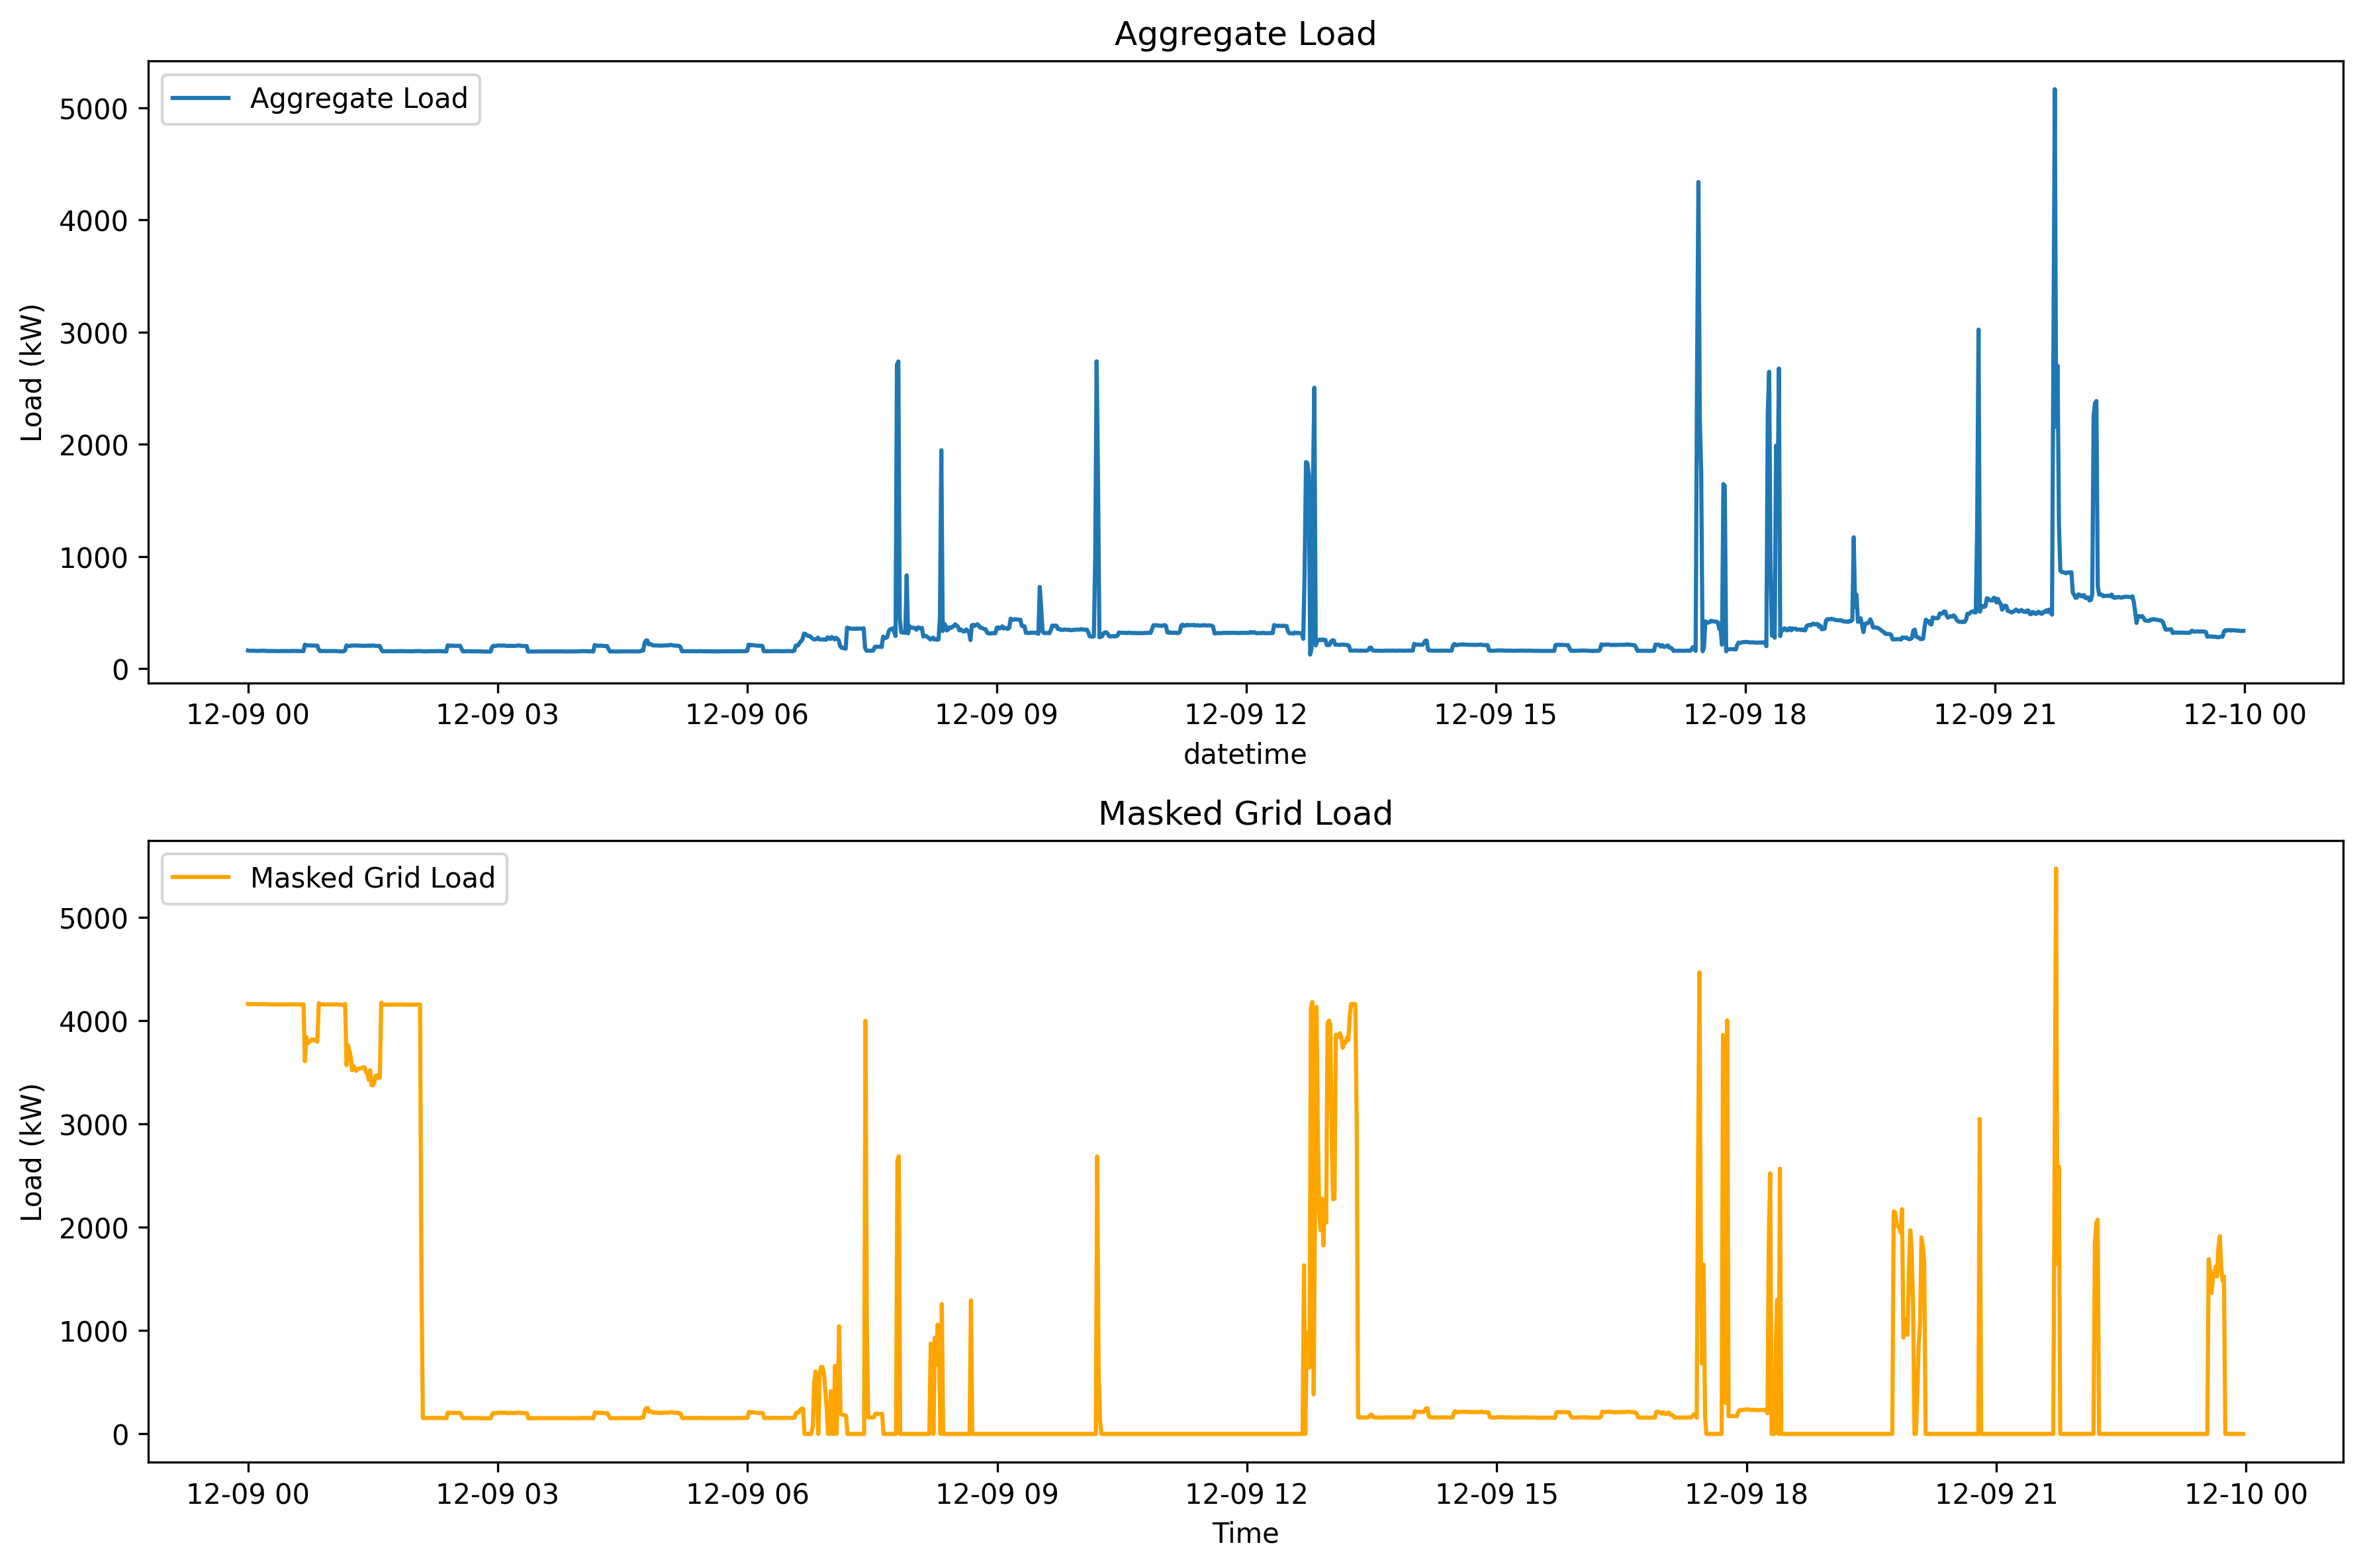

In [ ]:
# create a plot with two subplots
# on top plot the aggregate load
# on bottom plot the masked grid load
# to better visualize the difference between the two

import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=300)
sns.lineplot(x=env_valid.episode.df['datetime'], y=env_valid.episode.df['aggregate'], ax=ax1, label='Aggregate Load')
sns.lineplot(x=env_valid.episode.df['datetime'], y=env_valid.episode.df['grid_load'], ax=ax2, label='Masked Grid Load', color='orange')

ax1.set_title('Aggregate Load')
ax1.set_ylabel('Load (kW)')
ax1.legend()
ax2.set_title('Masked Grid Load')
ax2.set_xlabel('Time')
ax2.set_ylabel('Load (kW)')
ax2.legend()
plt.tight_layout()
plt.show()

In [60]:
# save the graph

env_valid.save_graph(
    {"fname": str(experiment_folder / f"graph_valid_index_{env_valid.selected_idx}.png"),
     "dpi": 300}
)

In [55]:
env_valid.close()

[2025-07-18 03:31:54:177] [SmartMeterWorld] Environment closed.


---

In [ ]:
# load the model & environment
import sys
sys.path.append(str(Path('rl_env')))

from rl_env.hrl_env_hnetwork_loop import SmartMeterWorld
from stable_baselines3 import PPO
from model.H_network.h_network_arch import HNetworkType

env_test = SmartMeterWorld(
    sm_dl_test,
    h_model_type=HNetworkType.H_NETWORK,
    render_mode="human",
)

env_test.set_h_network(h_network)
env_test.set_h_network_stdscaler(h_network_stdscaler)

rl_model_path = Path("rl_model", "PPO", f"{datetime(2025,7,12,18,25,2).strftime('%Y%m%d_%H%M%S')}", "rl_model.zip")
rl_model_loaded = PPO.load(rl_model_path, env=env_test)

In [ ]:
obs, info = env_test.reset(43)

In [ ]:
info

In [ ]:
env_test.reset_render_window()

In [ ]:
env_test.episode.df

In [ ]:
for i in range(1):
    done = False
    while not done:
        action, _states = rl_model_loaded.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env_test.step(action)
        print_log(f"Step: {env_test.episode.get_current_step()}, Action: {action}, Reward: {reward}, Info: {info}")
        env_test.render()

In [ ]:
env_test.save_graph(
    str(Path("rl_model", "PPO", f"{rl_datetime.strftime('%Y%m%d_%H%M%S')}", "graph_test.png"))
)

In [ ]:
env_test.close()